In [1]:
import python_utils as utils
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
from scipy.optimize import minimize, curve_fit
from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# SIGMOIDPULSE0_002 t_mid = 13000 duration = 10 s

In [2]:
parseg = 500
overlap = 0.5

neglect_t = 3000
t_mid = 6000
t_mid2 = t_mid + 3000
sigm_par = 0.002

In [3]:
t_mid_poiss = str(t_mid)
sigm_par_poiss = "{:.5f}".format(sigm_par)
function = "sigmoidpulse_new" + str(format(sigm_par, 'f')).replace('.', '_')
while function.endswith('0'):
    function = function[:-1]
Dd = "0.950"
subnets = "STN"
simulations = [str(i) for i in range(32)]

new_Dd = Dd.replace('.','_')


In [4]:
Dd_values = [round(0.85 + i * 0.005, 3) for i in range(21)] #max 21

# FLAT. media per ogni valore di dd

In [ ]:
function1 = "flat"
d = ["{:.3f}".format(elemento) for elemento in Dd_values]

pow_t_mean_all = []
for simulation in simulations:

    pow_t_mean = []
    t = []
    f = []
    print(simulation)

    for ddd in d:
        print(ddd)
        periodogram_path = './periodograms/' + ddd.replace('.','_') + '_' + subnets + '_' + function1 + '_' + simulation
        if not os.path.exists(periodogram_path):  #check if periodogram folder exists and if not create one
            os.makedirs(periodogram_path)

        data = np.loadtxt("./build/output/n1/" + function1 + "_0.00_0.0000_0.00_" + ddd + "_1.00_1.00_1.6/" + simulations[0] + "/ext_rateD2.txt").T
        data[0] = data[0]/1000
        data[1] = data[1]/1.083

        s = utils.SpikeSim("./build/output/n1/" + function1 + "_0.00_0.0000_0.00_" + ddd + "_1.00_1.00_1.6/" + simulation , 'new_sim_parallel.yaml', neglect_t, np.max(data[0]))
        output=s.periodogram(pop=subnets, res=1., N_parseg=parseg, save_img='')

        f = output[0]
        t = output[1]
        Sxx = output[2]

        mask = (8 <= f) & (f <= 26)
        Sxx_lim = Sxx[mask,:]
        f_lim = f[mask]

        pow_t_mean.append(np.mean(Sxx_lim))

    ###################################################################################################################

    pow_t_mean_all.append(pow_t_mean)
print(pow_t_mean_all)

np.savetxt('./build/output/n1/pow_t_mean' + str(parseg) + '.txt', pow_t_mean_all, header='pow_t_mean', delimiter='\t')

0
0.850
nparseg = 250	noverlap=125
0.855


## funzione dell'intensità della sigmoide attesa

In [5]:
Dd_values = Dd_values[::-1] + Dd_values
pow_t_mean_all = np.loadtxt('./build/output/n1/pow_t_mean' + str(parseg) + '.txt', delimiter='\t', skiprows=1)
pow_t_mean_point_int= pow_t_mean_all.tolist()
for i in range(32):
    pow_t_mean_point_int[i] = pow_t_mean_point_int[i][::-1] + pow_t_mean_point_int[i]

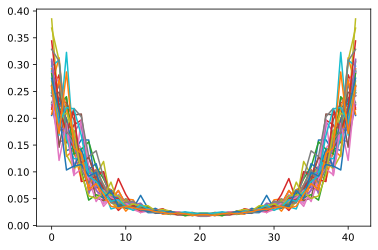

In [6]:
for i in range(32):
    plt.plot(pow_t_mean_point_int[i])
plt.show()

In [7]:
intermediate_points = [round((Dd_values[i] + Dd_values[i + 1]) / 2, 4) for i in range(len(Dd_values) - 1)]


In [9]:
# Inizializza variabile di controllo per il secondo loop
start_second_loop = False

t_d_int = []
t_d_int.append(12000)
# Primo loop
for x in intermediate_points[:]:
    # Controlla se è il momento di iniziare il secondo loop
    if x == 0.85:
        start_second_loop = True
        t_d_int.append((t_mid2 + t_mid)/2)
        continue

    # Calcola i valori in base alla variabile di controllo
    if not start_second_loop:
        y = -np.log((0.1) / (x - 0.85) - 1) / sigm_par + t_mid2
    else:
        y = -np.log((-0.1) / (x - 0.95) - 1) / sigm_par + t_mid

    # Aggiungi il valore calcolato a t_d_int
    t_d_int.append(y)

t_d_int.append(0)

t_d_int = np.array(t_d_int)
t_d_int = np.round(t_d_int).astype(int)


In [10]:
for i in range(32):
    pow_t_mean_point_int[i].insert(0, 0)
pow_t_mean_point_int = np.array(pow_t_mean_point_int)

In [11]:
%matplotlib widget
def genera_coppie_tempo_intensita(tempo_array, intensita_array):
    x = []
    y = []
    
    for tempo in range(tempo_array[-1]):
        x.append(tempo)
        if np.isin(tempo, tempo_array):
            indices = np.where(tempo_array == tempo)[0]
            y.append(intensita_array[:][indices[0]])
        else:
            y.append(y[-1])  # Ripeti l'ultimo valore di intensita_array se tempo non è presente
    
    return np.array(x), np.array(y)

power = []
time = []
for i in range(32):
    time_i, power_i = genera_coppie_tempo_intensita(t_d_int[::-1], pow_t_mean_point_int[i][::-1])
    power.append(power_i)
    time.append(time_i)

    # Plot dei dati
    plt.plot(time_i, power_i, marker='o')
    plt.xlabel('Tempo')
    plt.ylabel('Intensità')
    plt.title('Andamento Tempo-Intensità')
    plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
df_attesi = []

for i in range(32):
    # Crea un DataFrame con i dati
    df_i = pd.DataFrame({'Tempo': time[i], 'Valore': power[i]})

    # Calcola la media mobile e assegna i risultati al tempo centrale
    window_size = parseg
    df_i['Media_Mobile'] = df_i['Valore'].rolling(window=window_size, center=True).mean()

    # Rimuovi le righe con valori mancanti (prime e ultime finestre)
    df_i = df_i.dropna()

    # Rimuovi i primi neglect_t elementi
    df_i = df_i.iloc[neglect_t:]

    # Aggiungi il DataFrame alla lista
    df_attesi.append(df_i)

# Stampa il DataFrame risultante
print(df_attesi)

[       Tempo    Valore  Media_Mobile
3250    3250  0.287183      0.287183
3251    3251  0.287183      0.287183
3252    3252  0.287183      0.287183
3253    3253  0.287183      0.287183
3254    3254  0.287183      0.287183
...      ...       ...           ...
11746  11746  0.287183      0.287183
11747  11747  0.287183      0.287183
11748  11748  0.287183      0.287183
11749  11749  0.287183      0.287183
11750  11750  0.287183      0.287183

[8501 rows x 3 columns],        Tempo   Valore  Media_Mobile
3250    3250  0.26183       0.26183
3251    3251  0.26183       0.26183
3252    3252  0.26183       0.26183
3253    3253  0.26183       0.26183
3254    3254  0.26183       0.26183
...      ...      ...           ...
11746  11746  0.26183       0.26183
11747  11747  0.26183       0.26183
11748  11748  0.26183       0.26183
11749  11749  0.26183       0.26183
11750  11750  0.26183       0.26183

[8501 rows x 3 columns],        Tempo    Valore  Media_Mobile
3250    3250  0.305013      0.3050

In [13]:
for i in range(2):
    # Crea un oggetto di figura e un singolo assi
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot della media mobile
    ax1.plot(df_attesi[i]['Tempo'].values, df_attesi[i]['Media_Mobile'].values, label='Media Mobile', color='blue')

    # Etichette e legenda per l'asse x e y
    ax1.set_xlabel('Tempo')
    ax1.set_ylabel('Media Mobile', color='blue')
    ax1.tick_params('y', colors='blue')

    plt.title(f'Media mobile con finestra lunga parseg = {parseg}')
    # Mostra il plot
    plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [14]:
# Crea un oggetto di figura e un singolo asse
fig, ax1 = plt.subplots(figsize=(10, 6))

# Loop attraverso i dati e plotta le medie mobili
for i in range(32):
    ax1.plot(df_attesi[i]['Tempo'].values, df_attesi[i]['Media_Mobile'].values, label=f'Media Mobile {i}', alpha=0.7)

# Etichette e legenda per l'asse x e y
ax1.set_xlabel('Tempo')
ax1.set_ylabel('Media Mobile')
ax1.tick_params('y')

# Aggiungi una legenda
ax1.legend()

# Titolo del plot
plt.title(f'Medie mobili sovrapposte con finestra lunga parseg = {parseg}')

# Mostra il plot
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [15]:
media = []
error = []
tt = []

for i in range(0, len(df_attesi[0]['Tempo']), int(parseg - parseg*overlap)): # qui metti 0. overlap
    media.append(np.mean([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi]))
    error.append(np.std([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi]))
    tt.append(i + int(parseg*overlap))


In [16]:
%matplotlib widget
plt.errorbar(tt, media, yerr=error, fmt='o', label='Media Mobile con errore')
plt.xlabel('Tempo')
plt.ylabel('Media Mobile')
plt.title('intensità attesa')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
# sigmoidpulse with parseg 250 overlap 0.5
media=[0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.25478326447149535, 0.23202214792938336, 0.2241923238388968, 0.2241923238388968, 0.22331103129451843, 0.20495076995330258, 0.18747180115646506, 0.17311545211309298, 0.15294474804803557, 0.1396942555588354, 0.11358867983641772, 0.09036846840843518, 0.0763873083501817, 0.05841254289936259, 0.04669320750980432, 0.04007066064047369, 0.03473234292991717, 0.03080359110540759, 0.027482964623595167, 0.025615423537146274, 0.024229660115548328, 0.023003266928255182, 0.02238682837743957, 0.02188933490849725, 0.02158271146066814, 0.021158056256268428, 0.020711989865092255, 0.0206905786783158, 0.0206905786783158, 0.020557049655330978, 0.020168883890840192, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.020168883890840192, 0.02055704965533097, 0.0206905786783158, 0.0206905786783158, 0.02071198986509226, 0.021158056256268428, 0.02158271146066814, 0.02188933490849725, 0.02238682837743957, 0.023003266928255182, 0.02422966011554833, 0.025615423537146274, 0.027482964623595167, 0.030803591105407594, 0.03473234292991717, 0.040070660640473696, 0.04669320750980432, 0.05841254289936259, 0.0763873083501817, 0.09036846840843518, 0.11358867983641772, 0.1396942555588354, 0.15294474804803557, 0.17311545211309298, 0.18747180115646506, 0.20495076995330258, 0.22331103129451846, 0.2241923238388968, 0.2241923238388968, 0.23202214792938336, 0.2547832644714954, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209]
error=[0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.033210257112849736, 0.04055674548957555, 0.047709152771263454, 0.047709152771263454, 0.04612987536398969, 0.024178762812190977, 0.04305030929585567, 0.031174847838532478, 0.028665537221341984, 0.02651025038182155, 0.022722470807291766, 0.018170840311126663, 0.014816534517933, 0.008630304906228299, 0.006312647967871339, 0.004572112867194109, 0.0029358573959980265, 0.0027804743586662024, 0.001589194113254279, 0.0014911691697869062, 0.001535903105637992, 0.001352898756551427, 0.0012615103284442405, 0.0011945938871576116, 0.0016271621877926557, 0.0012366707572263659, 0.0014419139547413636, 0.001466268829650556, 0.001466268829650556, 0.0012104167505053848, 0.001022140487598335, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0010221404875983353, 0.0012104167505053848, 0.001466268829650556, 0.001466268829650556, 0.0014419139547413636, 0.0012366707572263656, 0.0016271621877926557, 0.0011945938871576118, 0.001261510328444241, 0.001352898756551427, 0.001535903105637992, 0.0014911691697869066, 0.0015891941132542785, 0.002780474358666203, 0.0029358573959980257, 0.004572112867194109, 0.006312647967871339, 0.0086303049062283, 0.014816534517933, 0.018170840311126667, 0.02272247080729176, 0.026510250381821553, 0.028665537221341984, 0.031174847838532478, 0.04305030929585567, 0.024178762812190974, 0.0461298753639897, 0.047709152771263454, 0.047709152771263454, 0.04055674548957555, 0.03321025711284974, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065]
tt=[125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 3625, 3750, 3875, 4000, 4125, 4250, 4375, 4500, 4625, 4750, 4875, 5000, 5125, 5250, 5375, 5500, 5625, 5750, 5875, 6000, 6125, 6250, 6375, 6500, 6625, 6750, 6875, 7000, 7125, 7250, 7375, 7500, 7625, 7750, 7875, 8000, 8125, 8250, 8375, 8500, 8625, 8750, 8875, 9000, 9125, 9250, 9375, 9500, 9625, 9750, 9875, 10000, 10125, 10250, 10375, 10500, 10625, 10750, 10875, 11000, 11125, 11250, 11375, 11500, 11625, 11750, 11875, 12000, 12125, 12250, 12375, 12500, 12625, 12750, 12875, 13000, 13125, 13250, 13375, 13500, 13625, 13750, 13875, 14000, 14125, 14250, 14375, 14500, 14625, 14750, 14875, 15000, 15125, 15250, 15375, 15500, 15625, 15750, 15875, 16000, 16125, 16250, 16375, 16500, 16625, 16750, 16875, 17000, 17125, 17250, 17375, 17500, 17625, 17750, 17875, 18000, 18125, 18250, 18375, 18500, 18625, 18750, 18875, 19000, 19125, 19250, 19375, 19500, 19625, 19750, 19875, 20000, 20125, 20250, 20375, 20500, 20625, 20750, 20875, 21000, 21125, 21250, 21375, 21500, 21625, 21750, 21875, 22000, 22125, 22250, 22375, 22500, 22625, 22750, 22875, 23000, 23125, 23250, 23375, 23500, 23625, 23750, 23875, 24000, 24125, 24250, 24375, 24500, 24625, 24750, 24875, 25000, 25125, 25250, 25375, 25500, 25625, 25750, 25875, 26000, 26125, 26250, 26375, 26500, 26625, 26750, 26875, 27000, 27125, 27250, 27375, 27500, 27625, 27750, 27875, 28000, 28125, 28250, 28375, 28500, 28625, 28750, 28875, 29000, 29125, 29250, 29375, 29500, 29625, 29750, 29875]


In [15]:
# sigmoidpulse with parseg 500 overlap 0.5
media=[0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.2659045148573025, 0.24294012947895297, 0.22706275680795418, 0.20850835277679292, 0.17291655734814587, 0.13539571443616233, 0.09642329598609818, 0.06242351411883271, 0.041333642258539256, 0.03161074916416895, 0.026227602255602746, 0.02365029852448728, 0.022312414242189042, 0.02145529854183425, 0.02103325068360281, 0.020747618265982894, 0.020337643163271052, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020337643163271052, 0.020747618265982894, 0.02103325068360281, 0.02145529854183425, 0.022312414242189042, 0.02365029852448728, 0.026227602255602746, 0.03161074916416895, 0.041333642258539256, 0.0624235141188327, 0.09642329598609817, 0.13539571443616233, 0.17291655734814587, 0.20850835277679292, 0.22706275680795418, 0.24294012947895294, 0.2659045148573025, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117]
error=[0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.03720054704589734, 0.035929954119276436, 0.04758493707667993, 0.024914802015394276, 0.029893845353789267, 0.02045251866979651, 0.016306606195916565, 0.008566869755123694, 0.003749356235307829, 0.001815868886380578, 0.001302846297371556, 0.0010068974508839303, 0.001167684780587713, 0.0013566786270882622, 0.0015954961922853635, 0.001132827099347126, 0.0012733223224427204, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0012733223224427207, 0.0011328270993471263, 0.0015954961922853635, 0.001356678627088262, 0.0011676847805877132, 0.00100689745088393, 0.0013028462973715552, 0.0018158688863805779, 0.003749356235307829, 0.008566869755123692, 0.016306606195916565, 0.020452518669796506, 0.029893845353789267, 0.02491480201539428, 0.047584937076679934, 0.035929954119276436, 0.03720054704589734, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858]
tt=[250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750, 14000, 14250, 14500, 14750, 15000, 15250, 15500, 15750, 16000, 16250, 16500, 16750, 17000, 17250, 17500, 17750, 18000, 18250, 18500, 18750, 19000, 19250, 19500, 19750, 20000, 20250, 20500, 20750, 21000, 21250, 21500, 21750, 22000, 22250, 22500, 22750, 23000, 23250, 23500, 23750, 24000, 24250, 24500, 24750, 25000, 25250, 25500, 25750, 26000, 26250, 26500, 26750, 27000, 27250, 27500, 27750, 28000, 28250, 28500, 28750, 29000, 29250, 29500, 29750]


In [5]:
# sigmoidpulse with parseg 1000 overlap 0.5
media=[0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2589238890428149, 0.22623104657912974, 0.1723959289833446, 0.09930256888504298, 0.047200291690002505, 0.02772763359561716, 0.02264465469182166, 0.021230459626780565, 0.020596018702714186, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020294827095647044, 0.020596018702714186, 0.021230459626780565, 0.02264465469182166, 0.02772763359561716, 0.047200291690002505, 0.09930256888504296, 0.17239592898334463, 0.22623104657912974, 0.2589238890428149, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078, 0.2742433217526078]
error=[0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.03382138258337724, 0.02643254859176477, 0.01715319137863472, 0.012333469052095357, 0.004409762213894276, 0.0011066415561419066, 0.000848220175707135, 0.0011529336782820643, 0.0010887066208040619, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0015663525851732005, 0.0010887066208040616, 0.001152933678282064, 0.0008482201757071355, 0.001106641556141906, 0.004409762213894276, 0.012333469052095357, 0.01715319137863472, 0.026432548591764773, 0.03382138258337723, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465, 0.042993507837908465]
tt=[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500]


# simulazione SIGMOIDPULSE

In [17]:
# Inizializza variabile di controllo per il secondo loop
start_second_loop = False

t_d = []
t_d.append(t_mid*2)
# Primo loop
for x in Dd_values[1:-1]:
    # Controlla se è il momento di iniziare il secondo loop
    if x == 0.85:
        start_second_loop = True
        t_d.append((t_mid2 + t_mid)/2)
        continue

    # Calcola i valori in base alla variabile di controllo
    if not start_second_loop:
        y = -np.log((0.1) / (x - 0.85) - 1) / sigm_par + t_mid2
    else:
        y = -np.log((-0.1) / (x - 0.95) - 1) / sigm_par + t_mid

    # Aggiungi il valore calcolato a t_d_int
    t_d.append(y)

t_d.append(t_mid/10 + neglect_t*2.5)

t_d = np.array(t_d)
t_d = np.round(t_d).astype(int)

In [18]:
%matplotlib inline
#funzione Dd
data = np.loadtxt("./build2/output/n1/" + function + "_" + t_mid_poiss + ".00_" + sigm_par_poiss + "_0.00_" + Dd + "_1.00_1.00_1.6/" + simulations[0] + "/ext_rateD2.txt").T

data[0] = data[0]/1000
data[1] = data[1]/1.083

#check if periodogram folder exists and if not create one
#spikesim
periodogram_paths = []
s = []
for simulation in simulations:
    periodogram_path = './periodograms/' + Dd.replace('.','_') + '_' + subnets + '_' + function + '_' + simulation
    if not os.path.exists(periodogram_path):  #check if periodogram folder exists and if not create one
        os.makedirs(periodogram_path) 
    periodogram_paths.append(periodogram_path)
    ss = utils.SpikeSim("./build2/output/n1/" + function + "_" + t_mid_poiss + ".00_" + sigm_par_poiss + "_0.00_" + Dd + "_1.00_1.00_1.6/" + simulation , 'new_sim_parallel.yaml', neglect_t, np.max(data[0]))
    s.append(ss)

all_pow_t = []
t = []
f = []

for index,ss in enumerate(s):
    output=ss.periodogram(pop=subnets, res=1., N_parseg=parseg, save_img=periodogram_paths[index] + "/periodogram.png")

    f = output[0]
    t = output[1]
    Sxx = output[2]

    mask = (8 <= f) & (f <= 26)
    Sxx_lim = Sxx[mask,:]
    f_lim = f[mask]

    pow_t = []
    for i in range (len(t)):
        pow_t.append(np.mean(Sxx_lim[:,i]))

    all_pow_t.append(pow_t)

np.vstack(all_pow_t)
pow_t_mean = np.mean(all_pow_t, axis=0)
pow_error = np.std(all_pow_t, axis=0)

nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250
nparseg = 500	noverlap=250


In [5]:
# parseg 250 overlap 0.5
pow_t_mean = np.array([0.2515572241191702, 0.24774108405125045, 0.255016543155679, 0.26000100180388996, 0.2504861463405993, 0.25467559687454966, 0.25422167567678206, 0.260181526073083, 0.2664488052011643, 0.258275836093391, 0.24946963563114344, 0.23775868158008148, 0.22107881546783822, 0.22816345337119037, 0.2363951200394672, 0.24320997970807562, 0.25041628962743434, 0.2592377105527339, 0.25819229617286155, 0.25367802643801574, 0.2653058747644922, 0.2721763535566623, 0.26659136763157654, 0.2522138944730871, 0.2520468272798265, 0.25290294294465226, 0.25845402669601997, 0.26390267033555287, 0.26147722356057057, 0.27036986776620536, 0.25910177466090567, 0.23752690559538947, 0.2502785140224342, 0.25863929653489126, 0.258087031696601, 0.2545830862190812, 0.2559290260773507, 0.2549306248397338, 0.25410565711011723, 0.24801133865824096, 0.2647442738397409, 0.2466630734601395, 0.23955629455147504, 0.2485758133130727, 0.24311460150212297, 0.25142004209887736, 0.2518833123124007, 0.23156541109047257, 0.23994166876194598, 0.2404606027859915, 0.23397233584310118, 0.2461531549056791, 0.24130481004045182, 0.25653028306261605, 0.2671134272163617, 0.26300072249106204, 0.27519793280955357, 0.2649807602634257, 0.24048409824248004, 0.2482542200977661, 0.23522297880073995, 0.22312367467899683, 0.23987890179138088, 0.24739138842103964, 0.23650615115891277, 0.24154734809268943, 0.2458445848741137, 0.22987153319339165, 0.2290981820382959, 0.23665974673126494, 0.226483625147182, 0.2026634374772816, 0.19446922235672826, 0.1588256687725995, 0.13765803438856505, 0.1264229345059854, 0.12088905629681182, 0.1033539757013679, 0.0741262535743312, 0.0593386929750279, 0.04855358914255242, 0.03971582922609549, 0.03414242332102415, 0.03580067477957399, 0.03585330168199302, 0.03024193075689067, 0.02453441557480717, 0.024486536792393383, 0.023871291157540872, 0.02193293369399694, 0.022872850468020255, 0.019790473204190938, 0.01830067101204269, 0.02520387066755028, 0.024052554597423684, 0.01917239217753004, 0.021348998547013765, 0.019918496557810035, 0.017892345234531773, 0.019341335749953774, 0.01945778661541844, 0.022126382110722587, 0.018822496440839984, 0.019011406664657268, 0.01743400581687988, 0.018796435040296336, 0.02262130084648821, 0.02171965679848567, 0.021075661658310468, 0.02071995792858322, 0.020513620783139806, 0.02342943482446085, 0.022562158878655876, 0.021595754360043823, 0.02053436989629505, 0.019343532854178922, 0.021096084856931867, 0.02216988711504333, 0.019990849677374047, 0.01993157429327065, 0.019722300770507455, 0.01996507630084139, 0.02066049397715389, 0.022831110931994362, 0.0204147799543333, 0.020541227640952033, 0.020397722092621428, 0.021463119136719395, 0.02165098208064698, 0.02270961370814815, 0.021629049926051653, 0.020071259364727548, 0.016243565213361493, 0.017820832567536752, 0.023325845729970027, 0.02159714570998989, 0.022192610077415745, 0.023007661271728146, 0.019203149769974132, 0.018227982860453303, 0.020428105971155287, 0.020887881368729808, 0.020782542622557253, 0.020296889999282114, 0.01810926255469981, 0.01951959205737979, 0.0220328759625447, 0.02291879613142112, 0.020067378141907073, 0.017075705830466983, 0.020061421412375515, 0.018844548836216262, 0.020299391908643525, 0.021198468947613323, 0.02058786191138516, 0.020772533305262766, 0.018638940291222098, 0.020639773891798552, 0.023013023097347457, 0.02978729696216381, 0.03498551139448781, 0.039707743955808075, 0.05263582943955188, 0.06453181401763633, 0.06675643054018264, 0.08233633645106225, 0.11168970518055876, 0.1381923794665237, 0.15701407026232028, 0.16952701653224136, 0.18448082606198118, 0.22461982234112632, 0.24520459990478793, 0.24780866557639242, 0.26344047308848784, 0.26353674097967844, 0.26278889321688265, 0.2677673534925572, 0.25793919597746146, 0.25278903420526416, 0.24816396356520237, 0.25176936920655374, 0.24971053430088452, 0.26382617354809307, 0.25257065937039774, 0.24056372586353936, 0.23733234889340782, 0.2630711314418682, 0.283931004628843, 0.27845171893325693, 0.2857133026311539, 0.2739614677549587, 0.26690401696329247, 0.2809277782954031, 0.2780380832043403, 0.2630143922401318, 0.2561653350978457, 0.24837329509001557, 0.25817800302540056, 0.28158256656233854, 0.2915274342752092, 0.27492943956412885, 0.2796958298397253, 0.30652773396568134, 0.29744421236002627, 0.27352098860097296, 0.27603011952854495, 0.26672663091865845, 0.26146628966109825, 0.2617649518128896, 0.26300888569140135, 0.2743045319716297, 0.2720401079293384, 0.2729126091383753, 0.27691729819836913, 0.27139934420258355, 0.2622147015716619, 0.2579483723299596, 0.25973863848018375, 0.2614304497318355, 0.26701914786444586, 0.26727017719574564, 0.28084234518750895, 0.27405570607465846, 0.2515579249560586, 0.2572764102303952, 0.26334570817412983, 0.2724525429893858, 0.28657880844995043, 0.28245234510900846, 0.29611415820424075, 0.30279646708785957, 0.2933788033954918, 0.2797647042934896, 0.2679764314991701, 0.26066319607556493, 0.2740217642979182, 0.2818209783713884, 0.26864634253448827])
pow_error = np.array([0.0822041621907141, 0.08012335290873517, 0.08076790703989806, 0.09100879629665269, 0.10469089575028821, 0.10682340048450945, 0.1124971114069009, 0.10584558235568137, 0.11065596676374108, 0.10506825943013187, 0.0953327660152162, 0.08990086943047418, 0.07990822175970379, 0.07004933704547817, 0.06683422693126886, 0.06508317188431241, 0.0821535913127396, 0.0870027026599094, 0.10189555836870277, 0.08388427142215231, 0.08478503551258769, 0.08879697982834446, 0.09087713261122854, 0.07922971668835335, 0.07520820957630342, 0.060166581814222346, 0.06941663730707166, 0.07694579612817654, 0.08075535331499252, 0.08603589117647681, 0.10722079951364885, 0.09768386615231746, 0.08716349965046007, 0.08168308866863803, 0.08657165298132678, 0.08186365954194408, 0.07116027498153552, 0.08043877533785769, 0.0858860040945718, 0.08754891799089944, 0.10742743398918092, 0.0782997624200099, 0.06909690836381754, 0.07621209464011157, 0.09067072467102691, 0.07507157260406443, 0.08657828719081738, 0.06847893998294216, 0.08479618306995342, 0.08772655591156191, 0.08333117409971025, 0.09780813324659238, 0.07893702999018765, 0.08087788838292571, 0.08108710749681017, 0.08564708818481205, 0.09210725781403883, 0.09984080021796006, 0.09397635807829695, 0.10143765368585876, 0.07482720200368258, 0.08567886222332341, 0.09273035525553243, 0.09589053953942478, 0.08909383356320295, 0.0855434328231845, 0.09048807373598855, 0.0816348707833891, 0.07578730596272262, 0.07443923800554172, 0.08597965925367385, 0.07971203368682626, 0.0695178548422162, 0.05636117089981107, 0.06594183482828907, 0.07343739541130595, 0.07992675948462803, 0.06732663569509871, 0.03971345163706981, 0.036180913806392295, 0.0273194100765556, 0.02225991477197629, 0.02455440675294273, 0.025026122135309976, 0.023336791964885296, 0.019808205495214448, 0.014290986585027777, 0.010354278133883286, 0.012413491114625193, 0.012793418212670367, 0.011963615203496869, 0.011383651660908293, 0.008973916421747156, 0.014729304823772634, 0.014290625369614483, 0.01201289025194037, 0.010657640858488242, 0.010976804989837151, 0.008539286580947101, 0.008982700635565385, 0.008990277705342588, 0.0127381093413989, 0.01120418459978543, 0.011181946551459132, 0.010062757172693514, 0.0068617180162556714, 0.012299233972816183, 0.014509252175974516, 0.010292628106568289, 0.011419024398057413, 0.014646445110399173, 0.012676325794027693, 0.011890921555656958, 0.011282187604640698, 0.012287979807601159, 0.009856220742879057, 0.011072480708410777, 0.010530748601278606, 0.008535442916619654, 0.011060111085875226, 0.011040296207689084, 0.007864573184410072, 0.010050768069796694, 0.014183141132765554, 0.01140201795512416, 0.012532070377461471, 0.009303016845048783, 0.009680139721346024, 0.00991378618358884, 0.015837503202549175, 0.011812860468007827, 0.009498426102941765, 0.00924443559041148, 0.007784633476537687, 0.015559211893007777, 0.010764239115114111, 0.011711749319898896, 0.015495564990300383, 0.012500478744958009, 0.011590524065842458, 0.008674946479933408, 0.0094556392756834, 0.01321187796120168, 0.01099360205692259, 0.008463064933638907, 0.008986788103926018, 0.011183321390729431, 0.014401185975220023, 0.01243010774735966, 0.008747702767541339, 0.011487014822269938, 0.008796519839553266, 0.009438840693514312, 0.014834280478184173, 0.01196225987122629, 0.0143199334125322, 0.009086849330660146, 0.009643457351296604, 0.013743337600319785, 0.023784899496453217, 0.02842849748361082, 0.024536900593785823, 0.02608816276994788, 0.04088747899627281, 0.04361210513374768, 0.05025578962056493, 0.06612627350650774, 0.07357984168739445, 0.08963568339609382, 0.09522208925135106, 0.09765430983497869, 0.10010186905824182, 0.09415280345195749, 0.09045426661675125, 0.08824421072438153, 0.08728628680391454, 0.09679396652469338, 0.08730581857107755, 0.09044222521647975, 0.10805980465745182, 0.10999268313234288, 0.11340152153837027, 0.10955394398588966, 0.09715584036431099, 0.09710065939149619, 0.09038499776307743, 0.08297994205567387, 0.0931061261361824, 0.09630960304849671, 0.09842184980850446, 0.09756698312758971, 0.08536652252846982, 0.08958205820306313, 0.0957716618114933, 0.09722275337139741, 0.09090950941120671, 0.0801762193813315, 0.08053420309433823, 0.0831758728303847, 0.07742877348737678, 0.08223465290875699, 0.077721592299748, 0.08325068537206966, 0.08185550694719264, 0.09334543502472979, 0.08530534342957222, 0.08129264670908262, 0.08630918034451206, 0.09741788591326858, 0.09026366556247536, 0.09494258800579489, 0.11352621678485252, 0.10337338349186602, 0.10148793942882425, 0.0784759399365403, 0.08464928615875154, 0.08577751105730975, 0.10363485392061395, 0.112527831503365, 0.10603513553741596, 0.09105924780383615, 0.07811153759342669, 0.07987322462413296, 0.08588521630659508, 0.08562522520368032, 0.08227954698985555, 0.08120519135105748, 0.0815910375872319, 0.09589530595250823, 0.08718092406607618, 0.08258262670407741, 0.09730645311947447, 0.09469035267071355, 0.0834956107724389, 0.09218688968487802, 0.10262008621826021, 0.09077675481539269, 0.07523622701134688, 0.0922207901538497])
t = np.array([125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 3625, 3750, 3875, 4000, 4125, 4250, 4375, 4500, 4625, 4750, 4875, 5000, 5125, 5250, 5375, 5500, 5625, 5750, 5875, 6000, 6125, 6250, 6375, 6500, 6625, 6750, 6875, 7000, 7125, 7250, 7375, 7500, 7625, 7750, 7875, 8000, 8125, 8250, 8375, 8500, 8625, 8750, 8875, 9000, 9125, 9250, 9375, 9500, 9625, 9750, 9875, 10000, 10125, 10250, 10375, 10500, 10625, 10750, 10875, 11000, 11125, 11250, 11375, 11500, 11625, 11750, 11875, 12000, 12125, 12250, 12375, 12500, 12625, 12750, 12875, 13000, 13125, 13250, 13375, 13500, 13625, 13750, 13875, 14000, 14125, 14250, 14375, 14500, 14625, 14750, 14875, 15000, 15125, 15250, 15375, 15500, 15625, 15750, 15875, 16000, 16125, 16250, 16375, 16500, 16625, 16750, 16875, 17000, 17125, 17250, 17375, 17500, 17625, 17750, 17875, 18000, 18125, 18250, 18375, 18500, 18625, 18750, 18875, 19000, 19125, 19250, 19375, 19500, 19625, 19750, 19875, 20000, 20125, 20250, 20375, 20500, 20625, 20750, 20875, 21000, 21125, 21250, 21375, 21500, 21625, 21750, 21875, 22000, 22125, 22250, 22375, 22500, 22625, 22750, 22875, 23000, 23125, 23250, 23375, 23500, 23625, 23750, 23875, 24000, 24125, 24250, 24375, 24500, 24625, 24750, 24875, 25000, 25125, 25250, 25375, 25500, 25625, 25750, 25875, 26000, 26125, 26250, 26375, 26500, 26625, 26750, 26875, 27000, 27125, 27250, 27375, 27500, 27625, 27750, 27875, 28000, 28125, 28250, 28375, 28500, 28625, 28750, 28875, 29000, 29125, 29250, 29375, 29500, 29625, 29750, 29875])/1000


In [6]:
# parseg 500 overlap 0.5
pow_t_mean = np.array([0.291086382119989, 0.29228806643286903, 0.27655793300386444, 0.2807219467507574, 0.25549276241820446, 0.24044519593811015, 0.25353047911117277, 0.2596237842512882, 0.24439676163149465, 0.26229958108896917, 0.2654068730689716, 0.2566596473841813, 0.25296168482395337, 0.2745227240268908, 0.2754785078764833, 0.2647430747280286, 0.25490024896869334, 0.24920296126003155, 0.25732655998049403, 0.2704715820698027, 0.2689708787023845, 0.27167202500245075, 0.26502637500785414, 0.2637373738093742, 0.2702593444402112, 0.2689828536012685, 0.2645507422280999, 0.26820717876548866, 0.2720861990230077, 0.27964303136879204, 0.2507057310486817, 0.23540703506334512, 0.2506502622374206, 0.2359423066882812, 0.21616147711903827, 0.19372507219020552, 0.16267356880620024, 0.12639505840305912, 0.09489643883395585, 0.06868451998813727, 0.04573651350944127, 0.03222353195705088, 0.02499562983539738, 0.023521895013637037, 0.022434276204792526, 0.0218450186854035, 0.020342513798956748, 0.02027329555592408, 0.01996813481912701, 0.019278971327845798, 0.020588109771262516, 0.019776911193091624, 0.01906686640156904, 0.019414162273976854, 0.020139833751654432, 0.01972844724328692, 0.01855459027887972, 0.01858650663547799, 0.02089942778558714, 0.02192653992044969, 0.022043048521571712, 0.01921083733870699, 0.01781197242476586, 0.01983988545480425, 0.021081479511602462, 0.02104594949921444, 0.01951808092125622, 0.01913011891460935, 0.01923285690576635, 0.01895406303246611, 0.018516050233160403, 0.01913324756103053, 0.01974367983892384, 0.021158339017440766, 0.022693977386807587, 0.02563413790920498, 0.026180637858605808, 0.025501619803486524, 0.026354058433709703, 0.034630646661120645, 0.047482009916548246, 0.06318081750698383, 0.08569499945423294, 0.12480156242063459, 0.16779208306124094, 0.2204783691611239, 0.2525476527583922, 0.26602368648607166, 0.2786542901419219, 0.26775586510309013, 0.2712529500880128, 0.3058699788525034, 0.3041143770803742, 0.27251146755884303, 0.26107220502629613, 0.2644035661817742, 0.2673199003647374, 0.25494114722651207, 0.2633635997991213, 0.28705198129409387, 0.3031439316026926, 0.2891380091618779, 0.2736726579961667, 0.274687939317196, 0.2782132433047262, 0.2725111489655097, 0.25747475871367664, 0.25264695329036846, 0.27136130308041556, 0.29386536881386016, 0.28632756072152343, 0.2627875610624987, 0.2516500193593737, 0.2685679091667232, 0.2801098397947244, 0.27430468172176425, 0.27010119959645407, 0.2695840037585982, 0.2865293600943047])
pow_error = np.array([0.06627980952215579, 0.0689550074082457, 0.07618227241811598, 0.08163745170590565, 0.07219204482643184, 0.07858626220875309, 0.07586914616957464, 0.08575029926466919, 0.08321154117482339, 0.07744519949280115, 0.08522588497277118, 0.08489542429121098, 0.07548899511787126, 0.07607391350506482, 0.06668574728596664, 0.07210495731465111, 0.06819953663493913, 0.06743211618706248, 0.06638616168156003, 0.07335799163100082, 0.07653174115250543, 0.08792864794552858, 0.08362905407247333, 0.08679699265535139, 0.09301989215621173, 0.08612176395285367, 0.08507295187112257, 0.07963932963666014, 0.08373092262924312, 0.08104223948652105, 0.08359868726281319, 0.08270993289620113, 0.0972587769735705, 0.09635107430586001, 0.08805642761338775, 0.07349790344222339, 0.061049736458370245, 0.046191927243612874, 0.0404040745603134, 0.033514564675658755, 0.02400951869433672, 0.018235643275046887, 0.012807090183753329, 0.010739576010587134, 0.008868038513904173, 0.0073926349393836814, 0.007042516420003382, 0.0065619728450337575, 0.009217576962676215, 0.009101871349488679, 0.009057434530474546, 0.011735056845902132, 0.007691671694832376, 0.006683347613332333, 0.008325426553329227, 0.008422106756950515, 0.007246797760746111, 0.006652623766180246, 0.006900470495172475, 0.009814518588426045, 0.008223469408770235, 0.008584586457094902, 0.007195138671974491, 0.008049645980523544, 0.006880936896326959, 0.007986250808346309, 0.010079288149151046, 0.008350021388507652, 0.00836955392059286, 0.007463788994703131, 0.0073757607631843745, 0.007969441108039424, 0.008113787373084652, 0.00891132324685109, 0.009116613366481438, 0.010859263937921483, 0.010205735153250958, 0.01086767566415417, 0.010146480183643261, 0.015364778829383119, 0.02082479841687797, 0.0408347198850239, 0.0556957226027792, 0.07204782455280132, 0.08499328398910964, 0.10201799099808016, 0.10292980055476027, 0.0846527396053781, 0.0732457266003427, 0.0749601912547706, 0.0726506211622365, 0.07111766789127102, 0.07843839376945717, 0.08312121298969326, 0.09151766141488515, 0.07668659386642597, 0.09120983504273228, 0.0857447006042899, 0.08233834309072731, 0.09081031439488857, 0.0829544434981043, 0.10045973377326857, 0.09195557186127226, 0.09405070501231239, 0.08511859019107432, 0.07497501151318636, 0.0864988620654156, 0.0888813410548595, 0.08538312308087401, 0.07873743072602035, 0.07817457392550617, 0.08764999377146963, 0.08892079800073178, 0.09048219726275313, 0.08661303454636528, 0.0755345038339254, 0.07553733419794587, 0.08120533619028941, 0.07453382155792267])
t = np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0, 20.25, 20.5, 20.75, 21.0, 21.25, 21.5, 21.75, 22.0, 22.25, 22.5, 22.75, 23.0, 23.25, 23.5, 23.75, 24.0, 24.25, 24.5, 24.75, 25.0, 25.25, 25.5, 25.75, 26.0, 26.25, 26.5, 26.75, 27.0, 27.25, 27.5, 27.75, 28.0, 28.25, 28.5, 28.75, 29.0, 29.25, 29.5, 29.75])


In [6]:
#parseg 1000 overlap 0.5
pow_t_mean=np.array([0.2562026737051695, 0.260376914780447, 0.24631148573755757, 0.24671281003990608, 0.2660861304510055, 0.2639429116561076, 0.2662100536846288, 0.26227044558746965, 0.2613405657501557, 0.25673649777735397, 0.2540716532079238, 0.24635204595882051, 0.25289144309616757, 0.2616456294926924, 0.25003126153268557, 0.24428528438603375, 0.24000036263597885, 0.20064815109120646, 0.132840739281901, 0.07009502649484306, 0.03605740319519382, 0.02668501323297473, 0.022724364398919176, 0.02089348063421892, 0.020135820746303715, 0.02029384858103063, 0.020560557012745756, 0.021748322601691288, 0.020977789520144282, 0.020508027062315397, 0.021148216746145965, 0.021676180922910925, 0.021004543267645222, 0.02117555648061934, 0.021081577766958695, 0.020753987441627736, 0.020800118426131144, 0.020555289837868182, 0.02118479581871424, 0.03133330583720935, 0.06545610520783554, 0.13133607876085693, 0.21604237570812204, 0.2620967115181816, 0.26044773440383145, 0.25436331842520665, 0.26874427365301723, 0.28292278035795815, 0.2678685606397567, 0.275385283382761, 0.2903494383735598, 0.2758990330478358, 0.27306403345146074, 0.2718804026800155, 0.2702986294039893, 0.27168440838905333, 0.2779393353567563, 0.2939416501272024, 0.2807683558963976])
pow_error=np.array([0.07512852105122454, 0.08765354105548787, 0.06912846476875605, 0.05310199613006659, 0.06678035344622384, 0.05913177231549576, 0.056372640465768925, 0.0632110056760928, 0.05939258354263853, 0.06806144345918377, 0.05599263800797591, 0.05783751986891122, 0.06284909389985964, 0.06132101391962552, 0.06621269996416729, 0.06857715918334195, 0.07155561672558515, 0.055130229094906565, 0.04950096995211913, 0.029997303605741175, 0.014477140935979491, 0.008476245720261889, 0.007522007044236377, 0.006089898048404235, 0.0050654441523839714, 0.0060209953644751995, 0.005108080100478102, 0.006314237067183984, 0.006747468521659273, 0.004300715414413184, 0.0071812702959227655, 0.007922514114362093, 0.006270732970278528, 0.006035511742334344, 0.007393760769144186, 0.005007432324052646, 0.005028532834180418, 0.006074642537432224, 0.006403607148662445, 0.012933550121756765, 0.030671274856294672, 0.05877893798363232, 0.07613011753180501, 0.07142715700193097, 0.08725526314763672, 0.08123995724568525, 0.06642402867436537, 0.07729376730013075, 0.06764259913044231, 0.05117279081042721, 0.06476237542879801, 0.07077184102348073, 0.07403880143343873, 0.07229018485441435, 0.078205083596192, 0.05963750436254422, 0.06257615888623518, 0.07122517568593911, 0.06868113894155191])
t=np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5])


## time-pow_t

In [19]:
tt=np.array(tt)

In [20]:
%matplotlib widget
# Creare un grafico dei valori nel tempo
fig, ax1 = plt.subplots(figsize=(9, 5))

# Utilizza la funzione errorbar per tracciare i dati con errori associati
ax1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)

# Plot dei dati originali
ax1.plot(t, pow_t_mean, label='Intensità simulazione', color='orange')
#ax1.set_yscale('log')

# Aggiungi il terzo set di dati con errori associati al grafico esistente
plt.errorbar(tt/1000, media, yerr=error, fmt='o', label='Media Mobile con errore')

# Etichette e legenda per l'asse x e y
ax1.set_xlabel('Tempo [s]')
ax1.set_ylabel('Intensità media')
ax1.legend()  # Assicurati di avere tutte le etichette delle leggende necessarie

plt.title(f'Intensità nel Range \u03B2 per \u03C4 = {1/sigm_par/1000} [s] nparseg = {parseg}')
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# statistica

In [21]:
pow_attesa = []
for i in range(0, len(df_attesi[0]['Tempo']), int(parseg - parseg*overlap)): # qui metti 0. overlap
    pow_attesa.append([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi])

In [22]:
all_pow_t_transposed = list(zip(*all_pow_t))

In [10]:
# parseg 250 overlap 0.5
pow_attesa = [[0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2634962521063634, 0.2751860886076206, 0.2722970495901565, 0.25294903693270604, 0.1990204324794359, 0.23796895138491242, 0.21433788908355728, 0.24298534140343409, 0.3219343887311807, 0.2474443278474835, 0.21327801128080806, 0.28067582035490285, 0.23717273683254342, 0.2325386937405338, 0.2637787452968265, 0.24858802037053843, 0.2757991680678182, 0.23474748675411786, 0.34276690759744705, 0.2973044511860096, 0.23691983532593766, 0.22497450887350703, 0.25666024069743176, 0.29967153543372, 0.26640775844828335, 0.23918564767963207, 0.20867827228669134, 0.31586536062352866, 0.2437453977311144, 0.22775911370436944, 0.2510480894392961, 0.2278789031959443], [0.23242847651422824, 0.29998992116255946, 0.22674192823556735, 0.26993631461400747, 0.16410961671989024, 0.16921146978762514, 0.20912723277890652, 0.22305287586618913, 0.2346750251159742, 0.18485001927313946, 0.22986765330761907, 0.26819671964399133, 0.22565731325342037, 0.2573787575364037, 0.20095900566492958, 0.23669832489543557, 0.26701600696964295, 0.25095907737661544, 0.3129533134735459, 0.3023078219408718, 0.2330586109913514, 0.25568156672644154, 0.22271381168473092, 0.2378238974454426, 0.2051129777591164, 0.2419623683476224, 0.14195231471178776, 0.30621838390880896, 0.21229494993031148, 0.1972153983236323, 0.2197079123612406, 0.1848496674192179], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.21971625644350457, 0.30513482659848173, 0.21130237997322618, 0.27280679306339417, 0.15227363650484013, 0.1473015168575163, 0.20674995919630867, 0.21661328405852937, 0.20454485186542473, 0.16701433918398734, 0.23449289644867582, 0.26064059307193305, 0.22207128755716468, 0.263311074268942, 0.17900960714929326, 0.23243026526660496, 0.26177511720274177, 0.2543546623680158, 0.2985429492054226, 0.3004987414725734, 0.23085414579278216, 0.26496857856296774, 0.21019441219233992, 0.21544533373217464, 0.18376977148394905, 0.24156513917165587, 0.12067597471653681, 0.29974923732080233, 0.20159072423912627, 0.18746476468774145, 0.20635169438965834, 0.1727381873782753], [0.17753073004706377, 0.23455955653646585, 0.21612349421567406, 0.21086627070962524, 0.15588489496803976, 0.1836061155941408, 0.19456646307551673, 0.22530445774920518, 0.20219168172129037, 0.24403021544278516, 0.21195969402854584, 0.19265484458225118, 0.2298896212022199, 0.20888054899308808, 0.17193860543546474, 0.2287218405708711, 0.21553590159589048, 0.20891295022762413, 0.21199111817414631, 0.22695207463984327, 0.2125998952204583, 0.23838074387790006, 0.19265633069188304, 0.192466661955081, 0.17839890235699274, 0.21338969988508957, 0.1556215874356174, 0.23411201652615427, 0.2039808982451885, 0.20322319083529689, 0.15270175570775882, 0.22879187625850997], [0.13737010891765214, 0.16737189943742672, 0.22071319497448444, 0.15189889342883714, 0.1593228130250058, 0.21816809359140735, 0.18296777476852286, 0.23357845510272854, 0.1999514637440744, 0.3173493296411607, 0.1905080853245821, 0.12793241202007405, 0.2373326748323125, 0.15706268893047512, 0.16520701180390002, 0.22519142026053246, 0.17151616833816793, 0.1656524402699713, 0.1295937750323713, 0.1569356478150841, 0.195221848675606, 0.21306912525771565, 0.17596007710344808, 0.17059096642328783, 0.17328583494813035, 0.1865666816842785, 0.18888981074418215, 0.17162538232964933, 0.20625634389895978, 0.2182252125277697, 0.10162701408259046, 0.2821549880724934], [0.1392085996664274, 0.15647443669420638, 0.1986198601497923, 0.1644339867813261, 0.16398642132261035, 0.2119275984577838, 0.173360033980605, 0.19333925023141474, 0.18426306043860236, 0.24748037592827515, 0.16888382251879475, 0.13246709756433497, 0.19590806783241999, 0.15293014980920122, 0.14519545745881557, 0.21268296393484587, 0.14008391436290102, 0.18556612214716575, 0.11979290936559128, 0.1434617195535286, 0.16037873932911925, 0.19273219235726938, 0.16639439851051555, 0.18691361993770722, 0.1619002457245915, 0.18157327108693724, 0.15155954343575492, 0.16655539904287442, 0.1933770852934443, 0.21659769684377758, 0.10463481519995572, 0.22701161265838518], [0.14070441782816812, 0.14241509243015862, 0.1649962082067145, 0.18138661618290952, 0.17202890751993613, 0.2043393319661081, 0.1595090889752714, 0.13996717819054053, 0.16094565434910257, 0.15856067340622806, 0.143462020104132, 0.1326265686430307, 0.1437759505124572, 0.14444959469170826, 0.12000004111439408, 0.1885461421178704, 0.11035783217904836, 0.20908509977446998, 0.108225887598749, 0.12633302013364084, 0.11924609005290883, 0.16386528250155782, 0.1491287853782413, 0.19461866259641805, 0.14377559836291243, 0.16918292626016837, 0.10488383821720851, 0.15460905838991887, 0.16906849372630767, 0.20946339843093845, 0.10875813275349286, 0.15591634494242637], [0.1369649630474063, 0.13861513356344798, 0.1316923793603655, 0.18966011191747573, 0.18378381032322322, 0.20447775552718758, 0.14888119038916348, 0.11864808852745135, 0.1400899012145859, 0.14030536814604927, 0.14830514229470443, 0.10575308775622295, 0.135890006626273, 0.1272637414973229, 0.11613428080412823, 0.14418914408157016, 0.1535283179660057, 0.20516588829300902, 0.1101960610985625, 0.12290798324246906, 0.12619691907184735, 0.1436275278604171, 0.12117088092680547, 0.13354237791422952, 0.12262769171447883, 0.13770119740397763, 0.09929612692487912, 0.12581460007913461, 0.1261152975855047, 0.18372307349967426, 0.11102099533562322, 0.1369271338895374], [0.12136259917563665, 0.11033369326046122, 0.09371057693936147, 0.132347887756863, 0.12903334563838229, 0.1548640947251473, 0.1079579465983043, 0.09076743423995448, 0.11242688543089394, 0.11050888460796882, 0.15662940590963506, 0.08980354270066811, 0.14495298606957224, 0.11937901366680029, 0.10415777615765379, 0.11011056328519186, 0.1539725419410102, 0.1644178356145342, 0.1099453314556808, 0.11183363344785571, 0.12255248031444396, 0.10311045355312473, 0.07515224286026682, 0.08275917642666729, 0.10801796774200377, 0.11880558699327323, 0.09501366063268013, 0.09212342911145244, 0.07604025465247267, 0.1294924794188601, 0.10168241820859118, 0.10157162622995486], [0.1019464922238672, 0.07920070497673341, 0.08616470995172443, 0.07044646388850213, 0.07806979062809295, 0.10108612480697236, 0.08632713119694504, 0.07414502665251083, 0.09556425044711629, 0.08203580516824004, 0.11913732645027991, 0.09056722629733638, 0.1314064524200629, 0.10996426948382648, 0.08257819619091389, 0.08266857553848952, 0.09281978166804614, 0.13337221389414936, 0.09880349925671787, 0.09783181262590286, 0.10952988865734727, 0.08595642826959697, 0.05249079546596498, 0.08742994775424087, 0.08870553656617518, 0.10638135960050758, 0.0680847869211644, 0.09020669035966548, 0.05389499397504109, 0.08871190634833846, 0.09382754871163282, 0.07243525267382078], [0.07187626087291711, 0.06167790755149047, 0.07890950289364089, 0.06885165017725192, 0.07708174041996511, 0.0968985936638054, 0.07209129571194935, 0.07229261158010568, 0.10328595940770255, 0.0750793868953923, 0.07588053592292175, 0.07861192968434291, 0.09944894107516844, 0.0956017845451319, 0.0738570716503094, 0.051262571253148925, 0.05574280343106619, 0.11318504123420584, 0.0742001369342827, 0.0823332961855054, 0.09189053308451214, 0.08683567261118555, 0.05418954138909613, 0.0799379430399574, 0.06127653668881913, 0.07798662885317327, 0.056214941896882115, 0.08784319010421872, 0.05534392870794756, 0.07240761780651335, 0.07571311623519855, 0.0665851956980066], [0.04685966475062967, 0.04524470906275952, 0.05499549924958942, 0.05522894854468152, 0.05514242345406032, 0.07346180210498707, 0.04849297852949035, 0.05702143749233947, 0.07713323718150387, 0.0482314567548927, 0.06628974746911065, 0.06726937941237066, 0.07174455852715532, 0.0747975475093585, 0.06161630313582805, 0.05011674086941538, 0.045710068805863, 0.07068997508182069, 0.06379963534736306, 0.06151508958333401, 0.05845663377507032, 0.06274359089719811, 0.05333214580383861, 0.05885578495556121, 0.053150889455260225, 0.056921220698479706, 0.056966761568166005, 0.05812542133878125, 0.058021013517652736, 0.05391338144815825, 0.05709047058937558, 0.046262855865507616], [0.041920925403183186, 0.04103721381337053, 0.0450140418417017, 0.037470788722875466, 0.04479244682412551, 0.05281787680812863, 0.04912037619082504, 0.0458776680352366, 0.0394467735079749, 0.032019470547986685, 0.05407140557785609, 0.05026309333560217, 0.05156643224859734, 0.06384285147165827, 0.047039286767699216, 0.04688870955267528, 0.05197734621870046, 0.04669332368742682, 0.05636299035272282, 0.04998796990568559, 0.046519606603185215, 0.05189203663338469, 0.04512803815558078, 0.04627325953894906, 0.050210588071443525, 0.04095072987171047, 0.04762194339744507, 0.040831052642162344, 0.05120478582887057, 0.04377038789168912, 0.04751426979206518, 0.03405495107321976], [0.040346642456015144, 0.043360305166412996, 0.0383035857121467, 0.037249207615618826, 0.04067031521733769, 0.04432425256891201, 0.040028497243262275, 0.043516016954676245, 0.037700602998393666, 0.032120031817958736, 0.039714746888533936, 0.036616594254642386, 0.042005191381664475, 0.0586236379174104, 0.040599150388028776, 0.03922261952111217, 0.041515465844570505, 0.03787603258320104, 0.04144094000418727, 0.04212413169108788, 0.03915249208482725, 0.04308716680102983, 0.03601502213312312, 0.03983312173773917, 0.04420270236736873, 0.03406841172248159, 0.039545954377039894, 0.0423027818108182, 0.042053897976931355, 0.03628325662318811, 0.03498161825034218, 0.033376746385095545], [0.0368868046821158, 0.03893320095030558, 0.032605968178947196, 0.03467384758844745, 0.03941585390035304, 0.03215850973973222, 0.03202093351117951, 0.03768307664762491, 0.03393440878213178, 0.031822291986621724, 0.03393185978742081, 0.035517959692913534, 0.03556503686221364, 0.039131445063720904, 0.035376197980962656, 0.034465386908387706, 0.029694908244245886, 0.03516338775616148, 0.03790841216112094, 0.034651832692785496, 0.040861926859379914, 0.02995779611113984, 0.034445205473039246, 0.03203581258665336, 0.03646928239625695, 0.03408301681211209, 0.0300256356503446, 0.038881443959034645, 0.037027994623029005, 0.0323865987555553, 0.03174473758604227, 0.03197419982736998], [0.029756371857431872, 0.028528303019359144, 0.02884871705211074, 0.029248051965342248, 0.03452009853004506, 0.029571995614531495, 0.029587016782127332, 0.0293890852889531, 0.028590034645741357, 0.03236443450691689, 0.028732082985724168, 0.03192223705815768, 0.03142940314370031, 0.0317396508815562, 0.031205592969557674, 0.03125643755175238, 0.02800715167517786, 0.032522888709280225, 0.03289721538615486, 0.029042762490215993, 0.040629519300502265, 0.02946620282154799, 0.03351322700700876, 0.02812204502435534, 0.031161193929963433, 0.032053397675767356, 0.025927382761275253, 0.029862390567425203, 0.036246497107502086, 0.03248727310517943, 0.027708731046711083, 0.02937752291196817], [0.028811379989584343, 0.025853264529285238, 0.025443869010968838, 0.029256305354545046, 0.027625304359606303, 0.025772755565279557, 0.027468188300607908, 0.025807226696890496, 0.027050956499606205, 0.0286501871290171, 0.023860270980045804, 0.027413663205608972, 0.02705553982342781, 0.02839923916129909, 0.027748502216247542, 0.02962927314067404, 0.02632592587359761, 0.026082946868260633, 0.029613226495269145, 0.02626045707454405, 0.027610166782685536, 0.028230532749626593, 0.030107593511036954, 0.028249198925909096, 0.02946502846988744, 0.027320859088342194, 0.026871244059030224, 0.02524378690860672, 0.03132829765357175, 0.027620146157057105, 0.026713604629892498, 0.026565926745033455], [0.02733507547920222, 0.024130213380962766, 0.023661626585403016, 0.025281558983942173, 0.026271715653958506, 0.022870402557155337, 0.02639569522019662, 0.024757795674460827, 0.02705788236898774, 0.02429692517447643, 0.023410663841132787, 0.02418844699205302, 0.027190864351371767, 0.02932352239253786, 0.026518714393901164, 0.026140187447396757, 0.02470247599599638, 0.02471445788747556, 0.026451514294208354, 0.02516885233427941, 0.02408652769304033, 0.02552610792613373, 0.02600284780135901, 0.028216831468675273, 0.027516160650141005, 0.026110167179548636, 0.02526551814674765, 0.024353615200622566, 0.027827491070445565, 0.025520593254458726, 0.02531369956754765, 0.024085402220861876], [0.02347062481555067, 0.024856014126935725, 0.021869916843261186, 0.022576779707750013, 0.022982138387005847, 0.02464073948262243, 0.025479253983632464, 0.022409429692442338, 0.025838164354188346, 0.02291682349272242, 0.02250598760646504, 0.021818411324504725, 0.026860573082035315, 0.026775646367159737, 0.024167670591734206, 0.025707117550858333, 0.025249231432405712, 0.025280767775999455, 0.023669287649771997, 0.023375256718539572, 0.02337949605720958, 0.023309117604423116, 0.02284689200389868, 0.02475237419252062, 0.02625589692730925, 0.026123020112818977, 0.023572367295038078, 0.024389274604109043, 0.02764065541978017, 0.023695260488337526, 0.02464187488463487, 0.02229305912188114], [0.02209613931525433, 0.024191211400919944, 0.02209073909679131, 0.023111348703386866, 0.020390368980442896, 0.02338206057727436, 0.02436568487062046, 0.021764964541107202, 0.02369662027033032, 0.022923462013109516, 0.022725643709436825, 0.02288951989281766, 0.02434494927127774, 0.02247623282030647, 0.021275063713863077, 0.02448476343905235, 0.024869975474432968, 0.024952398956696625, 0.022365500241728765, 0.021168947202369236, 0.022469711410260617, 0.020605886676169884, 0.021277346370624794, 0.021439923930501308, 0.024244266213827016, 0.024787875701756275, 0.02443028853891103, 0.024081871941207044, 0.024508094241464787, 0.022276401925144854, 0.024619916007399087, 0.021797364255680133], [0.02170186320595479, 0.021096036354822253, 0.022785045269409013, 0.024297853588214714, 0.02058736542934029, 0.020422326082414812, 0.02435164090704877, 0.022023906151383794, 0.021782364710699727, 0.023149636273363475, 0.023251175024623788, 0.023212360732553155, 0.023618688788782895, 0.021899089536048074, 0.02011973656009122, 0.022789798106798393, 0.023819938820452174, 0.023596001478992844, 0.021758330585397168, 0.020097037282846775, 0.022362205731623813, 0.02029449238266147, 0.022222372748214536, 0.020719973453282477, 0.02266504401192039, 0.02344475597423887, 0.02467371011956591, 0.022839241753678467, 0.0220172942733365, 0.0234676724394674, 0.022793167873809358, 0.022518382427028957], [0.022669260408276208, 0.01942335633019188, 0.02129221102785283, 0.023249677269350164, 0.02129323042445654, 0.019621001913168287, 0.02290884029052757, 0.022056272606291578, 0.02019855850088405, 0.02349081564723923, 0.023017268153555877, 0.022409625703150436, 0.021859655933940708, 0.02177730677090398, 0.019918508243404947, 0.02254423857652408, 0.022020743962430367, 0.02120166451579526, 0.020693024833858455, 0.021850529073383005, 0.021927045889709278, 0.022100812967700393, 0.02017836894808798, 0.020578636374562455, 0.023407590215085494, 0.023130703122133514, 0.023445406946852338, 0.022314311693128957, 0.021474161655976688, 0.024255436862037634, 0.022019463680195056, 0.022130988531256748], [0.023526557545147195, 0.018560001718902062, 0.019955203029058403, 0.02219635975270006, 0.021839331086020115, 0.019449438598060323, 0.021728913879715928, 0.02204035836732453, 0.01921449830361669, 0.023733311994554005, 0.022739481471763905, 0.021698959203649747, 0.02053732721891031, 0.021772100227319895, 0.019942956714798538, 0.022620797828575043, 0.020718566891626742, 0.01946203548711324, 0.01991961815838442, 0.023463000895249147, 0.02158809477594386, 0.023631939602203562, 0.018348645792459543, 0.020580810251142112, 0.02427483338454662, 0.023093478767225624, 0.02239904596100981, 0.022087826791303774, 0.021437311178334986, 0.02470570451530821, 0.021684858767520784, 0.02169539858189125], [0.02266808098774417, 0.018436164780069753, 0.021266839054865188, 0.020738904926515197, 0.02091874350850436, 0.02074599906572512, 0.021743971976108428, 0.02141815974358172, 0.019395393487336217, 0.022488678748868313, 0.022316085210960433, 0.02255679360648581, 0.020290292132118828, 0.020875195065583198, 0.019597140728535932, 0.020950240832361043, 0.02031839108953795, 0.019272112144956187, 0.020130233256800984, 0.022350987836868848, 0.020597050440748305, 0.02209315382652451, 0.019796178215928252, 0.021409647724143135, 0.02212737595592755, 0.02334983833532506, 0.02221126980529255, 0.021538237453323485, 0.020979713652917495, 0.024038414614139792, 0.02020314837773866, 0.0202353636150532], [0.021766319898035118, 0.018306083961968585, 0.022644607989536176, 0.0192079649830437, 0.019951739750609664, 0.022107932330078905, 0.0217597893042518, 0.020764589760658595, 0.019585409436621428, 0.02118129088575309, 0.021871341239528212, 0.02345788016408672, 0.020030801494732825, 0.019933067794851374, 0.019233888642125635, 0.019195454071632048, 0.0198980383562514, 0.019072612835967687, 0.020351467603877203, 0.021182906893192056, 0.01955603748361012, 0.020476782213416263, 0.021316695467471013, 0.022280275321833284, 0.01987164336284029, 0.02361912359593371, 0.022014025944245005, 0.02096093772855427, 0.020499043983361307, 0.0233374798440049, 0.01864672990107676, 0.018701713439803137], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.021299397234832478, 0.018732162620466987, 0.021734445972029927, 0.01894945732572767, 0.019937983566456905, 0.02176189324852052, 0.021853231905883053, 0.020673870695099086, 0.0200495525094921, 0.020946650656709167, 0.021649881574222235, 0.022924453380291098, 0.020298935817811527, 0.019666541635775577, 0.01924642140695915, 0.018958762290326083, 0.020007711234430334, 0.01929882424418088, 0.01997205324208246, 0.021307898821213415, 0.0197895360049642, 0.020243733319993892, 0.02147157228711167, 0.021839196540334976, 0.019829133985871453, 0.022805286127195214, 0.021152560408277146, 0.020335652132036346, 0.020568026205167997, 0.022853636017185156, 0.01885711982745334, 0.01881000673248916], [0.020067891040365597, 0.019988914183743912, 0.01889637932560418, 0.01841160110471198, 0.020032925415951617, 0.020565928486173526, 0.02212266030669808, 0.020501348292833982, 0.021372291774913555, 0.020446983181085943, 0.021068160775741904, 0.021248061117033933, 0.021114604055233716, 0.019023215908796878, 0.01933354020050919, 0.018515558753143, 0.02038518161052535, 0.019984252660008323, 0.01883823460704059, 0.021834235487835047, 0.020613568398268587, 0.019791805831641644, 0.021709630402130854, 0.020435507859557552, 0.020020313600695144, 0.02040190484449837, 0.018675822528516746, 0.018598514894452037, 0.020835626106172022, 0.021544918116448902, 0.01968589312180321, 0.019338810514750854], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.020067891040365597, 0.01998891418374391, 0.018896379325604177, 0.01841160110471198, 0.02003292541595162, 0.020565928486173526, 0.02212266030669808, 0.020501348292833982, 0.021372291774913555, 0.02044698318108594, 0.0210681607757419, 0.021248061117033933, 0.02111460405523372, 0.019023215908796878, 0.01933354020050919, 0.018515558753143, 0.020385181610525348, 0.019984252660008327, 0.01883823460704059, 0.021834235487835047, 0.020613568398268587, 0.01979180583164164, 0.021709630402130854, 0.020435507859557552, 0.020020313600695148, 0.020401904844498372, 0.018675822528516742, 0.018598514894452037, 0.020835626106172022, 0.021544918116448902, 0.01968589312180321, 0.019338810514750854], [0.021299397234832474, 0.01873216262046699, 0.021734445972029927, 0.01894945732572767, 0.0199379835664569, 0.02176189324852052, 0.021853231905883053, 0.020673870695099086, 0.020049552509492103, 0.02094665065670917, 0.02164988157422223, 0.022924453380291098, 0.020298935817811527, 0.019666541635775577, 0.01924642140695915, 0.01895876229032608, 0.020007711234430334, 0.01929882424418088, 0.019972053242082462, 0.021307898821213415, 0.019789536004964196, 0.020243733319993896, 0.02147157228711167, 0.021839196540334973, 0.01982913398587145, 0.022805286127195217, 0.021152560408277146, 0.020335652132036346, 0.020568026205167997, 0.022853636017185156, 0.01885711982745334, 0.01881000673248916], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.021766319898035118, 0.01830608396196859, 0.022644607989536176, 0.0192079649830437, 0.019951739750609664, 0.022107932330078905, 0.0217597893042518, 0.020764589760658595, 0.019585409436621428, 0.021181290885753087, 0.021871341239528212, 0.02345788016408672, 0.020030801494732825, 0.019933067794851374, 0.019233888642125635, 0.019195454071632048, 0.019898038356251403, 0.019072612835967687, 0.020351467603877207, 0.021182906893192063, 0.01955603748361012, 0.020476782213416263, 0.021316695467471013, 0.022280275321833284, 0.01987164336284029, 0.023619123595933714, 0.022014025944245008, 0.020960937728554275, 0.020499043983361307, 0.0233374798440049, 0.018646729901076756, 0.018701713439803137], [0.02266808098774417, 0.018436164780069753, 0.021266839054865188, 0.020738904926515197, 0.020918743508504364, 0.02074599906572512, 0.021743971976108424, 0.02141815974358172, 0.019395393487336213, 0.022488678748868313, 0.022316085210960433, 0.02255679360648581, 0.02029029213211883, 0.020875195065583198, 0.019597140728535932, 0.02095024083236104, 0.02031839108953795, 0.01927211214495619, 0.020130233256800984, 0.022350987836868848, 0.020597050440748305, 0.022093153826524513, 0.019796178215928256, 0.021409647724143135, 0.02212737595592755, 0.02334983833532506, 0.02221126980529255, 0.02153823745332348, 0.020979713652917495, 0.024038414614139792, 0.020203148377738657, 0.0202353636150532], [0.023526557545147195, 0.018560001718902062, 0.019955203029058403, 0.02219635975270006, 0.021839331086020115, 0.019449438598060323, 0.021728913879715928, 0.02204035836732453, 0.01921449830361669, 0.023733311994554005, 0.022739481471763905, 0.021698959203649747, 0.02053732721891031, 0.021772100227319895, 0.019942956714798538, 0.022620797828575043, 0.020718566891626742, 0.01946203548711324, 0.01991961815838442, 0.023463000895249147, 0.02158809477594386, 0.023631939602203562, 0.018348645792459543, 0.020580810251142112, 0.02427483338454662, 0.023093478767225624, 0.02239904596100981, 0.022087826791303774, 0.021437311178334986, 0.02470570451530821, 0.021684858767520784, 0.02169539858189125], [0.022669260408276208, 0.01942335633019188, 0.02129221102785283, 0.023249677269350164, 0.02129323042445654, 0.019621001913168287, 0.02290884029052757, 0.022056272606291578, 0.02019855850088405, 0.023490815647239233, 0.023017268153555877, 0.022409625703150433, 0.021859655933940708, 0.02177730677090398, 0.019918508243404947, 0.022544238576524083, 0.022020743962430367, 0.02120166451579526, 0.020693024833858455, 0.021850529073383, 0.021927045889709278, 0.022100812967700393, 0.02017836894808798, 0.02057863637456246, 0.023407590215085494, 0.023130703122133518, 0.023445406946852338, 0.022314311693128957, 0.021474161655976688, 0.024255436862037634, 0.022019463680195056, 0.022130988531256748], [0.021701863205954793, 0.021096036354822253, 0.022785045269409013, 0.024297853588214714, 0.020587365429340285, 0.020422326082414812, 0.02435164090704877, 0.022023906151383797, 0.021782364710699723, 0.023149636273363472, 0.02325117502462379, 0.023212360732553155, 0.023618688788782892, 0.021899089536048074, 0.02011973656009122, 0.022789798106798393, 0.023819938820452177, 0.023596001478992844, 0.021758330585397168, 0.020097037282846775, 0.022362205731623817, 0.02029449238266147, 0.022222372748214533, 0.020719973453282477, 0.02266504401192039, 0.023444755974238875, 0.024673710119565914, 0.022839241753678467, 0.0220172942733365, 0.0234676724394674, 0.022793167873809354, 0.022518382427028957], [0.02209613931525433, 0.024191211400919944, 0.02209073909679131, 0.023111348703386866, 0.020390368980442893, 0.02338206057727436, 0.024365684870620463, 0.021764964541107202, 0.02369662027033032, 0.022923462013109512, 0.022725643709436825, 0.022889519892817664, 0.024344949271277738, 0.02247623282030647, 0.02127506371386308, 0.024484763439052346, 0.024869975474432968, 0.024952398956696625, 0.022365500241728765, 0.021168947202369236, 0.022469711410260617, 0.02060588667616988, 0.021277346370624794, 0.021439923930501308, 0.024244266213827016, 0.024787875701756272, 0.02443028853891103, 0.024081871941207044, 0.024508094241464787, 0.022276401925144854, 0.02461991600739909, 0.021797364255680133], [0.023470624815550668, 0.024856014126935725, 0.021869916843261186, 0.022576779707750013, 0.02298213838700585, 0.02464073948262243, 0.025479253983632464, 0.022409429692442334, 0.025838164354188346, 0.022916823492722425, 0.022505987606465036, 0.021818411324504728, 0.026860573082035315, 0.026775646367159737, 0.024167670591734206, 0.025707117550858336, 0.02524923143240571, 0.02528076777599945, 0.023669287649771997, 0.023375256718539572, 0.023379496057209577, 0.023309117604423116, 0.02284689200389868, 0.024752374192520625, 0.02625589692730925, 0.026123020112818977, 0.023572367295038074, 0.024389274604109046, 0.02764065541978017, 0.023695260488337526, 0.02464187488463487, 0.02229305912188114], [0.02733507547920222, 0.024130213380962766, 0.023661626585403016, 0.025281558983942173, 0.02627171565395851, 0.022870402557155337, 0.02639569522019662, 0.024757795674460827, 0.02705788236898774, 0.024296925174476434, 0.023410663841132787, 0.024188446992053015, 0.02719086435137177, 0.02932352239253786, 0.02651871439390116, 0.026140187447396757, 0.024702475995996377, 0.02471445788747556, 0.026451514294208354, 0.02516885233427941, 0.024086527693040326, 0.025526107926133735, 0.02600284780135901, 0.028216831468675273, 0.02751616065014101, 0.02611016717954864, 0.025265518146747653, 0.024353615200622566, 0.027827491070445565, 0.025520593254458726, 0.025313699567547646, 0.024085402220861876], [0.028811379989584347, 0.02585326452928524, 0.025443869010968838, 0.029256305354545046, 0.0276253043596063, 0.025772755565279557, 0.027468188300607908, 0.025807226696890496, 0.027050956499606208, 0.028650187129017096, 0.023860270980045808, 0.02741366320560897, 0.02705553982342781, 0.028399239161299085, 0.027748502216247542, 0.02962927314067404, 0.02632592587359761, 0.026082946868260633, 0.029613226495269145, 0.02626045707454405, 0.027610166782685536, 0.028230532749626593, 0.030107593511036954, 0.028249198925909096, 0.02946502846988744, 0.02732085908834219, 0.026871244059030224, 0.02524378690860672, 0.03132829765357175, 0.027620146157057105, 0.0267136046298925, 0.026565926745033455], [0.029756371857431872, 0.028528303019359144, 0.02884871705211074, 0.029248051965342248, 0.03452009853004506, 0.029571995614531495, 0.029587016782127332, 0.0293890852889531, 0.028590034645741357, 0.032364434506916895, 0.028732082985724168, 0.03192223705815768, 0.03142940314370031, 0.0317396508815562, 0.031205592969557674, 0.03125643755175238, 0.028007151675177862, 0.03252288870928023, 0.03289721538615486, 0.029042762490215993, 0.04062951930050227, 0.02946620282154799, 0.033513227007008754, 0.02812204502435534, 0.03116119392996343, 0.032053397675767356, 0.02592738276127525, 0.029862390567425207, 0.03624649710750208, 0.03248727310517944, 0.027708731046711083, 0.02937752291196817], [0.0368868046821158, 0.03893320095030558, 0.032605968178947196, 0.03467384758844745, 0.03941585390035305, 0.03215850973973222, 0.03202093351117951, 0.037683076647624915, 0.03393440878213178, 0.03182229198662173, 0.03393185978742081, 0.035517959692913534, 0.03556503686221364, 0.0391314450637209, 0.03537619798096266, 0.034465386908387706, 0.029694908244245883, 0.03516338775616148, 0.037908412161120945, 0.0346518326927855, 0.040861926859379914, 0.029957796111139842, 0.03444520547303925, 0.03203581258665336, 0.03646928239625695, 0.034083016812112094, 0.0300256356503446, 0.03888144395903464, 0.037027994623029, 0.032386598755555315, 0.03174473758604227, 0.03197419982736998], [0.040346642456015144, 0.043360305166412996, 0.0383035857121467, 0.037249207615618826, 0.04067031521733769, 0.04432425256891201, 0.04002849724326228, 0.043516016954676245, 0.03770060299839366, 0.032120031817958736, 0.03971474688853393, 0.03661659425464238, 0.042005191381664475, 0.05862363791741039, 0.04059915038802878, 0.03922261952111217, 0.041515465844570505, 0.03787603258320104, 0.04144094000418727, 0.04212413169108787, 0.03915249208482725, 0.04308716680102983, 0.03601502213312312, 0.03983312173773917, 0.04420270236736873, 0.03406841172248158, 0.039545954377039894, 0.04230278181081821, 0.04205389797693136, 0.036283256623188105, 0.03498161825034218, 0.033376746385095545], [0.041920925403183186, 0.04103721381337052, 0.0450140418417017, 0.037470788722875466, 0.04479244682412551, 0.05281787680812863, 0.049120376190825044, 0.045877668035236595, 0.0394467735079749, 0.032019470547986685, 0.05407140557785609, 0.05026309333560217, 0.05156643224859733, 0.06384285147165829, 0.047039286767699216, 0.04688870955267528, 0.05197734621870046, 0.04669332368742682, 0.05636299035272281, 0.04998796990568558, 0.046519606603185215, 0.05189203663338469, 0.04512803815558078, 0.04627325953894906, 0.050210588071443525, 0.040950729871710466, 0.04762194339744507, 0.04083105264216235, 0.05120478582887057, 0.04377038789168911, 0.04751426979206518, 0.03405495107321976], [0.04685966475062967, 0.04524470906275952, 0.05499549924958942, 0.05522894854468152, 0.05514242345406031, 0.07346180210498707, 0.048492978529490346, 0.05702143749233946, 0.07713323718150387, 0.0482314567548927, 0.06628974746911065, 0.06726937941237067, 0.07174455852715532, 0.0747975475093585, 0.06161630313582804, 0.05011674086941538, 0.045710068805863, 0.0706899750818207, 0.06379963534736308, 0.061515089583334015, 0.058456633775070314, 0.06274359089719811, 0.05333214580383861, 0.05885578495556121, 0.05315088945526023, 0.056921220698479706, 0.056966761568166005, 0.05812542133878125, 0.058021013517652736, 0.05391338144815825, 0.05709047058937558, 0.046262855865507616], [0.07187626087291711, 0.06167790755149047, 0.07890950289364089, 0.06885165017725192, 0.07708174041996511, 0.0968985936638054, 0.07209129571194935, 0.07229261158010566, 0.10328595940770255, 0.0750793868953923, 0.07588053592292175, 0.07861192968434293, 0.09944894107516844, 0.0956017845451319, 0.0738570716503094, 0.051262571253148925, 0.05574280343106619, 0.11318504123420585, 0.0742001369342827, 0.08233329618550539, 0.09189053308451214, 0.08683567261118555, 0.054189541389096124, 0.0799379430399574, 0.06127653668881913, 0.07798662885317327, 0.056214941896882115, 0.0878431901042187, 0.05534392870794757, 0.07240761780651335, 0.07571311623519854, 0.0665851956980066], [0.1019464922238672, 0.07920070497673341, 0.08616470995172441, 0.07044646388850212, 0.07806979062809292, 0.10108612480697236, 0.08632713119694503, 0.07414502665251083, 0.09556425044711629, 0.08203580516824004, 0.11913732645027993, 0.09056722629733636, 0.1314064524200629, 0.10996426948382648, 0.08257819619091389, 0.08266857553848952, 0.09281978166804614, 0.13337221389414938, 0.09880349925671789, 0.09783181262590286, 0.10952988865734727, 0.08595642826959699, 0.05249079546596498, 0.08742994775424087, 0.08870553656617518, 0.10638135960050758, 0.0680847869211644, 0.09020669035966548, 0.053894993975041085, 0.08871190634833846, 0.09382754871163282, 0.07243525267382077], [0.12136259917563665, 0.11033369326046122, 0.09371057693936148, 0.13234788775686301, 0.12903334563838229, 0.15486409472514734, 0.10795794659830431, 0.09076743423995448, 0.11242688543089394, 0.11050888460796882, 0.15662940590963503, 0.0898035427006681, 0.14495298606957221, 0.11937901366680029, 0.1041577761576538, 0.11011056328519185, 0.1539725419410102, 0.16441783561453419, 0.1099453314556808, 0.11183363344785573, 0.12255248031444396, 0.10311045355312473, 0.07515224286026682, 0.08275917642666729, 0.10801796774200377, 0.11880558699327323, 0.09501366063268013, 0.09212342911145244, 0.07604025465247267, 0.1294924794188601, 0.1016824182085912, 0.10157162622995487], [0.13696496304740632, 0.13861513356344798, 0.1316923793603655, 0.18966011191747573, 0.18378381032322322, 0.2044777555271876, 0.1488811903891635, 0.11864808852745135, 0.1400899012145859, 0.14030536814604927, 0.14830514229470443, 0.10575308775622297, 0.13589000662627304, 0.12726374149732292, 0.11613428080412823, 0.14418914408157016, 0.1535283179660057, 0.20516588829300902, 0.11019606109856249, 0.12290798324246906, 0.12619691907184735, 0.1436275278604171, 0.12117088092680547, 0.1335423779142295, 0.12262769171447883, 0.13770119740397763, 0.0992961269248791, 0.12581460007913461, 0.1261152975855047, 0.18372307349967426, 0.11102099533562322, 0.1369271338895374], [0.1407044178281681, 0.14241509243015865, 0.16499620820671454, 0.18138661618290952, 0.1720289075199361, 0.20433933196610807, 0.15950908897527138, 0.13996717819054053, 0.16094565434910257, 0.15856067340622806, 0.143462020104132, 0.13262656864303068, 0.1437759505124572, 0.1444495946917083, 0.12000004111439407, 0.1885461421178704, 0.11035783217904836, 0.20908509977446998, 0.108225887598749, 0.12633302013364084, 0.11924609005290883, 0.16386528250155782, 0.14912878537824134, 0.19461866259641805, 0.14377559836291243, 0.16918292626016837, 0.1048838382172085, 0.15460905838991887, 0.16906849372630767, 0.20946339843093845, 0.10875813275349286, 0.15591634494242637], [0.13920859966642737, 0.15647443669420638, 0.1986198601497923, 0.1644339867813261, 0.16398642132261032, 0.21192759845778378, 0.17336003398060498, 0.19333925023141474, 0.18426306043860236, 0.24748037592827515, 0.16888382251879475, 0.132467097564335, 0.19590806783241996, 0.15293014980920122, 0.14519545745881557, 0.2126829639348459, 0.14008391436290102, 0.18556612214716575, 0.11979290936559128, 0.1434617195535286, 0.16037873932911922, 0.19273219235726938, 0.16639439851051555, 0.18691361993770725, 0.1619002457245915, 0.18157327108693724, 0.15155954343575492, 0.16655539904287442, 0.1933770852934443, 0.21659769684377758, 0.10463481519995572, 0.22701161265838518], [0.13737010891765214, 0.16737189943742672, 0.22071319497448444, 0.15189889342883714, 0.1593228130250058, 0.21816809359140735, 0.18296777476852286, 0.23357845510272854, 0.1999514637440744, 0.3173493296411607, 0.1905080853245821, 0.12793241202007405, 0.2373326748323125, 0.15706268893047512, 0.16520701180390002, 0.22519142026053246, 0.17151616833816793, 0.1656524402699713, 0.1295937750323713, 0.1569356478150841, 0.195221848675606, 0.21306912525771565, 0.17596007710344808, 0.17059096642328783, 0.17328583494813035, 0.1865666816842785, 0.18888981074418215, 0.17162538232964933, 0.20625634389895978, 0.2182252125277697, 0.10162701408259046, 0.2821549880724934], [0.1775307300470638, 0.23455955653646585, 0.21612349421567403, 0.21086627070962524, 0.15588489496803978, 0.1836061155941408, 0.19456646307551675, 0.22530445774920513, 0.20219168172129037, 0.2440302154427852, 0.21195969402854584, 0.19265484458225118, 0.22988962120221992, 0.2088805489930881, 0.17193860543546474, 0.22872184057087108, 0.21553590159589048, 0.20891295022762413, 0.21199111817414631, 0.22695207463984324, 0.2125998952204583, 0.23838074387790006, 0.19265633069188304, 0.19246666195508097, 0.17839890235699277, 0.2133896998850896, 0.1556215874356174, 0.2341120165261543, 0.20398089824518847, 0.20322319083529689, 0.15270175570775882, 0.22879187625851], [0.2197162564435046, 0.30513482659848173, 0.2113023799732262, 0.2728067930633942, 0.15227363650484013, 0.14730151685751633, 0.20674995919630865, 0.21661328405852934, 0.20454485186542473, 0.16701433918398736, 0.2344928964486758, 0.26064059307193305, 0.22207128755716468, 0.263311074268942, 0.17900960714929326, 0.23243026526660496, 0.2617751172027419, 0.25435466236801574, 0.2985429492054226, 0.30049874147257344, 0.23085414579278216, 0.26496857856296774, 0.2101944121923399, 0.21544533373217467, 0.18376977148394905, 0.24156513917165587, 0.1206759747165368, 0.2997492373208024, 0.20159072423912625, 0.18746476468774143, 0.2063516943896583, 0.1727381873782753], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.23242847651422824, 0.29998992116255946, 0.22674192823556735, 0.2699363146140074, 0.16410961671989024, 0.16921146978762516, 0.20912723277890655, 0.22305287586618916, 0.2346750251159742, 0.18485001927313943, 0.22986765330761907, 0.26819671964399133, 0.22565731325342034, 0.2573787575364037, 0.20095900566492958, 0.23669832489543557, 0.267016006969643, 0.2509590773766154, 0.3129533134735459, 0.30230782194087186, 0.23305861099135136, 0.25568156672644154, 0.22271381168473092, 0.23782389744544258, 0.2051129777591164, 0.2419623683476224, 0.14195231471178776, 0.306218383908809, 0.21229494993031148, 0.19721539832363233, 0.2197079123612406, 0.1848496674192179], [0.2634962521063634, 0.2751860886076206, 0.27229704959015644, 0.25294903693270604, 0.19902043247943588, 0.23796895138491242, 0.21433788908355725, 0.2429853414034341, 0.3219343887311807, 0.2474443278474835, 0.21327801128080806, 0.28067582035490285, 0.2371727368325434, 0.2325386937405338, 0.2637787452968265, 0.24858802037053843, 0.2757991680678182, 0.23474748675411786, 0.34276690759744705, 0.29730445118600957, 0.23691983532593763, 0.224974508873507, 0.25666024069743176, 0.29967153543372005, 0.26640775844828335, 0.23918564767963205, 0.2086782722866913, 0.31586536062352866, 0.2437453977311144, 0.22775911370436944, 0.2510480894392961, 0.22787890319594428], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768]]
all_pow_t_transposed = [(0.17145608837814824, 0.3657037734302944, 0.2662629301332065, 0.3863475916125396, 0.2485251802882783, 0.3311062068398358, 0.3252340915260484, 0.30403621141401627, 0.1698942290430312, 0.20406105882154058, 0.16170406122640063, 0.16734670148846087, 0.23659906624646249, 0.19088762310378782, 0.12796958994864016, 0.32874517933638353, 0.3294678838675441, 0.23418949879465678, 0.21805604399461295, 0.3288987928010754, 0.12737473672797137, 0.30661341015782656, 0.3391707436861963, 0.24112544265862282, 0.3211999912471084, 0.3051435793032848, 0.35787935837154555, 0.33631351933280185, 0.24441714067949155, 0.23023521145244089, 0.43902674567452993, 0.39229313654909653), (0.25683386057693675, 0.21166460282837382, 0.1982609031971479, 0.442539809632155, 0.25141481732302345, 0.3472438147175871, 0.3171114948548299, 0.3771423123482119, 0.305496302174255, 0.3271257187128798, 0.1852562390833439, 0.18475495776306133, 0.24421072912347974, 0.25628121467565645, 0.26712857941172297, 0.3303872062098123, 0.3474205233372999, 0.34326489901765384, 0.27351024290933135, 0.29518042997630206, 0.1075906426655515, 0.4150953518567202, 0.2737502069769007, 0.2671694252620955, 0.2906857861307915, 0.25708446957338416, 0.2988493412837892, 0.3223079775217934, 0.18784206613005927, 0.40123358290902206, 0.40692585224349725, 0.2741750490217584), (0.3842823943969796, 0.2755484514297774, 0.2323454119588936, 0.47912954820369197, 0.29660079366683134, 0.32700868270203187, 0.34793110792144705, 0.3674887060695335, 0.3255942125129135, 0.36336062927076496, 0.2224439992605943, 0.1380086585222593, 0.23238401541756967, 0.36855785356354875, 0.31653663364830376, 0.34833992081679865, 0.2938557290067406, 0.3229644291502409, 0.4332001249901557, 0.24846139463601918, 0.07681422635641909, 0.4249990700163922, 0.30154398026328944, 0.22146432984512118, 0.3636636596538099, 0.23759974212243834, 0.24153871118589318, 0.27291545035983017, 0.2002266564020792, 0.3041537767989865, 0.3096586953183674, 0.26964646286974325), (0.35195636029586946, 0.34797780852036625, 0.2887751454803494, 0.4057133258415434, 0.36222013116955804, 0.2630818335440889, 0.316328109250268, 0.31428473547461455, 0.19777480099268527, 0.36093906426944006, 0.28862782582649116, 0.08287172753391621, 0.22207687150423178, 0.2533147136014028, 0.25993223187196224, 0.28829790031677266, 0.2567036016557628, 0.3154094018397483, 0.40976299247586867, 0.3026557906206974, 0.18993093342908934, 0.339639489505012, 0.3871064821435046, 0.11892399856935491, 0.3427661454350674, 0.2502124359961245, 0.3758080220717468, 0.26288152576087725, 0.32368564227126234, 0.19895153824561027, 0.27533225502583375, 0.3745304270604462), (0.2667760828303184, 0.3183507170777075, 0.21275613985502245, 0.2564609782933476, 0.39663495831488577, 0.24992424503672608, 0.45257628441122366, 0.33603318285809075, 0.24626878945983652, 0.29135323006456043, 0.3130343549898687, 0.08640888743093145, 0.2092347787303812, 0.2118696755389484, 0.1458104700351209, 0.17312362596261008, 0.35106610213848494, 0.3573767477848136, 0.3311378322701367, 0.3480274824974799, 0.2121353354498357, 0.3080603966461174, 0.39003298849725526, 0.11989208609649106, 0.2828949579168215, 0.12737733508947266, 0.38927119631309753, 0.27717176729326615, 0.39417332088344903, 0.2698847095543121, 0.24668368787435915, 0.30933436870509834), (0.20506168537257943, 0.3581394603267706, 0.12969450924496928, 0.24598614432901492, 0.3097000108128439, 0.25466721104169304, 0.3677879166952938, 0.4234292857876475, 0.24470620175251936, 0.23451384229489927, 0.3321042701571614, 0.14257791809757353, 0.21289960923877416, 0.24001265327891366, 0.08311631769434992, 0.20897204430950006, 0.34070030791137546, 0.3364433240101777, 0.38956614357451685, 0.38511437833053797, 0.19048560716843907, 0.26798076077022676, 0.351414423683877, 0.19920284434823438, 0.28476976744672006, 0.12632512879425312, 0.30799386448507415, 0.37996878696296743, 0.35472271032541247, 0.3651503028817632, 0.21261929722992398, 0.18307115296652965), (0.2025487449275053, 0.33876598217092785, 0.12993007831973874, 0.2624515676548276, 0.3527451372404348, 0.22684368901245291, 0.31811403270664634, 0.3236405633821631, 0.28813171452300856, 0.19099481755944223, 0.36011981413203087, 0.15139374385243667, 0.23385161278819128, 0.1811710504995809, 0.11430350050932413, 0.28231876036237585, 0.32955955568320877, 0.33333092384608526, 0.3358215189162652, 0.37175918438798305, 0.24563365136952334, 0.38080208768333135, 0.40607347344104355, 0.2684883887229012, 0.32507609637477286, 0.3078225091264318, 0.24151395733636224, 0.4330086169174759, 0.21044489719393025, 0.2602787947398121, 0.24296807156953015, 0.11769448026037664), (0.18649943529837917, 0.3209009723113328, 0.14745544358743934, 0.23503134620517685, 0.32600816801300087, 0.30781123135197824, 0.28161619696418705, 0.3001480818185551, 0.35299428234941777, 0.15134165619485773, 0.422844518607752, 0.11067960127730711, 0.19438698412740196, 0.07605933984213906, 0.19365973438450407, 0.3773353484419522, 0.4810577143539554, 0.40181051163574255, 0.2521359415340308, 0.30168663130749673, 0.29274568593635675, 0.49174493727142365, 0.31287498710529305, 0.32305424625634815, 0.36669080372948026, 0.3247058833297533, 0.24005644832659304, 0.4425835111475386, 0.1452336607793021, 0.22484151565589955, 0.35665681629247487, 0.2115240281542496), (0.21397062858338056, 0.35793441333301096, 0.16241625814565008, 0.2650430547374107, 0.24260543071545115, 0.32248554234167626, 0.24532257806090163, 0.2880575226070837, 0.34571332204232064, 0.17496027769030875, 0.3598982221078923, 0.13529305198350322, 0.19078517797164335, 0.03249324824348428, 0.2624087957748772, 0.42492375135062943, 0.3448614596439281, 0.3165653909321433, 0.18965266656853763, 0.23155740717070533, 0.26599003258431836, 0.3866677520003959, 0.3146388153003261, 0.3559259994246631, 0.3230389482774659, 0.3335140028872262, 0.27933508519587835, 0.37496408573941226, 0.20137105659449822, 0.15776281448362184, 0.2761329507173568, 0.2529217288526546), (0.1492012764192386, 0.31237044745920567, 0.1320168960741182, 0.36059952047864213, 0.26111864615695735, 0.15781235024710502, 0.3593352754517108, 0.284228528666903, 0.26163689503892895, 0.23781888625414474, 0.2487401580606752, 0.09733846083888673, 0.3206587751877624, 0.0639754604233095, 0.27347690856443324, 0.33444392851230736, 0.24627644853569222, 0.2175306854009193, 0.18261209174736465, 0.22412521777166045, 0.24950411925142219, 0.3189421467078031, 0.37408015778830717, 0.27709490214556426, 0.23505137100429271, 0.2557876388259847, 0.31302715295716477, 0.30172436364770217, 0.18721325605110456, 0.1303354979917625, 0.29895363184562795, 0.2925591421560209), (0.17089557668906005, 0.18526231704899124, 0.13057807248792574, 0.2641327044469168, 0.29075355196613073, 0.1463524083914111, 0.35444760497746414, 0.369759943151998, 0.21420909283381986, 0.21887331222408665, 0.33079928585640966, 0.06082283669569042, 0.4061647074058704, 0.05604564558343888, 0.32328519877705164, 0.20528261117123456, 0.24914332002199172, 0.2914355797285685, 0.22260849440291167, 0.23182983741806956, 0.2368273354778074, 0.4781853042257992, 0.2879635804016696, 0.2374423114325426, 0.1999575058477658, 0.15900494963810935, 0.319867160685495, 0.22984467550210042, 0.24885791083517092, 0.11694812384374707, 0.27717484430219363, 0.208079701546846), (0.13015450462883335, 0.2088040100523701, 0.2087231292992126, 0.2864098467196427, 0.23265357031386305, 0.19263717093313978, 0.24278499061612702, 0.27212733710599085, 0.15659153251734526, 0.22033198581681507, 0.3509636825064577, 0.11626372291764693, 0.2770219949751977, 0.05145386501100603, 0.32585856485446474, 0.18965624234605963, 0.17094089120960831, 0.32178173481312, 0.18110046848141215, 0.2892785767491891, 0.16710024093045636, 0.583003162343253, 0.3412893264750147, 0.23484058013959327, 0.24127731073634265, 0.19103493561192667, 0.22988106523042748, 0.14168727415643068, 0.3254641497528121, 0.0674186216982515, 0.25060100968416854, 0.2434203214688591), (0.11081235817189912, 0.22033008534814202, 0.17772253878862312, 0.3999164444334837, 0.2507755869903524, 0.13044742086426853, 0.27909336856722344, 0.2029631966934651, 0.20693723719281695, 0.2688763429845284, 0.2563093006243273, 0.20438154334661315, 0.13975521153178833, 0.0780955235458937, 0.23320367040966347, 0.22127078105489068, 0.27813785622248605, 0.2584626736247926, 0.19432001621450146, 0.33090448173833836, 0.1935773767648322, 0.43480555366088375, 0.3630047400375196, 0.2745715624310157, 0.3950539921648544, 0.2474433644654323, 0.11791588325937878, 0.2545023516347778, 0.2722033698190927, 0.08255276010714371, 0.21684253584666516, 0.21146881298304737), (0.17752187029516284, 0.21726771978691753, 0.2574480196989699, 0.44214296060989344, 0.25579456652957777, 0.15864042193318695, 0.3730961355784955, 0.2688911939454704, 0.21603285694418467, 0.26698165317351413, 0.2484745927747422, 0.2323011620732318, 0.13384020352202775, 0.09184870034195773, 0.22218443761612353, 0.26520790858939824, 0.4541428849209702, 0.3052441115976592, 0.3145151932894471, 0.2768463518490051, 0.22763585006167225, 0.3300862222361591, 0.3009277351491208, 0.2011700363326009, 0.3662868720808575, 0.21113862402043904, 0.16682042517920653, 0.2292896405627675, 0.19968042192941832, 0.19746102407475988, 0.18217374747877982, 0.23684707089561577), (0.19699327885937318, 0.28266211936407326, 0.3584962401287537, 0.4674567518616243, 0.2106484625196831, 0.18567668695132247, 0.2931416718319437, 0.2967277152899783, 0.2788010145910316, 0.2584535568331113, 0.17224535730238197, 0.25626308386605856, 0.20162517943101194, 0.15069439255595252, 0.14423079637710742, 0.2788125422557812, 0.3781152185953836, 0.3141903587441138, 0.4229886390977795, 0.21479941478429643, 0.13271024512696053, 0.4729551070594849, 0.31768623139694, 0.2255816299014743, 0.2957681197376612, 0.15544886025441, 0.26004220761635055, 0.11995385607275795, 0.25396672201316245, 0.2157155708145389, 0.21999672684668978, 0.38710107779696407), (0.21752465927439846, 0.2082776765486722, 0.37817848372462215, 0.4831403553526757, 0.2355856460101252, 0.15579518326244274, 0.24333544109535601, 0.2530019192691299, 0.32116655727557947, 0.22951214415132856, 0.13050571402979086, 0.1950789647009233, 0.25040551826828644, 0.11379476498440008, 0.06250369449497822, 0.186829452144042, 0.2995089137688893, 0.3837545557206569, 0.3199189155127402, 0.24312413993103352, 0.09726474483311046, 0.5297304373400695, 0.301018015914565, 0.35466090805395484, 0.24964799604138235, 0.16796299689883099, 0.32209926824536056, 0.11638314973627613, 0.231180366252968, 0.16855104358734896, 0.33387891018779664, 0.3742149638810185), (0.22542973320435897, 0.2988101176266337, 0.33585791493755085, 0.3350885518930668, 0.28199738117302414, 0.1700981312133717, 0.22915242778231654, 0.28988403526216305, 0.3015814191195902, 0.2421730164903745, 0.18736533628752378, 0.0735947768577655, 0.26588890111172736, 0.11170161195120404, 0.11498852738154579, 0.21308375130009927, 0.3159075150876301, 0.4109574335492305, 0.2891605644372025, 0.2295070767388938, 0.11579625103302413, 0.39378955268664406, 0.23540963624258637, 0.2944617015708714, 0.2938806264721285, 0.20746592477343268, 0.26346118005636665, 0.18160651576953138, 0.18926979640843775, 0.10735365576555492, 0.27091947784064196, 0.35137978657733265), (0.193436393395734, 0.3965963918024459, 0.284498329887486, 0.2924374424684647, 0.2939676772135702, 0.19489382647062495, 0.14533250715025198, 0.32242080784024707, 0.2614691386469887, 0.22755190676542783, 0.26511976082869904, 0.07274311783203366, 0.18570599151721998, 0.10832664782558529, 0.10116618373387076, 0.22011489762038652, 0.24299433267173137, 0.4255033485127184, 0.31915326488479184, 0.21785656224638067, 0.11115457203125619, 0.3029736939525046, 0.2626340838886985, 0.1751744339104193, 0.29975483125193086, 0.30442297693817905, 0.19753967541317918, 0.2478497617536198, 0.132441671613561, 0.056215578906465204, 0.2493624258370431, 0.2711288783236636), (0.15093832668877322, 0.2229160312563505, 0.3401395147202538, 0.3114571729543188, 0.24137292587348158, 0.2409336794646923, 0.12791338606337913, 0.3567157849331967, 0.35311258704810466, 0.24440083155923828, 0.18993430011943463, 0.16951066969045248, 0.08882456463398808, 0.10436139830486739, 0.10600665964403197, 0.27761338829068527, 0.251196038245677, 0.37868915457919977, 0.335742881946971, 0.38581235322072993, 0.08123886370222834, 0.3211909134657658, 0.393478575380208, 0.21781718772717124, 0.4000512171458106, 0.2572766957890458, 0.22224096297969503, 0.335040633486989, 0.10448842234589477, 0.1143817768483658, 0.21470169761508628, 0.23341581144640974), (0.14813914248796273, 0.213787540666181, 0.26453669321927664, 0.49213982931633715, 0.2060315254526875, 0.26153228879832796, 0.18341244405390641, 0.24016326705711855, 0.34939720061224205, 0.22850329441074405, 0.1772482419793599, 0.24608237343520492, 0.065116186107722, 0.1537912349776066, 0.23292748066006522, 0.31331993438966793, 0.3392942144869518, 0.31161799365520304, 0.2956970124670355, 0.37944843985269444, 0.10672345770537045, 0.39798903591569007, 0.33399925739931735, 0.27765591253078653, 0.35559455573800064, 0.2951132390701146, 0.32483368512184735, 0.3461626045082771, 0.253239733412393, 0.21173223162459706, 0.2739625855988828, 0.2799089864528369), (0.1302342708154058, 0.2295134660034057, 0.2301241812884486, 0.49865393997171314, 0.22309636922260281, 0.3444439452109409, 0.16204556651896818, 0.3150202866003073, 0.2845088881489766, 0.29030455361019714, 0.2309839588029801, 0.2319235159671211, 0.11204183432985985, 0.17284161669872908, 0.25202907042340533, 0.2762634390972561, 0.28592815284811834, 0.239782869351878, 0.3609293290391808, 0.22825232863696454, 0.1409400327188494, 0.4021087530184756, 0.24685028812597054, 0.20059510130682098, 0.26957664483413213, 0.3019750880311369, 0.31696737842892286, 0.3384280746779691, 0.2883919198179828, 0.3273805242856101, 0.23041640368284527, 0.31416810712932225), (0.15368217606151696, 0.11286597784205989, 0.27666912802644916, 0.5424624033577102, 0.2503987450533718, 0.256475080846068, 0.22831053188746706, 0.44311562368827917, 0.2503096345066767, 0.22552650204980335, 0.27719499411102116, 0.20686771510789978, 0.1637523337114043, 0.12873618442997725, 0.21540292468449856, 0.2292640784665946, 0.16148037764297002, 0.21567040150216654, 0.40290304013392353, 0.23493380516330653, 0.1128076007377961, 0.3956297693518712, 0.23515363923586916, 0.1865147233395912, 0.127242785874699, 0.3123031733016314, 0.281772935394675, 0.2868171140708665, 0.35306987720052285, 0.29457205642105905, 0.23674568165574797, 0.3057135577365334), (0.253998302131391, 0.14584016945461642, 0.22450750719398535, 0.5374974259868747, 0.2417691920126106, 0.21453238762418514, 0.31089524903313004, 0.4147540192243289, 0.30298344363784824, 0.16609806527306373, 0.3540604649177337, 0.23763223976957423, 0.2141470886612035, 0.09246696695782579, 0.23287024778413895, 0.3073441687463189, 0.21517453640148793, 0.23379544671650265, 0.3392034922710554, 0.2300873124844845, 0.06413688493036783, 0.4557833589206564, 0.2382602519902202, 0.234104576358095, 0.07385209817853047, 0.2696276355981414, 0.4375065657671893, 0.3048734670561025, 0.3468830743967589, 0.20717278096918493, 0.31680224331362317, 0.24888369489155016), (0.20967398358353034, 0.17058034163018027, 0.17657097174045858, 0.43203520390856076, 0.2567753139059758, 0.3104859761743196, 0.3459679123049812, 0.31176075585249324, 0.42440888810784866, 0.10447614861464094, 0.3481497446839946, 0.29586342810205846, 0.16582112535363455, 0.051054121446382036, 0.1749887999731528, 0.22540969828940932, 0.2690601365384855, 0.2551737411990367, 0.2088759556446223, 0.18383335905304402, 0.10666036768876169, 0.3099360716010098, 0.22988555027318286, 0.27399846776346864, 0.16392018936922295, 0.11840365489554254, 0.42304673734584375, 0.20543082717231245, 0.25003713913765274, 0.20575647920335927, 0.27137305758145086, 0.21877645554229014), (0.17238817606240736, 0.3043540039957494, 0.19308672111704178, 0.376693279432048, 0.34226709454292625, 0.3863582629610143, 0.32851238014785816, 0.26150575816236593, 0.37858827521029065, 0.14949333673432394, 0.42190737969677417, 0.18115587826208204, 0.20997392231884032, 0.05554845553805338, 0.10882585194390781, 0.22260275904189888, 0.22933855684403742, 0.26034283096413857, 0.24814478710048465, 0.18831888431904983, 0.10348686386857536, 0.3078553448374411, 0.2848204392762922, 0.20830493675546963, 0.2650882002079706, 0.1745247799390823, 0.33285911293686393, 0.13690126093851704, 0.21896204818188894, 0.17363483356415055, 0.2632248359434983, 0.2637034649783362), (0.2684712764070118, 0.3666815434861341, 0.1826314123070107, 0.36642584994119304, 0.3377435260113304, 0.2813703512394829, 0.23981232577031783, 0.1955715602597768, 0.3059734715504098, 0.19435626129278513, 0.4120789683684187, 0.2291231809971668, 0.23671928686313382, 0.07670891341683463, 0.1260871193123834, 0.19068767374249904, 0.23097121116621058, 0.27875217596839125, 0.2596742759723577, 0.30167466746021826, 0.08540244596819234, 0.32896081300889796, 0.29078236954783304, 0.19425150254855475, 0.3594269929479639, 0.22166809464915868, 0.2540116423131201, 0.19768520825271407, 0.27059088198180165, 0.2063527003114079, 0.26241999342687505, 0.2316151898738786), (0.2752949341716198, 0.23761725007963172, 0.2435004819447532, 0.38533728018670116, 0.33538363178130687, 0.17795718355530918, 0.21960719985786972, 0.19627488028754608, 0.29300640823163776, 0.16347998451213255, 0.3523095633768139, 0.30111367601781175, 0.26527104635300613, 0.08024637389222881, 0.09684193858241649, 0.19958015946097585, 0.34346296880863125, 0.34233278318208255, 0.31880243802528385, 0.31308643376423184, 0.0647941188537014, 0.3198598551795634, 0.28176970064074885, 0.1987571503269853, 0.4431457797094242, 0.21115234108467426, 0.28289335462500365, 0.23309893358847028, 0.32321248172049244, 0.3068708732815536, 0.2706896715141255, 0.2203571587352877), (0.3151765969255292, 0.20306408056440098, 0.21349337564865753, 0.3639327357377852, 0.31513074986138545, 0.3089078459883556, 0.1696874362166171, 0.28837760929027517, 0.2509332987271012, 0.16999316001677306, 0.32267345842120176, 0.37696155759149697, 0.20508264728327702, 0.08986058720607216, 0.1085490131554756, 0.2196011061812705, 0.3161746828619133, 0.34682816468474403, 0.35005928392658364, 0.23304832267037334, 0.07161771176345795, 0.33528870204957273, 0.2913945186726915, 0.2981190173549846, 0.4832031844075225, 0.25184655168263265, 0.3647505614905828, 0.2003893698200345, 0.3339044493786657, 0.3667897506902353, 0.25916750104657216, 0.3241079386700408), (0.2742941180208528, 0.26531192546310567, 0.1777291794088866, 0.2634837481237023, 0.2692046855193274, 0.34936793688749174, 0.2044199477856509, 0.36379460869613345, 0.2569567697996268, 0.25160153390206597, 0.27139419426686834, 0.4395278813709618, 0.28939284557953937, 0.14015668852297408, 0.15274468864837687, 0.3651102097692538, 0.216244208706774, 0.34995935773851283, 0.2869308895867951, 0.2716824458599495, 0.12083086967356253, 0.4054093338140664, 0.28913123728427764, 0.26665308745683, 0.4049193206373066, 0.22638520365311285, 0.3392703965595005, 0.17252890446518176, 0.2976498004860836, 0.26546644006164727, 0.30628699646963414, 0.28319538766757835), (0.22878074601736148, 0.2509306615882819, 0.28628794404966723, 0.2994764947096734, 0.2244796434761637, 0.29758645740827766, 0.25849986052668517, 0.36609486332744995, 0.26075400341559174, 0.2946863253268106, 0.2719657683756294, 0.3775775353573975, 0.2801016806909551, 0.21626110400499282, 0.16727017734258023, 0.3632514415444486, 0.34098167520201506, 0.30218867658417725, 0.2687979664910004, 0.215898009185683, 0.1702492733274649, 0.47253765181025087, 0.2682619928186694, 0.25800598209938014, 0.2103807323143913, 0.1571133862737461, 0.35412224725892183, 0.13881619628079345, 0.3738215559313298, 0.24400687791879375, 0.32358235913233235, 0.18954639765181758), (0.22907010216113516, 0.14023625374968127, 0.40948323728239033, 0.30561626592678415, 0.1338514179892504, 0.2943886338571534, 0.2874919157164946, 0.27272952772266157, 0.21307801802870852, 0.32703359523894243, 0.26329166235570617, 0.4190909121816377, 0.2939929576335445, 0.21479510335971608, 0.2037057485209152, 0.24397542419494617, 0.40479611284274364, 0.22363188409655316, 0.21930337495272978, 0.35907473613276736, 0.18536623975041885, 0.39873273932274933, 0.24372388887464314, 0.21092905577129328, 0.1733071298166613, 0.0827504312628354, 0.327575482711302, 0.2947307919280584, 0.3718393639781197, 0.17129033797855425, 0.37244409572731263, 0.24190478152296982), (0.32773073938902203, 0.3113931667817779, 0.39057448359864694, 0.29922620043106757, 0.21291112988423935, 0.3151894195346908, 0.29090667961029554, 0.22627106187154014, 0.2494735519155081, 0.24402915036219294, 0.3317955516357616, 0.35569189386162664, 0.3054717517990898, 0.09700353613915258, 0.19353693362731408, 0.23260803769527033, 0.40453236814635657, 0.24154897383822488, 0.2510612222562205, 0.41048065018720886, 0.16596725516797536, 0.3494490474418434, 0.20534187659811715, 0.21638215791226065, 0.17919623586962166, 0.06719027615988696, 0.3199912226506113, 0.37108014448486193, 0.2607907865283514, 0.06582250822004934, 0.3186577329568226, 0.23557823486905255), (0.3550211344135118, 0.3333536806423059, 0.2943003838750911, 0.25814625393319757, 0.27472267267800743, 0.3406730124638015, 0.2622938387382863, 0.3029114565615069, 0.2559089065627838, 0.17385966741801356, 0.3655454543711271, 0.2510666919153865, 0.21729266611026993, 0.04774889959584201, 0.26697482819703466, 0.2985983094932592, 0.25394376829462806, 0.21438182338905798, 0.3104232203932534, 0.3440428459461954, 0.24982117763723213, 0.3687417142578918, 0.15415702685295443, 0.16887624733181864, 0.16898343583224257, 0.06867636422311159, 0.26474356837773916, 0.26688273771912263, 0.18603016459861169, 0.13754284228580277, 0.34511726500004036, 0.3043549421244987), (0.22017000881547008, 0.35801464462865695, 0.2774317313540097, 0.2155475622157215, 0.24640465820257057, 0.29891486112637455, 0.17584653077450854, 0.31018075876698614, 0.2560739354931527, 0.1791890448764629, 0.36633576502803, 0.31613121167652203, 0.22005294305537476, 0.045549218395573285, 0.2796040997206962, 0.2208792282762639, 0.23308140436738775, 0.17939255751186306, 0.3000303837361173, 0.3607172068126019, 0.25538240818179664, 0.3492280702032161, 0.14360012987882564, 0.20360031220317032, 0.1722247728420037, 0.11054997055199389, 0.1719253034345888, 0.2527293480131546, 0.17404946361459536, 0.2532113839788916, 0.3145102514764716, 0.33611964790149407), (0.2563441538688766, 0.3647247314865149, 0.24647962166765655, 0.1420746919399882, 0.2592982010770144, 0.238144735979987, 0.1409683712583774, 0.38539927933220897, 0.22046235474079715, 0.24781631412977054, 0.3592205529607666, 0.2768717535789391, 0.1679552880000476, 0.14162171742833743, 0.17621414864567636, 0.24159623396635135, 0.28906626552227693, 0.25542490462322204, 0.358320301876907, 0.2520222550541078, 0.2532022593060452, 0.42510227338143325, 0.23356111695049075, 0.2793519063754338, 0.26561355807537324, 0.18205892523806558, 0.1483983690084348, 0.3048772354216391, 0.18852145725045247, 0.36100549658721437, 0.2143445141148748, 0.1863734331282087), (0.2054094162437781, 0.2983969444428683, 0.21311529548753264, 0.08895679263619942, 0.40111958447766327, 0.15371796587270545, 0.08864974718718518, 0.2560016171589078, 0.18371433671088785, 0.32684846336540263, 0.30519703773168083, 0.2835136589076144, 0.18971039246472915, 0.19470194246503, 0.14187400877670536, 0.31464111210392043, 0.26928948768626076, 0.25881242918887876, 0.3978388879543083, 0.22491602848955713, 0.2588866113517658, 0.36385515078867964, 0.3402933489830976, 0.340136729841492, 0.3128682000874312, 0.295453742326506, 0.13482755872415356, 0.16799620871423881, 0.16343478622253932, 0.2632964931972205, 0.22299549178946262, 0.15732904931073852), (0.21102657597534064, 0.19048260375335524, 0.23679292876415547, 0.17254760048151255, 0.37597411254259977, 0.2290627024516635, 0.08704954231093827, 0.2956503995350156, 0.25338801757158097, 0.19994101366052464, 0.3940399696568715, 0.3312470304161571, 0.1917338440738475, 0.1637336814517087, 0.18568814051428945, 0.39877629660688907, 0.27599772876163076, 0.2290801552680352, 0.4328676785205824, 0.22196670741813754, 0.1967647664654317, 0.3546176105893076, 0.2821307302356176, 0.17752018466117303, 0.2074003351405964, 0.30238358640109486, 0.24566558747299833, 0.10793206948164918, 0.18055943734988575, 0.16178401489826086, 0.2515250085221803, 0.20811616377159334), (0.2475387766593903, 0.1908708843070234, 0.1677103936402088, 0.22987586812175584, 0.2871747843860536, 0.3359360053747798, 0.10084141493557275, 0.3909427335219699, 0.25594521372913315, 0.2342742477006637, 0.3376202044295309, 0.26451229448621266, 0.1855570885849113, 0.17150263646767352, 0.1804402418773128, 0.32765141920697993, 0.297115822143905, 0.21609238716785958, 0.3942502027332652, 0.3867583207992789, 0.1512960474231381, 0.33219694471350303, 0.2702660510145306, 0.14437494982504565, 0.23526063904253747, 0.312077467268268, 0.3284894422654896, 0.24879487680504062, 0.2162044968047378, 0.323309948846387, 0.27208448764272136, 0.23888401110750382), (0.2404937920301375, 0.2812162266573982, 0.12212022648197429, 0.2777932786173253, 0.24078048671805538, 0.40258680331359636, 0.15019693585199703, 0.33249752002938665, 0.2287152098731812, 0.17956430978333676, 0.17399438886997193, 0.15476109609216815, 0.2170304585130675, 0.24092611496625863, 0.2092507898995488, 0.21462330372232377, 0.37626993892992167, 0.08739452389918219, 0.3641229900052478, 0.5549019088004503, 0.19912647234184044, 0.3296634955730673, 0.3122783660867318, 0.16242027607607534, 0.2682746453414891, 0.2702549789207567, 0.3350418197602775, 0.3947461451488501, 0.3488750976207837, 0.26804922408270887, 0.24903341568424595, 0.2916904283196245), (0.3545066276073225, 0.32984200880170017, 0.11500965656107437, 0.24648494467340873, 0.2989790706011434, 0.23034562881844403, 0.2794511695730854, 0.3313150817785573, 0.2519962936345163, 0.1610401216176526, 0.16004440298689557, 0.29587460457178316, 0.1991362853208201, 0.2698500521145055, 0.22748753501512395, 0.20522094217385337, 0.3824642955581651, 0.11964771418650057, 0.3179710977402736, 0.36315734268953714, 0.25283407471600383, 0.30529609472528235, 0.2869567144333681, 0.22226689446694134, 0.2526229708602864, 0.14583043376830782, 0.2958801637402056, 0.3907489405694513, 0.3328331228266938, 0.24511948055301488, 0.34847547546463864, 0.3056912341528197), (0.3597827017163397, 0.30263806107745467, 0.14777730583343987, 0.26741839557375285, 0.3074104647659807, 0.3540990051339801, 0.2751018405211745, 0.35366701151996727, 0.17381184206396952, 0.1653441618825358, 0.2248853888138171, 0.3602068860516902, 0.12495950032452031, 0.20869432700845647, 0.19604944481949796, 0.22462256277736392, 0.393582215475, 0.24445603104012134, 0.3740336503167339, 0.34326333512440405, 0.282764231856731, 0.2694398282135181, 0.2907085449792148, 0.25649050629703807, 0.25184453452578576, 0.09368707004737133, 0.19595295525473264, 0.3103996452140393, 0.2088608678096283, 0.2875213509047343, 0.4502642874942316, 0.31000185330666113), (0.1596549684319767, 0.3557516253460833, 0.24666163377179182, 0.2820703110845639, 0.36696239363534117, 0.38756072113242096, 0.38212039784454854, 0.3566309981832882, 0.11754840739987266, 0.14577424418188856, 0.28310124199696024, 0.21379408612111636, 0.15712692822828944, 0.18521768687597376, 0.13695743112875233, 0.27942975329759756, 0.43101391737133804, 0.2155021745262819, 0.4227422826011326, 0.33673939081319326, 0.27646941111528417, 0.27684389147384103, 0.3049850021900671, 0.13172460796554714, 0.294882792262881, 0.08370679530238377, 0.2629305670387076, 0.22279898241136006, 0.22136406830245417, 0.12307256558619824, 0.4182586486844391, 0.3095752364448717), (0.1768812699772793, 0.3392612493610185, 0.3428667225374299, 0.2840398892579416, 0.2553198114355017, 0.4017397414136855, 0.43006659158727273, 0.26457947182948177, 0.11195205756272822, 0.10806215699820178, 0.345621653425526, 0.1864639168569344, 0.3130405120813533, 0.09829050961247392, 0.12470141311926096, 0.3779833640385171, 0.3343011563676015, 0.2044867692360342, 0.31435896872772906, 0.29068608667879986, 0.3875014698465315, 0.40336390421099516, 0.239277868878525, 0.08515760946959354, 0.29182445981582833, 0.19430755645548092, 0.32438511648694823, 0.2700561831576994, 0.2795723706024497, 0.09728702886653512, 0.3934258286783455, 0.31819759216517324), (0.19760343754675314, 0.2712247056692968, 0.2388046409260363, 0.2631496415721142, 0.24256937256356742, 0.44256781783020727, 0.3406471515847263, 0.22909943814449266, 0.20468172578053, 0.08554448934210786, 0.34712726810049305, 0.16394703251690873, 0.37004298733988245, 0.0773744771572532, 0.1687598730517196, 0.35720144252453706, 0.3556870757108888, 0.2524740806210701, 0.23130402241683823, 0.3576253318947949, 0.3749416415913372, 0.47108276667677684, 0.2470706711594419, 0.14019071631273752, 0.1713496233857577, 0.31011642783783805, 0.4005868354720152, 0.24898560514977142, 0.2217241811009732, 0.168768956565463, 0.2678006519630842, 0.2759826932620016), (0.25950577811088754, 0.3443938714532248, 0.27387967859357587, 0.24069575438804236, 0.3978279504369303, 0.4028257801514697, 0.2551624283435593, 0.22697581529380714, 0.3066443025734449, 0.11502960521963548, 0.28622218442052605, 0.2217158816247859, 0.2974303885250244, 0.0519884939352052, 0.30589211788596565, 0.31767046316513736, 0.4005772270129794, 0.28622307226337135, 0.19713056676243593, 0.3272390402819498, 0.1861961735667525, 0.4730128429357718, 0.2724664120583518, 0.16953065838135872, 0.19105950370913383, 0.26347798131441974, 0.4503567485304398, 0.17846149884233625, 0.13079845706423437, 0.16902798551346368, 0.22601269060553447, 0.255815646363497), (0.24307031534583023, 0.372345998927941, 0.29827239602342953, 0.3303531716661841, 0.3639753229556669, 0.3020355495949835, 0.1868136368007467, 0.21302256452489676, 0.31919462106333457, 0.16246260723837952, 0.22488706197141467, 0.1839951829612555, 0.35992808892249617, 0.04045988071023722, 0.320200192760404, 0.280190966233045, 0.39240096801715546, 0.2926201452290469, 0.20391221010385607, 0.2453479661003296, 0.2721096747000937, 0.3496794593528566, 0.20147061111295175, 0.15367196928157756, 0.3480277124082816, 0.1306925523067366, 0.35969329169231024, 0.27225055138037846, 0.1363370006199637, 0.17027391931188124, 0.22389387720772094, 0.23739314419505866), (0.21469379189401402, 0.4037845867909775, 0.2524605745355835, 0.48074377472239993, 0.32249406324891644, 0.3118756128472565, 0.12476119184819692, 0.38045262365855326, 0.4553936096314258, 0.10922734369702287, 0.1568730887477925, 0.10298564793904266, 0.36226735476180427, 0.06900715073054722, 0.28636286740072747, 0.2895896353456226, 0.2965145622914145, 0.21380834958122225, 0.3093660578234096, 0.2348162701355918, 0.29906117656462544, 0.41350338651118435, 0.14644010502059196, 0.21635118494072464, 0.3813106952491696, 0.12682814990056065, 0.2159170101551213, 0.3435234439378701, 0.1754469429769728, 0.20780813108641571, 0.2718514577334406, 0.18788667857451366), (0.2593242997220102, 0.3106251587847297, 0.19533614779149291, 0.4710874747036726, 0.311931616172217, 0.3285375722747034, 0.15914120238314483, 0.39266579913541977, 0.4193523156590494, 0.09229969627276317, 0.30345678462645087, 0.18147572042900903, 0.278001846238488, 0.032871758188938505, 0.18851677074374865, 0.298848835339186, 0.38866380342876167, 0.21040820805771193, 0.2940080514209191, 0.19800611451473923, 0.2508550628657658, 0.39241898163928823, 0.18010823482197816, 0.15042708034374208, 0.3646624478056511, 0.31316923390680323, 0.20361691120242892, 0.2147881821704418, 0.21651233380810816, 0.21648494704199983, 0.25791593276513713, 0.22197949508838014), (0.23133046433195653, 0.20175401010956126, 0.3219668040741415, 0.43990652454877466, 0.34243732945043087, 0.23753303003230541, 0.15498877739640005, 0.36345774147646814, 0.30914037609072725, 0.25531756873761957, 0.40439825824633496, 0.1689576224104183, 0.12952346373020415, 0.04743360007689158, 0.19190410297231886, 0.22594663274634785, 0.35597945295312794, 0.308257941290776, 0.26902445782827605, 0.17599202670826855, 0.19572221010427066, 0.4414178739460008, 0.39853909108348035, 0.08736214392302726, 0.36084779733305294, 0.3488946305880355, 0.2289010678669777, 0.2706795640018832, 0.19947516516297925, 0.21524777513496895, 0.2704784557129986, 0.23766198800305896), (0.18068747350232178, 0.25041701709081743, 0.3761649395558552, 0.47586837374081614, 0.3412441827888335, 0.29140147225930807, 0.15946903235737184, 0.4442453037304796, 0.36628596072219105, 0.3712011074041258, 0.28425200453570026, 0.28138318619135566, 0.1630828468417849, 0.03715853378113979, 0.13042809825718502, 0.21045353515217735, 0.29434451937757616, 0.36351279138972803, 0.352868634448829, 0.16402063234997788, 0.1824294592474614, 0.4539335586005739, 0.3622454058831517, 0.07828119492863293, 0.4573320050442319, 0.236636621567087, 0.2104430865740686, 0.39722777734540893, 0.23233042617642438, 0.20309642854802856, 0.3258508907206584, 0.1856951219068294), (0.19032512437777216, 0.2993570723504762, 0.3371100890370622, 0.5179191969841278, 0.24458739591327888, 0.2681905836756891, 0.21564314145117713, 0.39684400571597656, 0.3656553450127381, 0.25066940439710167, 0.18048526210072485, 0.3402944025516776, 0.16464534001317493, 0.0800212886141265, 0.12121143799916267, 0.36058549606994983, 0.23952629392688832, 0.250283906121702, 0.4389792056706674, 0.27109071899369697, 0.1827200976619885, 0.40570332182040236, 0.2562773618410973, 0.09710132643089983, 0.38834879435778447, 0.19526373748269446, 0.21860587941621334, 0.3960571492442684, 0.18028103706908655, 0.29154284531969255, 0.30048191371874305, 0.22752872039477315), (0.3227775160873492, 0.23911919301334442, 0.29357310016423455, 0.3842459249200848, 0.23704373786825192, 0.31509154423602165, 0.2747418330862716, 0.2842805705351057, 0.26817345916231006, 0.12938775131026442, 0.11415118089854687, 0.2965633675621338, 0.2443604304315783, 0.15544486742814942, 0.14222795788947845, 0.49502928835113114, 0.267499528986598, 0.28681474113178934, 0.38305587016521353, 0.37527068695688975, 0.21353806957602997, 0.3399366356867428, 0.3332388125425639, 0.09714424005375384, 0.22485547623611035, 0.2120762831368528, 0.2601090388263149, 0.3142573757799596, 0.12638319926953032, 0.2311998175931108, 0.38488657038877966, 0.3227567373151546), (0.42720123919136094, 0.277166595372614, 0.2743069981266602, 0.36226838429943004, 0.27087010722558896, 0.26508758606443433, 0.3226471937490096, 0.1997061917737269, 0.31357271035173956, 0.09065517685032784, 0.0981654064234488, 0.3183312102296066, 0.31825931377015926, 0.16172465283418225, 0.08605647559161675, 0.5243177982956535, 0.29559155439670814, 0.2376568736774348, 0.25032619751046126, 0.3664465137547305, 0.2208200000497689, 0.40286693112957045, 0.279837457950335, 0.0792425366662682, 0.22003628795545202, 0.1614621226935232, 0.29285239402498836, 0.24669670106163064, 0.18901615033336877, 0.18384086129526134, 0.3034917492194819, 0.24509175506552577), (0.35960337048347735, 0.3123352952322787, 0.3028528818583007, 0.4127460517900376, 0.28500131209332175, 0.3020663140499848, 0.32631931510106105, 0.15887995421618026, 0.2580927225387726, 0.09194609306453813, 0.13843629022554635, 0.24047452459705973, 0.239996808350531, 0.07793388351102129, 0.10314952595532734, 0.39841531507275924, 0.3185843398582818, 0.2072562446020048, 0.18855324716759692, 0.3568503863545845, 0.23810556500638222, 0.5027942417315252, 0.34228131707804993, 0.1546653866136439, 0.26207247900977737, 0.16769684512111768, 0.28938613576388944, 0.23217668780736783, 0.3165618190637966, 0.20438767749765008, 0.26068363331573235, 0.1858314471725987), (0.3769845072309856, 0.2015184153114408, 0.27166554367397083, 0.4335819157417578, 0.2819014337205467, 0.4519069433079304, 0.306473856386116, 0.18536030900668782, 0.24581528136324887, 0.1683221977666091, 0.10997833884014815, 0.2082352049380656, 0.12374444506885421, 0.1214399924962568, 0.18236248228818933, 0.2657253573729282, 0.30310607085877106, 0.23603234199128317, 0.339261358600341, 0.27051786528486743, 0.22520600244001482, 0.3870052285423657, 0.3962188101519716, 0.24224870245942445, 0.29004031513433426, 0.24658997632927845, 0.277127357869926, 0.31458017394911947, 0.4532531632744618, 0.08526716351188661, 0.2127569298294545, 0.18659437095048445), (0.29819140770776215, 0.14787980040195456, 0.2942138854685675, 0.46548061291817366, 0.2883316135567679, 0.33805458247054054, 0.30129812404285, 0.35731492591090125, 0.31185144393481307, 0.17655612913626376, 0.12575119992527134, 0.20879329257526735, 0.15221838938779506, 0.14383413735041173, 0.15878333008747006, 0.2763985206862075, 0.27619568245889453, 0.17816404567234828, 0.4148849658211036, 0.22566453741767906, 0.26601414969290044, 0.31735594981305437, 0.3705766179439474, 0.3115836147619034, 0.32894115079591985, 0.269069544015953, 0.19835843325368133, 0.35345430847363474, 0.32114020261271065, 0.08281758005548415, 0.2700638540948251, 0.22606172343114928), (0.22804386433437865, 0.19560169817544973, 0.28978005365430665, 0.3434444104026561, 0.34157979680677086, 0.21057782054162474, 0.31539672013271874, 0.33330125290672913, 0.37957398919879304, 0.19591026778447013, 0.16464933681606797, 0.1876071536510617, 0.13385935782026243, 0.11466611320778534, 0.15116229745708357, 0.3696413908363434, 0.23624611214503402, 0.14578213706208665, 0.39149512343798665, 0.3465690553174291, 0.2675093626698351, 0.4063141756954279, 0.3337699758149168, 0.4134196110865598, 0.3623183812751213, 0.22866914694461532, 0.22297402434468871, 0.24016235301562563, 0.26642922042481115, 0.23698528442913716, 0.30801307425922386, 0.17536885613051167), (0.22432531770998104, 0.2763410401056413, 0.36009989311605306, 0.35971181187209905, 0.2737714882919528, 0.18848806107459537, 0.3640984209434187, 0.31387237601029394, 0.33267860859373694, 0.19653500992239867, 0.10468578360250025, 0.18869233065376495, 0.07114700966108921, 0.16549884160607595, 0.1888814345777162, 0.3825218245189399, 0.25720140568202127, 0.22453076385936932, 0.30321537732782283, 0.3736741133937391, 0.23189250966358613, 0.4408533957095905, 0.26548344733566936, 0.3230445390290489, 0.3653858836229633, 0.13786727817200062, 0.2163562569204011, 0.21701271835763486, 0.28925934842937995, 0.24247267016417667, 0.25523816716121406, 0.09372309145119682), (0.21329272437281643, 0.27055340134078565, 0.36350325434351144, 0.39668640549165946, 0.37963719889980285, 0.2763896184499464, 0.40499462332017805, 0.3876609378353735, 0.27166925847562623, 0.25498574089837417, 0.14315151902834236, 0.1922442222928847, 0.14804444076184747, 0.15279053845712728, 0.29211735305802805, 0.47399164920061926, 0.2742513673895955, 0.3014198234789605, 0.25464889430162857, 0.3448074137019251, 0.1843479536044387, 0.39904737372408067, 0.31986653488223793, 0.23077905233723875, 0.2815306408696752, 0.18320457551738162, 0.1734129193879761, 0.32569898502870276, 0.27979288228321786, 0.1717808870677949, 0.2575151974180224, 0.1284615648324016), (0.22191242220324617, 0.25929440135046894, 0.3945464902697863, 0.4954577686507991, 0.4468911112581386, 0.3684395133850663, 0.37064576510682157, 0.40086199824746077, 0.3156722917093171, 0.289668531422924, 0.26181644852050806, 0.26598319240921003, 0.22775331256040687, 0.08376234836656463, 0.2525979774922943, 0.3442962561070842, 0.21862050067029568, 0.2416794347685713, 0.21458895514259302, 0.33418356924240394, 0.1925198174904667, 0.36367373297743716, 0.4556922764528403, 0.2108675477472715, 0.2284000118237905, 0.21918630264074757, 0.19735548651409524, 0.363376594569825, 0.3040043858872738, 0.2804062039674731, 0.28508201539346767, 0.15931284966293263), (0.20248490674609548, 0.32675582231104233, 0.308360360247482, 0.45440898422053033, 0.3910093769527269, 0.3526620938704228, 0.41337609548459275, 0.3900238949819776, 0.38581963439162537, 0.1820003218576336, 0.24823520836892124, 0.1670061850229043, 0.26111514444279577, 0.11536447103063172, 0.1243225005957955, 0.30184866200813454, 0.18181666744063152, 0.2458044158403035, 0.2563912790785968, 0.2937567690678899, 0.20856365426380027, 0.29297012222012897, 0.4218745534114376, 0.22868791274766817, 0.25456072663675205, 0.24846557734256897, 0.21993464691073636, 0.278763016109023, 0.26234684622435017, 0.29624424756877793, 0.2909619708515213, 0.12525332822526905), (0.16514085576791734, 0.39259185711529215, 0.17156843580679607, 0.3495406854968346, 0.32806492127386, 0.366484266948569, 0.3984987999037414, 0.47307915608818907, 0.3177998260715652, 0.06354513283737365, 0.30063625750200174, 0.086133860269392, 0.2631001369553461, 0.1138616406566675, 0.10151442659633898, 0.3994713282737612, 0.16616345323206366, 0.21389465650863554, 0.32063445016955344, 0.2521948194961752, 0.15941957387150615, 0.2981092779217069, 0.2939247768793744, 0.20304197936374555, 0.1995916789640577, 0.14941120202887673, 0.24831079269006945, 0.2290884128534342, 0.21132817498486042, 0.39439075411534535, 0.2837956260015327, 0.09691072894556166), (0.22658487602423133, 0.37796534424409334, 0.15875022248933898, 0.2602436779200215, 0.33921366014377574, 0.23503903268841775, 0.3343214145735208, 0.41954967680649324, 0.2718522459004289, 0.10010161806730086, 0.2595791213257693, 0.10177689055667047, 0.1797838296988104, 0.09521597067499435, 0.1542437182362076, 0.36694425654198115, 0.1470736877959022, 0.22279887665698483, 0.24977456123628825, 0.20615170064286598, 0.18332008768847446, 0.2869886467761405, 0.21060375778218968, 0.14134823869766067, 0.1696721371627753, 0.12136446830498127, 0.2679105139802493, 0.14485788020614274, 0.1525957111107846, 0.3992795565726353, 0.28152044197825515, 0.12593197362839287), (0.33135494559704065, 0.3297581100528957, 0.16914879687279, 0.2332720822592918, 0.282845871518815, 0.22067103460233298, 0.2810724977485878, 0.3259867177885756, 0.2746136401189686, 0.0964642394364458, 0.2890533232967142, 0.1360577043732213, 0.1427262120833683, 0.08112837403884089, 0.12416690461976186, 0.38008902157816216, 0.19983427095315145, 0.20510551445695985, 0.22146468949282702, 0.2728972316457293, 0.26097927590463077, 0.2783625190070776, 0.17596325144523145, 0.08789389753031995, 0.22429723513054584, 0.15378415812248653, 0.33008125284762263, 0.16583468350905914, 0.18100574601159483, 0.34655717853626794, 0.2067875855548176, 0.22626018497779318), (0.3171623622265598, 0.24019241255346951, 0.11925977244879554, 0.2980763008522413, 0.31694061496261017, 0.32209178719949366, 0.2712759221620856, 0.38475342664269546, 0.23690127437500025, 0.18624917990333775, 0.2604698056690186, 0.1016068706791771, 0.13439424784865342, 0.07466360816009826, 0.044663788052884824, 0.4301832076371459, 0.20122904033397845, 0.28249235812177603, 0.24963908158306927, 0.3223476424236256, 0.2778445220080382, 0.28421237996867227, 0.20950697189419953, 0.1150702329476435, 0.22981820548121773, 0.20217197489759364, 0.37538802373750413, 0.28487082402066033, 0.17711673205451436, 0.34115684444839667, 0.22779300977721192, 0.26418141318637944), (0.3244852666991099, 0.17032153255569446, 0.07451647452435957, 0.33823996994993516, 0.277018731214471, 0.37067144318453366, 0.23813382211653636, 0.40731207427074567, 0.22063580217787712, 0.26166510364858536, 0.3296200408589396, 0.0668794040718181, 0.10229495906808922, 0.10926681514512568, 0.008741074644568672, 0.4375901816238718, 0.28382144912714746, 0.30322179772994784, 0.09220544526294135, 0.3318456462933641, 0.25547352548298413, 0.3972130643894375, 0.22495569754465602, 0.18278648862669122, 0.15844667353667297, 0.23373836260899133, 0.40963273730409444, 0.3377032015321425, 0.1668382799358378, 0.341342851704856, 0.2662127351465176, 0.2635748419946766), (0.3066072299936957, 0.1820014705043088, 0.06611580231384265, 0.44740958051915325, 0.3243139027311299, 0.2560146250405726, 0.29548032712636213, 0.3513712170644079, 0.27967763746841795, 0.20146156996266928, 0.38763332208358164, 0.1466046981865321, 0.07284611629522257, 0.10489662559070481, 0.014984337098338105, 0.3792346303090161, 0.3095591802201373, 0.2089774689168982, 0.07633807686031134, 0.39522898546176083, 0.26352876915576084, 0.43948111874117823, 0.16784307566111395, 0.2423818183097967, 0.13753652316604428, 0.22780594905128948, 0.30545962044291974, 0.26717910861671856, 0.18691291783722638, 0.2371064602367606, 0.21742548760392436, 0.3581132798172108), (0.21764910621725117, 0.167203253163151, 0.14426650104086305, 0.4039216414672234, 0.2624049621211837, 0.09900116258546203, 0.23610759581081506, 0.4248093738196855, 0.19174928056882545, 0.16429940099010892, 0.4603097437850169, 0.16503807442100218, 0.07507138005147626, 0.09867931288761919, 0.06537958693261832, 0.2921857635375924, 0.34806379336269716, 0.07927450409435553, 0.12641308455925868, 0.3622805467385759, 0.29123363034605876, 0.3656732788407107, 0.21936262150595354, 0.19753882903996683, 0.17706693501942916, 0.08446758064763689, 0.2619941601047026, 0.22318913538501617, 0.23539398928533084, 0.3156565889894473, 0.1524300771229668, 0.3194963857162094), (0.15763088355593477, 0.215302610078027, 0.237331819292024, 0.3498431740906608, 0.14172811758523354, 0.03435090784521883, 0.24302543953363342, 0.48153480846521485, 0.17981680445549397, 0.23225911813161756, 0.34574833350665407, 0.2589828191608991, 0.1571147610596369, 0.10340860601265538, 0.05613354152500175, 0.3037589110109668, 0.35566998322978705, 0.04495485884824928, 0.10955579032394169, 0.2494341416177219, 0.23943712396552988, 0.32137626139715375, 0.16868229254044184, 0.14583696051458206, 0.3002146194477503, 0.10473024881520304, 0.30340035829136713, 0.2271886121902443, 0.27835004199609403, 0.31523861933675446, 0.11745454858245534, 0.30217807945548625), (0.21563039166344494, 0.24766566263892412, 0.26123725616467025, 0.36512176251091694, 0.2520551220219426, 0.08824660167396944, 0.23039133995218497, 0.39835628390769673, 0.17846994492867363, 0.24545930965412263, 0.28797016268509595, 0.24184140191940476, 0.15277928920162065, 0.06872299445455872, 0.02248271740768734, 0.25626691712874994, 0.302253963586638, 0.0739208283637378, 0.12321700307293577, 0.2935580766129826, 0.25500384721705116, 0.347954223684546, 0.14106834460503725, 0.19864447908665195, 0.3090561956511289, 0.08169585015610417, 0.18538756768115733, 0.17889990356655208, 0.227519001879618, 0.2409029759854665, 0.12565325052650164, 0.28308007048207595), (0.20766014803731095, 0.20645596231451407, 0.3028080280976407, 0.2786684190533384, 0.2740506638243578, 0.1731573082562055, 0.22307595479136166, 0.3429174476572865, 0.1538264615407075, 0.23112881845953429, 0.23141854542130424, 0.11459023267095596, 0.10191664674030977, 0.026105045605575375, 0.013799526449381946, 0.20960034574510597, 0.19416265826397017, 0.15577722240867375, 0.1820713453251105, 0.3543984804228343, 0.259513316551447, 0.37257032803104545, 0.128993686926124, 0.20880392071905704, 0.28523298023531557, 0.043441893184584746, 0.27551972123430224, 0.11829282670564414, 0.1983602639804289, 0.2520786796990856, 0.2296348359282339, 0.24541508978674398), (0.19086555560296237, 0.1813907028387917, 0.2374664423301674, 0.24306817350785753, 0.15947899574702287, 0.25534426477233063, 0.19509679003154107, 0.20833494748762035, 0.15451552026404902, 0.21337121098093545, 0.19038142832870558, 0.09700012458232211, 0.11983079182583062, 0.08620940388742668, 0.015069726522398668, 0.2373098507039431, 0.14882059925001445, 0.176177439225867, 0.13145910527014762, 0.278813330038145, 0.20917831586228952, 0.433133579556616, 0.15336788718755354, 0.20408407767818684, 0.30173684451413124, 0.04401688423248745, 0.37478618400098807, 0.12413103796345659, 0.1525830725620719, 0.1889387498437835, 0.2892879546590739, 0.25700732971798596), (0.29153797360297007, 0.11023553370128307, 0.17002817454750732, 0.2791582869620156, 0.09126276926551855, 0.30355910957603865, 0.09691546621915231, 0.241622193754816, 0.11422316696495699, 0.18500512298473573, 0.18778190318409385, 0.09749126789183458, 0.13721962199876883, 0.11343533289155565, 0.02661053804669073, 0.2246841113742547, 0.08807076284275463, 0.18727448096120633, 0.1420159593700144, 0.1886085155755281, 0.22644995027552275, 0.29407570950438444, 0.15035308015543628, 0.19292418095407698, 0.23621026941942266, 0.06536395405623177, 0.286130425385738, 0.08850339869842991, 0.1456908185145938, 0.15044034210839874, 0.29357485911871806, 0.22406605295594495), (0.2427979398147246, 0.16683057129116707, 0.1781296472191216, 0.21762571147086138, 0.19689722173341004, 0.30656646086087663, 0.05572128114229492, 0.3569827598417344, 0.07469359967092867, 0.12879606071810754, 0.13635620193934783, 0.1752901420024679, 0.10896703113263008, 0.07275811239498259, 0.023729033600946383, 0.20033002976477815, 0.09647922256000636, 0.19642468588179798, 0.15709084995898243, 0.19211806219397068, 0.13845820854253765, 0.18384888037555436, 0.23429225272829815, 0.13460798435143934, 0.15954697025711098, 0.11590032261062466, 0.18366954438514702, 0.0972251807718898, 0.1016554917199772, 0.20666310643328703, 0.305167244095681, 0.21116365008606675), (0.19878114983451126, 0.1738094980139797, 0.1360556915273329, 0.23675413622296615, 0.2000305461953856, 0.177908805288572, 0.08594345670954522, 0.2048422387936612, 0.04384272695729317, 0.17973905414113306, 0.07902396916165365, 0.18262037714299362, 0.0974812472443757, 0.04760637518503211, 0.03723580542848407, 0.21773836540814148, 0.10310740662897219, 0.15941629681093097, 0.10874410823051929, 0.171150068199205, 0.03726477149916827, 0.14535275633850783, 0.1968794344416156, 0.09343379665476895, 0.07889158080470689, 0.09079404122507598, 0.19342026654256303, 0.11167468886022597, 0.13501910721938504, 0.25757317580133204, 0.1459140165048745, 0.21751972992348365), (0.11579414507512921, 0.134168173027071, 0.0667046423604967, 0.1927321580719581, 0.1810366160505084, 0.1421579945601492, 0.1627872447655117, 0.06582795181485221, 0.09063972919738451, 0.14852958884872475, 0.05780842689489309, 0.08678741234365284, 0.11589383451234103, 0.07778331799557471, 0.06372316714597777, 0.17294642075131839, 0.1397341669798888, 0.09181098626544036, 0.09316327261438496, 0.15637857658260268, 0.01671524144610659, 0.13813606337583614, 0.20676635117126485, 0.1139032936446182, 0.031242564124979826, 0.03739848621864648, 0.1727640809257527, 0.12244982612727767, 0.11537340534397388, 0.19969766657918936, 0.10569653421963332, 0.1669731699323161), (0.03228379223136069, 0.14254560961100862, 0.1359209598052882, 0.12619832256276972, 0.21409368229153267, 0.07925814791335806, 0.13633078757600686, 0.019305448188037196, 0.08467170750997612, 0.13707792941335575, 0.06328946240663853, 0.10489119444534971, 0.08584247958052399, 0.14172711967450966, 0.05977791857861632, 0.11275343488616393, 0.08061043989447225, 0.10986947170853581, 0.13554331643002776, 0.10730126994339514, 0.009264049042648343, 0.1729759145897197, 0.15663770338531838, 0.11112335251225305, 0.05081734533269315, 0.04281298320026524, 0.08241518583730008, 0.11870997190858348, 0.1415335983808333, 0.16877538601354555, 0.07967445110907394, 0.15105011349422948), (0.05018502633187517, 0.11599858153126397, 0.14877306132744622, 0.10280175689586984, 0.13264711086194442, 0.0849400590402514, 0.10431766140874632, 0.00986079832486064, 0.03662858688474306, 0.13067925963887617, 0.020103703999401066, 0.11012114106627395, 0.03802882326084437, 0.15036345366729909, 0.03678474560796388, 0.03528133248305232, 0.08175408961560689, 0.09093222929838095, 0.08922404976827138, 0.08898937803893786, 0.07679440869431539, 0.2080957273430835, 0.09348201877373184, 0.09186119912619817, 0.04112773791423898, 0.03013795169311263, 0.0326016328823584, 0.1199002379684964, 0.10838500885315526, 0.17390271183994685, 0.12678905766139642, 0.07603999415152381), (0.052378703355399084, 0.077479438552519, 0.14945353921781762, 0.09847999276841563, 0.1540784674196606, 0.16599060488853998, 0.12736179851356177, 0.019362854258201966, 0.015192749747994396, 0.06515587580689433, 0.0579168474772405, 0.09709180863023259, 0.046628941655575094, 0.07731207052134634, 0.024108091071115213, 0.01582768279746244, 0.11582453223374452, 0.0668842191024648, 0.027878568245965275, 0.11397522284153394, 0.12388255029226376, 0.0875864157611906, 0.07709575136445652, 0.08596955171463598, 0.04053250531033482, 0.055336551255859616, 0.021861849029803263, 0.06245822142628461, 0.04163461039253866, 0.17194597909960782, 0.11510751084411032, 0.1091103698581232), (0.0285103641981166, 0.048699230997989534, 0.10764089204952666, 0.07415824325121317, 0.11773185253012117, 0.16268316000080096, 0.04393314609820818, 0.026852283645514903, 0.020584181513886204, 0.04506614592944553, 0.09447273952571421, 0.052742035225725174, 0.049557711194709676, 0.044853953727128235, 0.00845898052369097, 0.016654148458164122, 0.07256543689604422, 0.07908268170225922, 0.019221424487658928, 0.11564857744118506, 0.08936162966202112, 0.05120076005035566, 0.10506202439220347, 0.03735774028085662, 0.044992589742191114, 0.0816987437422878, 0.05258656185191517, 0.037943479382751846, 0.01738489406068283, 0.08370228596995336, 0.08787960527211972, 0.17554276928616017), (0.023933867866392965, 0.06749222589685488, 0.044277311133087485, 0.08754422964578179, 0.06962223083197083, 0.11535496794119579, 0.00859835365735554, 0.044499772795136554, 0.02980682125633193, 0.043814509875746435, 0.0960808454420168, 0.02554383745356054, 0.050428350191954976, 0.002895444266012904, 0.03958962476051588, 0.025685284810738708, 0.02360918768329107, 0.0643273111395557, 0.046774653896750194, 0.052508572458666095, 0.06545631454762568, 0.03325392279119192, 0.08067678269106104, 0.026837306156375574, 0.045048535273903886, 0.08002326130740604, 0.12693145316552723, 0.04450462904553247, 0.02102699489247542, 0.05084217267255091, 0.11062648005171172, 0.16173144417575297), (0.06189844045654393, 0.016949199330855567, 0.018087616786545597, 0.1426818760419122, 0.058717678329983675, 0.05788125045759973, 0.011271827380672306, 0.09590843641027573, 0.01520426242908232, 0.016228628279930355, 0.0766696098603647, 0.009197350069949532, 0.04167954866349196, 0.004316022849952697, 0.05448954150587563, 0.02686098620616222, 0.029800827446995738, 0.011221315362943423, 0.02045817803416319, 0.048648171159289065, 0.04505245333934419, 0.017086081421452858, 0.06092666233806786, 0.056856714595432206, 0.03283291996456894, 0.02076750499685425, 0.1086874085955912, 0.024252855295576192, 0.05222808337694602, 0.017394757229602667, 0.069542541530303, 0.06794318489129132), (0.046404574929561584, 0.030632728943590946, 0.05323516558968161, 0.10792405807813601, 0.07234014050808553, 0.04581370371422444, 0.015044498366495322, 0.09869918956061405, 0.009817862116791826, 0.01138138476514201, 0.02906958877500259, 0.024819185840338397, 0.023196678010230252, 0.007641191978086856, 0.045269446077700434, 0.055540044505639354, 0.020688854541567898, 0.036792954981935175, 0.01318738472106046, 0.041039431180139786, 0.017477166343457178, 0.01370336791787614, 0.02599273070735165, 0.03780924579366832, 0.008587689541097671, 0.013770425826715673, 0.057663250286609256, 0.007606764665527374, 0.04953035554067023, 0.006599588098948102, 0.05210163886133313, 0.02425196309547134), (0.027205419704800424, 0.038726540535229434, 0.026243819621094244, 0.05037968388013606, 0.08653076216697836, 0.012850890829989196, 0.04328720406745855, 0.05863266115792356, 0.007379482597611171, 0.0072967789121288675, 0.04827485031397447, 0.033495737355073794, 0.02785227763359145, 0.008611678144876586, 0.029513395309164404, 0.03357417595673387, 0.022611694212664034, 0.030986134394077502, 0.024056816435945462, 0.01115860342464639, 0.016077931318582796, 0.05274169804268902, 0.04164609213674649, 0.02385490836994683, 0.0077814055972569105, 0.026805125118043824, 0.013367277246412783, 0.011100484309010023, 0.030401753838957223, 0.0030811843511003175, 0.04710652291522798, 0.03821141534540646), (0.028638910477881193, 0.009930821350546671, 0.008946652206458709, 0.050957451600753004, 0.09244425699460576, 0.007810411660461593, 0.07452929339663619, 0.036877346364473526, 0.016987294187326644, 0.010120181769251068, 0.047934677425092526, 0.028758548336011606, 0.021274709925770078, 0.006973877063020394, 0.025503538978552762, 0.012433628422971408, 0.026681667401944872, 0.021892964011982784, 0.042025237450287946, 0.012100455704206897, 0.011911642659087247, 0.05671486175031997, 0.05274118167933428, 0.009956575624499283, 0.008564553454355611, 0.03982419495216936, 0.023398565752950486, 0.019601073934518893, 0.0419813355570137, 0.02228092939053032, 0.026334841238233524, 0.04494733513906383), (0.012712421229343992, 0.01484985596275389, 0.01436479042552245, 0.03398094592878567, 0.06483900156873114, 0.011695247234487536, 0.04645792876443673, 0.007353995548409488, 0.020561562242249292, 0.015032055620214327, 0.01172986203769608, 0.030794405544764154, 0.04242209495065581, 0.019677693870904508, 0.011133476159387106, 0.029268833107273216, 0.02487376300667659, 0.02838327665281055, 0.016001911280609973, 0.010202717734794255, 0.007635938288994342, 0.023211424246737968, 0.021054242276242332, 0.00918946991819208, 0.009096375950786516, 0.003908005439976288, 0.05920446318821558, 0.0082629406799735, 0.0320382468075746, 0.04184692594711175, 0.010833856270074365, 0.028162161991338832), (0.009925237985460227, 0.02179608656482811, 0.00991030538132724, 0.018695118138155702, 0.03682875668880558, 0.006178498324848223, 0.027654207617549876, 0.013546324236509024, 0.02365342470006486, 0.01437319613122917, 0.008821975506497194, 0.01886680191932013, 0.03243579412175042, 0.021230129856564504, 0.03678129625261964, 0.03894981175907601, 0.02532188802910714, 0.012988811445807958, 0.004830519363973816, 0.05162679584717217, 0.014698636340151564, 0.017515857572230578, 0.023951918640818533, 0.010358929060721197, 0.008269271350956071, 0.013358052788924652, 0.07437464497096763, 0.012016435185288448, 0.011894347861179178, 0.026909319844068393, 0.014526507056338133, 0.02947662291710028), (0.01446009948272981, 0.015467814320751208, 0.012352427920160145, 0.005562008057012822, 0.030091487111546102, 0.004069106319492456, 0.034158455878883325, 0.026331086835245564, 0.029259853738214023, 0.01220983579310743, 0.023009213449715595, 0.006048199931819955, 0.009466439900539695, 0.012177687189489928, 0.048477882084553434, 0.04294644239689893, 0.037488509001514216, 0.01841057110378767, 0.014407340323739882, 0.07201659344489589, 0.025621781031242116, 0.031659052790860294, 0.03998877682102966, 0.012543489719656985, 0.03555611483655405, 0.018861224763503385, 0.049086937859018784, 0.012103000552474511, 0.03752969536548957, 0.02550696403453104, 0.016756711378028987, 0.024499811832597734), (0.011029058977368467, 0.013362249987974844, 0.010964196798137689, 0.03869577973067688, 0.017932351017723266, 0.009235785591804175, 0.0352691400458644, 0.03917412842624102, 0.010773653607243895, 0.019232284956430874, 0.03185860289385849, 0.007865461580491485, 0.018238370687981505, 0.029480128835169865, 0.014839430608157494, 0.03665013111447473, 0.020885803140677155, 0.016434999918288652, 0.023631613128130544, 0.02576719654079057, 0.02155024143773138, 0.027493296062611156, 0.034427929449338396, 0.025577859496836806, 0.03442189685414481, 0.013219955863189284, 0.04582909337849434, 0.029438148684133466, 0.04640064699016751, 0.04260123149502936, 0.01742436535108719, 0.027675986184858524), (0.012729179507722961, 0.012078426359259398, 0.013595871048356783, 0.027413157366770274, 0.009432653949274446, 0.016344557414014697, 0.017416203579540983, 0.030385722204724, 0.024254540492796926, 0.020619603534297506, 0.03649240856806517, 0.017700077232736203, 0.03178936085042275, 0.030139563882784326, 0.012099464802560515, 0.02874495115421564, 0.01763004181852044, 0.03343390916625118, 0.024477851796050536, 0.013993693494838333, 0.025427402192764573, 0.0072596649710920695, 0.01654528040800469, 0.027269705000237437, 0.01878829048743776, 0.01086005959710091, 0.017553918352882926, 0.017266280144646904, 0.0260328464928484, 0.029334807331334832, 0.02229046755143821, 0.01732662805088979), (0.01293212110878264, 0.009838160346863347, 0.014344328926496714, 0.024624286425969574, 0.008822527287208268, 0.015696929470632625, 0.0061623778607301375, 0.013162186335224169, 0.03114667230863119, 0.03233607885892606, 0.030996190079526465, 0.013721521091615202, 0.007181280093179125, 0.038374338709408796, 0.008096252716372817, 0.024211386331058984, 0.018219986135863182, 0.05175857275818222, 0.01039799023057012, 0.010672976567852217, 0.022650174154559225, 0.004005668145333355, 0.014691384059703548, 0.014495011716667804, 0.011025201787417399, 0.014971369610192502, 0.006368848753436782, 0.021452554932474013, 0.029558795183626654, 0.055458337380110447, 0.03731064672985106, 0.023870427805469607), (0.018057926382642597, 0.015905902253051794, 0.034183487615186976, 0.02976083808368407, 0.032045353649063885, 0.02286958200081395, 0.015159004652987786, 0.0185541487428169, 0.019626120338652443, 0.022595311437338332, 0.041798537013025897, 0.022029414146271298, 0.007147397824300557, 0.03442439813430791, 0.012540344494586443, 0.03776801433289723, 0.020731673165671632, 0.03305348510722973, 0.019895906398518202, 0.010843218158044465, 0.03170521406890025, 0.015260771458282101, 0.021440877104393057, 0.015302898902329972, 0.025973357268954753, 0.021405965531870796, 0.021660777818618398, 0.01764819035408703, 0.022555392911161563, 0.03200189383311983, 0.050167611479795975, 0.034060095136652896), (0.04159950513768968, 0.023789687160061072, 0.037152072410576255, 0.027696039591679177, 0.03256438508362573, 0.023598853585601067, 0.012821572440173273, 0.014216095092141917, 0.03849691057524241, 0.021291887250302316, 0.03634262296884307, 0.01704292705343857, 0.020218372407557732, 0.013620946035909702, 0.030294905693660196, 0.04511656958646654, 0.01327963138186287, 0.015901562479111415, 0.010210072173804163, 0.010484196751819105, 0.009609190345566792, 0.01692954698886474, 0.012569636446502693, 0.016358165266256785, 0.0214922293249396, 0.014132157279055209, 0.01362301936770441, 0.014898402962305247, 0.02778670366053068, 0.005789086731542946, 0.00770397841880853, 0.02803109346496607), (0.038371136388931956, 0.028534078812765047, 0.025718711640631952, 0.04374873507090359, 0.009153002709282064, 0.0182180874666487, 0.01269950489399214, 0.009055054194125682, 0.03464191667811913, 0.04248978000582016, 0.014212740090449783, 0.008400362529791922, 0.036044669536732576, 0.006925096287719431, 0.013461608679024654, 0.022806682098033205, 0.012367263314057473, 0.011584877854161563, 0.01485596315318654, 0.023985485876942804, 0.01818091938051528, 0.013533308716656832, 0.013301728894657158, 0.011679946719397283, 0.02380714242127263, 0.01203879242831631, 0.007394019067379235, 0.026631468212287845, 0.01979858159125097, 0.005482710568600512, 0.008648906196141448, 0.026242659036478714), (0.0014512548210660052, 0.009799374566858426, 0.016227307687730064, 0.02755193080886594, 0.016315103281726768, 0.04041084152534803, 0.01298632139789076, 0.00759739489945768, 0.02256679287356737, 0.04615790413662062, 0.015575237970297173, 0.02067431326222387, 0.040445181876923565, 0.014563263868103023, 0.0195421325991875, 0.01647217106544927, 0.01691854678841367, 0.024041577109541846, 0.01730704293079072, 0.03388480235302837, 0.016229322709780294, 0.02380959486755005, 0.010087070052007879, 0.003680443646750191, 0.03203340188545813, 0.014212532407892182, 0.016342827877894744, 0.01441163042328155, 0.016140794938651743, 0.009227846817135139, 0.03286122934347767, 0.021173993174710255), (0.02193788265655978, 0.006533007793522342, 0.03208748826989406, 0.019270055593014892, 0.02316773028415856, 0.04166480641789669, 0.017562315444176416, 0.017660806623660926, 0.007877389014071128, 0.01268430748400166, 0.01110020167503646, 0.015132590560893961, 0.018611385782458502, 0.023196448592472507, 0.020244234289291715, 0.010473289484564607, 0.00754219523188751, 0.015940524150471723, 0.02514054062846033, 0.0168683826536215, 0.01184592597657438, 0.00745368264768417, 0.019986564416228852, 0.016181674326845096, 0.019020244790172166, 0.009381852251355089, 0.0215886067986056, 0.03528251066480863, 0.009265586472611345, 0.015537014485279489, 0.02024946181517502, 0.02235982056967448), (0.03500908171970576, 0.019261801975935328, 0.019870623503705432, 0.025326129088702083, 0.021012558245662182, 0.03700659028652169, 0.014884315626522013, 0.01506885282060722, 0.010099401501082303, 0.004351280634950656, 0.010092426297680757, 0.02660707659933641, 0.028944919105761868, 0.03252691644665883, 0.008152989795585505, 0.019931984184975052, 0.007561443669099913, 0.01676946132169223, 0.01689946316062051, 0.016390547732945092, 0.01759221423484621, 0.005796985570013255, 0.02692939762496923, 0.045764640708228346, 0.005913634316973361, 0.023247745300556823, 0.01703133854715145, 0.05386760832569544, 0.0005927738418603862, 0.021307125430338348, 0.021134279819255586, 0.030282463885409783), (0.018500414275622313, 0.015200118449492017, 0.009515797437206234, 0.02373651676120759, 0.023312087932180085, 0.026381663773736658, 0.02371284929454077, 0.015151064031721041, 0.007720847052136269, 0.012620499673572714, 0.005555005606951935, 0.03586711154531303, 0.03425222636615282, 0.01677839577706066, 0.01285317889546108, 0.014984652100676133, 0.02044737574611694, 0.015072628510364288, 0.004387977891251893, 0.014626164121398638, 0.01622416719288552, 0.009372460624245037, 0.06343627653111805, 0.026101650309067366, 0.004599508373173373, 0.027865256798159228, 0.022440505017449486, 0.05094759756429484, 0.013785059586282046, 0.0169350256270821, 0.017636390411261582, 0.03140874236206207), (0.02319409169635111, 0.00831433866286997, 0.005378653312375272, 0.02960335810730936, 0.02951877613372024, 0.009002023248757346, 0.026812952658641635, 0.03387479667571876, 0.009119297903538805, 0.03792368188404929, 0.00917525928572175, 0.025014703031806737, 0.009860316515669466, 0.01174087441109267, 0.011854549114646173, 0.00825838351389134, 0.016222097534026807, 0.011072928452804569, 0.00904082108790361, 0.019962670211160514, 0.009427041949164777, 0.01728752180457265, 0.06631869697362362, 0.010936250579928733, 0.006222291249143155, 0.0284806352490592, 0.027858352088113707, 0.026178265394584215, 0.01741971083580792, 0.012605730275709255, 0.012685499551466521, 0.016921477484480932), (0.02184403578049735, 0.011799298535643193, 0.010340396733143858, 0.02771861510473504, 0.02630192900871156, 0.020446235048474933, 0.032335627539446035, 0.05063343167317202, 0.007214495056847561, 0.057561337452003807, 0.003081696057038558, 0.020724674649502544, 0.017930693363305182, 0.02280781510710066, 0.00927099128630645, 0.010998335220956282, 0.01435272500931337, 0.012593971738321497, 0.005765771452507741, 0.022510875583931222, 0.0063910167828441, 0.025129380963445032, 0.022819330636877935, 0.016752485772129493, 0.005840920745283892, 0.015030043138256687, 0.010147764152152605, 0.019570370236638487, 0.020621713424162268, 0.007503456848403521, 0.02136173154573719, 0.009216225902349263), (0.02198960876757, 0.01183662660300347, 0.008265162579388974, 0.019029966703389373, 0.007072296817221489, 0.05231111083745221, 0.038435799577079925, 0.03388640947283934, 0.01717848014327119, 0.029350077879868063, 0.011877571363335988, 0.017063049458281777, 0.018192810109364597, 0.024478041025480485, 0.019849595393101205, 0.01030524313232394, 0.014611136307147327, 0.045300955160463965, 0.01044462453550808, 0.01488777171880428, 0.008884068377112829, 0.04375986791016084, 0.026877612849509302, 0.023480534194604285, 0.016772156829605613, 0.00914131957713844, 0.012350226519162306, 0.010085492671380808, 0.021559479523281074, 0.005579142362215488, 0.028514303454522945, 0.024003034835387255), (0.00809328145315053, 0.019843346955657027, 0.012713392998721056, 0.013498473390438977, 0.03564768435867867, 0.04081236122315328, 0.043925316478063095, 0.0186815791967068, 0.03404684663958337, 0.013252778532959133, 0.02250909394768737, 0.014673488528046381, 0.016310549708117284, 0.01057242868721472, 0.02039401923319757, 0.00622580654271221, 0.006731123284599996, 0.03881175594046382, 0.005348339074537966, 0.014924886504857576, 0.009383400205406078, 0.03919409071861177, 0.049144061358126045, 0.028447562739235124, 0.016203711718979302, 0.01584018830293502, 0.015625004249346337, 0.0024511213075997422, 0.028330823835164064, 0.006730141636431831, 0.016053055834591656, 0.022738837455069806), (0.011221086727890763, 0.02126359321950392, 0.01539750893906782, 0.004832720281003319, 0.01887079412507879, 0.013336959421205424, 0.028973364508948708, 0.025601136249930757, 0.03088837154720833, 0.012005204419143127, 0.01162769166399011, 0.0042053389430083575, 0.014031192608585224, 0.015310461784324788, 0.01731821927475535, 0.00956236031288862, 0.021943234206351213, 0.014783187284209005, 0.009053252964862752, 0.06377761843158129, 0.03165836975707694, 0.03394367978472173, 0.06985136844406728, 0.019847521396425268, 0.009929551054615798, 0.007991414903636656, 0.01822807512214638, 0.019298303193915328, 0.03785451812626557, 0.016001410567047798, 0.007765838093948448, 0.010819748535755921), (0.013801687996893207, 0.010622473451070159, 0.015829648511846504, 0.00494208115365169, 0.010974881431556121, 0.0077791840969524875, 0.016661931259515404, 0.024794501674636604, 0.006284742168244426, 0.021894872028809808, 0.016692387586141454, 0.006672651280498314, 0.012501911905415272, 0.008356870072894164, 0.01578240930332747, 0.024654615476634445, 0.05014558844755612, 0.007899283137063833, 0.009612924462143064, 0.049832418879646664, 0.040669226276164025, 0.08760909880803969, 0.025474580497649824, 0.04690145141084898, 0.008169159570392931, 0.01412989977761812, 0.028737587498916806, 0.02888805506712045, 0.023131815579148913, 0.03201854756896435, 0.006937350543881213, 0.006800886124744896), (0.011983869207293338, 0.007353341389558901, 0.011450478186881522, 0.017477278142397884, 0.009102569945972144, 0.0033076251985371275, 0.00858957421536647, 0.025424007555024136, 0.011453813535752767, 0.00753793654471788, 0.024348510605358406, 0.0044751091154249635, 0.00806019883488447, 0.008916347117596894, 0.015201167553773884, 0.0291466808002113, 0.021941123383497203, 0.018538981061338344, 0.007883423817923339, 0.03187709877988152, 0.018211069463214165, 0.05597867117718843, 0.01383236770831435, 0.028791502685231788, 0.009811741930016956, 0.017293113543319916, 0.033234087712609585, 0.036987377328526826, 0.01862461742765183, 0.02261474238096684, 0.0079413065016301, 0.026490040361947617), (0.03273215246897945, 0.0032545394285501137, 0.016740632099802522, 0.03455704276858731, 0.01623220781476419, 0.005140501722996562, 0.0155994520253591, 0.02317010162061542, 0.0365591649049566, 0.008379025627621356, 0.018619883138412462, 0.011607603622109788, 0.007706929564299332, 0.021150045778511376, 0.027616004262325168, 0.012946986638566855, 0.01947676305395197, 0.029738328745681157, 0.02247677602144761, 0.027555481639594304, 0.018532827441281954, 0.02119301742621501, 0.017434223590959322, 0.011407196091013322, 0.02706501428734373, 0.011508488306191236, 0.024573040659193416, 0.03961831942632821, 0.021119630891690663, 0.01531702341671398, 0.019251172189972864, 0.03789861217947167), (0.025122492208777318, 0.012965352014594223, 0.018843996630274463, 0.020999139874578035, 0.015644258255948208, 0.003673822420072761, 0.008884252713360106, 0.01983326900345665, 0.045044266287211344, 0.018533549204029665, 0.02065551339524411, 0.015904673201163934, 0.017686403014813674, 0.01801698256914449, 0.02246697373858382, 0.014752203285897407, 0.03302452383429311, 0.019122865087499264, 0.009114330820908791, 0.00893451567090908, 0.010635082273825607, 0.02611660994179172, 0.01322635952898949, 0.019609339752397745, 0.03848550444665818, 0.005936683669864011, 0.006702473623235439, 0.035634533391706795, 0.039268212046754326, 0.019247509858434646, 0.016343222223887458, 0.012514372942630463), (0.015491496928497444, 0.014419926717233685, 0.026324132482180823, 0.0057931743645391175, 0.027404117989529807, 0.009312688953126523, 0.011444941057388802, 0.025678883310569566, 0.022169505397392646, 0.020738631857520926, 0.02565599600688663, 0.022800386704507524, 0.01981742459087191, 0.010580446344204788, 0.016606286306047227, 0.00956553768704231, 0.023527226971481647, 0.0076515748404583205, 0.020563346705056114, 0.025353333329152693, 0.01205591068651252, 0.014602985180484217, 0.03462703940756231, 0.03870106779092808, 0.005632675503017314, 0.010232262690379074, 0.0032031645441157777, 0.0249122494528497, 0.012208389168888395, 0.0060609391542415115, 0.011423737850559487, 0.009809532386039944), (0.030114895408103498, 0.014621021622696745, 0.008067814266666425, 0.022955971414243374, 0.02777963430501912, 0.020181173729362713, 0.032865897043825414, 0.026290237317453523, 0.017368322273256503, 0.016577051931074834, 0.018183738527209205, 0.009425566989187242, 0.006261466868327544, 0.025282042173845325, 0.0075445579231729195, 0.009064716827522171, 0.036864672606037895, 0.013592435974601406, 0.028820209041837103, 0.025583399532027807, 0.0063194004938579365, 0.007961886953116632, 0.034534202740075126, 0.02031170629465292, 0.018014126964356444, 0.02359124834516547, 0.005084415460212691, 0.024459954730402793, 0.0355545201301977, 0.01988252168469983, 0.018713231198684687, 0.025970519848702203), (0.027976634571531798, 0.011220917060691732, 0.010063039381364464, 0.05632261792647832, 0.025824050058595383, 0.011923441181053443, 0.019238189293950325, 0.016296186850243064, 0.010528925671408899, 0.007957315623239564, 0.006296606458895392, 0.023959691934976674, 0.0034793799418652922, 0.01982706363767453, 0.006645316809706192, 0.01444934124093965, 0.03682194197323799, 0.03369137669194089, 0.031217234785531723, 0.01776068701591266, 0.007264666229421805, 0.008393445687348499, 0.02267200428776501, 0.01633104046896172, 0.04290650679934519, 0.0154501897333262, 0.014968365536560582, 0.016891955964529037, 0.03773640802132891, 0.01739082054765898, 0.030910015478181955, 0.028747958524854365), (0.020020340629488483, 0.004676568377464574, 0.015796426292680573, 0.033469546420361394, 0.049684711358016866, 0.010713671155730976, 0.003517436767638001, 0.0152511975342631, 0.009547684689435022, 0.009677708603122477, 0.00979900360774626, 0.021415520168267088, 0.014964763196477783, 0.05341368106244996, 0.011468049821635577, 0.04141355908221956, 0.020220047047853452, 0.03161806027350756, 0.024582002260612124, 0.01513256806796806, 0.008345419708744587, 0.01262655977679166, 0.015347951821547759, 0.03430426421659091, 0.018803040709160904, 0.014309259678564857, 0.03178836045751632, 0.003557977699247409, 0.026961433510387257, 0.012293817537697288, 0.013256397158719537, 0.027090745244529316), (0.013310339860574448, 0.022572310109326154, 0.007541270917142259, 0.014637206229457795, 0.02641950225228343, 0.02907397771186525, 0.008990448758748142, 0.03064556826120212, 0.01797379433292981, 0.011309596195797814, 0.005949745823037736, 0.009053605021598469, 0.014768612314529132, 0.04043779807566229, 0.018179637831427706, 0.04413871557892425, 0.012210738320699818, 0.020944858231390005, 0.024683160637438053, 0.004580949183902145, 0.013957413273851936, 0.03457943395136081, 0.017164935747851065, 0.05515305591483959, 0.00866052718697712, 0.01693471043007501, 0.029751530577288673, 0.011221691144753044, 0.022375635892385025, 0.04080735227407495, 0.006696110480977752, 0.02165554028687127), (0.02176495576567939, 0.03663850355831803, 0.004084882097499263, 0.036366789626940905, 0.007787442027496929, 0.02185736849763877, 0.0269573265443016, 0.03759564196755797, 0.02155614153871568, 0.007138866775137239, 0.011198779248122232, 0.01311345088451719, 0.01543955633471644, 0.010394260944931514, 0.00973931234240966, 0.03815732307443658, 0.009468420559113474, 0.007758836825027389, 0.026349324766032012, 0.012513857809519342, 0.018470294345375966, 0.03630071109240745, 0.016808463066666238, 0.020236710285894754, 0.008731939336476261, 0.010589067951956873, 0.012432336431707136, 0.017862481454431228, 0.014980495710523697, 0.03219536910828374, 0.004561955753093844, 0.02791973997983651), (0.02227471046084828, 0.04282609815617116, 0.014918076110323196, 0.023843289475274382, 0.016964305361359004, 0.02720763227244634, 0.030619485432715893, 0.02196767726240895, 0.018083566570289165, 0.012947542848898149, 0.02542193699576703, 0.009527017745448669, 0.011444205463151762, 0.013391632449652536, 0.010015650588632448, 0.021779206323535426, 0.015954711391025566, 0.007525485535599105, 0.016405673556564315, 0.005562695204269206, 0.0188814801370626, 0.022119506625320414, 0.006344079206000253, 0.014593708948126258, 0.030646786250676187, 0.009452727802304618, 0.016154613889173074, 0.02465768415162905, 0.008570379291483915, 0.01730822324172684, 0.014365323288999922, 0.02519211825230324), (0.029330713284144837, 0.005775295530384046, 0.017985147944583224, 0.020378265660861084, 0.005550986393762393, 0.014549889660013348, 0.02267778767058377, 0.028611632898351554, 0.01348971223325008, 0.011579849013702749, 0.017852931280239716, 0.02309902574607029, 0.019351046618860147, 0.019718178206500535, 0.012597809175622449, 0.034561465177465785, 0.01110071653322085, 0.008490028283191214, 0.016338453836291653, 0.008697216448337633, 0.022328187105285734, 0.025916828747946746, 0.015181636427158578, 0.012586803914206798, 0.02498404795001823, 0.005761904676253379, 0.01455521905118047, 0.01884708414602195, 0.014451194173096687, 0.009876637412367618, 0.017986796269238655, 0.012528125215311273), (0.04134450621424454, 0.0073735769639651965, 0.01734942577706415, 0.01207089683361594, 0.012130599530844605, 0.004984470936978855, 0.03866129794614122, 0.017367471003600057, 0.008635047255873766, 0.006986320822441986, 0.010640310057650294, 0.01056696885962191, 0.011534692525300533, 0.03913799702092603, 0.0130986860403197, 0.03009251048354669, 0.0056045623463628095, 0.015106765332044695, 0.01523188468956996, 0.013665982113493689, 0.025964050833527087, 0.013720893126363721, 0.015584986308535628, 0.0052767104275753774, 0.026798322093409713, 0.005811140864207813, 0.007883081865151397, 0.01719771575008662, 0.013212674311485055, 0.03196210537777189, 0.017570176260125542, 0.021542593804328058), (0.01949038482945124, 0.031559285459165566, 0.015443280543231852, 0.036968915174471366, 0.024351985432962422, 0.006518615994672068, 0.026717126957763668, 0.02660851020488914, 0.017054636160193308, 0.005650054059885671, 0.008499427223541006, 0.013272977944877416, 0.025136863179737262, 0.024241072432551976, 0.014560151507596502, 0.008063649513352842, 0.013294241399092415, 0.020753541494514617, 0.02682599440425302, 0.019320724532761176, 0.02260720481525264, 0.006730710747806527, 0.049724133544299644, 0.005566869196779204, 0.020192429597170394, 0.011689977485903414, 0.021864430045361986, 0.026045383427239072, 0.02825823876264156, 0.016799817070899507, 0.02137335802126858, 0.03556745188961183), (0.018837322340985032, 0.02011283418107638, 0.01899598309791569, 0.03671984016688021, 0.008199307388781583, 0.00827023756177925, 0.02385377649893731, 0.03327444685623665, 0.03218006612081896, 0.030850813538614734, 0.008410900005413944, 0.02166608844274648, 0.02850605946187181, 0.011336535633783482, 0.013895974896342485, 0.020601624940878735, 0.015933795618648217, 0.019873445717529657, 0.019799729217417874, 0.023280227061817153, 0.010472700055211177, 0.06348089372096193, 0.054102893079726766, 0.010189707885417386, 0.03026999205316625, 0.026753730081942532, 0.02753844772341416, 0.013434709154198683, 0.013370700394390011, 0.01155824178285061, 0.04651889588606445, 0.010503044429333705), (0.01850523959155907, 0.018247783190220156, 0.0130162908198479, 0.024987278758237835, 0.016872467241368715, 0.005771517291766173, 0.025059848453997103, 0.01452941377168932, 0.040760917322559855, 0.029151588299720463, 0.03341427434598797, 0.022772607253902736, 0.011853428540234051, 0.011708989095716868, 0.00820165150128702, 0.025010814062531948, 0.022754265845545706, 0.01443725009802276, 0.015743230288199777, 0.014447933807868688, 0.01989267613566295, 0.044291155135693136, 0.0248471658376023, 0.024425234506243065, 0.0322393681338345, 0.04800378616416254, 0.012988152192290266, 0.009730186726920748, 0.007119802457202071, 0.008810923767178777, 0.023272126794395893, 0.007149492264522853), (0.009137816846589748, 0.030577617303780558, 0.010195638161735543, 0.04449798400311392, 0.022409835523537286, 0.02118702615476166, 0.04424270971330377, 0.01853235419236455, 0.03075766244664434, 0.02167456903168473, 0.038964300334198676, 0.021905091670963227, 0.017224790106703927, 0.015332303479688374, 0.007994967410431932, 0.010106200558586376, 0.03854289148779469, 0.006873265214514203, 0.020948752684219855, 0.009460758503702994, 0.014128729481214748, 0.0232443800655297, 0.02043551172821469, 0.0399688958793228, 0.06047306701844579, 0.01595330429673053, 0.013972621553706426, 0.009483584233146554, 0.005220411017857742, 0.036598399711321936, 0.012941724415533502, 0.012051243713727275), (0.026550329452965527, 0.016905982408430748, 0.018013377723987974, 0.05252453492442195, 0.03991613009555706, 0.03127352516664961, 0.05032323075092633, 0.01692507911504262, 0.017336848739908983, 0.027615594158512072, 0.02270620239221816, 0.016944370456693728, 0.01146885726833166, 0.010404602030249335, 0.006624094500235394, 0.017133218715127956, 0.026867223768952512, 0.024334701022631643, 0.014584129958413322, 0.00539165594325896, 0.011310533267640746, 0.026912710421805507, 0.021040904654021454, 0.026780323542805153, 0.060948913025432455, 0.009954947813866796, 0.015831282458956094, 0.026390394502884468, 0.013837870975727225, 0.03779393029830596, 0.014204431394482365, 0.021673110091773962), (0.06561407206693934, 0.006853779798691989, 0.015620839211083289, 0.03190267357083151, 0.009488831318476632, 0.012011787263203885, 0.026254191184667926, 0.019257044718041773, 0.013532444065085285, 0.007878854981266802, 0.01709383993111114, 0.0253212788354599, 0.011377866211331158, 0.015471277517870717, 0.010054241179547249, 0.015456822435174109, 0.04151243716490196, 0.023550343541240047, 0.01174436914502427, 0.03817175051469431, 0.01642645280619615, 0.009802466685237255, 0.017366286033352295, 0.01419914897632807, 0.01753334804220769, 0.014539765443644553, 0.0169272605071937, 0.0257530021042393, 0.013103347853677002, 0.046486550748972184, 0.0364284677952681, 0.01991603100514332), (0.033232428199601226, 0.009218639143503252, 0.004881810249511791, 0.016436858740203647, 0.004650386429928732, 0.013847127712149633, 0.0017092522411672232, 0.021474010331664375, 0.02073197359196727, 0.004090849122488974, 0.008464084620802021, 0.01356121294944894, 0.01802958104316479, 0.02210239250364927, 0.010162425494503451, 0.025411063649473264, 0.029726643023656536, 0.0412183654276158, 0.04258648668143742, 0.05706821148889292, 0.030904784690194455, 0.007864632134653089, 0.01316744493734727, 0.013208877738472333, 0.01560226350550218, 0.028951965397944483, 0.016405955260012647, 0.01986410522753993, 0.013202981069747934, 0.044508740482608514, 0.03660732979360171, 0.03025309861450047), (0.03699685349602663, 0.006291316570254664, 0.015546718476980439, 0.020941310140263424, 0.011005366279083141, 0.012976924872964275, 0.008243729080737278, 0.026722693084576435, 0.008313499428993605, 0.01796949542819108, 0.014953342636670574, 0.0058293922346113955, 0.011545078522014593, 0.018329075950253855, 0.011994998475137292, 0.029338297757140395, 0.02571269349136354, 0.053790099742185175, 0.04099078509557173, 0.03198720279658281, 0.029215073294743665, 0.021253575961823635, 0.006166628152006553, 0.012400758091445979, 0.009445347792798806, 0.006828594602767701, 0.014150456662432993, 0.024535509234632442, 0.009012989728673048, 0.03308191008861961, 0.025175118865548008, 0.0126874959288694), (0.024103488460008576, 0.006323028291706994, 0.028371310702947756, 0.013433125373513195, 0.006527953752167665, 0.0154398806103012, 0.027310881915190426, 0.019753507247294577, 0.01326726277288619, 0.021681458481693863, 0.009247731077681712, 0.009399026057741101, 0.01579316210279315, 0.02069246635713158, 0.024529927322447524, 0.04049147499551611, 0.01395065808111525, 0.00720421269869746, 0.006603606366783259, 0.0318740083398321, 0.008587937194435475, 0.04634202140651288, 0.012516137480255105, 0.008764583504273947, 0.006061460921807631, 0.01023032860857389, 0.010560979255761108, 0.010227419523006112, 0.015137376935856438, 0.023506636153033122, 0.020930968408643457, 0.0057113346020226195), (0.020563097231560332, 0.010040358298117929, 0.01683089491469788, 0.0046916633061654224, 0.008041850580427862, 0.01861025637954552, 0.013050681514086955, 0.02114079754949231, 0.01486253402856012, 0.013529879376675848, 0.007890066965574259, 0.03276863462444495, 0.011785905621755702, 0.015055188687176518, 0.03868797810398571, 0.05674022394620275, 0.01772386573698201, 0.007682524657530689, 0.016062225440589585, 0.023496775112834514, 0.006852990836967749, 0.024821629673359033, 0.021156494366538867, 0.019019354641302257, 0.008913905786198833, 0.018908656590188005, 0.014562246195921374, 0.016228592785503163, 0.020323878987839473, 0.02261221006327857, 0.012741393237221182, 0.012897331407349218), (0.024065032920477333, 0.03360046842004853, 0.034981716768228366, 0.012950732170295956, 0.009923578714360842, 0.015162047915831173, 0.003685715987846646, 0.010102858598822989, 0.0388710507594918, 0.009220507830453839, 0.014970987092524297, 0.056922987484348674, 0.01090840824660218, 0.016249848584325, 0.022519178149327412, 0.01933982234216737, 0.021852922331983705, 0.01272355740289616, 0.011997414343460239, 0.01885777498348119, 0.007116128245287215, 0.012201482534946509, 0.027633739488046594, 0.021143701556389376, 0.013088354727407993, 0.0214013606861099, 0.012399717229102823, 0.011749258618532467, 0.008980314020178936, 0.021717393506544704, 0.0156217471370192, 0.02249337546166551), (0.013103699744845038, 0.029560771337752565, 0.03667175194744548, 0.02073042394668331, 0.015663715854550713, 0.025109168965253212, 0.010821978694911518, 0.0034195899217079606, 0.031776129123566435, 0.010461044705502864, 0.014441203049810144, 0.031315066830517664, 0.030029301711408128, 0.015941056808595887, 0.009614883912368399, 0.01859010723245859, 0.003308273836091608, 0.010960826967404047, 0.007964273514476662, 0.024578145291159516, 0.02210394453909025, 0.014026766215258245, 0.024586018065075908, 0.029356061584643323, 0.04179454644373259, 0.017354068560013935, 0.021294720623654236, 0.01409682371454962, 0.008585821109171039, 0.01851246125354713, 0.014810015708736409, 0.03966427133357884), (0.004595143632314263, 0.010594577675183922, 0.03461618333455706, 0.01687809298334193, 0.03037736756370976, 0.02276780058110823, 0.01724052337069022, 0.01538697894916918, 0.01793551637342704, 0.014246706517560518, 0.007416546859493858, 0.046025915096300364, 0.028676355909321775, 0.028676312432856187, 0.011324958800012228, 0.02331434842508843, 0.018350938453624555, 0.009159001690794984, 0.013604472869106715, 0.007878436460640643, 0.0354442364056543, 0.005200008417628848, 0.013846055445593084, 0.041025787767025215, 0.04062391288814078, 0.0195628320370674, 0.025871530519655947, 0.037829917132740684, 0.013399838166606986, 0.023077396736720514, 0.019014527170650154, 0.02097600839891151), (0.01262330475005894, 0.016326379848061724, 0.04172295477631605, 0.02035337163745567, 0.014493883338290003, 0.04529317453902748, 0.010866850209948034, 0.021631313478825707, 0.02306667914535839, 0.024518272812342673, 0.02128309487319403, 0.03054989590274897, 0.014609339584093441, 0.016860613916164176, 0.024604898772725804, 0.01088959467333591, 0.025404248766902175, 0.026607476870924636, 0.031146342358382963, 0.013445740696297564, 0.03610602434358278, 0.009551346433619429, 0.01400844803619376, 0.04078629434347734, 0.009692115999602523, 0.030336060764076193, 0.014531202906219006, 0.023684640628383376, 0.011911084709744129, 0.029504376824389937, 0.01754889124459303, 0.012370453284099567), (0.01429775530101521, 0.017421955065308144, 0.01945508966928521, 0.031328677602593634, 0.027945083941867312, 0.04750957049492112, 0.025078271819560523, 0.040982524991837056, 0.014631707675339962, 0.014166880527491274, 0.01599488754176816, 0.01026252689646398, 0.01101991442654527, 0.005674471697800413, 0.0393753594868919, 0.017207822973109355, 0.02413668916526438, 0.043410849912813076, 0.02978515004951815, 0.0166796320375929, 0.019520601187689408, 0.014006235227741845, 0.010847385868412393, 0.003558367180606599, 0.014658545924605963, 0.023765887943013538, 0.009669341020175895, 0.02709585044971712, 0.023523081814843066, 0.023690406228617043, 0.012532791122685096, 0.010605566000567005), (0.017915931443303675, 0.03927571485975443, 0.014908099567694894, 0.015273295755512293, 0.027256986239265122, 0.03064997428732961, 0.021350841085743068, 0.017067146347284647, 0.013488046848486153, 0.028055567059027724, 0.01735991369146854, 0.021813490977188352, 0.008251379663501505, 0.010202884354455133, 0.03839590243135035, 0.01918723740082572, 0.04358868431806937, 0.027551207623517822, 0.017854959471566147, 0.04220413633198796, 0.014183310245460079, 0.025535135989823994, 0.012408379737670745, 0.02299122559314032, 0.02338901638100192, 0.024472253599995546, 0.014389859186243852, 0.007714401376529953, 0.02533167249100487, 0.02136681177622081, 0.01698828086128573, 0.008688454380659969), (0.03805105162009783, 0.027755658578191025, 0.005761064292888913, 0.012825605640485894, 0.02152815998565889, 0.04117157671746485, 0.01952473245740183, 0.01807414869892467, 0.010378530448827398, 0.045677623782400034, 0.02670801045682114, 0.01601891620534737, 0.00666207753076666, 0.0034788639610363755, 0.03219427053907007, 0.028897028470479667, 0.0388810836160517, 0.01495702611667431, 0.010848442408757887, 0.02182981615623584, 0.00758008190854551, 0.03727899527373102, 0.008988331877539094, 0.03601873979866133, 0.013345127418179942, 0.011088088757608253, 0.014867122943118403, 0.010784668089895342, 0.011193826355675748, 0.009653068320480414, 0.01474518248536269, 0.012449390449405276), (0.03064467838525934, 0.008932205442360924, 0.006419961772250033, 0.008470978085734765, 0.011397743967676205, 0.0439751626807207, 0.030291665144151266, 0.014854273855120462, 0.014069519024736908, 0.05607773479008413, 0.04815344504611081, 0.008887562220061856, 0.017618643451521632, 0.012522440184520395, 0.04495684422138416, 0.02895372225630088, 0.015223581238693442, 0.009117804842068623, 0.008824862211773109, 0.005566810379104381, 0.009152165019847164, 0.010530054437803665, 0.0105639840018999, 0.010858036467490983, 0.01742319627019854, 0.009520717318192843, 0.01715311324986702, 0.01584361542200944, 0.007616825453754163, 0.00818739303952944, 0.018496598399076893, 0.011484702580909306), (0.02526414749256584, 0.0077353904539864725, 0.013287850061140461, 0.01842478664019303, 0.003732017345586465, 0.01917337359118725, 0.01754427661078124, 0.020331752244251333, 0.028743712022808822, 0.038011354826441676, 0.020085403184050245, 0.01734157265492636, 0.02423746901733099, 0.01758862989433737, 0.05121824298365207, 0.0120235161365029, 0.006921272120529742, 0.012727998514086602, 0.0052986975363002575, 0.01646154731499677, 0.035424868273915666, 0.018173683554204855, 0.016358991981491208, 0.033473788831694565, 0.01079862551040924, 0.016542423967080756, 0.031305670474734086, 0.021958546401525884, 0.005103877317934506, 0.006853079220091088, 0.017970694038566718, 0.00771425586275654), (0.03699818986770975, 0.004452246988453622, 0.00803781160485177, 0.01939132737748423, 0.011513809147448872, 0.019685565730213617, 0.011321198023947392, 0.033330458926795294, 0.030049440717889772, 0.013760433030910527, 0.01776935452313057, 0.022609748234288952, 0.015582793906203261, 0.011685922339083206, 0.03325648301104166, 0.014417466542013615, 0.02804506088849298, 0.026030270349886277, 0.005987549357030738, 0.022447472519571715, 0.02372770291432871, 0.02163895690302102, 0.012789453576048838, 0.03186110852176193, 0.011764361819221629, 0.015194810563437465, 0.044720903535654326, 0.015977524592624692, 0.005299398290885946, 0.01674115692363506, 0.005962470634936308, 0.005410481880381476), (0.014700142901479194, 0.0032892540863761065, 0.022167054682911906, 0.020272282441907274, 0.01564118676284393, 0.01555449077773408, 0.035952105565362505, 0.03559692126739603, 0.02271159885996251, 0.01092570111741936, 0.028215797666352703, 0.0358535890900115, 0.011862574948256575, 0.008436406427580603, 0.012130895982047219, 0.012874246831054391, 0.015481652534625762, 0.026220719198380295, 0.01848971061571006, 0.011631914314155962, 0.01856528459185923, 0.05661951447808641, 0.007818588947745637, 0.012974060512736677, 0.019968565226923366, 0.007288759374657563, 0.034238822212595076, 0.02188226795243247, 0.011506926171798878, 0.018698443539612725, 0.019730872544930656, 0.004412134310329163), (0.009936755654032499, 0.01106089347177021, 0.029929984354515844, 0.032713199771612474, 0.007335796101076827, 0.011299379594233706, 0.028569865047226372, 0.04254473774015411, 0.011727911168260271, 0.015740060569191607, 0.04536251075072141, 0.029290103829027907, 0.015856340779578128, 0.012806518774926732, 0.010955381070041825, 0.012890174075823827, 0.006730299569464962, 0.01903235850225185, 0.01949507942553318, 0.018093826569202547, 0.013910700865215562, 0.0642602061577335, 0.014784033698586357, 0.012439899679418493, 0.022708388687358003, 0.008897965860161944, 0.02376616189279842, 0.016517612305793405, 0.009302141726392932, 0.018194805971511904, 0.01178229247027474, 0.021917563366812057), (0.009983913099925636, 0.026232295776766605, 0.015027616917150254, 0.035507748922590884, 0.008491867641897846, 0.018742136275558742, 0.018240569456302088, 0.03006359925971744, 0.01002643055092235, 0.01647315363839242, 0.012478399389101927, 0.023878422635705016, 0.01422656212586945, 0.013891117097323146, 0.024786536303378532, 0.01156645098334662, 0.017454220378910996, 0.011669247288417553, 0.039321736452549924, 0.010409634533383, 0.02302568437884026, 0.02036792319225529, 0.026111246312918425, 0.012969829459286816, 0.033619085680543684, 0.011673550389858794, 0.024615374936643276, 0.021551105859429296, 0.010342035844643492, 0.013666099329941244, 0.006895503956877757, 0.023207504961038482), (0.015441216231311545, 0.020687995727306178, 0.011460511526470785, 0.015905522701253193, 0.009898174655778729, 0.013106163249511178, 0.010470423007889529, 0.00846582219109342, 0.008436223498302992, 0.010012461934089981, 0.024826576844155422, 0.04465606565411019, 0.015343236391868844, 0.010800787767525358, 0.014419860886753778, 0.011118475993989805, 0.024154008612540363, 0.011256131383636056, 0.030928603631378546, 0.01962178188861411, 0.028461074201883877, 0.01091680109545986, 0.019975885790710225, 0.015776338161730245, 0.013741567374215544, 0.02594099941950919, 0.023657089709752624, 0.02874113085845516, 0.01914610671591495, 0.019743007324487687, 0.012165721071637445, 0.015098286276816848), (0.018306872860977597, 0.02879479477223449, 0.022150882678939502, 0.006123040058802553, 0.02123706641190426, 0.004107793729300694, 0.017707702075022622, 0.011637365207087186, 0.013368431094335807, 0.011409805814536095, 0.009059572773942516, 0.04859394674333968, 0.04724089738741702, 0.006532949574544121, 0.01712767661400844, 0.007211174803152054, 0.025553624721056645, 0.018880956884172496, 0.015821476049171706, 0.023385921176350577, 0.016293595457006333, 0.0212836510107248, 0.03548169960870065, 0.018757830966757587, 0.025753750243304487, 0.012281345193830683, 0.026035776494032513, 0.030463186629545065, 0.012425785693679395, 0.010847285440920536, 0.005909499820083655, 0.015014634624483898), (0.029066172332463884, 0.03374482277420533, 0.013523124678375383, 0.004649276708090978, 0.03096914631166596, 0.03263866927317741, 0.022849986556946592, 0.035659037430819635, 0.008596424353634842, 0.003249832703417715, 0.010067339169235976, 0.012376751830473851, 0.03283696721329106, 0.018062849190553797, 0.011972705243610514, 0.011785691928266081, 0.016384816711517144, 0.0106686301807507, 0.018527539269375993, 0.019419327486378014, 0.018010748664625847, 0.015546202976929784, 0.04567769207462294, 0.014201957286173156, 0.017092332214542906, 0.01293164898546217, 0.009031719216901718, 0.019522871634417353, 0.018169151872196008, 0.024703578055540965, 0.025536203895266223, 0.018739733608386655), (0.04601377495252798, 0.024793007461291573, 0.006123585651732291, 0.0014602231039308907, 0.03123555591682395, 0.03687648964259364, 0.010973419502047268, 0.030611047823775113, 0.016618039512853053, 0.01826560106901131, 0.010063707332758073, 0.005725968241758123, 0.010043700810845496, 0.008847756114860012, 0.007452285717617859, 0.009036238199585333, 0.008041803076927517, 0.017809127993320205, 0.020054803759548566, 0.020767912321936633, 0.016930769732185165, 0.011119100555403754, 0.030327326704507038, 0.0071028527185833445, 0.022388814622949754, 0.007436698689489927, 0.00806589382533171, 0.022561180549641752, 0.020922811234777877, 0.032697511540828984, 0.025975519224785637, 0.006216097240588958), (0.022328805223202047, 0.012389421082668552, 0.015912488191504107, 0.014469122571546528, 0.05573024179941962, 0.010528518315769625, 0.02212657903171253, 0.03767195310231895, 0.02404016231004499, 0.015461706937003841, 0.016066835289422286, 0.009350295099870625, 0.012418094047052585, 0.019049836419000096, 0.022002191779073192, 0.00580708187397091, 0.010402507246806594, 0.028151787459525904, 0.022926970727398743, 0.03791691299821592, 0.03511750782897738, 0.02224016639793013, 0.03618282673492047, 0.018869991430531176, 0.014250329570115426, 0.0045440857966849504, 0.02686659967805537, 0.014191694130639176, 0.019563570064940063, 0.015383738881533698, 0.011820390695730694, 0.035641073809478785), (0.011094263783757679, 0.020485790965231628, 0.02455537682511034, 0.013760489846549578, 0.017879182015224725, 0.01884705697459458, 0.028513593998478404, 0.03281189595758512, 0.016146340090311753, 0.0045728577964229775, 0.02544075306676396, 0.007383783825970062, 0.01135143867410984, 0.010639847925024853, 0.02930639229876625, 0.010208204502933579, 0.010727990467429773, 0.03284553267687421, 0.011567081952705697, 0.03489223181319072, 0.015002085340478167, 0.019218642319815085, 0.03990302562895101, 0.02522530788362537, 0.012588297576620425, 0.01545752270837794, 0.03664525890856807, 0.009775354002347476, 0.01007687077047285, 0.024032534014579984, 0.007328229873944948, 0.03419829838915576), (0.007112197347366853, 0.016956783979634595, 0.03095909354058817, 0.012906863611296473, 0.019474534079446194, 0.008030433611775354, 0.029823097990803748, 0.020272472600633615, 0.031009916349652618, 0.012982901280087602, 0.033934466317084036, 0.008696506499008393, 0.021282071644731077, 0.008515215976428148, 0.023628860413917072, 0.014154940938926391, 0.01104686977655259, 0.010937922424132464, 0.006222201801105861, 0.03256789164026889, 0.008252219349633999, 0.011598621587965924, 0.05432716136732536, 0.021356629845882647, 0.03008708846491889, 0.030305629034223635, 0.023310892434283956, 0.018582638205649295, 0.006420187071799148, 0.032009253031988885, 0.014350664944198467, 0.009015733464362023), (0.009975956599180285, 0.013982132422145003, 0.04632201407197097, 0.012862166546603177, 0.03291533880954711, 0.006384558703832566, 0.025837484616500775, 0.020243383608424904, 0.008477994695209094, 0.018509208748051773, 0.015436613936625912, 0.011535813555027427, 0.06293847062132464, 0.03736551029451937, 0.0198232898887986, 0.013013274412805191, 0.009133147514202106, 0.022292643591512503, 0.01689870220190975, 0.015364359939901826, 0.014329545901137787, 0.010899569052725305, 0.03518422113797898, 0.01266187910684626, 0.014236883850597709, 0.03686019059209411, 0.013982915140324894, 0.019213777514377063, 0.00935920588649244, 0.016887144808469368, 0.010190484443978742, 0.035275707606491964), (0.01369666403928419, 0.011721929590211537, 0.026882305671679516, 0.02152159660789064, 0.018889099665234395, 0.026160278420621883, 0.028607857453773648, 0.020966008811254967, 0.013722470205612309, 0.01522080986156534, 0.004765546906476812, 0.014200139233775052, 0.08598153663614691, 0.02322699064737558, 0.01850795063909475, 0.016565826966161053, 0.031172217215077746, 0.018285072114434312, 0.021312219943147998, 0.02083695055702766, 0.014050754484935979, 0.010153969258385053, 0.013381040370149477, 0.020736653694893234, 0.018510551212429605, 0.01702980789498233, 0.010567722981526001, 0.02906004993936246, 0.0200151200300304, 0.01589043930094034, 0.0067310225632766915, 0.03285380590437698), (0.025877603689109772, 0.01806389442166983, 0.03533685989842162, 0.012103861067916461, 0.017198041178797904, 0.011695041408384265, 0.016607671859642167, 0.0075678542739361756, 0.050819689427751134, 0.04618482225653948, 0.021157641458601505, 0.010897981912588391, 0.024561782788474706, 0.014123824449449736, 0.016317758869423032, 0.006169432106592632, 0.046815555126583995, 0.008988592063776116, 0.0065185451967691545, 0.032100631462894595, 0.012977569402301638, 0.01627174918884807, 0.01821980400284549, 0.020885114196474236, 0.018839649838558514, 0.00930601895616848, 0.019597559789380013, 0.032813133119612446, 0.019624571343841157, 0.02783014669889573, 0.021945128447748794, 0.016150812739811192), (0.023967646689655998, 0.018970390166554874, 0.026004629607314627, 0.03421404537554547, 0.014712107572488507, 0.0070904757534639064, 0.021459848580274925, 0.008246628693436555, 0.05237584244158672, 0.04429959145367651, 0.019948918699241144, 0.030510784183739405, 0.030383728000506215, 0.0326884937029743, 0.013899429106885517, 0.005312400279284988, 0.021096559800566274, 0.008132701628234136, 0.01040796009290397, 0.037537080451662284, 0.030338878168611836, 0.025222516998718816, 0.010857405174487246, 0.02019298149261865, 0.023708169791897087, 0.0404645622375428, 0.04645914404959613, 0.010042979078026173, 0.018987370819094258, 0.027904056232724617, 0.01702602549119793, 0.014393170487986408), (0.014495261811323039, 0.027485075041853182, 0.008966863335447694, 0.03154151638856866, 0.013548869070230911, 0.02124383658893513, 0.015778507510812088, 0.026435387444546574, 0.01788627067426141, 0.019445260037240193, 0.010898161685672968, 0.023746663972518497, 0.04208377651694976, 0.020998256921599373, 0.0312320982708303, 0.010500680503450493, 0.017919999576735124, 0.008048945070653755, 0.01673499426146843, 0.024000292164882826, 0.04390116658247566, 0.013576462569814225, 0.0143739113718983, 0.06895495369472145, 0.02300477313704832, 0.03687446857815332, 0.027875023918947764, 0.003113378917314743, 0.02152180842322379, 0.057062251351899775, 0.02881966865290193, 0.017378702839571686), (0.012123581230808273, 0.05822854095657617, 0.019847867698643763, 0.05921730225831865, 0.014708269138550233, 0.03013700063211908, 0.013735492592626413, 0.0421860859894223, 0.03152075733564781, 0.007850967308632394, 0.015655910009328144, 0.030682697876229792, 0.02335050897984447, 0.023082085038207294, 0.02187901063249779, 0.010173858831392211, 0.07025237447306383, 0.014312142125793315, 0.024170692200866834, 0.019735796200358355, 0.039790475814134335, 0.028474540474271736, 0.01733366231027837, 0.042096147062423594, 0.01993543431233793, 0.0060569999984843225, 0.015928549749599633, 0.006163897574914342, 0.024016205156611674, 0.05136631941797086, 0.03192452703828545, 0.014026694675820755), (0.0320302914223375, 0.030611261763407685, 0.03393770986995178, 0.07205634499269782, 0.041836053671857915, 0.008979882958759353, 0.018483974347475885, 0.04986293625283202, 0.0457626348773699, 0.007708704673723754, 0.010174317677319248, 0.029902030957652464, 0.028479542828881328, 0.029482624012935676, 0.004338064224249079, 0.021990986302384132, 0.08339346068195938, 0.017906977631617665, 0.04751684525765332, 0.006948575270001209, 0.018416021663392144, 0.020813744197253535, 0.0293569518683929, 0.004379934751948136, 0.012696179298308567, 0.017643964205030203, 0.03416365824849586, 0.010597327905573748, 0.018872474114236492, 0.014575830671132809, 0.04119013744528599, 0.019428964845342983), (0.028467432352149255, 0.016697102835772214, 0.05140802018236504, 0.036124964930066776, 0.03631128130533257, 0.021895655428902223, 0.019840904727769126, 0.017493357451229295, 0.0330239111794107, 0.015895425127984024, 0.030151869180029562, 0.011181973417529021, 0.024229465490815998, 0.015771510429587996, 0.011600713128193198, 0.022860781034783027, 0.04821590526397788, 0.019986798030945007, 0.04893222501150991, 0.01873509729245564, 0.007323376602670241, 0.02277168406866662, 0.014158441391906014, 0.022759413956290067, 0.019650062131194943, 0.025729668369760112, 0.0221445277285758, 0.04133081196689574, 0.020770521156881813, 0.01621319514038722, 0.02843347340148373, 0.03169199383475714), (0.0248152141789083, 0.032802997318418535, 0.03259415144867235, 0.022901167635947565, 0.01043465445516774, 0.015551684164391582, 0.021233492600393766, 0.018132386909965718, 0.01844370790674261, 0.029278203096193455, 0.0413824348105858, 0.008660458871889237, 0.03414375176013859, 0.008549757263695314, 0.01829340933276654, 0.010140791035375228, 0.02429966226383399, 0.017446392720306982, 0.008575579851381973, 0.034489378789902526, 0.02944358082248578, 0.020417400169056587, 0.014059128035738791, 0.04531450566731017, 0.025592314586102078, 0.008949496086179037, 0.05714600533214796, 0.024602372416025448, 0.02198860281215973, 0.01730754758375594, 0.021150537284365122, 0.03685688486287449), (0.03799544995752334, 0.021433278109028002, 0.009944640415726617, 0.027261855015196682, 0.05926215876231175, 0.01947627442140549, 0.028771952707003605, 0.016802698783371345, 0.016918161411032022, 0.01749541768178494, 0.02265561562663658, 0.013679498837376769, 0.043614677726010666, 0.01095938582171164, 0.02142259128217749, 0.0049106660768906485, 0.019148772660229307, 0.019984414993635513, 0.011252729376637433, 0.04158447173561195, 0.02499041716202187, 0.02871063331171099, 0.024192099456845306, 0.03379684067806397, 0.055087528607800036, 0.016821659126492583, 0.0856777368373658, 0.01416445888528505, 0.017222165928428228, 0.011071222859492975, 0.016325436245343713, 0.04638693492782238), (0.04138529460019947, 0.024657377464711725, 0.017976980370127443, 0.03200680681382782, 0.04358747795351305, 0.01634007640674473, 0.01636397024065585, 0.02587122750951206, 0.020125778208826394, 0.020522801953275036, 0.04885402660210445, 0.026170097631555055, 0.029884214089718898, 0.014497510674446181, 0.02565676271793162, 0.015982018358993887, 0.01168452059494117, 0.04587430755342636, 0.02017284805830245, 0.013331834114000449, 0.011142082786162744, 0.030678574605688364, 0.016809269136757208, 0.024521047479617728, 0.060052025127331314, 0.042782150777399615, 0.04928041349324202, 0.01852294372216803, 0.02956960513120716, 0.008748119098826508, 0.013899595042480523, 0.02949451837583056), (0.0301182875335717, 0.03845528152509969, 0.012087926748672644, 0.05981039392370762, 0.004934169247030179, 0.01706998555231239, 0.018489402271943914, 0.023430686648865655, 0.019819774585385728, 0.016340320088393295, 0.02692206603985923, 0.03900896731710131, 0.03998171452185969, 0.012104374302272083, 0.023896531317939767, 0.014356078004768716, 0.012698582284299213, 0.031610206790562714, 0.014349317108016766, 0.02351417764743151, 0.01960188316322264, 0.01108214209004611, 0.017124875721592533, 0.019513768447719532, 0.06622105521342415, 0.040056234268729105, 0.035164142613830954, 0.007069899533464956, 0.02368894375683107, 0.007215433323356835, 0.007510394430961379, 0.011558239108350809), (0.015915188478880286, 0.026505615146673947, 0.04037961294349019, 0.03914667442730685, 0.021131016317864286, 0.012750459330295689, 0.0970557355106765, 0.024930861504504496, 0.018783546909735428, 0.020631855965492937, 0.024465210692690215, 0.017993440800127915, 0.032548442258565145, 0.027385669422710836, 0.007406182813293669, 0.019675456187576344, 0.015838316464744543, 0.01612239563846066, 0.04199502093492928, 0.05906759439893594, 0.012717956103657705, 0.03068089595173021, 0.03882326570262632, 0.0157197235099548, 0.024812366315308206, 0.030932704876071297, 0.0397089413620082, 0.008585146492555948, 0.015204562797798188, 0.0176571459957354, 0.04375852987025854, 0.00512824079662123), (0.03313862509875072, 0.036067620105167134, 0.04743711015792851, 0.0620353694559326, 0.038465764786420685, 0.028660605087752897, 0.08977000153769527, 0.052458749220421604, 0.020399025136963532, 0.029770956333170118, 0.04481939180451853, 0.03982164926039123, 0.028453447967214045, 0.042029864411210996, 0.052187119701198714, 0.0479430397509976, 0.03102911729147609, 0.019235148236786632, 0.07306104504446247, 0.09211545716961404, 0.01633655502248623, 0.034766948339573146, 0.023801446366417657, 0.011651695945910947, 0.03552582052894822, 0.018744567066130858, 0.060410335834607934, 0.007000809378700315, 0.012832827311040422, 0.052508876676788684, 0.0360410025811201, 0.008479458304538997), (0.03456489735005938, 0.05693752234457426, 0.009157759139994406, 0.06909184782336664, 0.042972123740101925, 0.037682116451916096, 0.06041570636631569, 0.04329185901185339, 0.0125710301536313, 0.052300299886074285, 0.033571775024049684, 0.0631398129915334, 0.02933711312670473, 0.0278354713676453, 0.05254857861436155, 0.04645924303991318, 0.03995686488630679, 0.01789492485805616, 0.07113964799711847, 0.04491465766129334, 0.05390727534471761, 0.02944559145383959, 0.017432789334597864, 0.04482245791631663, 0.05617264711114241, 0.016288915188382814, 0.04022213211415904, 0.020357691503247465, 0.012415162135732833, 0.05588986845552176, 0.06385540666090717, 0.01996573041961286), (0.040606961832619706, 0.06874569831094664, 0.013123225553455511, 0.04905082823021231, 0.047807828562329645, 0.06674637788277084, 0.04233105965302462, 0.023793899135695608, 0.023450939748006504, 0.059346519958356145, 0.034524884563664114, 0.12004399638688576, 0.011323691048405986, 0.03872311882920084, 0.056186621011266105, 0.0823271986221871, 0.01101456529869404, 0.018361966537624282, 0.06711687379462296, 0.038025339863955974, 0.05869754748698424, 0.01472014919453915, 0.01715813816264821, 0.03974085546698536, 0.06608039056361467, 0.013612808554362059, 0.04463820339429376, 0.037775552656804774, 0.03629777029238055, 0.03731942836797438, 0.08797096389253858, 0.06474719917175384), (0.046208167380643664, 0.057555619974973035, 0.024849319626354543, 0.15149331896246218, 0.026320029666415994, 0.1034545252041498, 0.04679933170783962, 0.012915933099121315, 0.02507765787582215, 0.04555465433890038, 0.05044967678440473, 0.10488853453424245, 0.024927045977578135, 0.032443950375249025, 0.06058951790821157, 0.05376589716020665, 0.011862933810499738, 0.10999182215088231, 0.045741326791519106, 0.10595839355918164, 0.023877159362429342, 0.0216377733633446, 0.013772601325065165, 0.026042752966531618, 0.05122910745200906, 0.04632287203196388, 0.06815869910921601, 0.06257048510741778, 0.03706638808029186, 0.06968379521150823, 0.08086193294505538, 0.09888141978140337), (0.036207837528493346, 0.055429555479686844, 0.018173876137062193, 0.22270768275463285, 0.056174178267916625, 0.12881790392935286, 0.05508242917655021, 0.013102798522383344, 0.011071223607629192, 0.04372609357551371, 0.05043051295851165, 0.08979452760751551, 0.06443225471593482, 0.035398865232510505, 0.04616129877578096, 0.04077643058066465, 0.010222110298547521, 0.15856863375507713, 0.0231014139837755, 0.163733489610505, 0.004096824477201297, 0.031100660651597754, 0.06116517026712884, 0.03879012319711232, 0.03455586866446449, 0.056649437934494964, 0.03671594356104839, 0.07067402375277186, 0.055670272594697756, 0.05515700299081624, 0.034303133979301764, 0.08925734738703721), (0.10635412211985236, 0.06780493919805655, 0.019174064589980867, 0.233194393488516, 0.04417632303400476, 0.11224923597169549, 0.06897915906698891, 0.015051159587063984, 0.012455984508259708, 0.05861104865113769, 0.03696894021488028, 0.09639800942111701, 0.09821247622096975, 0.04133961813686708, 0.05721624587953102, 0.033823631843389, 0.025629006658447803, 0.08888020845683046, 0.08513053483871041, 0.16634214001380457, 0.01031356614671646, 0.03377566621833438, 0.13311133445244824, 0.11088923529503897, 0.032830008498757834, 0.07119315802827705, 0.014307672675008546, 0.12741736387922353, 0.0742689197070412, 0.02193087977967864, 0.0272578569239117, 0.14822787175898625), (0.16045170046782847, 0.07738577097189063, 0.05201374125732292, 0.21293441290348827, 0.0357325531988081, 0.12461909219386401, 0.05996472396778294, 0.02619974172703706, 0.022191357398928847, 0.0400643303937765, 0.056091125774349514, 0.08429217359683153, 0.14209819682294203, 0.03607909760900953, 0.0473240941231397, 0.01981073181383279, 0.027767182838956017, 0.09401173923425507, 0.10394572209146201, 0.18633338411984077, 0.02073212350004321, 0.03989832970139763, 0.21077786999854334, 0.14256180694164358, 0.0531820190417742, 0.11765607580071884, 0.0906197277065994, 0.18575458849499163, 0.13131245541647035, 0.024095198671346133, 0.015867785354420363, 0.16889211162327816), (0.1177309942920806, 0.06526890930934029, 0.11283705686746379, 0.2394834144325415, 0.04329816277723484, 0.09343550656862175, 0.1229469604207738, 0.08386925417962149, 0.04407481126478978, 0.04896846290768199, 0.09338005016939686, 0.07635675906929743, 0.1371211146541363, 0.017922183774437724, 0.04510624523556395, 0.038180267214028195, 0.04392346947229508, 0.1301414322956897, 0.05176209469717824, 0.26865772171358715, 0.023588303471122386, 0.039396062144465956, 0.2302457700618039, 0.10377978305098605, 0.08339854707981262, 0.11343352245268974, 0.20141997073807946, 0.13512947906933082, 0.09740843359800518, 0.030778256071788496, 0.007902895284033915, 0.1562076109416004), (0.13472332402007703, 0.0997653877354678, 0.10704507760889848, 0.29484373662785895, 0.10608394433271137, 0.0814512615083668, 0.29575923275788546, 0.18697030065767337, 0.07192985939123733, 0.07272784595155064, 0.14654520482643393, 0.07339281888787019, 0.11083486886429882, 0.0490283143742661, 0.03328986534609045, 0.061723160223532296, 0.11144484441219003, 0.15924009347812373, 0.07975862660163073, 0.2963583771846081, 0.07368788132745725, 0.04364077241942763, 0.218280367601381, 0.19209958294744778, 0.15041464461302861, 0.07385281484643119, 0.23456882079856625, 0.08832897482198337, 0.06563928143718828, 0.013959219443374271, 0.029360062532178485, 0.11867751208609832), (0.14874096381280696, 0.20474783882807232, 0.09985280589200728, 0.290758642777349, 0.18332182856195783, 0.14729332281571805, 0.4366080305167744, 0.26258498318784884, 0.11950879682685582, 0.17929757610518537, 0.20763671418107837, 0.055722720076331604, 0.06857048508152921, 0.0371591037472413, 0.04534507134601643, 0.15245965146731216, 0.1392828784055129, 0.1399543869797299, 0.10504294566099669, 0.2905885290354555, 0.08305971287829968, 0.08189796989944415, 0.26658554508099136, 0.2806860878891403, 0.23101149175718919, 0.04471879453045163, 0.18984604588533277, 0.12891769141533846, 0.04652443840067256, 0.017825772072561284, 0.03522711553700162, 0.11826681199318664), (0.20439375040382873, 0.23486501485524316, 0.12707053792656953, 0.218369075513718, 0.20075476637275455, 0.13167498182748494, 0.3065742629866338, 0.2701466346917829, 0.13825326698886017, 0.22847171721045414, 0.1797044201371165, 0.0988747185748897, 0.03385443346388957, 0.021223814717035255, 0.04355101892389888, 0.23208450781871984, 0.18840496231771153, 0.30958803180817, 0.1054270665905777, 0.20591260278275553, 0.07679006575555088, 0.18624743973093197, 0.2968228887235858, 0.30973969704353865, 0.2757163327149624, 0.027512547249128758, 0.23074099296325457, 0.08976480229643005, 0.0605985111023774, 0.02276322308659872, 0.0983233315486793, 0.11587892880354861), (0.32918745752280465, 0.24648507756379906, 0.15728880895116487, 0.3724361206665265, 0.25638707906020547, 0.1678780507066667, 0.1595602824437348, 0.2336376147405654, 0.16753361162732552, 0.19463707278786022, 0.16687198799097358, 0.21740579454190992, 0.016581313505754997, 0.016026732961876473, 0.07693177888497436, 0.3635824372182309, 0.25192958141699096, 0.32172069565899686, 0.15005827892452242, 0.155088598202023, 0.061218678261936936, 0.24079564770029332, 0.32151023298307424, 0.2140881711616794, 0.25553661606245887, 0.04261339389476086, 0.2108636372353408, 0.04099799610589892, 0.08158531865299283, 0.042902640196458175, 0.15334765322301047, 0.14813961896527236), (0.3283015136639834, 0.35311196148459645, 0.25338721903669936, 0.49620398153697326, 0.30104292526966125, 0.18801964424739911, 0.2301907970634514, 0.2508976197347289, 0.25109747475548544, 0.22407265158394737, 0.22874317684107065, 0.251418033919877, 0.06920037031821075, 0.004844223715258935, 0.1294002080577987, 0.45174252537407017, 0.24401550583255965, 0.24587395848220134, 0.21036997672952765, 0.19388256988583955, 0.010018943564381716, 0.20733523166443993, 0.3116170367087252, 0.20226777481042962, 0.27204452984541005, 0.2007100507907069, 0.21970345431698687, 0.09568419077217019, 0.06358604441084026, 0.030826894929681055, 0.25205988416563957, 0.13689781317518454), (0.36069214365798014, 0.3279277139873366, 0.34386099295046413, 0.4029943263360925, 0.29273236929411506, 0.271315344659645, 0.2814819178113064, 0.2171635617023438, 0.35510610429433, 0.17532958060997866, 0.24621098805259606, 0.24207870117265198, 0.10199988601684304, 0.014605574340368913, 0.1791200625338541, 0.5030862059310274, 0.2556943992006305, 0.2839094917964611, 0.3197198534648157, 0.23104213012268185, 0.009125849011053849, 0.3095383535817609, 0.33955298559898867, 0.2861425920665857, 0.28391739296915347, 0.3317254211811569, 0.37113025795853377, 0.15983214841147333, 0.040201188760194836, 0.029388859812943226, 0.3418721948334154, 0.2001260901108439), (0.3544045094218774, 0.23413587464491997, 0.2840331258029467, 0.43276453051190394, 0.2564693660327992, 0.23826204984136876, 0.26434431085083687, 0.19707799194985878, 0.36295891390572216, 0.20898837229854328, 0.23702089914137667, 0.1527498046440716, 0.10112060804802488, 0.06928648503483605, 0.20912503561884405, 0.30750371218309186, 0.227521703299666, 0.26305057503877943, 0.3626845570097505, 0.2173157062689513, 0.033284518113996166, 0.39679764849030386, 0.4020523288515193, 0.2612734314245058, 0.3575101204801511, 0.303700942403445, 0.3891504690402853, 0.1943849663796271, 0.05133868749718596, 0.08891415039060176, 0.23759172364402376, 0.16245895574132535), (0.3632893253714635, 0.2788718679731877, 0.22796067507800913, 0.3425954376373861, 0.24656765939328062, 0.2520827826988044, 0.26821284333550705, 0.33766187012151755, 0.298185152415176, 0.23411866474325005, 0.214195204931696, 0.08490931888547022, 0.10109404049426578, 0.12228622484458831, 0.13542123174805554, 0.28306604372241834, 0.2590379240171081, 0.31868182527751177, 0.3233063819792958, 0.25502234823299397, 0.05255060206125232, 0.33467449641909336, 0.44312852913249035, 0.23113771091525617, 0.2607615358998683, 0.2878785139796279, 0.3368305410195695, 0.2514204147032846, 0.1336256425182876, 0.08620739671823664, 0.26363800608112214, 0.06579567097808647), (0.34704434031643355, 0.4206245956292788, 0.28913610697707, 0.40756058087171426, 0.2879002105513581, 0.27303536622938873, 0.33899865066501356, 0.3597390230044468, 0.27032954108400714, 0.22964697378291, 0.36452775850034747, 0.18722707685505896, 0.18279916735114432, 0.09963478652196528, 0.1038598440581627, 0.37190781992653343, 0.30844375658621775, 0.3015443695679679, 0.31474483561296096, 0.36155271044540166, 0.07710314590785458, 0.38190098958878294, 0.27004658254815034, 0.2552042906526, 0.22354469841996827, 0.2505400998315576, 0.31507416872587524, 0.2937075780838892, 0.21115822145197896, 0.18204862243135872, 0.24848559026573916, 0.0673002716526948), (0.2779533882136926, 0.4094851110832243, 0.19864816750310632, 0.42097570379173166, 0.33833040287905186, 0.21819520584852503, 0.3846541834137442, 0.31251109167881574, 0.3367371968402724, 0.26762482488474526, 0.32058844178246726, 0.2925324460077105, 0.22793847636821338, 0.08062450808028132, 0.1683506557958206, 0.27453012798335324, 0.3403566315396099, 0.3315991905918477, 0.26811510522960397, 0.3595054497983049, 0.12046181355639723, 0.4506634363295278, 0.16418232994800075, 0.33614317168740065, 0.22672179847687532, 0.1603648956216993, 0.3931588305350891, 0.34099681101894763, 0.28423234946502396, 0.317923371292082, 0.21694767542633114, 0.10782558511509763), (0.2980006307439967, 0.35721135568960133, 0.2200228551206027, 0.38943150308506225, 0.36551865300813174, 0.26750269596210374, 0.35268761141439825, 0.3602068747295423, 0.384273189136796, 0.29084621475498673, 0.21919102516052957, 0.245645473872347, 0.2923205569120638, 0.06980390311004835, 0.16881091873399562, 0.27594502837797336, 0.34269069792531, 0.24940503577221543, 0.24825550628548418, 0.25003051226994444, 0.16811734552955448, 0.4259495858062689, 0.1967292255005279, 0.36426062841859924, 0.2792389804563296, 0.2070401053600741, 0.3662102848143709, 0.29469986924023384, 0.21624003461126248, 0.2774889037833047, 0.34148032979746773, 0.18136556569022497), (0.29921584100628185, 0.346747057333093, 0.20582658259053768, 0.39182632056525, 0.22690968178664306, 0.2547844441485679, 0.30633251697258507, 0.24859461153595008, 0.2785864894275284, 0.2770547950078377, 0.31591723398886223, 0.11917716453610175, 0.2897140475071508, 0.1239579751516525, 0.18024817030339843, 0.306293499733067, 0.26435290294942915, 0.30817976755324755, 0.26893437892098593, 0.21366312254519051, 0.15243141979818095, 0.41217075061721553, 0.39799047565414714, 0.27153759373387193, 0.28874425350331695, 0.23259349426420692, 0.33738194572632707, 0.24916328573863059, 0.2353873427588542, 0.20843251553903477, 0.2787242221543854, 0.23409467648498117), (0.3304183845830274, 0.39238652735924684, 0.17793721485228278, 0.2613275933146478, 0.15758166187080383, 0.2518469896229205, 0.2696401491172428, 0.17483006197373027, 0.25657423879079466, 0.24227278371064162, 0.3240364145891464, 0.12238777771849911, 0.25543158555942935, 0.13155363354620073, 0.15087359044691778, 0.2001608515159208, 0.23090574443285647, 0.2537277954248193, 0.3011194946638352, 0.2862865135486272, 0.13312767997760833, 0.6402435494081905, 0.4144607156231809, 0.25542251263487115, 0.26608530059870483, 0.21231033688958148, 0.26508330285084514, 0.23312146562807792, 0.2815999182812791, 0.1943942414544398, 0.3739701722987593, 0.23098708177422506), (0.3593870941331385, 0.35922362083663123, 0.3172629876889738, 0.20913437681445055, 0.29647529638474635, 0.2518568284348795, 0.20623538140352246, 0.29575563933460836, 0.18321208772732764, 0.18906764917971905, 0.329279698879041, 0.21389810622240146, 0.19843272213307223, 0.11406596090601531, 0.1579788069183182, 0.18195960695758495, 0.4305639738873051, 0.21030958891018428, 0.253474786343362, 0.2087017170158108, 0.13082904251829316, 0.5734417126328683, 0.23714985306543063, 0.3124027902060073, 0.4005781945680854, 0.23363244072987163, 0.25112437084697947, 0.251586215924333, 0.1964384206976221, 0.20450547830195762, 0.4074310625660628, 0.22941340156282683), (0.398435749024493, 0.19061630259716905, 0.37227248458161866, 0.22845308496360556, 0.37768552928806204, 0.18826875710451016, 0.19150163946313642, 0.3063083541283838, 0.23234125226231123, 0.22867110710197744, 0.2647732179445039, 0.24929639203879606, 0.2081439018851957, 0.1709372164592645, 0.17770116906246072, 0.23504464988926116, 0.402102327554586, 0.2004510145454069, 0.29978175904516446, 0.21552117613156185, 0.07214202860867898, 0.40426557841709804, 0.2643408992682026, 0.3046194588463309, 0.36236432661673207, 0.30553753021773894, 0.23151554583143805, 0.24997022558212362, 0.2823109288593553, 0.2436499243272122, 0.45119857979049965, 0.2006607941966705), (0.41366743898900826, 0.24863818621521117, 0.3494066057304844, 0.2967532505195861, 0.3636248521050375, 0.2593205925390985, 0.30595194246444724, 0.3212973095895684, 0.36532620382263675, 0.30589092563605946, 0.28280947182780425, 0.24463756399033063, 0.17160423706869646, 0.13619443754745603, 0.24835831405780137, 0.2299594699251892, 0.33784085110184664, 0.17385401844436896, 0.23496797785301948, 0.21054961179290918, 0.14412429036556706, 0.3454410950147096, 0.26524793029977056, 0.25596562053106725, 0.291560080965191, 0.3518370737615163, 0.32270778880177914, 0.2390725913582748, 0.24691473850195797, 0.2781484456030058, 0.34735536957739244, 0.20926209493672446), (0.339744327544152, 0.2571114588271729, 0.3572840057196913, 0.39429914937232036, 0.4046457549629334, 0.36586358752999865, 0.27468556405310535, 0.35687552593328054, 0.4848705652862579, 0.2158906233663998, 0.45439256321930405, 0.2844681998637903, 0.25355870101533623, 0.12818081467833145, 0.24765430765325488, 0.3711237221552996, 0.3625844350091114, 0.15906599373327163, 0.17577005475092872, 0.18062729429785246, 0.237141238239288, 0.3719403398551103, 0.27884712583404775, 0.2697093055953172, 0.26988785429061435, 0.32681465077110045, 0.4541972497449769, 0.25688126608459233, 0.28890884964898017, 0.3331211088718837, 0.3660836059000887, 0.29469431245619543), (0.23409969596201924, 0.23057591442753575, 0.2932589059584435, 0.44600894273538205, 0.5201338824846017, 0.37345263672420137, 0.22112886584002192, 0.463511893879776, 0.467265720450116, 0.28115114442375955, 0.48538418778986897, 0.286548257052615, 0.353391192733235, 0.1761435016676956, 0.2712973526457125, 0.6159578136093221, 0.29073365882796537, 0.28005928553313486, 0.17941233161949127, 0.26809096460882925, 0.24453310712327922, 0.39864577713932353, 0.3126520924277736, 0.2787295854741978, 0.21101976114935836, 0.30630254761493125, 0.41039125145015853, 0.32068778457094227, 0.37796528263735396, 0.2903789917286613, 0.37812230371487987, 0.3037825067608983), (0.17863521626434467, 0.22220107831417682, 0.317315130979315, 0.3479301506244567, 0.399064109990772, 0.23888659779438232, 0.21115390112689042, 0.30703356654624747, 0.2708010015739148, 0.28675411271621537, 0.268845889357923, 0.29752696073916285, 0.29203353896115436, 0.09234246117567622, 0.22392703036419295, 0.5128384225315354, 0.31254371713884527, 0.3011148904379083, 0.14135579626694747, 0.3381588710448959, 0.3098461865627521, 0.4386212641508992, 0.34004201113318633, 0.18313745810110213, 0.28035163612416186, 0.3390758041595529, 0.236889247569925, 0.3263269292480119, 0.30587408133098803, 0.31388688059879205, 0.33499584512506514, 0.3406452451500131), (0.18447266899530906, 0.3078952861958157, 0.31186840565799334, 0.3240010627258163, 0.3246794410650995, 0.2588299162592233, 0.29197715905209315, 0.2899352284035725, 0.28231549916988025, 0.27442115057374555, 0.23620880397276292, 0.344334436522103, 0.3030429934413542, 0.07944800082888583, 0.1322361682052043, 0.4539697202801631, 0.22049959187602963, 0.17142041040561323, 0.19552353813701165, 0.3370441259510547, 0.3353804659246935, 0.5075735029322723, 0.28386281921347356, 0.130412986334968, 0.33610983366833713, 0.3038185639829969, 0.23461302362815245, 0.3254986265383931, 0.2214793312182468, 0.2190669553771942, 0.28067013146826786, 0.27112699740198176), (0.16412658743115024, 0.416245941461132, 0.2533447887258314, 0.4023909420000792, 0.3794655311516607, 0.2620571048611148, 0.4187325465585573, 0.42582868730399087, 0.2668554685036236, 0.24350054689561254, 0.18115957993224105, 0.35476329987790084, 0.4523524366202519, 0.0757585846215712, 0.1507744655512441, 0.26401576657479936, 0.19915775541738134, 0.1774125207069866, 0.26632291015860776, 0.3671862097496502, 0.27918636609811054, 0.4241095425390141, 0.2376983109066745, 0.1778154005933307, 0.37721165151155184, 0.20165944173775202, 0.29222621974816376, 0.314788613109494, 0.13129411508875205, 0.20551684641042867, 0.35035367249424293, 0.1780898754488068), (0.1846718869305856, 0.3208547182678832, 0.18825887863936794, 0.34898474960016496, 0.40700783938042195, 0.29691818379541846, 0.3581135945227846, 0.2906944514380919, 0.2087720355366141, 0.1435338932688243, 0.16900867428731353, 0.25951560210968555, 0.362284851249709, 0.045081275081268475, 0.139866577321191, 0.15271635934968036, 0.2117959489901062, 0.11679879902980342, 0.28717166650261056, 0.40037939256262867, 0.17793327972702921, 0.4377882564522875, 0.2621042747547529, 0.23837405628466782, 0.27967020483832294, 0.13095200689389255, 0.3042931586586627, 0.3821450686973131, 0.16852270662065671, 0.412405312338804, 0.39953396496581833, 0.21361603468525223), (0.275314060252873, 0.2752863743565622, 0.2986043794501222, 0.3265556069896137, 0.4232153494973019, 0.3860441773710949, 0.28616282783404146, 0.27342685643966824, 0.2106362393167381, 0.15682663504960953, 0.13061678697118734, 0.20046477830480294, 0.2620967373869408, 0.07459832739820153, 0.11801493991735147, 0.255589863891496, 0.19414899487477802, 0.09516107716437429, 0.2479815713889128, 0.3648455430667581, 0.09643910277763577, 0.5185612990168038, 0.2418866066403866, 0.16447062767469117, 0.3251199073072728, 0.15088151968953972, 0.3188654126160676, 0.3918128417177343, 0.25306714345086917, 0.46854913207520327, 0.3592950249892185, 0.3227491984123918), (0.24336201340036387, 0.2551100344524939, 0.2872390668526028, 0.2783270454589609, 0.3843014964102239, 0.3414679055840148, 0.26547237711502625, 0.28226751186900595, 0.2249677308419448, 0.19956270828981815, 0.07518991138194112, 0.19118549646950078, 0.24718661312851536, 0.06353201960078807, 0.15508557831600595, 0.3901775277557679, 0.15303420289065484, 0.12821847702958666, 0.368576678192365, 0.29769940644474907, 0.10366967426047362, 0.3906299760185442, 0.27645789439833335, 0.1508194027451957, 0.4043249953120688, 0.20542836686838237, 0.37507218457220987, 0.316392775354465, 0.23107490652499302, 0.362477302965292, 0.28022916681283266, 0.22658014560769704), (0.13986903505801118, 0.26658180628229944, 0.2656864413661935, 0.26765670188009777, 0.3218248156971026, 0.3679903834743129, 0.23426508380340264, 0.22630504357834105, 0.18807710310297104, 0.35100456760884763, 0.09308349903122268, 0.14993218728064453, 0.25585776985212827, 0.09904269396055822, 0.3425971960928367, 0.3411603234400248, 0.1624299906070315, 0.16511681846401516, 0.33246720887640613, 0.3324353795606916, 0.13827992317267704, 0.3118143297339849, 0.31792880652148786, 0.23244937445649386, 0.2954719687635537, 0.2290076694171777, 0.32563310540223067, 0.24156031862074726, 0.26676289607338555, 0.24678651966716497, 0.23795263141467365, 0.2097651733167806), (0.10579484473223799, 0.21801721689670622, 0.44021509833152056, 0.3404418118918718, 0.27423900695122677, 0.39950236224603153, 0.30129749174986264, 0.3087607796404702, 0.21629489138266048, 0.3529001474410142, 0.1517581655206148, 0.17585402721728588, 0.24899938618976394, 0.12249540325333926, 0.426290236974594, 0.2897890304953724, 0.36488980494356876, 0.1601685458680211, 0.33108070925019845, 0.526530903464667, 0.16934410565179836, 0.3958540838329798, 0.24277154263678422, 0.24728491848885512, 0.2311499694868917, 0.2795347035932787, 0.29557573855367086, 0.252339051370579, 0.23596201844425604, 0.12103274446233604, 0.2759252849349355, 0.19876273221345375), (0.12419033826425419, 0.22748260374293053, 0.3300375973374239, 0.4610811766634941, 0.32938528292891256, 0.2885754068222509, 0.31741139599280965, 0.23886054552460909, 0.2787238112189268, 0.3423370793078185, 0.25496843587239065, 0.20306144589352607, 0.306724368232191, 0.1157260338718803, 0.3402770425349379, 0.23443685385173868, 0.5365597338681911, 0.30033132326443074, 0.26799053798263894, 0.4015523347953962, 0.10226788343459492, 0.4031397100994338, 0.20917408024947357, 0.22570047142799785, 0.23699700956705713, 0.25533876593360183, 0.32718853062774805, 0.1900331608659433, 0.21223284819495972, 0.07568713327334761, 0.3030967300858449, 0.1923065284398782), (0.13717583123990904, 0.13032510285428656, 0.2030973991451513, 0.4801610465271689, 0.36039641063850714, 0.39724975244345306, 0.2741003222819576, 0.20863865688018085, 0.18568625712362338, 0.266685427692884, 0.2136180964236753, 0.179420767885542, 0.2075790724340596, 0.09841965670071788, 0.3480430688859732, 0.307800406332349, 0.47201167588955306, 0.417888504352992, 0.3503302326698238, 0.3228041967899589, 0.13668516719460053, 0.33931559611953166, 0.30403481493223816, 0.18066610831490257, 0.17978079982539108, 0.23484431828213972, 0.26052044763257287, 0.14066147821242056, 0.19879668050981106, 0.07260601369484493, 0.26299090675480913, 0.2228201107193623), (0.1547670848673208, 0.09065620679501826, 0.1757340743662125, 0.4070415628257339, 0.38709125738460176, 0.49517324726884493, 0.30666006815647245, 0.3051308499203356, 0.23998660212584572, 0.1803148929598592, 0.15685902005190328, 0.19951549143436004, 0.1563539835851982, 0.09653162385256579, 0.31069860960002216, 0.24378844089913898, 0.32817693793111025, 0.33951225058938717, 0.4404528018494392, 0.2201637196021937, 0.19881401292444695, 0.2558240844443535, 0.3598358519924421, 0.279903127359797, 0.1527514568761688, 0.23344901584251285, 0.26258988014003654, 0.26976367005433216, 0.22686464977234994, 0.10637535584526192, 0.26264922123971624, 0.185157424855979), (0.18773608622767357, 0.1553080499463264, 0.24539631599637707, 0.4081955205660737, 0.2565711715930217, 0.43882994730611496, 0.3807336525328669, 0.3498462762659559, 0.26737645369676283, 0.11967384179945417, 0.2197099247234145, 0.17348356705279958, 0.24705109526825708, 0.069099709743955, 0.23704358816401136, 0.18131037043279558, 0.31502332438725583, 0.32578511039508656, 0.23217149472545956, 0.14351254386395054, 0.1587545020358038, 0.26493379999173455, 0.29285890012524113, 0.33305873940264563, 0.2348275394029515, 0.14966846500159375, 0.23519767732634958, 0.3405948417005728, 0.3044953377666836, 0.14161918608172064, 0.3559252179287475, 0.15927164796266435), (0.189767146875735, 0.1644972785648803, 0.36321764280491786, 0.46371978803740205, 0.2691221746034252, 0.32733840855918983, 0.41054166967779365, 0.3626385716586176, 0.18824570100803878, 0.14983622132593055, 0.26272971183341687, 0.15428757871556767, 0.2314315423893567, 0.06973165221527625, 0.2640079128871415, 0.23629765424452592, 0.26208977329119076, 0.31730313414222194, 0.1773811817106605, 0.15817041331136783, 0.1801432276423991, 0.12306843309160115, 0.26869133127935196, 0.31784447370658286, 0.30467661887145736, 0.10887231505560928, 0.42917241892350844, 0.31175646570158105, 0.33814618352774767, 0.241788135539142, 0.3717126064040108, 0.2892769599266435), (0.2015204745762609, 0.2297606177912356, 0.3440905683580361, 0.344043991054095, 0.31010087098475275, 0.22388591164794386, 0.3828236818881129, 0.3721307746642283, 0.18329172672142238, 0.16210089666226038, 0.20238456091878973, 0.21104315403993842, 0.14049958626201567, 0.0934465996302055, 0.21720125405032825, 0.335276237210507, 0.311528847310512, 0.3254802984899371, 0.35800045935865016, 0.20012615611651413, 0.2719463405349391, 0.14184514723080088, 0.3482428630543191, 0.336429672283079, 0.34186956081418174, 0.06692924515407725, 0.5313160479332165, 0.23864124347600515, 0.3960699016576113, 0.3658104780537008, 0.3647952591934778, 0.2715854591493719), (0.25028736010118185, 0.3325886341113889, 0.28139045280655195, 0.25014642822198196, 0.3740969229900733, 0.2853121303077729, 0.38581385227820914, 0.3186016952117132, 0.25375398988140924, 0.183984879230099, 0.14835829192693, 0.2977727930594329, 0.16225032161466277, 0.05986123295115254, 0.2451128150033506, 0.4009523796284744, 0.3961918440014424, 0.2469257254077065, 0.3995585903096594, 0.2554883873432358, 0.27102743078432673, 0.21881262904260287, 0.3996205995257731, 0.30659057585686655, 0.26730479151711434, 0.03442514105232612, 0.4978874684110776, 0.17815007513365838, 0.3614093288516573, 0.3289464753463164, 0.24583677021597872, 0.3230233808724207), (0.2661666409416549, 0.3755568395250405, 0.21557634915739082, 0.32113916762726713, 0.36624798339386716, 0.38231576736013434, 0.39092951695102146, 0.35942529899447295, 0.2372151857511327, 0.3165968227660363, 0.1855935046721661, 0.30526339994105034, 0.20563579752254285, 0.07920353600536081, 0.23441442980724633, 0.37356431680251245, 0.4624807918487858, 0.24656522556327423, 0.2677652397665634, 0.3082041594035154, 0.3776536664426187, 0.3262477000598004, 0.3752963380150853, 0.28090749087917805, 0.2628810848820839, 0.0125704623801541, 0.3953822346365282, 0.20644560598724987, 0.3417013925455505, 0.3150989533141873, 0.2265755419599901, 0.2881394439637464), (0.24140898845671663, 0.4082756508319218, 0.2392410416428697, 0.3353968876134878, 0.3815822155992864, 0.3289704499432411, 0.41289901522674116, 0.3911728889937708, 0.3590664544580301, 0.3229641549134543, 0.2441292851363384, 0.3552771277660313, 0.22889619288793292, 0.16667176951230095, 0.2284541509214267, 0.2747137261489595, 0.3823878025179064, 0.20347891726812214, 0.2923510316311183, 0.25734123590803837, 0.4089287880228812, 0.5171370500715798, 0.33843821447169675, 0.3553873564549294, 0.29312843247109366, 0.045875855883698496, 0.3046609584755151, 0.24083273794303328, 0.2745596999087043, 0.46229636000506524, 0.30779626164881446, 0.3878555302330163), (0.22477865140698075, 0.42768369094231673, 0.3092727141191698, 0.27985606604895485, 0.26741222355582467, 0.3062491870974, 0.33789265506545296, 0.3183737060278046, 0.31050644400263444, 0.15352290548894587, 0.2380899861116281, 0.38059763541710667, 0.22252238970844354, 0.12859618241020182, 0.24735948615098496, 0.36091992793564076, 0.32240455793174155, 0.2503221431190644, 0.3687124648272892, 0.20867605921234686, 0.33217612702796995, 0.5556360840867586, 0.30068674216162644, 0.256246298547523, 0.24496940355047386, 0.05950970514966244, 0.32602953455008526, 0.3835251344174905, 0.21095941092550508, 0.3445023640408041, 0.41611808262090466, 0.46036005673754193), (0.27162975336612527, 0.36717929702201074, 0.40775683018251235, 0.3129835322349419, 0.29786860501607215, 0.20153848967541918, 0.4230326009710568, 0.3460487853154925, 0.2558165090532497, 0.15932130930313237, 0.19925915224202578, 0.4387695712775606, 0.23170603952483523, 0.10014718414645274, 0.16182999561865127, 0.3662659529055374, 0.2583063121937924, 0.3201372041749761, 0.3341713561606564, 0.15700059694485644, 0.36880565702745677, 0.5728902252939477, 0.24707346534326258, 0.10090128173534119, 0.18155182625654182, 0.11274673437913396, 0.29355974380808136, 0.35179462430857844, 0.24642761263145402, 0.2401580740524948, 0.4428494949681726, 0.4159151893313981), (0.32094733983500556, 0.24759049441752887, 0.43955777724971795, 0.37306939885392515, 0.34120341314058983, 0.2346669920260382, 0.4668992815211775, 0.3589491615739224, 0.17497225885523687, 0.24848987958337615, 0.13799030006252505, 0.2622558597150934, 0.2236709973884768, 0.07278515646225214, 0.11174602254699909, 0.34903982113761156, 0.21557951882182716, 0.18933035092537637, 0.2734257676307587, 0.10873730577813441, 0.28266215161697505, 0.6212979562774708, 0.32757245072636926, 0.17188237768811404, 0.28778306329673436, 0.11508323463126702, 0.3448269483753037, 0.21780509383673854, 0.24666793009667465, 0.14126208598199502, 0.4199433218393465, 0.30955295984890935), (0.2754894779354234, 0.26088896960669933, 0.3459190508611727, 0.3339632595320041, 0.351651449985175, 0.20284804378557258, 0.294599402255577, 0.2918077010556556, 0.133775750882608, 0.33085268486619146, 0.1885272683799662, 0.20488066026208912, 0.2016238647079533, 0.1239626618305158, 0.1658020155911511, 0.28650798090709395, 0.19400912116744137, 0.1351747221948268, 0.2057471532752213, 0.27514662802512013, 0.2500901800011251, 0.48252009239053006, 0.3465532312920385, 0.26479576518035824, 0.34050438031388713, 0.20116263918318794, 0.4022153070430608, 0.24904412441648158, 0.15634617545072552, 0.17072089465676513, 0.28358880518071655, 0.2213981463681498), (0.3907363290085855, 0.28368870183013495, 0.2830262713929181, 0.32598462958720936, 0.4355370566060404, 0.22970841728512004, 0.3740744113355973, 0.2529312061159933, 0.12555820970617002, 0.24127196336220286, 0.3486644134717663, 0.1596877655465471, 0.23464065834409267, 0.14298417813640055, 0.20108485687424102, 0.36070272233921813, 0.20950431799320557, 0.23506387933120038, 0.23679083690380456, 0.3550534448710911, 0.30047908822107683, 0.5042731299168413, 0.48101984763070216, 0.2745544492891318, 0.3274302341331629, 0.1978069649018183, 0.41520025308825487, 0.1801831034028029, 0.15925225805783474, 0.14847091069584256, 0.19269140381383776, 0.16913776652272297), (0.2735571526626694, 0.3791004553546468, 0.3452181038149637, 0.3940122761981747, 0.30739533408476943, 0.29446088804286535, 0.3209476651531378, 0.16516923992184349, 0.09791819069091293, 0.2802812639164951, 0.3582606657745591, 0.12108987299761499, 0.1922246369103366, 0.06874406943428377, 0.21637805219603992, 0.4189707257091554, 0.323553481111212, 0.24636435080561864, 0.15900701660747804, 0.3218236457237095, 0.306670620005587, 0.48929647121944553, 0.4650705480251992, 0.3877315707446214, 0.2553049044712499, 0.16945462817351808, 0.40204374733327414, 0.10922775153639663, 0.1831386649725005, 0.1271335575707653, 0.2956965267794423, 0.24644534877878632), (0.2389632313626847, 0.31341764198996513, 0.3579323302689869, 0.5220586078670719, 0.3108999572915048, 0.3082237095281783, 0.21923759538798768, 0.2895397697522058, 0.11311822091515256, 0.35369146375994187, 0.30079244796964677, 0.1744849761984443, 0.19883026328513145, 0.04329544383722361, 0.19050068171188195, 0.4216764370550785, 0.36963787694082834, 0.2996190421424492, 0.1292949204888578, 0.26184233553770886, 0.3701460262225903, 0.33188461681161613, 0.4170203035934479, 0.391837651656085, 0.21274797200896098, 0.12488257197329104, 0.30768530213149586, 0.10373945603625424, 0.20638230136130647, 0.2231796221921379, 0.31686085341330356, 0.24675063569240757), (0.21001845557801554, 0.306685323747803, 0.276221939775915, 0.42394600538109023, 0.21810837257024765, 0.3528094493783076, 0.2976873606711624, 0.3498873005177826, 0.10662776934457203, 0.30120036605406436, 0.2583266968555409, 0.14223082483292854, 0.2513400694297736, 0.036895847913280024, 0.1461005086611806, 0.4551740916256147, 0.35486269607058496, 0.38288966053575546, 0.24062068124867686, 0.3869105498675432, 0.3280884575503017, 0.3542640573761796, 0.33180483813254225, 0.30180874567551186, 0.2550592473782751, 0.23684919302137067, 0.17319161536236435, 0.13113972273131785, 0.23873691533215613, 0.3106761539460395, 0.3263420792297591, 0.22183340319853448), (0.24913341068744121, 0.30806234680184624, 0.2843544908163789, 0.35619004693660683, 0.3337345520829744, 0.3253445847103684, 0.41137099211493217, 0.35584179689073425, 0.171456763529475, 0.3342315638502713, 0.2388285683484294, 0.12757683731043104, 0.28875280523212465, 0.03868154068473195, 0.1372859649910867, 0.3751814526315396, 0.34213498666605613, 0.2833605997211222, 0.3433266277031179, 0.3613350173256144, 0.2888999342276331, 0.4057539657590467, 0.21596733469817833, 0.2579679589089738, 0.2746091149945428, 0.2911288906539929, 0.15231457299103562, 0.2012224697321419, 0.2632053185368101, 0.33325413264259757, 0.22712793031399814, 0.271925399558897), (0.3474418904682755, 0.24800812098750735, 0.3536393938176295, 0.316767557627845, 0.3870906209981518, 0.28928859088726766, 0.37231594583964933, 0.4069278651912727, 0.2313913252270719, 0.2632397124249996, 0.24007204819258476, 0.2212698895367436, 0.2696048623879749, 0.07515506256375966, 0.16143903380819544, 0.34829386244459837, 0.33001964250747995, 0.2812898487985501, 0.2868868697539894, 0.2544165171368339, 0.20159788186211047, 0.4682583691897897, 0.16415782907651466, 0.23278907972491547, 0.38225260459126764, 0.13610082068354976, 0.21545789063701168, 0.23136424713173312, 0.2528304815280914, 0.23182059879639882, 0.20138729710677, 0.20428655109497043), (0.4523886418725415, 0.3966921595329517, 0.2738968835211784, 0.24817093258413758, 0.23690272003387822, 0.27890163279931335, 0.2668407838392679, 0.45824963267530183, 0.24928892883777296, 0.1832804252933773, 0.17994991940412275, 0.16671447056304714, 0.3157903250553217, 0.11721254233846393, 0.19030637969033382, 0.38896528137536074, 0.2368148961677214, 0.24742164900874117, 0.11843403261385019, 0.25565798105824467, 0.18939910670017004, 0.46238832311341727, 0.11289191891370778, 0.33854073467954304, 0.40041652386673726, 0.18255576881066746, 0.25172457347238647, 0.3323716323069982, 0.32701911187071386, 0.2435321373779481, 0.21028206935265004, 0.2114021466087452), (0.32782658217879657, 0.3595853681217088, 0.24414600889790417, 0.2274273539162141, 0.27284595874407974, 0.24512784350574415, 0.35617809328808214, 0.40235590322674125, 0.2336173171079589, 0.2460865052488446, 0.20774022733978925, 0.12954454505649887, 0.2636169381893306, 0.09351625264375098, 0.12678688114633202, 0.3267356832618404, 0.1445568875605745, 0.21620525122109363, 0.1339852598356534, 0.33554916867640017, 0.17078479582717246, 0.5024957393969117, 0.15543001251485336, 0.36092174029894103, 0.39846288838894217, 0.1642254531046642, 0.18902954166374433, 0.301082689782245, 0.38182420867187017, 0.2699884025023438, 0.1886734664623418, 0.2386176477698226), (0.2852896051628299, 0.18344834431641827, 0.17416043885673058, 0.3045361206920347, 0.2979061245471079, 0.28145499851680483, 0.322918590102911, 0.34296823949382244, 0.3252198150989855, 0.17099517989344415, 0.24998692426577407, 0.15074519314109025, 0.23157600453942714, 0.07114152869302352, 0.051900887512874916, 0.27178215621803814, 0.19664685939302556, 0.19096026325284576, 0.29320368521446005, 0.3690584871100577, 0.1463816337088316, 0.45241030831083257, 0.18113390061970688, 0.20383701412728075, 0.32902927667340987, 0.10534078216518063, 0.18999910888563382, 0.15754862686898433, 0.3751290120517446, 0.30892160491155835, 0.29442997773953117, 0.14906184557763527), (0.2641845119400008, 0.16158102947909056, 0.20479874068534104, 0.4026684082315155, 0.3556482216790346, 0.34679154373600396, 0.2268526205958322, 0.3893678146633897, 0.2580960866186072, 0.20796943977870638, 0.26425668654400686, 0.22909177959738497, 0.2668197565376435, 0.08988466879650171, 0.0871730109928538, 0.31070277597008805, 0.2179317416791604, 0.17298301404168545, 0.36749650638385334, 0.38380818251995785, 0.14820859469146938, 0.474426304175806, 0.17148451801644535, 0.15537032260283726, 0.3034565867993747, 0.10667017156230689, 0.22308533386653892, 0.16207021444316033, 0.40548284260940604, 0.29736917312170663, 0.3504743599566972, 0.2161897318221738), (0.3132245765388576, 0.12373232632791228, 0.28141948538534833, 0.359289894508637, 0.2601635596465175, 0.2534753361046662, 0.2971770283642754, 0.4137173372841124, 0.27263999533940747, 0.3115689245460917, 0.28632401840998245, 0.32677159019749363, 0.2998405000719412, 0.09485727525560582, 0.1572141846347855, 0.350255682476881, 0.18179068672913107, 0.23333505147960895, 0.22124143740400246, 0.3215163953655085, 0.08476219700530914, 0.3946692834853223, 0.10184646217019387, 0.13171241672783018, 0.21459366261987295, 0.09985145363369345, 0.25789332036555596, 0.15516080010605057, 0.34794530813455077, 0.2668630819782705, 0.41683311676462903, 0.24781072503463514), (0.3622301841898767, 0.08142949150615039, 0.3020121522268252, 0.38162787034859297, 0.30514555198413096, 0.19061222302663117, 0.36377810856131476, 0.39964157025682717, 0.32997541837207933, 0.16799280434882996, 0.23369604721930587, 0.3689624651769752, 0.24440265973601658, 0.220339361264628, 0.14030486244279458, 0.26440373189870897, 0.1439538921874861, 0.2407517638420305, 0.2083126427074463, 0.3286929664810956, 0.07905857618245242, 0.38036880068365203, 0.13134242862500728, 0.12103766004314635, 0.15678936465485158, 0.26575783748521925, 0.3383024749419614, 0.2967231426460503, 0.34572259038844255, 0.3162891569316697, 0.4190576368780574, 0.2838659675153264), (0.31503596122050703, 0.1665512298320973, 0.2829491059524175, 0.38221165180455813, 0.38350257063148707, 0.24148714494957663, 0.35336238127679903, 0.38226313968026926, 0.37777997319450235, 0.2986766478851516, 0.23796118353103823, 0.2946643956268176, 0.22767804595969013, 0.18403351016404632, 0.11076991858850137, 0.2902784412718892, 0.14164124903351882, 0.19145226774226237, 0.2904554616363726, 0.3285774634769597, 0.09946909010361654, 0.33009307002900873, 0.2138628799500371, 0.1983089930641751, 0.25384212575809667, 0.3745034702585748, 0.27884328961035204, 0.4500323193923714, 0.45482666946447536, 0.33157988567723995, 0.35120744591370395, 0.2995998383473317), (0.20851054732716506, 0.34651070283372715, 0.17590388182155658, 0.5044934540431641, 0.39179392974517074, 0.27645094839737416, 0.4241890638224333, 0.42153438662969483, 0.2561361814518982, 0.3364342659272941, 0.2841455881816417, 0.24695074704542772, 0.26093710963879996, 0.129149422232896, 0.12110637757237082, 0.3098962873596678, 0.18491609759005076, 0.1741304894835916, 0.3677851873715929, 0.35450886895245454, 0.17967012757140532, 0.3221444863012823, 0.21194922132176283, 0.28138500232020797, 0.22053686981879664, 0.3717231364408406, 0.320370220185802, 0.4441197603281713, 0.3467775544165725, 0.29012149557158046, 0.34896494094513664, 0.2308097999573554), (0.23542124254937394, 0.32255069351486243, 0.21670343665510203, 0.4686953625868261, 0.41995017271425006, 0.3191499507626434, 0.34871952701537345, 0.3562554625388497, 0.17455198900634195, 0.20468542257225378, 0.36975909972602905, 0.2583223787065654, 0.3071108661170369, 0.07090118171639448, 0.17937132120719043, 0.28275121502760553, 0.22663024743100793, 0.2820755880464706, 0.2591127322727734, 0.3639950814940772, 0.28489871351308754, 0.46061732669692224, 0.2201887729164058, 0.25305659753883997, 0.13729951318502456, 0.3710140744576424, 0.34636684419549096, 0.38458123429895213, 0.2899510263332653, 0.337855056079046, 0.3048190256946479, 0.2572910355346101), (0.25752484492783856, 0.2862773762218226, 0.22809920119108065, 0.37905867306570773, 0.3857401412053855, 0.3657442955778423, 0.23152279926474117, 0.30600398412709034, 0.23307243989753354, 0.2182505876826932, 0.3145276086906428, 0.216357343150949, 0.27872620862404973, 0.04221988863987431, 0.13782405992982863, 0.2680090146765143, 0.23651996766657846, 0.29607435178303354, 0.4156304281882669, 0.4477670439762549, 0.335778456546901, 0.4338055929286604, 0.2172404314386567, 0.22941824955833318, 0.22785039896907813, 0.3181544752616448, 0.3392846162968653, 0.45425542305996836, 0.22746476579080938, 0.3161663272684401, 0.3055625406038148, 0.28537555546683174), (0.2760905934720959, 0.39208108838076255, 0.20554900590149847, 0.31391141407028156, 0.3444450214386533, 0.22213095906864905, 0.25238269766968086, 0.2349181328045134, 0.3281218963346308, 0.238476693762287, 0.1722817773456753, 0.16590206358075013, 0.2747560481971091, 0.03998045666312244, 0.07891743751159087, 0.2575127042717721, 0.2637518588137235, 0.2881061069011829, 0.47669910989805003, 0.35426287981644455, 0.2830795452254357, 0.29203852895438215, 0.2300851712325105, 0.24205701745490454, 0.31440710583506154, 0.3005474596961447, 0.4006065836917344, 0.4049509532466496, 0.18378282315297428, 0.27944797572062663, 0.32701638753527656, 0.23796849889204905), (0.3116474849495477, 0.28070564139589443, 0.24392080910917943, 0.34086289955754495, 0.42725430380254953, 0.13611361051812895, 0.34068288514229556, 0.2228058998216909, 0.3436732798564263, 0.21861219044966312, 0.055225319515854264, 0.13299648333145053, 0.2603584847770753, 0.04925310329879241, 0.045045033048028815, 0.23501502695549795, 0.2822151765301768, 0.3232393218705831, 0.3325018230156248, 0.38453068711663796, 0.21994614249695843, 0.35247324065655, 0.3087870601617544, 0.299639914136162, 0.3357313820715393, 0.19797744484025448, 0.39660712173677126, 0.3136314034882746, 0.2196001761015348, 0.14973519452887354, 0.2498303954521239, 0.24921487132192985), (0.30844554775560096, 0.2403843286880455, 0.15618949949693872, 0.4012726776797311, 0.3423085608080346, 0.12781142023996725, 0.30389520855377344, 0.2966625222073136, 0.30715823863010927, 0.2232573640513313, 0.05451927703470122, 0.114691625872728, 0.2306668691393848, 0.048909924933560334, 0.0627389085691631, 0.22899079134977476, 0.27150476240671423, 0.3133678155449772, 0.3011471534347182, 0.40177777051380975, 0.15428491671066524, 0.41895717814534467, 0.30085058171950174, 0.3538602774211852, 0.28330365546954606, 0.11666111165700299, 0.32181270670955, 0.3293925360880096, 0.24630410269301475, 0.15304542983008892, 0.26883150604289063, 0.23236042733154044), (0.2532688415173817, 0.24359984838688437, 0.27237810555080333, 0.32505213195838484, 0.2947755791514004, 0.14007898092875573, 0.14923932539930063, 0.25192838542386037, 0.2385937297923455, 0.23789734361078888, 0.09952075023910108, 0.17492318977254775, 0.3139091579526933, 0.0622840447899829, 0.08370700757709934, 0.30372451734885997, 0.2886444716544447, 0.24063051120362947, 0.24935986834039678, 0.3804418625719089, 0.14297141802119986, 0.433540752388866, 0.32366592483675066, 0.29262471151087743, 0.2780626177060092, 0.13257902564887775, 0.3787124636025247, 0.3251862576128704, 0.17676100302845388, 0.2493969428609346, 0.2534265372824177, 0.1894175701957024), (0.3719258479664678, 0.15226258161899497, 0.46792232137583634, 0.2866733129725813, 0.3337715980220663, 0.2243740488540775, 0.17059637108702608, 0.2553264302679727, 0.1724480720102278, 0.23550476339876913, 0.1383248882708293, 0.12844412419896103, 0.29014787062900693, 0.07555380227221963, 0.0864285258375575, 0.3044053364345006, 0.2106787679727699, 0.2862055398945842, 0.2924020909334782, 0.33213637343152697, 0.12262890975000672, 0.42489786470539864, 0.2081448222646259, 0.24226743703671108, 0.4673621658698723, 0.17008287355044938, 0.33522677396707856, 0.3339679008440899, 0.13552609176598762, 0.2501101030973555, 0.2878153614844364, 0.24448004544905058), (0.34282463752957804, 0.21720303145921624, 0.38584862028282874, 0.318622781209918, 0.3157726610692781, 0.3280159889314133, 0.26336387386435495, 0.36826411927561076, 0.18038728276742635, 0.24422882304149043, 0.09826484447022127, 0.14556889465866388, 0.2910770113396288, 0.09884688374248503, 0.11164428385785068, 0.295789404462031, 0.22032301611042007, 0.3365063147057849, 0.24151184617323748, 0.29909579653706997, 0.13361252266753443, 0.44555688749768957, 0.20895530925954056, 0.18088213848694937, 0.4689676919784068, 0.2892967218198349, 0.30379836952292233, 0.22202501232906008, 0.1676833861572927, 0.22663287082953504, 0.3637737793903651, 0.22257291610040944), (0.344544653920104, 0.42688770075425236, 0.2937661507675235, 0.3615524882624414, 0.2764665086766897, 0.3536369407037594, 0.25532562623359756, 0.3990751318406949, 0.21616037307773323, 0.18709121299514936, 0.08772021747475156, 0.177525661200652, 0.31540280784030456, 0.10965575775414343, 0.13666295728657493, 0.35046635068776033, 0.35268210360518965, 0.3594742345911801, 0.19429938549900308, 0.3180528712784032, 0.16577709054668718, 0.4851600798908254, 0.30411316227723784, 0.22266906120856378, 0.46500996069124817, 0.3304386263059494, 0.2248462828650735, 0.32320324352778873, 0.2468891963476663, 0.2084485560714611, 0.38064988459228727, 0.1854209993735502), (0.2710618063754536, 0.44521523429237414, 0.24716657168889566, 0.40504219771547356, 0.2641396629185967, 0.2972656770400162, 0.19796701759956337, 0.3966976005491731, 0.126210701144063, 0.1560410942026662, 0.1126889197328223, 0.19256517372345847, 0.2628749874790479, 0.05764788015058773, 0.11843380496073984, 0.34747759071106854, 0.32623008530763026, 0.3623895641076031, 0.31809465801256365, 0.25707215360767266, 0.17881293143208946, 0.3993028131323641, 0.3102205755518012, 0.23189266728367766, 0.3716139339026925, 0.26781249375120914, 0.29138857690627407, 0.38278507957924496, 0.3392230957527865, 0.25451882846755924, 0.35980538042115157, 0.24450603572100787), (0.2931619461595362, 0.39278908153286707, 0.23051812309544967, 0.3609511025098925, 0.351068319696048, 0.2506728673985435, 0.24481987184332715, 0.28230223467687565, 0.13474599481555502, 0.16747503019933035, 0.17472908563943604, 0.13909363926714305, 0.21848868338774952, 0.0915435269226544, 0.16018755759482825, 0.3969705612826638, 0.25124489943818545, 0.37464662111259167, 0.4273766465412675, 0.22855375908056963, 0.24415684726600018, 0.3383637129593991, 0.31606205678826205, 0.17772097798328276, 0.28984200470371857, 0.31773055737204936, 0.21587338027527497, 0.305605593431327, 0.24692489476738005, 0.2966414821310812, 0.26594243238492943, 0.2724029704217206), (0.374267598863827, 0.31773597428060296, 0.24200412975024374, 0.34302600938525485, 0.45158441092897295, 0.1830291871295219, 0.2447600180426913, 0.34115150295914387, 0.24319411679139605, 0.19708142911966184, 0.2128964264880068, 0.1374018830324164, 0.13722939161285636, 0.11689094514162755, 0.17916573384855053, 0.4208505152062926, 0.270841273195237, 0.2626105617593394, 0.5102009679503293, 0.2349219590022738, 0.18501365639806852, 0.31835434595501744, 0.30262476890702145, 0.2919399898591276, 0.2436577508393003, 0.31043716223602946, 0.19970367628195484, 0.29562775036707745, 0.22670241742678124, 0.22239418407860195, 0.3238613059268993, 0.3122584627376567), (0.34025227457206225, 0.2095535527195726, 0.2557272990138534, 0.4133267609907089, 0.29912724833887616, 0.1715455393058273, 0.22350262957118655, 0.43606682473781666, 0.33503036091076416, 0.16938517085812585, 0.23838393102945082, 0.17891151933037447, 0.13484803467801237, 0.12839479214910418, 0.3193773974446722, 0.4010106197451477, 0.23313208699555873, 0.14576041951297425, 0.45767935556297507, 0.23446111489424726, 0.22963430919522093, 0.253199123252651, 0.2715131088169192, 0.33990648111943345, 0.2960269961664808, 0.37496702545632443, 0.12309721377534501, 0.33429850275223916, 0.2116457981369618, 0.21436447269586761, 0.2626750308014548, 0.35393851221840344), (0.2622449212359818, 0.15289986213390142, 0.22941106450446916, 0.32818741943981117, 0.30500536479383417, 0.1994909055610854, 0.16648112065806445, 0.42128602552898564, 0.35748666445998334, 0.12115116748307067, 0.270624751422556, 0.2997218643062247, 0.16544155174466427, 0.12362650699550212, 0.31760223120289527, 0.31649090306765953, 0.30108155461719033, 0.15264104376474466, 0.3383054332409224, 0.2707721755751713, 0.2426874859987148, 0.30468266234594393, 0.31031130602584567, 0.29169762427554885, 0.29567405571496286, 0.26592512742890995, 0.13527892553605492, 0.3465860252097266, 0.1709109022235585, 0.232506203849967, 0.25193122315199173, 0.3476076520352153), (0.25616920798951703, 0.1921787327920295, 0.23085776726651047, 0.17276013608863658, 0.3057507011086277, 0.27589537149865484, 0.22526948628471044, 0.3078732886674823, 0.3365436574842816, 0.13031810647986083, 0.24686728545189385, 0.2779006623557556, 0.1507517761275654, 0.09692984007848504, 0.3592411885238908, 0.26336374028859816, 0.3409350175512541, 0.18844995421156904, 0.2436774873986993, 0.27444822815387393, 0.22737982057210776, 0.39637204925927955, 0.3814502056543014, 0.3679575648853469, 0.21407383003399336, 0.16969396060056358, 0.15521039603548656, 0.3197616915339544, 0.20720901625738172, 0.19282081367049486, 0.3622564680541551, 0.38796385348945234), (0.31727918291550716, 0.19772943907946947, 0.2675844791144143, 0.25700480939326076, 0.3231898696239859, 0.296044563885152, 0.2571496423888055, 0.41499422180921774, 0.2760323373525992, 0.1517755379052633, 0.18908929847635417, 0.218140345365172, 0.1372706985013252, 0.09077471840132124, 0.36812135349483766, 0.17506940465425608, 0.36795451872253687, 0.21885871105707694, 0.30755609419110225, 0.30976451798618543, 0.21445073364547787, 0.45026110293499566, 0.3705852736492369, 0.3524879052422978, 0.11749185475939988, 0.1685391589873526, 0.11481280189551094, 0.240548740558165, 0.21894645748922947, 0.14130808196298858, 0.2608334747516919, 0.2778125094497452), (0.2813157963201296, 0.2797599585444292, 0.229236632147689, 0.311635824901931, 0.4620628177800262, 0.2870859511897111, 0.19079617954739533, 0.5195148503561436, 0.3415397562795947, 0.20367601680978786, 0.17196200133938513, 0.23889256896236208, 0.17309119676950863, 0.12980472839322335, 0.3452530364775631, 0.31005832625632096, 0.37428865374829157, 0.18282205596928275, 0.34044948960631455, 0.36018353901331873, 0.24943653790378884, 0.4391296345525017, 0.27859006159375627, 0.4349905224780993, 0.1962523227494729, 0.23630271246863338, 0.11366215078448198, 0.25754656671069337, 0.28673212201644366, 0.17196441480436453, 0.25984800042785455, 0.2935992562145548), (0.3263959817738553, 0.34172203054129213, 0.17075821401166247, 0.3478683568430929, 0.3953711847773113, 0.3345329361486684, 0.21029329141896874, 0.40755950008701636, 0.4607781449379851, 0.28805908922575035, 0.2195617808320224, 0.3138545646497551, 0.18041822721411868, 0.1409803819052084, 0.3307552612457102, 0.35385699340489485, 0.29099692574287245, 0.2251488859772917, 0.3183033027582733, 0.32923663194360325, 0.2170211873954826, 0.4295209970424017, 0.3258943752333298, 0.4172271185537701, 0.18461144293995482, 0.16421490505632377, 0.2598859817605482, 0.26350068733790627, 0.2849846476240614, 0.16140664964812867, 0.29036834700297337, 0.31223077026054913), (0.469940099196291, 0.3523508545281612, 0.2649816406885771, 0.30559590633685657, 0.2266568845321882, 0.25549247658825575, 0.17386914301193881, 0.29773752658583685, 0.4510686506812111, 0.268103803768402, 0.3569367136435403, 0.2831284755271938, 0.12518986858773123, 0.23732888644942826, 0.36310238489398916, 0.32441823647794343, 0.26062550642629584, 0.16722456115952786, 0.3259821255928797, 0.36478413249913433, 0.12616236533299038, 0.45124170338655584, 0.32725272792968746, 0.27555291528496895, 0.23641779117373246, 0.2359960314462345, 0.2972564795727815, 0.23232098680340052, 0.226835845223873, 0.25684885194899626, 0.24593089136066937, 0.17694216741745733)]


In [9]:
# parseg 500 overlap 0.5
pow_attesa =[[0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.27659571259225296, 0.2701627994479718, 0.2902217521937845, 0.25266160044187896, 0.2140807769371887, 0.2646894647491068, 0.21820077334111873, 0.2539911704719016, 0.3562183530012572, 0.270963519232884, 0.21064372226470135, 0.2883357409677655, 0.2442170434159074, 0.2252207857204738, 0.2874729597643803, 0.25542504549519984, 0.282276074862268, 0.23433754618702488, 0.35815638305921055, 0.2990585858802625, 0.24109702259773133, 0.21795073354079872, 0.27238110175840585, 0.32367334599914555, 0.28956264167628115, 0.24275575680907044, 0.23401824703542343, 0.32493902005440284, 0.25859817213631475, 0.24194892576520938, 0.2642836632575176, 0.24480603477683935], [0.24431753465619366, 0.29556785351271475, 0.24512797463947017, 0.2696117506377251, 0.17916042412996208, 0.19364031568483625, 0.21218520233073035, 0.2330844110973937, 0.2677945997409484, 0.20966040669390348, 0.2271766121917534, 0.2760648063960991, 0.2328883695512893, 0.25040379809398394, 0.22397452878864665, 0.24344500843098932, 0.2733569062705986, 0.2512870356301322, 0.3278877509414602, 0.3047271504484352, 0.23796492106118686, 0.24974393873057568, 0.23839896433508864, 0.26116759601661815, 0.2270165764071407, 0.24623527380896856, 0.1666852060120803, 0.3138810478035505, 0.226361110697004, 0.21154121025900366, 0.23281389718072992, 0.20091196114728146], [0.22163147875691497, 0.31093794039929246, 0.214936980284475, 0.2794797466036596, 0.15575449170441466, 0.14678936456470584, 0.20786913367416643, 0.21925694086003422, 0.2082885254029948, 0.1703167662585269, 0.23777339806358902, 0.26615082711260724, 0.2254543820121734, 0.26604801949897416, 0.1811372584631139, 0.23531624731464224, 0.26625338844689295, 0.2615629171115247, 0.30543745501604747, 0.30676697262160046, 0.2353987287490864, 0.27046188740698707, 0.21512800947073282, 0.2186037576734845, 0.184880767638973, 0.24786353675904707, 0.12226714127288715, 0.3048720297585078, 0.20475441325633745, 0.1914539507637481, 0.2103686794614025, 0.17279308147298966], [0.18016813182996388, 0.24001671352722662, 0.21960465368047613, 0.21604203970057279, 0.1582771859089495, 0.18404257502551422, 0.1964689279415427, 0.228501610122946, 0.2047338526102422, 0.24748556587595405, 0.21638522476594996, 0.19665452497377311, 0.2329077694249849, 0.21276623158194663, 0.17420706221979274, 0.23205890526474415, 0.2200101996925683, 0.21513894109587248, 0.21753015742085932, 0.23303975526132123, 0.21617289210148136, 0.24350000361037177, 0.19700473797545442, 0.19527149288701365, 0.1805118965012504, 0.21828135034850377, 0.1568395924601148, 0.23911950090559322, 0.20711307352926397, 0.20590083930185943, 0.15630472463947975, 0.2302071566717854], [0.14168671609617833, 0.1579044508276945, 0.19526844940148963, 0.16952748011368776, 0.16750900948575234, 0.21413027216343905, 0.1740248179507595, 0.18991324712928653, 0.182367288083963, 0.24222506136510583, 0.17077625083683218, 0.13166018405358818, 0.19290735753288032, 0.1532784150298467, 0.1445404010718292, 0.21064258291112048, 0.14360381633788744, 0.19071600459290014, 0.12088882335005104, 0.14482669752640895, 0.15931190060487052, 0.1916255132740977, 0.1656857871077286, 0.18527122683847477, 0.16173804571190808, 0.1806268033707925, 0.14824213092915556, 0.1662166168767388, 0.19040518314148444, 0.21643110102149976, 0.10694585226616642, 0.2224323481370494], [0.1337320723421987, 0.12863707539052394, 0.1305524349063464, 0.15971329283250452, 0.15220292273436778, 0.18222828406947958, 0.13594984756490586, 0.1171936302794523, 0.13914171366038897, 0.13674181956529502, 0.1528309184444534, 0.1129567030204253, 0.1471050508845938, 0.13334709942452377, 0.11353807700513023, 0.15240061250741732, 0.13421114866894368, 0.1897139433453466, 0.11121977035051438, 0.12097621656908897, 0.12257234673117662, 0.13502674113177546, 0.11424941648490652, 0.14084532887615034, 0.12844738018976545, 0.14668824013236087, 0.10125715095725304, 0.125123003296704, 0.12390841999046226, 0.17264490476429092, 0.10697004282714978, 0.13053725300929872], [0.09836367388683596, 0.08790434600088083, 0.08728539405445102, 0.10207238363442603, 0.10420156134412968, 0.12758291828224222, 0.09134674113609671, 0.0828707245964467, 0.1095971666374526, 0.09413274675197708, 0.11813063850937353, 0.08562181136965934, 0.12495119358203584, 0.10907411072898576, 0.09029616455782387, 0.08265543638686926, 0.10615340638489568, 0.14149731729373463, 0.09376472913609547, 0.09816551610568429, 0.10813192367822429, 0.09631632377706702, 0.06544418802566097, 0.0820844184734928, 0.08603128440667261, 0.10034762445148024, 0.0765978441894972, 0.09062740836220062, 0.06628135274155342, 0.10288018587092149, 0.09008982135987645, 0.08504511583839779], [0.057762219785900085, 0.052588864204549446, 0.06254719624151471, 0.05375757238741309, 0.06170881480901503, 0.0760492904311618, 0.06185872147041127, 0.0599677426328237, 0.07212917591525198, 0.05460663320580067, 0.065727904708289, 0.06524987451822356, 0.07685834897408944, 0.08126683004464265, 0.06142036877017419, 0.0503060694230193, 0.05474319390891166, 0.08109941261950414, 0.06636335746823778, 0.06697127579585947, 0.06987803338817579, 0.07052123234267864, 0.05008432307119783, 0.06354731437573773, 0.057076971409260616, 0.06028498013985474, 0.052245869676612766, 0.06508076365465075, 0.05389113450534831, 0.05885622878513053, 0.062029205043532404, 0.05107352809567332], [0.03993200406109076, 0.04069699722539777, 0.039164478421066184, 0.036685783863592614, 0.04248065433052698, 0.043277761626185594, 0.04151900856590856, 0.04215319699985349, 0.037394623601316984, 0.03262868344208624, 0.04459551863347009, 0.04338687186546482, 0.04413922545744215, 0.05263158515052041, 0.04195939655059869, 0.04133308014257083, 0.04162207234235306, 0.041366437189577755, 0.04824591245983643, 0.0428383226596532, 0.044561562540258504, 0.04155446813142198, 0.04032452185333043, 0.03949755991518583, 0.0443805939770404, 0.03790677773152838, 0.03904646166190852, 0.040636142175863886, 0.04457904299067607, 0.03888478559968799, 0.03984660734298404, 0.03340641376485765], [0.033494415447712235, 0.032964261363727626, 0.029510866925258533, 0.03252179621590018, 0.03389492317688257, 0.029568422724991914, 0.030316326510627906, 0.03219561292443111, 0.031346601512908884, 0.03073490056025077, 0.02927530513698724, 0.03197446725907102, 0.031742182660132436, 0.03430283243696067, 0.032353871629618246, 0.032494416495114815, 0.02839853142263947, 0.03101504374800423, 0.034424904196438184, 0.030534900820229784, 0.03497066152185315, 0.029602105787094986, 0.032667812248459056, 0.03059821141730844, 0.03351434179816243, 0.031070080357191502, 0.028531354505586946, 0.03251871151584444, 0.03470836876738825, 0.030713547715778437, 0.029707005646387532, 0.029877188804463464], [0.02667018551631928, 0.025906723346296043, 0.02410380228576184, 0.026215939346084887, 0.025872275098524425, 0.025549107063628985, 0.026911445838424555, 0.024436494623878955, 0.026972725650622493, 0.026116781147486674, 0.023324937658662687, 0.024924605416908243, 0.02734116744714926, 0.02782975840848933, 0.026441335754834216, 0.028097222255484694, 0.026007795895802377, 0.025691212510245514, 0.02676259362084952, 0.025022632727567395, 0.02606955519162522, 0.02598929943718261, 0.02683923068034605, 0.027006244679803264, 0.028372873658787583, 0.02713681825948543, 0.02533140698928633, 0.025126976767449856, 0.030142234534694286, 0.025912283314573105, 0.026003659295716897, 0.02515394775731585], [0.022816009479360702, 0.023684402951542397, 0.022695714353888147, 0.023830214240599525, 0.02244261413556345, 0.02275511877959218, 0.025207261250805846, 0.022570796162419235, 0.024102987739378672, 0.0235449409556399, 0.022907470084987544, 0.022883601814605792, 0.025382008057650816, 0.02444965692186667, 0.02238461321561836, 0.02473389659775531, 0.024927433505750083, 0.024605449036646375, 0.022757500941428248, 0.022220083771994775, 0.02345527381211291, 0.022120755585986893, 0.022948066694514886, 0.0229830797857659, 0.024795396036354923, 0.025342407151771353, 0.02439047904817009, 0.023891742232158397, 0.02541162166970396, 0.02365822449491563, 0.023966479144430203, 0.02294425313061379], [0.023050683727174764, 0.020182297426125446, 0.021698971105230877, 0.023433767373401287, 0.02190779961841975, 0.020076412347482003, 0.023115108621523037, 0.022422515341564378, 0.02093052449200234, 0.023869642943614596, 0.023145000019915218, 0.022898152220448446, 0.02226202873803885, 0.02195513404256078, 0.020136790181783017, 0.022978669741101947, 0.022835223043374816, 0.021861588632858725, 0.02078289222756025, 0.022667209235001293, 0.022461997510483285, 0.022454929877952976, 0.02035644015370577, 0.020845689388092833, 0.023699565599210687, 0.023822203016191607, 0.023869483603755685, 0.02275888869586498, 0.02225332883766751, 0.024458751522681267, 0.022430502619222775, 0.022375063846038143], [0.023261561968056007, 0.018782589083726008, 0.021587787486943205, 0.0208204148347877, 0.021404744951954997, 0.021141098956073308, 0.022090575412831596, 0.021771706669296436, 0.01966014696780702, 0.022712719184585724, 0.022716433860860485, 0.02319918849661496, 0.02043582267325626, 0.020933330339736666, 0.019716365203083657, 0.020999103142716916, 0.02057213966252681, 0.019272944695745628, 0.020418409026040252, 0.023172358830080307, 0.020925716123740244, 0.022362087564189784, 0.019863111878642793, 0.021766054526193925, 0.022352743995135524, 0.02371179242733896, 0.02244711793497824, 0.021995294612707744, 0.02148823081080386, 0.02459273422828784, 0.02013932633781341, 0.020255901452139655], [0.022405388538200368, 0.01892578923917071, 0.02293853002785812, 0.019511291154866914, 0.020072808846915882, 0.02269037809114681, 0.022360013863047423, 0.021320190899867086, 0.01949717530537362, 0.021509635947475625, 0.02247596964082132, 0.024399358532884732, 0.020017107356642812, 0.01979743674326741, 0.019516816941545757, 0.019293006563905032, 0.02012641643992164, 0.018970344553031166, 0.021230097876908816, 0.0217569360365196, 0.01991438775578163, 0.020525912655063257, 0.021685282197616555, 0.02258864397438843, 0.020123312054374076, 0.023928893597987593, 0.02214432734262817, 0.02141814604747745, 0.020894134642871664, 0.02377852685620551, 0.01848995197937413, 0.018757810172150613], [0.021536374240465065, 0.01960722896261688, 0.021027134801121814, 0.019055876200342586, 0.020204169245158356, 0.021741902964316284, 0.022293313202044262, 0.021116601983646247, 0.020388091407396083, 0.02103829918057037, 0.022002061076608105, 0.023157337022242062, 0.020570067272769478, 0.01926778884574871, 0.01945006649388255, 0.019043975401476364, 0.020497695641210976, 0.019651736934747446, 0.020180617106269342, 0.022111692715160457, 0.020358714988211343, 0.02028976462872856, 0.02200927496616474, 0.021725923201453765, 0.020116735727602378, 0.022079748808108327, 0.020490513308945982, 0.020227566169574347, 0.02122909704105531, 0.02288970313181369, 0.01936329429359241, 0.019201417548408352], [0.020273775824663325, 0.020616161878860173, 0.018134555861064876, 0.01842492979229761, 0.020447215174865817, 0.02027515024694681, 0.022184433464234234, 0.02082976785008295, 0.02171967983287356, 0.02037987244066767, 0.021305428006768407, 0.021266227511061785, 0.021407878409265592, 0.018520189960029305, 0.019357862194200562, 0.018734325335200794, 0.021066113139175065, 0.020676520841207906, 0.018589900881477207, 0.02269015525338414, 0.021056035097230273, 0.02000393155058025, 0.02242632955082667, 0.020412734332865473, 0.020186572096362168, 0.01932029163850292, 0.018040294470455232, 0.018476482371452954, 0.02174877071101666, 0.021596127614757373, 0.02072181705969482, 0.019915050832601016], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.020273775824663325, 0.020616161878860173, 0.018134555861064872, 0.018424929792297606, 0.020447215174865817, 0.020275150246946812, 0.022184433464234238, 0.02082976785008295, 0.02171967983287356, 0.02037987244066767, 0.021305428006768403, 0.021266227511061785, 0.021407878409265592, 0.01852018996002931, 0.019357862194200565, 0.018734325335200794, 0.021066113139175065, 0.020676520841207906, 0.018589900881477203, 0.02269015525338414, 0.021056035097230273, 0.020003931550580247, 0.02242632955082667, 0.020412734332865473, 0.020186572096362168, 0.019320291638502924, 0.018040294470455232, 0.018476482371452954, 0.02174877071101666, 0.021596127614757373, 0.020721817059694822, 0.019915050832601016], [0.02153637424046506, 0.019607228962616876, 0.021027134801121818, 0.01905587620034259, 0.020204169245158356, 0.021741902964316284, 0.022293313202044262, 0.021116601983646243, 0.020388091407396086, 0.02103829918057037, 0.022002061076608105, 0.023157337022242062, 0.020570067272769478, 0.01926778884574871, 0.019450066493882548, 0.019043975401476364, 0.02049769564121098, 0.019651736934747446, 0.020180617106269345, 0.022111692715160457, 0.02035871498821134, 0.020289764628728564, 0.02200927496616474, 0.021725923201453768, 0.020116735727602378, 0.022079748808108327, 0.020490513308945985, 0.02022756616957435, 0.021229097041055314, 0.02288970313181369, 0.019363294293592407, 0.019201417548408352], [0.022405388538200368, 0.01892578923917071, 0.02293853002785812, 0.019511291154866914, 0.020072808846915882, 0.02269037809114681, 0.02236001386304742, 0.021320190899867083, 0.01949717530537362, 0.021509635947475625, 0.022475969640821325, 0.024399358532884732, 0.020017107356642812, 0.019797436743267408, 0.019516816941545754, 0.019293006563905032, 0.02012641643992164, 0.018970344553031166, 0.021230097876908816, 0.0217569360365196, 0.01991438775578163, 0.02052591265506326, 0.021685282197616555, 0.022588643974388433, 0.020123312054374076, 0.02392889359798759, 0.02214432734262817, 0.021418146047477448, 0.020894134642871664, 0.02377852685620551, 0.01848995197937413, 0.018757810172150613], [0.023261561968056007, 0.018782589083726008, 0.0215877874869432, 0.020820414834787696, 0.021404744951954994, 0.021141098956073308, 0.022090575412831596, 0.02177170666929644, 0.01966014696780702, 0.022712719184585724, 0.022716433860860485, 0.023199188496614963, 0.02043582267325626, 0.020933330339736666, 0.019716365203083657, 0.020999103142716913, 0.02057213966252681, 0.019272944695745628, 0.02041840902604025, 0.023172358830080307, 0.020925716123740248, 0.02236208756418978, 0.019863111878642793, 0.02176605452619392, 0.022352743995135524, 0.02371179242733896, 0.022447117934978236, 0.021995294612707744, 0.021488230810803855, 0.024592734228287838, 0.020139326337813415, 0.020255901452139655], [0.023050683727174764, 0.02018229742612545, 0.021698971105230877, 0.023433767373401287, 0.02190779961841975, 0.020076412347482003, 0.02311510862152304, 0.022422515341564378, 0.02093052449200234, 0.023869642943614593, 0.023145000019915214, 0.02289815222044845, 0.02226202873803885, 0.02195513404256078, 0.020136790181783017, 0.02297866974110195, 0.022835223043374816, 0.02186158863285872, 0.02078289222756025, 0.022667209235001293, 0.02246199751048328, 0.022454929877952976, 0.02035644015370577, 0.02084568938809283, 0.023699565599210687, 0.02382220301619161, 0.023869483603755685, 0.022758888695864985, 0.02225332883766751, 0.024458751522681267, 0.022430502619222772, 0.022375063846038143], [0.022816009479360702, 0.023684402951542397, 0.022695714353888147, 0.023830214240599525, 0.022442614135563452, 0.02275511877959218, 0.025207261250805846, 0.022570796162419235, 0.02410298773937867, 0.0235449409556399, 0.022907470084987544, 0.02288360181460579, 0.025382008057650816, 0.02444965692186667, 0.02238461321561836, 0.024733896597755312, 0.024927433505750083, 0.024605449036646368, 0.022757500941428248, 0.022220083771994775, 0.02345527381211291, 0.022120755585986897, 0.022948066694514886, 0.0229830797857659, 0.024795396036354923, 0.025342407151771357, 0.024390479048170093, 0.023891742232158394, 0.02541162166970396, 0.023658224494915635, 0.023966479144430203, 0.02294425313061379], [0.02667018551631928, 0.025906723346296043, 0.024103802285761842, 0.02621593934608489, 0.025872275098524425, 0.025549107063628985, 0.02691144583842455, 0.02443649462387896, 0.026972725650622493, 0.026116781147486678, 0.02332493765866269, 0.024924605416908243, 0.027341167447149258, 0.02782975840848933, 0.026441335754834216, 0.02809722225548469, 0.026007795895802377, 0.025691212510245514, 0.02676259362084952, 0.025022632727567395, 0.02606955519162522, 0.02598929943718261, 0.02683923068034605, 0.027006244679803264, 0.028372873658787583, 0.027136818259485426, 0.02533140698928633, 0.025126976767449852, 0.030142234534694286, 0.02591228331457311, 0.0260036592957169, 0.02515394775731585], [0.033494415447712235, 0.032964261363727626, 0.029510866925258533, 0.03252179621590017, 0.03389492317688257, 0.02956842272499191, 0.030316326510627906, 0.03219561292443111, 0.031346601512908884, 0.030734900560250765, 0.029275305136987236, 0.03197446725907102, 0.03174218266013243, 0.03430283243696067, 0.03235387162961824, 0.032494416495114815, 0.028398531422639466, 0.031015043748004234, 0.03442490419643818, 0.030534900820229784, 0.03497066152185315, 0.029602105787094983, 0.03266781224845905, 0.030598211417308445, 0.033514341798162435, 0.031070080357191495, 0.028531354505586946, 0.03251871151584444, 0.03470836876738824, 0.030713547715778434, 0.029707005646387532, 0.029877188804463464], [0.03993200406109076, 0.040696997225397775, 0.039164478421066184, 0.036685783863592614, 0.042480654330526973, 0.043277761626185594, 0.04151900856590856, 0.04215319699985349, 0.03739462360131698, 0.03262868344208624, 0.04459551863347009, 0.043386871865464825, 0.04413922545744215, 0.05263158515052041, 0.041959396550598695, 0.04133308014257083, 0.04162207234235306, 0.041366437189577755, 0.04824591245983643, 0.0428383226596532, 0.044561562540258504, 0.041554468131421975, 0.04032452185333043, 0.03949755991518583, 0.0443805939770404, 0.03790677773152838, 0.03904646166190852, 0.04063614217586389, 0.04457904299067607, 0.03888478559968799, 0.03984660734298404, 0.03340641376485766], [0.05776221978590009, 0.052588864204549446, 0.06254719624151471, 0.05375757238741309, 0.06170881480901502, 0.0760492904311618, 0.06185872147041127, 0.0599677426328237, 0.07212917591525198, 0.05460663320580067, 0.06572790470828901, 0.06524987451822355, 0.07685834897408944, 0.08126683004464265, 0.0614203687701742, 0.050306069423019295, 0.05474319390891165, 0.08109941261950414, 0.06636335746823778, 0.06697127579585947, 0.06987803338817579, 0.07052123234267862, 0.05008432307119783, 0.06354731437573773, 0.057076971409260616, 0.06028498013985474, 0.052245869676612766, 0.06508076365465076, 0.05389113450534831, 0.05885622878513053, 0.062029205043532404, 0.05107352809567333], [0.09836367388683595, 0.08790434600088083, 0.08728539405445102, 0.10207238363442603, 0.10420156134412967, 0.12758291828224222, 0.09134674113609671, 0.08287072459644669, 0.1095971666374526, 0.09413274675197708, 0.11813063850937353, 0.08562181136965934, 0.12495119358203582, 0.10907411072898575, 0.09029616455782387, 0.08265543638686927, 0.10615340638489568, 0.14149731729373463, 0.09376472913609547, 0.0981655161056843, 0.10813192367822429, 0.096316323777067, 0.06544418802566097, 0.0820844184734928, 0.08603128440667261, 0.10034762445148025, 0.07659784418949721, 0.09062740836220062, 0.06628135274155342, 0.10288018587092149, 0.09008982135987645, 0.08504511583839779], [0.13373207234219867, 0.12863707539052396, 0.13055243490634638, 0.1597132928325045, 0.15220292273436778, 0.18222828406947958, 0.13594984756490588, 0.1171936302794523, 0.13914171366038897, 0.13674181956529502, 0.1528309184444534, 0.11295670302042532, 0.1471050508845938, 0.13334709942452377, 0.11353807700513023, 0.15240061250741732, 0.13421114866894365, 0.1897139433453466, 0.11121977035051438, 0.12097621656908897, 0.12257234673117662, 0.13502674113177546, 0.11424941648490652, 0.14084532887615034, 0.12844738018976545, 0.14668824013236084, 0.10125715095725304, 0.125123003296704, 0.12390841999046225, 0.1726449047642909, 0.1069700428271498, 0.13053725300929872], [0.14168671609617833, 0.15790445082769447, 0.19526844940148963, 0.16952748011368776, 0.16750900948575234, 0.21413027216343905, 0.17402481795075947, 0.18991324712928653, 0.182367288083963, 0.24222506136510583, 0.17077625083683215, 0.13166018405358815, 0.19290735753288032, 0.1532784150298467, 0.1445404010718292, 0.21064258291112048, 0.1436038163378874, 0.19071600459290014, 0.12088882335005104, 0.14482669752640895, 0.15931190060487052, 0.19162551327409771, 0.1656857871077286, 0.18527122683847477, 0.16173804571190808, 0.18062680337079248, 0.14824213092915556, 0.16621661687673883, 0.19040518314148444, 0.2164311010214998, 0.1069458522661664, 0.22243234813704935], [0.1801681318299639, 0.24001671352722662, 0.21960465368047616, 0.2160420397005728, 0.15827718590894949, 0.18404257502551424, 0.1964689279415427, 0.228501610122946, 0.2047338526102422, 0.24748556587595402, 0.21638522476594996, 0.19665452497377311, 0.2329077694249849, 0.21276623158194663, 0.17420706221979274, 0.23205890526474418, 0.2200101996925683, 0.21513894109587245, 0.21753015742085935, 0.23303975526132123, 0.21617289210148136, 0.2435000036103718, 0.19700473797545442, 0.19527149288701365, 0.18051189650125044, 0.2182813503485038, 0.15683959246011478, 0.23911950090559325, 0.20711307352926397, 0.20590083930185943, 0.15630472463947975, 0.2302071566717854], [0.221631478756915, 0.31093794039929246, 0.214936980284475, 0.2794797466036596, 0.15575449170441466, 0.14678936456470582, 0.20786913367416646, 0.21925694086003422, 0.2082885254029948, 0.1703167662585269, 0.23777339806358902, 0.26615082711260724, 0.22545438201217344, 0.26604801949897416, 0.1811372584631139, 0.23531624731464226, 0.26625338844689295, 0.2615629171115248, 0.3054374550160475, 0.30676697262160046, 0.23539872874908643, 0.27046188740698707, 0.2151280094707328, 0.2186037576734845, 0.184880767638973, 0.2478635367590471, 0.12226714127288717, 0.3048720297585078, 0.20475441325633748, 0.1914539507637481, 0.2103686794614025, 0.17279308147298966], [0.24431753465619363, 0.29556785351271475, 0.24512797463947017, 0.269611750637725, 0.17916042412996208, 0.19364031568483625, 0.21218520233073035, 0.2330844110973937, 0.2677945997409483, 0.20966040669390348, 0.22717661219175342, 0.2760648063960991, 0.23288836955128928, 0.25040379809398394, 0.22397452878864663, 0.24344500843098926, 0.2733569062705986, 0.2512870356301322, 0.3278877509414602, 0.3047271504484352, 0.23796492106118683, 0.24974393873057568, 0.23839896433508864, 0.26116759601661815, 0.22701657640714068, 0.24623527380896854, 0.1666852060120803, 0.3138810478035505, 0.22636111069700401, 0.21154121025900366, 0.23281389718072992, 0.20091196114728146], [0.27659571259225296, 0.2701627994479717, 0.2902217521937845, 0.25266160044187896, 0.2140807769371887, 0.2646894647491068, 0.2182007733411187, 0.2539911704719016, 0.3562183530012572, 0.2709635192328839, 0.21064372226470138, 0.2883357409677655, 0.24421704341590736, 0.22522078572047377, 0.28747295976438036, 0.25542504549519984, 0.28227607486226797, 0.23433754618702488, 0.35815638305921055, 0.2990585858802625, 0.24109702259773133, 0.21795073354079872, 0.2723811017584058, 0.32367334599914555, 0.28956264167628115, 0.2427557568090704, 0.23401824703542345, 0.32493902005440284, 0.25859817213631475, 0.24194892576520938, 0.26428366325751756, 0.24480603477683938], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435]]
all_pow_t_transposed =[(0.2703067521841734, 0.3068864425974132, 0.2399605023836686, 0.436892771548252, 0.2620751493059324, 0.3633784420695351, 0.3400357179684752, 0.3421099912844036, 0.2649302494902888, 0.2899524115260705, 0.20216390862413885, 0.1547153362907945, 0.25247810870236437, 0.27257705729335124, 0.2326282143408105, 0.34701167603171656, 0.3194237566731677, 0.2976887135126126, 0.3250910680305138, 0.2970825693780173, 0.09993240422995932, 0.38083993713781494, 0.31239317696172697, 0.23486492638757933, 0.3519597677933114, 0.2654038299496991, 0.3126768939733468, 0.31911147786178395, 0.22081587546461812, 0.30538099955306225, 0.3796019292364037, 0.3143941700546405), (0.33894007037595697, 0.311683721677438, 0.23756635004474413, 0.38583231978502247, 0.36043447820968866, 0.2797581362658167, 0.4015008002256833, 0.3433537687026921, 0.2800284422106548, 0.35245557854820175, 0.2648163950811758, 0.10266904690606442, 0.23648915413932828, 0.26764993689882133, 0.23716581275654655, 0.2629147685283074, 0.31489229417780495, 0.3532988538417484, 0.3921525541196376, 0.29860383229295057, 0.15818022599192091, 0.3645000434201927, 0.34620254560854036, 0.16462720798146876, 0.337450508127516, 0.19388062414504184, 0.31896651627857675, 0.28167580720875773, 0.3011209143577586, 0.26811811752060477, 0.2825087179946628, 0.313780582428484), (0.2264300147942781, 0.3437637253052342, 0.1589902355525837, 0.25815699859265817, 0.3733388030645747, 0.24300698323369907, 0.396269310941627, 0.3638075949546714, 0.2713602366301597, 0.23378780986133993, 0.3329421696130906, 0.13759185553597592, 0.2189470356555673, 0.2051280876758496, 0.11608549112327542, 0.2290296008907087, 0.3328734214055475, 0.34833524035746033, 0.3497851975783684, 0.3615665815996321, 0.2153218114935554, 0.3466186937702384, 0.39535086168501393, 0.19132656247321453, 0.3010652621856272, 0.21407016400009687, 0.31545515356215814, 0.3542480558247395, 0.30549182754013965, 0.27183508841451387, 0.23912058046141732, 0.19875340034664432), (0.2129807864982404, 0.360394829847914, 0.14776991644520737, 0.2807108667947259, 0.30684709819982725, 0.2947604015478861, 0.28864467226719764, 0.31383232475376915, 0.33259749793045124, 0.1720302807131661, 0.3832436999413045, 0.13731643321121406, 0.2167794994345072, 0.09446589016703301, 0.18895710107469846, 0.3784644516142921, 0.3573318261214205, 0.33998305519830435, 0.2717363706157645, 0.3086718513457594, 0.26513434336825065, 0.41031848606827853, 0.36506400527400534, 0.3107288455722678, 0.35033389365729706, 0.34728502034637676, 0.261649176233915, 0.4086789562697028, 0.1937917395315648, 0.23011394242927274, 0.264455492993296, 0.1880295405573252), (0.18527589936633135, 0.2847421335312841, 0.14138986021580302, 0.2739254665254422, 0.26654536888471225, 0.21006031756471008, 0.31925274497922707, 0.3313739912119161, 0.27480133913687893, 0.20771378640901073, 0.3140731098031493, 0.11382462605276632, 0.3023153942435693, 0.044656521136266954, 0.29585405220677213, 0.32823345315838764, 0.2849673352771084, 0.2847906004381299, 0.20538486488724855, 0.23270342784832898, 0.2545906405501852, 0.4082240966416292, 0.3225049077825858, 0.3054509643915617, 0.25864998739185197, 0.24582110133568894, 0.2961293032601807, 0.31249151789730945, 0.22294260111603958, 0.13509736636316766, 0.26755690222486506, 0.244424715550434), (0.1361920224819295, 0.19834191258061393, 0.1744511890445052, 0.33528572235229975, 0.2706112377929251, 0.1515055924769586, 0.2912041821162973, 0.29071548623092264, 0.2089354548722487, 0.2441407308925176, 0.309800055794813, 0.13139943922072733, 0.27391833101582735, 0.06808463557998745, 0.28315833986127076, 0.2070033617128725, 0.24673537871227225, 0.29717780976516084, 0.2147190515337698, 0.2908819721667433, 0.2071953107437216, 0.49003079560944107, 0.32966344363873545, 0.251892345269097, 0.2795211358495987, 0.197303911386796, 0.22718219120879204, 0.22820856968482445, 0.28769247237987655, 0.09747089171321652, 0.267452513566532, 0.20637078276423018), (0.16391940939964889, 0.2427033259703356, 0.26843258659914687, 0.4383114901422521, 0.2438324119254622, 0.16438551237517593, 0.3117144037762922, 0.25297210297644424, 0.2404359773851506, 0.27070635196105075, 0.222061960177719, 0.22836000024389136, 0.15922669073818815, 0.11914867549653206, 0.19442949459259423, 0.23973717939873973, 0.36689475297906465, 0.29821553953852603, 0.32016069172432193, 0.2889858092592588, 0.18565085981682034, 0.4447606658634908, 0.3311824888679891, 0.23638856229458433, 0.3577196915137444, 0.21500773085613162, 0.18929729329946007, 0.19569113376850636, 0.25530229135432003, 0.17024577486744488, 0.21190109444365374, 0.28519337795158656), (0.217305514720952, 0.2728687729036218, 0.3575161785447517, 0.4259865170411006, 0.2489041652309544, 0.17401132370179326, 0.25704545341224017, 0.2951388291091961, 0.30587671009427936, 0.23638773154266957, 0.17223161384458363, 0.17898323058307933, 0.24080539796815068, 0.1383811602798203, 0.12735740872585152, 0.25358882871456867, 0.3336746491441803, 0.37524176910758855, 0.35927165689116275, 0.23563890892950587, 0.1251266685033565, 0.4581332656450334, 0.30544046406970987, 0.286863557016483, 0.29710068662150696, 0.17861698050740493, 0.27681907545857687, 0.14738680600927292, 0.22040162625072326, 0.15697506444498566, 0.26558653991349146, 0.38329454111062794), (0.1978752204090723, 0.2983925461546782, 0.3344100072311362, 0.3250711530330437, 0.281858802576701, 0.19410506751713666, 0.17864572588248057, 0.3414634010889489, 0.3208072971144061, 0.25285419918963753, 0.20248544116773493, 0.11090532963844214, 0.18541404921018526, 0.10385674644209356, 0.10306327682499838, 0.2453205319703771, 0.27895549449378454, 0.39816773909200587, 0.326314739571409, 0.3001362901189581, 0.09206028434388064, 0.3523989350259123, 0.3136496393832898, 0.23996022457349175, 0.34002914309846477, 0.25207111986590747, 0.2394382129421531, 0.25063860502986096, 0.14090526871457362, 0.10463727044735467, 0.23172691700989204, 0.28307769304581626), (0.14077675477512044, 0.22646588245672677, 0.2942184432749214, 0.41942662703776057, 0.22364547203714902, 0.29225710053585224, 0.16536145212961262, 0.32584139165874304, 0.3387639972469622, 0.26180542979257804, 0.20955382287945531, 0.21219290163504298, 0.09005650235034683, 0.15436398360728848, 0.20237241234204048, 0.28779367366943787, 0.28715414395159244, 0.3092966847258931, 0.3553804891722502, 0.3154849310231937, 0.11568124228993863, 0.39427359798092004, 0.3302426590284401, 0.23517026857765708, 0.3484146946657311, 0.29477834865987396, 0.2748034457742465, 0.3339420854274861, 0.20562963026911907, 0.2258236542235495, 0.24188389430180912, 0.28073097734627467), (0.18584628609847564, 0.17336413395044842, 0.23537157738221887, 0.5250919988473156, 0.24031453900541205, 0.2856181487176469, 0.2344234524826635, 0.3786978122452003, 0.280986460972777, 0.22247852680830632, 0.302374005983816, 0.21873069772693451, 0.17115113439643645, 0.12221701734480588, 0.24960561414751423, 0.28980133510954004, 0.23580037648821206, 0.25323290303548907, 0.3629151122745257, 0.22795130292417246, 0.10282335234671634, 0.4378631295580463, 0.24302576430150655, 0.21552395801360644, 0.1670893989974072, 0.2844226764408852, 0.3638124368166338, 0.31679230555689963, 0.32971861477449077, 0.26951885815351534, 0.26991028367454095, 0.296546723630933), (0.2215933723821247, 0.2199415000198378, 0.2089945043546705, 0.4437880573641566, 0.29324726143798174, 0.3096470437630677, 0.33573306696044214, 0.3455687184936666, 0.36367944111160977, 0.1449002708231127, 0.3773798792171234, 0.2444864388871692, 0.20751477800187923, 0.07428071238500596, 0.1689740850029938, 0.2791042741657858, 0.2494396402725554, 0.24253203693942355, 0.2886994201052343, 0.20898195782334353, 0.09396044875751301, 0.3845028674187413, 0.26315931430356104, 0.2319213157157246, 0.1566542367345287, 0.19465938724315032, 0.40860214179979665, 0.2194280859679739, 0.27312320447138905, 0.20190844455913134, 0.29209659239935554, 0.26460621741175167), (0.24729850881109322, 0.2866810176841076, 0.22030526063798916, 0.3898497709918972, 0.341449705014669, 0.28963649934030317, 0.2590820679857378, 0.2157917324652098, 0.31703645268846514, 0.16216465712873382, 0.3944812268942379, 0.2323881923946617, 0.2514944605711131, 0.06834857327372228, 0.11480611091366805, 0.2088416411950907, 0.27818183086846854, 0.2987398062396102, 0.2810029937698291, 0.27447333358729686, 0.08063063293212727, 0.3082949978012904, 0.29281861900193534, 0.2015714223153655, 0.36466429269631856, 0.1990732317455152, 0.2881122424921389, 0.19762845639728602, 0.28634717336849996, 0.23721165648778306, 0.27388076001737055, 0.23248658665497113), (0.27817842687412236, 0.24504773293610205, 0.21278208222218384, 0.35827404004878943, 0.30048501511562026, 0.27391385057062034, 0.204956214799816, 0.29402940119295407, 0.2755946559813102, 0.19540433389386092, 0.3084869697860099, 0.38659865572341423, 0.2797504268433558, 0.10667600078909513, 0.12334178958603328, 0.27072358908858457, 0.29009437422531587, 0.3551842887320693, 0.31363302327848375, 0.2874933255966918, 0.09257483774893531, 0.3601818524358323, 0.2998558106002292, 0.2522964118726977, 0.4567503749064012, 0.22690281521365688, 0.31203370029768424, 0.20402046320305278, 0.3251105397485279, 0.3083844428279451, 0.3047955548429023, 0.28117216787820903), (0.2502869919642656, 0.19774676729621, 0.30302008928075075, 0.27278011483187814, 0.2048628974919623, 0.3173942060621191, 0.24336787175562788, 0.32742220737077954, 0.2576062900108535, 0.30586837900196717, 0.27895328199663455, 0.43017044615704875, 0.29090643072898115, 0.18672649418434742, 0.1787640332650334, 0.31615450942712797, 0.3347537903693092, 0.2937186065711406, 0.24356556382546932, 0.31147449428984275, 0.15729097079057186, 0.4198226282426846, 0.260297347503054, 0.24639488454797429, 0.2870031204894498, 0.15862856925237173, 0.34818702953399633, 0.21015318771117936, 0.34965792657164174, 0.23558202617523127, 0.3556323940973828, 0.24111870125058119), (0.29971744135045736, 0.2657753030147519, 0.35345281113765037, 0.2833064460782841, 0.19981248121877754, 0.3259338915795263, 0.2771246377688909, 0.2871268996194911, 0.23830429944546128, 0.2511032319953021, 0.3053216127246211, 0.34386496460661536, 0.2704178577490831, 0.1252298644165332, 0.2399402444527154, 0.28075592627625173, 0.35171422672499636, 0.22645170815915483, 0.2758650015116274, 0.3614863491647057, 0.21124921439805286, 0.382936729674011, 0.20613223234012676, 0.19741649161012284, 0.1682635091634759, 0.06770933011561617, 0.31536887276097414, 0.30086834001090973, 0.2817133200185894, 0.1435078503209516, 0.3582472765861595, 0.2756600253030292), (0.31966353814839965, 0.3557539974017796, 0.27096908849268664, 0.19791397419345114, 0.2695216743469136, 0.2953302519986921, 0.19250592965957689, 0.3446108115699159, 0.24990922399452045, 0.19267680443065932, 0.38034065353670266, 0.2739397332513027, 0.19643895863048008, 0.08900568857408478, 0.2388677981320845, 0.2640589923297765, 0.2710317252355584, 0.21733335504098256, 0.326809782560742, 0.32218308513080923, 0.2465891198862093, 0.39122276081230145, 0.18337315247991667, 0.21905674381846127, 0.20531877853399366, 0.12413325992952527, 0.20163337545425858, 0.28492743687938227, 0.19122935867766888, 0.26836782449067226, 0.2878830556108504, 0.2842080337658297), (0.22843039913366522, 0.2730677011716508, 0.2421718410045215, 0.15125217093662865, 0.3354160115678648, 0.22749312145139672, 0.1201237476757352, 0.3168645754307508, 0.2304835009472047, 0.24505997655159203, 0.3738884114111034, 0.30377581682143157, 0.17197267289857843, 0.15980825797666803, 0.17851973656317752, 0.32461724205455145, 0.27506559349365395, 0.2523519223289229, 0.40648711081655775, 0.23926525986307587, 0.23253706485602937, 0.3852709593726698, 0.29271393777572663, 0.2539231695085582, 0.2544987374404565, 0.2648143556548696, 0.17837855157622454, 0.20133838807753698, 0.18258089952896808, 0.24420593642991512, 0.240991810717404, 0.18712587928392133), (0.23305754164018178, 0.22306238664628056, 0.1860379086912068, 0.2201184795206657, 0.29892370290069287, 0.3185633794140655, 0.10686423948446686, 0.33892751787263065, 0.25162641537002767, 0.20007011319961124, 0.30318802292684677, 0.24569312521067796, 0.2062679647531265, 0.20140991820170012, 0.1901909693342881, 0.31771076815993216, 0.33357366960805185, 0.16494437681440813, 0.4004579306194591, 0.3859040829221713, 0.19496047756330023, 0.3448117646045487, 0.29112625882605203, 0.16456701293870166, 0.2384976091284378, 0.30556796423646126, 0.29746866203516953, 0.2581335702085301, 0.26839845273005025, 0.22721690247500953, 0.27589218981154034, 0.24121654152751568), (0.327225777337413, 0.31779512990287706, 0.129474807342069, 0.26504533214073667, 0.29452740386196896, 0.35168071943285373, 0.2251309093512364, 0.34833043086164833, 0.21655202339652382, 0.1715566027399734, 0.18994862525457185, 0.271105761988158, 0.17701462945934002, 0.22438126600474712, 0.2083501795285666, 0.2189047695982943, 0.3835030597350203, 0.15617889658288764, 0.35354225241533715, 0.436051994384138, 0.24921764925419443, 0.30275038326889103, 0.29976724648882236, 0.2065504759079812, 0.26828385364661156, 0.17843975561822525, 0.27716864436308414, 0.3796137190296047, 0.2959233371942856, 0.2833036726163086, 0.35077599301784734, 0.29699532450946825), (0.25378929008131285, 0.33311562678805434, 0.23882981090980512, 0.28526435710136666, 0.3128618342660725, 0.39581422133906535, 0.35615536718195134, 0.31455545312273475, 0.13354445192723458, 0.14416548867989587, 0.2831954113786855, 0.25417453553835606, 0.2020522571144257, 0.17547094500448124, 0.16328067203941288, 0.30297134045091045, 0.37732368695778706, 0.2233301639092252, 0.36925630473315196, 0.3086374898646226, 0.32591827503513937, 0.3204578002981305, 0.2658718457391883, 0.16605952618807635, 0.2759672785831702, 0.12802809331660542, 0.25303329441105527, 0.27853620686063196, 0.24755439047563663, 0.18146083312374375, 0.41463652119251665, 0.32175534486385715), (0.2161258033275414, 0.34558993480966543, 0.2968971439578441, 0.27473430262735693, 0.32473038863076203, 0.42824166923521295, 0.3432636377497696, 0.24990917203464985, 0.2096410766141543, 0.10387844533511857, 0.32983638311629654, 0.1861445257111163, 0.30749817110058203, 0.07307516645831647, 0.20445382894366562, 0.35096270067773366, 0.3775992230194491, 0.26091239382471293, 0.25730355518299314, 0.3221511734574962, 0.30192702813035394, 0.46180491452575456, 0.25765977020893754, 0.1340537902572606, 0.23159773971208747, 0.25753308678616804, 0.3967160523463989, 0.23028718335862255, 0.21120783052515973, 0.14455857511468428, 0.3022504930909862, 0.3009596402075731), (0.24327457768810173, 0.3760864648132143, 0.2766349468204323, 0.35821540226932697, 0.36822004233506667, 0.35456075300685297, 0.1991319147907546, 0.287490311323205, 0.3728355528169125, 0.11873150505783171, 0.22553613360471472, 0.16557688164669437, 0.33267784489391455, 0.05597552802364281, 0.3207311484538126, 0.2999944460348479, 0.3710180847132168, 0.2615362741068248, 0.25029505517637474, 0.27930513861241213, 0.2426274441192893, 0.4228515024158538, 0.2266006630906614, 0.2022706114279898, 0.30273753302958245, 0.17713351291988416, 0.33455391759003694, 0.2740308078661183, 0.14153354779653646, 0.1812306809944963, 0.23650453388973905, 0.22094123892299053), (0.2368457571490386, 0.31956540618562684, 0.28408721524416064, 0.46662732407374635, 0.31021599605049105, 0.28930668872276327, 0.13767854423509449, 0.39265823728196836, 0.3935846083698207, 0.15654273966464285, 0.2659785703076318, 0.14749222105089527, 0.23874236104115565, 0.058282716847272806, 0.23157841740979318, 0.2656960240750953, 0.3406744588725217, 0.2526554012677449, 0.3002679888967938, 0.21517920289221437, 0.26163866415127035, 0.43436758164948364, 0.2585507211537175, 0.15185645892685581, 0.36670537595219826, 0.2575240064051629, 0.21546971132791723, 0.3018873855517341, 0.20324953436015483, 0.21196156040471015, 0.2579202730226879, 0.21480480935561105), (0.20935907286324892, 0.23831933004942, 0.3546403240053811, 0.47112616331142243, 0.3120598820686036, 0.25571020553601703, 0.17383862467284056, 0.40247804630749423, 0.35143793485269575, 0.28094494170172013, 0.30689995274857285, 0.25795817058575937, 0.1436654961987834, 0.05820393022577203, 0.15627471066272128, 0.28319547935058753, 0.30129926692092845, 0.30009138956004566, 0.3588373030013513, 0.21674650248018962, 0.18289818165696206, 0.4247482904042969, 0.32087149145734056, 0.08722358876812841, 0.41071004078639095, 0.26086433164516853, 0.22196549918289454, 0.3312066215063638, 0.210510422210402, 0.247586730858715, 0.2985890059963328, 0.21803809051020742), (0.33532671286671445, 0.2716162895171501, 0.31599292805341483, 0.4288142318423694, 0.2669716152510959, 0.27577093358531335, 0.2699779765359085, 0.2938606190888068, 0.32051589317639084, 0.1704825700432954, 0.13343184312726342, 0.3189600904552778, 0.24611879427771807, 0.12869977944747832, 0.1211080636479031, 0.4722254854846214, 0.2709037315171854, 0.2604479961790309, 0.346904684717759, 0.32463183680278707, 0.20683684160963942, 0.4045536222722286, 0.28295145738537963, 0.08613965461264564, 0.2816044635823604, 0.19057031129122234, 0.26312484981422957, 0.3179462432623004, 0.16799778584189395, 0.24412072657427336, 0.32555356204416813, 0.2632897213327654), (0.3835686186925175, 0.26974738727699893, 0.29947106039915994, 0.41315713455543274, 0.2807018122071442, 0.34351306090686595, 0.3369362025235338, 0.19305656264939974, 0.2762554208765776, 0.12436886556400456, 0.11324976042144884, 0.27315623646265497, 0.2416209688956119, 0.12801237001703797, 0.12585562711282128, 0.3966169822472024, 0.3206409339889267, 0.2321083302312204, 0.2715203783264215, 0.3287376639896793, 0.22017939903984363, 0.41495588856413035, 0.35477716288038924, 0.15664024729125448, 0.26817891597008187, 0.19536487894657392, 0.28536532903770906, 0.275565319618488, 0.33039046985597353, 0.14886654749580003, 0.24964823218398485, 0.2133959830703056), (0.30511403971325657, 0.17943634858451415, 0.2993908710948629, 0.406659347513863, 0.2999823425352958, 0.3484036572093279, 0.3077535734909729, 0.30157797068620995, 0.3215777058057347, 0.18401080815694143, 0.14371335655898634, 0.20101093100716913, 0.13088471685611436, 0.1259932257109571, 0.16920241138675918, 0.316170114061056, 0.27116690966409057, 0.1993395385893361, 0.37377259095306486, 0.28614602417860097, 0.2595916031107766, 0.381773828823897, 0.37672964438459483, 0.3290700717558354, 0.3328721858050588, 0.24867485949212942, 0.23669506465657664, 0.2877456907031578, 0.3668987885471138, 0.14542613432743937, 0.26029974852067583, 0.18554561661126576), (0.21586689066937803, 0.2377898389058868, 0.3437252316782488, 0.3810303898933748, 0.3630617299926766, 0.22762053304107663, 0.37289532068338516, 0.3615119209972521, 0.3350747591777538, 0.22301922894710566, 0.1473397038739441, 0.1899618413612802, 0.1251657646885625, 0.14392529992992112, 0.2148848301097316, 0.42736894669221165, 0.2670046059077064, 0.22442684311543698, 0.32866095716038085, 0.3581247824119885, 0.21824175866075285, 0.41413625896872913, 0.3209826402150971, 0.3366358906838912, 0.33975423951857203, 0.19963129700871404, 0.2032246428765335, 0.277303728508213, 0.28151442320165965, 0.20803599507774662, 0.284721523253383, 0.1341165515256528), (0.21435119813057985, 0.2919305608634161, 0.3478528762793625, 0.43280303029771694, 0.42379405562518213, 0.32824880079064744, 0.4046913718559253, 0.3868856295986371, 0.3203106461913157, 0.241926073724683, 0.2202388130220355, 0.1913987117507929, 0.2046308549497933, 0.12762420117894885, 0.23311837254707538, 0.3880943928529119, 0.22728567514526543, 0.2839594022698329, 0.2559061840302451, 0.3436534332909904, 0.1896706648702622, 0.3603930164358329, 0.3777123017631745, 0.22423172863784027, 0.2558362726500925, 0.223601985722843, 0.200897138541319, 0.32800597015060273, 0.2643928632499759, 0.25026163240600025, 0.2742731475927779, 0.13059599738526662), (0.20924776534471035, 0.36987351304902294, 0.21236813330328289, 0.3512130929722145, 0.35394751827758897, 0.32308266095158994, 0.38210345202699775, 0.41037329528085875, 0.3370562987917266, 0.1316488301014738, 0.2598734460026413, 0.131965960649221, 0.2422117993234224, 0.11149394983326437, 0.12890094799628934, 0.3438046013052034, 0.1650965169744344, 0.23583514209173156, 0.27244968534173686, 0.2455730649601778, 0.19187010156605497, 0.2914455004007223, 0.32471665842224606, 0.20093911543048382, 0.2029636956532827, 0.1885668104091074, 0.23636849235207574, 0.20914537812200554, 0.20347900050754353, 0.34771244038065097, 0.2856360596397361, 0.12162046609631702), (0.2922952905548547, 0.3327175034792916, 0.14291997085922564, 0.26880637309595157, 0.33153217052455813, 0.2594908361846082, 0.3114190021701858, 0.38285871513517183, 0.26177098402835525, 0.1400987901159732, 0.27010292819907383, 0.11228251742485737, 0.15615564450408972, 0.0856708804928656, 0.1044938831705976, 0.3883323338714039, 0.17822595265320174, 0.2508570658315755, 0.24805545033297718, 0.27775658934302194, 0.24599478344372208, 0.2774410954220829, 0.19738330287543257, 0.11675325337485432, 0.21070769656920313, 0.1643373043212177, 0.3249016137190388, 0.20195556049329372, 0.16801247662312072, 0.3752466336500282, 0.258377829926511, 0.19607068963669833), (0.3166090821421565, 0.19856192888386062, 0.09048224036426222, 0.38758115010472033, 0.3170961953885049, 0.31429130962103397, 0.279644016211425, 0.3929715711889874, 0.2632880264399112, 0.21400039847877136, 0.3275277126517704, 0.11565024732948076, 0.10494816079415853, 0.08954521677386304, 0.025431267020494138, 0.3967197265844977, 0.2625501365320711, 0.27155544256246994, 0.1565293685239109, 0.3485817336187076, 0.27674222814690336, 0.3842729172554445, 0.19771378991705432, 0.17443315332589346, 0.1776590818671522, 0.2441875736337238, 0.3528833063646208, 0.3081493284469082, 0.18909129005621034, 0.31286178219199295, 0.22319234827260973, 0.3060566609038877), (0.2172151827082463, 0.19307621942244746, 0.15323297212257614, 0.4225298278337469, 0.2482846780549896, 0.1407681763794738, 0.2765338755473784, 0.44553249509731313, 0.2326869390784905, 0.2130777512223358, 0.3686197830568653, 0.19911807013537977, 0.11055016235610307, 0.10773075177781019, 0.04515253554217024, 0.33588482582048307, 0.335581491849224, 0.11624357846704185, 0.10333682325785279, 0.3227483262321451, 0.25592692192199146, 0.37421896682256817, 0.1752370641425576, 0.1961146211246545, 0.22347879153572558, 0.1589843863776291, 0.30292164411158745, 0.25080968054647196, 0.2409308011531323, 0.27320054928606813, 0.1736895942671022, 0.33673632677343485), (0.1976056208481214, 0.19943894675806645, 0.27871133841039797, 0.3183858382726212, 0.21143434408758746, 0.09514038794120003, 0.2297479935912294, 0.40947583677998556, 0.16424136447498805, 0.2558625407558189, 0.3022724700513061, 0.19927485561635716, 0.13698404260977062, 0.061764349156758276, 0.03189351464994263, 0.2677102101046865, 0.2938956221413601, 0.09764854750839683, 0.13639063716939653, 0.2968887526605567, 0.24856302236554564, 0.33836727416978807, 0.1399758919539435, 0.19022344025981958, 0.3079997316929214, 0.0782272152514653, 0.27941293438762377, 0.18362478186568615, 0.24382875198331638, 0.2791015553661791, 0.15265035532924703, 0.2904250995951413), (0.24634492663925062, 0.16753741430359642, 0.2483329153501855, 0.26977841572386313, 0.18374771865422518, 0.251248097263519, 0.17151643293308966, 0.26583194266961263, 0.1425631586007563, 0.21352354975114188, 0.20388495889106714, 0.10325236747753573, 0.1287834146690286, 0.07540582538655874, 0.022130889143280263, 0.2257394853732537, 0.14219531331263413, 0.17111727877396518, 0.1544749058492905, 0.2764213140262365, 0.23486709590509183, 0.35188436284994834, 0.14951874629060263, 0.2024222464522301, 0.25820567226394314, 0.05072656294550582, 0.29404554428992835, 0.11436033483076699, 0.16751342748901146, 0.18855217829396345, 0.2751648818532573, 0.24811093183023586), (0.2469098867389145, 0.14723238308911127, 0.15672084655551397, 0.2544287470711627, 0.15154251162260016, 0.25657120664946215, 0.08176432248009569, 0.2510737474966793, 0.07832896677194928, 0.17864172358910108, 0.14174307701917757, 0.1528012161515613, 0.11209500706436241, 0.07502481070872384, 0.02871924040323256, 0.2184886435802622, 0.10205414042916475, 0.18123813967703212, 0.12615470440351811, 0.18938671405643365, 0.13353612771828965, 0.21960558718247675, 0.18861409958682399, 0.13528794976396474, 0.16248025617981718, 0.08379499004409656, 0.23327599298428614, 0.09502124788528449, 0.14111379831540677, 0.2121953467724807, 0.24650436587295016, 0.22320440393447158), (0.1251040669277964, 0.15406835920694822, 0.12360035696678696, 0.18321237410753058, 0.2049043343659757, 0.13640476250467656, 0.12002633470576275, 0.10478905494996096, 0.07352882616058476, 0.15479707227876513, 0.06535482734561213, 0.1418245515219815, 0.10702808686785167, 0.0943365242236744, 0.052052573953935415, 0.17766893631059405, 0.09917862495409399, 0.13314640466831074, 0.12786146796525868, 0.14925685748221085, 0.02318131291145145, 0.15584349429555988, 0.19117849790815145, 0.0993545168809606, 0.059381821117849384, 0.06568754772538163, 0.14472240283593352, 0.11763152272645593, 0.1395279706912846, 0.22435596599674235, 0.10692373776053517, 0.18870868057927395), (0.046755448063285826, 0.10999989433090131, 0.14224319873445673, 0.1141305037290201, 0.17788812233239373, 0.11927594260675517, 0.12770182752837167, 0.016858972195000415, 0.046038215637570455, 0.10905814102254317, 0.05657322651078576, 0.10564253151471861, 0.05502796827490003, 0.12145672421728483, 0.04358103831788528, 0.0551636667286401, 0.09964213306596688, 0.09090845309075182, 0.08138150846614277, 0.1074283445726761, 0.07409318601186035, 0.1591809609311413, 0.1114082907156241, 0.10013945684087164, 0.04663367370881366, 0.04711012791084819, 0.04856403983884315, 0.10277096909299872, 0.09800513358763292, 0.18725123388692522, 0.10902514287610864, 0.12574796634486882), (0.03608623503284486, 0.06431768277728091, 0.1035313683252707, 0.09124693824757697, 0.1163772455761814, 0.14292565125189674, 0.06222440685939008, 0.03192909222039115, 0.023768330557474706, 0.05073727108473443, 0.0800028433616014, 0.06043997630325227, 0.05256233074899646, 0.041774340009839976, 0.027914465173813744, 0.017100942834108863, 0.07107425547584122, 0.06807793647154883, 0.03883479605591515, 0.08769320183329021, 0.09418933519179867, 0.0531857621992873, 0.08168902372557094, 0.049163524746913205, 0.04465523748865829, 0.07007029086394874, 0.07682175227722787, 0.05139120138824123, 0.029969644382834955, 0.11371506328179413, 0.11132455345708894, 0.15310994041577827), (0.04023125281856157, 0.04598616063664409, 0.0441799953903545, 0.10464577257988196, 0.06871381904554831, 0.0759844244555441, 0.012036106023646664, 0.07923110470998579, 0.019397086108022786, 0.028271323625791624, 0.07173301800080269, 0.023203341670768242, 0.038916158189652196, 0.005426655061953411, 0.04457565862192749, 0.038245996799666046, 0.02498532996733348, 0.04350547435941439, 0.029842293744800998, 0.047152790357198195, 0.04740598092240831, 0.019205332339525403, 0.052546595291791044, 0.0365015554429132, 0.029721678813406878, 0.04551240352242417, 0.09544284373025425, 0.023952072156067473, 0.03864784365556799, 0.029403929656856394, 0.07762656995610744, 0.08133786464729993), (0.03417512202919642, 0.022389625770640454, 0.0330882378873714, 0.07538403790571052, 0.08856370248300233, 0.024425698826646792, 0.04684426734212305, 0.06696005854251949, 0.013038594309200036, 0.00940192597905626, 0.03906396201322505, 0.03276008528070884, 0.0227371163197176, 0.006866908933049689, 0.03395211103606481, 0.03627107989479683, 0.025336935405111984, 0.027818103540398226, 0.030114351945961296, 0.022800624319339, 0.013247175265629803, 0.043168491878325804, 0.03849936752628705, 0.025241899189006135, 0.008759507400731132, 0.025023885037385847, 0.03581867682030543, 0.014248677121785491, 0.042047306488237735, 0.012607140510206635, 0.04557842986874371, 0.0349199157551435), (0.017481198371291463, 0.01687377247028393, 0.010726075220026849, 0.03590642115820437, 0.064487078186275, 0.0077241143870812705, 0.04980411753920086, 0.021101782517950602, 0.018807011623860035, 0.01247653385452095, 0.02376066435147015, 0.026609443330699104, 0.030658170801780182, 0.014800556950167777, 0.027383360558292904, 0.028529293997873555, 0.02553235359135436, 0.01881676756145397, 0.022119048612441725, 0.02828757371858104, 0.0102167677765311, 0.031845359661549465, 0.036899849094631634, 0.008753850931717029, 0.008849931819312543, 0.02558995099140014, 0.05021968741686997, 0.015159122263471207, 0.029640586354390822, 0.025585121331180263, 0.017514891842387494, 0.037699696446464356), (0.009873856334162996, 0.01589017294500015, 0.010586774975740006, 0.02690635263099096, 0.0278151726369919, 0.006237692104752382, 0.030942131135824873, 0.024538671195742854, 0.02143788091209858, 0.013653283499453642, 0.020312169646733443, 0.010919251134011959, 0.018535029419074683, 0.02350154723804364, 0.031808483745848215, 0.035814363999169097, 0.02800216685234271, 0.015644326805126584, 0.014486472068568432, 0.04864068102057577, 0.022431750394527276, 0.023352575788808755, 0.033220788435688875, 0.017279293438521803, 0.02358353116341113, 0.014145882429269348, 0.05577266873561568, 0.020453621967701154, 0.03048545746449466, 0.0353208983093853, 0.013238395727471687, 0.027869296281236505), (0.012251663156621732, 0.010424455642234692, 0.012770851391213558, 0.02944773767916765, 0.012704204948575099, 0.014546495160560308, 0.021190657849411917, 0.028750744197846255, 0.020280040768134493, 0.022957738333027576, 0.036360334519804846, 0.010825419754655539, 0.01905846056332917, 0.033520759790915164, 0.010645110122398863, 0.030686697278088693, 0.019370891832633887, 0.03335812352100179, 0.019634812803880124, 0.01733312266183973, 0.024233025317400597, 0.015354495039739279, 0.023681153177760924, 0.020553683102343647, 0.02127184604984528, 0.013514002975720116, 0.02374948882911892, 0.023087458683986057, 0.03883190628675139, 0.0482243299265874, 0.026200905896904828, 0.023076221291861227), (0.02343632159841598, 0.015770585716238593, 0.033386529124413554, 0.029229999245426, 0.021706616238581184, 0.023525490967530593, 0.011249399626975503, 0.015447058503114498, 0.031058682765864574, 0.026556332407816612, 0.032999320206216536, 0.018518111568469574, 0.01230403047076466, 0.02476244422139928, 0.020073195794661082, 0.034233330172832144, 0.017151641259563994, 0.0329406904941645, 0.013466608044405365, 0.010962642629662997, 0.020531556615121693, 0.01228595984471245, 0.016306786542413923, 0.01722646489676205, 0.018373297853882524, 0.017091829099343668, 0.01387077423222177, 0.01593685250877005, 0.027308315816175183, 0.031285286978644376, 0.031065805206021344, 0.028978637282325713), (0.021494611932307707, 0.023048343873281214, 0.02571583415795502, 0.029217919593715464, 0.02138217174351643, 0.030673691581325335, 0.014239966917991165, 0.009665657209450495, 0.028682065400299248, 0.03742243915040023, 0.023812154690717947, 0.017927976319276936, 0.03131509441592815, 0.013702033426137612, 0.022306298967516208, 0.026864570710491736, 0.013146611577645934, 0.017013912266531126, 0.01609863323214631, 0.022319525197172653, 0.013556116091019128, 0.018391197186970673, 0.010145638160271284, 0.013311429642178085, 0.026289521115572662, 0.014588402410718727, 0.01287160749777805, 0.022260515447609628, 0.025075507922725716, 0.00738495348732666, 0.017747919095909847, 0.023288121144728138), (0.01738545003511798, 0.014822752101868024, 0.020938736595540033, 0.027037458417170104, 0.02032976191424342, 0.03940696601347783, 0.017366136510872383, 0.015091851269308967, 0.016228570863133302, 0.023859612086978104, 0.012310293936253594, 0.022259582121202912, 0.028896876252072483, 0.027436682959242075, 0.016299246737724662, 0.01693514942223192, 0.010286567168730377, 0.01992976818471503, 0.017724801700193006, 0.0254394436665641, 0.014981945120815113, 0.014218360228645529, 0.018187352500361728, 0.026425531215115865, 0.017846871385727946, 0.01818592073153184, 0.017515125113629113, 0.0322164355300184, 0.008517384321988508, 0.0168453652564569, 0.02843300306716187, 0.025386455361477666), (0.027817261165491724, 0.01444581957291896, 0.011234504812420974, 0.029968512516887136, 0.026377765903777606, 0.02085050815117095, 0.020556611332519924, 0.02005933057371319, 0.009062329293356847, 0.019995550225209456, 0.008446448572334267, 0.02888374346458746, 0.022756534308781846, 0.020918108738420055, 0.011176771476641699, 0.0160466227920285, 0.016016315917400322, 0.015021097151195878, 0.009991993323501855, 0.016397228847755616, 0.014884545026445707, 0.012458941311610617, 0.047055379950313954, 0.027864483162146857, 0.00549839860203788, 0.030070615264029512, 0.021890799895609048, 0.041547506209333986, 0.009319972631336364, 0.016386289349832196, 0.019846042421861877, 0.02613428224739207), (0.023334291670622113, 0.011335130348512697, 0.0071952069004101084, 0.025164048335215954, 0.01804930931027917, 0.03101429252079288, 0.02815611087622386, 0.03575883524721659, 0.012187446520960682, 0.04163934524256675, 0.009462037466020954, 0.022142715526244815, 0.01222877187508128, 0.01807005963566436, 0.015562478855195022, 0.00943357852058852, 0.014585726055836913, 0.025483287348525025, 0.009491175326042113, 0.019060291064545307, 0.008372738237238244, 0.028316490965111636, 0.04169335506007734, 0.015752973898585064, 0.008296752010781429, 0.01701616768226625, 0.019354991582679167, 0.01785620393279789, 0.019089036261345452, 0.010337668339651428, 0.0212767276970534, 0.020209838176933188), (0.01597557775550003, 0.017446574782717446, 0.01250098361420234, 0.013754554324872399, 0.020285753692175324, 0.03488565971364988, 0.0324829114331041, 0.026942302916979587, 0.02459147857987859, 0.0173037696652846, 0.014451717233532545, 0.011540627804315976, 0.016571159316346416, 0.02132385472071616, 0.018184383769339705, 0.010548434709199025, 0.01436039989784038, 0.03198085279849164, 0.009130410374154766, 0.03777266524940764, 0.016008107208627508, 0.030987062600019908, 0.047689677984741614, 0.023659550463491254, 0.013741432781348845, 0.013239814777110148, 0.01513457731280156, 0.013060110443810093, 0.030510119896945905, 0.012396782141605193, 0.01865935663090514, 0.02169884808728484), (0.012044061222681873, 0.013509645673314067, 0.014232541611205832, 0.008191031138704313, 0.01505119000782956, 0.00740018301480517, 0.017971465819742856, 0.026828591460831625, 0.01888888115354122, 0.012895858870715742, 0.016256767077348976, 0.004229854235887529, 0.012111277640076669, 0.011198079304917983, 0.01558553604351712, 0.018882402543995987, 0.0319629994861367, 0.015834817639770682, 0.007385394846887799, 0.04510378308005143, 0.03023110142904145, 0.05540336581790053, 0.04272830401138398, 0.03076496094112638, 0.008726502316503473, 0.01220140337088455, 0.026345028855950525, 0.025895535953031804, 0.027701218706093402, 0.022482772688810927, 0.008084628347052808, 0.01673197386918901), (0.020555438537634252, 0.008433476061753153, 0.014289423612666746, 0.0245375134554906, 0.013441850358974468, 0.004201473196090127, 0.009902763887651645, 0.022697237267112636, 0.028416121396269898, 0.012063518844888849, 0.023688898461870337, 0.00977389500111051, 0.012062332136605394, 0.014983907923718134, 0.020915936678483158, 0.02035694309686601, 0.023685582271175638, 0.0192939666024428, 0.012842840462102852, 0.024914437286621186, 0.014333928263216493, 0.034412503963662744, 0.012743801066120528, 0.020159636360274815, 0.025219467511190873, 0.01250882247531121, 0.021064776662946476, 0.038449176830748145, 0.03144304666552511, 0.018432898676412134, 0.015131783608814377, 0.025182326226457847), (0.022567097949570295, 0.014389242855506806, 0.014704335699316168, 0.016032012200553555, 0.020672999635741145, 0.012052377288774604, 0.019543818491055485, 0.023901258161710827, 0.03307950939812846, 0.018180652682110124, 0.023123425393237317, 0.015197529767481639, 0.015099818514332277, 0.021513791726343292, 0.017730975129091112, 0.011921117490406455, 0.03403249766422345, 0.015415433119465588, 0.020779735160794094, 0.018726610130234474, 0.010591773122862393, 0.016205309970615613, 0.027309756949846165, 0.02617554843396079, 0.023884224108668344, 0.01510655608791932, 0.004577014008363581, 0.028137148952500197, 0.032750553243361236, 0.016621844423545935, 0.013987812194351827, 0.017241412813186648), (0.028031868866229787, 0.010004008326936301, 0.011530759862780782, 0.033951372049939414, 0.03678238054599572, 0.013334797956271186, 0.018909873402766276, 0.02222056061120821, 0.012767064965608085, 0.011655520225897836, 0.01229209722426407, 0.015656384996221427, 0.009689378724959154, 0.03587666929051776, 0.008247235322538965, 0.026422620951057813, 0.031257421162521365, 0.02431376828595389, 0.026235791824297718, 0.018201112230437997, 0.007326422509703565, 0.011579329761759533, 0.025910222299205775, 0.021851086696676247, 0.025095239560080095, 0.01862949501862333, 0.016627951712545757, 0.014728206917446807, 0.030417446528380205, 0.0166171738782695, 0.019750662660224023, 0.028560755683623273), (0.019718903250078686, 0.016447363493131414, 0.009338378265341193, 0.03170177039447505, 0.027722443561775813, 0.024260864021521115, 0.01548459037798773, 0.023531836449239563, 0.016112787528559585, 0.008991629908124793, 0.009373179547380088, 0.017311489667307785, 0.01506383414515751, 0.03275723042890119, 0.011923789767835553, 0.04043664432872486, 0.013478409129123141, 0.02304919094168584, 0.02968904251792163, 0.012897019150225739, 0.014986036036445459, 0.025909268863927234, 0.015514579317314776, 0.03375646960873384, 0.011025463001292745, 0.015737022264800657, 0.023548447233639917, 0.008806186284479735, 0.021805272831329176, 0.02926390886774465, 0.007295596793526233, 0.024371663807448984), (0.026505783251410526, 0.02973640504193068, 0.01130769356163973, 0.028028495337845252, 0.010315446270890745, 0.01837533028528656, 0.02244101730256332, 0.03480403986439097, 0.01698055747695838, 0.010179740971450154, 0.018307856319901724, 0.018773480498160956, 0.019022886236821017, 0.015373961189003355, 0.012405429895558505, 0.03504567506084885, 0.013837261494923586, 0.007561184555128478, 0.021757698438032397, 0.00968566164825361, 0.02052337620150733, 0.031154500028721877, 0.01642645449823544, 0.0176966251302496, 0.021472131081166218, 0.009567224893576889, 0.013222908488767008, 0.02008072439790904, 0.013687686693129536, 0.019210518010816986, 0.010517043639260431, 0.019742091159811685), (0.02949679145136813, 0.016237634398364332, 0.0179234850616989, 0.026750957651881097, 0.013233997056197225, 0.008906497561195477, 0.029505947541319934, 0.023655232964257027, 0.013650651886146276, 0.00784009875344648, 0.014132360734652665, 0.016650646948435103, 0.01922032088941438, 0.0264013199803378, 0.012901927659049937, 0.025040132078816876, 0.010553110840890506, 0.015760013299846116, 0.02157631367006398, 0.012925995675505111, 0.023230793924490067, 0.017798125585851764, 0.030728294408876693, 0.006857858364498385, 0.01972683355656144, 0.00689117490033603, 0.01610427904988353, 0.023002998397648397, 0.020980574201454757, 0.021531068409731784, 0.019276561723197024, 0.026276213709878416), (0.020268881960620183, 0.02463324326017097, 0.01504914896790539, 0.03342943914236507, 0.020134086116186622, 0.006376037311365175, 0.024379134529846462, 0.0207206381145849, 0.030776080496886345, 0.020780147005721332, 0.020687050177308545, 0.02047949607074078, 0.021545428003458787, 0.015737301605535155, 0.011276696680619104, 0.018112476483230815, 0.01709779666167682, 0.015963956255250794, 0.019400981831534037, 0.018748864091471196, 0.018485521356279365, 0.03438620014722944, 0.037467148238664164, 0.012071344659227658, 0.026243976501423415, 0.03019476754161371, 0.02054733238647083, 0.017896874787346268, 0.016761045113703747, 0.010210607246467374, 0.02560649857098212, 0.023313487822901817), (0.019553176568627526, 0.018980311217641443, 0.011905470423209509, 0.04059586373013681, 0.030763570752497284, 0.020075395938157138, 0.04402492596994613, 0.017981217080486975, 0.0323150723328631, 0.02692221732113743, 0.029003043498722413, 0.015524372631662484, 0.013004703120158575, 0.01191093379076676, 0.007381181555069886, 0.019555612620894256, 0.026264286721243948, 0.018214797001642115, 0.0174595640296569, 0.009148534169245767, 0.015348701882747335, 0.031237553180287776, 0.02017016611724828, 0.02635261927127976, 0.046722309575697146, 0.029318144461610192, 0.01592765916985649, 0.01674474219934456, 0.008397591697902388, 0.0283306451596968, 0.019689546291184117, 0.012825347973768785), (0.04319816776621284, 0.012604514205009116, 0.010969032375796115, 0.03388001230640995, 0.020569659167679423, 0.02383390294163015, 0.025513816785413746, 0.01786730784174583, 0.016998578786532447, 0.01581193605276442, 0.01375653669441117, 0.017705682967084843, 0.01621090348873635, 0.017479975601676873, 0.008559087681190318, 0.019103957499970237, 0.02987031041080693, 0.03039606025678088, 0.02454371698876035, 0.03567584433589203, 0.022015554692132667, 0.01564831247189846, 0.017316685803557882, 0.01718014825498061, 0.03374854005904811, 0.019758619614367805, 0.017868256277946665, 0.022456009558120327, 0.013802130299047862, 0.03771198252734617, 0.02850420536605999, 0.02481810361128414), (0.0293905647780257, 0.007212242587094677, 0.016723323122662708, 0.016825085810505756, 0.007234652733798306, 0.012439510879161668, 0.013920103807289157, 0.022480212514046072, 0.015817988433181218, 0.014239158207006584, 0.010882891252413528, 0.011644926187303579, 0.017332872733403615, 0.02124322736054, 0.018461499130250893, 0.030747212930772302, 0.021409923836490156, 0.033233234518978194, 0.027726130795370188, 0.04276044454829267, 0.026853868432523322, 0.026224896220375736, 0.009974823554290349, 0.010694418853016351, 0.011061041195081483, 0.018473284772011083, 0.013358814099444538, 0.015771414966779206, 0.010482417321121512, 0.032808697010552855, 0.029089220818267755, 0.01822869142857241), (0.020531748322289937, 0.018247104709047498, 0.030022545759532393, 0.01212530973969554, 0.008278624504124173, 0.01637308511773412, 0.01514557948140526, 0.019252090961953582, 0.025102168222744255, 0.014730848851131571, 0.011916141101437534, 0.03325025109449307, 0.012661897128910688, 0.01700961738009035, 0.025670170437483368, 0.03466019965810252, 0.016330888379520764, 0.008970518495669533, 0.00960539810203593, 0.024197081688270495, 0.007539579415555666, 0.030312500046941627, 0.02105706433297442, 0.0168918904098715, 0.009170509706744285, 0.01353263348187365, 0.012563534299341107, 0.013361814954031269, 0.0152082712942137, 0.023997247405170407, 0.017600033617210846, 0.014666769492906498), (0.014345217482460903, 0.020523042896388462, 0.03502718543352658, 0.016827134985314064, 0.019511926000324416, 0.022188003468394484, 0.0105995872917101, 0.012551256824434174, 0.02924611419480774, 0.011544784644105448, 0.013090023690033445, 0.047968163037314014, 0.019963758764772188, 0.020117462889391025, 0.01706463704740332, 0.02163467759838669, 0.019324369562708537, 0.012210840300176402, 0.012347324065681882, 0.015775195371422034, 0.02374854794080968, 0.009089583447873667, 0.02073312243218533, 0.030248760930571304, 0.029197793082846975, 0.022518759815051182, 0.01775158931180349, 0.023722671707778684, 0.010174534755565179, 0.018042019261669904, 0.01297058241484363, 0.024817663903981206), (0.009585337585057937, 0.013436586394207427, 0.031050971765159786, 0.02344829995531182, 0.027184173268120136, 0.03910451711655715, 0.020215868698124133, 0.027505888554682358, 0.019010692864325045, 0.014631835293029447, 0.015507797177337091, 0.028710814692168088, 0.01952131730452004, 0.015909414396978006, 0.02652081718700165, 0.018097215928083308, 0.021490682401624692, 0.02195322405246991, 0.02410614735927398, 0.010315581933186359, 0.02800239967678566, 0.010706935540476074, 0.01065120099908935, 0.026631594929359168, 0.02345397796779385, 0.021508619548819212, 0.01994261625491582, 0.030603477338674464, 0.019598062719644305, 0.025799968544524203, 0.015387439405730367, 0.015013867518248078), (0.02804310958765453, 0.02963179290219907, 0.013345967492190596, 0.02061306145132671, 0.024297218932110315, 0.03995366365909633, 0.021946784622231964, 0.02798768410036199, 0.012575789791786555, 0.03197649067961858, 0.01746204432842593, 0.017221853451181088, 0.009621895454477577, 0.007469854456681366, 0.033520591941693635, 0.02083716779695565, 0.03420357017655197, 0.03251342107228485, 0.019134562364525893, 0.027559943176007975, 0.01491984439642828, 0.025314786361581434, 0.011098655595297626, 0.021066648998698544, 0.016746764641537, 0.017838223492014096, 0.013608116928107735, 0.02078246384216665, 0.019426050791685936, 0.017449709207041218, 0.014454158178578149, 0.010848494104362711), (0.0314656699530751, 0.012665763072421768, 0.008129412136477573, 0.015556707008973953, 0.013803256935308237, 0.032180598777981316, 0.02162649861861849, 0.018958737652869942, 0.018764680228678537, 0.04760028766300095, 0.03413811565978329, 0.014384532609549633, 0.01840242687405912, 0.012621921401445992, 0.044774186465518444, 0.024716981775975467, 0.021877409156466198, 0.012180810979242956, 0.008064331466079109, 0.01426824228381358, 0.02045255423030353, 0.026817441982111778, 0.011870306837461929, 0.03174034634777715, 0.013229458283416694, 0.013148865720853851, 0.024006981812232875, 0.016180434762351238, 0.009730741373520011, 0.006556728777909421, 0.01520179481738177, 0.009462363815539176), (0.02516724664879097, 0.005672500976128953, 0.012913128479934713, 0.01657343152171145, 0.010538344014654685, 0.017062351027655794, 0.023884813821079147, 0.0284767092716088, 0.025026553563866214, 0.024893162388633972, 0.01727655578146707, 0.02522632749873778, 0.01880662751678158, 0.012357771739778492, 0.0312590439374054, 0.012249899101445694, 0.015369804443779642, 0.021265177141315896, 0.011430185648574107, 0.018145596316485706, 0.027846963187321782, 0.04025170360544163, 0.012502079095337236, 0.025703547171193896, 0.015432440138741725, 0.013344868475065944, 0.03673449085654694, 0.02319742600280547, 0.006917537380834959, 0.013954012207058148, 0.01735315878209954, 0.005330347525215897), (0.011371907907138027, 0.014047516550931755, 0.020204204146981177, 0.03205893968440265, 0.01120669585235054, 0.017207713029545182, 0.0270136396893829, 0.03710377520088108, 0.01794018019925913, 0.015082382811451406, 0.027833993880919634, 0.032491720651034124, 0.013053499562059348, 0.011041735508793367, 0.017141632401963283, 0.013254720223274246, 0.012754047767546904, 0.015109946545078162, 0.02789400938758273, 0.012745800859694673, 0.018971413182580298, 0.042422316393992535, 0.01793496275127565, 0.012560339536044924, 0.025628875713153455, 0.009349566003509962, 0.027424714842768188, 0.02111287687850794, 0.010439406464152107, 0.016428229312136673, 0.01293479698929172, 0.01368586105683939), (0.014714135695877347, 0.025516292807205698, 0.016944619073127547, 0.01911183420329553, 0.013284021683908217, 0.011302993450722292, 0.013551732612832474, 0.01891017034369234, 0.010469663389199387, 0.013723553040780677, 0.016711953888043914, 0.04196987671471294, 0.02923939406963512, 0.009980896550753455, 0.02222840676592026, 0.00934330809897542, 0.021154986361853322, 0.01310954193179198, 0.03101739213380448, 0.017347655239077896, 0.020137398827975668, 0.015875566052167892, 0.029669636237438277, 0.016875885296176094, 0.029234377780138637, 0.017437788544404784, 0.023086315438757242, 0.027100869080028962, 0.012480981901978747, 0.01622183913563914, 0.008281942843868143, 0.020494987845131457), (0.03400943589623018, 0.027130129734605938, 0.013563564112585894, 0.003735394052728666, 0.02560456322013189, 0.02122342753363173, 0.016933593133733493, 0.028426463146617575, 0.014227651432947016, 0.013791886156337784, 0.009042810842869713, 0.025840604161525234, 0.02917674440588384, 0.012324774932312075, 0.011716884965971019, 0.008383789350840621, 0.016767132601506918, 0.01923635031922157, 0.017915785959975356, 0.022627743799261968, 0.01575047136315194, 0.013844181930550793, 0.03488175658070147, 0.013317908370341785, 0.02374772489899035, 0.010165060749198807, 0.015147476223109965, 0.025553828914008637, 0.016854477872395354, 0.02074310416450377, 0.01767531525882358, 0.013153571376438073), (0.025453552824282813, 0.019785835318620323, 0.01572873951597401, 0.009084290239876105, 0.03679748482418576, 0.025635661500340218, 0.021848480039725005, 0.030847691982117908, 0.018743481733871106, 0.010773953115201499, 0.017103021236574877, 0.0075049157286881454, 0.011684470940479044, 0.012101002742547124, 0.0170569101838636, 0.009073619279810449, 0.009312958228554073, 0.026123558179591003, 0.01911571838984863, 0.03395516590471203, 0.021865873755112116, 0.018248592373912888, 0.037782754661104534, 0.014680720790625152, 0.016165271220753206, 0.010864525191561383, 0.0209213906906428, 0.0160626918668562, 0.014109428977601118, 0.026337131848301297, 0.013618743877819743, 0.023876284789822858), (0.009728235021793622, 0.016240728602906127, 0.033341434389069814, 0.012648798815488606, 0.021893591056589744, 0.012201922560310897, 0.02853130848187779, 0.028023143797782094, 0.018738076095598025, 0.010768373953405843, 0.02350069755855278, 0.010213130986488081, 0.032111491249830156, 0.022516571534346587, 0.023915845981122185, 0.012827426867828142, 0.009453982953639578, 0.027208406986843466, 0.010917991881712524, 0.023591201225487562, 0.011912195868035085, 0.01500980646142335, 0.038780545767387646, 0.019944903573140816, 0.01796069190509215, 0.024950127039235423, 0.026715664197730474, 0.016550606564992576, 0.009649838600359116, 0.020692751791335184, 0.009555455059933122, 0.03170280801622416), (0.019316196098159096, 0.01466153824908174, 0.03910640798343619, 0.01830823927629058, 0.02260679387051795, 0.01661911656219306, 0.025252004528620708, 0.016470341716557556, 0.023879382388597152, 0.030940720790668355, 0.016303662079108397, 0.011636493622309679, 0.055654077810307505, 0.02467633969768972, 0.017079618589990644, 0.01115168350329555, 0.03354030806614856, 0.016724794955571946, 0.014034331288588437, 0.022326318446942436, 0.014826219775650655, 0.011750118733764286, 0.022947106391005712, 0.015704565379411332, 0.015928266132808188, 0.02365806961310014, 0.015784716383981982, 0.027380590249676283, 0.015972090210348525, 0.021286211633145317, 0.015651880764065786, 0.02588864376707107), (0.0206138740808598, 0.021140261787513392, 0.02141259276176325, 0.027503650054008982, 0.016951549715455202, 0.01300543535901622, 0.01818215797748988, 0.01573629862785714, 0.035447182850786456, 0.039016318700771775, 0.01518674816941697, 0.01970016582292906, 0.03433317688935522, 0.023676304341826417, 0.021529673344231972, 0.00743942122249357, 0.03140862284904111, 0.007145254765340605, 0.010538445335183094, 0.02762077013579883, 0.02836864071596053, 0.01761012313578049, 0.01631021937034394, 0.04196928323790627, 0.0211679440019158, 0.025774511495945503, 0.029144872456978308, 0.017683873886313282, 0.017747654378729265, 0.04368498910683855, 0.02429528816006798, 0.014861971639923815), (0.02312765885299368, 0.040409390671363885, 0.022631750458587972, 0.0501589850980357, 0.024709362685769835, 0.019911957985913116, 0.01596799349655319, 0.03836056517136355, 0.031870400540914216, 0.011453258576059366, 0.011879201325069744, 0.029640518871445896, 0.03210452467644147, 0.022616707693043702, 0.016566141987326054, 0.013403777363044425, 0.051351619663693074, 0.014217396450180912, 0.03161882544309781, 0.01767069676112065, 0.032530093257151074, 0.01846902236663378, 0.023514317359472077, 0.03620525470276938, 0.018592223394176037, 0.023332215927203526, 0.0315794054348012, 0.007351099723045228, 0.019755766362709717, 0.039155102201464106, 0.034365243709978816, 0.015771934883136118), (0.029928630448192634, 0.027588848351938432, 0.037322951662800884, 0.04807994064702899, 0.026927514868435094, 0.017038293477291227, 0.019173246431999996, 0.03251158991551793, 0.03799556904880068, 0.017015351239837797, 0.025476880187854576, 0.015172986917308548, 0.032345328667369486, 0.018772250583752703, 0.010520598264308862, 0.017109999321512772, 0.058153515810168255, 0.01696708592721915, 0.030302702926340734, 0.018468924436677973, 0.024531565835876533, 0.020341186308855612, 0.019933557965471534, 0.032262011870170124, 0.01989935826746666, 0.015306604052891599, 0.04087294171225332, 0.024517542007684783, 0.023041360547101104, 0.018972103408650954, 0.03018980009215269, 0.031040170272454082), (0.03438224208817606, 0.02764464628657436, 0.023471612039780817, 0.024108029761558767, 0.037048842892177025, 0.016141136848831117, 0.021432963953429734, 0.021433604834636945, 0.015627723248412374, 0.02204726876838664, 0.04514071172092482, 0.016143617831837653, 0.03419068052306022, 0.010655966489465553, 0.02152467643387334, 0.011841555017764264, 0.017767234584424137, 0.03231795718633349, 0.014372464142260172, 0.03289245744538158, 0.021571291871435548, 0.025681896841131896, 0.018980524556076753, 0.03192034646207392, 0.04647220449013804, 0.024454137437221156, 0.05797861941062946, 0.016419548858653567, 0.02213247839958562, 0.012671150261069151, 0.018914758880668927, 0.03866948414559568), (0.02882652151308101, 0.02948102355517395, 0.025232399369845757, 0.04304628171462317, 0.023852303361511278, 0.015711622069709608, 0.05151153610216312, 0.024638954057484532, 0.020444109960620137, 0.02082399692994306, 0.03421341421076905, 0.02666171659303132, 0.033268448130375786, 0.016805646097230172, 0.017672702475398788, 0.01776000495603565, 0.01347439085199033, 0.032151836470473906, 0.024945067530269937, 0.03196514717561023, 0.016964947782163165, 0.02935296249962468, 0.024503945779412034, 0.021085213768358882, 0.050961006106933215, 0.03820661332060677, 0.038926456653805654, 0.011736065722312929, 0.027092351396767127, 0.010904970026902359, 0.025146487443054356, 0.015961726253428152), (0.027616809618809822, 0.04202701545672818, 0.02864406315521647, 0.0509959767715036, 0.03381985311505859, 0.022085985791852638, 0.08318612946736172, 0.03909739188279613, 0.017730722929187214, 0.03485074030019886, 0.03436858994318181, 0.041005366675486106, 0.03034357817514697, 0.030040977108072065, 0.036343485056272516, 0.034731262295631796, 0.026888297101901038, 0.01682532702767597, 0.06149910423191267, 0.06304655763580451, 0.029881099358162033, 0.030446495180886286, 0.028249470043608515, 0.0265769855440911, 0.03731596550062187, 0.022217610610973715, 0.047451611449436035, 0.01181407165368344, 0.013020502405519269, 0.04323523874939756, 0.051192255461802845, 0.011632153457879482), (0.04141015565855119, 0.055634506150653316, 0.017421422061546423, 0.10508879589812221, 0.03786047052787269, 0.07444698347075233, 0.049093124937859126, 0.028110123612897372, 0.016524726003678533, 0.04804152092383964, 0.04356869217060205, 0.09277220761424573, 0.0267654301313741, 0.03471639754348919, 0.06137780856579622, 0.05791363169394295, 0.026118873911705174, 0.05561997827892954, 0.0614279841533663, 0.06414801627954318, 0.04456368033601742, 0.024075144641725953, 0.016137933603831756, 0.035748389416193634, 0.05392116645047104, 0.030770300288264302, 0.04962140910394593, 0.041677933947908044, 0.030021118965459816, 0.061934783160844484, 0.07571432043513592, 0.05717728739097866), (0.06733133710811721, 0.06477748313749496, 0.023891664488543417, 0.20051952793431665, 0.04074516694312802, 0.11254870620670453, 0.061897350551133726, 0.014300880357650272, 0.01785619965951906, 0.05348512922962912, 0.044001342059251915, 0.10214160972793127, 0.061908332840135735, 0.035239526475506384, 0.0589404221553729, 0.038518325908791916, 0.01759103287435283, 0.12464247617473645, 0.059484028131082466, 0.14116242016063413, 0.016073542798473887, 0.027667369782041196, 0.07270690083873436, 0.06390697370835391, 0.04446764933642595, 0.05019603267683418, 0.038962010101763034, 0.094131361041611, 0.051269426862086055, 0.04517068255905181, 0.0502879257451298, 0.12596332264894397), (0.12605517176467695, 0.07065006103649227, 0.06788916980456691, 0.23707019440493005, 0.04263051326146057, 0.10622337922300722, 0.0912374959396579, 0.044992680133600735, 0.026792810349599575, 0.05322479686368284, 0.05810683535729985, 0.08554130535324941, 0.12007144460577353, 0.03269327801961516, 0.04906829731745022, 0.0332928423129786, 0.028990369823974387, 0.10733725956251729, 0.07183012073425803, 0.20542742042912585, 0.0199659976306835, 0.03500883590261405, 0.1935967130615114, 0.11489936406946018, 0.05785999861757159, 0.10275303699300065, 0.10498456583131807, 0.15358777492509826, 0.10748787866419861, 0.0244212141810094, 0.017292238269589755, 0.15125691809148192), (0.1385611071446408, 0.1260970517607032, 0.11120934600180035, 0.27653650477741637, 0.11585599827888114, 0.1193802978805686, 0.2797045179218044, 0.18618134921434829, 0.0837036386764866, 0.10498959899551165, 0.1525131602321599, 0.06917399168571803, 0.1108470268314116, 0.032772597016993935, 0.04133187495456634, 0.09081091260209494, 0.09660391432951321, 0.13699093967778223, 0.07462939333666394, 0.27816595340180034, 0.05300461675378374, 0.05042361357801352, 0.24612837766933895, 0.19682181420519984, 0.16028061064683136, 0.0796878260898033, 0.20709799646550295, 0.12553451135015697, 0.06291770297644242, 0.02388843180342743, 0.023471197202950975, 0.13833412399798958), (0.2414986778739372, 0.23206283330587735, 0.12682101075884936, 0.2993849081286067, 0.21243196305363976, 0.15500728323885615, 0.3027785338908673, 0.2562309553894215, 0.14301360143739086, 0.18237049997559993, 0.1949726170022261, 0.1360314861487465, 0.04056376101656871, 0.021462389357983617, 0.06027170826647746, 0.2592685331004966, 0.20100387474576162, 0.25049899869278053, 0.12541787901506984, 0.21772894048877647, 0.07097573223702491, 0.16786410472150476, 0.29871875743464915, 0.25832981292771945, 0.2564263061890328, 0.04449377866956712, 0.20525464922699205, 0.09516708977119677, 0.06399137468952687, 0.027461783140422476, 0.09239106741695413, 0.12945174664718598), (0.34856942679948844, 0.30710642777461583, 0.2602609417369968, 0.42312216171496936, 0.2778594065209249, 0.21128113750915134, 0.2261814441777389, 0.2335629343299255, 0.25890195651351555, 0.20188109375291355, 0.20679243441881628, 0.23290106270593805, 0.0647813433865421, 0.012340191669402931, 0.12740888152185373, 0.43129099721872516, 0.2658086252540179, 0.2827573665227174, 0.23068072726277006, 0.20783525196096783, 0.031347677089076556, 0.2652447822694155, 0.3280515271394814, 0.2383409036716219, 0.27853418214038544, 0.18629869115874453, 0.2892480138606691, 0.10081872612988108, 0.06841096953146468, 0.03677581655895098, 0.25260764913899636, 0.16830506171528575), (0.3603564276995457, 0.2941664156252976, 0.28548734088016875, 0.3961625812197533, 0.2730165832108841, 0.2564767469286931, 0.29988685376655555, 0.2670640782396445, 0.338764972110636, 0.21086525209099022, 0.2169422380162532, 0.15914670333384665, 0.09850739903843421, 0.06591013500644793, 0.17601876558908439, 0.38410363840863493, 0.2640835593594421, 0.2993042178302798, 0.34334206121281957, 0.2518365258723261, 0.027372921300868477, 0.3537836959017048, 0.41315904512096896, 0.28511008594662024, 0.30104872548845607, 0.31616328057658355, 0.3720336273976157, 0.19615479920767595, 0.08376399966680666, 0.06555301195335424, 0.2883684321608775, 0.13757076810728147), (0.3265322666705261, 0.3821279249231201, 0.24010649383302032, 0.4114805523352899, 0.29227486486314025, 0.24012769390348798, 0.3303335896079399, 0.3441393861603455, 0.3037427308287554, 0.2515920240707011, 0.29162461864207345, 0.18233439536043727, 0.16569644073957157, 0.10914060371092055, 0.1468460458395923, 0.30680673532697655, 0.3051353323656598, 0.32456073271249875, 0.2892419046375777, 0.309438051292945, 0.0832015858523133, 0.3969116217608234, 0.3064577017041932, 0.2826916502951177, 0.23795448965498442, 0.2179634732699731, 0.37666496772749225, 0.31691184663598965, 0.21860367611806905, 0.19458211230459047, 0.24398031907570622, 0.0835521353304592), (0.2895696023390036, 0.3815876406604484, 0.20724935780896178, 0.43495917050781974, 0.29407601064738115, 0.2502758783164754, 0.35124986494348764, 0.2933917137121891, 0.33338073633364507, 0.27474442395402665, 0.29929253178536797, 0.2252484195294289, 0.27555710856916327, 0.0935728611262501, 0.17183137228318085, 0.28668642168312497, 0.301070035508568, 0.3148291017224524, 0.2725994028339738, 0.27696088680662334, 0.14102125998359094, 0.4124157105910916, 0.26897727392318116, 0.3355631297651785, 0.2728292661981511, 0.19279574926174606, 0.3804835337437682, 0.3070395842373717, 0.2566386245105413, 0.2868512599580366, 0.2626193312064016, 0.17157002009086703), (0.3477706710050208, 0.38226800562843116, 0.24848831110379363, 0.29212659426340554, 0.2447722750767653, 0.26616849270145826, 0.2602678875534453, 0.2500222468126287, 0.2525069636143682, 0.24008949941390967, 0.3347449594508783, 0.16358817503328557, 0.2467220053229249, 0.12109721650755188, 0.1715236439751524, 0.23616010996989506, 0.3178995415898759, 0.267313275746086, 0.2687553828430033, 0.22744060151236437, 0.13926799987085983, 0.5200595622954645, 0.3460187482675389, 0.2778940776858637, 0.33750008038579105, 0.22303603958395532, 0.2900971893415292, 0.24604664001421087, 0.24167731357867367, 0.21090687217995904, 0.3517012490301054, 0.24425605194068933), (0.39984408051666404, 0.29414888505337583, 0.34897293226968346, 0.25145585580684404, 0.3500201257608893, 0.25428815050120496, 0.2501957765430774, 0.3290882027615189, 0.26251927780847994, 0.2611097275992636, 0.30091833834329657, 0.2404660136826931, 0.18881016920221433, 0.13833632515649555, 0.201357661636845, 0.20938283373979133, 0.3766030490076779, 0.1953205876560317, 0.25884879025642676, 0.20641335235533048, 0.12302744847521593, 0.43114499845988574, 0.24203320490511293, 0.29345942698413163, 0.34468695047360653, 0.30618867081338974, 0.28163212419184036, 0.23890421324000702, 0.24707358601495483, 0.23390532734065345, 0.40241606868876134, 0.2175222475710445), (0.3246679951529671, 0.2434524957458188, 0.33333996099890667, 0.38103639783645893, 0.4401085990721166, 0.3454931295818387, 0.2702449072910804, 0.3982306102021701, 0.4312477647217951, 0.28515633712938643, 0.3903331833919373, 0.26407903039422725, 0.26223920916418225, 0.15119265143028174, 0.2557344916722419, 0.41038897691121373, 0.32573141692696245, 0.20864148921192785, 0.19501704284188587, 0.23219609436138086, 0.21097500485901977, 0.3737929942332729, 0.2903943112417574, 0.27032638832971145, 0.25743134610137636, 0.32373058333593774, 0.382166496140959, 0.28999512404518113, 0.3118786792242884, 0.299397247830116, 0.3687076638311263, 0.26051170006858365), (0.20497108734255073, 0.2605351101035101, 0.3092746882608698, 0.38306184347527356, 0.42322264668954584, 0.29443456306150806, 0.24539066718808497, 0.3828884879392563, 0.34342686065846495, 0.2877230856427414, 0.3434310935377526, 0.3112461911633244, 0.3234710440462939, 0.1275140137701853, 0.2184129082329155, 0.5388430858783924, 0.26931897114119335, 0.2341359012024618, 0.18784810823206563, 0.3151602901683877, 0.2975151601489762, 0.45524249934462185, 0.3036345643361475, 0.20643590491266442, 0.26575772134263526, 0.3224973807391196, 0.3134320782367808, 0.3411893916272032, 0.30969096107336436, 0.27836416713949824, 0.34010244294351794, 0.2934871469926643), (0.17783391451535085, 0.3388542040143764, 0.25549579301620884, 0.35835991899349134, 0.37651893051426394, 0.2804375107340427, 0.35006076881986187, 0.3242191188157813, 0.267919992460269, 0.21920525692638906, 0.20360763733008483, 0.31411158775181297, 0.35782020565122447, 0.06135247310724459, 0.14235700510557128, 0.2963239863062685, 0.20552478231270405, 0.16135835651421945, 0.2592232552042755, 0.3664113310102433, 0.27336040452409743, 0.45675987886848834, 0.2676522518473688, 0.1666334957515998, 0.3395684096816935, 0.22154058855925154, 0.26270313055947936, 0.35835713157183213, 0.18343450000221656, 0.3014304161729045, 0.3454402953881331, 0.22649042985222553), (0.231728474725012, 0.292940488511803, 0.2615524144664992, 0.32189822791777034, 0.40175167623781344, 0.33819981963372175, 0.32113229308899155, 0.2861141296736093, 0.2132000079193178, 0.15653082132540463, 0.12621676382964547, 0.22148333300707357, 0.2881520373949963, 0.06338065698005416, 0.14223237941464, 0.2663565295318483, 0.19418224561457142, 0.11736390979572335, 0.3365963652668419, 0.35267985707192795, 0.13449418320372322, 0.4246256192448122, 0.27491764706647964, 0.18984179428228357, 0.3339639024026013, 0.16520128029424141, 0.34425049056729756, 0.34915295907733473, 0.21070557549205182, 0.3935718994904426, 0.35457704497090436, 0.24531573334203577), (0.17072210692420767, 0.2614117895160954, 0.3560866552584926, 0.3124390747152619, 0.3313431140385251, 0.379376032113838, 0.2776999634268638, 0.29823143086707077, 0.21908044363978585, 0.28993218090098916, 0.11018658763470826, 0.18554345823910043, 0.24894304772656153, 0.09607378243053241, 0.30695287255633147, 0.35424699124031267, 0.23355560317439392, 0.14478714555595867, 0.3436594441764509, 0.38997533592677397, 0.13807247300307296, 0.3750860230175792, 0.2709866712691183, 0.21734675235725845, 0.31632552143414594, 0.26041987665593114, 0.3196151417682893, 0.2936589854758008, 0.23695169662606902, 0.24044690723815337, 0.26982746277562253, 0.21192954613347884), (0.1308102929398246, 0.1826792465947754, 0.3243334868053523, 0.4200792224280714, 0.3385781617878282, 0.39680252265777316, 0.288083367646579, 0.258852419837856, 0.20916791989163172, 0.31638594069902465, 0.20098704465583178, 0.19505309736247003, 0.2445489006754125, 0.11417367769355748, 0.37972662260787987, 0.2965437494063684, 0.4458037757371011, 0.3010221797844961, 0.32550419272360015, 0.42586173818119905, 0.1408441036582137, 0.3777003739368312, 0.2598115811569777, 0.21568628020913974, 0.2220755462117753, 0.2535619984607239, 0.306321820502445, 0.1859435376996608, 0.20899420737120736, 0.09728844896996625, 0.28122338721505397, 0.2097879661629663), (0.16288051152063054, 0.12295342396562514, 0.21999652888500007, 0.4270544998412065, 0.32121544859859147, 0.4314723795362957, 0.3212249297188447, 0.30467134817882635, 0.2407867428092382, 0.20455439150125274, 0.20914123723708353, 0.19140900688389204, 0.2107010180789726, 0.0777662703512394, 0.3009805994972603, 0.25433477311516356, 0.39703086534767285, 0.3850540869404774, 0.3170717325476877, 0.2279351501826593, 0.159315459926988, 0.29204387167689044, 0.3174582888041608, 0.2743407708737738, 0.1936934472098965, 0.2128928700843473, 0.25334446575350056, 0.2643039504178652, 0.2624303670593891, 0.10637432042252247, 0.30759746025504087, 0.18608649402639035), (0.19547677023546267, 0.18032737344631197, 0.319302410203104, 0.39288139305736114, 0.2762565713018367, 0.31969887464268093, 0.38782724298116455, 0.3616555402540691, 0.21313161795585886, 0.14528660624352976, 0.226491371020296, 0.18543893500708258, 0.21011190766039364, 0.08011766362830916, 0.23975708600359158, 0.26925678628994903, 0.30113695470157764, 0.3300031064862969, 0.26089793036333814, 0.17564908320175449, 0.20668714161998525, 0.19125699809728358, 0.3227162441481962, 0.32303230478925377, 0.29649841318836384, 0.10371574762218527, 0.4011813083941595, 0.2945201392246961, 0.35183180933543196, 0.25881791588796926, 0.3722136847381984, 0.23445826184218768), (0.23769678287227183, 0.32143965830681454, 0.2832067269401783, 0.3183124366108766, 0.32812178559187694, 0.3002544047623191, 0.4072646486252704, 0.3479320719959838, 0.2239598472398267, 0.21414114108328036, 0.18395655973865255, 0.27912441642852065, 0.1529457223351325, 0.07571995689082105, 0.2314000842951212, 0.3727930718524854, 0.40993217923907926, 0.279652069792765, 0.33099602698727343, 0.26359153799096424, 0.32615389502279035, 0.22422587831323992, 0.3824944750546477, 0.318207175358009, 0.2886250142110582, 0.040111296408024834, 0.46536645975470625, 0.22322635948750208, 0.39277693307363076, 0.3526811294516706, 0.308353696061545, 0.300999959634665), (0.24147058756211376, 0.4221009357630205, 0.2585318943541533, 0.3124753584425912, 0.33296005748754753, 0.3555646650366886, 0.3816311327713136, 0.35799194546198854, 0.29770822067289454, 0.25933334168224764, 0.21999540288982966, 0.3471005022230835, 0.22177527382233814, 0.12234755010918247, 0.2500801231682216, 0.3698161778851201, 0.38767894955462506, 0.24574504924048457, 0.31739690190297654, 0.25902651513709596, 0.3519419740969539, 0.457444152945387, 0.34062558152873856, 0.2915659640454516, 0.2663970758267678, 0.036738836301898475, 0.35486235705336955, 0.2789217571120455, 0.275029623040989, 0.3564020984687283, 0.3273566763157248, 0.40258912938259195), (0.26847391768928486, 0.3542520943552414, 0.3906108022692296, 0.3252365922943887, 0.3097423594982069, 0.2646464427769213, 0.4013414598573616, 0.3331974441680316, 0.24269133376048485, 0.19260484684964174, 0.19946801393448343, 0.36159325461885755, 0.22759195730868953, 0.10141831199215677, 0.1917704649857436, 0.35457060475216357, 0.26745658987932847, 0.2608351996256756, 0.3222991080522486, 0.16401136086473922, 0.3318338878040415, 0.613158354658922, 0.3000010694403834, 0.1902350252436946, 0.24837654585929494, 0.09068377619766714, 0.3313328637131907, 0.3213894372721041, 0.23354962224222883, 0.23959105690813237, 0.42624673204503905, 0.39220576226251525), (0.34749046950062623, 0.2602617299396783, 0.36906466033698965, 0.3587581511202698, 0.3905701925991393, 0.2270883352483316, 0.39877586649567914, 0.2945655215826573, 0.15215798331101824, 0.2775773355244551, 0.24863093772320413, 0.21759019717348246, 0.22970143105176097, 0.10994456160382915, 0.16150115425702283, 0.34055867457051936, 0.21231685841182438, 0.20201592339418767, 0.2485139015694393, 0.2547423690410353, 0.28595904907782516, 0.5549563348641666, 0.3888601140210139, 0.24149873801164085, 0.32148192990712854, 0.1895986739677966, 0.3838633148507564, 0.20477539837489067, 0.19969346175724914, 0.15115592291403343, 0.2990482974293385, 0.23480756624634283), (0.31017454376778664, 0.315611522046409, 0.32235370650693457, 0.4195467583149801, 0.38322428280407417, 0.2639956790993975, 0.29957379483622915, 0.25125824976006, 0.11963515640457009, 0.30074517420229946, 0.32355343773741757, 0.15570609987441894, 0.21619659166568422, 0.0881073098305467, 0.19546669698569807, 0.39160919309011166, 0.3042084248235229, 0.258829384961151, 0.17739865723312498, 0.3122707046240339, 0.3317909836074414, 0.4569301464790184, 0.46742616303328816, 0.33318779344361216, 0.2640132675877567, 0.179190725668225, 0.36657095041167853, 0.1417674250938658, 0.19797292405868694, 0.17891835166549924, 0.25552440803358145, 0.20725555049916874), (0.2491832655785317, 0.3194252762384305, 0.319050461603116, 0.4399813495215611, 0.3034939735864464, 0.329570183002974, 0.32432766372442856, 0.34295295854353636, 0.1305980236647053, 0.3482986947921848, 0.28517476112917944, 0.14524346883773023, 0.2526088010107235, 0.039885284689082166, 0.15864336213913335, 0.41179576785841, 0.3580634970272845, 0.3095667162275388, 0.23963758261424326, 0.3246056251262126, 0.34690894571938147, 0.36671112329789346, 0.3357349316885998, 0.32598403874703463, 0.24228401657618606, 0.2109133276998777, 0.22852505820816668, 0.14414046685311804, 0.2359893035916064, 0.27644398936443204, 0.2966056344839219, 0.2604762326055654), (0.3549510668886617, 0.3419718471085812, 0.2886066327379719, 0.3134264939395776, 0.30746356052022905, 0.30061097874456966, 0.3507398042974281, 0.40070488600868126, 0.22663041549053284, 0.2592057243775551, 0.21189464997731955, 0.16181206555229416, 0.29892705614839055, 0.07401060710151186, 0.16418293033782635, 0.3806501187404228, 0.30741931197925104, 0.2530772541835481, 0.2558847473014976, 0.31361628504161276, 0.23464134475861115, 0.42769648884621914, 0.1646354803188511, 0.28586090113221535, 0.3537015139016595, 0.21736823937927366, 0.20940214478331107, 0.26262990953832643, 0.27178052698368216, 0.2827084193413348, 0.2115548456312518, 0.232590515804111), (0.3825417240579497, 0.30688231748521155, 0.23226662975142157, 0.26299223396788685, 0.27784709932733503, 0.2737418452098211, 0.331196581597187, 0.4131580519362979, 0.2875346155182831, 0.19200966147864887, 0.21936523493490748, 0.15262041725192388, 0.27477761459911837, 0.088722723873, 0.12243954257797077, 0.3321926380078525, 0.2017727385693117, 0.22718664994807605, 0.17736317790350836, 0.312010204815207, 0.16625316217615477, 0.46020761267067184, 0.15529220177735226, 0.2857199172246631, 0.379848287286743, 0.1518346935320404, 0.2157280396654859, 0.26418690797902483, 0.37483304304444776, 0.2694166431582446, 0.25438142452275875, 0.1928686429891475), (0.30163409171160677, 0.16644376885197482, 0.21432389710639047, 0.35840791557473234, 0.29702527068983153, 0.2936744972174843, 0.2870025146661348, 0.36786240639152035, 0.3106357906965999, 0.24772418431487214, 0.273282122971722, 0.2475596342018307, 0.2786638711196466, 0.08333886959180228, 0.09985199593670367, 0.3318134656754679, 0.20022361848158676, 0.19700045959787316, 0.28854067326745103, 0.36336171049635646, 0.12875953332696483, 0.43285802777965793, 0.13846082269887758, 0.17454950162766075, 0.2881012489166251, 0.10777531361460123, 0.22208456984192157, 0.16051802802573917, 0.37957954004608274, 0.28407917104318964, 0.35983914430122943, 0.19972684550765205), (0.33239557528026487, 0.13211149786480655, 0.297554772337086, 0.36568697764596336, 0.3227974418412674, 0.2261286022762083, 0.33045853089461996, 0.38743868520714236, 0.34129796681162994, 0.2958239767743636, 0.25928445119157023, 0.3290820167156755, 0.25662336496902177, 0.15996035664146654, 0.14458589198967678, 0.3213811301600787, 0.1485506413483793, 0.21921931366596892, 0.2459376982180144, 0.3241294320734046, 0.07857365077908111, 0.38042717282213134, 0.15321436638766212, 0.15733726963573438, 0.22085355064592574, 0.2485755296282348, 0.2936064881785643, 0.29770368624155397, 0.41282991905695854, 0.31960835280177774, 0.39231225424483934, 0.2880711342442248), (0.2490940194625855, 0.266556932735938, 0.2284107675232907, 0.45875359725872383, 0.42205004332065116, 0.2842204659859403, 0.35629614016607947, 0.3973544689739702, 0.27261367130116315, 0.2703191332037903, 0.31025150995006406, 0.27142922631558164, 0.2706681415503368, 0.13368847932041925, 0.1380200078521716, 0.2905292473899674, 0.18913130107094797, 0.2381137674316862, 0.3165638718295711, 0.33647271401977685, 0.19594562128238446, 0.3983353488882311, 0.23081137002651703, 0.23445676110662816, 0.2177702232344109, 0.37952536798269493, 0.32694058149617483, 0.4139704508117678, 0.3593670597542021, 0.33544211063441504, 0.33191507787873353, 0.2786743222847054), (0.26326292561896614, 0.3487128448990339, 0.20541725753880724, 0.3900631642314279, 0.39321580654565635, 0.29315218848531177, 0.29156314412207873, 0.30237652967127215, 0.2522341886487187, 0.22048129333987038, 0.292284172675496, 0.2104866279334359, 0.2885355567792863, 0.05184251026910576, 0.13219618609249872, 0.27753316512973025, 0.24464179617702436, 0.28060274689821757, 0.38915278409312015, 0.3658230900068332, 0.29557856797045495, 0.3833391427555049, 0.21771645511509793, 0.25344864888098606, 0.2372908017267116, 0.3371555738099604, 0.37055990328552735, 0.42843274167021717, 0.24720218937625285, 0.3206259704641097, 0.3276381165219916, 0.24991585235604405), (0.31619783567053683, 0.3210996069523389, 0.19623095673313817, 0.38325211640042556, 0.34813953032452916, 0.1741798908586438, 0.29884067736296605, 0.2560948921624806, 0.32252346840375434, 0.22916495194716435, 0.10726164696965675, 0.1320367610479306, 0.24806615507605762, 0.04719844405692368, 0.06849343208623952, 0.2458084478984767, 0.2802547768820419, 0.30979443370241294, 0.3858044310747179, 0.3804279145250721, 0.22997882214294985, 0.3474265478030626, 0.26622780583420486, 0.30840506158567077, 0.30380628742481164, 0.21237406200668496, 0.3782388742125738, 0.35265844888988285, 0.21984714147595108, 0.20607912381878887, 0.2879646810698967, 0.24532472759997306), (0.3275276204751934, 0.217106821140099, 0.3162279423745401, 0.32763071206356253, 0.32166657264388937, 0.17445290203814565, 0.21563569992930268, 0.2792286995230368, 0.24088714121377108, 0.23622634883019406, 0.10061305299194341, 0.13650873701815885, 0.26709068669005304, 0.05688607747704746, 0.07201337411052774, 0.27173136782021506, 0.24726696844600984, 0.29628151340336395, 0.31780868121779504, 0.3776701550153616, 0.14180208950014947, 0.4252837585946133, 0.2693277056108713, 0.30322151912088346, 0.3683963440079676, 0.13771699582609492, 0.3338469145179198, 0.352377455833735, 0.2013297291454049, 0.2132118529004391, 0.2748002139480232, 0.23102496607164633), (0.36505244092277084, 0.265054733522347, 0.39646150670447516, 0.32249149540042216, 0.3205750966989397, 0.3088233055949686, 0.22932558716324603, 0.3305763949040818, 0.1963613636977794, 0.23229290862797222, 0.10564790086470242, 0.15084574596813086, 0.32790037413697476, 0.09916265279069036, 0.11204345334323758, 0.31059050395744164, 0.259715810513448, 0.32255197680056846, 0.2500847775813251, 0.3334810696467679, 0.14071755471091005, 0.4523675155139585, 0.2527314700610604, 0.21793928256238582, 0.4628577000365688, 0.26476562131237985, 0.27877672006064, 0.3178818776823368, 0.17770776671885535, 0.23472451124275256, 0.34029806567050386, 0.21436590892250007), (0.3071571973851506, 0.4241857282624506, 0.26666445021986335, 0.38107764459149074, 0.297706151192861, 0.30046971838793524, 0.24523538898552039, 0.3838881323929398, 0.1652790402748021, 0.17285834198071331, 0.12611756397697846, 0.17130363944960278, 0.2669002996827399, 0.09520012445233626, 0.1388326899074183, 0.3845067394779201, 0.31939048015133137, 0.37975968410749317, 0.3092640956434858, 0.2755142538518673, 0.216788835808028, 0.4376758136303462, 0.3038617718992599, 0.21046109031372223, 0.4009972201003976, 0.3263848257643863, 0.24721481737022588, 0.3169362461138383, 0.2733992341936026, 0.25749447413233495, 0.3233413301782942, 0.2376478495518443), (0.349509676855188, 0.2990232349685307, 0.2543704118007282, 0.38582361512690805, 0.37867788943015557, 0.21424974227147822, 0.22909804707291948, 0.3695053942632, 0.2361426722381624, 0.18539472082664774, 0.21681041735271536, 0.15473456129186428, 0.18402145369748904, 0.11721398844120148, 0.23592671150963349, 0.40733775039743036, 0.26597323269599643, 0.2650564941797375, 0.4569301046793011, 0.23519119380677453, 0.2352100461191881, 0.3239494367048632, 0.3003757638497775, 0.2595691906479187, 0.2832461600654545, 0.3452017365971952, 0.18293847475727337, 0.3223455229761441, 0.23317811408322459, 0.2592422520526032, 0.2820228527688627, 0.30947895156788763), (0.28952783736235554, 0.19495569970531848, 0.24349218229662628, 0.30794458547181147, 0.3091137189505269, 0.22724286170047775, 0.22061488228411727, 0.39825856225190737, 0.35300202337057685, 0.14885596952319577, 0.26019526882622285, 0.25360486888000905, 0.1471023918215322, 0.12350168653849784, 0.34535926515558685, 0.3399317098890597, 0.3011580850009587, 0.1652062455017692, 0.3507979900859385, 0.26318407735006005, 0.24997675491214266, 0.3205282717129594, 0.3346205779015381, 0.3547710402220384, 0.2677731412384482, 0.2811543815885846, 0.1351108624034947, 0.35350960555162814, 0.18801602405675719, 0.21451902882450358, 0.3158525597795814, 0.3843562269283045), (0.2834136113224117, 0.2331019871331907, 0.2474649317553994, 0.2504470084581311, 0.36952922555790124, 0.3007842480690947, 0.20814799540824103, 0.40894263841031114, 0.3261892995320752, 0.15570625498631557, 0.218616220726126, 0.24836438329882968, 0.1595752987626885, 0.1122405610978681, 0.36334583972672013, 0.27195511685207174, 0.3662670483077935, 0.19152095747917064, 0.2854772865397586, 0.3349564809534319, 0.24508152128311284, 0.413885649848136, 0.33853853760682134, 0.4108711604039206, 0.20401705793612998, 0.20567591629452844, 0.12951143979663465, 0.2717667730380791, 0.25943134794558287, 0.17084259845103872, 0.305502507689318, 0.3355172156043115), (0.37800979593911366, 0.31323924654703517, 0.23160451355639486, 0.3176847829395979, 0.35372826726558476, 0.29879842289558317, 0.20048918835013765, 0.41828550720565455, 0.4089250739391137, 0.2388361631743795, 0.27469139148990007, 0.2654893938488189, 0.16406165607514242, 0.17375221548861677, 0.3605401670819831, 0.3417943492877967, 0.2950120596731599, 0.18746977720353608, 0.32859577834686426, 0.3748084015241984, 0.21174215786417963, 0.44766046573379925, 0.3076079552171373, 0.36391026032319207, 0.20261476825666594, 0.2263359654161135, 0.2220026616169525, 0.26032010439507386, 0.2722013508507843, 0.20518603359932008, 0.27137450202450786, 0.25216714588741296)]


In [11]:
# parseg 1000 overlap 0.5
pow_attesa = [[0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2687590071906773, 0.27794147238839784, 0.27640196895942026, 0.2578576165621294, 0.20193176732014273, 0.23808326524356982, 0.2171271214164726, 0.2482528629966782, 0.32854594357827, 0.2506521717104021, 0.2161499046695066, 0.28606359191254654, 0.24038837756764522, 0.23472249444725982, 0.2668174925075434, 0.25275655296997573, 0.28086768950742813, 0.24008217388476163, 0.3490038372753009, 0.30241535170038036, 0.24108640439629003, 0.23053023848954235, 0.2603773322095151, 0.3029540578529198, 0.2706885731269979, 0.24481696752212273, 0.21197629276289415, 0.3203301684568795, 0.2479376141316895, 0.23303489373072117, 0.2557207068552452, 0.23129053602675026], [0.21371173846142982, 0.26673634328396356, 0.23418866728014182, 0.24133872637277787, 0.16830448196179518, 0.18915818611098836, 0.20531852652376006, 0.2333505296764197, 0.23670201495672413, 0.2282866422766551, 0.22245366169230824, 0.23802373551364983, 0.23188205711787424, 0.231727405868717, 0.19936518558277858, 0.24014714948695917, 0.24872829937813232, 0.23332773353534877, 0.27521727247432, 0.26943513854114465, 0.2281476288978029, 0.2465189513260068, 0.21649221348257694, 0.22771739406254646, 0.2047626776953194, 0.23171445193655332, 0.16279379791070517, 0.27664395115408635, 0.2153000556788343, 0.2093705091595476, 0.19593927963773908, 0.2165890834945448], [0.1582589553871726, 0.1837493281781405, 0.17669618257136632, 0.18711137700428485, 0.15541014390713281, 0.18367278128112022, 0.1675281887584293, 0.17478917266766403, 0.17166007050583823, 0.1927784790827955, 0.18509739102155215, 0.155972293202645, 0.1896965879208625, 0.17378783360891747, 0.14369012651999005, 0.19370289579046857, 0.1783792811184854, 0.20283950547705684, 0.16550787385983867, 0.17766465941631243, 0.16934676059528916, 0.18941112755018322, 0.15490995374837976, 0.16812225722188032, 0.15500385741676825, 0.18230551171359222, 0.12970418404057585, 0.1820594553038567, 0.16506014739779368, 0.18954374819521075, 0.1325597919189963, 0.18064980508442866], [0.09680082229695895, 0.09057662393212328, 0.09725613721610943, 0.10697699373120798, 0.10706237486270864, 0.12918240365627603, 0.10002641113633576, 0.08931497804465971, 0.10543552350097601, 0.0966513083802971, 0.10927284116151074, 0.08934091372710064, 0.11231985215110399, 0.10832913041940961, 0.08725675876276753, 0.10199138865471541, 0.09460821269568229, 0.13592041953418255, 0.08911405912621549, 0.09495195527182858, 0.09594175621861277, 0.10357012220089135, 0.08216036062879073, 0.10262102556461156, 0.0929445685429952, 0.10366680653826195, 0.07713851285882382, 0.09516765390073836, 0.08954020492639256, 0.11602347827138151, 0.08545631998542673, 0.09106228642227869], [0.04603615175905357, 0.042881691621461604, 0.04631446607731733, 0.04317343946195743, 0.04778494176097041, 0.05314438288924998, 0.04623719561987209, 0.0462152472959134, 0.05161232345222003, 0.04281821997813037, 0.047384124945163746, 0.04863427567743383, 0.05452110030815346, 0.05819380101570342, 0.046536507380414205, 0.04150619581565772, 0.04160792649573439, 0.05632010429719369, 0.050610587569751925, 0.04934292228513693, 0.05274426197908567, 0.05002590498052606, 0.041799381219294655, 0.047111219970292266, 0.04544577463903291, 0.04613612897104327, 0.04087083220991981, 0.04883302514353428, 0.04457117402637702, 0.045062354968676846, 0.04618325477254949, 0.04075041549325826], [0.02841575849865031, 0.02855725902136774, 0.026160426196062087, 0.028230296917971145, 0.028217177999966973, 0.02631458025432788, 0.027874240632431525, 0.027393505384341894, 0.02783574922530135, 0.027125136563518417, 0.026170688730068926, 0.027238655201824703, 0.028721354396762436, 0.02950154703791009, 0.027183557994872234, 0.02868676838703641, 0.026751585403166064, 0.028039674900736843, 0.02880006071014957, 0.026557895163983013, 0.029538799358063066, 0.025840130747299576, 0.027876834563837032, 0.026669091743327093, 0.029423575500261045, 0.028326065790112154, 0.026652914651180117, 0.0280527900220435, 0.030248972588351644, 0.027358425154428184, 0.027031377426422785, 0.026489378893973292], [0.023177302765275534, 0.02142179590098622, 0.022218719037980065, 0.022617694653735136, 0.021939539895254663, 0.022213337026332082, 0.024059091380154725, 0.02193669219892985, 0.022090307990846568, 0.023283846473475412, 0.02289320183909093, 0.022731234300825763, 0.023046315045079233, 0.022677431124309155, 0.020944900820252434, 0.022960158238683984, 0.022872418581043774, 0.02222257310934768, 0.021941616154687812, 0.022808720631172695, 0.022465540806380257, 0.02216776133847621, 0.02138672314654401, 0.022332382233832323, 0.02381039409899998, 0.024762461545065756, 0.023605980821267497, 0.02262304235768177, 0.023636813229076147, 0.02408512746960628, 0.022124038765683973, 0.02157178715821519], [0.022616272076113785, 0.019374928125223255, 0.02169040687362524, 0.020187746314448116, 0.02087162879376227, 0.021764115262673914, 0.022470817341076747, 0.02080680190426896, 0.020099224752979924, 0.02231587447345883, 0.022423423535744193, 0.02287809734215464, 0.020689414928714733, 0.0201617935272233, 0.019659075825613184, 0.02020705245989339, 0.020637690184662574, 0.01969939000554107, 0.020562484858159976, 0.022821443978663314, 0.020948694565281645, 0.02106485383400984, 0.02102242862740895, 0.02201547584545681, 0.02133757727297278, 0.023591960090140526, 0.021993830852089516, 0.020646224170569712, 0.021724918165333437, 0.023462274443813574, 0.019876877939362006, 0.01975190968653791], [0.0207402320085575, 0.020475504107823148, 0.019299345642333574, 0.018466228100044852, 0.02056735590564156, 0.021018539478887602, 0.022190868653897293, 0.02049879236699342, 0.021162284083017863, 0.02093912811308604, 0.021370689711704142, 0.02166203511508018, 0.021398468675688315, 0.019167758570416853, 0.019261492724143552, 0.019163554220911923, 0.020569547563953093, 0.020622604062175, 0.01935107441184638, 0.022667421683008768, 0.021539434250232994, 0.01997303871169647, 0.02222743796846122, 0.02130818917784455, 0.02037028838941515, 0.020809945109861235, 0.01909459142839779, 0.018804170786890215, 0.022060866677337015, 0.021873162861586273, 0.02061284596958326, 0.019805701956336758], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.019697400098230657, 0.021159095211500032, 0.017150866815203596, 0.01782777297747274, 0.020755381005275193, 0.02002539122243418, 0.021953043764756357, 0.020585094816561053, 0.021861787884688635, 0.020435296576359355, 0.020766250496133988, 0.020479557824065582, 0.02194426353611188, 0.01873794855130314, 0.01900263441131469, 0.019005456493740445, 0.020731509049612577, 0.021281338117364927, 0.018207665657860573, 0.02301893204703434, 0.02222554829459129, 0.01996661310320129, 0.022443780015593665, 0.02038957902024659, 0.020503960873862557, 0.018808162526523026, 0.017167685406717977, 0.017747762345612778, 0.02247204955293504, 0.021140122857722925, 0.02160980420752731, 0.02033271229914703], [0.0207402320085575, 0.020475504107823148, 0.019299345642333574, 0.01846622810004485, 0.02056735590564156, 0.0210185394788876, 0.022190868653897296, 0.020498792366993424, 0.02116228408301786, 0.02093912811308604, 0.021370689711704145, 0.021662035115080185, 0.021398468675688315, 0.01916775857041685, 0.019261492724143556, 0.019163554220911927, 0.020569547563953093, 0.020622604062174997, 0.01935107441184638, 0.022667421683008768, 0.02153943425023299, 0.019973038711696468, 0.02222743796846122, 0.02130818917784455, 0.020370288389415146, 0.020809945109861235, 0.01909459142839779, 0.018804170786890218, 0.02206086667733701, 0.02187316286158627, 0.020612845969583262, 0.01980570195633676], [0.022616272076113785, 0.019374928125223255, 0.02169040687362524, 0.020187746314448116, 0.020871628793762267, 0.021764115262673914, 0.022470817341076747, 0.020806801904268965, 0.020099224752979924, 0.022315874473458834, 0.022423423535744193, 0.022878097342154645, 0.020689414928714733, 0.0201617935272233, 0.019659075825613184, 0.020207052459893394, 0.020637690184662574, 0.019699390005541075, 0.020562484858159973, 0.02282144397866331, 0.020948694565281645, 0.021064853834009835, 0.02102242862740895, 0.02201547584545681, 0.021337577272972783, 0.023591960090140526, 0.021993830852089512, 0.02064622417056971, 0.02172491816533344, 0.023462274443813574, 0.019876877939362006, 0.01975190968653791], [0.02317730276527553, 0.02142179590098622, 0.02221871903798007, 0.02261769465373514, 0.021939539895254663, 0.022213337026332082, 0.02405909138015472, 0.02193669219892985, 0.022090307990846568, 0.023283846473475412, 0.022893201839090927, 0.022731234300825756, 0.023046315045079233, 0.022677431124309158, 0.02094490082025243, 0.02296015823868398, 0.022872418581043774, 0.022222573109347683, 0.02194161615468781, 0.022808720631172695, 0.022465540806380257, 0.022167761338476213, 0.02138672314654401, 0.022332382233832323, 0.02381039409899998, 0.02476246154506576, 0.023605980821267497, 0.02262304235768177, 0.023636813229076147, 0.024085127469606282, 0.022124038765683973, 0.021571787158215186], [0.02841575849865031, 0.02855725902136774, 0.02616042619606209, 0.028230296917971142, 0.028217177999966977, 0.02631458025432788, 0.02787424063243153, 0.02739350538434189, 0.02783574922530135, 0.027125136563518417, 0.026170688730068926, 0.027238655201824703, 0.028721354396762436, 0.029501547037910088, 0.027183557994872237, 0.02868676838703641, 0.026751585403166064, 0.02803967490073684, 0.02880006071014957, 0.026557895163983016, 0.02953879935806307, 0.02584013074729958, 0.027876834563837032, 0.026669091743327093, 0.02942357550026104, 0.028326065790112154, 0.026652914651180117, 0.0280527900220435, 0.030248972588351644, 0.027358425154428184, 0.027031377426422785, 0.026489378893973296], [0.04603615175905356, 0.042881691621461604, 0.046314466077317325, 0.04317343946195743, 0.04778494176097041, 0.053144382889249976, 0.04623719561987209, 0.0462152472959134, 0.05161232345222003, 0.04281821997813037, 0.04738412494516374, 0.048634275677433836, 0.05452110030815346, 0.05819380101570342, 0.046536507380414205, 0.041506195815657725, 0.04160792649573439, 0.056320104297193696, 0.050610587569751925, 0.04934292228513694, 0.05274426197908567, 0.05002590498052606, 0.041799381219294655, 0.04711121997029226, 0.04544577463903291, 0.04613612897104327, 0.04087083220991981, 0.04883302514353428, 0.04457117402637701, 0.045062354968676846, 0.04618325477254949, 0.04075041549325826], [0.09680082229695895, 0.09057662393212328, 0.09725613721610943, 0.10697699373120796, 0.10706237486270863, 0.12918240365627603, 0.10002641113633577, 0.08931497804465971, 0.10543552350097601, 0.0966513083802971, 0.10927284116151074, 0.08934091372710064, 0.11231985215110399, 0.10832913041940963, 0.08725675876276753, 0.10199138865471541, 0.09460821269568229, 0.13592041953418255, 0.08911405912621548, 0.09495195527182859, 0.09594175621861277, 0.10357012220089136, 0.08216036062879073, 0.10262102556461154, 0.09294456854299518, 0.10366680653826195, 0.07713851285882382, 0.09516765390073835, 0.08954020492639256, 0.11602347827138151, 0.08545631998542674, 0.09106228642227869], [0.1582589553871726, 0.1837493281781405, 0.1766961825713663, 0.18711137700428487, 0.15541014390713281, 0.18367278128112025, 0.16752818875842926, 0.17478917266766406, 0.17166007050583826, 0.1927784790827955, 0.18509739102155212, 0.15597229320264502, 0.18969658792086252, 0.1737878336089175, 0.14369012651999005, 0.19370289579046857, 0.1783792811184854, 0.20283950547705684, 0.16550787385983867, 0.17766465941631243, 0.1693467605952892, 0.18941112755018322, 0.15490995374837974, 0.16812225722188034, 0.15500385741676825, 0.18230551171359222, 0.12970418404057585, 0.1820594553038567, 0.1650601473977937, 0.18954374819521078, 0.13255979191899633, 0.18064980508442866], [0.21371173846142985, 0.2667363432839636, 0.23418866728014184, 0.24133872637277787, 0.16830448196179518, 0.18915818611098836, 0.20531852652376004, 0.23335052967641967, 0.2367020149567241, 0.22828664227665513, 0.22245366169230824, 0.2380237355136498, 0.2318820571178742, 0.231727405868717, 0.1993651855827786, 0.24014714948695917, 0.24872829937813234, 0.23332773353534877, 0.27521727247431993, 0.26943513854114465, 0.2281476288978029, 0.2465189513260068, 0.21649221348257697, 0.22771739406254646, 0.2047626776953194, 0.23171445193655332, 0.16279379791070517, 0.27664395115408646, 0.2153000556788343, 0.20937050915954764, 0.19593927963773908, 0.2165890834945448], [0.2687590071906773, 0.2779414723883979, 0.2764019689594203, 0.2578576165621294, 0.20193176732014273, 0.23808326524356982, 0.2171271214164726, 0.2482528629966782, 0.32854594357827, 0.2506521717104021, 0.2161499046695066, 0.28606359191254654, 0.24038837756764522, 0.2347224944472598, 0.2668174925075434, 0.25275655296997573, 0.2808676895074281, 0.24008217388476163, 0.3490038372753008, 0.30241535170038036, 0.24108640439629, 0.23053023848954235, 0.2603773322095151, 0.30295405785291984, 0.2706885731269979, 0.24481696752212276, 0.21197629276289415, 0.3203301684568795, 0.24793761413168947, 0.23303489373072117, 0.2557207068552451, 0.23129053602675026], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185], [0.2911567154569366, 0.2612901804567629, 0.30611922262975444, 0.2471574119140205, 0.2256007893365431, 0.2834006500473529, 0.22095189662568748, 0.2610688102164162, 0.388135046463734, 0.2917504707515606, 0.20438314363863694, 0.29468449902353744, 0.24893207830983485, 0.2189209352753903, 0.30856924916130957, 0.2591085396004466, 0.2864106421603904, 0.22891814759208623, 0.3672345585473007, 0.299246353473749, 0.24298549768044408, 0.21026141282123215, 0.2838542019635685, 0.3452206594614082, 0.313197016445469, 0.24425529848671146, 0.256177964573795, 0.3265307232571961, 0.27043287865378773, 0.25362907753553793, 0.27618376237868786, 0.26001846214416185]]
all_pow_t_transposed = [(0.2718340669464266, 0.32202373999154066, 0.21061117480669908, 0.3546489932680824, 0.3249502654655878, 0.30333785737596586, 0.3628111837020811, 0.35919965422794076, 0.26925142623459053, 0.29483811140857846, 0.2702551204402033, 0.14004239356057413, 0.237473998389445, 0.23743705611719462, 0.1927761492294384, 0.2787841897500396, 0.3161333130213725, 0.335377499939712, 0.35472455720204216, 0.3294095807919624, 0.16036319571348356, 0.3540903773102889, 0.34791887847091696, 0.2013391261392052, 0.3219390601265843, 0.2325552547105435, 0.3235944836460581, 0.32862590571917477, 0.2798385322434262, 0.2929280033573575, 0.2974850829071909, 0.27329610459662756), (0.19514525722942982, 0.3260537805074855, 0.13939552973579278, 0.27310533024026695, 0.3201303164554695, 0.24108827372199393, 0.35770486826674447, 0.3455282446636687, 0.2895502854026789, 0.2086074828065824, 0.33152628931240247, 0.12702406942765843, 0.2518962712050518, 0.11927956275998694, 0.19435035457721397, 0.2961018856268281, 0.3392162729551373, 0.3260082422119866, 0.2835847599802248, 0.30613927069794544, 0.23962120286954927, 0.3820533034189177, 0.35645532525116935, 0.25486442843568624, 0.29556839822953856, 0.24782103719850648, 0.29242341602570565, 0.3555843167931669, 0.24786620895449507, 0.2252704530511276, 0.26662271286346007, 0.21801028097133837), (0.16617874071005978, 0.25876288040143997, 0.20411936909918862, 0.3536223278159628, 0.25852809949776395, 0.1833408764456189, 0.31492736008982025, 0.2894925470207957, 0.24296570998568107, 0.23558657649337356, 0.2766284031273382, 0.16415296248693184, 0.24127727668171728, 0.08087549700210964, 0.2631175882260682, 0.27505815537883244, 0.30466916281990686, 0.2925933015882126, 0.25684468821408274, 0.266055277754586, 0.21834661905946098, 0.43826544241902515, 0.33483876687307673, 0.26234408515688395, 0.3029370978019827, 0.2272840469102117, 0.24249736007923325, 0.2425548416042331, 0.2503901622929748, 0.14301432402575953, 0.23916428251641272, 0.25972246034535257), (0.19406407990641816, 0.2672945080652169, 0.31437775510518934, 0.39875214342550275, 0.2656425259515463, 0.17438295625087227, 0.24458031235689884, 0.29775639528493114, 0.2907631541405825, 0.24908022909622435, 0.20928674367832215, 0.17173352264337613, 0.18457939951280303, 0.11406069307043644, 0.1413352537623314, 0.240658006097771, 0.32749949755262886, 0.35975744177293867, 0.33531406137762515, 0.28305513905684865, 0.14358519156228405, 0.40755061629613265, 0.32596167073290383, 0.2510648905941777, 0.33797473089295826, 0.22749534883822448, 0.2254076994253318, 0.20725302226690392, 0.19561246824989081, 0.13790703774648475, 0.2374602513506963, 0.2948949289307545), (0.18309915195035711, 0.23581804976764123, 0.2880949828993161, 0.4359905391956397, 0.2567691295908873, 0.24414707863264754, 0.20340948571510237, 0.35198951683649166, 0.3018599521917698, 0.23328436663581126, 0.2480362734354784, 0.17076769490977592, 0.15653754032690884, 0.12563570624554327, 0.1929332801175786, 0.27805351449746374, 0.2647880234177959, 0.3244110167244259, 0.35272129816232695, 0.2771072482646401, 0.10748422118534853, 0.4031115928711272, 0.28736567960562853, 0.2278437590986972, 0.26859088260755803, 0.2852354958622861, 0.2877433826634457, 0.2880296378609276, 0.237394882174305, 0.19143470493970965, 0.2521451618974163, 0.2901739551339352), (0.21877486618738703, 0.2204565317211367, 0.22347219876858818, 0.4462664229736188, 0.28749186539243904, 0.29744322732856365, 0.2711557872518816, 0.31209154396528505, 0.3192799436526865, 0.18353095949500203, 0.34267899773573773, 0.24447506547980266, 0.21080352297382643, 0.09282459479806004, 0.17854489853519143, 0.246973504758985, 0.25376735713742726, 0.27161776815652533, 0.31259596439646276, 0.24804491815685697, 0.10155451385853594, 0.3659516970734109, 0.26815703762508925, 0.21495018922875872, 0.24641024101288278, 0.21711594121338654, 0.3334342738319781, 0.2473077865355622, 0.2973741111599621, 0.24678159274396233, 0.2740952584725833, 0.26179028588899605), (0.25513335780356844, 0.24723319895532317, 0.2519304154884971, 0.34415596292926254, 0.2795951742283316, 0.3053088554966723, 0.23971034051727141, 0.2821065740598279, 0.2756000502200016, 0.22916454658925856, 0.3349496922321712, 0.33973347269311693, 0.2661262509735625, 0.12819888539542312, 0.14277286331553998, 0.26798491580852235, 0.3033946354757818, 0.3083044622788775, 0.2785209046762726, 0.28032639911282825, 0.11267743570704387, 0.37729042750069236, 0.2878248757715424, 0.23818484047948474, 0.3485175771955975, 0.1927560919019226, 0.3210996517447457, 0.19734666626405398, 0.32821589056515366, 0.26288346636998017, 0.31472774483391175, 0.25345250371889166), (0.2810456850533877, 0.28808375340718007, 0.3029996678124616, 0.2500897559837769, 0.22685446630456604, 0.3116737705315801, 0.2300742906974351, 0.3204659161061089, 0.2592676798739302, 0.24096667128364072, 0.3295829982231945, 0.352897621870105, 0.2591451644745779, 0.12732936138843262, 0.2174562341966147, 0.2942386661243247, 0.32225334338346456, 0.25004631700053426, 0.28243702933800857, 0.330434801644183, 0.20087281542546376, 0.4034658210114694, 0.21528565395913146, 0.2261562334672615, 0.2170575695591601, 0.12298578803497373, 0.2865565887736324, 0.2621801131435467, 0.2728904134539599, 0.2227141549191197, 0.3271401352017494, 0.2661025028366668), (0.2630454403423355, 0.28418337976127683, 0.22174582108669877, 0.19149992076534678, 0.29913014819817313, 0.29301895231431063, 0.13349337476370876, 0.3254684473034462, 0.24608165938515542, 0.21754286652493104, 0.3427372728063837, 0.2754987186067083, 0.19206774217758577, 0.14255220656889925, 0.20834735073164468, 0.2987593956170729, 0.2915247899986193, 0.2042371056045831, 0.37569513628816675, 0.34229831707771385, 0.2231853124686263, 0.35934715645451454, 0.2563085955658616, 0.2096640998603984, 0.23304729617717895, 0.23829162620551528, 0.22861015280888947, 0.2546785450916268, 0.21446315245324907, 0.25588402245514036, 0.28071814180045734, 0.24772692171122176), (0.2661482155481188, 0.29325025902194163, 0.19627396788020252, 0.25980424883657854, 0.3146407377223029, 0.33972702448336334, 0.2422409490383548, 0.34305934549325234, 0.20245474936179522, 0.17473586625007584, 0.2679311610679621, 0.2560295191718775, 0.18844737311061507, 0.201759146100289, 0.1843370797608572, 0.29535169261648936, 0.3603070291895718, 0.18679179575957958, 0.3769000265995187, 0.3521230120281663, 0.24970498446452005, 0.3223605362539608, 0.2831394486431009, 0.16614176428697286, 0.264304917442287, 0.2027866270950628, 0.28028524345564126, 0.29578335513699, 0.26741657166335775, 0.21727269749572609, 0.35082567095636336, 0.2819217993745541), (0.23512250738549806, 0.3523279971233662, 0.2616319833066695, 0.3127170667140433, 0.3292618372157492, 0.38468626807070505, 0.28911050802722366, 0.29116163579971954, 0.235035044376684, 0.1256799631293597, 0.26793682499356813, 0.18716757891642563, 0.27064880294994176, 0.10911890057743541, 0.22939883050197418, 0.3095769615006896, 0.3815953183983735, 0.2564449797205439, 0.302009959846458, 0.3137000187969173, 0.2969014208161686, 0.3805350081186655, 0.2483166421278466, 0.16833764534455548, 0.28160077267314587, 0.1781470861882169, 0.3127054954776659, 0.26843897254742266, 0.1940789151604441, 0.17451494087736105, 0.30864098920748984, 0.28502134921772454), (0.23699893384572335, 0.31907008552972127, 0.30895711773207407, 0.4177596796061826, 0.33885875733845844, 0.3077015156555276, 0.16920165694634842, 0.35630179368640125, 0.37470294304667373, 0.19433477836788693, 0.2644962129427577, 0.2064974087722631, 0.24122541428197788, 0.0503175319373574, 0.23731776146094016, 0.28552102438666266, 0.34937735527578884, 0.2767586139114791, 0.3048854636579453, 0.23040498986002722, 0.22268987546998545, 0.41891951768232993, 0.2581912015232854, 0.13809262862964755, 0.3748564294802785, 0.22654515004963624, 0.2638750076440503, 0.29619286915425175, 0.1858172723541947, 0.2126866083074688, 0.26198541276152937, 0.22001294147952888), (0.3020445009727856, 0.25807195196327437, 0.3377997281198633, 0.42922503443882365, 0.29508377852344453, 0.3032569265079199, 0.25194542953829197, 0.3013547586497027, 0.2981117333128366, 0.1993478687366902, 0.19384168487311076, 0.27113318826585864, 0.20388480695580513, 0.09575514450004659, 0.14468173557880468, 0.3703458397492122, 0.3016521058045586, 0.27573686665846336, 0.3174786692299521, 0.2875144119539323, 0.20100108585095772, 0.42182109554499164, 0.3431937940328167, 0.11150095724037587, 0.32698161559908107, 0.22143450839285922, 0.25565975539994473, 0.3084466846668888, 0.2442724925710378, 0.2082065191738398, 0.3001790192334372, 0.22396891751340925), (0.30035224311419156, 0.2429928889887205, 0.33211143259417025, 0.4073589270040241, 0.30783740517414376, 0.28646169905475266, 0.34423596305005033, 0.2923848802001928, 0.3053779374564348, 0.16961932424029263, 0.1290545248216648, 0.22649136244699763, 0.17154837203718862, 0.13795144672154014, 0.16699576118185497, 0.3907425651014799, 0.29555914193461047, 0.22680518103897923, 0.3077857467905566, 0.3265661860761177, 0.2317187037874423, 0.4120425870855493, 0.3431895445550012, 0.2579416323703473, 0.31457074225748033, 0.20452760125019584, 0.2368540393970502, 0.27166989999537516, 0.3182554799455969, 0.17021126081682988, 0.25739550129639466, 0.17117879493575222), (0.20687939243880557, 0.30855033129151915, 0.29857943954130867, 0.3816190762630301, 0.37412478896157114, 0.28704745217106875, 0.37679192211762763, 0.39243714059715923, 0.329397616642525, 0.19085988701092507, 0.22222210455445177, 0.17428100537828833, 0.1859180486454127, 0.12408929335612105, 0.18520145623582546, 0.3855606753005075, 0.21774761251788388, 0.23688971766413586, 0.29125110644083263, 0.31784311720889274, 0.20073728355320597, 0.3611856826689229, 0.33529182825616716, 0.2657991600912652, 0.26420375169381555, 0.18734192354640739, 0.2184786470370342, 0.2586763929371215, 0.25481908114086654, 0.29221208887659067, 0.2779771188590622, 0.1228690150743098), (0.2688213871533661, 0.3002743695062732, 0.13892509411286388, 0.34212634483177023, 0.33028153866491705, 0.31090797957678223, 0.33358286101598056, 0.39669817345127445, 0.30130372480483936, 0.16282883312881755, 0.2916709073932744, 0.11503424620851307, 0.17121602395585614, 0.10071554616526401, 0.0788974862382585, 0.3772886162392924, 0.21162641737272309, 0.25410106569855784, 0.21826097933237407, 0.2959715562197113, 0.23440123310570016, 0.3240907523153018, 0.23982107338625303, 0.17006542727988244, 0.19737331966797045, 0.21361030533936773, 0.3057989510729862, 0.24616182652846536, 0.18968822842442523, 0.3431189683046832, 0.2525449604644318, 0.20425674940706343), (0.2515746555039154, 0.19033853037235665, 0.18177277990812, 0.36983490946743997, 0.2723044802403245, 0.1949564232180912, 0.25237746237212083, 0.41617619695434993, 0.21249007943788606, 0.2404914862309501, 0.3311040666280752, 0.15942875621878688, 0.11871253317482433, 0.08314203139468268, 0.033597885662352875, 0.32591195856487376, 0.2893104502487272, 0.17297983732856442, 0.13720908860169923, 0.3183968774978566, 0.26707719993423384, 0.3566770798625712, 0.17834362050439, 0.1891345616288084, 0.23386393070729566, 0.15598305647146896, 0.3027359131756239, 0.25161494615613533, 0.22156903808089085, 0.29540476988527514, 0.1866556438795884, 0.2976983587035725), (0.2219145560197741, 0.1844755401850967, 0.2282171223558706, 0.2815319742650124, 0.18635920680404594, 0.19806035974207314, 0.16295983858969293, 0.3221542480298994, 0.12685728318942105, 0.21439293967814213, 0.2110824107112958, 0.17569126134130383, 0.1313071604098882, 0.07230017827102633, 0.025452736511309915, 0.24534867884642866, 0.18721137322158454, 0.14744819602987652, 0.13004798780476357, 0.2471768211937153, 0.19077487756384073, 0.29915592929366974, 0.16641742746085467, 0.1718870726912736, 0.24867843198557193, 0.07873115987837223, 0.2610190098507832, 0.14512529791698733, 0.18328679122483607, 0.2279224163349426, 0.22685753267164463, 0.25966574175953394), (0.14737107725624016, 0.13596067477639742, 0.14065938039398457, 0.18636651387344147, 0.16723168747877634, 0.18367622713129803, 0.1101159340280561, 0.1333107658210276, 0.06501804177733693, 0.14051725620564492, 0.0858662320438449, 0.13236643180551572, 0.09022913707777505, 0.0989688451619138, 0.04036082151893745, 0.14726384878110893, 0.10340348264146351, 0.13379398905895856, 0.11209014291697855, 0.14917821929889763, 0.08922533610110886, 0.17980579758334347, 0.16174534675025548, 0.11044364308697327, 0.0902380837556532, 0.0616098412124801, 0.1416284179990555, 0.10323244939083408, 0.11812107433190806, 0.203661917198283, 0.17703846743745358, 0.17368396120853796), (0.043289362880573744, 0.06892073707619148, 0.09893160549764583, 0.10374711064430862, 0.1143917635303743, 0.10141357119200146, 0.05960471478684387, 0.04654598776317624, 0.02910997821688698, 0.06616998424202096, 0.06687863202959277, 0.06509441636610293, 0.046759048277764274, 0.06462349378188105, 0.04008313496226441, 0.03882663129346665, 0.05929110192262772, 0.06759029064013054, 0.053301031271599776, 0.0840804185659406, 0.06500951438248959, 0.08772093056623873, 0.08096126919694475, 0.06206472881321334, 0.04043534008316166, 0.047953137463335065, 0.07448028471376175, 0.06051898426278728, 0.06312966643856771, 0.10917268046991066, 0.09568516034445654, 0.11550438916954583), (0.029870462941375988, 0.030104975823384828, 0.02610395675191777, 0.06985231962682845, 0.06872674309522167, 0.03508436282509122, 0.03271003413499891, 0.05230642856312467, 0.01712277591877161, 0.01801997860956857, 0.048746610826439815, 0.02728400959791842, 0.03431513459448895, 0.009957174803607383, 0.03242066234689256, 0.03129214603335635, 0.024951384400651623, 0.027376607172734133, 0.02742663468761598, 0.031655217622674335, 0.026657274488341286, 0.03094482563796238, 0.041355943778467304, 0.025100885612840046, 0.017578171401494768, 0.026273424369189613, 0.0675919568599602, 0.01880288426523404, 0.03472684905412536, 0.024915234514756215, 0.045938221648212554, 0.05044977586846862), (0.013350905402010806, 0.013159505802576743, 0.01247267232618636, 0.02720896088386176, 0.03691044850994388, 0.01046886496096605, 0.034068466514681366, 0.0234491398561419, 0.022635234955942593, 0.017002440649171658, 0.027063300069579976, 0.016974719218364933, 0.023684087887522198, 0.021004413406252483, 0.021420664095225164, 0.030302221869216047, 0.025329545231468627, 0.025100326839544395, 0.02034224582122357, 0.03008114581075625, 0.019037244105720885, 0.021997265659969213, 0.02908498390218604, 0.015324893679477722, 0.018573110479481434, 0.017393657046538842, 0.03667395446973267, 0.01821307325973434, 0.035285236550224995, 0.03682855593816667, 0.018540821645609665, 0.028934316732460982), (0.01828641023244105, 0.01681122097431745, 0.02470403829378983, 0.03253222982737335, 0.017142084291372747, 0.022642765020207893, 0.015820932450470383, 0.019931208317300466, 0.02534118343249691, 0.02924938732030561, 0.030229822797422496, 0.014908858032781804, 0.024147303389875467, 0.02250009598327987, 0.016041429717964593, 0.028031769145260493, 0.016383807192602684, 0.0253258451671912, 0.017655285888850517, 0.01873630491540218, 0.02248924106578983, 0.01481177156815597, 0.01759010577490923, 0.018361594987580332, 0.021473997403328757, 0.015387815464464771, 0.0175024501212008, 0.023225061311244844, 0.029169068463492966, 0.028315309306654678, 0.027414624498122524, 0.024202753858585845), (0.02353292800254646, 0.01705211727366752, 0.020863669520060805, 0.029242192472870587, 0.020993497100914197, 0.026635539524027852, 0.01711593496339392, 0.013540522021539308, 0.018780847037328432, 0.026041663683223304, 0.013573266620162425, 0.020216656509275708, 0.026762739849185792, 0.01872031154875239, 0.01821580328085972, 0.018103886579958914, 0.013427386612886902, 0.015422753468963194, 0.01333333422233482, 0.020034091263366766, 0.01398279506636412, 0.013505902501150942, 0.02883050861280259, 0.020717640893378266, 0.01524627847091452, 0.019755524605111326, 0.01802136955298171, 0.032950263084321404, 0.016011891907805154, 0.013504237171579383, 0.019955376387114344, 0.025436759343217975), (0.01979710478780163, 0.017673690845407142, 0.010018414417903434, 0.02286987692966137, 0.02499213112577939, 0.028960882741808726, 0.02827646407879692, 0.026083352723604413, 0.017187009656970592, 0.024465469493231796, 0.010981276051742886, 0.0217670653689502, 0.019832249068353465, 0.021118716532593482, 0.014740380023522386, 0.013531902222045162, 0.014713942902814905, 0.0225263782551961, 0.008048951783813024, 0.024684177349122562, 0.01240812939846606, 0.021655466478764582, 0.044543486553042855, 0.025212868047285224, 0.008817399207931304, 0.02120857523302999, 0.017548877539458604, 0.02660661155929052, 0.02124250637479427, 0.014658445220476423, 0.020351081212320234, 0.023786059643812203), (0.01782500938144397, 0.012468609587813805, 0.012273756355226624, 0.018078980297596702, 0.01765660554464873, 0.01921819383650246, 0.021323579164819185, 0.024491534083692052, 0.026148894222424314, 0.0156998450323942, 0.018921381229840745, 0.009281835899957298, 0.013767225016846846, 0.015993822527069906, 0.020665659392992194, 0.01513434293079468, 0.023679944776826806, 0.02486789691813206, 0.011347779222921978, 0.03149929137385217, 0.020133179307537698, 0.042462851068549474, 0.031561775039705676, 0.025879499705904804, 0.01982201926702455, 0.013307032489813835, 0.02117889425088805, 0.023522957492070885, 0.02964943866287282, 0.0191373388151031, 0.015727126294746367, 0.023769539811504394), (0.02427892099125407, 0.01088371706074286, 0.014272367508377064, 0.028603198676096175, 0.02429181074181112, 0.008272565736156675, 0.014177373222957793, 0.022873981376769954, 0.023416822468548766, 0.012399392886512834, 0.019313478529798433, 0.014804595617027171, 0.011716928682164866, 0.022150871867460165, 0.01597364428826541, 0.01983814274706497, 0.026918411033607755, 0.02171013867989308, 0.022852655399439835, 0.022792081641942453, 0.012180881334618789, 0.0185009203082469, 0.021097813288965078, 0.02184592074666748, 0.024686640650650113, 0.014593756943878594, 0.01525750941596567, 0.0259447285839011, 0.027709093837205646, 0.014760152779854036, 0.017996182218543127, 0.025705737669790285), (0.023853073974592125, 0.021677743598449036, 0.010467682048171495, 0.030950870074632153, 0.022057632976763338, 0.020770148946307455, 0.019990644107694584, 0.02571162890208484, 0.01571956953888147, 0.010029464942282592, 0.01364233852028675, 0.017607897557028965, 0.013826135201846237, 0.026931947159841495, 0.01091468826452108, 0.02963894537965756, 0.02170888215712415, 0.018951133299499615, 0.025964929416779973, 0.012013210835163874, 0.014568485007641104, 0.023491496612954556, 0.018619325774493562, 0.025868066178164204, 0.022476400017584906, 0.01569975548232636, 0.017333128798622505, 0.01832253108798371, 0.02348061228672408, 0.022694941485011708, 0.014170205870104874, 0.024533045382290567), (0.02746740950778846, 0.02324818556182884, 0.014993569380412429, 0.02808702772468352, 0.014737819732918553, 0.012503456364145574, 0.027173696264089303, 0.025513429824293932, 0.021798954870563925, 0.014644062901152199, 0.01848074191345782, 0.017397218824503947, 0.01981691615190856, 0.018915888875213872, 0.011101213250383869, 0.02576259903802079, 0.012750003923113694, 0.012817315381761481, 0.020919992712360665, 0.014568693871068768, 0.01869420669633979, 0.03201478192426149, 0.026031184085624874, 0.009725721263987156, 0.024244456492355793, 0.017893385595362188, 0.016737443432517672, 0.018132295288382182, 0.014809611835006077, 0.018097934722800503, 0.02108198275182591, 0.02170986315744689), (0.029267871654232825, 0.01946734702184112, 0.012989233875836576, 0.03766249213431567, 0.02079179271979403, 0.016249333885134686, 0.028337242709728448, 0.020717005164110375, 0.025504746150773108, 0.019568752175085934, 0.019338724079907756, 0.018558557358243563, 0.01904540582179595, 0.01470493776507321, 0.009363844028225729, 0.016172374658478417, 0.02705555609695966, 0.019783321055916552, 0.020573438671936294, 0.02494152490682696, 0.016949095861553288, 0.027468615984960858, 0.027135637251156863, 0.017437510083243044, 0.031690430588690706, 0.025739874480207096, 0.019143132480354933, 0.01695277125534115, 0.013951849613523897, 0.02724733451881644, 0.027963260251191946, 0.022838301399035008), (0.03367267166707055, 0.011488466635723046, 0.019242106781958424, 0.02188511390588352, 0.013940565627269785, 0.01737704688765105, 0.018610240057332524, 0.021398213343859288, 0.018286234060183336, 0.015915883804111124, 0.012650728068082578, 0.023950874807759915, 0.013583599069831153, 0.017607885667999642, 0.01934054118869107, 0.028502191576645686, 0.02444412150099701, 0.02715279899315165, 0.01928551476585969, 0.03009945480868732, 0.018957026438728306, 0.021695305538686798, 0.015744094413004818, 0.014516091386512631, 0.016438751811021893, 0.01544656163004682, 0.01540564504745407, 0.01958922647268048, 0.013744763386451269, 0.03149123583267742, 0.024789252898005345, 0.01839767059209588), (0.014235867494727852, 0.016360893514536817, 0.03285057020402819, 0.017811364436792366, 0.015346342471745903, 0.027005670302281, 0.017332728316918972, 0.021254024578318306, 0.02395441899109693, 0.014456092864422641, 0.014392958332115707, 0.03176005946592219, 0.018870890362049815, 0.01601512492721939, 0.024544944021684768, 0.02628282026727113, 0.016828162626570768, 0.015117121967816078, 0.016720436610733906, 0.01885040939963447, 0.01958666171401231, 0.019456143344326576, 0.016787760623857395, 0.0244713022670504, 0.018861775395171042, 0.01945180726420002, 0.01569572619631291, 0.023118447792305707, 0.015088937264385094, 0.02411638890269132, 0.015780439020694755, 0.01852853669770595), (0.021824394959324877, 0.019327508455837045, 0.01961103423502152, 0.018855840013483373, 0.02011914887340941, 0.03601684459025873, 0.02090520904847807, 0.021766633272959423, 0.0169525920679417, 0.0342705955276047, 0.02569744516184887, 0.023156668855208763, 0.01716090591126661, 0.013902576649596233, 0.03284913826456717, 0.020191236383695584, 0.0250348705659169, 0.020380585677259606, 0.01727933817188382, 0.018200523090900814, 0.02325914705897284, 0.01869410805799247, 0.011793336114207558, 0.02707690900370278, 0.017684756728295115, 0.019461953986889838, 0.020074374943757294, 0.02346450984592732, 0.01594195903996672, 0.017474751982529315, 0.014782706595134004, 0.010239318659679647), (0.02562266040062744, 0.010851845973088201, 0.014100843161845107, 0.02267777091077529, 0.012219433888177264, 0.023937023556834195, 0.02243604784295754, 0.029490479921142686, 0.017948916626112147, 0.03003973079843873, 0.03126965739614026, 0.02184473432215158, 0.016701073321674278, 0.011100720780734097, 0.0300102955109642, 0.018783981139546352, 0.016862499574834922, 0.017108639651185992, 0.01672199162540581, 0.014719242187146096, 0.019220697268262817, 0.03480335744685585, 0.015323081966794327, 0.022686376880413268, 0.019122733084963112, 0.011247594138446301, 0.027875815930482196, 0.018799867924577798, 0.00885627233353988, 0.01261602221063239, 0.013555051753708369, 0.011350567282959113), (0.020988436266344116, 0.020317309236937267, 0.01668220716918307, 0.017108167154103234, 0.017411846616933725, 0.01852878926366298, 0.0191021329620972, 0.029795859454373075, 0.014439638274989508, 0.012756748155132714, 0.021247884142618075, 0.03402846662971436, 0.021489744344690254, 0.012173909865083838, 0.015244936533574418, 0.011114158910893185, 0.015734013830941085, 0.015070516997792839, 0.02511681611708835, 0.01690247363313207, 0.01765993568424186, 0.027389093556955936, 0.027223186131843623, 0.013137810563887988, 0.024511793218049936, 0.013736785174595792, 0.019407354696092522, 0.023943064692547422, 0.013255604013813049, 0.020099261322269527, 0.016153888587619774, 0.015069150903234496), (0.020888983521802386, 0.019673558272098133, 0.021510570538768637, 0.009203018425974017, 0.03190986706573484, 0.0170284801207654, 0.023669236356388956, 0.029060185682104847, 0.019258559698898118, 0.011626566443367212, 0.01714852613311814, 0.016755196007491167, 0.024685440340178437, 0.016222976418378127, 0.018534044185691333, 0.009691704977469457, 0.012393283008301427, 0.02182713848460482, 0.015563516185784623, 0.02870887971220271, 0.01802577711191077, 0.016340243561945977, 0.03971235209875801, 0.017480696162134896, 0.02224129517359831, 0.017209023564579262, 0.020153397127164633, 0.02050630499154487, 0.01250247655288609, 0.02137932302017027, 0.013960548600323171, 0.021717215267930277), (0.016011303855701084, 0.016218180195790077, 0.027936537136757617, 0.021913117887184665, 0.017893757197216868, 0.01566055501783524, 0.02628778368473517, 0.020959497390713688, 0.026329406524775063, 0.025946272340614553, 0.01797223746780332, 0.015122924911267219, 0.0432108988978013, 0.021253026851487722, 0.020100363492814684, 0.011304358141136783, 0.023816020659600964, 0.017032386254623524, 0.01141101196780276, 0.025978934024790713, 0.018713939458594668, 0.015774175552112545, 0.026779111572631818, 0.024663855671833684, 0.02037496120859425, 0.027321467541678485, 0.025598411588411196, 0.018336671614993475, 0.014599544552920958, 0.02737435643386046, 0.015472608488561074, 0.02067066287911289), (0.02467267712434054, 0.03207542936539369, 0.031179033376575117, 0.038688902036272975, 0.02211625292137403, 0.01802528395347914, 0.017561573416579546, 0.026274288964476644, 0.037528576565794336, 0.027025628170366987, 0.02110750081008201, 0.020528469445085414, 0.03016578686983573, 0.021553400528973088, 0.015028800293254962, 0.01238303541683627, 0.04637954981196317, 0.013570864168122924, 0.02362023137800555, 0.023033036153857045, 0.026988749717208594, 0.021237595716164112, 0.018787517093288464, 0.03393003071149046, 0.020690131706131484, 0.020228890199109898, 0.03209170602339791, 0.019062907552978937, 0.020097768313713894, 0.03297233523101537, 0.029161586596139145, 0.02237216285631977), (0.03066445434544633, 0.02645861959209197, 0.027715851724976804, 0.03998592316704077, 0.032441704682734974, 0.017881813323870777, 0.02996777239817322, 0.02445425732390443, 0.027305278291311248, 0.018150223043207247, 0.029452238763139953, 0.019765300143035455, 0.033999842956484325, 0.015119664987672641, 0.015367301995709282, 0.015864457492525987, 0.029980434661024413, 0.026153540528509173, 0.02553263717003291, 0.02898477682639775, 0.02044689942323174, 0.021771952671389084, 0.02145578304272448, 0.027095261598314557, 0.042077225679184496, 0.02564116803576876, 0.04428464794862988, 0.018638729319917825, 0.022326500986042375, 0.013384015764078343, 0.0259064770728903, 0.028473102736193835), (0.034662919753202695, 0.044372288894171, 0.024164471636085975, 0.06596936168344447, 0.031031316590655493, 0.040720776515537474, 0.05389845475553225, 0.031105072762735806, 0.01936286117367867, 0.03438795379305517, 0.03971358801523895, 0.061516987990164584, 0.02994336471265626, 0.02831468680544814, 0.043046433872960255, 0.04092143023527357, 0.019946159540368054, 0.03761672203613893, 0.0492546287371195, 0.052340282633881074, 0.030809840963467228, 0.024301653167775848, 0.020537233588310007, 0.02785843823205955, 0.05161599502201176, 0.031054567002416524, 0.04497750215744112, 0.024514959772439233, 0.026902000168688166, 0.03658155560102367, 0.048495027499883284, 0.03243417560271688), (0.08061539758949657, 0.06385902552101613, 0.039120745751899055, 0.1709292415100542, 0.0444420743015198, 0.10032775020698606, 0.06702916507418777, 0.029897779275813406, 0.02182954786047931, 0.04952347583673881, 0.048126521861174165, 0.0919734067033419, 0.07102714080048182, 0.035380648401405236, 0.0534134635057151, 0.044341730089910734, 0.022252232169070917, 0.09438318636272093, 0.06484214484877854, 0.1330667425940404, 0.030443952879168467, 0.02818796570003491, 0.09717704584044413, 0.07284161841875898, 0.055713018666953336, 0.0653115342263538, 0.06628496938550386, 0.10344781846962083, 0.06752748314074332, 0.043875304670216775, 0.046005038285099886, 0.10984076279143698), (0.1808573319773923, 0.14076473905375625, 0.10086204003549125, 0.25632578904059783, 0.12282692913902758, 0.12395684125909949, 0.20858277717603474, 0.16001444508460266, 0.08477353435583625, 0.1115486285372844, 0.12964441015720354, 0.10209227473772695, 0.08617997577425765, 0.03310592614368215, 0.04808523598538902, 0.12678368834594725, 0.1173115823991528, 0.1806666992858013, 0.0963103243362967, 0.21797429909538096, 0.048749230629530536, 0.08951235173579983, 0.24949633679668282, 0.20152523525362234, 0.16018034243881224, 0.07280025862052744, 0.174667460296748, 0.12391645354535466, 0.08261366987932024, 0.025045939236907823, 0.051883071037625336, 0.1399827985031942), (0.30672482537858314, 0.28256318617154325, 0.21815960835009193, 0.37555184298370337, 0.2466243529454568, 0.20062660868477414, 0.28720402034274406, 0.25435969658994784, 0.2516612054282116, 0.21185454335100337, 0.211186807986537, 0.16416131958084437, 0.06909845339928597, 0.035740623278368515, 0.12408237320959638, 0.33114634501829976, 0.23642353971031865, 0.26991354886200186, 0.22619315322945063, 0.2277770653947354, 0.040609136642288574, 0.25858196381881093, 0.35744354368261294, 0.26109624993590413, 0.28989658206393487, 0.1786509718583395, 0.2916297170594528, 0.1379906235501381, 0.07129037096381916, 0.04611900757907252, 0.19351955872779747, 0.13464528037334159), (0.33158148104645135, 0.3587889980642957, 0.26308052159822864, 0.4292357081404264, 0.29151529278306665, 0.25494361971489576, 0.32793214527994635, 0.2962637998237821, 0.33929796731581685, 0.2451963465228156, 0.2686383199142203, 0.18888242681974424, 0.18830567871946666, 0.08196087888479293, 0.17005419577718667, 0.33926485188774513, 0.2882874147564063, 0.3010063411753712, 0.3021722047360361, 0.27534362664124407, 0.0858096719419261, 0.3913539798093579, 0.3212278487880068, 0.30515526396566245, 0.28114376914607747, 0.25087512091115644, 0.3794409370323338, 0.27297750858632824, 0.1733186633327861, 0.18007940631254102, 0.27404285853131577, 0.1430516929593301), (0.3518803509253719, 0.3384501612219152, 0.26970065067203824, 0.3304207292480401, 0.31229412596018913, 0.2533191620118176, 0.2925778791818571, 0.2936394864264875, 0.300301239551047, 0.26826374766219907, 0.29124787464990776, 0.21753511680023074, 0.23568385247330814, 0.11766059522658895, 0.1794753064202717, 0.23728793574396434, 0.32093874289020125, 0.25600010373861104, 0.27439479788580995, 0.24649502500248363, 0.12596783167146727, 0.46282514356017507, 0.280390235503026, 0.3140587142465045, 0.30566781758326067, 0.23878965647576408, 0.3184700443353307, 0.2749843574558725, 0.26303551682412313, 0.2520477616930636, 0.3512025241731392, 0.20410305564728615), (0.30691034749273866, 0.2548586585483565, 0.34266534470691734, 0.32909057945433173, 0.3934670645176723, 0.28861335549094186, 0.24372686291225823, 0.349645980529741, 0.3247032070680157, 0.2643872626917634, 0.3299996468423851, 0.2818925236721137, 0.24765811623057113, 0.1324841208873347, 0.21563521293773064, 0.37978853354258746, 0.3426174628535688, 0.21134870451560345, 0.21113074932352116, 0.2505875572222541, 0.21443846962541746, 0.42565265539278896, 0.28109161571370794, 0.2511044591259294, 0.30872953595411146, 0.3179940177709135, 0.31908583675167745, 0.28369602291556345, 0.29565777486114103, 0.2812976780787922, 0.37609743503889254, 0.2664082700813257), (0.2094306140785448, 0.2994482007478616, 0.2904498227873903, 0.3610711071758392, 0.4075761718266396, 0.31311435242589813, 0.30587429951822553, 0.34851127344037247, 0.2725939520219269, 0.22547829490749413, 0.22068861908767703, 0.28566363834695524, 0.32493869323764935, 0.09116902875205665, 0.17191937054826018, 0.38428838630133894, 0.2289893686410692, 0.18430597707344393, 0.25906437866885185, 0.34751580494239875, 0.22862547594340582, 0.4453258434997512, 0.27837193532018406, 0.18013018527601687, 0.31333291169095384, 0.24025437136638858, 0.30089262636877384, 0.35291867955033873, 0.2428874640161486, 0.32677912277783416, 0.3514778191012131, 0.26530576650145865), (0.17901876101127057, 0.2477885906928287, 0.29215697719145217, 0.3564633084680078, 0.35455645601199953, 0.3658492236734645, 0.29815782173340205, 0.2637921477091227, 0.2176915277554241, 0.2564644442270557, 0.163235761909149, 0.19870380444704425, 0.26516562441373265, 0.09121675699086688, 0.2723034883901976, 0.29246968109817334, 0.2990715001695874, 0.2020732066408253, 0.3133368299550121, 0.37918871377875835, 0.12975466856357637, 0.40109313714942035, 0.26938152700732027, 0.21038461908029152, 0.2792993057492999, 0.21549266179181042, 0.31244160968836515, 0.2753639420649511, 0.22484794113677156, 0.2516912168092122, 0.3067148388306143, 0.2298037571257095), (0.1587789729824915, 0.16527144952600314, 0.30717452951446605, 0.4100421508079537, 0.31711305803803874, 0.3721334432305117, 0.3370816942234134, 0.31972675544371015, 0.22080325083504848, 0.22783016180658916, 0.21794337960493618, 0.19408482301032698, 0.21857036903874338, 0.09526896632537497, 0.31282864895989204, 0.27709056150123584, 0.37916213082914335, 0.32731986853169137, 0.29346629548487574, 0.28183674602665454, 0.17496088488474984, 0.2728687759685534, 0.29588550294967625, 0.28016610485862664, 0.24563842286527862, 0.1932222613987118, 0.34097073543542444, 0.25838750470807864, 0.27739810692132394, 0.16700046304996302, 0.3313428859003436, 0.21947319171770796), (0.22145087541127487, 0.3080800233376279, 0.2915810256281557, 0.3432716211996183, 0.3150141629874709, 0.3218930810095172, 0.3952711244727818, 0.35906468130360203, 0.26144738188566735, 0.20255844271354506, 0.2228821073338542, 0.2787709168205817, 0.19847567586073514, 0.09813569042463549, 0.24804651319766205, 0.3294444897050151, 0.3587095252259423, 0.27684843227564965, 0.2946536191524429, 0.22441454877140882, 0.2834977821171953, 0.3071571715697696, 0.3412491629284701, 0.3199262792957727, 0.2837769742968304, 0.06529715164564617, 0.39367999150951777, 0.26935364128854106, 0.3358756152427457, 0.3265883135542929, 0.3446139756055264, 0.3308533545121472), (0.2880786538965064, 0.35034759821433165, 0.33220496238946834, 0.3414041804531946, 0.35612635803624104, 0.2750218426085464, 0.3915611040127934, 0.3344640903829712, 0.23661405882533798, 0.26162333321166686, 0.2295545006795122, 0.31493375272985885, 0.22765224689163818, 0.12131661348726988, 0.20154707148168496, 0.338475848893616, 0.29549511896669045, 0.23586249010644028, 0.2805321407245399, 0.24699799287055044, 0.3373751524447367, 0.5336246653274204, 0.3348169101902297, 0.2475924983926603, 0.2800289952896686, 0.11833964813480757, 0.35201382254752983, 0.2652889341970395, 0.23797662987863563, 0.2660457893844095, 0.3344530672430007, 0.32864396799220347), (0.2860212548213106, 0.3059450815523033, 0.334831689080006, 0.39126851370683335, 0.3394829575702213, 0.2852603126312269, 0.34122883634851175, 0.291662287855109, 0.1300687327236914, 0.3134410295647077, 0.2689426300613475, 0.16586751954124407, 0.23562691733057103, 0.07392495835927182, 0.16453498208904746, 0.374181845372642, 0.29069866119341237, 0.2504598795312464, 0.22419391179665546, 0.30705708411588506, 0.3135250203221534, 0.4630269347744489, 0.38184452411887093, 0.29872318076557147, 0.2785277801990153, 0.20668747600921444, 0.3222595500270413, 0.1675130667947855, 0.21273949045336069, 0.20662752708948764, 0.2934736202543657, 0.23390415205910142), (0.3212049945736595, 0.31267385218085336, 0.2897227393456248, 0.3366058696904234, 0.30330773047923487, 0.3021523767793065, 0.3392628559124786, 0.38400744192219, 0.21703812133148764, 0.27421075173648846, 0.2383000229322232, 0.1613067575643475, 0.2709833244176249, 0.06408492737865426, 0.1434671804698407, 0.373108355157443, 0.282795645409884, 0.2710568007227734, 0.22030637792998473, 0.31833922245040436, 0.24857807765739595, 0.41470119921207416, 0.23423132389910312, 0.2990663959785941, 0.3289861278735801, 0.17803554648182426, 0.2111774259577407, 0.2113954659970237, 0.29882709609546004, 0.27031903251693395, 0.25587466288045935, 0.21887278998322335), (0.3472231440253045, 0.21785582627977138, 0.25376026084263137, 0.32937356590465106, 0.3111830135797363, 0.25538614859774167, 0.3185687547275168, 0.3950828713524017, 0.3118024914428145, 0.23573067909342998, 0.2427300894361513, 0.24677284795348073, 0.2708251080589537, 0.1270805805047869, 0.1270736018274596, 0.32458150663476365, 0.1765665244899409, 0.2077545536182953, 0.22881199594705467, 0.3308254586694099, 0.12772194362338468, 0.43664589149485367, 0.1521825821182041, 0.2194314819996422, 0.3034664839598952, 0.19125071248549155, 0.2508072079414405, 0.2629496757357506, 0.3978529527338428, 0.29134399975194747, 0.3276663677341441, 0.24305136931594287), (0.2806403067494866, 0.2497930894050364, 0.23377318915714349, 0.4081731705797478, 0.36662544208200265, 0.26782910800453175, 0.3219415193789322, 0.3646861189029213, 0.28445511852756306, 0.26331965082642456, 0.28729230583891185, 0.2664553950366009, 0.2675374742302993, 0.11934729124345413, 0.1342044652191101, 0.29803080347582483, 0.18809428709479728, 0.24587353280478613, 0.33475913416279274, 0.3558747121929153, 0.19142820462649804, 0.3808641892576834, 0.19057795045427905, 0.2133195252868435, 0.2285538718781742, 0.3131909755315229, 0.3406791860743972, 0.386299666533553, 0.3254164724519347, 0.31808147975601864, 0.36597602077544694, 0.2702695447335443), (0.298449671941875, 0.2788511461803619, 0.25654340059505704, 0.36572012622051847, 0.36499953124273254, 0.22965854526907248, 0.2535173778319633, 0.27612563259154393, 0.25944986748005816, 0.22817981079099176, 0.17764514568516557, 0.1675332421636755, 0.2790697775716619, 0.0524310274140628, 0.09475453526204901, 0.2660473420708366, 0.2625852171516813, 0.298045101459561, 0.35620124333399694, 0.3811053787293785, 0.22803579930421514, 0.3989565521214427, 0.25925042110539426, 0.28306763553595005, 0.2975212717895724, 0.23523389033235348, 0.36498492156828083, 0.3837905178746448, 0.2225832303275911, 0.2574404696427812, 0.2903912602395419, 0.24308895671622527), (0.32363602344468956, 0.3087587651233558, 0.3085635118085189, 0.357875493841797, 0.3012466870488802, 0.2568635546287064, 0.221532480016595, 0.338880886886955, 0.1924512718581463, 0.2139813392930101, 0.10756914382014231, 0.15633405911123271, 0.2858304944122892, 0.07922511433133668, 0.10422404207206033, 0.31857294710430667, 0.279356699305608, 0.332631101020439, 0.30786362180942206, 0.3181110678128417, 0.1735074744591428, 0.44108495098492656, 0.2802891629914015, 0.2472533846746618, 0.38836107084680666, 0.23482367265928028, 0.2992032868350657, 0.32146824927299544, 0.22847782918548817, 0.25047478486871155, 0.31809764977768334, 0.22337458603455665), (0.318038280308714, 0.31592757063667815, 0.25519739575144856, 0.3568565679928543, 0.33723228158727414, 0.25571290793209767, 0.21847036684764692, 0.39242330542356196, 0.2528488340176478, 0.16264802003833595, 0.20549480616571492, 0.20503114326666913, 0.20600164290551673, 0.1132871906943108, 0.22671148547189252, 0.3755340683189592, 0.3207757107945147, 0.27128140417907315, 0.3591352450681904, 0.2654154036294692, 0.2270838572747519, 0.37460497122427105, 0.3141991375807832, 0.2759425458822065, 0.32486004997427925, 0.30165684095080736, 0.20019070351479032, 0.3447853750452473, 0.23843366507063543, 0.2446765073616691, 0.32064219862815463, 0.30969233500691074), (0.32976992729328336, 0.24321010519848346, 0.24429366116351356, 0.3140523553247872, 0.3385472862329868, 0.28445324526481397, 0.21223411223517002, 0.4133373435238383, 0.37444998807666297, 0.18000321302259806, 0.2626570561255089, 0.26501854759365073, 0.15872922944026538, 0.13442124321042895, 0.35969032348525454, 0.31365828877826, 0.3144004362329426, 0.19016703246758476, 0.3179630248297853, 0.324338161026279, 0.23769611853400108, 0.3922812990908617, 0.33263863784186004, 0.36104733673108164, 0.21921828416144257, 0.24685588995287983, 0.16950296665566905, 0.2999550842036743, 0.23417945089347425, 0.1985593704730557, 0.2829379957277764, 0.321693381045647)]


In [23]:
# Esegui il test t indipendente (two-sample t-test)
t_statistic = []
p_value = []
for i in range(len(all_pow_t_transposed)):
    ts, v = stats.ttest_ind(all_pow_t_transposed[i], pow_attesa[i])
    t_statistic.append(ts)
    p_value.append(v)


In [24]:
p_=multipletests(p_value, alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)

In [25]:
%matplotlib widget

# Crea un array di valori temporali
time_values = np.arange(parseg*overlap/1000, len(p_value) * parseg*overlap/1000 + parseg*overlap/1000, parseg*overlap/1000)

# Plot dei p-values rispetto al tempo
plt.plot(time_values, p_[1], marker='.', linestyle='-', markerfacecolor='black', label='P-values')

plt.yscale('log')
plt.axhline(y=0.05, color='red', linestyle='-', label='0.05 threshold')

true_indices = np.where(p_[0])[0]
plt.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
for index in true_indices:
    plt.axvline(x=time_values[index], color='green', alpha=0.2)

# Aggiungi etichette e titolo
plt.xlabel('Time (seconds)')
plt.ylabel('P-value')
plt.title(f'P-value vs Time (parseg = {parseg})')

plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
# %matplotlib widget

# Crea un array di valori temporali
time_values = np.arange(parseg*overlap/1000, len(p_value) * parseg*overlap/1000 + parseg*overlap/1000, parseg*overlap/1000)

# Creare le figure per i p-values
fig, (axPvalue1, axPvalue2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 10))

# Plot per la prima figura
axPvalue1.plot(time_values, pow_t_mean, marker='o', color='orange', markerfacecolor='black', label='simulazione')
axPvalue1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)
axPvalue1.errorbar(tt/1000, media, yerr=error, fmt='o', label='expected intensity')

true_indices = np.where(p_[0])[0]
axPvalue1.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
for index in true_indices:
    axPvalue1.axvline(x=time_values[index], color='green', alpha=0.2)

axPvalue1.set_yscale('log')
axPvalue1.set_ylabel('intensity')
axPvalue1.set_title(f'Simulation and expected values vs P-value (parseg = {parseg})')
axPvalue1.legend()

# Plot per la seconda figura
axPvalue2.plot(time_values, p_[1], marker='.', linestyle='-', markerfacecolor='black', label='P-values')
axPvalue2.set_yscale('log')
axPvalue2.axhline(y=0.05, color='red', linestyle='-', label='0.05 threshold')

true_indices = np.where(p_[0])[0]
axPvalue2.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
for index in true_indices:
    axPvalue2.axvline(x=time_values[index], color='green', alpha=0.2)

axPvalue2.set_xlabel('Time (seconds)')
axPvalue2.set_ylabel('P-value')
axPvalue2.legend()

# Mostra le figure
plt.tight_layout()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# time shift

In [7]:
# Dati delle due serie temporali
intensity2 = np.array(media)
error2 = np.array(error)

# Definisci la funzione di costo basata sul chi-quadro
def chi2_cost(shift, intensity1, intensity2, error1, error2):
    # Applica la traslazione temporale
    shifted_intensity2 = np.roll(intensity2, -int(shift))

    # Calcola il chi-quadro
    chi2 = np.sum((intensity1 - shifted_intensity2)**2/(error1**2 + error2**2))

    return chi2

# Minimizza la funzione di costo per trovare la traslazione temporale ottimale
result = minimize(chi2_cost, x0=0, args=(pow_t_mean, intensity2, pow_error, error2), method='Powell')

# La traslazione temporale ottimale è contenuta in result.x
best_shift = result.x[0]
print(-best_shift*parseg*0.5)

# Applica la traslazione temporale ottimale
intensity2_shifted = np.roll(intensity2, -round(best_shift)) # lo shift porta i valori dalla fine all'inizio

# Ora serie_temporale2_shifted è la serie temporale2 traslata ottimamente rispetto a serie_temporale1
print(-round(best_shift)*parseg*0.5)

NameError: name 'media' is not defined

In [15]:
%matplotlib widget #shift 

print(-round(best_shift)*parseg*0.5)
# Creare un grafico dei valori nel tempo
fig, ax1 = plt.subplots(figsize=(9, 5))

# Utilizza la funzione errorbar per tracciare i dati con errori associati
ax1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)

# Plot dei dati originali
ax1.plot(t, pow_t_mean, label='Intensità simulazione', color='orange')
ax1.set_yscale('log')

# Aggiungi il terzo set di dati traslati
plt.errorbar((tt - best_shift*parseg*0.5)/1000, intensity2, yerr=error, fmt='o', label='Media Mobile con errore')#errore non shiftato??????


# Etichette e legenda per l'asse x e y
ax1.set_xlabel('Tempo [s]')
ax1.set_ylabel('Intensità media')
ax1.legend()  # Assicurati di avere tutte le etichette delle leggende necessarie

plt.title(f'Intensità nel Range \u03B2 per \u03C4 = {1/sigm_par/1000} [s] nparseg = {parseg}')
plt.show()

375.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [17]:
%matplotlib widget
# Creare un grafico dei valori nel tempo
fig, ax1 = plt.subplots(figsize=(9, 5))

# Utilizza la funzione errorbar per tracciare i dati con errori associati
ax1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)

# Plot dei dati originali
ax1.plot(t, pow_t_mean, label='Intensità simulazione', color='orange')
ax1.set_yscale('log')

# Aggiungi il terzo set di dati traslati
plt.errorbar((tt)/1000, intensity2_shifted, yerr=error, fmt='o', label='Media Mobile con errore')#errore non shiftato??????


# Etichette e legenda per l'asse x e y
ax1.set_xlabel('Tempo [s]')
ax1.set_ylabel('Intensità media')
ax1.legend()  # Assicurati di avere tutte le etichette delle leggende necessarie

plt.title(f'Intensità nel Range \u03B2 per \u03C4 = {1/sigm_par/1000} [s] nparseg = {parseg}')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
# Esegui il test t indipendente (two-sample t-test)
t_statistic_shifted = []
p_value_shifted = []
for i in range(len(intensity2_shifted)):
    ts, v = stats.ttest_ind(all_pow_t_transposed[i], intensity2_shifted[i])
    t_statistic_shifted.append(ts)
    p_value_shifted.append(v)

/home/bbpnrsoa/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bbpnrsoa/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
p_shifted=multipletests(p_value_shifted, alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)

In [54]:
%matplotlib widget

# Crea un array di valori temporali
time_values = np.arange(parseg*overlap/1000, len(p_value_shifted) * parseg*overlap/1000 + parseg*overlap/1000, parseg*overlap/1000)

# Plot dei p-values rispetto al tempo
plt.plot(time_values, p_shifted[1], marker='.', linestyle='-', markerfacecolor='black', label='P-values')

plt.yscale('log')
plt.axhline(y=0.05, color='red', linestyle='-', label='0.05 threshold')

true_indices = np.where(p_shifted[0])[0]
plt.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
for index in true_indices:
    plt.axvline(x=time_values[index], color='green', alpha=0.2)

# Aggiungi etichette e titolo
plt.xlabel('Time (seconds)')
plt.ylabel('P-value')
plt.title(f'P-value vs Time (parseg = {parseg})')

plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 0 is out of bounds for axis 0 with size 0

# delay with fit

In [27]:
%matplotlib widget
# Definizione della funzione sigmoide
def sigmoidpulse_fit(x, sigm_par, t_1, t_2, up, down):
    return up + 1 / (1 + np.exp(-sigm_par * (x - t_1 + neglect_t))) * (down - up) - 1 / (1 + np.exp(-sigm_par * (x - t_2 + neglect_t))) * (down - up) 

# Valori iniziali per i parametri del fit
initial_guess = [0.002, 6000, 9000, 0.26, 0]

# Esegui il fit
params1, covariance1 = curve_fit(sigmoidpulse_fit, t*1000, pow_t_mean, p0=initial_guess, sigma=pow_error)

# Estrai i parametri stimati
sigm_par_fit, t_1_fit, t_2_fit, up_fit, down_fit = params1

# Genera i dati fittati usando i parametri stimati
y_fit = sigmoidpulse_fit(t*1000, sigm_par_fit, t_1_fit, t_2_fit, up_fit, down_fit)

# Visualizza i risultati del fit
plt.plot(t*1000, pow_t_mean, 'o', label='Dati originali')
plt.plot(t*1000, y_fit, label='Fit sigmoide')
plt.xlabel('Tempo')
plt.ylabel('pow_t_mean')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
%matplotlib widget
# Esegui il fit
params2, covariance2 = curve_fit(sigmoidpulse_fit, tt, media, p0=initial_guess, sigma=error)

# Estrai i parametri stimati
sigm_par_fit, t_1_fit, t_2_fit, up_fit, down_fit = params2

# Genera i dati fittati usando i parametri stimati
y_fit = sigmoidpulse_fit(tt, sigm_par_fit, t_1_fit, t_2_fit, up_fit, down_fit)

# Visualizza i risultati del fit
plt.plot(tt, media, 'o', label='Dati originali')
plt.plot(tt, y_fit, label='Fit sigmoide')
plt.xlabel('Tempo')
plt.ylabel('pow_t_mean')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
%matplotlib widget
# Definizione della funzione sigmoide
def sigmoidpulse_fit(x, sigm_par, t_1, t_2, up1, up2, down):
    return up1 + 1 / (1 + np.exp(-sigm_par * (x - t_1 + neglect_t))) * (down - up1) - 1 / (1 + np.exp(-sigm_par * (x - t_2 + neglect_t))) * (down - up2) 

# Valori iniziali per i parametri del fit
initial_guess = [0.002, 13000, 23000, 0.26, 0.26, 0]

# Esegui il fit
params1, covariance1 = curve_fit(sigmoidpulse_fit, t*1000, pow_t_mean, p0=initial_guess, sigma=pow_error)

# Estrai i parametri stimati
sigm_par_fit, t_1_fit, t_2_fit, up1_fit, up2_fit, down_fit = params1

# Genera i dati fittati usando i parametri stimati
y_fit = sigmoidpulse_fit(t*1000, sigm_par_fit, t_1_fit, t_2_fit, up1_fit, up2_fit, down_fit)

# Visualizza i risultati del fit
plt.plot(t*1000, pow_t_mean, 'o', label='Dati originali')
plt.plot(t*1000, y_fit, label='Fit sigmoide')
plt.xlabel('Tempo')
plt.ylabel('pow_t_mean')
plt.legend()
plt.show()

<ipython-input-50-393d184b8d14>:4: RuntimeWarning: overflow encountered in exp
  return up1 + 1 / (1 + np.exp(-sigm_par * (x - t_1 + neglect_t))) * (down - up1) - 1 / (1 + np.exp(-sigm_par * (x - t_2 + neglect_t))) * (down - up2)
/home/bbpnrsoa/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
%matplotlib widget
# Esegui il fit
params2, covariance2 = curve_fit(sigmoidpulse_fit, tt, media, p0=initial_guess, sigma=error)

# Estrai i parametri stimati
sigm_par_fit, t_1_fit, t_2_fit, up1_fit, up2_fit, down_fit = params2

# Genera i dati fittati usando i parametri stimati
y_fit = sigmoidpulse_fit(tt, sigm_par_fit, t_1_fit, t_2_fit, up1_fit, up2_fit, down_fit)

# Visualizza i risultati del fit
plt.plot(tt, media, 'o', label='Dati originali')
plt.plot(tt, y_fit, label='Fit sigmoide')
plt.xlabel('Tempo')
plt.ylabel('pow_t_mean')
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
# Calcola gli errori relativi
err_delay1 = np.sqrt((covariance1[1, 1] + covariance2[1, 1]))
err_delay2 = np.sqrt((covariance1[2, 2] + covariance2[2, 2]))

# Calcola le differenze e gli errori propagati
delay1 = params1[1] - params2[1]
delay2 = params1[2] - params2[2]
err_delay1 = np.sqrt(covariance1[1, 1] + covariance2[1, 1])
err_delay2 = np.sqrt(covariance1[2, 2] + covariance2[2, 2])

# Calcola la media pesata degli errori
err_delay = (err_delay1 + err_delay2) / 2

# Calcola la media pesata delle differenze
delay = (delay1 + delay2) / 2

print("Differenza di delay1:", delay1, "±", err_delay1)
print("Differenza di delay2:", delay2, "±", err_delay2)
print("Media pesata delle differenze:", delay, "±", err_delay)
print("Differenza attesa:", params1[2] - params1[1] - 10000)

Differenza di delay1: 251.80376042120588 ± 35.95168944055267
Differenza di delay2: 289.14436837686844 ± 41.132349546369475
Media pesata delle differenze: 270.47406439903716 ± 38.54201949346107
Differenza attesa: -5294.93609762193


In [30]:
%matplotlib widget
# Creare un grafico dei valori nel tempo
fig, ax1 = plt.subplots(figsize=(9, 5))

# Utilizza la funzione errorbar per tracciare i dati con errori associati
ax1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)

# Plot dei dati originali
ax1.plot(t, pow_t_mean, label='Intensità simulazione', color='orange')
ax1.set_yscale('log')

# Aggiungi il terzo set di dati traslati
plt.errorbar((tt + delay)/1000, media, yerr=error, fmt='o', label='Media Mobile con errore')#errore non shiftato??????


# Etichette e legenda per l'asse x e y
ax1.set_xlabel('Tempo [s]')
ax1.set_ylabel('Intensità media')
ax1.legend()  # Assicurati di avere tutte le etichette delle leggende necessarie

plt.title(f'Intensità nel Range \u03B2 per \u03C4 = {1/sigm_par/1000} [s] nparseg = {parseg}')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Traslo pulse atteso e ricalcolo intensità attesa

In [31]:
Dd_values = Dd_values[::-1] + Dd_values
pow_t_mean_all = np.loadtxt('./build/output/n1/pow_t_mean' + str(parseg) + '.txt', delimiter='\t', skiprows=1)
pow_t_mean_point_int= pow_t_mean_all.tolist()
for i in range(32):
    pow_t_mean_point_int[i] = pow_t_mean_point_int[i][::-1] + pow_t_mean_point_int[i]

In [32]:
intermediate_points = [round((Dd_values[i] + Dd_values[i + 1]) / 2, 4) for i in range(len(Dd_values) - 1)]


In [33]:
# Inizializza variabile di controllo per il secondo loop
start_second_loop = False

t_d_int = []
t_d_int.append(12000)
# Primo loop
for x in intermediate_points[:]:
    # Controlla se è il momento di iniziare il secondo loop
    if x == 0.85:
        start_second_loop = True
        t_d_int.append((t_mid2 + t_mid)/2)
        continue

    # Calcola i valori in base alla variabile di controllo
    if not start_second_loop:
        y = -np.log((0.1) / (x - 0.85) - 1) / sigm_par + t_mid2
    else:
        y = -np.log((-0.1) / (x - 0.95) - 1) / sigm_par + t_mid

    # Aggiungi il valore calcolato a t_d_int
    t_d_int.append(y)

t_d_int.append(0)

t_d_int = np.array(t_d_int)
t_d_int = np.round(t_d_int).astype(int)


ZeroDivisionError: float division by zero

In [34]:
for i in range(32):
    pow_t_mean_point_int[i].insert(0, 0)
pow_t_mean_point_int = np.array(pow_t_mean_point_int)

In [35]:
%matplotlib widget
def genera_coppie_tempo_intensita(tempo_array, intensita_array):
    x = []
    y = []
    
    for tempo in range(tempo_array[-1]):
        x.append(tempo)
        if np.isin(tempo, tempo_array):
            indices = np.where(tempo_array == tempo)[0]
            y.append(intensita_array[:][indices[0]])
        else:
            y.append(y[-1])  # Ripeti l'ultimo valore di intensita_array se tempo non è presente
    
    return np.array(x), np.array(y)

power = []
time = []
for i in range(32):
    time_i, power_i = genera_coppie_tempo_intensita(t_d_int[::-1], pow_t_mean_point_int[i][::-1])
    power.append(power_i)
    time.append(time_i)

    # Plot dei dati
    plt.plot(time_i, power_i, marker='o')
    plt.xlabel('Tempo')
    plt.ylabel('Intensità')
    plt.title('Andamento Tempo-Intensità')
    plt.show()


IndexError: list index out of range

In [36]:
power_shift = []
for i in range(32):
    p = np.roll(power[i], round(delay))
    power_shift.append(p)

IndexError: list index out of range

In [37]:
df_attesi = []

for i in range(32):
    # Crea un DataFrame con i dati
    df_i = pd.DataFrame({'Tempo': time[i], 'Valore': power_shift[i]})

    # Calcola la media mobile e assegna i risultati al tempo centrale
    window_size = parseg
    df_i['Media_Mobile'] = df_i['Valore'].rolling(window=window_size, center=True).mean()

    # Rimuovi le righe con valori mancanti (prime e ultime finestre)
    df_i = df_i.dropna()

    # Rimuovi i primi neglect_t elementi
    df_i = df_i.iloc[neglect_t:]

    # Aggiungi il DataFrame alla lista
    df_attesi.append(df_i)

# Stampa il DataFrame risultante
#print(df_attesi)

IndexError: list index out of range

In [44]:
media_s = []
error_s = []
tt = []

for i in range(0, len(df_attesi[0]['Tempo']), int(parseg - parseg*overlap)): # qui metti 0. overlap
    media_s.append(np.mean([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi]))
    error_s.append(np.std([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi]))
    tt.append(i + int(parseg*overlap))


In [32]:
# sigmoidpulse with parseg 250 overlap 0.5
#media_s=[0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2684399343967626, 0.24567881785465057, 0.2241923238388968, 0.2241923238388968, 0.2241923238388968, 0.2159669267580321, 0.19760666541681624, 0.1841024539320002, 0.1657907842338215, 0.14527135865947155, 0.12917291695252864, 0.10458231687537507, 0.08468600674178303, 0.06907965908484276, 0.053795903918244764, 0.044290841813950314, 0.03747982080329989, 0.03283047131928194, 0.02931456478940492, 0.026674690111823385, 0.025031803683969477, 0.02378393550109275, 0.02279048266340398, 0.022123995710407282, 0.02173289437389056, 0.02142569609097413, 0.020979629699797962, 0.0206905786783158, 0.0206905786783158, 0.0206905786783158, 0.02040178334953466, 0.020013617585043882, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019914247149334242, 0.019935984432145726, 0.02032415019663651, 0.0206905786783158, 0.0206905786783158, 0.0206905786783158, 0.020890416421562728, 0.021336482812738894, 0.021654674106587217, 0.02204577544310394, 0.02268409053097838, 0.023507877127652163, 0.024739993757381083, 0.026304342976068172, 0.02872846013791635, 0.032187938374681396, 0.03602599237820023, 0.04274746598517557, 0.051863813497841055, 0.06566060246063189, 0.08202230136281158, 0.09984436738639511, 0.12335849312486544, 0.14341232429259285, 0.16212845029418574, 0.18044011999236445, 0.19393461314857305, 0.21229487448978893, 0.2241923238388968, 0.2241923238388968, 0.2241923238388968, 0.24112659454622817, 0.2638877110883402, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209, 0.2697145569231209]
#error_s=[0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.041249722521136525, 0.032996191850885606, 0.047709152771263454, 0.047709152771263454, 0.047709152771263454, 0.034014893852046715, 0.02814896786045599, 0.03971741920981551, 0.028602002021584118, 0.027524056730892966, 0.024228006047143535, 0.019811856001126955, 0.016145785918098367, 0.011724572549963974, 0.007366208005142807, 0.005860874827827577, 0.003489263240358195, 0.0028874339065503066, 0.0022992703254325155, 0.00144242582388487, 0.0013890538048249846, 0.001423227085548164, 0.0012464701898050416, 0.001202697234363155, 0.0013687328712587796, 0.0014309392767430235, 0.0012398535081076477, 0.001466268829650556, 0.001466268829650556, 0.001466268829650556, 0.0010082329977758062, 0.0012373342205185122, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0014277300173266203, 0.0013835925451707628, 0.0009656429314714313, 0.001466268829650556, 0.001466268829650556, 0.001466268829650556, 0.0012834286033070357, 0.0013431935368837596, 0.0014947959671575135, 0.001161094358327771, 0.0012574328015781495, 0.0013567977515529675, 0.0014220524970163055, 0.0014241610023898678, 0.0018749664940230092, 0.002753817636306204, 0.00334572565372169, 0.005592209600761642, 0.007188169703069623, 0.010267163262416286, 0.015351532738383451, 0.01870164643298422, 0.02380806577835092, 0.026545223859122287, 0.028568473451321397, 0.03640904185147256, 0.03275737984822938, 0.0291263186443498, 0.047709152771263454, 0.047709152771263454, 0.047709152771263454, 0.03459962950815187, 0.03774942172590248, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065, 0.042341002234504065]
tt=np.array([125, 250, 375, 500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1750, 1875, 2000, 2125, 2250, 2375, 2500, 2625, 2750, 2875, 3000, 3125, 3250, 3375, 3500, 3625, 3750, 3875, 4000, 4125, 4250, 4375, 4500, 4625, 4750, 4875, 5000, 5125, 5250, 5375, 5500, 5625, 5750, 5875, 6000, 6125, 6250, 6375, 6500, 6625, 6750, 6875, 7000, 7125, 7250, 7375, 7500, 7625, 7750, 7875, 8000, 8125, 8250, 8375, 8500, 8625, 8750, 8875, 9000, 9125, 9250, 9375, 9500, 9625, 9750, 9875, 10000, 10125, 10250, 10375, 10500, 10625, 10750, 10875, 11000, 11125, 11250, 11375, 11500, 11625, 11750, 11875, 12000, 12125, 12250, 12375, 12500, 12625, 12750, 12875, 13000, 13125, 13250, 13375, 13500, 13625, 13750, 13875, 14000, 14125, 14250, 14375, 14500, 14625, 14750, 14875, 15000, 15125, 15250, 15375, 15500, 15625, 15750, 15875, 16000, 16125, 16250, 16375, 16500, 16625, 16750, 16875, 17000, 17125, 17250, 17375, 17500, 17625, 17750, 17875, 18000, 18125, 18250, 18375, 18500, 18625, 18750, 18875, 19000, 19125, 19250, 19375, 19500, 19625, 19750, 19875, 20000, 20125, 20250, 20375, 20500, 20625, 20750, 20875, 21000, 21125, 21250, 21375, 21500, 21625, 21750, 21875, 22000, 22125, 22250, 22375, 22500, 22625, 22750, 22875, 23000, 23125, 23250, 23375, 23500, 23625, 23750, 23875, 24000, 24125, 24250, 24375, 24500, 24625, 24750, 24875, 25000, 25125, 25250, 25375, 25500, 25625, 25750, 25875, 26000, 26125, 26250, 26375, 26500, 26625, 26750, 26875, 27000, 27125, 27250, 27375, 27500, 27625, 27750, 27875, 28000, 28125, 28250, 28375, 28500, 28625, 28750, 28875, 29000, 29125, 29250, 29375, 29500, 29625, 29750, 29875])


In [52]:
# sigmoidpulse with parseg 500 overlap 0.5
#media=[0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.2659045148573025, 0.24294012947895297, 0.22706275680795418, 0.20850835277679292, 0.17291655734814587, 0.13539571443616233, 0.09642329598609818, 0.06242351411883271, 0.041333642258539256, 0.03161074916416895, 0.026227602255602746, 0.02365029852448728, 0.022312414242189042, 0.02145529854183425, 0.02103325068360281, 0.020747618265982894, 0.020337643163271052, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020203171329581562, 0.020337643163271052, 0.020747618265982894, 0.02103325068360281, 0.02145529854183425, 0.022312414242189042, 0.02365029852448728, 0.026227602255602746, 0.03161074916416895, 0.041333642258539256, 0.0624235141188327, 0.09642329598609817, 0.13539571443616233, 0.17291655734814587, 0.20850835277679292, 0.22706275680795418, 0.24294012947895294, 0.2659045148573025, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117, 0.27343683326140117]
#error=[0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.03720054704589734, 0.035929954119276436, 0.04758493707667993, 0.024914802015394276, 0.029893845353789267, 0.02045251866979651, 0.016306606195916565, 0.008566869755123694, 0.003749356235307829, 0.001815868886380578, 0.001302846297371556, 0.0010068974508839303, 0.001167684780587713, 0.0013566786270882622, 0.0015954961922853635, 0.001132827099347126, 0.0012733223224427204, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0015251583001777299, 0.0012733223224427207, 0.0011328270993471263, 0.0015954961922853635, 0.001356678627088262, 0.0011676847805877132, 0.00100689745088393, 0.0013028462973715552, 0.0018158688863805779, 0.003749356235307829, 0.008566869755123692, 0.016306606195916565, 0.020452518669796506, 0.029893845353789267, 0.02491480201539428, 0.047584937076679934, 0.035929954119276436, 0.03720054704589734, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858, 0.04295878727150858]
tt=np.array([250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500, 9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750, 14000, 14250, 14500, 14750, 15000, 15250, 15500, 15750, 16000, 16250, 16500, 16750, 17000, 17250, 17500, 17750, 18000, 18250, 18500, 18750, 19000, 19250, 19500, 19750, 20000, 20250, 20500, 20750, 21000, 21250, 21500, 21750, 22000, 22250, 22500, 22750, 23000, 23250, 23500, 23750, 24000, 24250, 24500, 24750, 25000, 25250, 25500, 25750, 26000, 26250, 26500, 26750, 27000, 27250, 27500, 27750, 28000, 28250, 28500, 28750, 29000, 29250, 29500, 29750])


In [46]:
pow_attesa_shift = []
for i in range(0, len(df_attesi[0]['Tempo']), int(parseg - parseg*overlap)): # qui metti 0. overlap
    pow_attesa_shift.append([df_i['Media_Mobile'].iloc[i] for df_i in df_attesi])

In [34]:
# parseg 250 overlap 0.5
#pow_attesa_shift = [[0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2821369174616445, 0.2603037890746573, 0.2996301224029099, 0.2427566703239252, 0.21996692193516323, 0.2792234403432848, 0.2174642828663477, 0.25494482072578106, 0.3742900069003046, 0.2850009129920899, 0.20332422606472147, 0.2881632807814497, 0.24408199098001726, 0.21763465546301186, 0.3014705890759647, 0.25572183765560014, 0.28106906472672327, 0.22502053238061936, 0.3606550640717878, 0.2943024287330922, 0.2392365699266894, 0.20655027416174632, 0.27702809810505225, 0.3367801182266865, 0.3031846268617835, 0.2375196152788379, 0.24871384683163344, 0.3216535466523605, 0.26261566641159617, 0.2460853429328117, 0.2698521956861294, 0.2536964446619801], [0.25106914186950935, 0.2851076216295962, 0.25407500104832087, 0.25974394800522665, 0.18505610617561763, 0.21046595874599752, 0.212253626561697, 0.23501235518853614, 0.2870306432850981, 0.22240660441774585, 0.21991386809153246, 0.27568418007053824, 0.2325665674008942, 0.2424747192588818, 0.23865084944406775, 0.24383214218049726, 0.2722859036285481, 0.24123212300311686, 0.3308414699478866, 0.2993057994879545, 0.23537534559210316, 0.23725733201468083, 0.24308166909235143, 0.27493248023840905, 0.24188984617261658, 0.24029633594682817, 0.1819878892567299, 0.3120065699376408, 0.23116521861079323, 0.2155416275520746, 0.23851201860807386, 0.21066720888525373], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.20284204588492824, 0.2769047185736753, 0.21323082567020535, 0.2480305841218866, 0.15371813989012, 0.1618233563521661, 0.2018765607479919, 0.22008975353479965, 0.20360358380777097, 0.1978206896875065, 0.22547961548062384, 0.23344629367606032, 0.22519862101518678, 0.24153886415860043, 0.17618120646376187, 0.23094689538831142, 0.2432794309600013, 0.23617797751185912, 0.26392221679291206, 0.27108007473948137, 0.22355244556385262, 0.2543334446889407, 0.20317917959215714, 0.2062538650213372, 0.18162142383316654, 0.23029496345702935, 0.13465421980416903, 0.2734943490029431, 0.20254679384155114, 0.1937681351467636, 0.18489171891689854, 0.19515966293036915], [0.16065651948848744, 0.2063294485116595, 0.2180519399126532, 0.1860900617681176, 0.1573293983533196, 0.19812795508879064, 0.18969306462719998, 0.2287809272254755, 0.20125041366363658, 0.2748365659463043, 0.20294641306049385, 0.16546054518637843, 0.233016954660242, 0.1871083388827465, 0.16911020474993335, 0.22723847069257755, 0.19704021535314992, 0.19073626537146748, 0.17737038576163583, 0.19753340790675117, 0.20529819499152877, 0.22774561000387303, 0.1856410980917003, 0.18327519324424352, 0.17625055470621023, 0.20211952417046308, 0.16959983252324967, 0.20785712820829505, 0.20493696784761342, 0.20952656129431907, 0.131241780234999, 0.25121335181060384], [0.13780159144032392, 0.16481433165075257, 0.21552802455644446, 0.1548408030931968, 0.16041733333974972, 0.21670348759065897, 0.18071289682850133, 0.22413456008191, 0.19626949153972892, 0.3009515139738508, 0.18543300323750955, 0.12899667495393122, 0.22761057318948055, 0.15609280729997208, 0.1605104225188292, 0.22225576214327947, 0.16413921077254406, 0.17032605948604754, 0.12729357186567802, 0.15377339934553538, 0.1870443842371448, 0.208296171617815, 0.17371507090306595, 0.1744217932685087, 0.1706137068650549, 0.18539475878898412, 0.18012862555955128, 0.17043548829295727, 0.203233660756849, 0.2178432445611185, 0.10233292658972722, 0.26921317547530477], [0.1401466051504964, 0.1509145067231756, 0.18734775054535752, 0.17082944257341234, 0.16636581331118405, 0.20874367236920033, 0.16845812541534078, 0.17280904366441793, 0.17625877303785134, 0.21183295056455806, 0.15785103537298487, 0.13478071263793753, 0.17477306426104627, 0.15082171148202067, 0.13498548075213987, 0.20630109846255684, 0.12404705008980565, 0.1957261639212445, 0.1147924676988668, 0.13658726635885746, 0.14260164272376885, 0.1823562061835723, 0.16151395024881526, 0.19524150438383955, 0.1560912716309492, 0.179025612618906, 0.13251348868655738, 0.16396867287615258, 0.18680603498450782, 0.21576733169888365, 0.10616940760677473, 0.1988772374471055], [0.13951254969270172, 0.13909369157286042, 0.14802251315633805, 0.18676814215337195, 0.17750179164554886, 0.20336310933783883, 0.15366971116568262, 0.12478775539759787, 0.15000996397745253, 0.1397087854843122, 0.14182464594511857, 0.12262678757215481, 0.13377383180085847, 0.13689211939594761, 0.1151457045373248, 0.16873561849032864, 0.12243008246934839, 0.21080926871668715, 0.10739381389865567, 0.12273568254209867, 0.11626664236035071, 0.1524083611248237, 0.13636435836087607, 0.17288638328408953, 0.13343432809719888, 0.15576479337404997, 0.09647783196153674, 0.14225317578758725, 0.14975819496989107, 0.19889823015148714, 0.11016048572615436, 0.13920512295281617], [0.13081877523735772, 0.1282226660163076, 0.11489921248112324, 0.1692979908671469, 0.1649681019927901, 0.18659971912225856, 0.13310276163572263, 0.10737819281339353, 0.12821585304249628, 0.1295551842871193, 0.15251017555091784, 0.09689035300936924, 0.13957520305851068, 0.1226497695322116, 0.1119486869670667, 0.12733289751407484, 0.15931247605798776, 0.1892967494719959, 0.11061131447952945, 0.11890356550608087, 0.12666416514481557, 0.12727533601136984, 0.10165453384668117, 0.10792359448042566, 0.11535006707904559, 0.1275497739998378, 0.09824508942759165, 0.1105653630729991, 0.10359319032290057, 0.1612175462054905, 0.10777352687691948, 0.12363150736937925], [0.11412686719577489, 0.09803184234069717, 0.08990481748723422, 0.10735042339606364, 0.10734638238880966, 0.1333240058616357, 0.09808189608154377, 0.0837715344630395, 0.10581028442200681, 0.09879781095164941, 0.14467268509879389, 0.0906141224225971, 0.14118367988028996, 0.11681270816317298, 0.09613927866997084, 0.10126201928082602, 0.1309595603385104, 0.1516601386705468, 0.10605463741640352, 0.10639876329653361, 0.11694549170018101, 0.09515540092446036, 0.0657090587761207, 0.0843905471480973, 0.10185569303852716, 0.1153021796828683, 0.08574852461940606, 0.09049316448735045, 0.06738617115317577, 0.11357025675750027, 0.0982743076766534, 0.08949988622156149], [0.09062657989243464, 0.07192473964523012, 0.08367703090207118, 0.06785240700794071, 0.07633529215988688, 0.09801362250719824, 0.08084411387004252, 0.07312554536387242, 0.09812359493986428, 0.0789198025816545, 0.10190491170801398, 0.08633422498726985, 0.11954696067654927, 0.10465626296664952, 0.07874669875035711, 0.07005050430965229, 0.07718906906908131, 0.12556849101232795, 0.08949853595107374, 0.09197809778806416, 0.10319274061424193, 0.08614801017858492, 0.05231908031356588, 0.08520661386142432, 0.07801287140811929, 0.09576338971775601, 0.06264876745945894, 0.08979117934796622, 0.05357387144507899, 0.081568056818308, 0.08721233789162679, 0.06959881059169082], [0.06154498635538398, 0.05548717478868077, 0.07019084403679973, 0.0644242388884452, 0.0696122876491269, 0.08691808594044421, 0.06369593206627752, 0.06675549942351405, 0.09313611694501721, 0.06445313617483624, 0.0695849567106623, 0.07440775147030311, 0.08683339269513023, 0.08442879087458222, 0.06866964295125708, 0.04969192973022688, 0.04970685194137409, 0.0967054550253089, 0.0711088478759486, 0.07401010171500554, 0.07843019236603227, 0.07746076308439608, 0.05504551387284468, 0.07158464468050008, 0.05651766186584767, 0.06861171326350106, 0.05522711797179706, 0.07684599481395928, 0.05623184916398045, 0.06446027602692934, 0.069741588025955, 0.05902575232090012], [0.04406962339291057, 0.04153473580507169, 0.05057896935309735, 0.04691527609770899, 0.050701472981827235, 0.06668624550966931, 0.0491548994597141, 0.05160574546583518, 0.06095418273124955, 0.04116246629410164, 0.0625926254944506, 0.061693786756891605, 0.06438943676639759, 0.07250220575049297, 0.05553741712051001, 0.047923221650154064, 0.050002996895949475, 0.06050276157260251, 0.05971518843233963, 0.05691297492014744, 0.05420983774317752, 0.05971803905255711, 0.05036013844421463, 0.05450323838138677, 0.052735596633948174, 0.05028176243101557, 0.054032309985513914, 0.05007700948664342, 0.05723467125512103, 0.05034392594845636, 0.05232330287329096, 0.040512860697385446], [0.04011000512764402, 0.04174519305929362, 0.04330943493376702, 0.036171252324238755, 0.043253101002049724, 0.05111095037318426, 0.04535557005608966, 0.04613800031892126, 0.040132771264928896, 0.03259581137924215, 0.04809942653848154, 0.04237712375630574, 0.04746736263734354, 0.06591568150019009, 0.04578500791636343, 0.044279192341147806, 0.048625163588213054, 0.04366996973347073, 0.04958138934995908, 0.047278985904178394, 0.044231069199683774, 0.050438801657840655, 0.04024584683055765, 0.043544119866330826, 0.04733329841401894, 0.037702696775203735, 0.04557060500662207, 0.04115873767788568, 0.04685393686066924, 0.04184871019000301, 0.04152263208817178, 0.033855090374410035], [0.03962620190821353, 0.04416574331768029, 0.03533748259510889, 0.03847865322702488, 0.039326093514782993, 0.03765373068381935, 0.035343616668031715, 0.04201573494027083, 0.03737168012621792, 0.03156060931253203, 0.036058748310160565, 0.03493912671535432, 0.03829327900210919, 0.04851683538362578, 0.03844120815150458, 0.03854993282792861, 0.03458901581509489, 0.035393942740046334, 0.040731230668525804, 0.038710501590615495, 0.03651358321073824, 0.03562322029051528, 0.03531091308292824, 0.03592850231049009, 0.040938184274129076, 0.03357365470441864, 0.0356819670459806, 0.04191656056137327, 0.03857084783698094, 0.03302752020259037, 0.03393732377983286, 0.03322862090697084], [0.03496610527656207, 0.03447504976968093, 0.030149769657306456, 0.03288783654913147, 0.037519617231043016, 0.03018954484635924, 0.031406852542493854, 0.032998549276872076, 0.030001437332883768, 0.03183288473345771, 0.031613814956064294, 0.035751775781970876, 0.03418718601504572, 0.033753515539690915, 0.03215947414119141, 0.031758559511160196, 0.0288117113721017, 0.03361276201762248, 0.035153371015522385, 0.03185373005166034, 0.04099609399092685, 0.028578211756610124, 0.03459003518438364, 0.03074492785705364, 0.03478002606848106, 0.03338324567034598, 0.026939158980786734, 0.03558589156857947, 0.03753724310021113, 0.03167860605138971, 0.029893304910100803, 0.030784789460332068], [0.028547322255743017, 0.0262459899032416, 0.027667839162024307, 0.028091291808137166, 0.03202550580938746, 0.027918529108405435, 0.02834099017103307, 0.027737841474760664, 0.02793556649288048, 0.031216123441248727, 0.026888631607824825, 0.029981062855010225, 0.02928760986444331, 0.030283346476693816, 0.030024263948086168, 0.030317610265424524, 0.02706697262658945, 0.030469498970800157, 0.03140645317055325, 0.02763821094349886, 0.03688351703633869, 0.029002387938285964, 0.03186629533645542, 0.02759518663060171, 0.02964351695458162, 0.030340784863476748, 0.026076563902974158, 0.027249218012288523, 0.03399601321689464, 0.031130071410801374, 0.027108676324689437, 0.0280831812777827], [0.028285163487517844, 0.02510913682726548, 0.02466009740755586, 0.02772357667198892, 0.02696994689478838, 0.024464921787613045, 0.02701984915041518, 0.02534526278974763, 0.027044407817176395, 0.026790818521502575, 0.023573247496673673, 0.026025322517685485, 0.027045150289080524, 0.028772446813911216, 0.02720765864533518, 0.028180454984945973, 0.025622682593168324, 0.0253385644539203, 0.028300390828571383, 0.02579536382636185, 0.025821325581049808, 0.02714474167759759, 0.028429485889913023, 0.02833700942387678, 0.02868477527375238, 0.0267084598969623, 0.02626894623726471, 0.024795202708396743, 0.029802755767135397, 0.0266689801720424, 0.026125476233630127, 0.02552846091150188], [0.025628782958294336, 0.024366456772425358, 0.02288357536373508, 0.024089486433019242, 0.024928360127487788, 0.02361320046229603, 0.02605785209389723, 0.023739766803651394, 0.026551252139039003, 0.023676589243246136, 0.02301458578000633, 0.023073242073906524, 0.02716935680992114, 0.028387210090025167, 0.025563480106639936, 0.02593464186048083, 0.0249409609646576, 0.024950300553067004, 0.025243983509821433, 0.02441098026864908, 0.023817065375701694, 0.0246406872108074, 0.024725998824972676, 0.026800168150167007, 0.026975503727467383, 0.02613154408184849, 0.0244709104323912, 0.024333029969971064, 0.02780890109922084, 0.02482221196871501, 0.02492941350354566, 0.023338219127948246], [0.022975840379682512, 0.02497143600126396, 0.02181579309886481, 0.02259805508230489, 0.02187746272011844, 0.024512184519634096, 0.024964173681815294, 0.022099753367416968, 0.025159098604377202, 0.022897487524321143, 0.02251538548194893, 0.022200189174827415, 0.025844935069214335, 0.02503387473531782, 0.023103496766336995, 0.025427673895631542, 0.025184605066897205, 0.025263532137611462, 0.023171606942088186, 0.022651100675314405, 0.02299595669396847, 0.022265588050103147, 0.02198042526138601, 0.02344893772725263, 0.025656203975240658, 0.02574252646594121, 0.023861995303168296, 0.02442305138330724, 0.02665806691610762, 0.022945724132976485, 0.024873644864444443, 0.021966130336084203], [0.021843951227879344, 0.02304828658454138, 0.022515805304481044, 0.023702030546908018, 0.020408985038115255, 0.022217073756913865, 0.024490099991689395, 0.021870294999308083, 0.02303936549678918, 0.022987207629955996, 0.02296646946166828, 0.023096974577636424, 0.02420017109993621, 0.022245949288957276, 0.02081023853101708, 0.02379834016408801, 0.024593466041051663, 0.02460155418510252, 0.022207864951595303, 0.020562482258272962, 0.02246406293501678, 0.0203125925541478, 0.02185699988166872, 0.021151704169541735, 0.02351700359602171, 0.02425473008659631, 0.024642970422673993, 0.02360977942680492, 0.0235158353272597, 0.022703288797656297, 0.023926091581074237, 0.0221337753145579], [0.02201316566067086, 0.020084086900056537, 0.02231543143509346, 0.024055787613725236, 0.020875296244688493, 0.019752300368608054, 0.02381184519676097, 0.022068451870807172, 0.020951665794711114, 0.023305231707967722, 0.02322986000186606, 0.022953503126237697, 0.022871642195443558, 0.02178129137058568, 0.01989979767856291, 0.022485647312199368, 0.023017308047229058, 0.022533013262235575, 0.021284917697741643, 0.020616494515832383, 0.022186447252284847, 0.020929032380070413, 0.021578667281477087, 0.0205769726935066, 0.022743883707844838, 0.023159191148848738, 0.024246193415609373, 0.02248764197513802, 0.021502363552131053, 0.02391084427024893, 0.022275538868466182, 0.022464348186383404], [0.023106656906679773, 0.01898286928361544, 0.020610064089692407, 0.02271227037310011, 0.021571853210968567, 0.019533469609541776, 0.022306837019705306, 0.022048153096614512, 0.01969648697166601, 0.023614538273420242, 0.02287554025468242, 0.022047040754425595, 0.02118499842627214, 0.02177465037111618, 0.019930981953299634, 0.022583299419407225, 0.021356367905897906, 0.020314098684835045, 0.02029842959126966, 0.02267321877841675, 0.02175411164799223, 0.022882000026120376, 0.019244836725828572, 0.020579745495266363, 0.0238500612199126, 0.023111711104323366, 0.022911549301014314, 0.022198758171789578, 0.02145536039187378, 0.02448516525656344, 0.021848746888014303, 0.02190874876117231], [0.023209137641569608, 0.01851421327093045, 0.020440177694062592, 0.021657468892598092, 0.02149894576324118, 0.019928839107112854, 0.021734481579222396, 0.02181030173333559, 0.019281383917765085, 0.023273111466737446, 0.02258293159381976, 0.022016141671925265, 0.020445986514550436, 0.02144047142802229, 0.019815091980382112, 0.022003112888798436, 0.02057060272950988, 0.01939181173034929, 0.01999749264855525, 0.02305183640307492, 0.02122165821503122, 0.02306297679438946, 0.018883867865002596, 0.020887271165529044, 0.023480815511779905, 0.02318826717895987, 0.022329616121921074, 0.021884617288185013, 0.021268115454651206, 0.02445897547622073, 0.021136999463735796, 0.02115555372020323], [0.02230737655186055, 0.01838413245282929, 0.021817946628733584, 0.020126528949126598, 0.020531942005346485, 0.021290772371466635, 0.021750298907365774, 0.021156731750412473, 0.019471399867050296, 0.021965723603622225, 0.022138187622387544, 0.022917228229526177, 0.020186495877164427, 0.02049834415729047, 0.019451839893971815, 0.020248326128069444, 0.02015024999622333, 0.019192312421360786, 0.020218726995631472, 0.021883755459398132, 0.02018064525789303, 0.021446605181281213, 0.02040438511654536, 0.02175789876321919, 0.021225082918692646, 0.02345755243956852, 0.022132372260873532, 0.0213073175634158, 0.02078744578509502, 0.023758040706085833, 0.0195805809870739, 0.019621903544953172], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.020806794757045725, 0.01923486324577776, 0.020599219313459628, 0.018734314837321395, 0.019975960306254786, 0.021283507343581726, 0.021961003266209065, 0.020604861734193045, 0.020578648215660682, 0.020746783666459875, 0.021417193254830103, 0.02225389647498823, 0.020625203112780405, 0.019409211344984096, 0.019281268924379168, 0.01878148087545285, 0.02015869938486834, 0.019572995610511856, 0.019518525788065712, 0.02151843348786207, 0.020119148962285956, 0.020062962324652992, 0.02156679553311934, 0.021277721068024006, 0.01990560583180093, 0.021843933614116476, 0.020161865256372986, 0.019640797237002624, 0.020675066165569606, 0.022330148856890653, 0.01918862914519329, 0.019021528245393837], [0.019575288562578848, 0.02049161480905468, 0.01776115266703388, 0.018196458616305696, 0.020070902155749505, 0.020087542581234727, 0.02223043166702409, 0.020432339331927937, 0.02190138748108214, 0.020247116190836655, 0.020835472456349775, 0.020577504211731067, 0.021440871350202596, 0.018765885618005403, 0.0193683877179292, 0.01833827733826977, 0.020536169760963358, 0.020258424026339306, 0.01838470715302384, 0.022044770154483705, 0.020943181355590344, 0.01961103483630074, 0.021804853648138525, 0.019874032387246582, 0.020096785446624618, 0.01944055233141963, 0.017685127376612583, 0.017903659999418314, 0.020942666066573634, 0.021021430956154403, 0.020017402439543155, 0.01955033202765553], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019260022976795327, 0.020813343209253567, 0.017034607605548886, 0.018058767423725683, 0.020095207269220153, 0.019781375602073895, 0.02229940533763274, 0.02038817359694807, 0.02224000873303003, 0.020119201317077104, 0.02068655193193881, 0.020148347792337234, 0.021649682418982675, 0.018601194231898856, 0.01939069012907801, 0.018224817232750903, 0.02063280217724368, 0.02043389370079113, 0.018094449582453122, 0.02217951234113884, 0.021154133648276268, 0.019495341399282565, 0.021865796525583438, 0.019514688084967563, 0.020145727428019487, 0.01882528672304924, 0.017051082479393923, 0.017458952866596728, 0.021011171641230664, 0.020686399173565923, 0.02022956840289672, 0.019685705795914527], [0.019328987323685473, 0.02074296512171006, 0.01719353933774873, 0.018088887372102562, 0.020089890525648448, 0.019848349628765326, 0.0222843173471871, 0.020397834851474915, 0.02216593533416643, 0.020147182695712005, 0.02071912829665371, 0.020242225759079635, 0.02160400499768703, 0.018637220472609663, 0.01938581147663921, 0.018249636630833156, 0.02061166383618236, 0.020395509709504794, 0.01815794342601547, 0.02215003748780803, 0.021107987834251222, 0.01952064933863029, 0.021852465271142364, 0.0195932946510911, 0.02013502136958936, 0.018959876074880262, 0.017189779800660505, 0.01755623255190145, 0.020996186046774435, 0.020759687376007155, 0.020183157098413125, 0.01965609278410787], [0.02056049351815235, 0.019486213558433142, 0.020031605984174475, 0.018626743593118254, 0.019994948676153732, 0.021044314391112325, 0.02201488894637207, 0.02057035725374002, 0.020843196068744973, 0.020646850171335232, 0.021300849095134036, 0.0219186180223368, 0.020788336760264845, 0.01928054619958836, 0.01929869268308917, 0.01869284016801623, 0.020234193460087344, 0.019710081293677344, 0.01929176206105734, 0.021623700821186396, 0.02028395544094683, 0.019972576826982544, 0.02161440715612318, 0.020996983331868523, 0.01994384175476567, 0.021363257357577107, 0.019666517680420905, 0.019293369789485763, 0.02072858614577041, 0.022068405276743405, 0.019354383804063263, 0.019127289001846175], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.02172303536572908, 0.01829984008269973, 0.022710740898400385, 0.01913447986575707, 0.01990532357023072, 0.02217330512676789, 0.021760548536002684, 0.020733218401478286, 0.01959453020218712, 0.021118536268323558, 0.021849993528899467, 0.023501132318851564, 0.020018345944138295, 0.019887845685856248, 0.01921645254197794, 0.019111224307117057, 0.01987786142505365, 0.019063036869136237, 0.020362086852536865, 0.021126839007895575, 0.019506068861667485, 0.02039919637598707, 0.02138968029554507, 0.02232206544652241, 0.019763368198372103, 0.023632049288442928, 0.022004558238914725, 0.02093322734176535, 0.02047597183922261, 0.023303834975038424, 0.01857202181419699, 0.018628098231391135], [0.022127024333918742, 0.018358116289209053, 0.02209350041566778, 0.0198203409604323, 0.020338541253767543, 0.021563159024337395, 0.02175346237299445, 0.02102601775382785, 0.019509403056907345, 0.021704246030999175, 0.0220492388281011, 0.023097445541046355, 0.020134597749687226, 0.020309918703144105, 0.019379189476689755, 0.01989736877592365, 0.020066179449566023, 0.01915241255956309, 0.02026297386504672, 0.021650139270662776, 0.019972442666465393, 0.02112333085865956, 0.02070848856685391, 0.021932024282757222, 0.020773936400075195, 0.02351140949169025, 0.022092923488664023, 0.02119185761846196, 0.020691311851183784, 0.023617853752058857, 0.01926929729174152, 0.019315173509903163], [0.023028785423627796, 0.01848819710731022, 0.020715731480996792, 0.021351280903903796, 0.02130554501166224, 0.02020122575998361, 0.021737645044851074, 0.021679587736750966, 0.019319387107622127, 0.023011633894114404, 0.022493982799533317, 0.02219635898344545, 0.020394088387073236, 0.021252045973875925, 0.019742441563100052, 0.02165215553665264, 0.020486532182852568, 0.019351911868551588, 0.020041739517970496, 0.02281822021433956, 0.02101345562360358, 0.02273970247176781, 0.01918797131531115, 0.021061396685067072, 0.02302966899316245, 0.023242124231081598, 0.02229016734971157, 0.021769157343231166, 0.021171981520739968, 0.024318788522193747, 0.02082571576840342, 0.020848823685153218], [0.023325355155881553, 0.018762625760327226, 0.020268990620612198, 0.022443566924975088, 0.02171116460422458, 0.01948970345772852, 0.022005835384294174, 0.02204409334177598, 0.01944545120705699, 0.023676399586510744, 0.022804676305245696, 0.021865748280063175, 0.02084766967243785, 0.02177332217122228, 0.01993721880824698, 0.022602829840848795, 0.021024179877631673, 0.019870315769354937, 0.020101131969975265, 0.023084563630933624, 0.021667644527133705, 0.02327259355533037, 0.01877807061469887, 0.020580300055618315, 0.024071296722326153, 0.02310221509541829, 0.0226446204780953, 0.02214098141111989, 0.021445959759822324, 0.02460002945382634, 0.02176338849192393, 0.02179762887613009], [0.022231863909872647, 0.019863843376768317, 0.02197435796601325, 0.023787084165600214, 0.02101460763794451, 0.0197085342167948, 0.023510843561349838, 0.02206439211596864, 0.020700630030102092, 0.023367093021058227, 0.023158996052429333, 0.022772210651875277, 0.022534313441609274, 0.02177996317069178, 0.01990603453351026, 0.022505177733640937, 0.022685120018962827, 0.022089230346755466, 0.02108762007644725, 0.021027839368349257, 0.022099980131426323, 0.021319625909280406, 0.021111901170347388, 0.02057752725385855, 0.022965119210258393, 0.023149695139943666, 0.02397926459269036, 0.022429865214468336, 0.0214929629200796, 0.024025708467511835, 0.022190180472375805, 0.022353228301341187], [0.021717857184191853, 0.022476824176352092, 0.022728338408325912, 0.02399737146866859, 0.02041829306695143, 0.021634580346733618, 0.02455230755222386, 0.021922960228408526, 0.02271073811001861, 0.02301908043837924, 0.023086882337784, 0.023200701920045804, 0.02412778201426545, 0.02213080752328268, 0.020577825939594084, 0.02345512852660584, 0.024455211324361008, 0.024426131799305462, 0.022129047306528576, 0.020259249786224825, 0.02246123869739486, 0.02016594549313676, 0.022146826637190684, 0.021007594289061945, 0.02315337228711906, 0.02398815727901632, 0.02474931136455548, 0.023373733169603856, 0.023019705870157156, 0.02291673223391202, 0.023579179367911814, 0.022301980843996788], [0.022665401139904683, 0.02474341573433344, 0.021894997778589054, 0.022756363230462616, 0.021329778901092823, 0.024156660333049803, 0.024737737311173937, 0.02197124781945451, 0.024655252036086348, 0.022903755944332117, 0.022580290857748743, 0.02244294177119345, 0.025300921519968458, 0.024105418036559564, 0.022455203557926892, 0.025116346249277062, 0.025083164525797626, 0.02516720312551894, 0.022883357765712917, 0.022137406417677755, 0.02280277489353696, 0.021670499742437642, 0.021692105267890654, 0.02272516455437874, 0.025174541844755035, 0.025418993238712332, 0.02405997977817415, 0.02432191664430581, 0.025918707935720074, 0.022677677673423824, 0.02481607374776802, 0.021886768707905173], [0.02477563669784039, 0.024484578468156656, 0.022494549752901116, 0.023493450157557775, 0.024256682364252432, 0.023984599414866373, 0.025888930530747534, 0.023230752368246677, 0.026297937024064633, 0.02336642127763099, 0.022816546749443105, 0.022515639614833275, 0.027158603039195824, 0.02791905393876882, 0.025085862963009322, 0.025831869067022863, 0.025060203448988207, 0.025068221885862725, 0.024640218117627972, 0.02403204423583391, 0.02368233421703238, 0.02419797685314423, 0.02408757433677951, 0.026091836490912873, 0.02670517526613057, 0.026142232532998418, 0.024073606575212972, 0.024322737354645317, 0.02779960611360848, 0.024473021325843152, 0.024737270471544667, 0.02296462758149143], [0.028042490053800582, 0.024730306416633104, 0.024329766642665958, 0.02686971239864488, 0.02677902414198871, 0.023804982362745995, 0.026792455851684497, 0.025189262084219757, 0.027080474854106647, 0.025878165180198903, 0.023538620979999248, 0.02541103347478996, 0.027081081302523742, 0.029018885370510887, 0.02699696515763509, 0.02741301946908801, 0.02525211109707861, 0.025084032186720884, 0.02767250538193959, 0.02560298209819762, 0.02516603776101946, 0.02656960223221408, 0.027567699004082704, 0.028373007544420188, 0.028271449528495994, 0.02647407399379634, 0.025948365728160536, 0.02463317152398908, 0.029033242595889592, 0.02625879192283781, 0.025856169109897915, 0.02501948778420518], [0.028769101713229515, 0.02616014553436164, 0.02697765521568182, 0.028571430357311516, 0.03058170917586845, 0.02717438531490193, 0.02802611174061946, 0.02715987194713897, 0.027656315681813207, 0.030417724052612092, 0.025907684371281277, 0.029264588514482454, 0.028451412378868186, 0.029586278948530113, 0.02927802400946866, 0.030115095914091495, 0.02680347138051093, 0.028999549344802075, 0.030887577717635537, 0.027212654503292587, 0.03378127500429291, 0.02874395669760125, 0.03129211694248443, 0.02783892440240951, 0.02961448032096766, 0.029320613164272133, 0.0264392467663867, 0.026609781804433, 0.03305998778825248, 0.029933636475632647, 0.027073282585454526, 0.027602634644634066], [0.03317271045276582, 0.03251326884825432, 0.029726036599331426, 0.03172722312406646, 0.03652994257570052, 0.03009094432292885, 0.030846522711272584, 0.03177248222052389, 0.029515748041118388, 0.03209381329315754, 0.030638850297474533, 0.034464284384681895, 0.03332458368185146, 0.033095390017009695, 0.03186137467878771, 0.03167555602219389, 0.028603924780437655, 0.03328858561168047, 0.034432459350499454, 0.030919928528637234, 0.04096869099067474, 0.028951658156172722, 0.03433796701147927, 0.029848678047833747, 0.03360855243637552, 0.032980234308681744, 0.026579451323456453, 0.03368030150831235, 0.037240787463830576, 0.03202049340293844, 0.029136823355003588, 0.03036676044267181], [0.0384396773759818, 0.04351315020413513, 0.03395417603788925, 0.03803485740495101, 0.03885048293669585, 0.03423588028171349, 0.03269304150528291, 0.041017941553593604, 0.037159235424766894, 0.03150514191562123, 0.03428997056856775, 0.03384628018466433, 0.036202623658278185, 0.04343234944246597, 0.03751781246112423, 0.03794669018950592, 0.030919202522141392, 0.034596152575227024, 0.04014987034581198, 0.03672696720722701, 0.03642336967365771, 0.031917770834311715, 0.03470957111652512, 0.03346902562818094, 0.0385761233734323, 0.03349014148844649, 0.033461881087887876, 0.041056299866937984, 0.036640106250344175, 0.03191748608027121, 0.0331505429228023, 0.032987933983964386], [0.04001715529357783, 0.04183865457299195, 0.04159121024013775, 0.03587659196239341, 0.04238822843209003, 0.049377627768489765, 0.04372968005923472, 0.0450769885836918, 0.03895563233240212, 0.03261131864613446, 0.04482049403669412, 0.039758657107408966, 0.04555037896071009, 0.06486142254482863, 0.04378787773545752, 0.041747049963730534, 0.04673421028443638, 0.04158949735319445, 0.04550544755408377, 0.04541907920995845, 0.042942154283171115, 0.04868118950261019, 0.038151967271891, 0.042438264602882164, 0.0462446982007131, 0.03605999232520757, 0.04338083673198334, 0.04151813314508956, 0.04523633447956783, 0.04012659289222568, 0.03833282137895259, 0.03356872406967739], [0.04363053509696922, 0.04027916200494356, 0.04910829003500639, 0.04279362963696253, 0.04913355917195373, 0.06332368164465543, 0.050764933546442396, 0.049120223687863805, 0.052348485404560344, 0.03801412577592285, 0.0607845820012998, 0.05913290777450106, 0.06109524174702718, 0.07122171413318196, 0.05245240167153215, 0.046915758585807064, 0.052793484989881644, 0.05637398709750811, 0.058413437802097665, 0.05514462999614414, 0.05302973361255352, 0.05872702221280486, 0.0489674974814492, 0.0527818460298174, 0.05277783704288896, 0.04730950612044218, 0.052138846086153705, 0.04661714290979239, 0.05660239763438252, 0.04892924471321763, 0.05087369981212474, 0.03804248647102542], [0.05682160809732244, 0.052517928735381816, 0.06517533739415213, 0.06201312089949602, 0.06479294355916038, 0.08190374799856225, 0.05847847994659427, 0.06369782939360366, 0.08816823986752781, 0.05887180924753495, 0.06897059291528329, 0.07272658426600129, 0.08190004123054569, 0.07984195418060921, 0.06658704068424175, 0.050680151547361774, 0.04789564495209955, 0.08818278837433258, 0.07003490238037147, 0.06998671962763812, 0.07136839538060544, 0.07186210622495694, 0.0551579958426978, 0.06721054732610521, 0.05544047259340763, 0.06514615850758272, 0.055988550568698045, 0.07062775623267356, 0.05684582670172666, 0.060811610609511346, 0.06653402164370452, 0.05489837181073043], [0.08437272130882684, 0.0685072744079649, 0.08217636013205258, 0.0683344993427278, 0.07668787737716305, 0.09796783061131109, 0.07784798008478487, 0.07297763735951728, 0.100347631601497, 0.0778830342439816, 0.09325757153461542, 0.08379656525146466, 0.11304872228672513, 0.1019881661850346, 0.07727085401524851, 0.06369221298791429, 0.06994638630606492, 0.12168724143651412, 0.08422384170275862, 0.08885381859050574, 0.09958169327491967, 0.08657655508589164, 0.052903947635070225, 0.08359036976605572, 0.07242261017998297, 0.08995301547223676, 0.06059547613481798, 0.08936828572239679, 0.05420265952667632, 0.07863447267066691, 0.08328177483267536, 0.06873455654190704], [0.110066742205139, 0.09175479655270927, 0.0886581149753976, 0.09504910356020982, 0.09758751846857076, 0.12257804551008125, 0.09416364112001088, 0.0805626985261966, 0.10239493976370996, 0.09321047569051294, 0.13616089888262256, 0.09059849038084353, 0.13792460406021428, 0.11452989527005747, 0.09161891784361853, 0.09506420470004719, 0.11824630078168896, 0.145564163745081, 0.10363759136317498, 0.10354311307299004, 0.11447362401923644, 0.09208907670617256, 0.061302971006068796, 0.08540368068347848, 0.09747230754774318, 0.11232857298874807, 0.07986061205332552, 0.09039767311145548, 0.06288911209379754, 0.10528413995444631, 0.09679205468831321, 0.08381167503898126], [0.12738365136730675, 0.12220650198553523, 0.10602187465653902, 0.1573026198041749, 0.15368785194995133, 0.17614502723314915, 0.12418909875919217, 0.10115908808111979, 0.12185063464275474, 0.1232727046898177, 0.1546033074871109, 0.09265322737136532, 0.14160292793168835, 0.12048969781056063, 0.109461558504685, 0.1188647333923629, 0.1609878575186238, 0.18037673591687775, 0.1107006809382362, 0.11656606600893588, 0.12639696761374689, 0.11824472705146519, 0.09113227269186853, 0.0951638989769662, 0.11170529659084054, 0.1226279787787527, 0.0974810903807703, 0.10259154334043326, 0.09178188983449279, 0.14895639542641229, 0.10583876949963994, 0.11602510376031792], [0.13866335414426992, 0.1389341722363896, 0.1425791352243472, 0.18773213207473988, 0.1795957978714403, 0.20373465806762175, 0.15207353757350958, 0.1227411997742157, 0.14670327638983033, 0.1399076463715579, 0.14398481139498054, 0.1170022209668442, 0.13447922340933, 0.13368266009640603, 0.1154752299595926, 0.1605534603540758, 0.13279616096823416, 0.20892814190879444, 0.1083278962986246, 0.12279311610888878, 0.11957673459751626, 0.14948141670335485, 0.13129986588285256, 0.15977171482746952, 0.12983211596962554, 0.14974359471735918, 0.09741726361598418, 0.1367736505514364, 0.1418772291750956, 0.19383984460088283, 0.11044732226264399, 0.13844579326505657], [0.14061560789253094, 0.14813454173766022, 0.18171169574314014, 0.17402717046945543, 0.16755550930547092, 0.20715170932490862, 0.16600717113270866, 0.16254394038091954, 0.17225662933747582, 0.1940092378826995, 0.1523346418000799, 0.13593752017473879, 0.16420556247535942, 0.1497674923184304, 0.129880492398802, 0.20311016572641227, 0.11602861795325796, 0.2008061848082839, 0.11229224686550456, 0.13315003976152187, 0.13371309442109364, 0.1771682130967238, 0.15907372611796516, 0.1994054466069057, 0.15318678458412804, 0.1777517833848904, 0.12299046131195861, 0.16267530979279163, 0.1835205098300396, 0.21535214912643666, 0.10693670381018423, 0.18481004984146565], [0.1382705941823584, 0.16203436666523718, 0.20989196975422705, 0.1580385309892399, 0.1616070293340366, 0.21511152454636723, 0.1782619425458692, 0.2138694567984116, 0.1922673478393534, 0.2831278012919923, 0.1799166096646046, 0.13015348249073247, 0.2170430714037937, 0.1550385881363818, 0.1554054341654913, 0.21906482940713495, 0.15612077863599638, 0.17540608037308694, 0.12479335103231579, 0.15033617274819977, 0.17815583593446963, 0.20310817853096647, 0.17127484677221583, 0.1785857354915749, 0.16770921981823378, 0.1841209295549685, 0.1706055981849525, 0.16914212520959632, 0.19994813560238076, 0.2174280619886715, 0.10310022279313671, 0.2551459878696649], [0.1522194142091993, 0.1922143944992563, 0.2190161627611428, 0.17370195729736385, 0.15805165004595956, 0.2053888748361155, 0.18725636540304164, 0.23051916196361064, 0.2007797796348097, 0.2902397411980639, 0.19843977257646783, 0.15186339548844208, 0.23458062138925304, 0.1762222338275757, 0.16769600440716764, 0.2264967857534308, 0.1877923722317796, 0.18164792294338913, 0.16006001955538054, 0.1828240745402051, 0.201647344877064, 0.22242804306685948, 0.18213348179160888, 0.1786794588888248, 0.175176380880819, 0.19648443631314982, 0.1765889550670658, 0.19472968404936544, 0.20541500264882587, 0.21267824652383016, 0.1205117924986191, 0.26242408958665076], [0.1944049406056401, 0.2627896645612722, 0.21419504851869492, 0.23564247965113283, 0.15444039158275993, 0.16908427609949103, 0.1994398615238335, 0.22182798827293482, 0.2031329497789441, 0.21322386493926607, 0.22097297499659782, 0.2198491439781239, 0.2267622877441978, 0.23065275910342964, 0.17476700612099613, 0.23020521044916464, 0.23403158783863104, 0.2270896350837808, 0.24661185058665683, 0.2563707413729353, 0.21990159544938787, 0.24901587775192716, 0.19967156329206576, 0.20165813066591845, 0.18054725000777527, 0.22465987559971612, 0.14164334234798517, 0.2603669048440135, 0.2030248286427636, 0.1969198203762747, 0.17416173118051861, 0.2063704007064161], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.22174116171053374, 0.3085224395614585, 0.2110709664895887, 0.27577993813637514, 0.15210029609860656, 0.14555889611815834, 0.20733476701010667, 0.2161961077213769, 0.20465780403234318, 0.16331757712356507, 0.23557449016484205, 0.2639039089994378, 0.22169600754220203, 0.265923739482183, 0.17934901523155702, 0.23260826965200018, 0.2639945995518707, 0.25653586455075456, 0.30269743709492386, 0.30402898148054447, 0.2317303498202537, 0.266244794627851, 0.21103624010436184, 0.21654830997747515, 0.18402757320204297, 0.24291756025741104, 0.11899858530602093, 0.30289982391894543, 0.20147599588683526, 0.18670836023265877, 0.2089268914463895, 0.17004761031202403], [0.24485558675108232, 0.29006838814058394, 0.24496397677740303, 0.26314140354148685, 0.17807394302370852, 0.1967144624265401, 0.21121149530076683, 0.23102586208108714, 0.2695787705620568, 0.20988774270287705, 0.22323179649689467, 0.27318835992835594, 0.2302634826850696, 0.24744273201805578, 0.22608690151768834, 0.24145420308547672, 0.2705292714089131, 0.24447444112761638, 0.3248787511231064, 0.30030647363892693, 0.23460310072518586, 0.2433987435852677, 0.23629238328981125, 0.2625629526407536, 0.22963089003478318, 0.24085168008042626, 0.16864269774174917, 0.31007717459469686, 0.22487512905063267, 0.20943288447592717, 0.2322439831924628, 0.20206136172990846], [0.2759233623432175, 0.26526455558564505, 0.2905190981319921, 0.24615412586018548, 0.21298475878325412, 0.26547194402382734, 0.21642215160541758, 0.2509583276183321, 0.3568381341772633, 0.27248205127722114, 0.2066421544700837, 0.2856674606392674, 0.24177890626419266, 0.22260266822218586, 0.2889066411495853, 0.2533438985605796, 0.27931243250708826, 0.22826285050511885, 0.35469234524700755, 0.2953031028840647, 0.23846432505977214, 0.2126916857323332, 0.27023881230251207, 0.324410590629031, 0.29092567072395015, 0.23807495941243595, 0.23536865531665277, 0.31972415130941656, 0.2563255768514356, 0.23997659985666428, 0.2635841602705183, 0.2450905975066348], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768], [0.2838767128948041, 0.2589147744515807, 0.30218120919876695, 0.2418053827737723, 0.2219219276176978, 0.2830738593127329, 0.21775607961940815, 0.2560610387958668, 0.37917653126275613, 0.2885061942722532, 0.20239520611122006, 0.28886211042126075, 0.24472685470044814, 0.21624361189044314, 0.3049884944953509, 0.2563876606022059, 0.2815609217482211, 0.22411268330575948, 0.36232462534272625, 0.29402223997081994, 0.23945279848942624, 0.20483067892198198, 0.2789290981297635, 0.34024358595403004, 0.30661713458037687, 0.23736411892143042, 0.25245050045582806, 0.3221937773483848, 0.2643768914884411, 0.247795790994133, 0.2716072456025005, 0.2561060818654768]]
all_pow_t_transposed = [(0.17145608837814824, 0.3657037734302944, 0.2662629301332065, 0.3863475916125396, 0.2485251802882783, 0.3311062068398358, 0.3252340915260484, 0.30403621141401627, 0.1698942290430312, 0.20406105882154058, 0.16170406122640063, 0.16734670148846087, 0.23659906624646249, 0.19088762310378782, 0.12796958994864016, 0.32874517933638353, 0.3294678838675441, 0.23418949879465678, 0.21805604399461295, 0.3288987928010754, 0.12737473672797137, 0.30661341015782656, 0.3391707436861963, 0.24112544265862282, 0.3211999912471084, 0.3051435793032848, 0.35787935837154555, 0.33631351933280185, 0.24441714067949155, 0.23023521145244089, 0.43902674567452993, 0.39229313654909653), (0.25683386057693675, 0.21166460282837382, 0.1982609031971479, 0.442539809632155, 0.25141481732302345, 0.3472438147175871, 0.3171114948548299, 0.3771423123482119, 0.305496302174255, 0.3271257187128798, 0.1852562390833439, 0.18475495776306133, 0.24421072912347974, 0.25628121467565645, 0.26712857941172297, 0.3303872062098123, 0.3474205233372999, 0.34326489901765384, 0.27351024290933135, 0.29518042997630206, 0.1075906426655515, 0.4150953518567202, 0.2737502069769007, 0.2671694252620955, 0.2906857861307915, 0.25708446957338416, 0.2988493412837892, 0.3223079775217934, 0.18784206613005927, 0.40123358290902206, 0.40692585224349725, 0.2741750490217584), (0.3842823943969796, 0.2755484514297774, 0.2323454119588936, 0.47912954820369197, 0.29660079366683134, 0.32700868270203187, 0.34793110792144705, 0.3674887060695335, 0.3255942125129135, 0.36336062927076496, 0.2224439992605943, 0.1380086585222593, 0.23238401541756967, 0.36855785356354875, 0.31653663364830376, 0.34833992081679865, 0.2938557290067406, 0.3229644291502409, 0.4332001249901557, 0.24846139463601918, 0.07681422635641909, 0.4249990700163922, 0.30154398026328944, 0.22146432984512118, 0.3636636596538099, 0.23759974212243834, 0.24153871118589318, 0.27291545035983017, 0.2002266564020792, 0.3041537767989865, 0.3096586953183674, 0.26964646286974325), (0.35195636029586946, 0.34797780852036625, 0.2887751454803494, 0.4057133258415434, 0.36222013116955804, 0.2630818335440889, 0.316328109250268, 0.31428473547461455, 0.19777480099268527, 0.36093906426944006, 0.28862782582649116, 0.08287172753391621, 0.22207687150423178, 0.2533147136014028, 0.25993223187196224, 0.28829790031677266, 0.2567036016557628, 0.3154094018397483, 0.40976299247586867, 0.3026557906206974, 0.18993093342908934, 0.339639489505012, 0.3871064821435046, 0.11892399856935491, 0.3427661454350674, 0.2502124359961245, 0.3758080220717468, 0.26288152576087725, 0.32368564227126234, 0.19895153824561027, 0.27533225502583375, 0.3745304270604462), (0.2667760828303184, 0.3183507170777075, 0.21275613985502245, 0.2564609782933476, 0.39663495831488577, 0.24992424503672608, 0.45257628441122366, 0.33603318285809075, 0.24626878945983652, 0.29135323006456043, 0.3130343549898687, 0.08640888743093145, 0.2092347787303812, 0.2118696755389484, 0.1458104700351209, 0.17312362596261008, 0.35106610213848494, 0.3573767477848136, 0.3311378322701367, 0.3480274824974799, 0.2121353354498357, 0.3080603966461174, 0.39003298849725526, 0.11989208609649106, 0.2828949579168215, 0.12737733508947266, 0.38927119631309753, 0.27717176729326615, 0.39417332088344903, 0.2698847095543121, 0.24668368787435915, 0.30933436870509834), (0.20506168537257943, 0.3581394603267706, 0.12969450924496928, 0.24598614432901492, 0.3097000108128439, 0.25466721104169304, 0.3677879166952938, 0.4234292857876475, 0.24470620175251936, 0.23451384229489927, 0.3321042701571614, 0.14257791809757353, 0.21289960923877416, 0.24001265327891366, 0.08311631769434992, 0.20897204430950006, 0.34070030791137546, 0.3364433240101777, 0.38956614357451685, 0.38511437833053797, 0.19048560716843907, 0.26798076077022676, 0.351414423683877, 0.19920284434823438, 0.28476976744672006, 0.12632512879425312, 0.30799386448507415, 0.37996878696296743, 0.35472271032541247, 0.3651503028817632, 0.21261929722992398, 0.18307115296652965), (0.2025487449275053, 0.33876598217092785, 0.12993007831973874, 0.2624515676548276, 0.3527451372404348, 0.22684368901245291, 0.31811403270664634, 0.3236405633821631, 0.28813171452300856, 0.19099481755944223, 0.36011981413203087, 0.15139374385243667, 0.23385161278819128, 0.1811710504995809, 0.11430350050932413, 0.28231876036237585, 0.32955955568320877, 0.33333092384608526, 0.3358215189162652, 0.37175918438798305, 0.24563365136952334, 0.38080208768333135, 0.40607347344104355, 0.2684883887229012, 0.32507609637477286, 0.3078225091264318, 0.24151395733636224, 0.4330086169174759, 0.21044489719393025, 0.2602787947398121, 0.24296807156953015, 0.11769448026037664), (0.18649943529837917, 0.3209009723113328, 0.14745544358743934, 0.23503134620517685, 0.32600816801300087, 0.30781123135197824, 0.28161619696418705, 0.3001480818185551, 0.35299428234941777, 0.15134165619485773, 0.422844518607752, 0.11067960127730711, 0.19438698412740196, 0.07605933984213906, 0.19365973438450407, 0.3773353484419522, 0.4810577143539554, 0.40181051163574255, 0.2521359415340308, 0.30168663130749673, 0.29274568593635675, 0.49174493727142365, 0.31287498710529305, 0.32305424625634815, 0.36669080372948026, 0.3247058833297533, 0.24005644832659304, 0.4425835111475386, 0.1452336607793021, 0.22484151565589955, 0.35665681629247487, 0.2115240281542496), (0.21397062858338056, 0.35793441333301096, 0.16241625814565008, 0.2650430547374107, 0.24260543071545115, 0.32248554234167626, 0.24532257806090163, 0.2880575226070837, 0.34571332204232064, 0.17496027769030875, 0.3598982221078923, 0.13529305198350322, 0.19078517797164335, 0.03249324824348428, 0.2624087957748772, 0.42492375135062943, 0.3448614596439281, 0.3165653909321433, 0.18965266656853763, 0.23155740717070533, 0.26599003258431836, 0.3866677520003959, 0.3146388153003261, 0.3559259994246631, 0.3230389482774659, 0.3335140028872262, 0.27933508519587835, 0.37496408573941226, 0.20137105659449822, 0.15776281448362184, 0.2761329507173568, 0.2529217288526546), (0.1492012764192386, 0.31237044745920567, 0.1320168960741182, 0.36059952047864213, 0.26111864615695735, 0.15781235024710502, 0.3593352754517108, 0.284228528666903, 0.26163689503892895, 0.23781888625414474, 0.2487401580606752, 0.09733846083888673, 0.3206587751877624, 0.0639754604233095, 0.27347690856443324, 0.33444392851230736, 0.24627644853569222, 0.2175306854009193, 0.18261209174736465, 0.22412521777166045, 0.24950411925142219, 0.3189421467078031, 0.37408015778830717, 0.27709490214556426, 0.23505137100429271, 0.2557876388259847, 0.31302715295716477, 0.30172436364770217, 0.18721325605110456, 0.1303354979917625, 0.29895363184562795, 0.2925591421560209), (0.17089557668906005, 0.18526231704899124, 0.13057807248792574, 0.2641327044469168, 0.29075355196613073, 0.1463524083914111, 0.35444760497746414, 0.369759943151998, 0.21420909283381986, 0.21887331222408665, 0.33079928585640966, 0.06082283669569042, 0.4061647074058704, 0.05604564558343888, 0.32328519877705164, 0.20528261117123456, 0.24914332002199172, 0.2914355797285685, 0.22260849440291167, 0.23182983741806956, 0.2368273354778074, 0.4781853042257992, 0.2879635804016696, 0.2374423114325426, 0.1999575058477658, 0.15900494963810935, 0.319867160685495, 0.22984467550210042, 0.24885791083517092, 0.11694812384374707, 0.27717484430219363, 0.208079701546846), (0.13015450462883335, 0.2088040100523701, 0.2087231292992126, 0.2864098467196427, 0.23265357031386305, 0.19263717093313978, 0.24278499061612702, 0.27212733710599085, 0.15659153251734526, 0.22033198581681507, 0.3509636825064577, 0.11626372291764693, 0.2770219949751977, 0.05145386501100603, 0.32585856485446474, 0.18965624234605963, 0.17094089120960831, 0.32178173481312, 0.18110046848141215, 0.2892785767491891, 0.16710024093045636, 0.583003162343253, 0.3412893264750147, 0.23484058013959327, 0.24127731073634265, 0.19103493561192667, 0.22988106523042748, 0.14168727415643068, 0.3254641497528121, 0.0674186216982515, 0.25060100968416854, 0.2434203214688591), (0.11081235817189912, 0.22033008534814202, 0.17772253878862312, 0.3999164444334837, 0.2507755869903524, 0.13044742086426853, 0.27909336856722344, 0.2029631966934651, 0.20693723719281695, 0.2688763429845284, 0.2563093006243273, 0.20438154334661315, 0.13975521153178833, 0.0780955235458937, 0.23320367040966347, 0.22127078105489068, 0.27813785622248605, 0.2584626736247926, 0.19432001621450146, 0.33090448173833836, 0.1935773767648322, 0.43480555366088375, 0.3630047400375196, 0.2745715624310157, 0.3950539921648544, 0.2474433644654323, 0.11791588325937878, 0.2545023516347778, 0.2722033698190927, 0.08255276010714371, 0.21684253584666516, 0.21146881298304737), (0.17752187029516284, 0.21726771978691753, 0.2574480196989699, 0.44214296060989344, 0.25579456652957777, 0.15864042193318695, 0.3730961355784955, 0.2688911939454704, 0.21603285694418467, 0.26698165317351413, 0.2484745927747422, 0.2323011620732318, 0.13384020352202775, 0.09184870034195773, 0.22218443761612353, 0.26520790858939824, 0.4541428849209702, 0.3052441115976592, 0.3145151932894471, 0.2768463518490051, 0.22763585006167225, 0.3300862222361591, 0.3009277351491208, 0.2011700363326009, 0.3662868720808575, 0.21113862402043904, 0.16682042517920653, 0.2292896405627675, 0.19968042192941832, 0.19746102407475988, 0.18217374747877982, 0.23684707089561577), (0.19699327885937318, 0.28266211936407326, 0.3584962401287537, 0.4674567518616243, 0.2106484625196831, 0.18567668695132247, 0.2931416718319437, 0.2967277152899783, 0.2788010145910316, 0.2584535568331113, 0.17224535730238197, 0.25626308386605856, 0.20162517943101194, 0.15069439255595252, 0.14423079637710742, 0.2788125422557812, 0.3781152185953836, 0.3141903587441138, 0.4229886390977795, 0.21479941478429643, 0.13271024512696053, 0.4729551070594849, 0.31768623139694, 0.2255816299014743, 0.2957681197376612, 0.15544886025441, 0.26004220761635055, 0.11995385607275795, 0.25396672201316245, 0.2157155708145389, 0.21999672684668978, 0.38710107779696407), (0.21752465927439846, 0.2082776765486722, 0.37817848372462215, 0.4831403553526757, 0.2355856460101252, 0.15579518326244274, 0.24333544109535601, 0.2530019192691299, 0.32116655727557947, 0.22951214415132856, 0.13050571402979086, 0.1950789647009233, 0.25040551826828644, 0.11379476498440008, 0.06250369449497822, 0.186829452144042, 0.2995089137688893, 0.3837545557206569, 0.3199189155127402, 0.24312413993103352, 0.09726474483311046, 0.5297304373400695, 0.301018015914565, 0.35466090805395484, 0.24964799604138235, 0.16796299689883099, 0.32209926824536056, 0.11638314973627613, 0.231180366252968, 0.16855104358734896, 0.33387891018779664, 0.3742149638810185), (0.22542973320435897, 0.2988101176266337, 0.33585791493755085, 0.3350885518930668, 0.28199738117302414, 0.1700981312133717, 0.22915242778231654, 0.28988403526216305, 0.3015814191195902, 0.2421730164903745, 0.18736533628752378, 0.0735947768577655, 0.26588890111172736, 0.11170161195120404, 0.11498852738154579, 0.21308375130009927, 0.3159075150876301, 0.4109574335492305, 0.2891605644372025, 0.2295070767388938, 0.11579625103302413, 0.39378955268664406, 0.23540963624258637, 0.2944617015708714, 0.2938806264721285, 0.20746592477343268, 0.26346118005636665, 0.18160651576953138, 0.18926979640843775, 0.10735365576555492, 0.27091947784064196, 0.35137978657733265), (0.193436393395734, 0.3965963918024459, 0.284498329887486, 0.2924374424684647, 0.2939676772135702, 0.19489382647062495, 0.14533250715025198, 0.32242080784024707, 0.2614691386469887, 0.22755190676542783, 0.26511976082869904, 0.07274311783203366, 0.18570599151721998, 0.10832664782558529, 0.10116618373387076, 0.22011489762038652, 0.24299433267173137, 0.4255033485127184, 0.31915326488479184, 0.21785656224638067, 0.11115457203125619, 0.3029736939525046, 0.2626340838886985, 0.1751744339104193, 0.29975483125193086, 0.30442297693817905, 0.19753967541317918, 0.2478497617536198, 0.132441671613561, 0.056215578906465204, 0.2493624258370431, 0.2711288783236636), (0.15093832668877322, 0.2229160312563505, 0.3401395147202538, 0.3114571729543188, 0.24137292587348158, 0.2409336794646923, 0.12791338606337913, 0.3567157849331967, 0.35311258704810466, 0.24440083155923828, 0.18993430011943463, 0.16951066969045248, 0.08882456463398808, 0.10436139830486739, 0.10600665964403197, 0.27761338829068527, 0.251196038245677, 0.37868915457919977, 0.335742881946971, 0.38581235322072993, 0.08123886370222834, 0.3211909134657658, 0.393478575380208, 0.21781718772717124, 0.4000512171458106, 0.2572766957890458, 0.22224096297969503, 0.335040633486989, 0.10448842234589477, 0.1143817768483658, 0.21470169761508628, 0.23341581144640974), (0.14813914248796273, 0.213787540666181, 0.26453669321927664, 0.49213982931633715, 0.2060315254526875, 0.26153228879832796, 0.18341244405390641, 0.24016326705711855, 0.34939720061224205, 0.22850329441074405, 0.1772482419793599, 0.24608237343520492, 0.065116186107722, 0.1537912349776066, 0.23292748066006522, 0.31331993438966793, 0.3392942144869518, 0.31161799365520304, 0.2956970124670355, 0.37944843985269444, 0.10672345770537045, 0.39798903591569007, 0.33399925739931735, 0.27765591253078653, 0.35559455573800064, 0.2951132390701146, 0.32483368512184735, 0.3461626045082771, 0.253239733412393, 0.21173223162459706, 0.2739625855988828, 0.2799089864528369), (0.1302342708154058, 0.2295134660034057, 0.2301241812884486, 0.49865393997171314, 0.22309636922260281, 0.3444439452109409, 0.16204556651896818, 0.3150202866003073, 0.2845088881489766, 0.29030455361019714, 0.2309839588029801, 0.2319235159671211, 0.11204183432985985, 0.17284161669872908, 0.25202907042340533, 0.2762634390972561, 0.28592815284811834, 0.239782869351878, 0.3609293290391808, 0.22825232863696454, 0.1409400327188494, 0.4021087530184756, 0.24685028812597054, 0.20059510130682098, 0.26957664483413213, 0.3019750880311369, 0.31696737842892286, 0.3384280746779691, 0.2883919198179828, 0.3273805242856101, 0.23041640368284527, 0.31416810712932225), (0.15368217606151696, 0.11286597784205989, 0.27666912802644916, 0.5424624033577102, 0.2503987450533718, 0.256475080846068, 0.22831053188746706, 0.44311562368827917, 0.2503096345066767, 0.22552650204980335, 0.27719499411102116, 0.20686771510789978, 0.1637523337114043, 0.12873618442997725, 0.21540292468449856, 0.2292640784665946, 0.16148037764297002, 0.21567040150216654, 0.40290304013392353, 0.23493380516330653, 0.1128076007377961, 0.3956297693518712, 0.23515363923586916, 0.1865147233395912, 0.127242785874699, 0.3123031733016314, 0.281772935394675, 0.2868171140708665, 0.35306987720052285, 0.29457205642105905, 0.23674568165574797, 0.3057135577365334), (0.253998302131391, 0.14584016945461642, 0.22450750719398535, 0.5374974259868747, 0.2417691920126106, 0.21453238762418514, 0.31089524903313004, 0.4147540192243289, 0.30298344363784824, 0.16609806527306373, 0.3540604649177337, 0.23763223976957423, 0.2141470886612035, 0.09246696695782579, 0.23287024778413895, 0.3073441687463189, 0.21517453640148793, 0.23379544671650265, 0.3392034922710554, 0.2300873124844845, 0.06413688493036783, 0.4557833589206564, 0.2382602519902202, 0.234104576358095, 0.07385209817853047, 0.2696276355981414, 0.4375065657671893, 0.3048734670561025, 0.3468830743967589, 0.20717278096918493, 0.31680224331362317, 0.24888369489155016), (0.20967398358353034, 0.17058034163018027, 0.17657097174045858, 0.43203520390856076, 0.2567753139059758, 0.3104859761743196, 0.3459679123049812, 0.31176075585249324, 0.42440888810784866, 0.10447614861464094, 0.3481497446839946, 0.29586342810205846, 0.16582112535363455, 0.051054121446382036, 0.1749887999731528, 0.22540969828940932, 0.2690601365384855, 0.2551737411990367, 0.2088759556446223, 0.18383335905304402, 0.10666036768876169, 0.3099360716010098, 0.22988555027318286, 0.27399846776346864, 0.16392018936922295, 0.11840365489554254, 0.42304673734584375, 0.20543082717231245, 0.25003713913765274, 0.20575647920335927, 0.27137305758145086, 0.21877645554229014), (0.17238817606240736, 0.3043540039957494, 0.19308672111704178, 0.376693279432048, 0.34226709454292625, 0.3863582629610143, 0.32851238014785816, 0.26150575816236593, 0.37858827521029065, 0.14949333673432394, 0.42190737969677417, 0.18115587826208204, 0.20997392231884032, 0.05554845553805338, 0.10882585194390781, 0.22260275904189888, 0.22933855684403742, 0.26034283096413857, 0.24814478710048465, 0.18831888431904983, 0.10348686386857536, 0.3078553448374411, 0.2848204392762922, 0.20830493675546963, 0.2650882002079706, 0.1745247799390823, 0.33285911293686393, 0.13690126093851704, 0.21896204818188894, 0.17363483356415055, 0.2632248359434983, 0.2637034649783362), (0.2684712764070118, 0.3666815434861341, 0.1826314123070107, 0.36642584994119304, 0.3377435260113304, 0.2813703512394829, 0.23981232577031783, 0.1955715602597768, 0.3059734715504098, 0.19435626129278513, 0.4120789683684187, 0.2291231809971668, 0.23671928686313382, 0.07670891341683463, 0.1260871193123834, 0.19068767374249904, 0.23097121116621058, 0.27875217596839125, 0.2596742759723577, 0.30167466746021826, 0.08540244596819234, 0.32896081300889796, 0.29078236954783304, 0.19425150254855475, 0.3594269929479639, 0.22166809464915868, 0.2540116423131201, 0.19768520825271407, 0.27059088198180165, 0.2063527003114079, 0.26241999342687505, 0.2316151898738786), (0.2752949341716198, 0.23761725007963172, 0.2435004819447532, 0.38533728018670116, 0.33538363178130687, 0.17795718355530918, 0.21960719985786972, 0.19627488028754608, 0.29300640823163776, 0.16347998451213255, 0.3523095633768139, 0.30111367601781175, 0.26527104635300613, 0.08024637389222881, 0.09684193858241649, 0.19958015946097585, 0.34346296880863125, 0.34233278318208255, 0.31880243802528385, 0.31308643376423184, 0.0647941188537014, 0.3198598551795634, 0.28176970064074885, 0.1987571503269853, 0.4431457797094242, 0.21115234108467426, 0.28289335462500365, 0.23309893358847028, 0.32321248172049244, 0.3068708732815536, 0.2706896715141255, 0.2203571587352877), (0.3151765969255292, 0.20306408056440098, 0.21349337564865753, 0.3639327357377852, 0.31513074986138545, 0.3089078459883556, 0.1696874362166171, 0.28837760929027517, 0.2509332987271012, 0.16999316001677306, 0.32267345842120176, 0.37696155759149697, 0.20508264728327702, 0.08986058720607216, 0.1085490131554756, 0.2196011061812705, 0.3161746828619133, 0.34682816468474403, 0.35005928392658364, 0.23304832267037334, 0.07161771176345795, 0.33528870204957273, 0.2913945186726915, 0.2981190173549846, 0.4832031844075225, 0.25184655168263265, 0.3647505614905828, 0.2003893698200345, 0.3339044493786657, 0.3667897506902353, 0.25916750104657216, 0.3241079386700408), (0.2742941180208528, 0.26531192546310567, 0.1777291794088866, 0.2634837481237023, 0.2692046855193274, 0.34936793688749174, 0.2044199477856509, 0.36379460869613345, 0.2569567697996268, 0.25160153390206597, 0.27139419426686834, 0.4395278813709618, 0.28939284557953937, 0.14015668852297408, 0.15274468864837687, 0.3651102097692538, 0.216244208706774, 0.34995935773851283, 0.2869308895867951, 0.2716824458599495, 0.12083086967356253, 0.4054093338140664, 0.28913123728427764, 0.26665308745683, 0.4049193206373066, 0.22638520365311285, 0.3392703965595005, 0.17252890446518176, 0.2976498004860836, 0.26546644006164727, 0.30628699646963414, 0.28319538766757835), (0.22878074601736148, 0.2509306615882819, 0.28628794404966723, 0.2994764947096734, 0.2244796434761637, 0.29758645740827766, 0.25849986052668517, 0.36609486332744995, 0.26075400341559174, 0.2946863253268106, 0.2719657683756294, 0.3775775353573975, 0.2801016806909551, 0.21626110400499282, 0.16727017734258023, 0.3632514415444486, 0.34098167520201506, 0.30218867658417725, 0.2687979664910004, 0.215898009185683, 0.1702492733274649, 0.47253765181025087, 0.2682619928186694, 0.25800598209938014, 0.2103807323143913, 0.1571133862737461, 0.35412224725892183, 0.13881619628079345, 0.3738215559313298, 0.24400687791879375, 0.32358235913233235, 0.18954639765181758), (0.22907010216113516, 0.14023625374968127, 0.40948323728239033, 0.30561626592678415, 0.1338514179892504, 0.2943886338571534, 0.2874919157164946, 0.27272952772266157, 0.21307801802870852, 0.32703359523894243, 0.26329166235570617, 0.4190909121816377, 0.2939929576335445, 0.21479510335971608, 0.2037057485209152, 0.24397542419494617, 0.40479611284274364, 0.22363188409655316, 0.21930337495272978, 0.35907473613276736, 0.18536623975041885, 0.39873273932274933, 0.24372388887464314, 0.21092905577129328, 0.1733071298166613, 0.0827504312628354, 0.327575482711302, 0.2947307919280584, 0.3718393639781197, 0.17129033797855425, 0.37244409572731263, 0.24190478152296982), (0.32773073938902203, 0.3113931667817779, 0.39057448359864694, 0.29922620043106757, 0.21291112988423935, 0.3151894195346908, 0.29090667961029554, 0.22627106187154014, 0.2494735519155081, 0.24402915036219294, 0.3317955516357616, 0.35569189386162664, 0.3054717517990898, 0.09700353613915258, 0.19353693362731408, 0.23260803769527033, 0.40453236814635657, 0.24154897383822488, 0.2510612222562205, 0.41048065018720886, 0.16596725516797536, 0.3494490474418434, 0.20534187659811715, 0.21638215791226065, 0.17919623586962166, 0.06719027615988696, 0.3199912226506113, 0.37108014448486193, 0.2607907865283514, 0.06582250822004934, 0.3186577329568226, 0.23557823486905255), (0.3550211344135118, 0.3333536806423059, 0.2943003838750911, 0.25814625393319757, 0.27472267267800743, 0.3406730124638015, 0.2622938387382863, 0.3029114565615069, 0.2559089065627838, 0.17385966741801356, 0.3655454543711271, 0.2510666919153865, 0.21729266611026993, 0.04774889959584201, 0.26697482819703466, 0.2985983094932592, 0.25394376829462806, 0.21438182338905798, 0.3104232203932534, 0.3440428459461954, 0.24982117763723213, 0.3687417142578918, 0.15415702685295443, 0.16887624733181864, 0.16898343583224257, 0.06867636422311159, 0.26474356837773916, 0.26688273771912263, 0.18603016459861169, 0.13754284228580277, 0.34511726500004036, 0.3043549421244987), (0.22017000881547008, 0.35801464462865695, 0.2774317313540097, 0.2155475622157215, 0.24640465820257057, 0.29891486112637455, 0.17584653077450854, 0.31018075876698614, 0.2560739354931527, 0.1791890448764629, 0.36633576502803, 0.31613121167652203, 0.22005294305537476, 0.045549218395573285, 0.2796040997206962, 0.2208792282762639, 0.23308140436738775, 0.17939255751186306, 0.3000303837361173, 0.3607172068126019, 0.25538240818179664, 0.3492280702032161, 0.14360012987882564, 0.20360031220317032, 0.1722247728420037, 0.11054997055199389, 0.1719253034345888, 0.2527293480131546, 0.17404946361459536, 0.2532113839788916, 0.3145102514764716, 0.33611964790149407), (0.2563441538688766, 0.3647247314865149, 0.24647962166765655, 0.1420746919399882, 0.2592982010770144, 0.238144735979987, 0.1409683712583774, 0.38539927933220897, 0.22046235474079715, 0.24781631412977054, 0.3592205529607666, 0.2768717535789391, 0.1679552880000476, 0.14162171742833743, 0.17621414864567636, 0.24159623396635135, 0.28906626552227693, 0.25542490462322204, 0.358320301876907, 0.2520222550541078, 0.2532022593060452, 0.42510227338143325, 0.23356111695049075, 0.2793519063754338, 0.26561355807537324, 0.18205892523806558, 0.1483983690084348, 0.3048772354216391, 0.18852145725045247, 0.36100549658721437, 0.2143445141148748, 0.1863734331282087), (0.2054094162437781, 0.2983969444428683, 0.21311529548753264, 0.08895679263619942, 0.40111958447766327, 0.15371796587270545, 0.08864974718718518, 0.2560016171589078, 0.18371433671088785, 0.32684846336540263, 0.30519703773168083, 0.2835136589076144, 0.18971039246472915, 0.19470194246503, 0.14187400877670536, 0.31464111210392043, 0.26928948768626076, 0.25881242918887876, 0.3978388879543083, 0.22491602848955713, 0.2588866113517658, 0.36385515078867964, 0.3402933489830976, 0.340136729841492, 0.3128682000874312, 0.295453742326506, 0.13482755872415356, 0.16799620871423881, 0.16343478622253932, 0.2632964931972205, 0.22299549178946262, 0.15732904931073852), (0.21102657597534064, 0.19048260375335524, 0.23679292876415547, 0.17254760048151255, 0.37597411254259977, 0.2290627024516635, 0.08704954231093827, 0.2956503995350156, 0.25338801757158097, 0.19994101366052464, 0.3940399696568715, 0.3312470304161571, 0.1917338440738475, 0.1637336814517087, 0.18568814051428945, 0.39877629660688907, 0.27599772876163076, 0.2290801552680352, 0.4328676785205824, 0.22196670741813754, 0.1967647664654317, 0.3546176105893076, 0.2821307302356176, 0.17752018466117303, 0.2074003351405964, 0.30238358640109486, 0.24566558747299833, 0.10793206948164918, 0.18055943734988575, 0.16178401489826086, 0.2515250085221803, 0.20811616377159334), (0.2475387766593903, 0.1908708843070234, 0.1677103936402088, 0.22987586812175584, 0.2871747843860536, 0.3359360053747798, 0.10084141493557275, 0.3909427335219699, 0.25594521372913315, 0.2342742477006637, 0.3376202044295309, 0.26451229448621266, 0.1855570885849113, 0.17150263646767352, 0.1804402418773128, 0.32765141920697993, 0.297115822143905, 0.21609238716785958, 0.3942502027332652, 0.3867583207992789, 0.1512960474231381, 0.33219694471350303, 0.2702660510145306, 0.14437494982504565, 0.23526063904253747, 0.312077467268268, 0.3284894422654896, 0.24879487680504062, 0.2162044968047378, 0.323309948846387, 0.27208448764272136, 0.23888401110750382), (0.2404937920301375, 0.2812162266573982, 0.12212022648197429, 0.2777932786173253, 0.24078048671805538, 0.40258680331359636, 0.15019693585199703, 0.33249752002938665, 0.2287152098731812, 0.17956430978333676, 0.17399438886997193, 0.15476109609216815, 0.2170304585130675, 0.24092611496625863, 0.2092507898995488, 0.21462330372232377, 0.37626993892992167, 0.08739452389918219, 0.3641229900052478, 0.5549019088004503, 0.19912647234184044, 0.3296634955730673, 0.3122783660867318, 0.16242027607607534, 0.2682746453414891, 0.2702549789207567, 0.3350418197602775, 0.3947461451488501, 0.3488750976207837, 0.26804922408270887, 0.24903341568424595, 0.2916904283196245), (0.3545066276073225, 0.32984200880170017, 0.11500965656107437, 0.24648494467340873, 0.2989790706011434, 0.23034562881844403, 0.2794511695730854, 0.3313150817785573, 0.2519962936345163, 0.1610401216176526, 0.16004440298689557, 0.29587460457178316, 0.1991362853208201, 0.2698500521145055, 0.22748753501512395, 0.20522094217385337, 0.3824642955581651, 0.11964771418650057, 0.3179710977402736, 0.36315734268953714, 0.25283407471600383, 0.30529609472528235, 0.2869567144333681, 0.22226689446694134, 0.2526229708602864, 0.14583043376830782, 0.2958801637402056, 0.3907489405694513, 0.3328331228266938, 0.24511948055301488, 0.34847547546463864, 0.3056912341528197), (0.3597827017163397, 0.30263806107745467, 0.14777730583343987, 0.26741839557375285, 0.3074104647659807, 0.3540990051339801, 0.2751018405211745, 0.35366701151996727, 0.17381184206396952, 0.1653441618825358, 0.2248853888138171, 0.3602068860516902, 0.12495950032452031, 0.20869432700845647, 0.19604944481949796, 0.22462256277736392, 0.393582215475, 0.24445603104012134, 0.3740336503167339, 0.34326333512440405, 0.282764231856731, 0.2694398282135181, 0.2907085449792148, 0.25649050629703807, 0.25184453452578576, 0.09368707004737133, 0.19595295525473264, 0.3103996452140393, 0.2088608678096283, 0.2875213509047343, 0.4502642874942316, 0.31000185330666113), (0.1596549684319767, 0.3557516253460833, 0.24666163377179182, 0.2820703110845639, 0.36696239363534117, 0.38756072113242096, 0.38212039784454854, 0.3566309981832882, 0.11754840739987266, 0.14577424418188856, 0.28310124199696024, 0.21379408612111636, 0.15712692822828944, 0.18521768687597376, 0.13695743112875233, 0.27942975329759756, 0.43101391737133804, 0.2155021745262819, 0.4227422826011326, 0.33673939081319326, 0.27646941111528417, 0.27684389147384103, 0.3049850021900671, 0.13172460796554714, 0.294882792262881, 0.08370679530238377, 0.2629305670387076, 0.22279898241136006, 0.22136406830245417, 0.12307256558619824, 0.4182586486844391, 0.3095752364448717), (0.1768812699772793, 0.3392612493610185, 0.3428667225374299, 0.2840398892579416, 0.2553198114355017, 0.4017397414136855, 0.43006659158727273, 0.26457947182948177, 0.11195205756272822, 0.10806215699820178, 0.345621653425526, 0.1864639168569344, 0.3130405120813533, 0.09829050961247392, 0.12470141311926096, 0.3779833640385171, 0.3343011563676015, 0.2044867692360342, 0.31435896872772906, 0.29068608667879986, 0.3875014698465315, 0.40336390421099516, 0.239277868878525, 0.08515760946959354, 0.29182445981582833, 0.19430755645548092, 0.32438511648694823, 0.2700561831576994, 0.2795723706024497, 0.09728702886653512, 0.3934258286783455, 0.31819759216517324), (0.19760343754675314, 0.2712247056692968, 0.2388046409260363, 0.2631496415721142, 0.24256937256356742, 0.44256781783020727, 0.3406471515847263, 0.22909943814449266, 0.20468172578053, 0.08554448934210786, 0.34712726810049305, 0.16394703251690873, 0.37004298733988245, 0.0773744771572532, 0.1687598730517196, 0.35720144252453706, 0.3556870757108888, 0.2524740806210701, 0.23130402241683823, 0.3576253318947949, 0.3749416415913372, 0.47108276667677684, 0.2470706711594419, 0.14019071631273752, 0.1713496233857577, 0.31011642783783805, 0.4005868354720152, 0.24898560514977142, 0.2217241811009732, 0.168768956565463, 0.2678006519630842, 0.2759826932620016), (0.25950577811088754, 0.3443938714532248, 0.27387967859357587, 0.24069575438804236, 0.3978279504369303, 0.4028257801514697, 0.2551624283435593, 0.22697581529380714, 0.3066443025734449, 0.11502960521963548, 0.28622218442052605, 0.2217158816247859, 0.2974303885250244, 0.0519884939352052, 0.30589211788596565, 0.31767046316513736, 0.4005772270129794, 0.28622307226337135, 0.19713056676243593, 0.3272390402819498, 0.1861961735667525, 0.4730128429357718, 0.2724664120583518, 0.16953065838135872, 0.19105950370913383, 0.26347798131441974, 0.4503567485304398, 0.17846149884233625, 0.13079845706423437, 0.16902798551346368, 0.22601269060553447, 0.255815646363497), (0.24307031534583023, 0.372345998927941, 0.29827239602342953, 0.3303531716661841, 0.3639753229556669, 0.3020355495949835, 0.1868136368007467, 0.21302256452489676, 0.31919462106333457, 0.16246260723837952, 0.22488706197141467, 0.1839951829612555, 0.35992808892249617, 0.04045988071023722, 0.320200192760404, 0.280190966233045, 0.39240096801715546, 0.2926201452290469, 0.20391221010385607, 0.2453479661003296, 0.2721096747000937, 0.3496794593528566, 0.20147061111295175, 0.15367196928157756, 0.3480277124082816, 0.1306925523067366, 0.35969329169231024, 0.27225055138037846, 0.1363370006199637, 0.17027391931188124, 0.22389387720772094, 0.23739314419505866), (0.21469379189401402, 0.4037845867909775, 0.2524605745355835, 0.48074377472239993, 0.32249406324891644, 0.3118756128472565, 0.12476119184819692, 0.38045262365855326, 0.4553936096314258, 0.10922734369702287, 0.1568730887477925, 0.10298564793904266, 0.36226735476180427, 0.06900715073054722, 0.28636286740072747, 0.2895896353456226, 0.2965145622914145, 0.21380834958122225, 0.3093660578234096, 0.2348162701355918, 0.29906117656462544, 0.41350338651118435, 0.14644010502059196, 0.21635118494072464, 0.3813106952491696, 0.12682814990056065, 0.2159170101551213, 0.3435234439378701, 0.1754469429769728, 0.20780813108641571, 0.2718514577334406, 0.18788667857451366), (0.2593242997220102, 0.3106251587847297, 0.19533614779149291, 0.4710874747036726, 0.311931616172217, 0.3285375722747034, 0.15914120238314483, 0.39266579913541977, 0.4193523156590494, 0.09229969627276317, 0.30345678462645087, 0.18147572042900903, 0.278001846238488, 0.032871758188938505, 0.18851677074374865, 0.298848835339186, 0.38866380342876167, 0.21040820805771193, 0.2940080514209191, 0.19800611451473923, 0.2508550628657658, 0.39241898163928823, 0.18010823482197816, 0.15042708034374208, 0.3646624478056511, 0.31316923390680323, 0.20361691120242892, 0.2147881821704418, 0.21651233380810816, 0.21648494704199983, 0.25791593276513713, 0.22197949508838014), (0.23133046433195653, 0.20175401010956126, 0.3219668040741415, 0.43990652454877466, 0.34243732945043087, 0.23753303003230541, 0.15498877739640005, 0.36345774147646814, 0.30914037609072725, 0.25531756873761957, 0.40439825824633496, 0.1689576224104183, 0.12952346373020415, 0.04743360007689158, 0.19190410297231886, 0.22594663274634785, 0.35597945295312794, 0.308257941290776, 0.26902445782827605, 0.17599202670826855, 0.19572221010427066, 0.4414178739460008, 0.39853909108348035, 0.08736214392302726, 0.36084779733305294, 0.3488946305880355, 0.2289010678669777, 0.2706795640018832, 0.19947516516297925, 0.21524777513496895, 0.2704784557129986, 0.23766198800305896), (0.18068747350232178, 0.25041701709081743, 0.3761649395558552, 0.47586837374081614, 0.3412441827888335, 0.29140147225930807, 0.15946903235737184, 0.4442453037304796, 0.36628596072219105, 0.3712011074041258, 0.28425200453570026, 0.28138318619135566, 0.1630828468417849, 0.03715853378113979, 0.13042809825718502, 0.21045353515217735, 0.29434451937757616, 0.36351279138972803, 0.352868634448829, 0.16402063234997788, 0.1824294592474614, 0.4539335586005739, 0.3622454058831517, 0.07828119492863293, 0.4573320050442319, 0.236636621567087, 0.2104430865740686, 0.39722777734540893, 0.23233042617642438, 0.20309642854802856, 0.3258508907206584, 0.1856951219068294), (0.19032512437777216, 0.2993570723504762, 0.3371100890370622, 0.5179191969841278, 0.24458739591327888, 0.2681905836756891, 0.21564314145117713, 0.39684400571597656, 0.3656553450127381, 0.25066940439710167, 0.18048526210072485, 0.3402944025516776, 0.16464534001317493, 0.0800212886141265, 0.12121143799916267, 0.36058549606994983, 0.23952629392688832, 0.250283906121702, 0.4389792056706674, 0.27109071899369697, 0.1827200976619885, 0.40570332182040236, 0.2562773618410973, 0.09710132643089983, 0.38834879435778447, 0.19526373748269446, 0.21860587941621334, 0.3960571492442684, 0.18028103706908655, 0.29154284531969255, 0.30048191371874305, 0.22752872039477315), (0.3227775160873492, 0.23911919301334442, 0.29357310016423455, 0.3842459249200848, 0.23704373786825192, 0.31509154423602165, 0.2747418330862716, 0.2842805705351057, 0.26817345916231006, 0.12938775131026442, 0.11415118089854687, 0.2965633675621338, 0.2443604304315783, 0.15544486742814942, 0.14222795788947845, 0.49502928835113114, 0.267499528986598, 0.28681474113178934, 0.38305587016521353, 0.37527068695688975, 0.21353806957602997, 0.3399366356867428, 0.3332388125425639, 0.09714424005375384, 0.22485547623611035, 0.2120762831368528, 0.2601090388263149, 0.3142573757799596, 0.12638319926953032, 0.2311998175931108, 0.38488657038877966, 0.3227567373151546), (0.42720123919136094, 0.277166595372614, 0.2743069981266602, 0.36226838429943004, 0.27087010722558896, 0.26508758606443433, 0.3226471937490096, 0.1997061917737269, 0.31357271035173956, 0.09065517685032784, 0.0981654064234488, 0.3183312102296066, 0.31825931377015926, 0.16172465283418225, 0.08605647559161675, 0.5243177982956535, 0.29559155439670814, 0.2376568736774348, 0.25032619751046126, 0.3664465137547305, 0.2208200000497689, 0.40286693112957045, 0.279837457950335, 0.0792425366662682, 0.22003628795545202, 0.1614621226935232, 0.29285239402498836, 0.24669670106163064, 0.18901615033336877, 0.18384086129526134, 0.3034917492194819, 0.24509175506552577), (0.35960337048347735, 0.3123352952322787, 0.3028528818583007, 0.4127460517900376, 0.28500131209332175, 0.3020663140499848, 0.32631931510106105, 0.15887995421618026, 0.2580927225387726, 0.09194609306453813, 0.13843629022554635, 0.24047452459705973, 0.239996808350531, 0.07793388351102129, 0.10314952595532734, 0.39841531507275924, 0.3185843398582818, 0.2072562446020048, 0.18855324716759692, 0.3568503863545845, 0.23810556500638222, 0.5027942417315252, 0.34228131707804993, 0.1546653866136439, 0.26207247900977737, 0.16769684512111768, 0.28938613576388944, 0.23217668780736783, 0.3165618190637966, 0.20438767749765008, 0.26068363331573235, 0.1858314471725987), (0.3769845072309856, 0.2015184153114408, 0.27166554367397083, 0.4335819157417578, 0.2819014337205467, 0.4519069433079304, 0.306473856386116, 0.18536030900668782, 0.24581528136324887, 0.1683221977666091, 0.10997833884014815, 0.2082352049380656, 0.12374444506885421, 0.1214399924962568, 0.18236248228818933, 0.2657253573729282, 0.30310607085877106, 0.23603234199128317, 0.339261358600341, 0.27051786528486743, 0.22520600244001482, 0.3870052285423657, 0.3962188101519716, 0.24224870245942445, 0.29004031513433426, 0.24658997632927845, 0.277127357869926, 0.31458017394911947, 0.4532531632744618, 0.08526716351188661, 0.2127569298294545, 0.18659437095048445), (0.29819140770776215, 0.14787980040195456, 0.2942138854685675, 0.46548061291817366, 0.2883316135567679, 0.33805458247054054, 0.30129812404285, 0.35731492591090125, 0.31185144393481307, 0.17655612913626376, 0.12575119992527134, 0.20879329257526735, 0.15221838938779506, 0.14383413735041173, 0.15878333008747006, 0.2763985206862075, 0.27619568245889453, 0.17816404567234828, 0.4148849658211036, 0.22566453741767906, 0.26601414969290044, 0.31735594981305437, 0.3705766179439474, 0.3115836147619034, 0.32894115079591985, 0.269069544015953, 0.19835843325368133, 0.35345430847363474, 0.32114020261271065, 0.08281758005548415, 0.2700638540948251, 0.22606172343114928), (0.22804386433437865, 0.19560169817544973, 0.28978005365430665, 0.3434444104026561, 0.34157979680677086, 0.21057782054162474, 0.31539672013271874, 0.33330125290672913, 0.37957398919879304, 0.19591026778447013, 0.16464933681606797, 0.1876071536510617, 0.13385935782026243, 0.11466611320778534, 0.15116229745708357, 0.3696413908363434, 0.23624611214503402, 0.14578213706208665, 0.39149512343798665, 0.3465690553174291, 0.2675093626698351, 0.4063141756954279, 0.3337699758149168, 0.4134196110865598, 0.3623183812751213, 0.22866914694461532, 0.22297402434468871, 0.24016235301562563, 0.26642922042481115, 0.23698528442913716, 0.30801307425922386, 0.17536885613051167), (0.22432531770998104, 0.2763410401056413, 0.36009989311605306, 0.35971181187209905, 0.2737714882919528, 0.18848806107459537, 0.3640984209434187, 0.31387237601029394, 0.33267860859373694, 0.19653500992239867, 0.10468578360250025, 0.18869233065376495, 0.07114700966108921, 0.16549884160607595, 0.1888814345777162, 0.3825218245189399, 0.25720140568202127, 0.22453076385936932, 0.30321537732782283, 0.3736741133937391, 0.23189250966358613, 0.4408533957095905, 0.26548344733566936, 0.3230445390290489, 0.3653858836229633, 0.13786727817200062, 0.2163562569204011, 0.21701271835763486, 0.28925934842937995, 0.24247267016417667, 0.25523816716121406, 0.09372309145119682), (0.21329272437281643, 0.27055340134078565, 0.36350325434351144, 0.39668640549165946, 0.37963719889980285, 0.2763896184499464, 0.40499462332017805, 0.3876609378353735, 0.27166925847562623, 0.25498574089837417, 0.14315151902834236, 0.1922442222928847, 0.14804444076184747, 0.15279053845712728, 0.29211735305802805, 0.47399164920061926, 0.2742513673895955, 0.3014198234789605, 0.25464889430162857, 0.3448074137019251, 0.1843479536044387, 0.39904737372408067, 0.31986653488223793, 0.23077905233723875, 0.2815306408696752, 0.18320457551738162, 0.1734129193879761, 0.32569898502870276, 0.27979288228321786, 0.1717808870677949, 0.2575151974180224, 0.1284615648324016), (0.22191242220324617, 0.25929440135046894, 0.3945464902697863, 0.4954577686507991, 0.4468911112581386, 0.3684395133850663, 0.37064576510682157, 0.40086199824746077, 0.3156722917093171, 0.289668531422924, 0.26181644852050806, 0.26598319240921003, 0.22775331256040687, 0.08376234836656463, 0.2525979774922943, 0.3442962561070842, 0.21862050067029568, 0.2416794347685713, 0.21458895514259302, 0.33418356924240394, 0.1925198174904667, 0.36367373297743716, 0.4556922764528403, 0.2108675477472715, 0.2284000118237905, 0.21918630264074757, 0.19735548651409524, 0.363376594569825, 0.3040043858872738, 0.2804062039674731, 0.28508201539346767, 0.15931284966293263), (0.20248490674609548, 0.32675582231104233, 0.308360360247482, 0.45440898422053033, 0.3910093769527269, 0.3526620938704228, 0.41337609548459275, 0.3900238949819776, 0.38581963439162537, 0.1820003218576336, 0.24823520836892124, 0.1670061850229043, 0.26111514444279577, 0.11536447103063172, 0.1243225005957955, 0.30184866200813454, 0.18181666744063152, 0.2458044158403035, 0.2563912790785968, 0.2937567690678899, 0.20856365426380027, 0.29297012222012897, 0.4218745534114376, 0.22868791274766817, 0.25456072663675205, 0.24846557734256897, 0.21993464691073636, 0.278763016109023, 0.26234684622435017, 0.29624424756877793, 0.2909619708515213, 0.12525332822526905), (0.16514085576791734, 0.39259185711529215, 0.17156843580679607, 0.3495406854968346, 0.32806492127386, 0.366484266948569, 0.3984987999037414, 0.47307915608818907, 0.3177998260715652, 0.06354513283737365, 0.30063625750200174, 0.086133860269392, 0.2631001369553461, 0.1138616406566675, 0.10151442659633898, 0.3994713282737612, 0.16616345323206366, 0.21389465650863554, 0.32063445016955344, 0.2521948194961752, 0.15941957387150615, 0.2981092779217069, 0.2939247768793744, 0.20304197936374555, 0.1995916789640577, 0.14941120202887673, 0.24831079269006945, 0.2290884128534342, 0.21132817498486042, 0.39439075411534535, 0.2837956260015327, 0.09691072894556166), (0.22658487602423133, 0.37796534424409334, 0.15875022248933898, 0.2602436779200215, 0.33921366014377574, 0.23503903268841775, 0.3343214145735208, 0.41954967680649324, 0.2718522459004289, 0.10010161806730086, 0.2595791213257693, 0.10177689055667047, 0.1797838296988104, 0.09521597067499435, 0.1542437182362076, 0.36694425654198115, 0.1470736877959022, 0.22279887665698483, 0.24977456123628825, 0.20615170064286598, 0.18332008768847446, 0.2869886467761405, 0.21060375778218968, 0.14134823869766067, 0.1696721371627753, 0.12136446830498127, 0.2679105139802493, 0.14485788020614274, 0.1525957111107846, 0.3992795565726353, 0.28152044197825515, 0.12593197362839287), (0.33135494559704065, 0.3297581100528957, 0.16914879687279, 0.2332720822592918, 0.282845871518815, 0.22067103460233298, 0.2810724977485878, 0.3259867177885756, 0.2746136401189686, 0.0964642394364458, 0.2890533232967142, 0.1360577043732213, 0.1427262120833683, 0.08112837403884089, 0.12416690461976186, 0.38008902157816216, 0.19983427095315145, 0.20510551445695985, 0.22146468949282702, 0.2728972316457293, 0.26097927590463077, 0.2783625190070776, 0.17596325144523145, 0.08789389753031995, 0.22429723513054584, 0.15378415812248653, 0.33008125284762263, 0.16583468350905914, 0.18100574601159483, 0.34655717853626794, 0.2067875855548176, 0.22626018497779318), (0.3171623622265598, 0.24019241255346951, 0.11925977244879554, 0.2980763008522413, 0.31694061496261017, 0.32209178719949366, 0.2712759221620856, 0.38475342664269546, 0.23690127437500025, 0.18624917990333775, 0.2604698056690186, 0.1016068706791771, 0.13439424784865342, 0.07466360816009826, 0.044663788052884824, 0.4301832076371459, 0.20122904033397845, 0.28249235812177603, 0.24963908158306927, 0.3223476424236256, 0.2778445220080382, 0.28421237996867227, 0.20950697189419953, 0.1150702329476435, 0.22981820548121773, 0.20217197489759364, 0.37538802373750413, 0.28487082402066033, 0.17711673205451436, 0.34115684444839667, 0.22779300977721192, 0.26418141318637944), (0.3244852666991099, 0.17032153255569446, 0.07451647452435957, 0.33823996994993516, 0.277018731214471, 0.37067144318453366, 0.23813382211653636, 0.40731207427074567, 0.22063580217787712, 0.26166510364858536, 0.3296200408589396, 0.0668794040718181, 0.10229495906808922, 0.10926681514512568, 0.008741074644568672, 0.4375901816238718, 0.28382144912714746, 0.30322179772994784, 0.09220544526294135, 0.3318456462933641, 0.25547352548298413, 0.3972130643894375, 0.22495569754465602, 0.18278648862669122, 0.15844667353667297, 0.23373836260899133, 0.40963273730409444, 0.3377032015321425, 0.1668382799358378, 0.341342851704856, 0.2662127351465176, 0.2635748419946766), (0.3066072299936957, 0.1820014705043088, 0.06611580231384265, 0.44740958051915325, 0.3243139027311299, 0.2560146250405726, 0.29548032712636213, 0.3513712170644079, 0.27967763746841795, 0.20146156996266928, 0.38763332208358164, 0.1466046981865321, 0.07284611629522257, 0.10489662559070481, 0.014984337098338105, 0.3792346303090161, 0.3095591802201373, 0.2089774689168982, 0.07633807686031134, 0.39522898546176083, 0.26352876915576084, 0.43948111874117823, 0.16784307566111395, 0.2423818183097967, 0.13753652316604428, 0.22780594905128948, 0.30545962044291974, 0.26717910861671856, 0.18691291783722638, 0.2371064602367606, 0.21742548760392436, 0.3581132798172108), (0.21764910621725117, 0.167203253163151, 0.14426650104086305, 0.4039216414672234, 0.2624049621211837, 0.09900116258546203, 0.23610759581081506, 0.4248093738196855, 0.19174928056882545, 0.16429940099010892, 0.4603097437850169, 0.16503807442100218, 0.07507138005147626, 0.09867931288761919, 0.06537958693261832, 0.2921857635375924, 0.34806379336269716, 0.07927450409435553, 0.12641308455925868, 0.3622805467385759, 0.29123363034605876, 0.3656732788407107, 0.21936262150595354, 0.19753882903996683, 0.17706693501942916, 0.08446758064763689, 0.2619941601047026, 0.22318913538501617, 0.23539398928533084, 0.3156565889894473, 0.1524300771229668, 0.3194963857162094), (0.15763088355593477, 0.215302610078027, 0.237331819292024, 0.3498431740906608, 0.14172811758523354, 0.03435090784521883, 0.24302543953363342, 0.48153480846521485, 0.17981680445549397, 0.23225911813161756, 0.34574833350665407, 0.2589828191608991, 0.1571147610596369, 0.10340860601265538, 0.05613354152500175, 0.3037589110109668, 0.35566998322978705, 0.04495485884824928, 0.10955579032394169, 0.2494341416177219, 0.23943712396552988, 0.32137626139715375, 0.16868229254044184, 0.14583696051458206, 0.3002146194477503, 0.10473024881520304, 0.30340035829136713, 0.2271886121902443, 0.27835004199609403, 0.31523861933675446, 0.11745454858245534, 0.30217807945548625), (0.21563039166344494, 0.24766566263892412, 0.26123725616467025, 0.36512176251091694, 0.2520551220219426, 0.08824660167396944, 0.23039133995218497, 0.39835628390769673, 0.17846994492867363, 0.24545930965412263, 0.28797016268509595, 0.24184140191940476, 0.15277928920162065, 0.06872299445455872, 0.02248271740768734, 0.25626691712874994, 0.302253963586638, 0.0739208283637378, 0.12321700307293577, 0.2935580766129826, 0.25500384721705116, 0.347954223684546, 0.14106834460503725, 0.19864447908665195, 0.3090561956511289, 0.08169585015610417, 0.18538756768115733, 0.17889990356655208, 0.227519001879618, 0.2409029759854665, 0.12565325052650164, 0.28308007048207595), (0.20766014803731095, 0.20645596231451407, 0.3028080280976407, 0.2786684190533384, 0.2740506638243578, 0.1731573082562055, 0.22307595479136166, 0.3429174476572865, 0.1538264615407075, 0.23112881845953429, 0.23141854542130424, 0.11459023267095596, 0.10191664674030977, 0.026105045605575375, 0.013799526449381946, 0.20960034574510597, 0.19416265826397017, 0.15577722240867375, 0.1820713453251105, 0.3543984804228343, 0.259513316551447, 0.37257032803104545, 0.128993686926124, 0.20880392071905704, 0.28523298023531557, 0.043441893184584746, 0.27551972123430224, 0.11829282670564414, 0.1983602639804289, 0.2520786796990856, 0.2296348359282339, 0.24541508978674398), (0.19086555560296237, 0.1813907028387917, 0.2374664423301674, 0.24306817350785753, 0.15947899574702287, 0.25534426477233063, 0.19509679003154107, 0.20833494748762035, 0.15451552026404902, 0.21337121098093545, 0.19038142832870558, 0.09700012458232211, 0.11983079182583062, 0.08620940388742668, 0.015069726522398668, 0.2373098507039431, 0.14882059925001445, 0.176177439225867, 0.13145910527014762, 0.278813330038145, 0.20917831586228952, 0.433133579556616, 0.15336788718755354, 0.20408407767818684, 0.30173684451413124, 0.04401688423248745, 0.37478618400098807, 0.12413103796345659, 0.1525830725620719, 0.1889387498437835, 0.2892879546590739, 0.25700732971798596), (0.29153797360297007, 0.11023553370128307, 0.17002817454750732, 0.2791582869620156, 0.09126276926551855, 0.30355910957603865, 0.09691546621915231, 0.241622193754816, 0.11422316696495699, 0.18500512298473573, 0.18778190318409385, 0.09749126789183458, 0.13721962199876883, 0.11343533289155565, 0.02661053804669073, 0.2246841113742547, 0.08807076284275463, 0.18727448096120633, 0.1420159593700144, 0.1886085155755281, 0.22644995027552275, 0.29407570950438444, 0.15035308015543628, 0.19292418095407698, 0.23621026941942266, 0.06536395405623177, 0.286130425385738, 0.08850339869842991, 0.1456908185145938, 0.15044034210839874, 0.29357485911871806, 0.22406605295594495), (0.2427979398147246, 0.16683057129116707, 0.1781296472191216, 0.21762571147086138, 0.19689722173341004, 0.30656646086087663, 0.05572128114229492, 0.3569827598417344, 0.07469359967092867, 0.12879606071810754, 0.13635620193934783, 0.1752901420024679, 0.10896703113263008, 0.07275811239498259, 0.023729033600946383, 0.20033002976477815, 0.09647922256000636, 0.19642468588179798, 0.15709084995898243, 0.19211806219397068, 0.13845820854253765, 0.18384888037555436, 0.23429225272829815, 0.13460798435143934, 0.15954697025711098, 0.11590032261062466, 0.18366954438514702, 0.0972251807718898, 0.1016554917199772, 0.20666310643328703, 0.305167244095681, 0.21116365008606675), (0.19878114983451126, 0.1738094980139797, 0.1360556915273329, 0.23675413622296615, 0.2000305461953856, 0.177908805288572, 0.08594345670954522, 0.2048422387936612, 0.04384272695729317, 0.17973905414113306, 0.07902396916165365, 0.18262037714299362, 0.0974812472443757, 0.04760637518503211, 0.03723580542848407, 0.21773836540814148, 0.10310740662897219, 0.15941629681093097, 0.10874410823051929, 0.171150068199205, 0.03726477149916827, 0.14535275633850783, 0.1968794344416156, 0.09343379665476895, 0.07889158080470689, 0.09079404122507598, 0.19342026654256303, 0.11167468886022597, 0.13501910721938504, 0.25757317580133204, 0.1459140165048745, 0.21751972992348365), (0.11579414507512921, 0.134168173027071, 0.0667046423604967, 0.1927321580719581, 0.1810366160505084, 0.1421579945601492, 0.1627872447655117, 0.06582795181485221, 0.09063972919738451, 0.14852958884872475, 0.05780842689489309, 0.08678741234365284, 0.11589383451234103, 0.07778331799557471, 0.06372316714597777, 0.17294642075131839, 0.1397341669798888, 0.09181098626544036, 0.09316327261438496, 0.15637857658260268, 0.01671524144610659, 0.13813606337583614, 0.20676635117126485, 0.1139032936446182, 0.031242564124979826, 0.03739848621864648, 0.1727640809257527, 0.12244982612727767, 0.11537340534397388, 0.19969766657918936, 0.10569653421963332, 0.1669731699323161), (0.03228379223136069, 0.14254560961100862, 0.1359209598052882, 0.12619832256276972, 0.21409368229153267, 0.07925814791335806, 0.13633078757600686, 0.019305448188037196, 0.08467170750997612, 0.13707792941335575, 0.06328946240663853, 0.10489119444534971, 0.08584247958052399, 0.14172711967450966, 0.05977791857861632, 0.11275343488616393, 0.08061043989447225, 0.10986947170853581, 0.13554331643002776, 0.10730126994339514, 0.009264049042648343, 0.1729759145897197, 0.15663770338531838, 0.11112335251225305, 0.05081734533269315, 0.04281298320026524, 0.08241518583730008, 0.11870997190858348, 0.1415335983808333, 0.16877538601354555, 0.07967445110907394, 0.15105011349422948), (0.05018502633187517, 0.11599858153126397, 0.14877306132744622, 0.10280175689586984, 0.13264711086194442, 0.0849400590402514, 0.10431766140874632, 0.00986079832486064, 0.03662858688474306, 0.13067925963887617, 0.020103703999401066, 0.11012114106627395, 0.03802882326084437, 0.15036345366729909, 0.03678474560796388, 0.03528133248305232, 0.08175408961560689, 0.09093222929838095, 0.08922404976827138, 0.08898937803893786, 0.07679440869431539, 0.2080957273430835, 0.09348201877373184, 0.09186119912619817, 0.04112773791423898, 0.03013795169311263, 0.0326016328823584, 0.1199002379684964, 0.10838500885315526, 0.17390271183994685, 0.12678905766139642, 0.07603999415152381), (0.052378703355399084, 0.077479438552519, 0.14945353921781762, 0.09847999276841563, 0.1540784674196606, 0.16599060488853998, 0.12736179851356177, 0.019362854258201966, 0.015192749747994396, 0.06515587580689433, 0.0579168474772405, 0.09709180863023259, 0.046628941655575094, 0.07731207052134634, 0.024108091071115213, 0.01582768279746244, 0.11582453223374452, 0.0668842191024648, 0.027878568245965275, 0.11397522284153394, 0.12388255029226376, 0.0875864157611906, 0.07709575136445652, 0.08596955171463598, 0.04053250531033482, 0.055336551255859616, 0.021861849029803263, 0.06245822142628461, 0.04163461039253866, 0.17194597909960782, 0.11510751084411032, 0.1091103698581232), (0.0285103641981166, 0.048699230997989534, 0.10764089204952666, 0.07415824325121317, 0.11773185253012117, 0.16268316000080096, 0.04393314609820818, 0.026852283645514903, 0.020584181513886204, 0.04506614592944553, 0.09447273952571421, 0.052742035225725174, 0.049557711194709676, 0.044853953727128235, 0.00845898052369097, 0.016654148458164122, 0.07256543689604422, 0.07908268170225922, 0.019221424487658928, 0.11564857744118506, 0.08936162966202112, 0.05120076005035566, 0.10506202439220347, 0.03735774028085662, 0.044992589742191114, 0.0816987437422878, 0.05258656185191517, 0.037943479382751846, 0.01738489406068283, 0.08370228596995336, 0.08787960527211972, 0.17554276928616017), (0.023933867866392965, 0.06749222589685488, 0.044277311133087485, 0.08754422964578179, 0.06962223083197083, 0.11535496794119579, 0.00859835365735554, 0.044499772795136554, 0.02980682125633193, 0.043814509875746435, 0.0960808454420168, 0.02554383745356054, 0.050428350191954976, 0.002895444266012904, 0.03958962476051588, 0.025685284810738708, 0.02360918768329107, 0.0643273111395557, 0.046774653896750194, 0.052508572458666095, 0.06545631454762568, 0.03325392279119192, 0.08067678269106104, 0.026837306156375574, 0.045048535273903886, 0.08002326130740604, 0.12693145316552723, 0.04450462904553247, 0.02102699489247542, 0.05084217267255091, 0.11062648005171172, 0.16173144417575297), (0.06189844045654393, 0.016949199330855567, 0.018087616786545597, 0.1426818760419122, 0.058717678329983675, 0.05788125045759973, 0.011271827380672306, 0.09590843641027573, 0.01520426242908232, 0.016228628279930355, 0.0766696098603647, 0.009197350069949532, 0.04167954866349196, 0.004316022849952697, 0.05448954150587563, 0.02686098620616222, 0.029800827446995738, 0.011221315362943423, 0.02045817803416319, 0.048648171159289065, 0.04505245333934419, 0.017086081421452858, 0.06092666233806786, 0.056856714595432206, 0.03283291996456894, 0.02076750499685425, 0.1086874085955912, 0.024252855295576192, 0.05222808337694602, 0.017394757229602667, 0.069542541530303, 0.06794318489129132), (0.046404574929561584, 0.030632728943590946, 0.05323516558968161, 0.10792405807813601, 0.07234014050808553, 0.04581370371422444, 0.015044498366495322, 0.09869918956061405, 0.009817862116791826, 0.01138138476514201, 0.02906958877500259, 0.024819185840338397, 0.023196678010230252, 0.007641191978086856, 0.045269446077700434, 0.055540044505639354, 0.020688854541567898, 0.036792954981935175, 0.01318738472106046, 0.041039431180139786, 0.017477166343457178, 0.01370336791787614, 0.02599273070735165, 0.03780924579366832, 0.008587689541097671, 0.013770425826715673, 0.057663250286609256, 0.007606764665527374, 0.04953035554067023, 0.006599588098948102, 0.05210163886133313, 0.02425196309547134), (0.027205419704800424, 0.038726540535229434, 0.026243819621094244, 0.05037968388013606, 0.08653076216697836, 0.012850890829989196, 0.04328720406745855, 0.05863266115792356, 0.007379482597611171, 0.0072967789121288675, 0.04827485031397447, 0.033495737355073794, 0.02785227763359145, 0.008611678144876586, 0.029513395309164404, 0.03357417595673387, 0.022611694212664034, 0.030986134394077502, 0.024056816435945462, 0.01115860342464639, 0.016077931318582796, 0.05274169804268902, 0.04164609213674649, 0.02385490836994683, 0.0077814055972569105, 0.026805125118043824, 0.013367277246412783, 0.011100484309010023, 0.030401753838957223, 0.0030811843511003175, 0.04710652291522798, 0.03821141534540646), (0.028638910477881193, 0.009930821350546671, 0.008946652206458709, 0.050957451600753004, 0.09244425699460576, 0.007810411660461593, 0.07452929339663619, 0.036877346364473526, 0.016987294187326644, 0.010120181769251068, 0.047934677425092526, 0.028758548336011606, 0.021274709925770078, 0.006973877063020394, 0.025503538978552762, 0.012433628422971408, 0.026681667401944872, 0.021892964011982784, 0.042025237450287946, 0.012100455704206897, 0.011911642659087247, 0.05671486175031997, 0.05274118167933428, 0.009956575624499283, 0.008564553454355611, 0.03982419495216936, 0.023398565752950486, 0.019601073934518893, 0.0419813355570137, 0.02228092939053032, 0.026334841238233524, 0.04494733513906383), (0.012712421229343992, 0.01484985596275389, 0.01436479042552245, 0.03398094592878567, 0.06483900156873114, 0.011695247234487536, 0.04645792876443673, 0.007353995548409488, 0.020561562242249292, 0.015032055620214327, 0.01172986203769608, 0.030794405544764154, 0.04242209495065581, 0.019677693870904508, 0.011133476159387106, 0.029268833107273216, 0.02487376300667659, 0.02838327665281055, 0.016001911280609973, 0.010202717734794255, 0.007635938288994342, 0.023211424246737968, 0.021054242276242332, 0.00918946991819208, 0.009096375950786516, 0.003908005439976288, 0.05920446318821558, 0.0082629406799735, 0.0320382468075746, 0.04184692594711175, 0.010833856270074365, 0.028162161991338832), (0.009925237985460227, 0.02179608656482811, 0.00991030538132724, 0.018695118138155702, 0.03682875668880558, 0.006178498324848223, 0.027654207617549876, 0.013546324236509024, 0.02365342470006486, 0.01437319613122917, 0.008821975506497194, 0.01886680191932013, 0.03243579412175042, 0.021230129856564504, 0.03678129625261964, 0.03894981175907601, 0.02532188802910714, 0.012988811445807958, 0.004830519363973816, 0.05162679584717217, 0.014698636340151564, 0.017515857572230578, 0.023951918640818533, 0.010358929060721197, 0.008269271350956071, 0.013358052788924652, 0.07437464497096763, 0.012016435185288448, 0.011894347861179178, 0.026909319844068393, 0.014526507056338133, 0.02947662291710028), (0.01446009948272981, 0.015467814320751208, 0.012352427920160145, 0.005562008057012822, 0.030091487111546102, 0.004069106319492456, 0.034158455878883325, 0.026331086835245564, 0.029259853738214023, 0.01220983579310743, 0.023009213449715595, 0.006048199931819955, 0.009466439900539695, 0.012177687189489928, 0.048477882084553434, 0.04294644239689893, 0.037488509001514216, 0.01841057110378767, 0.014407340323739882, 0.07201659344489589, 0.025621781031242116, 0.031659052790860294, 0.03998877682102966, 0.012543489719656985, 0.03555611483655405, 0.018861224763503385, 0.049086937859018784, 0.012103000552474511, 0.03752969536548957, 0.02550696403453104, 0.016756711378028987, 0.024499811832597734), (0.011029058977368467, 0.013362249987974844, 0.010964196798137689, 0.03869577973067688, 0.017932351017723266, 0.009235785591804175, 0.0352691400458644, 0.03917412842624102, 0.010773653607243895, 0.019232284956430874, 0.03185860289385849, 0.007865461580491485, 0.018238370687981505, 0.029480128835169865, 0.014839430608157494, 0.03665013111447473, 0.020885803140677155, 0.016434999918288652, 0.023631613128130544, 0.02576719654079057, 0.02155024143773138, 0.027493296062611156, 0.034427929449338396, 0.025577859496836806, 0.03442189685414481, 0.013219955863189284, 0.04582909337849434, 0.029438148684133466, 0.04640064699016751, 0.04260123149502936, 0.01742436535108719, 0.027675986184858524), (0.012729179507722961, 0.012078426359259398, 0.013595871048356783, 0.027413157366770274, 0.009432653949274446, 0.016344557414014697, 0.017416203579540983, 0.030385722204724, 0.024254540492796926, 0.020619603534297506, 0.03649240856806517, 0.017700077232736203, 0.03178936085042275, 0.030139563882784326, 0.012099464802560515, 0.02874495115421564, 0.01763004181852044, 0.03343390916625118, 0.024477851796050536, 0.013993693494838333, 0.025427402192764573, 0.0072596649710920695, 0.01654528040800469, 0.027269705000237437, 0.01878829048743776, 0.01086005959710091, 0.017553918352882926, 0.017266280144646904, 0.0260328464928484, 0.029334807331334832, 0.02229046755143821, 0.01732662805088979), (0.01293212110878264, 0.009838160346863347, 0.014344328926496714, 0.024624286425969574, 0.008822527287208268, 0.015696929470632625, 0.0061623778607301375, 0.013162186335224169, 0.03114667230863119, 0.03233607885892606, 0.030996190079526465, 0.013721521091615202, 0.007181280093179125, 0.038374338709408796, 0.008096252716372817, 0.024211386331058984, 0.018219986135863182, 0.05175857275818222, 0.01039799023057012, 0.010672976567852217, 0.022650174154559225, 0.004005668145333355, 0.014691384059703548, 0.014495011716667804, 0.011025201787417399, 0.014971369610192502, 0.006368848753436782, 0.021452554932474013, 0.029558795183626654, 0.055458337380110447, 0.03731064672985106, 0.023870427805469607), (0.018057926382642597, 0.015905902253051794, 0.034183487615186976, 0.02976083808368407, 0.032045353649063885, 0.02286958200081395, 0.015159004652987786, 0.0185541487428169, 0.019626120338652443, 0.022595311437338332, 0.041798537013025897, 0.022029414146271298, 0.007147397824300557, 0.03442439813430791, 0.012540344494586443, 0.03776801433289723, 0.020731673165671632, 0.03305348510722973, 0.019895906398518202, 0.010843218158044465, 0.03170521406890025, 0.015260771458282101, 0.021440877104393057, 0.015302898902329972, 0.025973357268954753, 0.021405965531870796, 0.021660777818618398, 0.01764819035408703, 0.022555392911161563, 0.03200189383311983, 0.050167611479795975, 0.034060095136652896), (0.04159950513768968, 0.023789687160061072, 0.037152072410576255, 0.027696039591679177, 0.03256438508362573, 0.023598853585601067, 0.012821572440173273, 0.014216095092141917, 0.03849691057524241, 0.021291887250302316, 0.03634262296884307, 0.01704292705343857, 0.020218372407557732, 0.013620946035909702, 0.030294905693660196, 0.04511656958646654, 0.01327963138186287, 0.015901562479111415, 0.010210072173804163, 0.010484196751819105, 0.009609190345566792, 0.01692954698886474, 0.012569636446502693, 0.016358165266256785, 0.0214922293249396, 0.014132157279055209, 0.01362301936770441, 0.014898402962305247, 0.02778670366053068, 0.005789086731542946, 0.00770397841880853, 0.02803109346496607), (0.038371136388931956, 0.028534078812765047, 0.025718711640631952, 0.04374873507090359, 0.009153002709282064, 0.0182180874666487, 0.01269950489399214, 0.009055054194125682, 0.03464191667811913, 0.04248978000582016, 0.014212740090449783, 0.008400362529791922, 0.036044669536732576, 0.006925096287719431, 0.013461608679024654, 0.022806682098033205, 0.012367263314057473, 0.011584877854161563, 0.01485596315318654, 0.023985485876942804, 0.01818091938051528, 0.013533308716656832, 0.013301728894657158, 0.011679946719397283, 0.02380714242127263, 0.01203879242831631, 0.007394019067379235, 0.026631468212287845, 0.01979858159125097, 0.005482710568600512, 0.008648906196141448, 0.026242659036478714), (0.0014512548210660052, 0.009799374566858426, 0.016227307687730064, 0.02755193080886594, 0.016315103281726768, 0.04041084152534803, 0.01298632139789076, 0.00759739489945768, 0.02256679287356737, 0.04615790413662062, 0.015575237970297173, 0.02067431326222387, 0.040445181876923565, 0.014563263868103023, 0.0195421325991875, 0.01647217106544927, 0.01691854678841367, 0.024041577109541846, 0.01730704293079072, 0.03388480235302837, 0.016229322709780294, 0.02380959486755005, 0.010087070052007879, 0.003680443646750191, 0.03203340188545813, 0.014212532407892182, 0.016342827877894744, 0.01441163042328155, 0.016140794938651743, 0.009227846817135139, 0.03286122934347767, 0.021173993174710255), (0.02193788265655978, 0.006533007793522342, 0.03208748826989406, 0.019270055593014892, 0.02316773028415856, 0.04166480641789669, 0.017562315444176416, 0.017660806623660926, 0.007877389014071128, 0.01268430748400166, 0.01110020167503646, 0.015132590560893961, 0.018611385782458502, 0.023196448592472507, 0.020244234289291715, 0.010473289484564607, 0.00754219523188751, 0.015940524150471723, 0.02514054062846033, 0.0168683826536215, 0.01184592597657438, 0.00745368264768417, 0.019986564416228852, 0.016181674326845096, 0.019020244790172166, 0.009381852251355089, 0.0215886067986056, 0.03528251066480863, 0.009265586472611345, 0.015537014485279489, 0.02024946181517502, 0.02235982056967448), (0.03500908171970576, 0.019261801975935328, 0.019870623503705432, 0.025326129088702083, 0.021012558245662182, 0.03700659028652169, 0.014884315626522013, 0.01506885282060722, 0.010099401501082303, 0.004351280634950656, 0.010092426297680757, 0.02660707659933641, 0.028944919105761868, 0.03252691644665883, 0.008152989795585505, 0.019931984184975052, 0.007561443669099913, 0.01676946132169223, 0.01689946316062051, 0.016390547732945092, 0.01759221423484621, 0.005796985570013255, 0.02692939762496923, 0.045764640708228346, 0.005913634316973361, 0.023247745300556823, 0.01703133854715145, 0.05386760832569544, 0.0005927738418603862, 0.021307125430338348, 0.021134279819255586, 0.030282463885409783), (0.018500414275622313, 0.015200118449492017, 0.009515797437206234, 0.02373651676120759, 0.023312087932180085, 0.026381663773736658, 0.02371284929454077, 0.015151064031721041, 0.007720847052136269, 0.012620499673572714, 0.005555005606951935, 0.03586711154531303, 0.03425222636615282, 0.01677839577706066, 0.01285317889546108, 0.014984652100676133, 0.02044737574611694, 0.015072628510364288, 0.004387977891251893, 0.014626164121398638, 0.01622416719288552, 0.009372460624245037, 0.06343627653111805, 0.026101650309067366, 0.004599508373173373, 0.027865256798159228, 0.022440505017449486, 0.05094759756429484, 0.013785059586282046, 0.0169350256270821, 0.017636390411261582, 0.03140874236206207), (0.02319409169635111, 0.00831433866286997, 0.005378653312375272, 0.02960335810730936, 0.02951877613372024, 0.009002023248757346, 0.026812952658641635, 0.03387479667571876, 0.009119297903538805, 0.03792368188404929, 0.00917525928572175, 0.025014703031806737, 0.009860316515669466, 0.01174087441109267, 0.011854549114646173, 0.00825838351389134, 0.016222097534026807, 0.011072928452804569, 0.00904082108790361, 0.019962670211160514, 0.009427041949164777, 0.01728752180457265, 0.06631869697362362, 0.010936250579928733, 0.006222291249143155, 0.0284806352490592, 0.027858352088113707, 0.026178265394584215, 0.01741971083580792, 0.012605730275709255, 0.012685499551466521, 0.016921477484480932), (0.02184403578049735, 0.011799298535643193, 0.010340396733143858, 0.02771861510473504, 0.02630192900871156, 0.020446235048474933, 0.032335627539446035, 0.05063343167317202, 0.007214495056847561, 0.057561337452003807, 0.003081696057038558, 0.020724674649502544, 0.017930693363305182, 0.02280781510710066, 0.00927099128630645, 0.010998335220956282, 0.01435272500931337, 0.012593971738321497, 0.005765771452507741, 0.022510875583931222, 0.0063910167828441, 0.025129380963445032, 0.022819330636877935, 0.016752485772129493, 0.005840920745283892, 0.015030043138256687, 0.010147764152152605, 0.019570370236638487, 0.020621713424162268, 0.007503456848403521, 0.02136173154573719, 0.009216225902349263), (0.02198960876757, 0.01183662660300347, 0.008265162579388974, 0.019029966703389373, 0.007072296817221489, 0.05231111083745221, 0.038435799577079925, 0.03388640947283934, 0.01717848014327119, 0.029350077879868063, 0.011877571363335988, 0.017063049458281777, 0.018192810109364597, 0.024478041025480485, 0.019849595393101205, 0.01030524313232394, 0.014611136307147327, 0.045300955160463965, 0.01044462453550808, 0.01488777171880428, 0.008884068377112829, 0.04375986791016084, 0.026877612849509302, 0.023480534194604285, 0.016772156829605613, 0.00914131957713844, 0.012350226519162306, 0.010085492671380808, 0.021559479523281074, 0.005579142362215488, 0.028514303454522945, 0.024003034835387255), (0.00809328145315053, 0.019843346955657027, 0.012713392998721056, 0.013498473390438977, 0.03564768435867867, 0.04081236122315328, 0.043925316478063095, 0.0186815791967068, 0.03404684663958337, 0.013252778532959133, 0.02250909394768737, 0.014673488528046381, 0.016310549708117284, 0.01057242868721472, 0.02039401923319757, 0.00622580654271221, 0.006731123284599996, 0.03881175594046382, 0.005348339074537966, 0.014924886504857576, 0.009383400205406078, 0.03919409071861177, 0.049144061358126045, 0.028447562739235124, 0.016203711718979302, 0.01584018830293502, 0.015625004249346337, 0.0024511213075997422, 0.028330823835164064, 0.006730141636431831, 0.016053055834591656, 0.022738837455069806), (0.011221086727890763, 0.02126359321950392, 0.01539750893906782, 0.004832720281003319, 0.01887079412507879, 0.013336959421205424, 0.028973364508948708, 0.025601136249930757, 0.03088837154720833, 0.012005204419143127, 0.01162769166399011, 0.0042053389430083575, 0.014031192608585224, 0.015310461784324788, 0.01731821927475535, 0.00956236031288862, 0.021943234206351213, 0.014783187284209005, 0.009053252964862752, 0.06377761843158129, 0.03165836975707694, 0.03394367978472173, 0.06985136844406728, 0.019847521396425268, 0.009929551054615798, 0.007991414903636656, 0.01822807512214638, 0.019298303193915328, 0.03785451812626557, 0.016001410567047798, 0.007765838093948448, 0.010819748535755921), (0.013801687996893207, 0.010622473451070159, 0.015829648511846504, 0.00494208115365169, 0.010974881431556121, 0.0077791840969524875, 0.016661931259515404, 0.024794501674636604, 0.006284742168244426, 0.021894872028809808, 0.016692387586141454, 0.006672651280498314, 0.012501911905415272, 0.008356870072894164, 0.01578240930332747, 0.024654615476634445, 0.05014558844755612, 0.007899283137063833, 0.009612924462143064, 0.049832418879646664, 0.040669226276164025, 0.08760909880803969, 0.025474580497649824, 0.04690145141084898, 0.008169159570392931, 0.01412989977761812, 0.028737587498916806, 0.02888805506712045, 0.023131815579148913, 0.03201854756896435, 0.006937350543881213, 0.006800886124744896), (0.011983869207293338, 0.007353341389558901, 0.011450478186881522, 0.017477278142397884, 0.009102569945972144, 0.0033076251985371275, 0.00858957421536647, 0.025424007555024136, 0.011453813535752767, 0.00753793654471788, 0.024348510605358406, 0.0044751091154249635, 0.00806019883488447, 0.008916347117596894, 0.015201167553773884, 0.0291466808002113, 0.021941123383497203, 0.018538981061338344, 0.007883423817923339, 0.03187709877988152, 0.018211069463214165, 0.05597867117718843, 0.01383236770831435, 0.028791502685231788, 0.009811741930016956, 0.017293113543319916, 0.033234087712609585, 0.036987377328526826, 0.01862461742765183, 0.02261474238096684, 0.0079413065016301, 0.026490040361947617), (0.03273215246897945, 0.0032545394285501137, 0.016740632099802522, 0.03455704276858731, 0.01623220781476419, 0.005140501722996562, 0.0155994520253591, 0.02317010162061542, 0.0365591649049566, 0.008379025627621356, 0.018619883138412462, 0.011607603622109788, 0.007706929564299332, 0.021150045778511376, 0.027616004262325168, 0.012946986638566855, 0.01947676305395197, 0.029738328745681157, 0.02247677602144761, 0.027555481639594304, 0.018532827441281954, 0.02119301742621501, 0.017434223590959322, 0.011407196091013322, 0.02706501428734373, 0.011508488306191236, 0.024573040659193416, 0.03961831942632821, 0.021119630891690663, 0.01531702341671398, 0.019251172189972864, 0.03789861217947167), (0.025122492208777318, 0.012965352014594223, 0.018843996630274463, 0.020999139874578035, 0.015644258255948208, 0.003673822420072761, 0.008884252713360106, 0.01983326900345665, 0.045044266287211344, 0.018533549204029665, 0.02065551339524411, 0.015904673201163934, 0.017686403014813674, 0.01801698256914449, 0.02246697373858382, 0.014752203285897407, 0.03302452383429311, 0.019122865087499264, 0.009114330820908791, 0.00893451567090908, 0.010635082273825607, 0.02611660994179172, 0.01322635952898949, 0.019609339752397745, 0.03848550444665818, 0.005936683669864011, 0.006702473623235439, 0.035634533391706795, 0.039268212046754326, 0.019247509858434646, 0.016343222223887458, 0.012514372942630463), (0.015491496928497444, 0.014419926717233685, 0.026324132482180823, 0.0057931743645391175, 0.027404117989529807, 0.009312688953126523, 0.011444941057388802, 0.025678883310569566, 0.022169505397392646, 0.020738631857520926, 0.02565599600688663, 0.022800386704507524, 0.01981742459087191, 0.010580446344204788, 0.016606286306047227, 0.00956553768704231, 0.023527226971481647, 0.0076515748404583205, 0.020563346705056114, 0.025353333329152693, 0.01205591068651252, 0.014602985180484217, 0.03462703940756231, 0.03870106779092808, 0.005632675503017314, 0.010232262690379074, 0.0032031645441157777, 0.0249122494528497, 0.012208389168888395, 0.0060609391542415115, 0.011423737850559487, 0.009809532386039944), (0.030114895408103498, 0.014621021622696745, 0.008067814266666425, 0.022955971414243374, 0.02777963430501912, 0.020181173729362713, 0.032865897043825414, 0.026290237317453523, 0.017368322273256503, 0.016577051931074834, 0.018183738527209205, 0.009425566989187242, 0.006261466868327544, 0.025282042173845325, 0.0075445579231729195, 0.009064716827522171, 0.036864672606037895, 0.013592435974601406, 0.028820209041837103, 0.025583399532027807, 0.0063194004938579365, 0.007961886953116632, 0.034534202740075126, 0.02031170629465292, 0.018014126964356444, 0.02359124834516547, 0.005084415460212691, 0.024459954730402793, 0.0355545201301977, 0.01988252168469983, 0.018713231198684687, 0.025970519848702203), (0.027976634571531798, 0.011220917060691732, 0.010063039381364464, 0.05632261792647832, 0.025824050058595383, 0.011923441181053443, 0.019238189293950325, 0.016296186850243064, 0.010528925671408899, 0.007957315623239564, 0.006296606458895392, 0.023959691934976674, 0.0034793799418652922, 0.01982706363767453, 0.006645316809706192, 0.01444934124093965, 0.03682194197323799, 0.03369137669194089, 0.031217234785531723, 0.01776068701591266, 0.007264666229421805, 0.008393445687348499, 0.02267200428776501, 0.01633104046896172, 0.04290650679934519, 0.0154501897333262, 0.014968365536560582, 0.016891955964529037, 0.03773640802132891, 0.01739082054765898, 0.030910015478181955, 0.028747958524854365), (0.020020340629488483, 0.004676568377464574, 0.015796426292680573, 0.033469546420361394, 0.049684711358016866, 0.010713671155730976, 0.003517436767638001, 0.0152511975342631, 0.009547684689435022, 0.009677708603122477, 0.00979900360774626, 0.021415520168267088, 0.014964763196477783, 0.05341368106244996, 0.011468049821635577, 0.04141355908221956, 0.020220047047853452, 0.03161806027350756, 0.024582002260612124, 0.01513256806796806, 0.008345419708744587, 0.01262655977679166, 0.015347951821547759, 0.03430426421659091, 0.018803040709160904, 0.014309259678564857, 0.03178836045751632, 0.003557977699247409, 0.026961433510387257, 0.012293817537697288, 0.013256397158719537, 0.027090745244529316), (0.013310339860574448, 0.022572310109326154, 0.007541270917142259, 0.014637206229457795, 0.02641950225228343, 0.02907397771186525, 0.008990448758748142, 0.03064556826120212, 0.01797379433292981, 0.011309596195797814, 0.005949745823037736, 0.009053605021598469, 0.014768612314529132, 0.04043779807566229, 0.018179637831427706, 0.04413871557892425, 0.012210738320699818, 0.020944858231390005, 0.024683160637438053, 0.004580949183902145, 0.013957413273851936, 0.03457943395136081, 0.017164935747851065, 0.05515305591483959, 0.00866052718697712, 0.01693471043007501, 0.029751530577288673, 0.011221691144753044, 0.022375635892385025, 0.04080735227407495, 0.006696110480977752, 0.02165554028687127), (0.02176495576567939, 0.03663850355831803, 0.004084882097499263, 0.036366789626940905, 0.007787442027496929, 0.02185736849763877, 0.0269573265443016, 0.03759564196755797, 0.02155614153871568, 0.007138866775137239, 0.011198779248122232, 0.01311345088451719, 0.01543955633471644, 0.010394260944931514, 0.00973931234240966, 0.03815732307443658, 0.009468420559113474, 0.007758836825027389, 0.026349324766032012, 0.012513857809519342, 0.018470294345375966, 0.03630071109240745, 0.016808463066666238, 0.020236710285894754, 0.008731939336476261, 0.010589067951956873, 0.012432336431707136, 0.017862481454431228, 0.014980495710523697, 0.03219536910828374, 0.004561955753093844, 0.02791973997983651), (0.02227471046084828, 0.04282609815617116, 0.014918076110323196, 0.023843289475274382, 0.016964305361359004, 0.02720763227244634, 0.030619485432715893, 0.02196767726240895, 0.018083566570289165, 0.012947542848898149, 0.02542193699576703, 0.009527017745448669, 0.011444205463151762, 0.013391632449652536, 0.010015650588632448, 0.021779206323535426, 0.015954711391025566, 0.007525485535599105, 0.016405673556564315, 0.005562695204269206, 0.0188814801370626, 0.022119506625320414, 0.006344079206000253, 0.014593708948126258, 0.030646786250676187, 0.009452727802304618, 0.016154613889173074, 0.02465768415162905, 0.008570379291483915, 0.01730822324172684, 0.014365323288999922, 0.02519211825230324), (0.029330713284144837, 0.005775295530384046, 0.017985147944583224, 0.020378265660861084, 0.005550986393762393, 0.014549889660013348, 0.02267778767058377, 0.028611632898351554, 0.01348971223325008, 0.011579849013702749, 0.017852931280239716, 0.02309902574607029, 0.019351046618860147, 0.019718178206500535, 0.012597809175622449, 0.034561465177465785, 0.01110071653322085, 0.008490028283191214, 0.016338453836291653, 0.008697216448337633, 0.022328187105285734, 0.025916828747946746, 0.015181636427158578, 0.012586803914206798, 0.02498404795001823, 0.005761904676253379, 0.01455521905118047, 0.01884708414602195, 0.014451194173096687, 0.009876637412367618, 0.017986796269238655, 0.012528125215311273), (0.04134450621424454, 0.0073735769639651965, 0.01734942577706415, 0.01207089683361594, 0.012130599530844605, 0.004984470936978855, 0.03866129794614122, 0.017367471003600057, 0.008635047255873766, 0.006986320822441986, 0.010640310057650294, 0.01056696885962191, 0.011534692525300533, 0.03913799702092603, 0.0130986860403197, 0.03009251048354669, 0.0056045623463628095, 0.015106765332044695, 0.01523188468956996, 0.013665982113493689, 0.025964050833527087, 0.013720893126363721, 0.015584986308535628, 0.0052767104275753774, 0.026798322093409713, 0.005811140864207813, 0.007883081865151397, 0.01719771575008662, 0.013212674311485055, 0.03196210537777189, 0.017570176260125542, 0.021542593804328058), (0.01949038482945124, 0.031559285459165566, 0.015443280543231852, 0.036968915174471366, 0.024351985432962422, 0.006518615994672068, 0.026717126957763668, 0.02660851020488914, 0.017054636160193308, 0.005650054059885671, 0.008499427223541006, 0.013272977944877416, 0.025136863179737262, 0.024241072432551976, 0.014560151507596502, 0.008063649513352842, 0.013294241399092415, 0.020753541494514617, 0.02682599440425302, 0.019320724532761176, 0.02260720481525264, 0.006730710747806527, 0.049724133544299644, 0.005566869196779204, 0.020192429597170394, 0.011689977485903414, 0.021864430045361986, 0.026045383427239072, 0.02825823876264156, 0.016799817070899507, 0.02137335802126858, 0.03556745188961183), (0.018837322340985032, 0.02011283418107638, 0.01899598309791569, 0.03671984016688021, 0.008199307388781583, 0.00827023756177925, 0.02385377649893731, 0.03327444685623665, 0.03218006612081896, 0.030850813538614734, 0.008410900005413944, 0.02166608844274648, 0.02850605946187181, 0.011336535633783482, 0.013895974896342485, 0.020601624940878735, 0.015933795618648217, 0.019873445717529657, 0.019799729217417874, 0.023280227061817153, 0.010472700055211177, 0.06348089372096193, 0.054102893079726766, 0.010189707885417386, 0.03026999205316625, 0.026753730081942532, 0.02753844772341416, 0.013434709154198683, 0.013370700394390011, 0.01155824178285061, 0.04651889588606445, 0.010503044429333705), (0.01850523959155907, 0.018247783190220156, 0.0130162908198479, 0.024987278758237835, 0.016872467241368715, 0.005771517291766173, 0.025059848453997103, 0.01452941377168932, 0.040760917322559855, 0.029151588299720463, 0.03341427434598797, 0.022772607253902736, 0.011853428540234051, 0.011708989095716868, 0.00820165150128702, 0.025010814062531948, 0.022754265845545706, 0.01443725009802276, 0.015743230288199777, 0.014447933807868688, 0.01989267613566295, 0.044291155135693136, 0.0248471658376023, 0.024425234506243065, 0.0322393681338345, 0.04800378616416254, 0.012988152192290266, 0.009730186726920748, 0.007119802457202071, 0.008810923767178777, 0.023272126794395893, 0.007149492264522853), (0.009137816846589748, 0.030577617303780558, 0.010195638161735543, 0.04449798400311392, 0.022409835523537286, 0.02118702615476166, 0.04424270971330377, 0.01853235419236455, 0.03075766244664434, 0.02167456903168473, 0.038964300334198676, 0.021905091670963227, 0.017224790106703927, 0.015332303479688374, 0.007994967410431932, 0.010106200558586376, 0.03854289148779469, 0.006873265214514203, 0.020948752684219855, 0.009460758503702994, 0.014128729481214748, 0.0232443800655297, 0.02043551172821469, 0.0399688958793228, 0.06047306701844579, 0.01595330429673053, 0.013972621553706426, 0.009483584233146554, 0.005220411017857742, 0.036598399711321936, 0.012941724415533502, 0.012051243713727275), (0.026550329452965527, 0.016905982408430748, 0.018013377723987974, 0.05252453492442195, 0.03991613009555706, 0.03127352516664961, 0.05032323075092633, 0.01692507911504262, 0.017336848739908983, 0.027615594158512072, 0.02270620239221816, 0.016944370456693728, 0.01146885726833166, 0.010404602030249335, 0.006624094500235394, 0.017133218715127956, 0.026867223768952512, 0.024334701022631643, 0.014584129958413322, 0.00539165594325896, 0.011310533267640746, 0.026912710421805507, 0.021040904654021454, 0.026780323542805153, 0.060948913025432455, 0.009954947813866796, 0.015831282458956094, 0.026390394502884468, 0.013837870975727225, 0.03779393029830596, 0.014204431394482365, 0.021673110091773962), (0.06561407206693934, 0.006853779798691989, 0.015620839211083289, 0.03190267357083151, 0.009488831318476632, 0.012011787263203885, 0.026254191184667926, 0.019257044718041773, 0.013532444065085285, 0.007878854981266802, 0.01709383993111114, 0.0253212788354599, 0.011377866211331158, 0.015471277517870717, 0.010054241179547249, 0.015456822435174109, 0.04151243716490196, 0.023550343541240047, 0.01174436914502427, 0.03817175051469431, 0.01642645280619615, 0.009802466685237255, 0.017366286033352295, 0.01419914897632807, 0.01753334804220769, 0.014539765443644553, 0.0169272605071937, 0.0257530021042393, 0.013103347853677002, 0.046486550748972184, 0.0364284677952681, 0.01991603100514332), (0.033232428199601226, 0.009218639143503252, 0.004881810249511791, 0.016436858740203647, 0.004650386429928732, 0.013847127712149633, 0.0017092522411672232, 0.021474010331664375, 0.02073197359196727, 0.004090849122488974, 0.008464084620802021, 0.01356121294944894, 0.01802958104316479, 0.02210239250364927, 0.010162425494503451, 0.025411063649473264, 0.029726643023656536, 0.0412183654276158, 0.04258648668143742, 0.05706821148889292, 0.030904784690194455, 0.007864632134653089, 0.01316744493734727, 0.013208877738472333, 0.01560226350550218, 0.028951965397944483, 0.016405955260012647, 0.01986410522753993, 0.013202981069747934, 0.044508740482608514, 0.03660732979360171, 0.03025309861450047), (0.03699685349602663, 0.006291316570254664, 0.015546718476980439, 0.020941310140263424, 0.011005366279083141, 0.012976924872964275, 0.008243729080737278, 0.026722693084576435, 0.008313499428993605, 0.01796949542819108, 0.014953342636670574, 0.0058293922346113955, 0.011545078522014593, 0.018329075950253855, 0.011994998475137292, 0.029338297757140395, 0.02571269349136354, 0.053790099742185175, 0.04099078509557173, 0.03198720279658281, 0.029215073294743665, 0.021253575961823635, 0.006166628152006553, 0.012400758091445979, 0.009445347792798806, 0.006828594602767701, 0.014150456662432993, 0.024535509234632442, 0.009012989728673048, 0.03308191008861961, 0.025175118865548008, 0.0126874959288694), (0.024103488460008576, 0.006323028291706994, 0.028371310702947756, 0.013433125373513195, 0.006527953752167665, 0.0154398806103012, 0.027310881915190426, 0.019753507247294577, 0.01326726277288619, 0.021681458481693863, 0.009247731077681712, 0.009399026057741101, 0.01579316210279315, 0.02069246635713158, 0.024529927322447524, 0.04049147499551611, 0.01395065808111525, 0.00720421269869746, 0.006603606366783259, 0.0318740083398321, 0.008587937194435475, 0.04634202140651288, 0.012516137480255105, 0.008764583504273947, 0.006061460921807631, 0.01023032860857389, 0.010560979255761108, 0.010227419523006112, 0.015137376935856438, 0.023506636153033122, 0.020930968408643457, 0.0057113346020226195), (0.020563097231560332, 0.010040358298117929, 0.01683089491469788, 0.0046916633061654224, 0.008041850580427862, 0.01861025637954552, 0.013050681514086955, 0.02114079754949231, 0.01486253402856012, 0.013529879376675848, 0.007890066965574259, 0.03276863462444495, 0.011785905621755702, 0.015055188687176518, 0.03868797810398571, 0.05674022394620275, 0.01772386573698201, 0.007682524657530689, 0.016062225440589585, 0.023496775112834514, 0.006852990836967749, 0.024821629673359033, 0.021156494366538867, 0.019019354641302257, 0.008913905786198833, 0.018908656590188005, 0.014562246195921374, 0.016228592785503163, 0.020323878987839473, 0.02261221006327857, 0.012741393237221182, 0.012897331407349218), (0.024065032920477333, 0.03360046842004853, 0.034981716768228366, 0.012950732170295956, 0.009923578714360842, 0.015162047915831173, 0.003685715987846646, 0.010102858598822989, 0.0388710507594918, 0.009220507830453839, 0.014970987092524297, 0.056922987484348674, 0.01090840824660218, 0.016249848584325, 0.022519178149327412, 0.01933982234216737, 0.021852922331983705, 0.01272355740289616, 0.011997414343460239, 0.01885777498348119, 0.007116128245287215, 0.012201482534946509, 0.027633739488046594, 0.021143701556389376, 0.013088354727407993, 0.0214013606861099, 0.012399717229102823, 0.011749258618532467, 0.008980314020178936, 0.021717393506544704, 0.0156217471370192, 0.02249337546166551), (0.013103699744845038, 0.029560771337752565, 0.03667175194744548, 0.02073042394668331, 0.015663715854550713, 0.025109168965253212, 0.010821978694911518, 0.0034195899217079606, 0.031776129123566435, 0.010461044705502864, 0.014441203049810144, 0.031315066830517664, 0.030029301711408128, 0.015941056808595887, 0.009614883912368399, 0.01859010723245859, 0.003308273836091608, 0.010960826967404047, 0.007964273514476662, 0.024578145291159516, 0.02210394453909025, 0.014026766215258245, 0.024586018065075908, 0.029356061584643323, 0.04179454644373259, 0.017354068560013935, 0.021294720623654236, 0.01409682371454962, 0.008585821109171039, 0.01851246125354713, 0.014810015708736409, 0.03966427133357884), (0.004595143632314263, 0.010594577675183922, 0.03461618333455706, 0.01687809298334193, 0.03037736756370976, 0.02276780058110823, 0.01724052337069022, 0.01538697894916918, 0.01793551637342704, 0.014246706517560518, 0.007416546859493858, 0.046025915096300364, 0.028676355909321775, 0.028676312432856187, 0.011324958800012228, 0.02331434842508843, 0.018350938453624555, 0.009159001690794984, 0.013604472869106715, 0.007878436460640643, 0.0354442364056543, 0.005200008417628848, 0.013846055445593084, 0.041025787767025215, 0.04062391288814078, 0.0195628320370674, 0.025871530519655947, 0.037829917132740684, 0.013399838166606986, 0.023077396736720514, 0.019014527170650154, 0.02097600839891151), (0.01262330475005894, 0.016326379848061724, 0.04172295477631605, 0.02035337163745567, 0.014493883338290003, 0.04529317453902748, 0.010866850209948034, 0.021631313478825707, 0.02306667914535839, 0.024518272812342673, 0.02128309487319403, 0.03054989590274897, 0.014609339584093441, 0.016860613916164176, 0.024604898772725804, 0.01088959467333591, 0.025404248766902175, 0.026607476870924636, 0.031146342358382963, 0.013445740696297564, 0.03610602434358278, 0.009551346433619429, 0.01400844803619376, 0.04078629434347734, 0.009692115999602523, 0.030336060764076193, 0.014531202906219006, 0.023684640628383376, 0.011911084709744129, 0.029504376824389937, 0.01754889124459303, 0.012370453284099567), (0.01429775530101521, 0.017421955065308144, 0.01945508966928521, 0.031328677602593634, 0.027945083941867312, 0.04750957049492112, 0.025078271819560523, 0.040982524991837056, 0.014631707675339962, 0.014166880527491274, 0.01599488754176816, 0.01026252689646398, 0.01101991442654527, 0.005674471697800413, 0.0393753594868919, 0.017207822973109355, 0.02413668916526438, 0.043410849912813076, 0.02978515004951815, 0.0166796320375929, 0.019520601187689408, 0.014006235227741845, 0.010847385868412393, 0.003558367180606599, 0.014658545924605963, 0.023765887943013538, 0.009669341020175895, 0.02709585044971712, 0.023523081814843066, 0.023690406228617043, 0.012532791122685096, 0.010605566000567005), (0.017915931443303675, 0.03927571485975443, 0.014908099567694894, 0.015273295755512293, 0.027256986239265122, 0.03064997428732961, 0.021350841085743068, 0.017067146347284647, 0.013488046848486153, 0.028055567059027724, 0.01735991369146854, 0.021813490977188352, 0.008251379663501505, 0.010202884354455133, 0.03839590243135035, 0.01918723740082572, 0.04358868431806937, 0.027551207623517822, 0.017854959471566147, 0.04220413633198796, 0.014183310245460079, 0.025535135989823994, 0.012408379737670745, 0.02299122559314032, 0.02338901638100192, 0.024472253599995546, 0.014389859186243852, 0.007714401376529953, 0.02533167249100487, 0.02136681177622081, 0.01698828086128573, 0.008688454380659969), (0.03805105162009783, 0.027755658578191025, 0.005761064292888913, 0.012825605640485894, 0.02152815998565889, 0.04117157671746485, 0.01952473245740183, 0.01807414869892467, 0.010378530448827398, 0.045677623782400034, 0.02670801045682114, 0.01601891620534737, 0.00666207753076666, 0.0034788639610363755, 0.03219427053907007, 0.028897028470479667, 0.0388810836160517, 0.01495702611667431, 0.010848442408757887, 0.02182981615623584, 0.00758008190854551, 0.03727899527373102, 0.008988331877539094, 0.03601873979866133, 0.013345127418179942, 0.011088088757608253, 0.014867122943118403, 0.010784668089895342, 0.011193826355675748, 0.009653068320480414, 0.01474518248536269, 0.012449390449405276), (0.03064467838525934, 0.008932205442360924, 0.006419961772250033, 0.008470978085734765, 0.011397743967676205, 0.0439751626807207, 0.030291665144151266, 0.014854273855120462, 0.014069519024736908, 0.05607773479008413, 0.04815344504611081, 0.008887562220061856, 0.017618643451521632, 0.012522440184520395, 0.04495684422138416, 0.02895372225630088, 0.015223581238693442, 0.009117804842068623, 0.008824862211773109, 0.005566810379104381, 0.009152165019847164, 0.010530054437803665, 0.0105639840018999, 0.010858036467490983, 0.01742319627019854, 0.009520717318192843, 0.01715311324986702, 0.01584361542200944, 0.007616825453754163, 0.00818739303952944, 0.018496598399076893, 0.011484702580909306), (0.02526414749256584, 0.0077353904539864725, 0.013287850061140461, 0.01842478664019303, 0.003732017345586465, 0.01917337359118725, 0.01754427661078124, 0.020331752244251333, 0.028743712022808822, 0.038011354826441676, 0.020085403184050245, 0.01734157265492636, 0.02423746901733099, 0.01758862989433737, 0.05121824298365207, 0.0120235161365029, 0.006921272120529742, 0.012727998514086602, 0.0052986975363002575, 0.01646154731499677, 0.035424868273915666, 0.018173683554204855, 0.016358991981491208, 0.033473788831694565, 0.01079862551040924, 0.016542423967080756, 0.031305670474734086, 0.021958546401525884, 0.005103877317934506, 0.006853079220091088, 0.017970694038566718, 0.00771425586275654), (0.03699818986770975, 0.004452246988453622, 0.00803781160485177, 0.01939132737748423, 0.011513809147448872, 0.019685565730213617, 0.011321198023947392, 0.033330458926795294, 0.030049440717889772, 0.013760433030910527, 0.01776935452313057, 0.022609748234288952, 0.015582793906203261, 0.011685922339083206, 0.03325648301104166, 0.014417466542013615, 0.02804506088849298, 0.026030270349886277, 0.005987549357030738, 0.022447472519571715, 0.02372770291432871, 0.02163895690302102, 0.012789453576048838, 0.03186110852176193, 0.011764361819221629, 0.015194810563437465, 0.044720903535654326, 0.015977524592624692, 0.005299398290885946, 0.01674115692363506, 0.005962470634936308, 0.005410481880381476), (0.014700142901479194, 0.0032892540863761065, 0.022167054682911906, 0.020272282441907274, 0.01564118676284393, 0.01555449077773408, 0.035952105565362505, 0.03559692126739603, 0.02271159885996251, 0.01092570111741936, 0.028215797666352703, 0.0358535890900115, 0.011862574948256575, 0.008436406427580603, 0.012130895982047219, 0.012874246831054391, 0.015481652534625762, 0.026220719198380295, 0.01848971061571006, 0.011631914314155962, 0.01856528459185923, 0.05661951447808641, 0.007818588947745637, 0.012974060512736677, 0.019968565226923366, 0.007288759374657563, 0.034238822212595076, 0.02188226795243247, 0.011506926171798878, 0.018698443539612725, 0.019730872544930656, 0.004412134310329163), (0.009936755654032499, 0.01106089347177021, 0.029929984354515844, 0.032713199771612474, 0.007335796101076827, 0.011299379594233706, 0.028569865047226372, 0.04254473774015411, 0.011727911168260271, 0.015740060569191607, 0.04536251075072141, 0.029290103829027907, 0.015856340779578128, 0.012806518774926732, 0.010955381070041825, 0.012890174075823827, 0.006730299569464962, 0.01903235850225185, 0.01949507942553318, 0.018093826569202547, 0.013910700865215562, 0.0642602061577335, 0.014784033698586357, 0.012439899679418493, 0.022708388687358003, 0.008897965860161944, 0.02376616189279842, 0.016517612305793405, 0.009302141726392932, 0.018194805971511904, 0.01178229247027474, 0.021917563366812057), (0.009983913099925636, 0.026232295776766605, 0.015027616917150254, 0.035507748922590884, 0.008491867641897846, 0.018742136275558742, 0.018240569456302088, 0.03006359925971744, 0.01002643055092235, 0.01647315363839242, 0.012478399389101927, 0.023878422635705016, 0.01422656212586945, 0.013891117097323146, 0.024786536303378532, 0.01156645098334662, 0.017454220378910996, 0.011669247288417553, 0.039321736452549924, 0.010409634533383, 0.02302568437884026, 0.02036792319225529, 0.026111246312918425, 0.012969829459286816, 0.033619085680543684, 0.011673550389858794, 0.024615374936643276, 0.021551105859429296, 0.010342035844643492, 0.013666099329941244, 0.006895503956877757, 0.023207504961038482), (0.015441216231311545, 0.020687995727306178, 0.011460511526470785, 0.015905522701253193, 0.009898174655778729, 0.013106163249511178, 0.010470423007889529, 0.00846582219109342, 0.008436223498302992, 0.010012461934089981, 0.024826576844155422, 0.04465606565411019, 0.015343236391868844, 0.010800787767525358, 0.014419860886753778, 0.011118475993989805, 0.024154008612540363, 0.011256131383636056, 0.030928603631378546, 0.01962178188861411, 0.028461074201883877, 0.01091680109545986, 0.019975885790710225, 0.015776338161730245, 0.013741567374215544, 0.02594099941950919, 0.023657089709752624, 0.02874113085845516, 0.01914610671591495, 0.019743007324487687, 0.012165721071637445, 0.015098286276816848), (0.018306872860977597, 0.02879479477223449, 0.022150882678939502, 0.006123040058802553, 0.02123706641190426, 0.004107793729300694, 0.017707702075022622, 0.011637365207087186, 0.013368431094335807, 0.011409805814536095, 0.009059572773942516, 0.04859394674333968, 0.04724089738741702, 0.006532949574544121, 0.01712767661400844, 0.007211174803152054, 0.025553624721056645, 0.018880956884172496, 0.015821476049171706, 0.023385921176350577, 0.016293595457006333, 0.0212836510107248, 0.03548169960870065, 0.018757830966757587, 0.025753750243304487, 0.012281345193830683, 0.026035776494032513, 0.030463186629545065, 0.012425785693679395, 0.010847285440920536, 0.005909499820083655, 0.015014634624483898), (0.029066172332463884, 0.03374482277420533, 0.013523124678375383, 0.004649276708090978, 0.03096914631166596, 0.03263866927317741, 0.022849986556946592, 0.035659037430819635, 0.008596424353634842, 0.003249832703417715, 0.010067339169235976, 0.012376751830473851, 0.03283696721329106, 0.018062849190553797, 0.011972705243610514, 0.011785691928266081, 0.016384816711517144, 0.0106686301807507, 0.018527539269375993, 0.019419327486378014, 0.018010748664625847, 0.015546202976929784, 0.04567769207462294, 0.014201957286173156, 0.017092332214542906, 0.01293164898546217, 0.009031719216901718, 0.019522871634417353, 0.018169151872196008, 0.024703578055540965, 0.025536203895266223, 0.018739733608386655), (0.04601377495252798, 0.024793007461291573, 0.006123585651732291, 0.0014602231039308907, 0.03123555591682395, 0.03687648964259364, 0.010973419502047268, 0.030611047823775113, 0.016618039512853053, 0.01826560106901131, 0.010063707332758073, 0.005725968241758123, 0.010043700810845496, 0.008847756114860012, 0.007452285717617859, 0.009036238199585333, 0.008041803076927517, 0.017809127993320205, 0.020054803759548566, 0.020767912321936633, 0.016930769732185165, 0.011119100555403754, 0.030327326704507038, 0.0071028527185833445, 0.022388814622949754, 0.007436698689489927, 0.00806589382533171, 0.022561180549641752, 0.020922811234777877, 0.032697511540828984, 0.025975519224785637, 0.006216097240588958), (0.022328805223202047, 0.012389421082668552, 0.015912488191504107, 0.014469122571546528, 0.05573024179941962, 0.010528518315769625, 0.02212657903171253, 0.03767195310231895, 0.02404016231004499, 0.015461706937003841, 0.016066835289422286, 0.009350295099870625, 0.012418094047052585, 0.019049836419000096, 0.022002191779073192, 0.00580708187397091, 0.010402507246806594, 0.028151787459525904, 0.022926970727398743, 0.03791691299821592, 0.03511750782897738, 0.02224016639793013, 0.03618282673492047, 0.018869991430531176, 0.014250329570115426, 0.0045440857966849504, 0.02686659967805537, 0.014191694130639176, 0.019563570064940063, 0.015383738881533698, 0.011820390695730694, 0.035641073809478785), (0.011094263783757679, 0.020485790965231628, 0.02455537682511034, 0.013760489846549578, 0.017879182015224725, 0.01884705697459458, 0.028513593998478404, 0.03281189595758512, 0.016146340090311753, 0.0045728577964229775, 0.02544075306676396, 0.007383783825970062, 0.01135143867410984, 0.010639847925024853, 0.02930639229876625, 0.010208204502933579, 0.010727990467429773, 0.03284553267687421, 0.011567081952705697, 0.03489223181319072, 0.015002085340478167, 0.019218642319815085, 0.03990302562895101, 0.02522530788362537, 0.012588297576620425, 0.01545752270837794, 0.03664525890856807, 0.009775354002347476, 0.01007687077047285, 0.024032534014579984, 0.007328229873944948, 0.03419829838915576), (0.007112197347366853, 0.016956783979634595, 0.03095909354058817, 0.012906863611296473, 0.019474534079446194, 0.008030433611775354, 0.029823097990803748, 0.020272472600633615, 0.031009916349652618, 0.012982901280087602, 0.033934466317084036, 0.008696506499008393, 0.021282071644731077, 0.008515215976428148, 0.023628860413917072, 0.014154940938926391, 0.01104686977655259, 0.010937922424132464, 0.006222201801105861, 0.03256789164026889, 0.008252219349633999, 0.011598621587965924, 0.05432716136732536, 0.021356629845882647, 0.03008708846491889, 0.030305629034223635, 0.023310892434283956, 0.018582638205649295, 0.006420187071799148, 0.032009253031988885, 0.014350664944198467, 0.009015733464362023), (0.009975956599180285, 0.013982132422145003, 0.04632201407197097, 0.012862166546603177, 0.03291533880954711, 0.006384558703832566, 0.025837484616500775, 0.020243383608424904, 0.008477994695209094, 0.018509208748051773, 0.015436613936625912, 0.011535813555027427, 0.06293847062132464, 0.03736551029451937, 0.0198232898887986, 0.013013274412805191, 0.009133147514202106, 0.022292643591512503, 0.01689870220190975, 0.015364359939901826, 0.014329545901137787, 0.010899569052725305, 0.03518422113797898, 0.01266187910684626, 0.014236883850597709, 0.03686019059209411, 0.013982915140324894, 0.019213777514377063, 0.00935920588649244, 0.016887144808469368, 0.010190484443978742, 0.035275707606491964), (0.01369666403928419, 0.011721929590211537, 0.026882305671679516, 0.02152159660789064, 0.018889099665234395, 0.026160278420621883, 0.028607857453773648, 0.020966008811254967, 0.013722470205612309, 0.01522080986156534, 0.004765546906476812, 0.014200139233775052, 0.08598153663614691, 0.02322699064737558, 0.01850795063909475, 0.016565826966161053, 0.031172217215077746, 0.018285072114434312, 0.021312219943147998, 0.02083695055702766, 0.014050754484935979, 0.010153969258385053, 0.013381040370149477, 0.020736653694893234, 0.018510551212429605, 0.01702980789498233, 0.010567722981526001, 0.02906004993936246, 0.0200151200300304, 0.01589043930094034, 0.0067310225632766915, 0.03285380590437698), (0.025877603689109772, 0.01806389442166983, 0.03533685989842162, 0.012103861067916461, 0.017198041178797904, 0.011695041408384265, 0.016607671859642167, 0.0075678542739361756, 0.050819689427751134, 0.04618482225653948, 0.021157641458601505, 0.010897981912588391, 0.024561782788474706, 0.014123824449449736, 0.016317758869423032, 0.006169432106592632, 0.046815555126583995, 0.008988592063776116, 0.0065185451967691545, 0.032100631462894595, 0.012977569402301638, 0.01627174918884807, 0.01821980400284549, 0.020885114196474236, 0.018839649838558514, 0.00930601895616848, 0.019597559789380013, 0.032813133119612446, 0.019624571343841157, 0.02783014669889573, 0.021945128447748794, 0.016150812739811192), (0.023967646689655998, 0.018970390166554874, 0.026004629607314627, 0.03421404537554547, 0.014712107572488507, 0.0070904757534639064, 0.021459848580274925, 0.008246628693436555, 0.05237584244158672, 0.04429959145367651, 0.019948918699241144, 0.030510784183739405, 0.030383728000506215, 0.0326884937029743, 0.013899429106885517, 0.005312400279284988, 0.021096559800566274, 0.008132701628234136, 0.01040796009290397, 0.037537080451662284, 0.030338878168611836, 0.025222516998718816, 0.010857405174487246, 0.02019298149261865, 0.023708169791897087, 0.0404645622375428, 0.04645914404959613, 0.010042979078026173, 0.018987370819094258, 0.027904056232724617, 0.01702602549119793, 0.014393170487986408), (0.014495261811323039, 0.027485075041853182, 0.008966863335447694, 0.03154151638856866, 0.013548869070230911, 0.02124383658893513, 0.015778507510812088, 0.026435387444546574, 0.01788627067426141, 0.019445260037240193, 0.010898161685672968, 0.023746663972518497, 0.04208377651694976, 0.020998256921599373, 0.0312320982708303, 0.010500680503450493, 0.017919999576735124, 0.008048945070653755, 0.01673499426146843, 0.024000292164882826, 0.04390116658247566, 0.013576462569814225, 0.0143739113718983, 0.06895495369472145, 0.02300477313704832, 0.03687446857815332, 0.027875023918947764, 0.003113378917314743, 0.02152180842322379, 0.057062251351899775, 0.02881966865290193, 0.017378702839571686), (0.012123581230808273, 0.05822854095657617, 0.019847867698643763, 0.05921730225831865, 0.014708269138550233, 0.03013700063211908, 0.013735492592626413, 0.0421860859894223, 0.03152075733564781, 0.007850967308632394, 0.015655910009328144, 0.030682697876229792, 0.02335050897984447, 0.023082085038207294, 0.02187901063249779, 0.010173858831392211, 0.07025237447306383, 0.014312142125793315, 0.024170692200866834, 0.019735796200358355, 0.039790475814134335, 0.028474540474271736, 0.01733366231027837, 0.042096147062423594, 0.01993543431233793, 0.0060569999984843225, 0.015928549749599633, 0.006163897574914342, 0.024016205156611674, 0.05136631941797086, 0.03192452703828545, 0.014026694675820755), (0.0320302914223375, 0.030611261763407685, 0.03393770986995178, 0.07205634499269782, 0.041836053671857915, 0.008979882958759353, 0.018483974347475885, 0.04986293625283202, 0.0457626348773699, 0.007708704673723754, 0.010174317677319248, 0.029902030957652464, 0.028479542828881328, 0.029482624012935676, 0.004338064224249079, 0.021990986302384132, 0.08339346068195938, 0.017906977631617665, 0.04751684525765332, 0.006948575270001209, 0.018416021663392144, 0.020813744197253535, 0.0293569518683929, 0.004379934751948136, 0.012696179298308567, 0.017643964205030203, 0.03416365824849586, 0.010597327905573748, 0.018872474114236492, 0.014575830671132809, 0.04119013744528599, 0.019428964845342983), (0.028467432352149255, 0.016697102835772214, 0.05140802018236504, 0.036124964930066776, 0.03631128130533257, 0.021895655428902223, 0.019840904727769126, 0.017493357451229295, 0.0330239111794107, 0.015895425127984024, 0.030151869180029562, 0.011181973417529021, 0.024229465490815998, 0.015771510429587996, 0.011600713128193198, 0.022860781034783027, 0.04821590526397788, 0.019986798030945007, 0.04893222501150991, 0.01873509729245564, 0.007323376602670241, 0.02277168406866662, 0.014158441391906014, 0.022759413956290067, 0.019650062131194943, 0.025729668369760112, 0.0221445277285758, 0.04133081196689574, 0.020770521156881813, 0.01621319514038722, 0.02843347340148373, 0.03169199383475714), (0.0248152141789083, 0.032802997318418535, 0.03259415144867235, 0.022901167635947565, 0.01043465445516774, 0.015551684164391582, 0.021233492600393766, 0.018132386909965718, 0.01844370790674261, 0.029278203096193455, 0.0413824348105858, 0.008660458871889237, 0.03414375176013859, 0.008549757263695314, 0.01829340933276654, 0.010140791035375228, 0.02429966226383399, 0.017446392720306982, 0.008575579851381973, 0.034489378789902526, 0.02944358082248578, 0.020417400169056587, 0.014059128035738791, 0.04531450566731017, 0.025592314586102078, 0.008949496086179037, 0.05714600533214796, 0.024602372416025448, 0.02198860281215973, 0.01730754758375594, 0.021150537284365122, 0.03685688486287449), (0.03799544995752334, 0.021433278109028002, 0.009944640415726617, 0.027261855015196682, 0.05926215876231175, 0.01947627442140549, 0.028771952707003605, 0.016802698783371345, 0.016918161411032022, 0.01749541768178494, 0.02265561562663658, 0.013679498837376769, 0.043614677726010666, 0.01095938582171164, 0.02142259128217749, 0.0049106660768906485, 0.019148772660229307, 0.019984414993635513, 0.011252729376637433, 0.04158447173561195, 0.02499041716202187, 0.02871063331171099, 0.024192099456845306, 0.03379684067806397, 0.055087528607800036, 0.016821659126492583, 0.0856777368373658, 0.01416445888528505, 0.017222165928428228, 0.011071222859492975, 0.016325436245343713, 0.04638693492782238), (0.04138529460019947, 0.024657377464711725, 0.017976980370127443, 0.03200680681382782, 0.04358747795351305, 0.01634007640674473, 0.01636397024065585, 0.02587122750951206, 0.020125778208826394, 0.020522801953275036, 0.04885402660210445, 0.026170097631555055, 0.029884214089718898, 0.014497510674446181, 0.02565676271793162, 0.015982018358993887, 0.01168452059494117, 0.04587430755342636, 0.02017284805830245, 0.013331834114000449, 0.011142082786162744, 0.030678574605688364, 0.016809269136757208, 0.024521047479617728, 0.060052025127331314, 0.042782150777399615, 0.04928041349324202, 0.01852294372216803, 0.02956960513120716, 0.008748119098826508, 0.013899595042480523, 0.02949451837583056), (0.0301182875335717, 0.03845528152509969, 0.012087926748672644, 0.05981039392370762, 0.004934169247030179, 0.01706998555231239, 0.018489402271943914, 0.023430686648865655, 0.019819774585385728, 0.016340320088393295, 0.02692206603985923, 0.03900896731710131, 0.03998171452185969, 0.012104374302272083, 0.023896531317939767, 0.014356078004768716, 0.012698582284299213, 0.031610206790562714, 0.014349317108016766, 0.02351417764743151, 0.01960188316322264, 0.01108214209004611, 0.017124875721592533, 0.019513768447719532, 0.06622105521342415, 0.040056234268729105, 0.035164142613830954, 0.007069899533464956, 0.02368894375683107, 0.007215433323356835, 0.007510394430961379, 0.011558239108350809), (0.015915188478880286, 0.026505615146673947, 0.04037961294349019, 0.03914667442730685, 0.021131016317864286, 0.012750459330295689, 0.0970557355106765, 0.024930861504504496, 0.018783546909735428, 0.020631855965492937, 0.024465210692690215, 0.017993440800127915, 0.032548442258565145, 0.027385669422710836, 0.007406182813293669, 0.019675456187576344, 0.015838316464744543, 0.01612239563846066, 0.04199502093492928, 0.05906759439893594, 0.012717956103657705, 0.03068089595173021, 0.03882326570262632, 0.0157197235099548, 0.024812366315308206, 0.030932704876071297, 0.0397089413620082, 0.008585146492555948, 0.015204562797798188, 0.0176571459957354, 0.04375852987025854, 0.00512824079662123), (0.03313862509875072, 0.036067620105167134, 0.04743711015792851, 0.0620353694559326, 0.038465764786420685, 0.028660605087752897, 0.08977000153769527, 0.052458749220421604, 0.020399025136963532, 0.029770956333170118, 0.04481939180451853, 0.03982164926039123, 0.028453447967214045, 0.042029864411210996, 0.052187119701198714, 0.0479430397509976, 0.03102911729147609, 0.019235148236786632, 0.07306104504446247, 0.09211545716961404, 0.01633655502248623, 0.034766948339573146, 0.023801446366417657, 0.011651695945910947, 0.03552582052894822, 0.018744567066130858, 0.060410335834607934, 0.007000809378700315, 0.012832827311040422, 0.052508876676788684, 0.0360410025811201, 0.008479458304538997), (0.03456489735005938, 0.05693752234457426, 0.009157759139994406, 0.06909184782336664, 0.042972123740101925, 0.037682116451916096, 0.06041570636631569, 0.04329185901185339, 0.0125710301536313, 0.052300299886074285, 0.033571775024049684, 0.0631398129915334, 0.02933711312670473, 0.0278354713676453, 0.05254857861436155, 0.04645924303991318, 0.03995686488630679, 0.01789492485805616, 0.07113964799711847, 0.04491465766129334, 0.05390727534471761, 0.02944559145383959, 0.017432789334597864, 0.04482245791631663, 0.05617264711114241, 0.016288915188382814, 0.04022213211415904, 0.020357691503247465, 0.012415162135732833, 0.05588986845552176, 0.06385540666090717, 0.01996573041961286), (0.040606961832619706, 0.06874569831094664, 0.013123225553455511, 0.04905082823021231, 0.047807828562329645, 0.06674637788277084, 0.04233105965302462, 0.023793899135695608, 0.023450939748006504, 0.059346519958356145, 0.034524884563664114, 0.12004399638688576, 0.011323691048405986, 0.03872311882920084, 0.056186621011266105, 0.0823271986221871, 0.01101456529869404, 0.018361966537624282, 0.06711687379462296, 0.038025339863955974, 0.05869754748698424, 0.01472014919453915, 0.01715813816264821, 0.03974085546698536, 0.06608039056361467, 0.013612808554362059, 0.04463820339429376, 0.037775552656804774, 0.03629777029238055, 0.03731942836797438, 0.08797096389253858, 0.06474719917175384), (0.046208167380643664, 0.057555619974973035, 0.024849319626354543, 0.15149331896246218, 0.026320029666415994, 0.1034545252041498, 0.04679933170783962, 0.012915933099121315, 0.02507765787582215, 0.04555465433890038, 0.05044967678440473, 0.10488853453424245, 0.024927045977578135, 0.032443950375249025, 0.06058951790821157, 0.05376589716020665, 0.011862933810499738, 0.10999182215088231, 0.045741326791519106, 0.10595839355918164, 0.023877159362429342, 0.0216377733633446, 0.013772601325065165, 0.026042752966531618, 0.05122910745200906, 0.04632287203196388, 0.06815869910921601, 0.06257048510741778, 0.03706638808029186, 0.06968379521150823, 0.08086193294505538, 0.09888141978140337), (0.036207837528493346, 0.055429555479686844, 0.018173876137062193, 0.22270768275463285, 0.056174178267916625, 0.12881790392935286, 0.05508242917655021, 0.013102798522383344, 0.011071223607629192, 0.04372609357551371, 0.05043051295851165, 0.08979452760751551, 0.06443225471593482, 0.035398865232510505, 0.04616129877578096, 0.04077643058066465, 0.010222110298547521, 0.15856863375507713, 0.0231014139837755, 0.163733489610505, 0.004096824477201297, 0.031100660651597754, 0.06116517026712884, 0.03879012319711232, 0.03455586866446449, 0.056649437934494964, 0.03671594356104839, 0.07067402375277186, 0.055670272594697756, 0.05515700299081624, 0.034303133979301764, 0.08925734738703721), (0.10635412211985236, 0.06780493919805655, 0.019174064589980867, 0.233194393488516, 0.04417632303400476, 0.11224923597169549, 0.06897915906698891, 0.015051159587063984, 0.012455984508259708, 0.05861104865113769, 0.03696894021488028, 0.09639800942111701, 0.09821247622096975, 0.04133961813686708, 0.05721624587953102, 0.033823631843389, 0.025629006658447803, 0.08888020845683046, 0.08513053483871041, 0.16634214001380457, 0.01031356614671646, 0.03377566621833438, 0.13311133445244824, 0.11088923529503897, 0.032830008498757834, 0.07119315802827705, 0.014307672675008546, 0.12741736387922353, 0.0742689197070412, 0.02193087977967864, 0.0272578569239117, 0.14822787175898625), (0.16045170046782847, 0.07738577097189063, 0.05201374125732292, 0.21293441290348827, 0.0357325531988081, 0.12461909219386401, 0.05996472396778294, 0.02619974172703706, 0.022191357398928847, 0.0400643303937765, 0.056091125774349514, 0.08429217359683153, 0.14209819682294203, 0.03607909760900953, 0.0473240941231397, 0.01981073181383279, 0.027767182838956017, 0.09401173923425507, 0.10394572209146201, 0.18633338411984077, 0.02073212350004321, 0.03989832970139763, 0.21077786999854334, 0.14256180694164358, 0.0531820190417742, 0.11765607580071884, 0.0906197277065994, 0.18575458849499163, 0.13131245541647035, 0.024095198671346133, 0.015867785354420363, 0.16889211162327816), (0.1177309942920806, 0.06526890930934029, 0.11283705686746379, 0.2394834144325415, 0.04329816277723484, 0.09343550656862175, 0.1229469604207738, 0.08386925417962149, 0.04407481126478978, 0.04896846290768199, 0.09338005016939686, 0.07635675906929743, 0.1371211146541363, 0.017922183774437724, 0.04510624523556395, 0.038180267214028195, 0.04392346947229508, 0.1301414322956897, 0.05176209469717824, 0.26865772171358715, 0.023588303471122386, 0.039396062144465956, 0.2302457700618039, 0.10377978305098605, 0.08339854707981262, 0.11343352245268974, 0.20141997073807946, 0.13512947906933082, 0.09740843359800518, 0.030778256071788496, 0.007902895284033915, 0.1562076109416004), (0.13472332402007703, 0.0997653877354678, 0.10704507760889848, 0.29484373662785895, 0.10608394433271137, 0.0814512615083668, 0.29575923275788546, 0.18697030065767337, 0.07192985939123733, 0.07272784595155064, 0.14654520482643393, 0.07339281888787019, 0.11083486886429882, 0.0490283143742661, 0.03328986534609045, 0.061723160223532296, 0.11144484441219003, 0.15924009347812373, 0.07975862660163073, 0.2963583771846081, 0.07368788132745725, 0.04364077241942763, 0.218280367601381, 0.19209958294744778, 0.15041464461302861, 0.07385281484643119, 0.23456882079856625, 0.08832897482198337, 0.06563928143718828, 0.013959219443374271, 0.029360062532178485, 0.11867751208609832), (0.14874096381280696, 0.20474783882807232, 0.09985280589200728, 0.290758642777349, 0.18332182856195783, 0.14729332281571805, 0.4366080305167744, 0.26258498318784884, 0.11950879682685582, 0.17929757610518537, 0.20763671418107837, 0.055722720076331604, 0.06857048508152921, 0.0371591037472413, 0.04534507134601643, 0.15245965146731216, 0.1392828784055129, 0.1399543869797299, 0.10504294566099669, 0.2905885290354555, 0.08305971287829968, 0.08189796989944415, 0.26658554508099136, 0.2806860878891403, 0.23101149175718919, 0.04471879453045163, 0.18984604588533277, 0.12891769141533846, 0.04652443840067256, 0.017825772072561284, 0.03522711553700162, 0.11826681199318664), (0.20439375040382873, 0.23486501485524316, 0.12707053792656953, 0.218369075513718, 0.20075476637275455, 0.13167498182748494, 0.3065742629866338, 0.2701466346917829, 0.13825326698886017, 0.22847171721045414, 0.1797044201371165, 0.0988747185748897, 0.03385443346388957, 0.021223814717035255, 0.04355101892389888, 0.23208450781871984, 0.18840496231771153, 0.30958803180817, 0.1054270665905777, 0.20591260278275553, 0.07679006575555088, 0.18624743973093197, 0.2968228887235858, 0.30973969704353865, 0.2757163327149624, 0.027512547249128758, 0.23074099296325457, 0.08976480229643005, 0.0605985111023774, 0.02276322308659872, 0.0983233315486793, 0.11587892880354861), (0.32918745752280465, 0.24648507756379906, 0.15728880895116487, 0.3724361206665265, 0.25638707906020547, 0.1678780507066667, 0.1595602824437348, 0.2336376147405654, 0.16753361162732552, 0.19463707278786022, 0.16687198799097358, 0.21740579454190992, 0.016581313505754997, 0.016026732961876473, 0.07693177888497436, 0.3635824372182309, 0.25192958141699096, 0.32172069565899686, 0.15005827892452242, 0.155088598202023, 0.061218678261936936, 0.24079564770029332, 0.32151023298307424, 0.2140881711616794, 0.25553661606245887, 0.04261339389476086, 0.2108636372353408, 0.04099799610589892, 0.08158531865299283, 0.042902640196458175, 0.15334765322301047, 0.14813961896527236), (0.3283015136639834, 0.35311196148459645, 0.25338721903669936, 0.49620398153697326, 0.30104292526966125, 0.18801964424739911, 0.2301907970634514, 0.2508976197347289, 0.25109747475548544, 0.22407265158394737, 0.22874317684107065, 0.251418033919877, 0.06920037031821075, 0.004844223715258935, 0.1294002080577987, 0.45174252537407017, 0.24401550583255965, 0.24587395848220134, 0.21036997672952765, 0.19388256988583955, 0.010018943564381716, 0.20733523166443993, 0.3116170367087252, 0.20226777481042962, 0.27204452984541005, 0.2007100507907069, 0.21970345431698687, 0.09568419077217019, 0.06358604441084026, 0.030826894929681055, 0.25205988416563957, 0.13689781317518454), (0.36069214365798014, 0.3279277139873366, 0.34386099295046413, 0.4029943263360925, 0.29273236929411506, 0.271315344659645, 0.2814819178113064, 0.2171635617023438, 0.35510610429433, 0.17532958060997866, 0.24621098805259606, 0.24207870117265198, 0.10199988601684304, 0.014605574340368913, 0.1791200625338541, 0.5030862059310274, 0.2556943992006305, 0.2839094917964611, 0.3197198534648157, 0.23104213012268185, 0.009125849011053849, 0.3095383535817609, 0.33955298559898867, 0.2861425920665857, 0.28391739296915347, 0.3317254211811569, 0.37113025795853377, 0.15983214841147333, 0.040201188760194836, 0.029388859812943226, 0.3418721948334154, 0.2001260901108439), (0.3544045094218774, 0.23413587464491997, 0.2840331258029467, 0.43276453051190394, 0.2564693660327992, 0.23826204984136876, 0.26434431085083687, 0.19707799194985878, 0.36295891390572216, 0.20898837229854328, 0.23702089914137667, 0.1527498046440716, 0.10112060804802488, 0.06928648503483605, 0.20912503561884405, 0.30750371218309186, 0.227521703299666, 0.26305057503877943, 0.3626845570097505, 0.2173157062689513, 0.033284518113996166, 0.39679764849030386, 0.4020523288515193, 0.2612734314245058, 0.3575101204801511, 0.303700942403445, 0.3891504690402853, 0.1943849663796271, 0.05133868749718596, 0.08891415039060176, 0.23759172364402376, 0.16245895574132535), (0.3632893253714635, 0.2788718679731877, 0.22796067507800913, 0.3425954376373861, 0.24656765939328062, 0.2520827826988044, 0.26821284333550705, 0.33766187012151755, 0.298185152415176, 0.23411866474325005, 0.214195204931696, 0.08490931888547022, 0.10109404049426578, 0.12228622484458831, 0.13542123174805554, 0.28306604372241834, 0.2590379240171081, 0.31868182527751177, 0.3233063819792958, 0.25502234823299397, 0.05255060206125232, 0.33467449641909336, 0.44312852913249035, 0.23113771091525617, 0.2607615358998683, 0.2878785139796279, 0.3368305410195695, 0.2514204147032846, 0.1336256425182876, 0.08620739671823664, 0.26363800608112214, 0.06579567097808647), (0.34704434031643355, 0.4206245956292788, 0.28913610697707, 0.40756058087171426, 0.2879002105513581, 0.27303536622938873, 0.33899865066501356, 0.3597390230044468, 0.27032954108400714, 0.22964697378291, 0.36452775850034747, 0.18722707685505896, 0.18279916735114432, 0.09963478652196528, 0.1038598440581627, 0.37190781992653343, 0.30844375658621775, 0.3015443695679679, 0.31474483561296096, 0.36155271044540166, 0.07710314590785458, 0.38190098958878294, 0.27004658254815034, 0.2552042906526, 0.22354469841996827, 0.2505400998315576, 0.31507416872587524, 0.2937075780838892, 0.21115822145197896, 0.18204862243135872, 0.24848559026573916, 0.0673002716526948), (0.2779533882136926, 0.4094851110832243, 0.19864816750310632, 0.42097570379173166, 0.33833040287905186, 0.21819520584852503, 0.3846541834137442, 0.31251109167881574, 0.3367371968402724, 0.26762482488474526, 0.32058844178246726, 0.2925324460077105, 0.22793847636821338, 0.08062450808028132, 0.1683506557958206, 0.27453012798335324, 0.3403566315396099, 0.3315991905918477, 0.26811510522960397, 0.3595054497983049, 0.12046181355639723, 0.4506634363295278, 0.16418232994800075, 0.33614317168740065, 0.22672179847687532, 0.1603648956216993, 0.3931588305350891, 0.34099681101894763, 0.28423234946502396, 0.317923371292082, 0.21694767542633114, 0.10782558511509763), (0.2980006307439967, 0.35721135568960133, 0.2200228551206027, 0.38943150308506225, 0.36551865300813174, 0.26750269596210374, 0.35268761141439825, 0.3602068747295423, 0.384273189136796, 0.29084621475498673, 0.21919102516052957, 0.245645473872347, 0.2923205569120638, 0.06980390311004835, 0.16881091873399562, 0.27594502837797336, 0.34269069792531, 0.24940503577221543, 0.24825550628548418, 0.25003051226994444, 0.16811734552955448, 0.4259495858062689, 0.1967292255005279, 0.36426062841859924, 0.2792389804563296, 0.2070401053600741, 0.3662102848143709, 0.29469986924023384, 0.21624003461126248, 0.2774889037833047, 0.34148032979746773, 0.18136556569022497), (0.29921584100628185, 0.346747057333093, 0.20582658259053768, 0.39182632056525, 0.22690968178664306, 0.2547844441485679, 0.30633251697258507, 0.24859461153595008, 0.2785864894275284, 0.2770547950078377, 0.31591723398886223, 0.11917716453610175, 0.2897140475071508, 0.1239579751516525, 0.18024817030339843, 0.306293499733067, 0.26435290294942915, 0.30817976755324755, 0.26893437892098593, 0.21366312254519051, 0.15243141979818095, 0.41217075061721553, 0.39799047565414714, 0.27153759373387193, 0.28874425350331695, 0.23259349426420692, 0.33738194572632707, 0.24916328573863059, 0.2353873427588542, 0.20843251553903477, 0.2787242221543854, 0.23409467648498117), (0.3304183845830274, 0.39238652735924684, 0.17793721485228278, 0.2613275933146478, 0.15758166187080383, 0.2518469896229205, 0.2696401491172428, 0.17483006197373027, 0.25657423879079466, 0.24227278371064162, 0.3240364145891464, 0.12238777771849911, 0.25543158555942935, 0.13155363354620073, 0.15087359044691778, 0.2001608515159208, 0.23090574443285647, 0.2537277954248193, 0.3011194946638352, 0.2862865135486272, 0.13312767997760833, 0.6402435494081905, 0.4144607156231809, 0.25542251263487115, 0.26608530059870483, 0.21231033688958148, 0.26508330285084514, 0.23312146562807792, 0.2815999182812791, 0.1943942414544398, 0.3739701722987593, 0.23098708177422506), (0.3593870941331385, 0.35922362083663123, 0.3172629876889738, 0.20913437681445055, 0.29647529638474635, 0.2518568284348795, 0.20623538140352246, 0.29575563933460836, 0.18321208772732764, 0.18906764917971905, 0.329279698879041, 0.21389810622240146, 0.19843272213307223, 0.11406596090601531, 0.1579788069183182, 0.18195960695758495, 0.4305639738873051, 0.21030958891018428, 0.253474786343362, 0.2087017170158108, 0.13082904251829316, 0.5734417126328683, 0.23714985306543063, 0.3124027902060073, 0.4005781945680854, 0.23363244072987163, 0.25112437084697947, 0.251586215924333, 0.1964384206976221, 0.20450547830195762, 0.4074310625660628, 0.22941340156282683), (0.398435749024493, 0.19061630259716905, 0.37227248458161866, 0.22845308496360556, 0.37768552928806204, 0.18826875710451016, 0.19150163946313642, 0.3063083541283838, 0.23234125226231123, 0.22867110710197744, 0.2647732179445039, 0.24929639203879606, 0.2081439018851957, 0.1709372164592645, 0.17770116906246072, 0.23504464988926116, 0.402102327554586, 0.2004510145454069, 0.29978175904516446, 0.21552117613156185, 0.07214202860867898, 0.40426557841709804, 0.2643408992682026, 0.3046194588463309, 0.36236432661673207, 0.30553753021773894, 0.23151554583143805, 0.24997022558212362, 0.2823109288593553, 0.2436499243272122, 0.45119857979049965, 0.2006607941966705), (0.41366743898900826, 0.24863818621521117, 0.3494066057304844, 0.2967532505195861, 0.3636248521050375, 0.2593205925390985, 0.30595194246444724, 0.3212973095895684, 0.36532620382263675, 0.30589092563605946, 0.28280947182780425, 0.24463756399033063, 0.17160423706869646, 0.13619443754745603, 0.24835831405780137, 0.2299594699251892, 0.33784085110184664, 0.17385401844436896, 0.23496797785301948, 0.21054961179290918, 0.14412429036556706, 0.3454410950147096, 0.26524793029977056, 0.25596562053106725, 0.291560080965191, 0.3518370737615163, 0.32270778880177914, 0.2390725913582748, 0.24691473850195797, 0.2781484456030058, 0.34735536957739244, 0.20926209493672446), (0.339744327544152, 0.2571114588271729, 0.3572840057196913, 0.39429914937232036, 0.4046457549629334, 0.36586358752999865, 0.27468556405310535, 0.35687552593328054, 0.4848705652862579, 0.2158906233663998, 0.45439256321930405, 0.2844681998637903, 0.25355870101533623, 0.12818081467833145, 0.24765430765325488, 0.3711237221552996, 0.3625844350091114, 0.15906599373327163, 0.17577005475092872, 0.18062729429785246, 0.237141238239288, 0.3719403398551103, 0.27884712583404775, 0.2697093055953172, 0.26988785429061435, 0.32681465077110045, 0.4541972497449769, 0.25688126608459233, 0.28890884964898017, 0.3331211088718837, 0.3660836059000887, 0.29469431245619543), (0.23409969596201924, 0.23057591442753575, 0.2932589059584435, 0.44600894273538205, 0.5201338824846017, 0.37345263672420137, 0.22112886584002192, 0.463511893879776, 0.467265720450116, 0.28115114442375955, 0.48538418778986897, 0.286548257052615, 0.353391192733235, 0.1761435016676956, 0.2712973526457125, 0.6159578136093221, 0.29073365882796537, 0.28005928553313486, 0.17941233161949127, 0.26809096460882925, 0.24453310712327922, 0.39864577713932353, 0.3126520924277736, 0.2787295854741978, 0.21101976114935836, 0.30630254761493125, 0.41039125145015853, 0.32068778457094227, 0.37796528263735396, 0.2903789917286613, 0.37812230371487987, 0.3037825067608983), (0.17863521626434467, 0.22220107831417682, 0.317315130979315, 0.3479301506244567, 0.399064109990772, 0.23888659779438232, 0.21115390112689042, 0.30703356654624747, 0.2708010015739148, 0.28675411271621537, 0.268845889357923, 0.29752696073916285, 0.29203353896115436, 0.09234246117567622, 0.22392703036419295, 0.5128384225315354, 0.31254371713884527, 0.3011148904379083, 0.14135579626694747, 0.3381588710448959, 0.3098461865627521, 0.4386212641508992, 0.34004201113318633, 0.18313745810110213, 0.28035163612416186, 0.3390758041595529, 0.236889247569925, 0.3263269292480119, 0.30587408133098803, 0.31388688059879205, 0.33499584512506514, 0.3406452451500131), (0.18447266899530906, 0.3078952861958157, 0.31186840565799334, 0.3240010627258163, 0.3246794410650995, 0.2588299162592233, 0.29197715905209315, 0.2899352284035725, 0.28231549916988025, 0.27442115057374555, 0.23620880397276292, 0.344334436522103, 0.3030429934413542, 0.07944800082888583, 0.1322361682052043, 0.4539697202801631, 0.22049959187602963, 0.17142041040561323, 0.19552353813701165, 0.3370441259510547, 0.3353804659246935, 0.5075735029322723, 0.28386281921347356, 0.130412986334968, 0.33610983366833713, 0.3038185639829969, 0.23461302362815245, 0.3254986265383931, 0.2214793312182468, 0.2190669553771942, 0.28067013146826786, 0.27112699740198176), (0.16412658743115024, 0.416245941461132, 0.2533447887258314, 0.4023909420000792, 0.3794655311516607, 0.2620571048611148, 0.4187325465585573, 0.42582868730399087, 0.2668554685036236, 0.24350054689561254, 0.18115957993224105, 0.35476329987790084, 0.4523524366202519, 0.0757585846215712, 0.1507744655512441, 0.26401576657479936, 0.19915775541738134, 0.1774125207069866, 0.26632291015860776, 0.3671862097496502, 0.27918636609811054, 0.4241095425390141, 0.2376983109066745, 0.1778154005933307, 0.37721165151155184, 0.20165944173775202, 0.29222621974816376, 0.314788613109494, 0.13129411508875205, 0.20551684641042867, 0.35035367249424293, 0.1780898754488068), (0.1846718869305856, 0.3208547182678832, 0.18825887863936794, 0.34898474960016496, 0.40700783938042195, 0.29691818379541846, 0.3581135945227846, 0.2906944514380919, 0.2087720355366141, 0.1435338932688243, 0.16900867428731353, 0.25951560210968555, 0.362284851249709, 0.045081275081268475, 0.139866577321191, 0.15271635934968036, 0.2117959489901062, 0.11679879902980342, 0.28717166650261056, 0.40037939256262867, 0.17793327972702921, 0.4377882564522875, 0.2621042747547529, 0.23837405628466782, 0.27967020483832294, 0.13095200689389255, 0.3042931586586627, 0.3821450686973131, 0.16852270662065671, 0.412405312338804, 0.39953396496581833, 0.21361603468525223), (0.275314060252873, 0.2752863743565622, 0.2986043794501222, 0.3265556069896137, 0.4232153494973019, 0.3860441773710949, 0.28616282783404146, 0.27342685643966824, 0.2106362393167381, 0.15682663504960953, 0.13061678697118734, 0.20046477830480294, 0.2620967373869408, 0.07459832739820153, 0.11801493991735147, 0.255589863891496, 0.19414899487477802, 0.09516107716437429, 0.2479815713889128, 0.3648455430667581, 0.09643910277763577, 0.5185612990168038, 0.2418866066403866, 0.16447062767469117, 0.3251199073072728, 0.15088151968953972, 0.3188654126160676, 0.3918128417177343, 0.25306714345086917, 0.46854913207520327, 0.3592950249892185, 0.3227491984123918), (0.24336201340036387, 0.2551100344524939, 0.2872390668526028, 0.2783270454589609, 0.3843014964102239, 0.3414679055840148, 0.26547237711502625, 0.28226751186900595, 0.2249677308419448, 0.19956270828981815, 0.07518991138194112, 0.19118549646950078, 0.24718661312851536, 0.06353201960078807, 0.15508557831600595, 0.3901775277557679, 0.15303420289065484, 0.12821847702958666, 0.368576678192365, 0.29769940644474907, 0.10366967426047362, 0.3906299760185442, 0.27645789439833335, 0.1508194027451957, 0.4043249953120688, 0.20542836686838237, 0.37507218457220987, 0.316392775354465, 0.23107490652499302, 0.362477302965292, 0.28022916681283266, 0.22658014560769704), (0.13986903505801118, 0.26658180628229944, 0.2656864413661935, 0.26765670188009777, 0.3218248156971026, 0.3679903834743129, 0.23426508380340264, 0.22630504357834105, 0.18807710310297104, 0.35100456760884763, 0.09308349903122268, 0.14993218728064453, 0.25585776985212827, 0.09904269396055822, 0.3425971960928367, 0.3411603234400248, 0.1624299906070315, 0.16511681846401516, 0.33246720887640613, 0.3324353795606916, 0.13827992317267704, 0.3118143297339849, 0.31792880652148786, 0.23244937445649386, 0.2954719687635537, 0.2290076694171777, 0.32563310540223067, 0.24156031862074726, 0.26676289607338555, 0.24678651966716497, 0.23795263141467365, 0.2097651733167806), (0.10579484473223799, 0.21801721689670622, 0.44021509833152056, 0.3404418118918718, 0.27423900695122677, 0.39950236224603153, 0.30129749174986264, 0.3087607796404702, 0.21629489138266048, 0.3529001474410142, 0.1517581655206148, 0.17585402721728588, 0.24899938618976394, 0.12249540325333926, 0.426290236974594, 0.2897890304953724, 0.36488980494356876, 0.1601685458680211, 0.33108070925019845, 0.526530903464667, 0.16934410565179836, 0.3958540838329798, 0.24277154263678422, 0.24728491848885512, 0.2311499694868917, 0.2795347035932787, 0.29557573855367086, 0.252339051370579, 0.23596201844425604, 0.12103274446233604, 0.2759252849349355, 0.19876273221345375), (0.12419033826425419, 0.22748260374293053, 0.3300375973374239, 0.4610811766634941, 0.32938528292891256, 0.2885754068222509, 0.31741139599280965, 0.23886054552460909, 0.2787238112189268, 0.3423370793078185, 0.25496843587239065, 0.20306144589352607, 0.306724368232191, 0.1157260338718803, 0.3402770425349379, 0.23443685385173868, 0.5365597338681911, 0.30033132326443074, 0.26799053798263894, 0.4015523347953962, 0.10226788343459492, 0.4031397100994338, 0.20917408024947357, 0.22570047142799785, 0.23699700956705713, 0.25533876593360183, 0.32718853062774805, 0.1900331608659433, 0.21223284819495972, 0.07568713327334761, 0.3030967300858449, 0.1923065284398782), (0.13717583123990904, 0.13032510285428656, 0.2030973991451513, 0.4801610465271689, 0.36039641063850714, 0.39724975244345306, 0.2741003222819576, 0.20863865688018085, 0.18568625712362338, 0.266685427692884, 0.2136180964236753, 0.179420767885542, 0.2075790724340596, 0.09841965670071788, 0.3480430688859732, 0.307800406332349, 0.47201167588955306, 0.417888504352992, 0.3503302326698238, 0.3228041967899589, 0.13668516719460053, 0.33931559611953166, 0.30403481493223816, 0.18066610831490257, 0.17978079982539108, 0.23484431828213972, 0.26052044763257287, 0.14066147821242056, 0.19879668050981106, 0.07260601369484493, 0.26299090675480913, 0.2228201107193623), (0.1547670848673208, 0.09065620679501826, 0.1757340743662125, 0.4070415628257339, 0.38709125738460176, 0.49517324726884493, 0.30666006815647245, 0.3051308499203356, 0.23998660212584572, 0.1803148929598592, 0.15685902005190328, 0.19951549143436004, 0.1563539835851982, 0.09653162385256579, 0.31069860960002216, 0.24378844089913898, 0.32817693793111025, 0.33951225058938717, 0.4404528018494392, 0.2201637196021937, 0.19881401292444695, 0.2558240844443535, 0.3598358519924421, 0.279903127359797, 0.1527514568761688, 0.23344901584251285, 0.26258988014003654, 0.26976367005433216, 0.22686464977234994, 0.10637535584526192, 0.26264922123971624, 0.185157424855979), (0.18773608622767357, 0.1553080499463264, 0.24539631599637707, 0.4081955205660737, 0.2565711715930217, 0.43882994730611496, 0.3807336525328669, 0.3498462762659559, 0.26737645369676283, 0.11967384179945417, 0.2197099247234145, 0.17348356705279958, 0.24705109526825708, 0.069099709743955, 0.23704358816401136, 0.18131037043279558, 0.31502332438725583, 0.32578511039508656, 0.23217149472545956, 0.14351254386395054, 0.1587545020358038, 0.26493379999173455, 0.29285890012524113, 0.33305873940264563, 0.2348275394029515, 0.14966846500159375, 0.23519767732634958, 0.3405948417005728, 0.3044953377666836, 0.14161918608172064, 0.3559252179287475, 0.15927164796266435), (0.189767146875735, 0.1644972785648803, 0.36321764280491786, 0.46371978803740205, 0.2691221746034252, 0.32733840855918983, 0.41054166967779365, 0.3626385716586176, 0.18824570100803878, 0.14983622132593055, 0.26272971183341687, 0.15428757871556767, 0.2314315423893567, 0.06973165221527625, 0.2640079128871415, 0.23629765424452592, 0.26208977329119076, 0.31730313414222194, 0.1773811817106605, 0.15817041331136783, 0.1801432276423991, 0.12306843309160115, 0.26869133127935196, 0.31784447370658286, 0.30467661887145736, 0.10887231505560928, 0.42917241892350844, 0.31175646570158105, 0.33814618352774767, 0.241788135539142, 0.3717126064040108, 0.2892769599266435), (0.2015204745762609, 0.2297606177912356, 0.3440905683580361, 0.344043991054095, 0.31010087098475275, 0.22388591164794386, 0.3828236818881129, 0.3721307746642283, 0.18329172672142238, 0.16210089666226038, 0.20238456091878973, 0.21104315403993842, 0.14049958626201567, 0.0934465996302055, 0.21720125405032825, 0.335276237210507, 0.311528847310512, 0.3254802984899371, 0.35800045935865016, 0.20012615611651413, 0.2719463405349391, 0.14184514723080088, 0.3482428630543191, 0.336429672283079, 0.34186956081418174, 0.06692924515407725, 0.5313160479332165, 0.23864124347600515, 0.3960699016576113, 0.3658104780537008, 0.3647952591934778, 0.2715854591493719), (0.25028736010118185, 0.3325886341113889, 0.28139045280655195, 0.25014642822198196, 0.3740969229900733, 0.2853121303077729, 0.38581385227820914, 0.3186016952117132, 0.25375398988140924, 0.183984879230099, 0.14835829192693, 0.2977727930594329, 0.16225032161466277, 0.05986123295115254, 0.2451128150033506, 0.4009523796284744, 0.3961918440014424, 0.2469257254077065, 0.3995585903096594, 0.2554883873432358, 0.27102743078432673, 0.21881262904260287, 0.3996205995257731, 0.30659057585686655, 0.26730479151711434, 0.03442514105232612, 0.4978874684110776, 0.17815007513365838, 0.3614093288516573, 0.3289464753463164, 0.24583677021597872, 0.3230233808724207), (0.2661666409416549, 0.3755568395250405, 0.21557634915739082, 0.32113916762726713, 0.36624798339386716, 0.38231576736013434, 0.39092951695102146, 0.35942529899447295, 0.2372151857511327, 0.3165968227660363, 0.1855935046721661, 0.30526339994105034, 0.20563579752254285, 0.07920353600536081, 0.23441442980724633, 0.37356431680251245, 0.4624807918487858, 0.24656522556327423, 0.2677652397665634, 0.3082041594035154, 0.3776536664426187, 0.3262477000598004, 0.3752963380150853, 0.28090749087917805, 0.2628810848820839, 0.0125704623801541, 0.3953822346365282, 0.20644560598724987, 0.3417013925455505, 0.3150989533141873, 0.2265755419599901, 0.2881394439637464), (0.24140898845671663, 0.4082756508319218, 0.2392410416428697, 0.3353968876134878, 0.3815822155992864, 0.3289704499432411, 0.41289901522674116, 0.3911728889937708, 0.3590664544580301, 0.3229641549134543, 0.2441292851363384, 0.3552771277660313, 0.22889619288793292, 0.16667176951230095, 0.2284541509214267, 0.2747137261489595, 0.3823878025179064, 0.20347891726812214, 0.2923510316311183, 0.25734123590803837, 0.4089287880228812, 0.5171370500715798, 0.33843821447169675, 0.3553873564549294, 0.29312843247109366, 0.045875855883698496, 0.3046609584755151, 0.24083273794303328, 0.2745596999087043, 0.46229636000506524, 0.30779626164881446, 0.3878555302330163), (0.22477865140698075, 0.42768369094231673, 0.3092727141191698, 0.27985606604895485, 0.26741222355582467, 0.3062491870974, 0.33789265506545296, 0.3183737060278046, 0.31050644400263444, 0.15352290548894587, 0.2380899861116281, 0.38059763541710667, 0.22252238970844354, 0.12859618241020182, 0.24735948615098496, 0.36091992793564076, 0.32240455793174155, 0.2503221431190644, 0.3687124648272892, 0.20867605921234686, 0.33217612702796995, 0.5556360840867586, 0.30068674216162644, 0.256246298547523, 0.24496940355047386, 0.05950970514966244, 0.32602953455008526, 0.3835251344174905, 0.21095941092550508, 0.3445023640408041, 0.41611808262090466, 0.46036005673754193), (0.27162975336612527, 0.36717929702201074, 0.40775683018251235, 0.3129835322349419, 0.29786860501607215, 0.20153848967541918, 0.4230326009710568, 0.3460487853154925, 0.2558165090532497, 0.15932130930313237, 0.19925915224202578, 0.4387695712775606, 0.23170603952483523, 0.10014718414645274, 0.16182999561865127, 0.3662659529055374, 0.2583063121937924, 0.3201372041749761, 0.3341713561606564, 0.15700059694485644, 0.36880565702745677, 0.5728902252939477, 0.24707346534326258, 0.10090128173534119, 0.18155182625654182, 0.11274673437913396, 0.29355974380808136, 0.35179462430857844, 0.24642761263145402, 0.2401580740524948, 0.4428494949681726, 0.4159151893313981), (0.32094733983500556, 0.24759049441752887, 0.43955777724971795, 0.37306939885392515, 0.34120341314058983, 0.2346669920260382, 0.4668992815211775, 0.3589491615739224, 0.17497225885523687, 0.24848987958337615, 0.13799030006252505, 0.2622558597150934, 0.2236709973884768, 0.07278515646225214, 0.11174602254699909, 0.34903982113761156, 0.21557951882182716, 0.18933035092537637, 0.2734257676307587, 0.10873730577813441, 0.28266215161697505, 0.6212979562774708, 0.32757245072636926, 0.17188237768811404, 0.28778306329673436, 0.11508323463126702, 0.3448269483753037, 0.21780509383673854, 0.24666793009667465, 0.14126208598199502, 0.4199433218393465, 0.30955295984890935), (0.2754894779354234, 0.26088896960669933, 0.3459190508611727, 0.3339632595320041, 0.351651449985175, 0.20284804378557258, 0.294599402255577, 0.2918077010556556, 0.133775750882608, 0.33085268486619146, 0.1885272683799662, 0.20488066026208912, 0.2016238647079533, 0.1239626618305158, 0.1658020155911511, 0.28650798090709395, 0.19400912116744137, 0.1351747221948268, 0.2057471532752213, 0.27514662802512013, 0.2500901800011251, 0.48252009239053006, 0.3465532312920385, 0.26479576518035824, 0.34050438031388713, 0.20116263918318794, 0.4022153070430608, 0.24904412441648158, 0.15634617545072552, 0.17072089465676513, 0.28358880518071655, 0.2213981463681498), (0.3907363290085855, 0.28368870183013495, 0.2830262713929181, 0.32598462958720936, 0.4355370566060404, 0.22970841728512004, 0.3740744113355973, 0.2529312061159933, 0.12555820970617002, 0.24127196336220286, 0.3486644134717663, 0.1596877655465471, 0.23464065834409267, 0.14298417813640055, 0.20108485687424102, 0.36070272233921813, 0.20950431799320557, 0.23506387933120038, 0.23679083690380456, 0.3550534448710911, 0.30047908822107683, 0.5042731299168413, 0.48101984763070216, 0.2745544492891318, 0.3274302341331629, 0.1978069649018183, 0.41520025308825487, 0.1801831034028029, 0.15925225805783474, 0.14847091069584256, 0.19269140381383776, 0.16913776652272297), (0.2735571526626694, 0.3791004553546468, 0.3452181038149637, 0.3940122761981747, 0.30739533408476943, 0.29446088804286535, 0.3209476651531378, 0.16516923992184349, 0.09791819069091293, 0.2802812639164951, 0.3582606657745591, 0.12108987299761499, 0.1922246369103366, 0.06874406943428377, 0.21637805219603992, 0.4189707257091554, 0.323553481111212, 0.24636435080561864, 0.15900701660747804, 0.3218236457237095, 0.306670620005587, 0.48929647121944553, 0.4650705480251992, 0.3877315707446214, 0.2553049044712499, 0.16945462817351808, 0.40204374733327414, 0.10922775153639663, 0.1831386649725005, 0.1271335575707653, 0.2956965267794423, 0.24644534877878632), (0.2389632313626847, 0.31341764198996513, 0.3579323302689869, 0.5220586078670719, 0.3108999572915048, 0.3082237095281783, 0.21923759538798768, 0.2895397697522058, 0.11311822091515256, 0.35369146375994187, 0.30079244796964677, 0.1744849761984443, 0.19883026328513145, 0.04329544383722361, 0.19050068171188195, 0.4216764370550785, 0.36963787694082834, 0.2996190421424492, 0.1292949204888578, 0.26184233553770886, 0.3701460262225903, 0.33188461681161613, 0.4170203035934479, 0.391837651656085, 0.21274797200896098, 0.12488257197329104, 0.30768530213149586, 0.10373945603625424, 0.20638230136130647, 0.2231796221921379, 0.31686085341330356, 0.24675063569240757), (0.21001845557801554, 0.306685323747803, 0.276221939775915, 0.42394600538109023, 0.21810837257024765, 0.3528094493783076, 0.2976873606711624, 0.3498873005177826, 0.10662776934457203, 0.30120036605406436, 0.2583266968555409, 0.14223082483292854, 0.2513400694297736, 0.036895847913280024, 0.1461005086611806, 0.4551740916256147, 0.35486269607058496, 0.38288966053575546, 0.24062068124867686, 0.3869105498675432, 0.3280884575503017, 0.3542640573761796, 0.33180483813254225, 0.30180874567551186, 0.2550592473782751, 0.23684919302137067, 0.17319161536236435, 0.13113972273131785, 0.23873691533215613, 0.3106761539460395, 0.3263420792297591, 0.22183340319853448), (0.24913341068744121, 0.30806234680184624, 0.2843544908163789, 0.35619004693660683, 0.3337345520829744, 0.3253445847103684, 0.41137099211493217, 0.35584179689073425, 0.171456763529475, 0.3342315638502713, 0.2388285683484294, 0.12757683731043104, 0.28875280523212465, 0.03868154068473195, 0.1372859649910867, 0.3751814526315396, 0.34213498666605613, 0.2833605997211222, 0.3433266277031179, 0.3613350173256144, 0.2888999342276331, 0.4057539657590467, 0.21596733469817833, 0.2579679589089738, 0.2746091149945428, 0.2911288906539929, 0.15231457299103562, 0.2012224697321419, 0.2632053185368101, 0.33325413264259757, 0.22712793031399814, 0.271925399558897), (0.3474418904682755, 0.24800812098750735, 0.3536393938176295, 0.316767557627845, 0.3870906209981518, 0.28928859088726766, 0.37231594583964933, 0.4069278651912727, 0.2313913252270719, 0.2632397124249996, 0.24007204819258476, 0.2212698895367436, 0.2696048623879749, 0.07515506256375966, 0.16143903380819544, 0.34829386244459837, 0.33001964250747995, 0.2812898487985501, 0.2868868697539894, 0.2544165171368339, 0.20159788186211047, 0.4682583691897897, 0.16415782907651466, 0.23278907972491547, 0.38225260459126764, 0.13610082068354976, 0.21545789063701168, 0.23136424713173312, 0.2528304815280914, 0.23182059879639882, 0.20138729710677, 0.20428655109497043), (0.4523886418725415, 0.3966921595329517, 0.2738968835211784, 0.24817093258413758, 0.23690272003387822, 0.27890163279931335, 0.2668407838392679, 0.45824963267530183, 0.24928892883777296, 0.1832804252933773, 0.17994991940412275, 0.16671447056304714, 0.3157903250553217, 0.11721254233846393, 0.19030637969033382, 0.38896528137536074, 0.2368148961677214, 0.24742164900874117, 0.11843403261385019, 0.25565798105824467, 0.18939910670017004, 0.46238832311341727, 0.11289191891370778, 0.33854073467954304, 0.40041652386673726, 0.18255576881066746, 0.25172457347238647, 0.3323716323069982, 0.32701911187071386, 0.2435321373779481, 0.21028206935265004, 0.2114021466087452), (0.32782658217879657, 0.3595853681217088, 0.24414600889790417, 0.2274273539162141, 0.27284595874407974, 0.24512784350574415, 0.35617809328808214, 0.40235590322674125, 0.2336173171079589, 0.2460865052488446, 0.20774022733978925, 0.12954454505649887, 0.2636169381893306, 0.09351625264375098, 0.12678688114633202, 0.3267356832618404, 0.1445568875605745, 0.21620525122109363, 0.1339852598356534, 0.33554916867640017, 0.17078479582717246, 0.5024957393969117, 0.15543001251485336, 0.36092174029894103, 0.39846288838894217, 0.1642254531046642, 0.18902954166374433, 0.301082689782245, 0.38182420867187017, 0.2699884025023438, 0.1886734664623418, 0.2386176477698226), (0.2852896051628299, 0.18344834431641827, 0.17416043885673058, 0.3045361206920347, 0.2979061245471079, 0.28145499851680483, 0.322918590102911, 0.34296823949382244, 0.3252198150989855, 0.17099517989344415, 0.24998692426577407, 0.15074519314109025, 0.23157600453942714, 0.07114152869302352, 0.051900887512874916, 0.27178215621803814, 0.19664685939302556, 0.19096026325284576, 0.29320368521446005, 0.3690584871100577, 0.1463816337088316, 0.45241030831083257, 0.18113390061970688, 0.20383701412728075, 0.32902927667340987, 0.10534078216518063, 0.18999910888563382, 0.15754862686898433, 0.3751290120517446, 0.30892160491155835, 0.29442997773953117, 0.14906184557763527), (0.2641845119400008, 0.16158102947909056, 0.20479874068534104, 0.4026684082315155, 0.3556482216790346, 0.34679154373600396, 0.2268526205958322, 0.3893678146633897, 0.2580960866186072, 0.20796943977870638, 0.26425668654400686, 0.22909177959738497, 0.2668197565376435, 0.08988466879650171, 0.0871730109928538, 0.31070277597008805, 0.2179317416791604, 0.17298301404168545, 0.36749650638385334, 0.38380818251995785, 0.14820859469146938, 0.474426304175806, 0.17148451801644535, 0.15537032260283726, 0.3034565867993747, 0.10667017156230689, 0.22308533386653892, 0.16207021444316033, 0.40548284260940604, 0.29736917312170663, 0.3504743599566972, 0.2161897318221738), (0.3132245765388576, 0.12373232632791228, 0.28141948538534833, 0.359289894508637, 0.2601635596465175, 0.2534753361046662, 0.2971770283642754, 0.4137173372841124, 0.27263999533940747, 0.3115689245460917, 0.28632401840998245, 0.32677159019749363, 0.2998405000719412, 0.09485727525560582, 0.1572141846347855, 0.350255682476881, 0.18179068672913107, 0.23333505147960895, 0.22124143740400246, 0.3215163953655085, 0.08476219700530914, 0.3946692834853223, 0.10184646217019387, 0.13171241672783018, 0.21459366261987295, 0.09985145363369345, 0.25789332036555596, 0.15516080010605057, 0.34794530813455077, 0.2668630819782705, 0.41683311676462903, 0.24781072503463514), (0.3622301841898767, 0.08142949150615039, 0.3020121522268252, 0.38162787034859297, 0.30514555198413096, 0.19061222302663117, 0.36377810856131476, 0.39964157025682717, 0.32997541837207933, 0.16799280434882996, 0.23369604721930587, 0.3689624651769752, 0.24440265973601658, 0.220339361264628, 0.14030486244279458, 0.26440373189870897, 0.1439538921874861, 0.2407517638420305, 0.2083126427074463, 0.3286929664810956, 0.07905857618245242, 0.38036880068365203, 0.13134242862500728, 0.12103766004314635, 0.15678936465485158, 0.26575783748521925, 0.3383024749419614, 0.2967231426460503, 0.34572259038844255, 0.3162891569316697, 0.4190576368780574, 0.2838659675153264), (0.31503596122050703, 0.1665512298320973, 0.2829491059524175, 0.38221165180455813, 0.38350257063148707, 0.24148714494957663, 0.35336238127679903, 0.38226313968026926, 0.37777997319450235, 0.2986766478851516, 0.23796118353103823, 0.2946643956268176, 0.22767804595969013, 0.18403351016404632, 0.11076991858850137, 0.2902784412718892, 0.14164124903351882, 0.19145226774226237, 0.2904554616363726, 0.3285774634769597, 0.09946909010361654, 0.33009307002900873, 0.2138628799500371, 0.1983089930641751, 0.25384212575809667, 0.3745034702585748, 0.27884328961035204, 0.4500323193923714, 0.45482666946447536, 0.33157988567723995, 0.35120744591370395, 0.2995998383473317), (0.20851054732716506, 0.34651070283372715, 0.17590388182155658, 0.5044934540431641, 0.39179392974517074, 0.27645094839737416, 0.4241890638224333, 0.42153438662969483, 0.2561361814518982, 0.3364342659272941, 0.2841455881816417, 0.24695074704542772, 0.26093710963879996, 0.129149422232896, 0.12110637757237082, 0.3098962873596678, 0.18491609759005076, 0.1741304894835916, 0.3677851873715929, 0.35450886895245454, 0.17967012757140532, 0.3221444863012823, 0.21194922132176283, 0.28138500232020797, 0.22053686981879664, 0.3717231364408406, 0.320370220185802, 0.4441197603281713, 0.3467775544165725, 0.29012149557158046, 0.34896494094513664, 0.2308097999573554), (0.23542124254937394, 0.32255069351486243, 0.21670343665510203, 0.4686953625868261, 0.41995017271425006, 0.3191499507626434, 0.34871952701537345, 0.3562554625388497, 0.17455198900634195, 0.20468542257225378, 0.36975909972602905, 0.2583223787065654, 0.3071108661170369, 0.07090118171639448, 0.17937132120719043, 0.28275121502760553, 0.22663024743100793, 0.2820755880464706, 0.2591127322727734, 0.3639950814940772, 0.28489871351308754, 0.46061732669692224, 0.2201887729164058, 0.25305659753883997, 0.13729951318502456, 0.3710140744576424, 0.34636684419549096, 0.38458123429895213, 0.2899510263332653, 0.337855056079046, 0.3048190256946479, 0.2572910355346101), (0.25752484492783856, 0.2862773762218226, 0.22809920119108065, 0.37905867306570773, 0.3857401412053855, 0.3657442955778423, 0.23152279926474117, 0.30600398412709034, 0.23307243989753354, 0.2182505876826932, 0.3145276086906428, 0.216357343150949, 0.27872620862404973, 0.04221988863987431, 0.13782405992982863, 0.2680090146765143, 0.23651996766657846, 0.29607435178303354, 0.4156304281882669, 0.4477670439762549, 0.335778456546901, 0.4338055929286604, 0.2172404314386567, 0.22941824955833318, 0.22785039896907813, 0.3181544752616448, 0.3392846162968653, 0.45425542305996836, 0.22746476579080938, 0.3161663272684401, 0.3055625406038148, 0.28537555546683174), (0.2760905934720959, 0.39208108838076255, 0.20554900590149847, 0.31391141407028156, 0.3444450214386533, 0.22213095906864905, 0.25238269766968086, 0.2349181328045134, 0.3281218963346308, 0.238476693762287, 0.1722817773456753, 0.16590206358075013, 0.2747560481971091, 0.03998045666312244, 0.07891743751159087, 0.2575127042717721, 0.2637518588137235, 0.2881061069011829, 0.47669910989805003, 0.35426287981644455, 0.2830795452254357, 0.29203852895438215, 0.2300851712325105, 0.24205701745490454, 0.31440710583506154, 0.3005474596961447, 0.4006065836917344, 0.4049509532466496, 0.18378282315297428, 0.27944797572062663, 0.32701638753527656, 0.23796849889204905), (0.3116474849495477, 0.28070564139589443, 0.24392080910917943, 0.34086289955754495, 0.42725430380254953, 0.13611361051812895, 0.34068288514229556, 0.2228058998216909, 0.3436732798564263, 0.21861219044966312, 0.055225319515854264, 0.13299648333145053, 0.2603584847770753, 0.04925310329879241, 0.045045033048028815, 0.23501502695549795, 0.2822151765301768, 0.3232393218705831, 0.3325018230156248, 0.38453068711663796, 0.21994614249695843, 0.35247324065655, 0.3087870601617544, 0.299639914136162, 0.3357313820715393, 0.19797744484025448, 0.39660712173677126, 0.3136314034882746, 0.2196001761015348, 0.14973519452887354, 0.2498303954521239, 0.24921487132192985), (0.30844554775560096, 0.2403843286880455, 0.15618949949693872, 0.4012726776797311, 0.3423085608080346, 0.12781142023996725, 0.30389520855377344, 0.2966625222073136, 0.30715823863010927, 0.2232573640513313, 0.05451927703470122, 0.114691625872728, 0.2306668691393848, 0.048909924933560334, 0.0627389085691631, 0.22899079134977476, 0.27150476240671423, 0.3133678155449772, 0.3011471534347182, 0.40177777051380975, 0.15428491671066524, 0.41895717814534467, 0.30085058171950174, 0.3538602774211852, 0.28330365546954606, 0.11666111165700299, 0.32181270670955, 0.3293925360880096, 0.24630410269301475, 0.15304542983008892, 0.26883150604289063, 0.23236042733154044), (0.2532688415173817, 0.24359984838688437, 0.27237810555080333, 0.32505213195838484, 0.2947755791514004, 0.14007898092875573, 0.14923932539930063, 0.25192838542386037, 0.2385937297923455, 0.23789734361078888, 0.09952075023910108, 0.17492318977254775, 0.3139091579526933, 0.0622840447899829, 0.08370700757709934, 0.30372451734885997, 0.2886444716544447, 0.24063051120362947, 0.24935986834039678, 0.3804418625719089, 0.14297141802119986, 0.433540752388866, 0.32366592483675066, 0.29262471151087743, 0.2780626177060092, 0.13257902564887775, 0.3787124636025247, 0.3251862576128704, 0.17676100302845388, 0.2493969428609346, 0.2534265372824177, 0.1894175701957024), (0.3719258479664678, 0.15226258161899497, 0.46792232137583634, 0.2866733129725813, 0.3337715980220663, 0.2243740488540775, 0.17059637108702608, 0.2553264302679727, 0.1724480720102278, 0.23550476339876913, 0.1383248882708293, 0.12844412419896103, 0.29014787062900693, 0.07555380227221963, 0.0864285258375575, 0.3044053364345006, 0.2106787679727699, 0.2862055398945842, 0.2924020909334782, 0.33213637343152697, 0.12262890975000672, 0.42489786470539864, 0.2081448222646259, 0.24226743703671108, 0.4673621658698723, 0.17008287355044938, 0.33522677396707856, 0.3339679008440899, 0.13552609176598762, 0.2501101030973555, 0.2878153614844364, 0.24448004544905058), (0.34282463752957804, 0.21720303145921624, 0.38584862028282874, 0.318622781209918, 0.3157726610692781, 0.3280159889314133, 0.26336387386435495, 0.36826411927561076, 0.18038728276742635, 0.24422882304149043, 0.09826484447022127, 0.14556889465866388, 0.2910770113396288, 0.09884688374248503, 0.11164428385785068, 0.295789404462031, 0.22032301611042007, 0.3365063147057849, 0.24151184617323748, 0.29909579653706997, 0.13361252266753443, 0.44555688749768957, 0.20895530925954056, 0.18088213848694937, 0.4689676919784068, 0.2892967218198349, 0.30379836952292233, 0.22202501232906008, 0.1676833861572927, 0.22663287082953504, 0.3637737793903651, 0.22257291610040944), (0.344544653920104, 0.42688770075425236, 0.2937661507675235, 0.3615524882624414, 0.2764665086766897, 0.3536369407037594, 0.25532562623359756, 0.3990751318406949, 0.21616037307773323, 0.18709121299514936, 0.08772021747475156, 0.177525661200652, 0.31540280784030456, 0.10965575775414343, 0.13666295728657493, 0.35046635068776033, 0.35268210360518965, 0.3594742345911801, 0.19429938549900308, 0.3180528712784032, 0.16577709054668718, 0.4851600798908254, 0.30411316227723784, 0.22266906120856378, 0.46500996069124817, 0.3304386263059494, 0.2248462828650735, 0.32320324352778873, 0.2468891963476663, 0.2084485560714611, 0.38064988459228727, 0.1854209993735502), (0.2710618063754536, 0.44521523429237414, 0.24716657168889566, 0.40504219771547356, 0.2641396629185967, 0.2972656770400162, 0.19796701759956337, 0.3966976005491731, 0.126210701144063, 0.1560410942026662, 0.1126889197328223, 0.19256517372345847, 0.2628749874790479, 0.05764788015058773, 0.11843380496073984, 0.34747759071106854, 0.32623008530763026, 0.3623895641076031, 0.31809465801256365, 0.25707215360767266, 0.17881293143208946, 0.3993028131323641, 0.3102205755518012, 0.23189266728367766, 0.3716139339026925, 0.26781249375120914, 0.29138857690627407, 0.38278507957924496, 0.3392230957527865, 0.25451882846755924, 0.35980538042115157, 0.24450603572100787), (0.2931619461595362, 0.39278908153286707, 0.23051812309544967, 0.3609511025098925, 0.351068319696048, 0.2506728673985435, 0.24481987184332715, 0.28230223467687565, 0.13474599481555502, 0.16747503019933035, 0.17472908563943604, 0.13909363926714305, 0.21848868338774952, 0.0915435269226544, 0.16018755759482825, 0.3969705612826638, 0.25124489943818545, 0.37464662111259167, 0.4273766465412675, 0.22855375908056963, 0.24415684726600018, 0.3383637129593991, 0.31606205678826205, 0.17772097798328276, 0.28984200470371857, 0.31773055737204936, 0.21587338027527497, 0.305605593431327, 0.24692489476738005, 0.2966414821310812, 0.26594243238492943, 0.2724029704217206), (0.374267598863827, 0.31773597428060296, 0.24200412975024374, 0.34302600938525485, 0.45158441092897295, 0.1830291871295219, 0.2447600180426913, 0.34115150295914387, 0.24319411679139605, 0.19708142911966184, 0.2128964264880068, 0.1374018830324164, 0.13722939161285636, 0.11689094514162755, 0.17916573384855053, 0.4208505152062926, 0.270841273195237, 0.2626105617593394, 0.5102009679503293, 0.2349219590022738, 0.18501365639806852, 0.31835434595501744, 0.30262476890702145, 0.2919399898591276, 0.2436577508393003, 0.31043716223602946, 0.19970367628195484, 0.29562775036707745, 0.22670241742678124, 0.22239418407860195, 0.3238613059268993, 0.3122584627376567), (0.34025227457206225, 0.2095535527195726, 0.2557272990138534, 0.4133267609907089, 0.29912724833887616, 0.1715455393058273, 0.22350262957118655, 0.43606682473781666, 0.33503036091076416, 0.16938517085812585, 0.23838393102945082, 0.17891151933037447, 0.13484803467801237, 0.12839479214910418, 0.3193773974446722, 0.4010106197451477, 0.23313208699555873, 0.14576041951297425, 0.45767935556297507, 0.23446111489424726, 0.22963430919522093, 0.253199123252651, 0.2715131088169192, 0.33990648111943345, 0.2960269961664808, 0.37496702545632443, 0.12309721377534501, 0.33429850275223916, 0.2116457981369618, 0.21436447269586761, 0.2626750308014548, 0.35393851221840344), (0.2622449212359818, 0.15289986213390142, 0.22941106450446916, 0.32818741943981117, 0.30500536479383417, 0.1994909055610854, 0.16648112065806445, 0.42128602552898564, 0.35748666445998334, 0.12115116748307067, 0.270624751422556, 0.2997218643062247, 0.16544155174466427, 0.12362650699550212, 0.31760223120289527, 0.31649090306765953, 0.30108155461719033, 0.15264104376474466, 0.3383054332409224, 0.2707721755751713, 0.2426874859987148, 0.30468266234594393, 0.31031130602584567, 0.29169762427554885, 0.29567405571496286, 0.26592512742890995, 0.13527892553605492, 0.3465860252097266, 0.1709109022235585, 0.232506203849967, 0.25193122315199173, 0.3476076520352153), (0.25616920798951703, 0.1921787327920295, 0.23085776726651047, 0.17276013608863658, 0.3057507011086277, 0.27589537149865484, 0.22526948628471044, 0.3078732886674823, 0.3365436574842816, 0.13031810647986083, 0.24686728545189385, 0.2779006623557556, 0.1507517761275654, 0.09692984007848504, 0.3592411885238908, 0.26336374028859816, 0.3409350175512541, 0.18844995421156904, 0.2436774873986993, 0.27444822815387393, 0.22737982057210776, 0.39637204925927955, 0.3814502056543014, 0.3679575648853469, 0.21407383003399336, 0.16969396060056358, 0.15521039603548656, 0.3197616915339544, 0.20720901625738172, 0.19282081367049486, 0.3622564680541551, 0.38796385348945234), (0.31727918291550716, 0.19772943907946947, 0.2675844791144143, 0.25700480939326076, 0.3231898696239859, 0.296044563885152, 0.2571496423888055, 0.41499422180921774, 0.2760323373525992, 0.1517755379052633, 0.18908929847635417, 0.218140345365172, 0.1372706985013252, 0.09077471840132124, 0.36812135349483766, 0.17506940465425608, 0.36795451872253687, 0.21885871105707694, 0.30755609419110225, 0.30976451798618543, 0.21445073364547787, 0.45026110293499566, 0.3705852736492369, 0.3524879052422978, 0.11749185475939988, 0.1685391589873526, 0.11481280189551094, 0.240548740558165, 0.21894645748922947, 0.14130808196298858, 0.2608334747516919, 0.2778125094497452), (0.2813157963201296, 0.2797599585444292, 0.229236632147689, 0.311635824901931, 0.4620628177800262, 0.2870859511897111, 0.19079617954739533, 0.5195148503561436, 0.3415397562795947, 0.20367601680978786, 0.17196200133938513, 0.23889256896236208, 0.17309119676950863, 0.12980472839322335, 0.3452530364775631, 0.31005832625632096, 0.37428865374829157, 0.18282205596928275, 0.34044948960631455, 0.36018353901331873, 0.24943653790378884, 0.4391296345525017, 0.27859006159375627, 0.4349905224780993, 0.1962523227494729, 0.23630271246863338, 0.11366215078448198, 0.25754656671069337, 0.28673212201644366, 0.17196441480436453, 0.25984800042785455, 0.2935992562145548), (0.3263959817738553, 0.34172203054129213, 0.17075821401166247, 0.3478683568430929, 0.3953711847773113, 0.3345329361486684, 0.21029329141896874, 0.40755950008701636, 0.4607781449379851, 0.28805908922575035, 0.2195617808320224, 0.3138545646497551, 0.18041822721411868, 0.1409803819052084, 0.3307552612457102, 0.35385699340489485, 0.29099692574287245, 0.2251488859772917, 0.3183033027582733, 0.32923663194360325, 0.2170211873954826, 0.4295209970424017, 0.3258943752333298, 0.4172271185537701, 0.18461144293995482, 0.16421490505632377, 0.2598859817605482, 0.26350068733790627, 0.2849846476240614, 0.16140664964812867, 0.29036834700297337, 0.31223077026054913), (0.469940099196291, 0.3523508545281612, 0.2649816406885771, 0.30559590633685657, 0.2266568845321882, 0.25549247658825575, 0.17386914301193881, 0.29773752658583685, 0.4510686506812111, 0.268103803768402, 0.3569367136435403, 0.2831284755271938, 0.12518986858773123, 0.23732888644942826, 0.36310238489398916, 0.32441823647794343, 0.26062550642629584, 0.16722456115952786, 0.3259821255928797, 0.36478413249913433, 0.12616236533299038, 0.45124170338655584, 0.32725272792968746, 0.27555291528496895, 0.23641779117373246, 0.2359960314462345, 0.2972564795727815, 0.23232098680340052, 0.226835845223873, 0.25684885194899626, 0.24593089136066937, 0.17694216741745733)]


In [47]:
# parseg 500 overlap 0.5
#pow_attesa =[[0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.27659571259225296, 0.2701627994479718, 0.2902217521937845, 0.25266160044187896, 0.2140807769371887, 0.2646894647491068, 0.21820077334111873, 0.2539911704719016, 0.3562183530012572, 0.270963519232884, 0.21064372226470135, 0.2883357409677655, 0.2442170434159074, 0.2252207857204738, 0.2874729597643803, 0.25542504549519984, 0.282276074862268, 0.23433754618702488, 0.35815638305921055, 0.2990585858802625, 0.24109702259773133, 0.21795073354079872, 0.27238110175840585, 0.32367334599914555, 0.28956264167628115, 0.24275575680907044, 0.23401824703542343, 0.32493902005440284, 0.25859817213631475, 0.24194892576520938, 0.2642836632575176, 0.24480603477683935], [0.24431753465619366, 0.29556785351271475, 0.24512797463947017, 0.2696117506377251, 0.17916042412996208, 0.19364031568483625, 0.21218520233073035, 0.2330844110973937, 0.2677945997409484, 0.20966040669390348, 0.2271766121917534, 0.2760648063960991, 0.2328883695512893, 0.25040379809398394, 0.22397452878864665, 0.24344500843098932, 0.2733569062705986, 0.2512870356301322, 0.3278877509414602, 0.3047271504484352, 0.23796492106118686, 0.24974393873057568, 0.23839896433508864, 0.26116759601661815, 0.2270165764071407, 0.24623527380896856, 0.1666852060120803, 0.3138810478035505, 0.226361110697004, 0.21154121025900366, 0.23281389718072992, 0.20091196114728146], [0.22163147875691497, 0.31093794039929246, 0.214936980284475, 0.2794797466036596, 0.15575449170441466, 0.14678936456470584, 0.20786913367416643, 0.21925694086003422, 0.2082885254029948, 0.1703167662585269, 0.23777339806358902, 0.26615082711260724, 0.2254543820121734, 0.26604801949897416, 0.1811372584631139, 0.23531624731464224, 0.26625338844689295, 0.2615629171115247, 0.30543745501604747, 0.30676697262160046, 0.2353987287490864, 0.27046188740698707, 0.21512800947073282, 0.2186037576734845, 0.184880767638973, 0.24786353675904707, 0.12226714127288715, 0.3048720297585078, 0.20475441325633745, 0.1914539507637481, 0.2103686794614025, 0.17279308147298966], [0.18016813182996388, 0.24001671352722662, 0.21960465368047613, 0.21604203970057279, 0.1582771859089495, 0.18404257502551422, 0.1964689279415427, 0.228501610122946, 0.2047338526102422, 0.24748556587595405, 0.21638522476594996, 0.19665452497377311, 0.2329077694249849, 0.21276623158194663, 0.17420706221979274, 0.23205890526474415, 0.2200101996925683, 0.21513894109587248, 0.21753015742085932, 0.23303975526132123, 0.21617289210148136, 0.24350000361037177, 0.19700473797545442, 0.19527149288701365, 0.1805118965012504, 0.21828135034850377, 0.1568395924601148, 0.23911950090559322, 0.20711307352926397, 0.20590083930185943, 0.15630472463947975, 0.2302071566717854], [0.14168671609617833, 0.1579044508276945, 0.19526844940148963, 0.16952748011368776, 0.16750900948575234, 0.21413027216343905, 0.1740248179507595, 0.18991324712928653, 0.182367288083963, 0.24222506136510583, 0.17077625083683218, 0.13166018405358818, 0.19290735753288032, 0.1532784150298467, 0.1445404010718292, 0.21064258291112048, 0.14360381633788744, 0.19071600459290014, 0.12088882335005104, 0.14482669752640895, 0.15931190060487052, 0.1916255132740977, 0.1656857871077286, 0.18527122683847477, 0.16173804571190808, 0.1806268033707925, 0.14824213092915556, 0.1662166168767388, 0.19040518314148444, 0.21643110102149976, 0.10694585226616642, 0.2224323481370494], [0.1337320723421987, 0.12863707539052394, 0.1305524349063464, 0.15971329283250452, 0.15220292273436778, 0.18222828406947958, 0.13594984756490586, 0.1171936302794523, 0.13914171366038897, 0.13674181956529502, 0.1528309184444534, 0.1129567030204253, 0.1471050508845938, 0.13334709942452377, 0.11353807700513023, 0.15240061250741732, 0.13421114866894368, 0.1897139433453466, 0.11121977035051438, 0.12097621656908897, 0.12257234673117662, 0.13502674113177546, 0.11424941648490652, 0.14084532887615034, 0.12844738018976545, 0.14668824013236087, 0.10125715095725304, 0.125123003296704, 0.12390841999046226, 0.17264490476429092, 0.10697004282714978, 0.13053725300929872], [0.09836367388683596, 0.08790434600088083, 0.08728539405445102, 0.10207238363442603, 0.10420156134412968, 0.12758291828224222, 0.09134674113609671, 0.0828707245964467, 0.1095971666374526, 0.09413274675197708, 0.11813063850937353, 0.08562181136965934, 0.12495119358203584, 0.10907411072898576, 0.09029616455782387, 0.08265543638686926, 0.10615340638489568, 0.14149731729373463, 0.09376472913609547, 0.09816551610568429, 0.10813192367822429, 0.09631632377706702, 0.06544418802566097, 0.0820844184734928, 0.08603128440667261, 0.10034762445148024, 0.0765978441894972, 0.09062740836220062, 0.06628135274155342, 0.10288018587092149, 0.09008982135987645, 0.08504511583839779], [0.057762219785900085, 0.052588864204549446, 0.06254719624151471, 0.05375757238741309, 0.06170881480901503, 0.0760492904311618, 0.06185872147041127, 0.0599677426328237, 0.07212917591525198, 0.05460663320580067, 0.065727904708289, 0.06524987451822356, 0.07685834897408944, 0.08126683004464265, 0.06142036877017419, 0.0503060694230193, 0.05474319390891166, 0.08109941261950414, 0.06636335746823778, 0.06697127579585947, 0.06987803338817579, 0.07052123234267864, 0.05008432307119783, 0.06354731437573773, 0.057076971409260616, 0.06028498013985474, 0.052245869676612766, 0.06508076365465075, 0.05389113450534831, 0.05885622878513053, 0.062029205043532404, 0.05107352809567332], [0.03993200406109076, 0.04069699722539777, 0.039164478421066184, 0.036685783863592614, 0.04248065433052698, 0.043277761626185594, 0.04151900856590856, 0.04215319699985349, 0.037394623601316984, 0.03262868344208624, 0.04459551863347009, 0.04338687186546482, 0.04413922545744215, 0.05263158515052041, 0.04195939655059869, 0.04133308014257083, 0.04162207234235306, 0.041366437189577755, 0.04824591245983643, 0.0428383226596532, 0.044561562540258504, 0.04155446813142198, 0.04032452185333043, 0.03949755991518583, 0.0443805939770404, 0.03790677773152838, 0.03904646166190852, 0.040636142175863886, 0.04457904299067607, 0.03888478559968799, 0.03984660734298404, 0.03340641376485765], [0.033494415447712235, 0.032964261363727626, 0.029510866925258533, 0.03252179621590018, 0.03389492317688257, 0.029568422724991914, 0.030316326510627906, 0.03219561292443111, 0.031346601512908884, 0.03073490056025077, 0.02927530513698724, 0.03197446725907102, 0.031742182660132436, 0.03430283243696067, 0.032353871629618246, 0.032494416495114815, 0.02839853142263947, 0.03101504374800423, 0.034424904196438184, 0.030534900820229784, 0.03497066152185315, 0.029602105787094986, 0.032667812248459056, 0.03059821141730844, 0.03351434179816243, 0.031070080357191502, 0.028531354505586946, 0.03251871151584444, 0.03470836876738825, 0.030713547715778437, 0.029707005646387532, 0.029877188804463464], [0.02667018551631928, 0.025906723346296043, 0.02410380228576184, 0.026215939346084887, 0.025872275098524425, 0.025549107063628985, 0.026911445838424555, 0.024436494623878955, 0.026972725650622493, 0.026116781147486674, 0.023324937658662687, 0.024924605416908243, 0.02734116744714926, 0.02782975840848933, 0.026441335754834216, 0.028097222255484694, 0.026007795895802377, 0.025691212510245514, 0.02676259362084952, 0.025022632727567395, 0.02606955519162522, 0.02598929943718261, 0.02683923068034605, 0.027006244679803264, 0.028372873658787583, 0.02713681825948543, 0.02533140698928633, 0.025126976767449856, 0.030142234534694286, 0.025912283314573105, 0.026003659295716897, 0.02515394775731585], [0.022816009479360702, 0.023684402951542397, 0.022695714353888147, 0.023830214240599525, 0.02244261413556345, 0.02275511877959218, 0.025207261250805846, 0.022570796162419235, 0.024102987739378672, 0.0235449409556399, 0.022907470084987544, 0.022883601814605792, 0.025382008057650816, 0.02444965692186667, 0.02238461321561836, 0.02473389659775531, 0.024927433505750083, 0.024605449036646375, 0.022757500941428248, 0.022220083771994775, 0.02345527381211291, 0.022120755585986893, 0.022948066694514886, 0.0229830797857659, 0.024795396036354923, 0.025342407151771353, 0.02439047904817009, 0.023891742232158397, 0.02541162166970396, 0.02365822449491563, 0.023966479144430203, 0.02294425313061379], [0.023050683727174764, 0.020182297426125446, 0.021698971105230877, 0.023433767373401287, 0.02190779961841975, 0.020076412347482003, 0.023115108621523037, 0.022422515341564378, 0.02093052449200234, 0.023869642943614596, 0.023145000019915218, 0.022898152220448446, 0.02226202873803885, 0.02195513404256078, 0.020136790181783017, 0.022978669741101947, 0.022835223043374816, 0.021861588632858725, 0.02078289222756025, 0.022667209235001293, 0.022461997510483285, 0.022454929877952976, 0.02035644015370577, 0.020845689388092833, 0.023699565599210687, 0.023822203016191607, 0.023869483603755685, 0.02275888869586498, 0.02225332883766751, 0.024458751522681267, 0.022430502619222775, 0.022375063846038143], [0.023261561968056007, 0.018782589083726008, 0.021587787486943205, 0.0208204148347877, 0.021404744951954997, 0.021141098956073308, 0.022090575412831596, 0.021771706669296436, 0.01966014696780702, 0.022712719184585724, 0.022716433860860485, 0.02319918849661496, 0.02043582267325626, 0.020933330339736666, 0.019716365203083657, 0.020999103142716916, 0.02057213966252681, 0.019272944695745628, 0.020418409026040252, 0.023172358830080307, 0.020925716123740244, 0.022362087564189784, 0.019863111878642793, 0.021766054526193925, 0.022352743995135524, 0.02371179242733896, 0.02244711793497824, 0.021995294612707744, 0.02148823081080386, 0.02459273422828784, 0.02013932633781341, 0.020255901452139655], [0.022405388538200368, 0.01892578923917071, 0.02293853002785812, 0.019511291154866914, 0.020072808846915882, 0.02269037809114681, 0.022360013863047423, 0.021320190899867086, 0.01949717530537362, 0.021509635947475625, 0.02247596964082132, 0.024399358532884732, 0.020017107356642812, 0.01979743674326741, 0.019516816941545757, 0.019293006563905032, 0.02012641643992164, 0.018970344553031166, 0.021230097876908816, 0.0217569360365196, 0.01991438775578163, 0.020525912655063257, 0.021685282197616555, 0.02258864397438843, 0.020123312054374076, 0.023928893597987593, 0.02214432734262817, 0.02141814604747745, 0.020894134642871664, 0.02377852685620551, 0.01848995197937413, 0.018757810172150613], [0.021536374240465065, 0.01960722896261688, 0.021027134801121814, 0.019055876200342586, 0.020204169245158356, 0.021741902964316284, 0.022293313202044262, 0.021116601983646247, 0.020388091407396083, 0.02103829918057037, 0.022002061076608105, 0.023157337022242062, 0.020570067272769478, 0.01926778884574871, 0.01945006649388255, 0.019043975401476364, 0.020497695641210976, 0.019651736934747446, 0.020180617106269342, 0.022111692715160457, 0.020358714988211343, 0.02028976462872856, 0.02200927496616474, 0.021725923201453765, 0.020116735727602378, 0.022079748808108327, 0.020490513308945982, 0.020227566169574347, 0.02122909704105531, 0.02288970313181369, 0.01936329429359241, 0.019201417548408352], [0.020273775824663325, 0.020616161878860173, 0.018134555861064876, 0.01842492979229761, 0.020447215174865817, 0.02027515024694681, 0.022184433464234234, 0.02082976785008295, 0.02171967983287356, 0.02037987244066767, 0.021305428006768407, 0.021266227511061785, 0.021407878409265592, 0.018520189960029305, 0.019357862194200562, 0.018734325335200794, 0.021066113139175065, 0.020676520841207906, 0.018589900881477207, 0.02269015525338414, 0.021056035097230273, 0.02000393155058025, 0.02242632955082667, 0.020412734332865473, 0.020186572096362168, 0.01932029163850292, 0.018040294470455232, 0.018476482371452954, 0.02174877071101666, 0.021596127614757373, 0.02072181705969482, 0.019915050832601016], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.019859643544280357, 0.020947091875387975, 0.017185789968726196, 0.01821797937045885, 0.020526934239809867, 0.019794055355649622, 0.02214872091023255, 0.02073568625427419, 0.02215644083643017, 0.02016390846997958, 0.02107693235986098, 0.020645943591394652, 0.021682680462036318, 0.018274977525513346, 0.01932761918390487, 0.018632760113462404, 0.021252554078507284, 0.021012649962526938, 0.018068145959745385, 0.02287989096592151, 0.02128475609298848, 0.019910178300947604, 0.022563123454595786, 0.019982008383968512, 0.020209478425315383, 0.01841518968687235, 0.017236622691430264, 0.017902126885669136, 0.021919223674763982, 0.021171834845162902, 0.02116741252697641, 0.02014912254981621], [0.020273775824663325, 0.020616161878860173, 0.018134555861064872, 0.018424929792297606, 0.020447215174865817, 0.020275150246946812, 0.022184433464234238, 0.02082976785008295, 0.02171967983287356, 0.02037987244066767, 0.021305428006768403, 0.021266227511061785, 0.021407878409265592, 0.01852018996002931, 0.019357862194200565, 0.018734325335200794, 0.021066113139175065, 0.020676520841207906, 0.018589900881477203, 0.02269015525338414, 0.021056035097230273, 0.020003931550580247, 0.02242632955082667, 0.020412734332865473, 0.020186572096362168, 0.019320291638502924, 0.018040294470455232, 0.018476482371452954, 0.02174877071101666, 0.021596127614757373, 0.020721817059694822, 0.019915050832601016], [0.02153637424046506, 0.019607228962616876, 0.021027134801121818, 0.01905587620034259, 0.020204169245158356, 0.021741902964316284, 0.022293313202044262, 0.021116601983646243, 0.020388091407396086, 0.02103829918057037, 0.022002061076608105, 0.023157337022242062, 0.020570067272769478, 0.01926778884574871, 0.019450066493882548, 0.019043975401476364, 0.02049769564121098, 0.019651736934747446, 0.020180617106269345, 0.022111692715160457, 0.02035871498821134, 0.020289764628728564, 0.02200927496616474, 0.021725923201453768, 0.020116735727602378, 0.022079748808108327, 0.020490513308945985, 0.02022756616957435, 0.021229097041055314, 0.02288970313181369, 0.019363294293592407, 0.019201417548408352], [0.022405388538200368, 0.01892578923917071, 0.02293853002785812, 0.019511291154866914, 0.020072808846915882, 0.02269037809114681, 0.02236001386304742, 0.021320190899867083, 0.01949717530537362, 0.021509635947475625, 0.022475969640821325, 0.024399358532884732, 0.020017107356642812, 0.019797436743267408, 0.019516816941545754, 0.019293006563905032, 0.02012641643992164, 0.018970344553031166, 0.021230097876908816, 0.0217569360365196, 0.01991438775578163, 0.02052591265506326, 0.021685282197616555, 0.022588643974388433, 0.020123312054374076, 0.02392889359798759, 0.02214432734262817, 0.021418146047477448, 0.020894134642871664, 0.02377852685620551, 0.01848995197937413, 0.018757810172150613], [0.023261561968056007, 0.018782589083726008, 0.0215877874869432, 0.020820414834787696, 0.021404744951954994, 0.021141098956073308, 0.022090575412831596, 0.02177170666929644, 0.01966014696780702, 0.022712719184585724, 0.022716433860860485, 0.023199188496614963, 0.02043582267325626, 0.020933330339736666, 0.019716365203083657, 0.020999103142716913, 0.02057213966252681, 0.019272944695745628, 0.02041840902604025, 0.023172358830080307, 0.020925716123740248, 0.02236208756418978, 0.019863111878642793, 0.02176605452619392, 0.022352743995135524, 0.02371179242733896, 0.022447117934978236, 0.021995294612707744, 0.021488230810803855, 0.024592734228287838, 0.020139326337813415, 0.020255901452139655], [0.023050683727174764, 0.02018229742612545, 0.021698971105230877, 0.023433767373401287, 0.02190779961841975, 0.020076412347482003, 0.02311510862152304, 0.022422515341564378, 0.02093052449200234, 0.023869642943614593, 0.023145000019915214, 0.02289815222044845, 0.02226202873803885, 0.02195513404256078, 0.020136790181783017, 0.02297866974110195, 0.022835223043374816, 0.02186158863285872, 0.02078289222756025, 0.022667209235001293, 0.02246199751048328, 0.022454929877952976, 0.02035644015370577, 0.02084568938809283, 0.023699565599210687, 0.02382220301619161, 0.023869483603755685, 0.022758888695864985, 0.02225332883766751, 0.024458751522681267, 0.022430502619222772, 0.022375063846038143], [0.022816009479360702, 0.023684402951542397, 0.022695714353888147, 0.023830214240599525, 0.022442614135563452, 0.02275511877959218, 0.025207261250805846, 0.022570796162419235, 0.02410298773937867, 0.0235449409556399, 0.022907470084987544, 0.02288360181460579, 0.025382008057650816, 0.02444965692186667, 0.02238461321561836, 0.024733896597755312, 0.024927433505750083, 0.024605449036646368, 0.022757500941428248, 0.022220083771994775, 0.02345527381211291, 0.022120755585986897, 0.022948066694514886, 0.0229830797857659, 0.024795396036354923, 0.025342407151771357, 0.024390479048170093, 0.023891742232158394, 0.02541162166970396, 0.023658224494915635, 0.023966479144430203, 0.02294425313061379], [0.02667018551631928, 0.025906723346296043, 0.024103802285761842, 0.02621593934608489, 0.025872275098524425, 0.025549107063628985, 0.02691144583842455, 0.02443649462387896, 0.026972725650622493, 0.026116781147486678, 0.02332493765866269, 0.024924605416908243, 0.027341167447149258, 0.02782975840848933, 0.026441335754834216, 0.02809722225548469, 0.026007795895802377, 0.025691212510245514, 0.02676259362084952, 0.025022632727567395, 0.02606955519162522, 0.02598929943718261, 0.02683923068034605, 0.027006244679803264, 0.028372873658787583, 0.027136818259485426, 0.02533140698928633, 0.025126976767449852, 0.030142234534694286, 0.02591228331457311, 0.0260036592957169, 0.02515394775731585], [0.033494415447712235, 0.032964261363727626, 0.029510866925258533, 0.03252179621590017, 0.03389492317688257, 0.02956842272499191, 0.030316326510627906, 0.03219561292443111, 0.031346601512908884, 0.030734900560250765, 0.029275305136987236, 0.03197446725907102, 0.03174218266013243, 0.03430283243696067, 0.03235387162961824, 0.032494416495114815, 0.028398531422639466, 0.031015043748004234, 0.03442490419643818, 0.030534900820229784, 0.03497066152185315, 0.029602105787094983, 0.03266781224845905, 0.030598211417308445, 0.033514341798162435, 0.031070080357191495, 0.028531354505586946, 0.03251871151584444, 0.03470836876738824, 0.030713547715778434, 0.029707005646387532, 0.029877188804463464], [0.03993200406109076, 0.040696997225397775, 0.039164478421066184, 0.036685783863592614, 0.042480654330526973, 0.043277761626185594, 0.04151900856590856, 0.04215319699985349, 0.03739462360131698, 0.03262868344208624, 0.04459551863347009, 0.043386871865464825, 0.04413922545744215, 0.05263158515052041, 0.041959396550598695, 0.04133308014257083, 0.04162207234235306, 0.041366437189577755, 0.04824591245983643, 0.0428383226596532, 0.044561562540258504, 0.041554468131421975, 0.04032452185333043, 0.03949755991518583, 0.0443805939770404, 0.03790677773152838, 0.03904646166190852, 0.04063614217586389, 0.04457904299067607, 0.03888478559968799, 0.03984660734298404, 0.03340641376485766], [0.05776221978590009, 0.052588864204549446, 0.06254719624151471, 0.05375757238741309, 0.06170881480901502, 0.0760492904311618, 0.06185872147041127, 0.0599677426328237, 0.07212917591525198, 0.05460663320580067, 0.06572790470828901, 0.06524987451822355, 0.07685834897408944, 0.08126683004464265, 0.0614203687701742, 0.050306069423019295, 0.05474319390891165, 0.08109941261950414, 0.06636335746823778, 0.06697127579585947, 0.06987803338817579, 0.07052123234267862, 0.05008432307119783, 0.06354731437573773, 0.057076971409260616, 0.06028498013985474, 0.052245869676612766, 0.06508076365465076, 0.05389113450534831, 0.05885622878513053, 0.062029205043532404, 0.05107352809567333], [0.09836367388683595, 0.08790434600088083, 0.08728539405445102, 0.10207238363442603, 0.10420156134412967, 0.12758291828224222, 0.09134674113609671, 0.08287072459644669, 0.1095971666374526, 0.09413274675197708, 0.11813063850937353, 0.08562181136965934, 0.12495119358203582, 0.10907411072898575, 0.09029616455782387, 0.08265543638686927, 0.10615340638489568, 0.14149731729373463, 0.09376472913609547, 0.0981655161056843, 0.10813192367822429, 0.096316323777067, 0.06544418802566097, 0.0820844184734928, 0.08603128440667261, 0.10034762445148025, 0.07659784418949721, 0.09062740836220062, 0.06628135274155342, 0.10288018587092149, 0.09008982135987645, 0.08504511583839779], [0.13373207234219867, 0.12863707539052396, 0.13055243490634638, 0.1597132928325045, 0.15220292273436778, 0.18222828406947958, 0.13594984756490588, 0.1171936302794523, 0.13914171366038897, 0.13674181956529502, 0.1528309184444534, 0.11295670302042532, 0.1471050508845938, 0.13334709942452377, 0.11353807700513023, 0.15240061250741732, 0.13421114866894365, 0.1897139433453466, 0.11121977035051438, 0.12097621656908897, 0.12257234673117662, 0.13502674113177546, 0.11424941648490652, 0.14084532887615034, 0.12844738018976545, 0.14668824013236084, 0.10125715095725304, 0.125123003296704, 0.12390841999046225, 0.1726449047642909, 0.1069700428271498, 0.13053725300929872], [0.14168671609617833, 0.15790445082769447, 0.19526844940148963, 0.16952748011368776, 0.16750900948575234, 0.21413027216343905, 0.17402481795075947, 0.18991324712928653, 0.182367288083963, 0.24222506136510583, 0.17077625083683215, 0.13166018405358815, 0.19290735753288032, 0.1532784150298467, 0.1445404010718292, 0.21064258291112048, 0.1436038163378874, 0.19071600459290014, 0.12088882335005104, 0.14482669752640895, 0.15931190060487052, 0.19162551327409771, 0.1656857871077286, 0.18527122683847477, 0.16173804571190808, 0.18062680337079248, 0.14824213092915556, 0.16621661687673883, 0.19040518314148444, 0.2164311010214998, 0.1069458522661664, 0.22243234813704935], [0.1801681318299639, 0.24001671352722662, 0.21960465368047616, 0.2160420397005728, 0.15827718590894949, 0.18404257502551424, 0.1964689279415427, 0.228501610122946, 0.2047338526102422, 0.24748556587595402, 0.21638522476594996, 0.19665452497377311, 0.2329077694249849, 0.21276623158194663, 0.17420706221979274, 0.23205890526474418, 0.2200101996925683, 0.21513894109587245, 0.21753015742085935, 0.23303975526132123, 0.21617289210148136, 0.2435000036103718, 0.19700473797545442, 0.19527149288701365, 0.18051189650125044, 0.2182813503485038, 0.15683959246011478, 0.23911950090559325, 0.20711307352926397, 0.20590083930185943, 0.15630472463947975, 0.2302071566717854], [0.221631478756915, 0.31093794039929246, 0.214936980284475, 0.2794797466036596, 0.15575449170441466, 0.14678936456470582, 0.20786913367416646, 0.21925694086003422, 0.2082885254029948, 0.1703167662585269, 0.23777339806358902, 0.26615082711260724, 0.22545438201217344, 0.26604801949897416, 0.1811372584631139, 0.23531624731464226, 0.26625338844689295, 0.2615629171115248, 0.3054374550160475, 0.30676697262160046, 0.23539872874908643, 0.27046188740698707, 0.2151280094707328, 0.2186037576734845, 0.184880767638973, 0.2478635367590471, 0.12226714127288717, 0.3048720297585078, 0.20475441325633748, 0.1914539507637481, 0.2103686794614025, 0.17279308147298966], [0.24431753465619363, 0.29556785351271475, 0.24512797463947017, 0.269611750637725, 0.17916042412996208, 0.19364031568483625, 0.21218520233073035, 0.2330844110973937, 0.2677945997409483, 0.20966040669390348, 0.22717661219175342, 0.2760648063960991, 0.23288836955128928, 0.25040379809398394, 0.22397452878864663, 0.24344500843098926, 0.2733569062705986, 0.2512870356301322, 0.3278877509414602, 0.3047271504484352, 0.23796492106118683, 0.24974393873057568, 0.23839896433508864, 0.26116759601661815, 0.22701657640714068, 0.24623527380896854, 0.1666852060120803, 0.3138810478035505, 0.22636111069700401, 0.21154121025900366, 0.23281389718072992, 0.20091196114728146], [0.27659571259225296, 0.2701627994479717, 0.2902217521937845, 0.25266160044187896, 0.2140807769371887, 0.2646894647491068, 0.2182007733411187, 0.2539911704719016, 0.3562183530012572, 0.2709635192328839, 0.21064372226470138, 0.2883357409677655, 0.24421704341590736, 0.22522078572047377, 0.28747295976438036, 0.25542504549519984, 0.28227607486226797, 0.23433754618702488, 0.35815638305921055, 0.2990585858802625, 0.24109702259773133, 0.21795073354079872, 0.2723811017584058, 0.32367334599914555, 0.28956264167628115, 0.2427557568090704, 0.23401824703542345, 0.32493902005440284, 0.25859817213631475, 0.24194892576520938, 0.26428366325751756, 0.24480603477683938], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435], [0.2871829549552804, 0.26182994171473606, 0.3050125112315996, 0.24710195117764147, 0.22553465265795902, 0.2879935856421876, 0.22017388063252608, 0.26084858754674023, 0.38522134407063846, 0.29107094014566953, 0.20522093436862832, 0.29236060750727205, 0.2479328484435021, 0.21696075766196243, 0.308300445124421, 0.25935449765226093, 0.2852015621603356, 0.22877811364968567, 0.3680844943938327, 0.29719929670190187, 0.2421243519017179, 0.20752256223855187, 0.28352724283325387, 0.34417523199341454, 0.3100777510845592, 0.24161447523310384, 0.25610348449108, 0.3285660349526824, 0.26917192828840864, 0.25192265645124484, 0.2746057465307039, 0.25920329092733435]]
all_pow_t_transposed =[(0.2703067521841734, 0.3068864425974132, 0.2399605023836686, 0.436892771548252, 0.2620751493059324, 0.3633784420695351, 0.3400357179684752, 0.3421099912844036, 0.2649302494902888, 0.2899524115260705, 0.20216390862413885, 0.1547153362907945, 0.25247810870236437, 0.27257705729335124, 0.2326282143408105, 0.34701167603171656, 0.3194237566731677, 0.2976887135126126, 0.3250910680305138, 0.2970825693780173, 0.09993240422995932, 0.38083993713781494, 0.31239317696172697, 0.23486492638757933, 0.3519597677933114, 0.2654038299496991, 0.3126768939733468, 0.31911147786178395, 0.22081587546461812, 0.30538099955306225, 0.3796019292364037, 0.3143941700546405), (0.33894007037595697, 0.311683721677438, 0.23756635004474413, 0.38583231978502247, 0.36043447820968866, 0.2797581362658167, 0.4015008002256833, 0.3433537687026921, 0.2800284422106548, 0.35245557854820175, 0.2648163950811758, 0.10266904690606442, 0.23648915413932828, 0.26764993689882133, 0.23716581275654655, 0.2629147685283074, 0.31489229417780495, 0.3532988538417484, 0.3921525541196376, 0.29860383229295057, 0.15818022599192091, 0.3645000434201927, 0.34620254560854036, 0.16462720798146876, 0.337450508127516, 0.19388062414504184, 0.31896651627857675, 0.28167580720875773, 0.3011209143577586, 0.26811811752060477, 0.2825087179946628, 0.313780582428484), (0.2264300147942781, 0.3437637253052342, 0.1589902355525837, 0.25815699859265817, 0.3733388030645747, 0.24300698323369907, 0.396269310941627, 0.3638075949546714, 0.2713602366301597, 0.23378780986133993, 0.3329421696130906, 0.13759185553597592, 0.2189470356555673, 0.2051280876758496, 0.11608549112327542, 0.2290296008907087, 0.3328734214055475, 0.34833524035746033, 0.3497851975783684, 0.3615665815996321, 0.2153218114935554, 0.3466186937702384, 0.39535086168501393, 0.19132656247321453, 0.3010652621856272, 0.21407016400009687, 0.31545515356215814, 0.3542480558247395, 0.30549182754013965, 0.27183508841451387, 0.23912058046141732, 0.19875340034664432), (0.2129807864982404, 0.360394829847914, 0.14776991644520737, 0.2807108667947259, 0.30684709819982725, 0.2947604015478861, 0.28864467226719764, 0.31383232475376915, 0.33259749793045124, 0.1720302807131661, 0.3832436999413045, 0.13731643321121406, 0.2167794994345072, 0.09446589016703301, 0.18895710107469846, 0.3784644516142921, 0.3573318261214205, 0.33998305519830435, 0.2717363706157645, 0.3086718513457594, 0.26513434336825065, 0.41031848606827853, 0.36506400527400534, 0.3107288455722678, 0.35033389365729706, 0.34728502034637676, 0.261649176233915, 0.4086789562697028, 0.1937917395315648, 0.23011394242927274, 0.264455492993296, 0.1880295405573252), (0.18527589936633135, 0.2847421335312841, 0.14138986021580302, 0.2739254665254422, 0.26654536888471225, 0.21006031756471008, 0.31925274497922707, 0.3313739912119161, 0.27480133913687893, 0.20771378640901073, 0.3140731098031493, 0.11382462605276632, 0.3023153942435693, 0.044656521136266954, 0.29585405220677213, 0.32823345315838764, 0.2849673352771084, 0.2847906004381299, 0.20538486488724855, 0.23270342784832898, 0.2545906405501852, 0.4082240966416292, 0.3225049077825858, 0.3054509643915617, 0.25864998739185197, 0.24582110133568894, 0.2961293032601807, 0.31249151789730945, 0.22294260111603958, 0.13509736636316766, 0.26755690222486506, 0.244424715550434), (0.1361920224819295, 0.19834191258061393, 0.1744511890445052, 0.33528572235229975, 0.2706112377929251, 0.1515055924769586, 0.2912041821162973, 0.29071548623092264, 0.2089354548722487, 0.2441407308925176, 0.309800055794813, 0.13139943922072733, 0.27391833101582735, 0.06808463557998745, 0.28315833986127076, 0.2070033617128725, 0.24673537871227225, 0.29717780976516084, 0.2147190515337698, 0.2908819721667433, 0.2071953107437216, 0.49003079560944107, 0.32966344363873545, 0.251892345269097, 0.2795211358495987, 0.197303911386796, 0.22718219120879204, 0.22820856968482445, 0.28769247237987655, 0.09747089171321652, 0.267452513566532, 0.20637078276423018), (0.16391940939964889, 0.2427033259703356, 0.26843258659914687, 0.4383114901422521, 0.2438324119254622, 0.16438551237517593, 0.3117144037762922, 0.25297210297644424, 0.2404359773851506, 0.27070635196105075, 0.222061960177719, 0.22836000024389136, 0.15922669073818815, 0.11914867549653206, 0.19442949459259423, 0.23973717939873973, 0.36689475297906465, 0.29821553953852603, 0.32016069172432193, 0.2889858092592588, 0.18565085981682034, 0.4447606658634908, 0.3311824888679891, 0.23638856229458433, 0.3577196915137444, 0.21500773085613162, 0.18929729329946007, 0.19569113376850636, 0.25530229135432003, 0.17024577486744488, 0.21190109444365374, 0.28519337795158656), (0.217305514720952, 0.2728687729036218, 0.3575161785447517, 0.4259865170411006, 0.2489041652309544, 0.17401132370179326, 0.25704545341224017, 0.2951388291091961, 0.30587671009427936, 0.23638773154266957, 0.17223161384458363, 0.17898323058307933, 0.24080539796815068, 0.1383811602798203, 0.12735740872585152, 0.25358882871456867, 0.3336746491441803, 0.37524176910758855, 0.35927165689116275, 0.23563890892950587, 0.1251266685033565, 0.4581332656450334, 0.30544046406970987, 0.286863557016483, 0.29710068662150696, 0.17861698050740493, 0.27681907545857687, 0.14738680600927292, 0.22040162625072326, 0.15697506444498566, 0.26558653991349146, 0.38329454111062794), (0.1978752204090723, 0.2983925461546782, 0.3344100072311362, 0.3250711530330437, 0.281858802576701, 0.19410506751713666, 0.17864572588248057, 0.3414634010889489, 0.3208072971144061, 0.25285419918963753, 0.20248544116773493, 0.11090532963844214, 0.18541404921018526, 0.10385674644209356, 0.10306327682499838, 0.2453205319703771, 0.27895549449378454, 0.39816773909200587, 0.326314739571409, 0.3001362901189581, 0.09206028434388064, 0.3523989350259123, 0.3136496393832898, 0.23996022457349175, 0.34002914309846477, 0.25207111986590747, 0.2394382129421531, 0.25063860502986096, 0.14090526871457362, 0.10463727044735467, 0.23172691700989204, 0.28307769304581626), (0.14077675477512044, 0.22646588245672677, 0.2942184432749214, 0.41942662703776057, 0.22364547203714902, 0.29225710053585224, 0.16536145212961262, 0.32584139165874304, 0.3387639972469622, 0.26180542979257804, 0.20955382287945531, 0.21219290163504298, 0.09005650235034683, 0.15436398360728848, 0.20237241234204048, 0.28779367366943787, 0.28715414395159244, 0.3092966847258931, 0.3553804891722502, 0.3154849310231937, 0.11568124228993863, 0.39427359798092004, 0.3302426590284401, 0.23517026857765708, 0.3484146946657311, 0.29477834865987396, 0.2748034457742465, 0.3339420854274861, 0.20562963026911907, 0.2258236542235495, 0.24188389430180912, 0.28073097734627467), (0.18584628609847564, 0.17336413395044842, 0.23537157738221887, 0.5250919988473156, 0.24031453900541205, 0.2856181487176469, 0.2344234524826635, 0.3786978122452003, 0.280986460972777, 0.22247852680830632, 0.302374005983816, 0.21873069772693451, 0.17115113439643645, 0.12221701734480588, 0.24960561414751423, 0.28980133510954004, 0.23580037648821206, 0.25323290303548907, 0.3629151122745257, 0.22795130292417246, 0.10282335234671634, 0.4378631295580463, 0.24302576430150655, 0.21552395801360644, 0.1670893989974072, 0.2844226764408852, 0.3638124368166338, 0.31679230555689963, 0.32971861477449077, 0.26951885815351534, 0.26991028367454095, 0.296546723630933), (0.2215933723821247, 0.2199415000198378, 0.2089945043546705, 0.4437880573641566, 0.29324726143798174, 0.3096470437630677, 0.33573306696044214, 0.3455687184936666, 0.36367944111160977, 0.1449002708231127, 0.3773798792171234, 0.2444864388871692, 0.20751477800187923, 0.07428071238500596, 0.1689740850029938, 0.2791042741657858, 0.2494396402725554, 0.24253203693942355, 0.2886994201052343, 0.20898195782334353, 0.09396044875751301, 0.3845028674187413, 0.26315931430356104, 0.2319213157157246, 0.1566542367345287, 0.19465938724315032, 0.40860214179979665, 0.2194280859679739, 0.27312320447138905, 0.20190844455913134, 0.29209659239935554, 0.26460621741175167), (0.24729850881109322, 0.2866810176841076, 0.22030526063798916, 0.3898497709918972, 0.341449705014669, 0.28963649934030317, 0.2590820679857378, 0.2157917324652098, 0.31703645268846514, 0.16216465712873382, 0.3944812268942379, 0.2323881923946617, 0.2514944605711131, 0.06834857327372228, 0.11480611091366805, 0.2088416411950907, 0.27818183086846854, 0.2987398062396102, 0.2810029937698291, 0.27447333358729686, 0.08063063293212727, 0.3082949978012904, 0.29281861900193534, 0.2015714223153655, 0.36466429269631856, 0.1990732317455152, 0.2881122424921389, 0.19762845639728602, 0.28634717336849996, 0.23721165648778306, 0.27388076001737055, 0.23248658665497113), (0.27817842687412236, 0.24504773293610205, 0.21278208222218384, 0.35827404004878943, 0.30048501511562026, 0.27391385057062034, 0.204956214799816, 0.29402940119295407, 0.2755946559813102, 0.19540433389386092, 0.3084869697860099, 0.38659865572341423, 0.2797504268433558, 0.10667600078909513, 0.12334178958603328, 0.27072358908858457, 0.29009437422531587, 0.3551842887320693, 0.31363302327848375, 0.2874933255966918, 0.09257483774893531, 0.3601818524358323, 0.2998558106002292, 0.2522964118726977, 0.4567503749064012, 0.22690281521365688, 0.31203370029768424, 0.20402046320305278, 0.3251105397485279, 0.3083844428279451, 0.3047955548429023, 0.28117216787820903), (0.2502869919642656, 0.19774676729621, 0.30302008928075075, 0.27278011483187814, 0.2048628974919623, 0.3173942060621191, 0.24336787175562788, 0.32742220737077954, 0.2576062900108535, 0.30586837900196717, 0.27895328199663455, 0.43017044615704875, 0.29090643072898115, 0.18672649418434742, 0.1787640332650334, 0.31615450942712797, 0.3347537903693092, 0.2937186065711406, 0.24356556382546932, 0.31147449428984275, 0.15729097079057186, 0.4198226282426846, 0.260297347503054, 0.24639488454797429, 0.2870031204894498, 0.15862856925237173, 0.34818702953399633, 0.21015318771117936, 0.34965792657164174, 0.23558202617523127, 0.3556323940973828, 0.24111870125058119), (0.29971744135045736, 0.2657753030147519, 0.35345281113765037, 0.2833064460782841, 0.19981248121877754, 0.3259338915795263, 0.2771246377688909, 0.2871268996194911, 0.23830429944546128, 0.2511032319953021, 0.3053216127246211, 0.34386496460661536, 0.2704178577490831, 0.1252298644165332, 0.2399402444527154, 0.28075592627625173, 0.35171422672499636, 0.22645170815915483, 0.2758650015116274, 0.3614863491647057, 0.21124921439805286, 0.382936729674011, 0.20613223234012676, 0.19741649161012284, 0.1682635091634759, 0.06770933011561617, 0.31536887276097414, 0.30086834001090973, 0.2817133200185894, 0.1435078503209516, 0.3582472765861595, 0.2756600253030292), (0.31966353814839965, 0.3557539974017796, 0.27096908849268664, 0.19791397419345114, 0.2695216743469136, 0.2953302519986921, 0.19250592965957689, 0.3446108115699159, 0.24990922399452045, 0.19267680443065932, 0.38034065353670266, 0.2739397332513027, 0.19643895863048008, 0.08900568857408478, 0.2388677981320845, 0.2640589923297765, 0.2710317252355584, 0.21733335504098256, 0.326809782560742, 0.32218308513080923, 0.2465891198862093, 0.39122276081230145, 0.18337315247991667, 0.21905674381846127, 0.20531877853399366, 0.12413325992952527, 0.20163337545425858, 0.28492743687938227, 0.19122935867766888, 0.26836782449067226, 0.2878830556108504, 0.2842080337658297), (0.22843039913366522, 0.2730677011716508, 0.2421718410045215, 0.15125217093662865, 0.3354160115678648, 0.22749312145139672, 0.1201237476757352, 0.3168645754307508, 0.2304835009472047, 0.24505997655159203, 0.3738884114111034, 0.30377581682143157, 0.17197267289857843, 0.15980825797666803, 0.17851973656317752, 0.32461724205455145, 0.27506559349365395, 0.2523519223289229, 0.40648711081655775, 0.23926525986307587, 0.23253706485602937, 0.3852709593726698, 0.29271393777572663, 0.2539231695085582, 0.2544987374404565, 0.2648143556548696, 0.17837855157622454, 0.20133838807753698, 0.18258089952896808, 0.24420593642991512, 0.240991810717404, 0.18712587928392133), (0.23305754164018178, 0.22306238664628056, 0.1860379086912068, 0.2201184795206657, 0.29892370290069287, 0.3185633794140655, 0.10686423948446686, 0.33892751787263065, 0.25162641537002767, 0.20007011319961124, 0.30318802292684677, 0.24569312521067796, 0.2062679647531265, 0.20140991820170012, 0.1901909693342881, 0.31771076815993216, 0.33357366960805185, 0.16494437681440813, 0.4004579306194591, 0.3859040829221713, 0.19496047756330023, 0.3448117646045487, 0.29112625882605203, 0.16456701293870166, 0.2384976091284378, 0.30556796423646126, 0.29746866203516953, 0.2581335702085301, 0.26839845273005025, 0.22721690247500953, 0.27589218981154034, 0.24121654152751568), (0.327225777337413, 0.31779512990287706, 0.129474807342069, 0.26504533214073667, 0.29452740386196896, 0.35168071943285373, 0.2251309093512364, 0.34833043086164833, 0.21655202339652382, 0.1715566027399734, 0.18994862525457185, 0.271105761988158, 0.17701462945934002, 0.22438126600474712, 0.2083501795285666, 0.2189047695982943, 0.3835030597350203, 0.15617889658288764, 0.35354225241533715, 0.436051994384138, 0.24921764925419443, 0.30275038326889103, 0.29976724648882236, 0.2065504759079812, 0.26828385364661156, 0.17843975561822525, 0.27716864436308414, 0.3796137190296047, 0.2959233371942856, 0.2833036726163086, 0.35077599301784734, 0.29699532450946825), (0.25378929008131285, 0.33311562678805434, 0.23882981090980512, 0.28526435710136666, 0.3128618342660725, 0.39581422133906535, 0.35615536718195134, 0.31455545312273475, 0.13354445192723458, 0.14416548867989587, 0.2831954113786855, 0.25417453553835606, 0.2020522571144257, 0.17547094500448124, 0.16328067203941288, 0.30297134045091045, 0.37732368695778706, 0.2233301639092252, 0.36925630473315196, 0.3086374898646226, 0.32591827503513937, 0.3204578002981305, 0.2658718457391883, 0.16605952618807635, 0.2759672785831702, 0.12802809331660542, 0.25303329441105527, 0.27853620686063196, 0.24755439047563663, 0.18146083312374375, 0.41463652119251665, 0.32175534486385715), (0.2161258033275414, 0.34558993480966543, 0.2968971439578441, 0.27473430262735693, 0.32473038863076203, 0.42824166923521295, 0.3432636377497696, 0.24990917203464985, 0.2096410766141543, 0.10387844533511857, 0.32983638311629654, 0.1861445257111163, 0.30749817110058203, 0.07307516645831647, 0.20445382894366562, 0.35096270067773366, 0.3775992230194491, 0.26091239382471293, 0.25730355518299314, 0.3221511734574962, 0.30192702813035394, 0.46180491452575456, 0.25765977020893754, 0.1340537902572606, 0.23159773971208747, 0.25753308678616804, 0.3967160523463989, 0.23028718335862255, 0.21120783052515973, 0.14455857511468428, 0.3022504930909862, 0.3009596402075731), (0.24327457768810173, 0.3760864648132143, 0.2766349468204323, 0.35821540226932697, 0.36822004233506667, 0.35456075300685297, 0.1991319147907546, 0.287490311323205, 0.3728355528169125, 0.11873150505783171, 0.22553613360471472, 0.16557688164669437, 0.33267784489391455, 0.05597552802364281, 0.3207311484538126, 0.2999944460348479, 0.3710180847132168, 0.2615362741068248, 0.25029505517637474, 0.27930513861241213, 0.2426274441192893, 0.4228515024158538, 0.2266006630906614, 0.2022706114279898, 0.30273753302958245, 0.17713351291988416, 0.33455391759003694, 0.2740308078661183, 0.14153354779653646, 0.1812306809944963, 0.23650453388973905, 0.22094123892299053), (0.2368457571490386, 0.31956540618562684, 0.28408721524416064, 0.46662732407374635, 0.31021599605049105, 0.28930668872276327, 0.13767854423509449, 0.39265823728196836, 0.3935846083698207, 0.15654273966464285, 0.2659785703076318, 0.14749222105089527, 0.23874236104115565, 0.058282716847272806, 0.23157841740979318, 0.2656960240750953, 0.3406744588725217, 0.2526554012677449, 0.3002679888967938, 0.21517920289221437, 0.26163866415127035, 0.43436758164948364, 0.2585507211537175, 0.15185645892685581, 0.36670537595219826, 0.2575240064051629, 0.21546971132791723, 0.3018873855517341, 0.20324953436015483, 0.21196156040471015, 0.2579202730226879, 0.21480480935561105), (0.20935907286324892, 0.23831933004942, 0.3546403240053811, 0.47112616331142243, 0.3120598820686036, 0.25571020553601703, 0.17383862467284056, 0.40247804630749423, 0.35143793485269575, 0.28094494170172013, 0.30689995274857285, 0.25795817058575937, 0.1436654961987834, 0.05820393022577203, 0.15627471066272128, 0.28319547935058753, 0.30129926692092845, 0.30009138956004566, 0.3588373030013513, 0.21674650248018962, 0.18289818165696206, 0.4247482904042969, 0.32087149145734056, 0.08722358876812841, 0.41071004078639095, 0.26086433164516853, 0.22196549918289454, 0.3312066215063638, 0.210510422210402, 0.247586730858715, 0.2985890059963328, 0.21803809051020742), (0.33532671286671445, 0.2716162895171501, 0.31599292805341483, 0.4288142318423694, 0.2669716152510959, 0.27577093358531335, 0.2699779765359085, 0.2938606190888068, 0.32051589317639084, 0.1704825700432954, 0.13343184312726342, 0.3189600904552778, 0.24611879427771807, 0.12869977944747832, 0.1211080636479031, 0.4722254854846214, 0.2709037315171854, 0.2604479961790309, 0.346904684717759, 0.32463183680278707, 0.20683684160963942, 0.4045536222722286, 0.28295145738537963, 0.08613965461264564, 0.2816044635823604, 0.19057031129122234, 0.26312484981422957, 0.3179462432623004, 0.16799778584189395, 0.24412072657427336, 0.32555356204416813, 0.2632897213327654), (0.3835686186925175, 0.26974738727699893, 0.29947106039915994, 0.41315713455543274, 0.2807018122071442, 0.34351306090686595, 0.3369362025235338, 0.19305656264939974, 0.2762554208765776, 0.12436886556400456, 0.11324976042144884, 0.27315623646265497, 0.2416209688956119, 0.12801237001703797, 0.12585562711282128, 0.3966169822472024, 0.3206409339889267, 0.2321083302312204, 0.2715203783264215, 0.3287376639896793, 0.22017939903984363, 0.41495588856413035, 0.35477716288038924, 0.15664024729125448, 0.26817891597008187, 0.19536487894657392, 0.28536532903770906, 0.275565319618488, 0.33039046985597353, 0.14886654749580003, 0.24964823218398485, 0.2133959830703056), (0.30511403971325657, 0.17943634858451415, 0.2993908710948629, 0.406659347513863, 0.2999823425352958, 0.3484036572093279, 0.3077535734909729, 0.30157797068620995, 0.3215777058057347, 0.18401080815694143, 0.14371335655898634, 0.20101093100716913, 0.13088471685611436, 0.1259932257109571, 0.16920241138675918, 0.316170114061056, 0.27116690966409057, 0.1993395385893361, 0.37377259095306486, 0.28614602417860097, 0.2595916031107766, 0.381773828823897, 0.37672964438459483, 0.3290700717558354, 0.3328721858050588, 0.24867485949212942, 0.23669506465657664, 0.2877456907031578, 0.3668987885471138, 0.14542613432743937, 0.26029974852067583, 0.18554561661126576), (0.21586689066937803, 0.2377898389058868, 0.3437252316782488, 0.3810303898933748, 0.3630617299926766, 0.22762053304107663, 0.37289532068338516, 0.3615119209972521, 0.3350747591777538, 0.22301922894710566, 0.1473397038739441, 0.1899618413612802, 0.1251657646885625, 0.14392529992992112, 0.2148848301097316, 0.42736894669221165, 0.2670046059077064, 0.22442684311543698, 0.32866095716038085, 0.3581247824119885, 0.21824175866075285, 0.41413625896872913, 0.3209826402150971, 0.3366358906838912, 0.33975423951857203, 0.19963129700871404, 0.2032246428765335, 0.277303728508213, 0.28151442320165965, 0.20803599507774662, 0.284721523253383, 0.1341165515256528), (0.21435119813057985, 0.2919305608634161, 0.3478528762793625, 0.43280303029771694, 0.42379405562518213, 0.32824880079064744, 0.4046913718559253, 0.3868856295986371, 0.3203106461913157, 0.241926073724683, 0.2202388130220355, 0.1913987117507929, 0.2046308549497933, 0.12762420117894885, 0.23311837254707538, 0.3880943928529119, 0.22728567514526543, 0.2839594022698329, 0.2559061840302451, 0.3436534332909904, 0.1896706648702622, 0.3603930164358329, 0.3777123017631745, 0.22423172863784027, 0.2558362726500925, 0.223601985722843, 0.200897138541319, 0.32800597015060273, 0.2643928632499759, 0.25026163240600025, 0.2742731475927779, 0.13059599738526662), (0.20924776534471035, 0.36987351304902294, 0.21236813330328289, 0.3512130929722145, 0.35394751827758897, 0.32308266095158994, 0.38210345202699775, 0.41037329528085875, 0.3370562987917266, 0.1316488301014738, 0.2598734460026413, 0.131965960649221, 0.2422117993234224, 0.11149394983326437, 0.12890094799628934, 0.3438046013052034, 0.1650965169744344, 0.23583514209173156, 0.27244968534173686, 0.2455730649601778, 0.19187010156605497, 0.2914455004007223, 0.32471665842224606, 0.20093911543048382, 0.2029636956532827, 0.1885668104091074, 0.23636849235207574, 0.20914537812200554, 0.20347900050754353, 0.34771244038065097, 0.2856360596397361, 0.12162046609631702), (0.2922952905548547, 0.3327175034792916, 0.14291997085922564, 0.26880637309595157, 0.33153217052455813, 0.2594908361846082, 0.3114190021701858, 0.38285871513517183, 0.26177098402835525, 0.1400987901159732, 0.27010292819907383, 0.11228251742485737, 0.15615564450408972, 0.0856708804928656, 0.1044938831705976, 0.3883323338714039, 0.17822595265320174, 0.2508570658315755, 0.24805545033297718, 0.27775658934302194, 0.24599478344372208, 0.2774410954220829, 0.19738330287543257, 0.11675325337485432, 0.21070769656920313, 0.1643373043212177, 0.3249016137190388, 0.20195556049329372, 0.16801247662312072, 0.3752466336500282, 0.258377829926511, 0.19607068963669833), (0.3166090821421565, 0.19856192888386062, 0.09048224036426222, 0.38758115010472033, 0.3170961953885049, 0.31429130962103397, 0.279644016211425, 0.3929715711889874, 0.2632880264399112, 0.21400039847877136, 0.3275277126517704, 0.11565024732948076, 0.10494816079415853, 0.08954521677386304, 0.025431267020494138, 0.3967197265844977, 0.2625501365320711, 0.27155544256246994, 0.1565293685239109, 0.3485817336187076, 0.27674222814690336, 0.3842729172554445, 0.19771378991705432, 0.17443315332589346, 0.1776590818671522, 0.2441875736337238, 0.3528833063646208, 0.3081493284469082, 0.18909129005621034, 0.31286178219199295, 0.22319234827260973, 0.3060566609038877), (0.2172151827082463, 0.19307621942244746, 0.15323297212257614, 0.4225298278337469, 0.2482846780549896, 0.1407681763794738, 0.2765338755473784, 0.44553249509731313, 0.2326869390784905, 0.2130777512223358, 0.3686197830568653, 0.19911807013537977, 0.11055016235610307, 0.10773075177781019, 0.04515253554217024, 0.33588482582048307, 0.335581491849224, 0.11624357846704185, 0.10333682325785279, 0.3227483262321451, 0.25592692192199146, 0.37421896682256817, 0.1752370641425576, 0.1961146211246545, 0.22347879153572558, 0.1589843863776291, 0.30292164411158745, 0.25080968054647196, 0.2409308011531323, 0.27320054928606813, 0.1736895942671022, 0.33673632677343485), (0.1976056208481214, 0.19943894675806645, 0.27871133841039797, 0.3183858382726212, 0.21143434408758746, 0.09514038794120003, 0.2297479935912294, 0.40947583677998556, 0.16424136447498805, 0.2558625407558189, 0.3022724700513061, 0.19927485561635716, 0.13698404260977062, 0.061764349156758276, 0.03189351464994263, 0.2677102101046865, 0.2938956221413601, 0.09764854750839683, 0.13639063716939653, 0.2968887526605567, 0.24856302236554564, 0.33836727416978807, 0.1399758919539435, 0.19022344025981958, 0.3079997316929214, 0.0782272152514653, 0.27941293438762377, 0.18362478186568615, 0.24382875198331638, 0.2791015553661791, 0.15265035532924703, 0.2904250995951413), (0.24634492663925062, 0.16753741430359642, 0.2483329153501855, 0.26977841572386313, 0.18374771865422518, 0.251248097263519, 0.17151643293308966, 0.26583194266961263, 0.1425631586007563, 0.21352354975114188, 0.20388495889106714, 0.10325236747753573, 0.1287834146690286, 0.07540582538655874, 0.022130889143280263, 0.2257394853732537, 0.14219531331263413, 0.17111727877396518, 0.1544749058492905, 0.2764213140262365, 0.23486709590509183, 0.35188436284994834, 0.14951874629060263, 0.2024222464522301, 0.25820567226394314, 0.05072656294550582, 0.29404554428992835, 0.11436033483076699, 0.16751342748901146, 0.18855217829396345, 0.2751648818532573, 0.24811093183023586), (0.2469098867389145, 0.14723238308911127, 0.15672084655551397, 0.2544287470711627, 0.15154251162260016, 0.25657120664946215, 0.08176432248009569, 0.2510737474966793, 0.07832896677194928, 0.17864172358910108, 0.14174307701917757, 0.1528012161515613, 0.11209500706436241, 0.07502481070872384, 0.02871924040323256, 0.2184886435802622, 0.10205414042916475, 0.18123813967703212, 0.12615470440351811, 0.18938671405643365, 0.13353612771828965, 0.21960558718247675, 0.18861409958682399, 0.13528794976396474, 0.16248025617981718, 0.08379499004409656, 0.23327599298428614, 0.09502124788528449, 0.14111379831540677, 0.2121953467724807, 0.24650436587295016, 0.22320440393447158), (0.1251040669277964, 0.15406835920694822, 0.12360035696678696, 0.18321237410753058, 0.2049043343659757, 0.13640476250467656, 0.12002633470576275, 0.10478905494996096, 0.07352882616058476, 0.15479707227876513, 0.06535482734561213, 0.1418245515219815, 0.10702808686785167, 0.0943365242236744, 0.052052573953935415, 0.17766893631059405, 0.09917862495409399, 0.13314640466831074, 0.12786146796525868, 0.14925685748221085, 0.02318131291145145, 0.15584349429555988, 0.19117849790815145, 0.0993545168809606, 0.059381821117849384, 0.06568754772538163, 0.14472240283593352, 0.11763152272645593, 0.1395279706912846, 0.22435596599674235, 0.10692373776053517, 0.18870868057927395), (0.046755448063285826, 0.10999989433090131, 0.14224319873445673, 0.1141305037290201, 0.17788812233239373, 0.11927594260675517, 0.12770182752837167, 0.016858972195000415, 0.046038215637570455, 0.10905814102254317, 0.05657322651078576, 0.10564253151471861, 0.05502796827490003, 0.12145672421728483, 0.04358103831788528, 0.0551636667286401, 0.09964213306596688, 0.09090845309075182, 0.08138150846614277, 0.1074283445726761, 0.07409318601186035, 0.1591809609311413, 0.1114082907156241, 0.10013945684087164, 0.04663367370881366, 0.04711012791084819, 0.04856403983884315, 0.10277096909299872, 0.09800513358763292, 0.18725123388692522, 0.10902514287610864, 0.12574796634486882), (0.03608623503284486, 0.06431768277728091, 0.1035313683252707, 0.09124693824757697, 0.1163772455761814, 0.14292565125189674, 0.06222440685939008, 0.03192909222039115, 0.023768330557474706, 0.05073727108473443, 0.0800028433616014, 0.06043997630325227, 0.05256233074899646, 0.041774340009839976, 0.027914465173813744, 0.017100942834108863, 0.07107425547584122, 0.06807793647154883, 0.03883479605591515, 0.08769320183329021, 0.09418933519179867, 0.0531857621992873, 0.08168902372557094, 0.049163524746913205, 0.04465523748865829, 0.07007029086394874, 0.07682175227722787, 0.05139120138824123, 0.029969644382834955, 0.11371506328179413, 0.11132455345708894, 0.15310994041577827), (0.04023125281856157, 0.04598616063664409, 0.0441799953903545, 0.10464577257988196, 0.06871381904554831, 0.0759844244555441, 0.012036106023646664, 0.07923110470998579, 0.019397086108022786, 0.028271323625791624, 0.07173301800080269, 0.023203341670768242, 0.038916158189652196, 0.005426655061953411, 0.04457565862192749, 0.038245996799666046, 0.02498532996733348, 0.04350547435941439, 0.029842293744800998, 0.047152790357198195, 0.04740598092240831, 0.019205332339525403, 0.052546595291791044, 0.0365015554429132, 0.029721678813406878, 0.04551240352242417, 0.09544284373025425, 0.023952072156067473, 0.03864784365556799, 0.029403929656856394, 0.07762656995610744, 0.08133786464729993), (0.03417512202919642, 0.022389625770640454, 0.0330882378873714, 0.07538403790571052, 0.08856370248300233, 0.024425698826646792, 0.04684426734212305, 0.06696005854251949, 0.013038594309200036, 0.00940192597905626, 0.03906396201322505, 0.03276008528070884, 0.0227371163197176, 0.006866908933049689, 0.03395211103606481, 0.03627107989479683, 0.025336935405111984, 0.027818103540398226, 0.030114351945961296, 0.022800624319339, 0.013247175265629803, 0.043168491878325804, 0.03849936752628705, 0.025241899189006135, 0.008759507400731132, 0.025023885037385847, 0.03581867682030543, 0.014248677121785491, 0.042047306488237735, 0.012607140510206635, 0.04557842986874371, 0.0349199157551435), (0.017481198371291463, 0.01687377247028393, 0.010726075220026849, 0.03590642115820437, 0.064487078186275, 0.0077241143870812705, 0.04980411753920086, 0.021101782517950602, 0.018807011623860035, 0.01247653385452095, 0.02376066435147015, 0.026609443330699104, 0.030658170801780182, 0.014800556950167777, 0.027383360558292904, 0.028529293997873555, 0.02553235359135436, 0.01881676756145397, 0.022119048612441725, 0.02828757371858104, 0.0102167677765311, 0.031845359661549465, 0.036899849094631634, 0.008753850931717029, 0.008849931819312543, 0.02558995099140014, 0.05021968741686997, 0.015159122263471207, 0.029640586354390822, 0.025585121331180263, 0.017514891842387494, 0.037699696446464356), (0.009873856334162996, 0.01589017294500015, 0.010586774975740006, 0.02690635263099096, 0.0278151726369919, 0.006237692104752382, 0.030942131135824873, 0.024538671195742854, 0.02143788091209858, 0.013653283499453642, 0.020312169646733443, 0.010919251134011959, 0.018535029419074683, 0.02350154723804364, 0.031808483745848215, 0.035814363999169097, 0.02800216685234271, 0.015644326805126584, 0.014486472068568432, 0.04864068102057577, 0.022431750394527276, 0.023352575788808755, 0.033220788435688875, 0.017279293438521803, 0.02358353116341113, 0.014145882429269348, 0.05577266873561568, 0.020453621967701154, 0.03048545746449466, 0.0353208983093853, 0.013238395727471687, 0.027869296281236505), (0.012251663156621732, 0.010424455642234692, 0.012770851391213558, 0.02944773767916765, 0.012704204948575099, 0.014546495160560308, 0.021190657849411917, 0.028750744197846255, 0.020280040768134493, 0.022957738333027576, 0.036360334519804846, 0.010825419754655539, 0.01905846056332917, 0.033520759790915164, 0.010645110122398863, 0.030686697278088693, 0.019370891832633887, 0.03335812352100179, 0.019634812803880124, 0.01733312266183973, 0.024233025317400597, 0.015354495039739279, 0.023681153177760924, 0.020553683102343647, 0.02127184604984528, 0.013514002975720116, 0.02374948882911892, 0.023087458683986057, 0.03883190628675139, 0.0482243299265874, 0.026200905896904828, 0.023076221291861227), (0.02343632159841598, 0.015770585716238593, 0.033386529124413554, 0.029229999245426, 0.021706616238581184, 0.023525490967530593, 0.011249399626975503, 0.015447058503114498, 0.031058682765864574, 0.026556332407816612, 0.032999320206216536, 0.018518111568469574, 0.01230403047076466, 0.02476244422139928, 0.020073195794661082, 0.034233330172832144, 0.017151641259563994, 0.0329406904941645, 0.013466608044405365, 0.010962642629662997, 0.020531556615121693, 0.01228595984471245, 0.016306786542413923, 0.01722646489676205, 0.018373297853882524, 0.017091829099343668, 0.01387077423222177, 0.01593685250877005, 0.027308315816175183, 0.031285286978644376, 0.031065805206021344, 0.028978637282325713), (0.021494611932307707, 0.023048343873281214, 0.02571583415795502, 0.029217919593715464, 0.02138217174351643, 0.030673691581325335, 0.014239966917991165, 0.009665657209450495, 0.028682065400299248, 0.03742243915040023, 0.023812154690717947, 0.017927976319276936, 0.03131509441592815, 0.013702033426137612, 0.022306298967516208, 0.026864570710491736, 0.013146611577645934, 0.017013912266531126, 0.01609863323214631, 0.022319525197172653, 0.013556116091019128, 0.018391197186970673, 0.010145638160271284, 0.013311429642178085, 0.026289521115572662, 0.014588402410718727, 0.01287160749777805, 0.022260515447609628, 0.025075507922725716, 0.00738495348732666, 0.017747919095909847, 0.023288121144728138), (0.01738545003511798, 0.014822752101868024, 0.020938736595540033, 0.027037458417170104, 0.02032976191424342, 0.03940696601347783, 0.017366136510872383, 0.015091851269308967, 0.016228570863133302, 0.023859612086978104, 0.012310293936253594, 0.022259582121202912, 0.028896876252072483, 0.027436682959242075, 0.016299246737724662, 0.01693514942223192, 0.010286567168730377, 0.01992976818471503, 0.017724801700193006, 0.0254394436665641, 0.014981945120815113, 0.014218360228645529, 0.018187352500361728, 0.026425531215115865, 0.017846871385727946, 0.01818592073153184, 0.017515125113629113, 0.0322164355300184, 0.008517384321988508, 0.0168453652564569, 0.02843300306716187, 0.025386455361477666), (0.027817261165491724, 0.01444581957291896, 0.011234504812420974, 0.029968512516887136, 0.026377765903777606, 0.02085050815117095, 0.020556611332519924, 0.02005933057371319, 0.009062329293356847, 0.019995550225209456, 0.008446448572334267, 0.02888374346458746, 0.022756534308781846, 0.020918108738420055, 0.011176771476641699, 0.0160466227920285, 0.016016315917400322, 0.015021097151195878, 0.009991993323501855, 0.016397228847755616, 0.014884545026445707, 0.012458941311610617, 0.047055379950313954, 0.027864483162146857, 0.00549839860203788, 0.030070615264029512, 0.021890799895609048, 0.041547506209333986, 0.009319972631336364, 0.016386289349832196, 0.019846042421861877, 0.02613428224739207), (0.023334291670622113, 0.011335130348512697, 0.0071952069004101084, 0.025164048335215954, 0.01804930931027917, 0.03101429252079288, 0.02815611087622386, 0.03575883524721659, 0.012187446520960682, 0.04163934524256675, 0.009462037466020954, 0.022142715526244815, 0.01222877187508128, 0.01807005963566436, 0.015562478855195022, 0.00943357852058852, 0.014585726055836913, 0.025483287348525025, 0.009491175326042113, 0.019060291064545307, 0.008372738237238244, 0.028316490965111636, 0.04169335506007734, 0.015752973898585064, 0.008296752010781429, 0.01701616768226625, 0.019354991582679167, 0.01785620393279789, 0.019089036261345452, 0.010337668339651428, 0.0212767276970534, 0.020209838176933188), (0.01597557775550003, 0.017446574782717446, 0.01250098361420234, 0.013754554324872399, 0.020285753692175324, 0.03488565971364988, 0.0324829114331041, 0.026942302916979587, 0.02459147857987859, 0.0173037696652846, 0.014451717233532545, 0.011540627804315976, 0.016571159316346416, 0.02132385472071616, 0.018184383769339705, 0.010548434709199025, 0.01436039989784038, 0.03198085279849164, 0.009130410374154766, 0.03777266524940764, 0.016008107208627508, 0.030987062600019908, 0.047689677984741614, 0.023659550463491254, 0.013741432781348845, 0.013239814777110148, 0.01513457731280156, 0.013060110443810093, 0.030510119896945905, 0.012396782141605193, 0.01865935663090514, 0.02169884808728484), (0.012044061222681873, 0.013509645673314067, 0.014232541611205832, 0.008191031138704313, 0.01505119000782956, 0.00740018301480517, 0.017971465819742856, 0.026828591460831625, 0.01888888115354122, 0.012895858870715742, 0.016256767077348976, 0.004229854235887529, 0.012111277640076669, 0.011198079304917983, 0.01558553604351712, 0.018882402543995987, 0.0319629994861367, 0.015834817639770682, 0.007385394846887799, 0.04510378308005143, 0.03023110142904145, 0.05540336581790053, 0.04272830401138398, 0.03076496094112638, 0.008726502316503473, 0.01220140337088455, 0.026345028855950525, 0.025895535953031804, 0.027701218706093402, 0.022482772688810927, 0.008084628347052808, 0.01673197386918901), (0.020555438537634252, 0.008433476061753153, 0.014289423612666746, 0.0245375134554906, 0.013441850358974468, 0.004201473196090127, 0.009902763887651645, 0.022697237267112636, 0.028416121396269898, 0.012063518844888849, 0.023688898461870337, 0.00977389500111051, 0.012062332136605394, 0.014983907923718134, 0.020915936678483158, 0.02035694309686601, 0.023685582271175638, 0.0192939666024428, 0.012842840462102852, 0.024914437286621186, 0.014333928263216493, 0.034412503963662744, 0.012743801066120528, 0.020159636360274815, 0.025219467511190873, 0.01250882247531121, 0.021064776662946476, 0.038449176830748145, 0.03144304666552511, 0.018432898676412134, 0.015131783608814377, 0.025182326226457847), (0.022567097949570295, 0.014389242855506806, 0.014704335699316168, 0.016032012200553555, 0.020672999635741145, 0.012052377288774604, 0.019543818491055485, 0.023901258161710827, 0.03307950939812846, 0.018180652682110124, 0.023123425393237317, 0.015197529767481639, 0.015099818514332277, 0.021513791726343292, 0.017730975129091112, 0.011921117490406455, 0.03403249766422345, 0.015415433119465588, 0.020779735160794094, 0.018726610130234474, 0.010591773122862393, 0.016205309970615613, 0.027309756949846165, 0.02617554843396079, 0.023884224108668344, 0.01510655608791932, 0.004577014008363581, 0.028137148952500197, 0.032750553243361236, 0.016621844423545935, 0.013987812194351827, 0.017241412813186648), (0.028031868866229787, 0.010004008326936301, 0.011530759862780782, 0.033951372049939414, 0.03678238054599572, 0.013334797956271186, 0.018909873402766276, 0.02222056061120821, 0.012767064965608085, 0.011655520225897836, 0.01229209722426407, 0.015656384996221427, 0.009689378724959154, 0.03587666929051776, 0.008247235322538965, 0.026422620951057813, 0.031257421162521365, 0.02431376828595389, 0.026235791824297718, 0.018201112230437997, 0.007326422509703565, 0.011579329761759533, 0.025910222299205775, 0.021851086696676247, 0.025095239560080095, 0.01862949501862333, 0.016627951712545757, 0.014728206917446807, 0.030417446528380205, 0.0166171738782695, 0.019750662660224023, 0.028560755683623273), (0.019718903250078686, 0.016447363493131414, 0.009338378265341193, 0.03170177039447505, 0.027722443561775813, 0.024260864021521115, 0.01548459037798773, 0.023531836449239563, 0.016112787528559585, 0.008991629908124793, 0.009373179547380088, 0.017311489667307785, 0.01506383414515751, 0.03275723042890119, 0.011923789767835553, 0.04043664432872486, 0.013478409129123141, 0.02304919094168584, 0.02968904251792163, 0.012897019150225739, 0.014986036036445459, 0.025909268863927234, 0.015514579317314776, 0.03375646960873384, 0.011025463001292745, 0.015737022264800657, 0.023548447233639917, 0.008806186284479735, 0.021805272831329176, 0.02926390886774465, 0.007295596793526233, 0.024371663807448984), (0.026505783251410526, 0.02973640504193068, 0.01130769356163973, 0.028028495337845252, 0.010315446270890745, 0.01837533028528656, 0.02244101730256332, 0.03480403986439097, 0.01698055747695838, 0.010179740971450154, 0.018307856319901724, 0.018773480498160956, 0.019022886236821017, 0.015373961189003355, 0.012405429895558505, 0.03504567506084885, 0.013837261494923586, 0.007561184555128478, 0.021757698438032397, 0.00968566164825361, 0.02052337620150733, 0.031154500028721877, 0.01642645449823544, 0.0176966251302496, 0.021472131081166218, 0.009567224893576889, 0.013222908488767008, 0.02008072439790904, 0.013687686693129536, 0.019210518010816986, 0.010517043639260431, 0.019742091159811685), (0.02949679145136813, 0.016237634398364332, 0.0179234850616989, 0.026750957651881097, 0.013233997056197225, 0.008906497561195477, 0.029505947541319934, 0.023655232964257027, 0.013650651886146276, 0.00784009875344648, 0.014132360734652665, 0.016650646948435103, 0.01922032088941438, 0.0264013199803378, 0.012901927659049937, 0.025040132078816876, 0.010553110840890506, 0.015760013299846116, 0.02157631367006398, 0.012925995675505111, 0.023230793924490067, 0.017798125585851764, 0.030728294408876693, 0.006857858364498385, 0.01972683355656144, 0.00689117490033603, 0.01610427904988353, 0.023002998397648397, 0.020980574201454757, 0.021531068409731784, 0.019276561723197024, 0.026276213709878416), (0.020268881960620183, 0.02463324326017097, 0.01504914896790539, 0.03342943914236507, 0.020134086116186622, 0.006376037311365175, 0.024379134529846462, 0.0207206381145849, 0.030776080496886345, 0.020780147005721332, 0.020687050177308545, 0.02047949607074078, 0.021545428003458787, 0.015737301605535155, 0.011276696680619104, 0.018112476483230815, 0.01709779666167682, 0.015963956255250794, 0.019400981831534037, 0.018748864091471196, 0.018485521356279365, 0.03438620014722944, 0.037467148238664164, 0.012071344659227658, 0.026243976501423415, 0.03019476754161371, 0.02054733238647083, 0.017896874787346268, 0.016761045113703747, 0.010210607246467374, 0.02560649857098212, 0.023313487822901817), (0.019553176568627526, 0.018980311217641443, 0.011905470423209509, 0.04059586373013681, 0.030763570752497284, 0.020075395938157138, 0.04402492596994613, 0.017981217080486975, 0.0323150723328631, 0.02692221732113743, 0.029003043498722413, 0.015524372631662484, 0.013004703120158575, 0.01191093379076676, 0.007381181555069886, 0.019555612620894256, 0.026264286721243948, 0.018214797001642115, 0.0174595640296569, 0.009148534169245767, 0.015348701882747335, 0.031237553180287776, 0.02017016611724828, 0.02635261927127976, 0.046722309575697146, 0.029318144461610192, 0.01592765916985649, 0.01674474219934456, 0.008397591697902388, 0.0283306451596968, 0.019689546291184117, 0.012825347973768785), (0.04319816776621284, 0.012604514205009116, 0.010969032375796115, 0.03388001230640995, 0.020569659167679423, 0.02383390294163015, 0.025513816785413746, 0.01786730784174583, 0.016998578786532447, 0.01581193605276442, 0.01375653669441117, 0.017705682967084843, 0.01621090348873635, 0.017479975601676873, 0.008559087681190318, 0.019103957499970237, 0.02987031041080693, 0.03039606025678088, 0.02454371698876035, 0.03567584433589203, 0.022015554692132667, 0.01564831247189846, 0.017316685803557882, 0.01718014825498061, 0.03374854005904811, 0.019758619614367805, 0.017868256277946665, 0.022456009558120327, 0.013802130299047862, 0.03771198252734617, 0.02850420536605999, 0.02481810361128414), (0.0293905647780257, 0.007212242587094677, 0.016723323122662708, 0.016825085810505756, 0.007234652733798306, 0.012439510879161668, 0.013920103807289157, 0.022480212514046072, 0.015817988433181218, 0.014239158207006584, 0.010882891252413528, 0.011644926187303579, 0.017332872733403615, 0.02124322736054, 0.018461499130250893, 0.030747212930772302, 0.021409923836490156, 0.033233234518978194, 0.027726130795370188, 0.04276044454829267, 0.026853868432523322, 0.026224896220375736, 0.009974823554290349, 0.010694418853016351, 0.011061041195081483, 0.018473284772011083, 0.013358814099444538, 0.015771414966779206, 0.010482417321121512, 0.032808697010552855, 0.029089220818267755, 0.01822869142857241), (0.020531748322289937, 0.018247104709047498, 0.030022545759532393, 0.01212530973969554, 0.008278624504124173, 0.01637308511773412, 0.01514557948140526, 0.019252090961953582, 0.025102168222744255, 0.014730848851131571, 0.011916141101437534, 0.03325025109449307, 0.012661897128910688, 0.01700961738009035, 0.025670170437483368, 0.03466019965810252, 0.016330888379520764, 0.008970518495669533, 0.00960539810203593, 0.024197081688270495, 0.007539579415555666, 0.030312500046941627, 0.02105706433297442, 0.0168918904098715, 0.009170509706744285, 0.01353263348187365, 0.012563534299341107, 0.013361814954031269, 0.0152082712942137, 0.023997247405170407, 0.017600033617210846, 0.014666769492906498), (0.014345217482460903, 0.020523042896388462, 0.03502718543352658, 0.016827134985314064, 0.019511926000324416, 0.022188003468394484, 0.0105995872917101, 0.012551256824434174, 0.02924611419480774, 0.011544784644105448, 0.013090023690033445, 0.047968163037314014, 0.019963758764772188, 0.020117462889391025, 0.01706463704740332, 0.02163467759838669, 0.019324369562708537, 0.012210840300176402, 0.012347324065681882, 0.015775195371422034, 0.02374854794080968, 0.009089583447873667, 0.02073312243218533, 0.030248760930571304, 0.029197793082846975, 0.022518759815051182, 0.01775158931180349, 0.023722671707778684, 0.010174534755565179, 0.018042019261669904, 0.01297058241484363, 0.024817663903981206), (0.009585337585057937, 0.013436586394207427, 0.031050971765159786, 0.02344829995531182, 0.027184173268120136, 0.03910451711655715, 0.020215868698124133, 0.027505888554682358, 0.019010692864325045, 0.014631835293029447, 0.015507797177337091, 0.028710814692168088, 0.01952131730452004, 0.015909414396978006, 0.02652081718700165, 0.018097215928083308, 0.021490682401624692, 0.02195322405246991, 0.02410614735927398, 0.010315581933186359, 0.02800239967678566, 0.010706935540476074, 0.01065120099908935, 0.026631594929359168, 0.02345397796779385, 0.021508619548819212, 0.01994261625491582, 0.030603477338674464, 0.019598062719644305, 0.025799968544524203, 0.015387439405730367, 0.015013867518248078), (0.02804310958765453, 0.02963179290219907, 0.013345967492190596, 0.02061306145132671, 0.024297218932110315, 0.03995366365909633, 0.021946784622231964, 0.02798768410036199, 0.012575789791786555, 0.03197649067961858, 0.01746204432842593, 0.017221853451181088, 0.009621895454477577, 0.007469854456681366, 0.033520591941693635, 0.02083716779695565, 0.03420357017655197, 0.03251342107228485, 0.019134562364525893, 0.027559943176007975, 0.01491984439642828, 0.025314786361581434, 0.011098655595297626, 0.021066648998698544, 0.016746764641537, 0.017838223492014096, 0.013608116928107735, 0.02078246384216665, 0.019426050791685936, 0.017449709207041218, 0.014454158178578149, 0.010848494104362711), (0.0314656699530751, 0.012665763072421768, 0.008129412136477573, 0.015556707008973953, 0.013803256935308237, 0.032180598777981316, 0.02162649861861849, 0.018958737652869942, 0.018764680228678537, 0.04760028766300095, 0.03413811565978329, 0.014384532609549633, 0.01840242687405912, 0.012621921401445992, 0.044774186465518444, 0.024716981775975467, 0.021877409156466198, 0.012180810979242956, 0.008064331466079109, 0.01426824228381358, 0.02045255423030353, 0.026817441982111778, 0.011870306837461929, 0.03174034634777715, 0.013229458283416694, 0.013148865720853851, 0.024006981812232875, 0.016180434762351238, 0.009730741373520011, 0.006556728777909421, 0.01520179481738177, 0.009462363815539176), (0.02516724664879097, 0.005672500976128953, 0.012913128479934713, 0.01657343152171145, 0.010538344014654685, 0.017062351027655794, 0.023884813821079147, 0.0284767092716088, 0.025026553563866214, 0.024893162388633972, 0.01727655578146707, 0.02522632749873778, 0.01880662751678158, 0.012357771739778492, 0.0312590439374054, 0.012249899101445694, 0.015369804443779642, 0.021265177141315896, 0.011430185648574107, 0.018145596316485706, 0.027846963187321782, 0.04025170360544163, 0.012502079095337236, 0.025703547171193896, 0.015432440138741725, 0.013344868475065944, 0.03673449085654694, 0.02319742600280547, 0.006917537380834959, 0.013954012207058148, 0.01735315878209954, 0.005330347525215897), (0.011371907907138027, 0.014047516550931755, 0.020204204146981177, 0.03205893968440265, 0.01120669585235054, 0.017207713029545182, 0.0270136396893829, 0.03710377520088108, 0.01794018019925913, 0.015082382811451406, 0.027833993880919634, 0.032491720651034124, 0.013053499562059348, 0.011041735508793367, 0.017141632401963283, 0.013254720223274246, 0.012754047767546904, 0.015109946545078162, 0.02789400938758273, 0.012745800859694673, 0.018971413182580298, 0.042422316393992535, 0.01793496275127565, 0.012560339536044924, 0.025628875713153455, 0.009349566003509962, 0.027424714842768188, 0.02111287687850794, 0.010439406464152107, 0.016428229312136673, 0.01293479698929172, 0.01368586105683939), (0.014714135695877347, 0.025516292807205698, 0.016944619073127547, 0.01911183420329553, 0.013284021683908217, 0.011302993450722292, 0.013551732612832474, 0.01891017034369234, 0.010469663389199387, 0.013723553040780677, 0.016711953888043914, 0.04196987671471294, 0.02923939406963512, 0.009980896550753455, 0.02222840676592026, 0.00934330809897542, 0.021154986361853322, 0.01310954193179198, 0.03101739213380448, 0.017347655239077896, 0.020137398827975668, 0.015875566052167892, 0.029669636237438277, 0.016875885296176094, 0.029234377780138637, 0.017437788544404784, 0.023086315438757242, 0.027100869080028962, 0.012480981901978747, 0.01622183913563914, 0.008281942843868143, 0.020494987845131457), (0.03400943589623018, 0.027130129734605938, 0.013563564112585894, 0.003735394052728666, 0.02560456322013189, 0.02122342753363173, 0.016933593133733493, 0.028426463146617575, 0.014227651432947016, 0.013791886156337784, 0.009042810842869713, 0.025840604161525234, 0.02917674440588384, 0.012324774932312075, 0.011716884965971019, 0.008383789350840621, 0.016767132601506918, 0.01923635031922157, 0.017915785959975356, 0.022627743799261968, 0.01575047136315194, 0.013844181930550793, 0.03488175658070147, 0.013317908370341785, 0.02374772489899035, 0.010165060749198807, 0.015147476223109965, 0.025553828914008637, 0.016854477872395354, 0.02074310416450377, 0.01767531525882358, 0.013153571376438073), (0.025453552824282813, 0.019785835318620323, 0.01572873951597401, 0.009084290239876105, 0.03679748482418576, 0.025635661500340218, 0.021848480039725005, 0.030847691982117908, 0.018743481733871106, 0.010773953115201499, 0.017103021236574877, 0.0075049157286881454, 0.011684470940479044, 0.012101002742547124, 0.0170569101838636, 0.009073619279810449, 0.009312958228554073, 0.026123558179591003, 0.01911571838984863, 0.03395516590471203, 0.021865873755112116, 0.018248592373912888, 0.037782754661104534, 0.014680720790625152, 0.016165271220753206, 0.010864525191561383, 0.0209213906906428, 0.0160626918668562, 0.014109428977601118, 0.026337131848301297, 0.013618743877819743, 0.023876284789822858), (0.009728235021793622, 0.016240728602906127, 0.033341434389069814, 0.012648798815488606, 0.021893591056589744, 0.012201922560310897, 0.02853130848187779, 0.028023143797782094, 0.018738076095598025, 0.010768373953405843, 0.02350069755855278, 0.010213130986488081, 0.032111491249830156, 0.022516571534346587, 0.023915845981122185, 0.012827426867828142, 0.009453982953639578, 0.027208406986843466, 0.010917991881712524, 0.023591201225487562, 0.011912195868035085, 0.01500980646142335, 0.038780545767387646, 0.019944903573140816, 0.01796069190509215, 0.024950127039235423, 0.026715664197730474, 0.016550606564992576, 0.009649838600359116, 0.020692751791335184, 0.009555455059933122, 0.03170280801622416), (0.019316196098159096, 0.01466153824908174, 0.03910640798343619, 0.01830823927629058, 0.02260679387051795, 0.01661911656219306, 0.025252004528620708, 0.016470341716557556, 0.023879382388597152, 0.030940720790668355, 0.016303662079108397, 0.011636493622309679, 0.055654077810307505, 0.02467633969768972, 0.017079618589990644, 0.01115168350329555, 0.03354030806614856, 0.016724794955571946, 0.014034331288588437, 0.022326318446942436, 0.014826219775650655, 0.011750118733764286, 0.022947106391005712, 0.015704565379411332, 0.015928266132808188, 0.02365806961310014, 0.015784716383981982, 0.027380590249676283, 0.015972090210348525, 0.021286211633145317, 0.015651880764065786, 0.02588864376707107), (0.0206138740808598, 0.021140261787513392, 0.02141259276176325, 0.027503650054008982, 0.016951549715455202, 0.01300543535901622, 0.01818215797748988, 0.01573629862785714, 0.035447182850786456, 0.039016318700771775, 0.01518674816941697, 0.01970016582292906, 0.03433317688935522, 0.023676304341826417, 0.021529673344231972, 0.00743942122249357, 0.03140862284904111, 0.007145254765340605, 0.010538445335183094, 0.02762077013579883, 0.02836864071596053, 0.01761012313578049, 0.01631021937034394, 0.04196928323790627, 0.0211679440019158, 0.025774511495945503, 0.029144872456978308, 0.017683873886313282, 0.017747654378729265, 0.04368498910683855, 0.02429528816006798, 0.014861971639923815), (0.02312765885299368, 0.040409390671363885, 0.022631750458587972, 0.0501589850980357, 0.024709362685769835, 0.019911957985913116, 0.01596799349655319, 0.03836056517136355, 0.031870400540914216, 0.011453258576059366, 0.011879201325069744, 0.029640518871445896, 0.03210452467644147, 0.022616707693043702, 0.016566141987326054, 0.013403777363044425, 0.051351619663693074, 0.014217396450180912, 0.03161882544309781, 0.01767069676112065, 0.032530093257151074, 0.01846902236663378, 0.023514317359472077, 0.03620525470276938, 0.018592223394176037, 0.023332215927203526, 0.0315794054348012, 0.007351099723045228, 0.019755766362709717, 0.039155102201464106, 0.034365243709978816, 0.015771934883136118), (0.029928630448192634, 0.027588848351938432, 0.037322951662800884, 0.04807994064702899, 0.026927514868435094, 0.017038293477291227, 0.019173246431999996, 0.03251158991551793, 0.03799556904880068, 0.017015351239837797, 0.025476880187854576, 0.015172986917308548, 0.032345328667369486, 0.018772250583752703, 0.010520598264308862, 0.017109999321512772, 0.058153515810168255, 0.01696708592721915, 0.030302702926340734, 0.018468924436677973, 0.024531565835876533, 0.020341186308855612, 0.019933557965471534, 0.032262011870170124, 0.01989935826746666, 0.015306604052891599, 0.04087294171225332, 0.024517542007684783, 0.023041360547101104, 0.018972103408650954, 0.03018980009215269, 0.031040170272454082), (0.03438224208817606, 0.02764464628657436, 0.023471612039780817, 0.024108029761558767, 0.037048842892177025, 0.016141136848831117, 0.021432963953429734, 0.021433604834636945, 0.015627723248412374, 0.02204726876838664, 0.04514071172092482, 0.016143617831837653, 0.03419068052306022, 0.010655966489465553, 0.02152467643387334, 0.011841555017764264, 0.017767234584424137, 0.03231795718633349, 0.014372464142260172, 0.03289245744538158, 0.021571291871435548, 0.025681896841131896, 0.018980524556076753, 0.03192034646207392, 0.04647220449013804, 0.024454137437221156, 0.05797861941062946, 0.016419548858653567, 0.02213247839958562, 0.012671150261069151, 0.018914758880668927, 0.03866948414559568), (0.02882652151308101, 0.02948102355517395, 0.025232399369845757, 0.04304628171462317, 0.023852303361511278, 0.015711622069709608, 0.05151153610216312, 0.024638954057484532, 0.020444109960620137, 0.02082399692994306, 0.03421341421076905, 0.02666171659303132, 0.033268448130375786, 0.016805646097230172, 0.017672702475398788, 0.01776000495603565, 0.01347439085199033, 0.032151836470473906, 0.024945067530269937, 0.03196514717561023, 0.016964947782163165, 0.02935296249962468, 0.024503945779412034, 0.021085213768358882, 0.050961006106933215, 0.03820661332060677, 0.038926456653805654, 0.011736065722312929, 0.027092351396767127, 0.010904970026902359, 0.025146487443054356, 0.015961726253428152), (0.027616809618809822, 0.04202701545672818, 0.02864406315521647, 0.0509959767715036, 0.03381985311505859, 0.022085985791852638, 0.08318612946736172, 0.03909739188279613, 0.017730722929187214, 0.03485074030019886, 0.03436858994318181, 0.041005366675486106, 0.03034357817514697, 0.030040977108072065, 0.036343485056272516, 0.034731262295631796, 0.026888297101901038, 0.01682532702767597, 0.06149910423191267, 0.06304655763580451, 0.029881099358162033, 0.030446495180886286, 0.028249470043608515, 0.0265769855440911, 0.03731596550062187, 0.022217610610973715, 0.047451611449436035, 0.01181407165368344, 0.013020502405519269, 0.04323523874939756, 0.051192255461802845, 0.011632153457879482), (0.04141015565855119, 0.055634506150653316, 0.017421422061546423, 0.10508879589812221, 0.03786047052787269, 0.07444698347075233, 0.049093124937859126, 0.028110123612897372, 0.016524726003678533, 0.04804152092383964, 0.04356869217060205, 0.09277220761424573, 0.0267654301313741, 0.03471639754348919, 0.06137780856579622, 0.05791363169394295, 0.026118873911705174, 0.05561997827892954, 0.0614279841533663, 0.06414801627954318, 0.04456368033601742, 0.024075144641725953, 0.016137933603831756, 0.035748389416193634, 0.05392116645047104, 0.030770300288264302, 0.04962140910394593, 0.041677933947908044, 0.030021118965459816, 0.061934783160844484, 0.07571432043513592, 0.05717728739097866), (0.06733133710811721, 0.06477748313749496, 0.023891664488543417, 0.20051952793431665, 0.04074516694312802, 0.11254870620670453, 0.061897350551133726, 0.014300880357650272, 0.01785619965951906, 0.05348512922962912, 0.044001342059251915, 0.10214160972793127, 0.061908332840135735, 0.035239526475506384, 0.0589404221553729, 0.038518325908791916, 0.01759103287435283, 0.12464247617473645, 0.059484028131082466, 0.14116242016063413, 0.016073542798473887, 0.027667369782041196, 0.07270690083873436, 0.06390697370835391, 0.04446764933642595, 0.05019603267683418, 0.038962010101763034, 0.094131361041611, 0.051269426862086055, 0.04517068255905181, 0.0502879257451298, 0.12596332264894397), (0.12605517176467695, 0.07065006103649227, 0.06788916980456691, 0.23707019440493005, 0.04263051326146057, 0.10622337922300722, 0.0912374959396579, 0.044992680133600735, 0.026792810349599575, 0.05322479686368284, 0.05810683535729985, 0.08554130535324941, 0.12007144460577353, 0.03269327801961516, 0.04906829731745022, 0.0332928423129786, 0.028990369823974387, 0.10733725956251729, 0.07183012073425803, 0.20542742042912585, 0.0199659976306835, 0.03500883590261405, 0.1935967130615114, 0.11489936406946018, 0.05785999861757159, 0.10275303699300065, 0.10498456583131807, 0.15358777492509826, 0.10748787866419861, 0.0244212141810094, 0.017292238269589755, 0.15125691809148192), (0.1385611071446408, 0.1260970517607032, 0.11120934600180035, 0.27653650477741637, 0.11585599827888114, 0.1193802978805686, 0.2797045179218044, 0.18618134921434829, 0.0837036386764866, 0.10498959899551165, 0.1525131602321599, 0.06917399168571803, 0.1108470268314116, 0.032772597016993935, 0.04133187495456634, 0.09081091260209494, 0.09660391432951321, 0.13699093967778223, 0.07462939333666394, 0.27816595340180034, 0.05300461675378374, 0.05042361357801352, 0.24612837766933895, 0.19682181420519984, 0.16028061064683136, 0.0796878260898033, 0.20709799646550295, 0.12553451135015697, 0.06291770297644242, 0.02388843180342743, 0.023471197202950975, 0.13833412399798958), (0.2414986778739372, 0.23206283330587735, 0.12682101075884936, 0.2993849081286067, 0.21243196305363976, 0.15500728323885615, 0.3027785338908673, 0.2562309553894215, 0.14301360143739086, 0.18237049997559993, 0.1949726170022261, 0.1360314861487465, 0.04056376101656871, 0.021462389357983617, 0.06027170826647746, 0.2592685331004966, 0.20100387474576162, 0.25049899869278053, 0.12541787901506984, 0.21772894048877647, 0.07097573223702491, 0.16786410472150476, 0.29871875743464915, 0.25832981292771945, 0.2564263061890328, 0.04449377866956712, 0.20525464922699205, 0.09516708977119677, 0.06399137468952687, 0.027461783140422476, 0.09239106741695413, 0.12945174664718598), (0.34856942679948844, 0.30710642777461583, 0.2602609417369968, 0.42312216171496936, 0.2778594065209249, 0.21128113750915134, 0.2261814441777389, 0.2335629343299255, 0.25890195651351555, 0.20188109375291355, 0.20679243441881628, 0.23290106270593805, 0.0647813433865421, 0.012340191669402931, 0.12740888152185373, 0.43129099721872516, 0.2658086252540179, 0.2827573665227174, 0.23068072726277006, 0.20783525196096783, 0.031347677089076556, 0.2652447822694155, 0.3280515271394814, 0.2383409036716219, 0.27853418214038544, 0.18629869115874453, 0.2892480138606691, 0.10081872612988108, 0.06841096953146468, 0.03677581655895098, 0.25260764913899636, 0.16830506171528575), (0.3603564276995457, 0.2941664156252976, 0.28548734088016875, 0.3961625812197533, 0.2730165832108841, 0.2564767469286931, 0.29988685376655555, 0.2670640782396445, 0.338764972110636, 0.21086525209099022, 0.2169422380162532, 0.15914670333384665, 0.09850739903843421, 0.06591013500644793, 0.17601876558908439, 0.38410363840863493, 0.2640835593594421, 0.2993042178302798, 0.34334206121281957, 0.2518365258723261, 0.027372921300868477, 0.3537836959017048, 0.41315904512096896, 0.28511008594662024, 0.30104872548845607, 0.31616328057658355, 0.3720336273976157, 0.19615479920767595, 0.08376399966680666, 0.06555301195335424, 0.2883684321608775, 0.13757076810728147), (0.3265322666705261, 0.3821279249231201, 0.24010649383302032, 0.4114805523352899, 0.29227486486314025, 0.24012769390348798, 0.3303335896079399, 0.3441393861603455, 0.3037427308287554, 0.2515920240707011, 0.29162461864207345, 0.18233439536043727, 0.16569644073957157, 0.10914060371092055, 0.1468460458395923, 0.30680673532697655, 0.3051353323656598, 0.32456073271249875, 0.2892419046375777, 0.309438051292945, 0.0832015858523133, 0.3969116217608234, 0.3064577017041932, 0.2826916502951177, 0.23795448965498442, 0.2179634732699731, 0.37666496772749225, 0.31691184663598965, 0.21860367611806905, 0.19458211230459047, 0.24398031907570622, 0.0835521353304592), (0.2895696023390036, 0.3815876406604484, 0.20724935780896178, 0.43495917050781974, 0.29407601064738115, 0.2502758783164754, 0.35124986494348764, 0.2933917137121891, 0.33338073633364507, 0.27474442395402665, 0.29929253178536797, 0.2252484195294289, 0.27555710856916327, 0.0935728611262501, 0.17183137228318085, 0.28668642168312497, 0.301070035508568, 0.3148291017224524, 0.2725994028339738, 0.27696088680662334, 0.14102125998359094, 0.4124157105910916, 0.26897727392318116, 0.3355631297651785, 0.2728292661981511, 0.19279574926174606, 0.3804835337437682, 0.3070395842373717, 0.2566386245105413, 0.2868512599580366, 0.2626193312064016, 0.17157002009086703), (0.3477706710050208, 0.38226800562843116, 0.24848831110379363, 0.29212659426340554, 0.2447722750767653, 0.26616849270145826, 0.2602678875534453, 0.2500222468126287, 0.2525069636143682, 0.24008949941390967, 0.3347449594508783, 0.16358817503328557, 0.2467220053229249, 0.12109721650755188, 0.1715236439751524, 0.23616010996989506, 0.3178995415898759, 0.267313275746086, 0.2687553828430033, 0.22744060151236437, 0.13926799987085983, 0.5200595622954645, 0.3460187482675389, 0.2778940776858637, 0.33750008038579105, 0.22303603958395532, 0.2900971893415292, 0.24604664001421087, 0.24167731357867367, 0.21090687217995904, 0.3517012490301054, 0.24425605194068933), (0.39984408051666404, 0.29414888505337583, 0.34897293226968346, 0.25145585580684404, 0.3500201257608893, 0.25428815050120496, 0.2501957765430774, 0.3290882027615189, 0.26251927780847994, 0.2611097275992636, 0.30091833834329657, 0.2404660136826931, 0.18881016920221433, 0.13833632515649555, 0.201357661636845, 0.20938283373979133, 0.3766030490076779, 0.1953205876560317, 0.25884879025642676, 0.20641335235533048, 0.12302744847521593, 0.43114499845988574, 0.24203320490511293, 0.29345942698413163, 0.34468695047360653, 0.30618867081338974, 0.28163212419184036, 0.23890421324000702, 0.24707358601495483, 0.23390532734065345, 0.40241606868876134, 0.2175222475710445), (0.3246679951529671, 0.2434524957458188, 0.33333996099890667, 0.38103639783645893, 0.4401085990721166, 0.3454931295818387, 0.2702449072910804, 0.3982306102021701, 0.4312477647217951, 0.28515633712938643, 0.3903331833919373, 0.26407903039422725, 0.26223920916418225, 0.15119265143028174, 0.2557344916722419, 0.41038897691121373, 0.32573141692696245, 0.20864148921192785, 0.19501704284188587, 0.23219609436138086, 0.21097500485901977, 0.3737929942332729, 0.2903943112417574, 0.27032638832971145, 0.25743134610137636, 0.32373058333593774, 0.382166496140959, 0.28999512404518113, 0.3118786792242884, 0.299397247830116, 0.3687076638311263, 0.26051170006858365), (0.20497108734255073, 0.2605351101035101, 0.3092746882608698, 0.38306184347527356, 0.42322264668954584, 0.29443456306150806, 0.24539066718808497, 0.3828884879392563, 0.34342686065846495, 0.2877230856427414, 0.3434310935377526, 0.3112461911633244, 0.3234710440462939, 0.1275140137701853, 0.2184129082329155, 0.5388430858783924, 0.26931897114119335, 0.2341359012024618, 0.18784810823206563, 0.3151602901683877, 0.2975151601489762, 0.45524249934462185, 0.3036345643361475, 0.20643590491266442, 0.26575772134263526, 0.3224973807391196, 0.3134320782367808, 0.3411893916272032, 0.30969096107336436, 0.27836416713949824, 0.34010244294351794, 0.2934871469926643), (0.17783391451535085, 0.3388542040143764, 0.25549579301620884, 0.35835991899349134, 0.37651893051426394, 0.2804375107340427, 0.35006076881986187, 0.3242191188157813, 0.267919992460269, 0.21920525692638906, 0.20360763733008483, 0.31411158775181297, 0.35782020565122447, 0.06135247310724459, 0.14235700510557128, 0.2963239863062685, 0.20552478231270405, 0.16135835651421945, 0.2592232552042755, 0.3664113310102433, 0.27336040452409743, 0.45675987886848834, 0.2676522518473688, 0.1666334957515998, 0.3395684096816935, 0.22154058855925154, 0.26270313055947936, 0.35835713157183213, 0.18343450000221656, 0.3014304161729045, 0.3454402953881331, 0.22649042985222553), (0.231728474725012, 0.292940488511803, 0.2615524144664992, 0.32189822791777034, 0.40175167623781344, 0.33819981963372175, 0.32113229308899155, 0.2861141296736093, 0.2132000079193178, 0.15653082132540463, 0.12621676382964547, 0.22148333300707357, 0.2881520373949963, 0.06338065698005416, 0.14223237941464, 0.2663565295318483, 0.19418224561457142, 0.11736390979572335, 0.3365963652668419, 0.35267985707192795, 0.13449418320372322, 0.4246256192448122, 0.27491764706647964, 0.18984179428228357, 0.3339639024026013, 0.16520128029424141, 0.34425049056729756, 0.34915295907733473, 0.21070557549205182, 0.3935718994904426, 0.35457704497090436, 0.24531573334203577), (0.17072210692420767, 0.2614117895160954, 0.3560866552584926, 0.3124390747152619, 0.3313431140385251, 0.379376032113838, 0.2776999634268638, 0.29823143086707077, 0.21908044363978585, 0.28993218090098916, 0.11018658763470826, 0.18554345823910043, 0.24894304772656153, 0.09607378243053241, 0.30695287255633147, 0.35424699124031267, 0.23355560317439392, 0.14478714555595867, 0.3436594441764509, 0.38997533592677397, 0.13807247300307296, 0.3750860230175792, 0.2709866712691183, 0.21734675235725845, 0.31632552143414594, 0.26041987665593114, 0.3196151417682893, 0.2936589854758008, 0.23695169662606902, 0.24044690723815337, 0.26982746277562253, 0.21192954613347884), (0.1308102929398246, 0.1826792465947754, 0.3243334868053523, 0.4200792224280714, 0.3385781617878282, 0.39680252265777316, 0.288083367646579, 0.258852419837856, 0.20916791989163172, 0.31638594069902465, 0.20098704465583178, 0.19505309736247003, 0.2445489006754125, 0.11417367769355748, 0.37972662260787987, 0.2965437494063684, 0.4458037757371011, 0.3010221797844961, 0.32550419272360015, 0.42586173818119905, 0.1408441036582137, 0.3777003739368312, 0.2598115811569777, 0.21568628020913974, 0.2220755462117753, 0.2535619984607239, 0.306321820502445, 0.1859435376996608, 0.20899420737120736, 0.09728844896996625, 0.28122338721505397, 0.2097879661629663), (0.16288051152063054, 0.12295342396562514, 0.21999652888500007, 0.4270544998412065, 0.32121544859859147, 0.4314723795362957, 0.3212249297188447, 0.30467134817882635, 0.2407867428092382, 0.20455439150125274, 0.20914123723708353, 0.19140900688389204, 0.2107010180789726, 0.0777662703512394, 0.3009805994972603, 0.25433477311516356, 0.39703086534767285, 0.3850540869404774, 0.3170717325476877, 0.2279351501826593, 0.159315459926988, 0.29204387167689044, 0.3174582888041608, 0.2743407708737738, 0.1936934472098965, 0.2128928700843473, 0.25334446575350056, 0.2643039504178652, 0.2624303670593891, 0.10637432042252247, 0.30759746025504087, 0.18608649402639035), (0.19547677023546267, 0.18032737344631197, 0.319302410203104, 0.39288139305736114, 0.2762565713018367, 0.31969887464268093, 0.38782724298116455, 0.3616555402540691, 0.21313161795585886, 0.14528660624352976, 0.226491371020296, 0.18543893500708258, 0.21011190766039364, 0.08011766362830916, 0.23975708600359158, 0.26925678628994903, 0.30113695470157764, 0.3300031064862969, 0.26089793036333814, 0.17564908320175449, 0.20668714161998525, 0.19125699809728358, 0.3227162441481962, 0.32303230478925377, 0.29649841318836384, 0.10371574762218527, 0.4011813083941595, 0.2945201392246961, 0.35183180933543196, 0.25881791588796926, 0.3722136847381984, 0.23445826184218768), (0.23769678287227183, 0.32143965830681454, 0.2832067269401783, 0.3183124366108766, 0.32812178559187694, 0.3002544047623191, 0.4072646486252704, 0.3479320719959838, 0.2239598472398267, 0.21414114108328036, 0.18395655973865255, 0.27912441642852065, 0.1529457223351325, 0.07571995689082105, 0.2314000842951212, 0.3727930718524854, 0.40993217923907926, 0.279652069792765, 0.33099602698727343, 0.26359153799096424, 0.32615389502279035, 0.22422587831323992, 0.3824944750546477, 0.318207175358009, 0.2886250142110582, 0.040111296408024834, 0.46536645975470625, 0.22322635948750208, 0.39277693307363076, 0.3526811294516706, 0.308353696061545, 0.300999959634665), (0.24147058756211376, 0.4221009357630205, 0.2585318943541533, 0.3124753584425912, 0.33296005748754753, 0.3555646650366886, 0.3816311327713136, 0.35799194546198854, 0.29770822067289454, 0.25933334168224764, 0.21999540288982966, 0.3471005022230835, 0.22177527382233814, 0.12234755010918247, 0.2500801231682216, 0.3698161778851201, 0.38767894955462506, 0.24574504924048457, 0.31739690190297654, 0.25902651513709596, 0.3519419740969539, 0.457444152945387, 0.34062558152873856, 0.2915659640454516, 0.2663970758267678, 0.036738836301898475, 0.35486235705336955, 0.2789217571120455, 0.275029623040989, 0.3564020984687283, 0.3273566763157248, 0.40258912938259195), (0.26847391768928486, 0.3542520943552414, 0.3906108022692296, 0.3252365922943887, 0.3097423594982069, 0.2646464427769213, 0.4013414598573616, 0.3331974441680316, 0.24269133376048485, 0.19260484684964174, 0.19946801393448343, 0.36159325461885755, 0.22759195730868953, 0.10141831199215677, 0.1917704649857436, 0.35457060475216357, 0.26745658987932847, 0.2608351996256756, 0.3222991080522486, 0.16401136086473922, 0.3318338878040415, 0.613158354658922, 0.3000010694403834, 0.1902350252436946, 0.24837654585929494, 0.09068377619766714, 0.3313328637131907, 0.3213894372721041, 0.23354962224222883, 0.23959105690813237, 0.42624673204503905, 0.39220576226251525), (0.34749046950062623, 0.2602617299396783, 0.36906466033698965, 0.3587581511202698, 0.3905701925991393, 0.2270883352483316, 0.39877586649567914, 0.2945655215826573, 0.15215798331101824, 0.2775773355244551, 0.24863093772320413, 0.21759019717348246, 0.22970143105176097, 0.10994456160382915, 0.16150115425702283, 0.34055867457051936, 0.21231685841182438, 0.20201592339418767, 0.2485139015694393, 0.2547423690410353, 0.28595904907782516, 0.5549563348641666, 0.3888601140210139, 0.24149873801164085, 0.32148192990712854, 0.1895986739677966, 0.3838633148507564, 0.20477539837489067, 0.19969346175724914, 0.15115592291403343, 0.2990482974293385, 0.23480756624634283), (0.31017454376778664, 0.315611522046409, 0.32235370650693457, 0.4195467583149801, 0.38322428280407417, 0.2639956790993975, 0.29957379483622915, 0.25125824976006, 0.11963515640457009, 0.30074517420229946, 0.32355343773741757, 0.15570609987441894, 0.21619659166568422, 0.0881073098305467, 0.19546669698569807, 0.39160919309011166, 0.3042084248235229, 0.258829384961151, 0.17739865723312498, 0.3122707046240339, 0.3317909836074414, 0.4569301464790184, 0.46742616303328816, 0.33318779344361216, 0.2640132675877567, 0.179190725668225, 0.36657095041167853, 0.1417674250938658, 0.19797292405868694, 0.17891835166549924, 0.25552440803358145, 0.20725555049916874), (0.2491832655785317, 0.3194252762384305, 0.319050461603116, 0.4399813495215611, 0.3034939735864464, 0.329570183002974, 0.32432766372442856, 0.34295295854353636, 0.1305980236647053, 0.3482986947921848, 0.28517476112917944, 0.14524346883773023, 0.2526088010107235, 0.039885284689082166, 0.15864336213913335, 0.41179576785841, 0.3580634970272845, 0.3095667162275388, 0.23963758261424326, 0.3246056251262126, 0.34690894571938147, 0.36671112329789346, 0.3357349316885998, 0.32598403874703463, 0.24228401657618606, 0.2109133276998777, 0.22852505820816668, 0.14414046685311804, 0.2359893035916064, 0.27644398936443204, 0.2966056344839219, 0.2604762326055654), (0.3549510668886617, 0.3419718471085812, 0.2886066327379719, 0.3134264939395776, 0.30746356052022905, 0.30061097874456966, 0.3507398042974281, 0.40070488600868126, 0.22663041549053284, 0.2592057243775551, 0.21189464997731955, 0.16181206555229416, 0.29892705614839055, 0.07401060710151186, 0.16418293033782635, 0.3806501187404228, 0.30741931197925104, 0.2530772541835481, 0.2558847473014976, 0.31361628504161276, 0.23464134475861115, 0.42769648884621914, 0.1646354803188511, 0.28586090113221535, 0.3537015139016595, 0.21736823937927366, 0.20940214478331107, 0.26262990953832643, 0.27178052698368216, 0.2827084193413348, 0.2115548456312518, 0.232590515804111), (0.3825417240579497, 0.30688231748521155, 0.23226662975142157, 0.26299223396788685, 0.27784709932733503, 0.2737418452098211, 0.331196581597187, 0.4131580519362979, 0.2875346155182831, 0.19200966147864887, 0.21936523493490748, 0.15262041725192388, 0.27477761459911837, 0.088722723873, 0.12243954257797077, 0.3321926380078525, 0.2017727385693117, 0.22718664994807605, 0.17736317790350836, 0.312010204815207, 0.16625316217615477, 0.46020761267067184, 0.15529220177735226, 0.2857199172246631, 0.379848287286743, 0.1518346935320404, 0.2157280396654859, 0.26418690797902483, 0.37483304304444776, 0.2694166431582446, 0.25438142452275875, 0.1928686429891475), (0.30163409171160677, 0.16644376885197482, 0.21432389710639047, 0.35840791557473234, 0.29702527068983153, 0.2936744972174843, 0.2870025146661348, 0.36786240639152035, 0.3106357906965999, 0.24772418431487214, 0.273282122971722, 0.2475596342018307, 0.2786638711196466, 0.08333886959180228, 0.09985199593670367, 0.3318134656754679, 0.20022361848158676, 0.19700045959787316, 0.28854067326745103, 0.36336171049635646, 0.12875953332696483, 0.43285802777965793, 0.13846082269887758, 0.17454950162766075, 0.2881012489166251, 0.10777531361460123, 0.22208456984192157, 0.16051802802573917, 0.37957954004608274, 0.28407917104318964, 0.35983914430122943, 0.19972684550765205), (0.33239557528026487, 0.13211149786480655, 0.297554772337086, 0.36568697764596336, 0.3227974418412674, 0.2261286022762083, 0.33045853089461996, 0.38743868520714236, 0.34129796681162994, 0.2958239767743636, 0.25928445119157023, 0.3290820167156755, 0.25662336496902177, 0.15996035664146654, 0.14458589198967678, 0.3213811301600787, 0.1485506413483793, 0.21921931366596892, 0.2459376982180144, 0.3241294320734046, 0.07857365077908111, 0.38042717282213134, 0.15321436638766212, 0.15733726963573438, 0.22085355064592574, 0.2485755296282348, 0.2936064881785643, 0.29770368624155397, 0.41282991905695854, 0.31960835280177774, 0.39231225424483934, 0.2880711342442248), (0.2490940194625855, 0.266556932735938, 0.2284107675232907, 0.45875359725872383, 0.42205004332065116, 0.2842204659859403, 0.35629614016607947, 0.3973544689739702, 0.27261367130116315, 0.2703191332037903, 0.31025150995006406, 0.27142922631558164, 0.2706681415503368, 0.13368847932041925, 0.1380200078521716, 0.2905292473899674, 0.18913130107094797, 0.2381137674316862, 0.3165638718295711, 0.33647271401977685, 0.19594562128238446, 0.3983353488882311, 0.23081137002651703, 0.23445676110662816, 0.2177702232344109, 0.37952536798269493, 0.32694058149617483, 0.4139704508117678, 0.3593670597542021, 0.33544211063441504, 0.33191507787873353, 0.2786743222847054), (0.26326292561896614, 0.3487128448990339, 0.20541725753880724, 0.3900631642314279, 0.39321580654565635, 0.29315218848531177, 0.29156314412207873, 0.30237652967127215, 0.2522341886487187, 0.22048129333987038, 0.292284172675496, 0.2104866279334359, 0.2885355567792863, 0.05184251026910576, 0.13219618609249872, 0.27753316512973025, 0.24464179617702436, 0.28060274689821757, 0.38915278409312015, 0.3658230900068332, 0.29557856797045495, 0.3833391427555049, 0.21771645511509793, 0.25344864888098606, 0.2372908017267116, 0.3371555738099604, 0.37055990328552735, 0.42843274167021717, 0.24720218937625285, 0.3206259704641097, 0.3276381165219916, 0.24991585235604405), (0.31619783567053683, 0.3210996069523389, 0.19623095673313817, 0.38325211640042556, 0.34813953032452916, 0.1741798908586438, 0.29884067736296605, 0.2560948921624806, 0.32252346840375434, 0.22916495194716435, 0.10726164696965675, 0.1320367610479306, 0.24806615507605762, 0.04719844405692368, 0.06849343208623952, 0.2458084478984767, 0.2802547768820419, 0.30979443370241294, 0.3858044310747179, 0.3804279145250721, 0.22997882214294985, 0.3474265478030626, 0.26622780583420486, 0.30840506158567077, 0.30380628742481164, 0.21237406200668496, 0.3782388742125738, 0.35265844888988285, 0.21984714147595108, 0.20607912381878887, 0.2879646810698967, 0.24532472759997306), (0.3275276204751934, 0.217106821140099, 0.3162279423745401, 0.32763071206356253, 0.32166657264388937, 0.17445290203814565, 0.21563569992930268, 0.2792286995230368, 0.24088714121377108, 0.23622634883019406, 0.10061305299194341, 0.13650873701815885, 0.26709068669005304, 0.05688607747704746, 0.07201337411052774, 0.27173136782021506, 0.24726696844600984, 0.29628151340336395, 0.31780868121779504, 0.3776701550153616, 0.14180208950014947, 0.4252837585946133, 0.2693277056108713, 0.30322151912088346, 0.3683963440079676, 0.13771699582609492, 0.3338469145179198, 0.352377455833735, 0.2013297291454049, 0.2132118529004391, 0.2748002139480232, 0.23102496607164633), (0.36505244092277084, 0.265054733522347, 0.39646150670447516, 0.32249149540042216, 0.3205750966989397, 0.3088233055949686, 0.22932558716324603, 0.3305763949040818, 0.1963613636977794, 0.23229290862797222, 0.10564790086470242, 0.15084574596813086, 0.32790037413697476, 0.09916265279069036, 0.11204345334323758, 0.31059050395744164, 0.259715810513448, 0.32255197680056846, 0.2500847775813251, 0.3334810696467679, 0.14071755471091005, 0.4523675155139585, 0.2527314700610604, 0.21793928256238582, 0.4628577000365688, 0.26476562131237985, 0.27877672006064, 0.3178818776823368, 0.17770776671885535, 0.23472451124275256, 0.34029806567050386, 0.21436590892250007), (0.3071571973851506, 0.4241857282624506, 0.26666445021986335, 0.38107764459149074, 0.297706151192861, 0.30046971838793524, 0.24523538898552039, 0.3838881323929398, 0.1652790402748021, 0.17285834198071331, 0.12611756397697846, 0.17130363944960278, 0.2669002996827399, 0.09520012445233626, 0.1388326899074183, 0.3845067394779201, 0.31939048015133137, 0.37975968410749317, 0.3092640956434858, 0.2755142538518673, 0.216788835808028, 0.4376758136303462, 0.3038617718992599, 0.21046109031372223, 0.4009972201003976, 0.3263848257643863, 0.24721481737022588, 0.3169362461138383, 0.2733992341936026, 0.25749447413233495, 0.3233413301782942, 0.2376478495518443), (0.349509676855188, 0.2990232349685307, 0.2543704118007282, 0.38582361512690805, 0.37867788943015557, 0.21424974227147822, 0.22909804707291948, 0.3695053942632, 0.2361426722381624, 0.18539472082664774, 0.21681041735271536, 0.15473456129186428, 0.18402145369748904, 0.11721398844120148, 0.23592671150963349, 0.40733775039743036, 0.26597323269599643, 0.2650564941797375, 0.4569301046793011, 0.23519119380677453, 0.2352100461191881, 0.3239494367048632, 0.3003757638497775, 0.2595691906479187, 0.2832461600654545, 0.3452017365971952, 0.18293847475727337, 0.3223455229761441, 0.23317811408322459, 0.2592422520526032, 0.2820228527688627, 0.30947895156788763), (0.28952783736235554, 0.19495569970531848, 0.24349218229662628, 0.30794458547181147, 0.3091137189505269, 0.22724286170047775, 0.22061488228411727, 0.39825856225190737, 0.35300202337057685, 0.14885596952319577, 0.26019526882622285, 0.25360486888000905, 0.1471023918215322, 0.12350168653849784, 0.34535926515558685, 0.3399317098890597, 0.3011580850009587, 0.1652062455017692, 0.3507979900859385, 0.26318407735006005, 0.24997675491214266, 0.3205282717129594, 0.3346205779015381, 0.3547710402220384, 0.2677731412384482, 0.2811543815885846, 0.1351108624034947, 0.35350960555162814, 0.18801602405675719, 0.21451902882450358, 0.3158525597795814, 0.3843562269283045), (0.2834136113224117, 0.2331019871331907, 0.2474649317553994, 0.2504470084581311, 0.36952922555790124, 0.3007842480690947, 0.20814799540824103, 0.40894263841031114, 0.3261892995320752, 0.15570625498631557, 0.218616220726126, 0.24836438329882968, 0.1595752987626885, 0.1122405610978681, 0.36334583972672013, 0.27195511685207174, 0.3662670483077935, 0.19152095747917064, 0.2854772865397586, 0.3349564809534319, 0.24508152128311284, 0.413885649848136, 0.33853853760682134, 0.4108711604039206, 0.20401705793612998, 0.20567591629452844, 0.12951143979663465, 0.2717667730380791, 0.25943134794558287, 0.17084259845103872, 0.305502507689318, 0.3355172156043115), (0.37800979593911366, 0.31323924654703517, 0.23160451355639486, 0.3176847829395979, 0.35372826726558476, 0.29879842289558317, 0.20048918835013765, 0.41828550720565455, 0.4089250739391137, 0.2388361631743795, 0.27469139148990007, 0.2654893938488189, 0.16406165607514242, 0.17375221548861677, 0.3605401670819831, 0.3417943492877967, 0.2950120596731599, 0.18746977720353608, 0.32859577834686426, 0.3748084015241984, 0.21174215786417963, 0.44766046573379925, 0.3076079552171373, 0.36391026032319207, 0.20261476825666594, 0.2263359654161135, 0.2220026616169525, 0.26032010439507386, 0.2722013508507843, 0.20518603359932008, 0.27137450202450786, 0.25216714588741296)]


In [63]:
# Esegui il test t indipendente (two-sample t-test)
t_statistic = []
p_value = []
for i in range(len(pow_attesa_shift)):
    ts, v = stats.ttest_ind(all_pow_t_transposed[i], pow_attesa_shift[i])
    t_statistic.append(ts)
    p_value.append(v)


NameError: name 'pow_attesa_shift' is not defined

In [49]:
p_=multipletests(p_value, alpha=0.05, method='fdr_bh', maxiter=1, is_sorted=False, returnsorted=False)

In [50]:
%matplotlib widget

# Crea un array di valori temporali
time_values = np.arange(parseg*overlap/1000, len(p_value) * parseg*overlap/1000 + parseg*overlap/1000, parseg*overlap/1000)

# Plot dei p-values rispetto al tempo
plt.plot(time_values, p_value, marker='.', linestyle='-', markerfacecolor='black', label='P-values')

plt.yscale('log')
plt.axhline(y=0.05, color='red', linestyle='-', label='0.05 threshold')

true_indices = np.where(p_[0])[0]
#plt.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
#for index in true_indices:
#    plt.axvline(x=time_values[index], color='green', alpha=0.2)

# Aggiungi etichette e titolo
plt.xlabel('Time (seconds)')
plt.ylabel('P-value')
plt.title(f'P-value vs Time (parseg = {parseg})')

plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [53]:
# %matplotlib widget

# Crea un array di valori temporali
time_values = np.arange(parseg*overlap/1000, len(p_value) * parseg*overlap/1000 + parseg*overlap/1000, parseg*overlap/1000)

# Creare le figure per i p-values
fig, (axPvalue1, axPvalue2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 10))

# Plot per la prima figura
axPvalue1.plot(time_values, pow_t_mean, marker='o', color='orange', markerfacecolor='black', label='simulazione')
axPvalue1.errorbar(t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)
axPvalue1.errorbar(tt/1000, media_s, yerr=error_s, fmt='o', label='expected intensity')

true_indices = np.where(p_[0])[0]
#axPvalue1.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
#for index in true_indices:
#    axPvalue1.axvline(x=time_values[index], color='green', alpha=0.2)

axPvalue1.set_yscale('log')
axPvalue1.set_ylabel('intensity')
axPvalue1.set_title(f'Simulation and expected values vs P-value (parseg = {parseg})')
axPvalue1.legend()

# Plot per la seconda figura
axPvalue2.plot(time_values, p_[1], marker='.', linestyle='-', markerfacecolor='black', label='P-values')
axPvalue2.set_yscale('log')
axPvalue2.axhline(y=0.05, color='red', linestyle='-', label='0.05 threshold')

true_indices = np.where(p_[0])[0]
#axPvalue2.axvline(x=time_values[true_indices[0]], color='green', alpha=0.2, label='p-value < 5%')
#for index in true_indices:
#    axPvalue2.axvline(x=time_values[index], color='green', alpha=0.2)

axPvalue2.set_xlabel('Time (seconds)')
axPvalue2.set_ylabel('P-value')
axPvalue2.legend()

# Mostra le figure
plt.tight_layout()
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## dd-pow

In [66]:
def sigmoidpulse(x):
    return 0.95 + 1 / (1 + np.exp(-sigm_par * (x - t_mid + neglect_t))) * (0.85 - 0.95) - 1 / (1 + np.exp(-sigm_par * (x - t_mid2 + neglect_t))) * (0.85 - 0.95) 

d_t = sigmoidpulse(t*1000)
d_t_attesa = sigmoidpulse(tt)
d_t_s = sigmoidpulse(tt)


In [67]:
%matplotlib widget
# Creare un grafico dei valori nel tempo
# Finestra mobile (rolling window) per il calcolo della moving average
window_size = 1  # Sostituisci con la dimensione della finestra desiderata
moving_avg = np.convolve(pow_t_mean, np.ones(window_size)/window_size, mode='same')

# Creare un grafico dei valori nel tempo
fig, ax1 = plt.subplots(figsize = (9,5))

pow_t_mean = np.array(pow_t_mean)

# Utilizza la funzione errorbar per tracciare i dati con errori associati
ax1.errorbar(d_t, pow_t_mean, yerr=pow_error, fmt='none', capsize=1, color='black', ecolor='black', elinewidth=1)

# Plot dei dati originali
ax1.plot(d_t, pow_t_mean, 'o', label='Intensità media', color='black')
#ax1.set_yscale('log')

# Aggiungi la moving average al grafico di ax1
ax1.plot(d_t, moving_avg, color='orange')

# Aggiungi il terzo set di dati con errori associati al grafico esistente
ax1.errorbar(d_t_attesa, media, yerr=error, fmt='o', label='simulazioni a Dd costante')

# Imposta altre personalizzazioni per il tuo grafico, se necessario
plt.xlabel('Dopamine depletion')
plt.ylabel('intensità media')
plt.legend()  # Assicurati di avere tutte le etichette delle leggende necessarie
plt.title(f'Dd vs Intensità nel Range \u03B2 per \u03C4 = {1/sigm_par/1000} [s] nparseg = {parseg}')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …